In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [ ]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 300

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 100 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 150000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)


        #计算信息量
        xinxi = 0.9 * abs_residual + 0.1 * chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)

    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)



Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   0%|          | 1/1500 [00:00<02:36,  9.56it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:10, 141.62it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:05, 242.92it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:05, 260.84it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 271.31it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 257.98it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 246.62it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 261.56it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 253.99it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:04, 261.37it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 263.82it/s]


Adam:  21%|██        | 316/1500 [00:01<00:04, 266.67it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 284.35it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:03, 297.72it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:03, 273.93it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:03, 269.52it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:03, 288.11it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:03, 276.09it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:03, 265.42it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 250.30it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 271.46it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 259.20it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 253.38it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 246.11it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:03, 240.29it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:03, 252.48it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:03, 242.06it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:02, 250.57it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 275.40it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 253.16it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 248.62it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 251.86it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 244.93it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 235.33it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 238.65it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 264.00it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 250.82it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 241.45it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 233.81it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 251.26it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 264.43it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 264.39it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 249.09it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 250.56it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:01, 243.81it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 236.97it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 236.76it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 278.48it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 277.41it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 292.13it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 266.46it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 288.02it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 277.42it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 257.43it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.22it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 240.86it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 230.85it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:06, 225.80it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:06, 221.92it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:06, 225.76it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 228.55it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 222.97it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 215.52it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 243.49it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:05, 229.68it/s]


Adam:  20%|██        | 300/1500 [00:01<00:04, 245.04it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 256.84it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 251.28it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 253.40it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 243.69it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 243.28it/s]


Adam:  31%|███       | 459/1500 [00:01<00:04, 244.99it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:04, 246.01it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 229.53it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 244.08it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 237.01it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 231.29it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 240.57it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 267.79it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:02, 277.25it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:03, 264.21it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:02, 276.39it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:02, 268.33it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 259.69it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 243.04it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 234.07it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 221.62it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 216.78it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 217.31it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 216.40it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:02, 259.03it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 243.08it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:02, 232.96it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 244.48it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 261.92it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 262.72it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 240.07it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 229.11it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 250.10it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 260.03it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:00, 254.84it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 264.13it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 292.03it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 276.50it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 253.12it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 237.10it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 234.32it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 228.51it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 255.74it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.60it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 207.01it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 237.34it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 213.55it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 265.64it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:04, 290.96it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 313.36it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:03, 323.05it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:04, 274.95it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:04, 272.63it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 253.35it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 257.08it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 247.74it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 239.64it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 232.97it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 255.27it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 256.71it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:03, 264.44it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:03, 247.47it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:03, 254.87it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 251.97it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 240.58it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 243.28it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 236.33it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 228.15it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 230.76it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:03, 234.18it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:03, 229.69it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:02, 250.88it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 267.24it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 261.37it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 257.26it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 251.06it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 240.99it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 250.89it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 241.47it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:02, 236.27it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 242.04it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 237.80it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 224.85it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 258.64it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 263.70it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 255.96it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 247.37it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 246.41it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:01, 234.77it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:00, 240.22it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 238.31it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 254.20it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 264.08it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 273.43it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 265.52it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 247.49it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 232.75it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 254.56it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.45it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 191.53it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 221.56it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 215.66it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 252.53it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 272.92it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 262.80it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 260.46it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:04, 265.97it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:04, 268.43it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:04, 248.78it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 243.98it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 234.90it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 270.74it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 248.14it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 250.46it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 253.55it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 251.27it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 277.64it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 253.57it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 267.00it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 275.79it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 267.79it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 259.90it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 260.09it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 243.42it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:03, 241.65it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:03, 236.57it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:03, 233.79it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:03, 216.48it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 226.57it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 217.94it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 220.24it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 220.91it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 214.05it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 229.40it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 223.57it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 244.69it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 253.66it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 229.62it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 219.45it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 215.77it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 214.88it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 214.19it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 217.36it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 207.09it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 215.73it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 218.24it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:01, 218.61it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 247.72it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 245.96it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 240.86it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 265.53it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 246.34it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 245.71it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 239.06it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 237.29it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.95it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 239.00it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:04, 313.61it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 265.32it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 230.63it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 252.04it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 263.16it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:04, 271.04it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:04, 263.12it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 242.31it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:05, 241.54it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 247.76it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 274.93it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 257.77it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 261.92it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:04, 247.39it/s]


Adam:  31%|███       | 461/1500 [00:01<00:04, 240.65it/s]


Adam:  33%|███▎      | 491/1500 [00:01<00:03, 256.35it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 262.78it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:03, 267.36it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 252.82it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 270.50it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 230.67it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 212.77it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 223.98it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 212.98it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:03, 213.68it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:03, 212.10it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:03, 216.74it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 220.37it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 264.75it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 268.06it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 244.23it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 239.95it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 246.89it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 251.90it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:02, 245.71it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 234.14it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 227.01it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 246.68it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 279.41it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 275.89it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 262.21it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 263.18it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 244.59it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 245.64it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 245.14it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 248.09it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 237.40it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 232.40it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 227.80it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 248.09it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 243.09it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 290.95it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 195.02it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 231.35it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 213.23it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 247.43it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 240.62it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 232.50it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 241.72it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 223.16it/s]


Adam:  15%|█▌        | 228/1500 [00:01<00:05, 215.96it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:05, 230.26it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 221.91it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 239.90it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 255.38it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 267.48it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 274.33it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 261.67it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 242.74it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 261.47it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:03, 256.05it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 269.30it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 256.42it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 253.62it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 237.25it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 259.35it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 260.81it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 252.26it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:03, 249.11it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:02, 246.93it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:03, 229.01it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:03, 213.22it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:03, 208.21it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 226.30it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 245.12it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 251.69it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 243.79it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:02, 230.16it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 236.93it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:02, 232.54it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:02, 225.86it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 225.54it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 237.70it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 227.48it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 219.64it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 237.78it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 234.04it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 237.08it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 236.83it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:01, 232.05it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 260.33it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 251.43it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 264.37it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 278.84it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 265.29it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 274.56it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 252.33it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 195.54it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 211.99it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:05, 248.68it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 245.06it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 261.91it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 258.30it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 253.48it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 254.74it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:04, 258.85it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:05, 246.74it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 243.26it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 240.31it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 233.75it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 232.21it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 239.64it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 227.77it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 237.42it/s]


Adam:  31%|███       | 463/1500 [00:01<00:04, 230.47it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:04, 230.83it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:04, 221.35it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 247.54it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 237.65it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 234.45it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 229.08it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 235.33it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 252.04it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:03, 235.11it/s]


Adam:  48%|████▊     | 724/1500 [00:03<00:03, 223.70it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 224.35it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:03, 215.90it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:03, 205.71it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:03, 221.87it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 221.11it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:03, 209.11it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 214.14it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 208.90it/s]


Adam:  62%|██████▏   | 932/1500 [00:04<00:02, 199.29it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:02, 235.53it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 246.06it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 226.27it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:02, 219.89it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 233.28it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 240.31it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 233.52it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 254.57it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 273.98it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 272.61it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:00, 263.04it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 240.69it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 233.77it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 227.11it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 224.28it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 262.49it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 244.44it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 245.73it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 262.41it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 243.00it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.63it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 207.65it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 235.22it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 209.82it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 215.01it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:06, 227.66it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 244.34it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:05, 253.66it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 246.99it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:05, 245.03it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 234.18it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:04, 252.87it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 262.91it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 251.80it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 233.17it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 234.62it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 225.92it/s]


Adam:  30%|███       | 452/1500 [00:01<00:03, 273.30it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:04, 246.79it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 242.22it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:04, 229.02it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 236.91it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 241.00it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 229.10it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 249.94it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 260.08it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 261.04it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:03, 248.88it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:02, 263.07it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:02, 254.86it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 235.69it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 237.86it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 251.86it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 258.64it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 241.06it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 221.80it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 227.88it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 215.60it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 233.43it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:02, 218.71it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 223.56it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 229.53it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 222.85it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 231.07it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 229.64it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 223.73it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 242.19it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 235.00it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 252.73it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 259.07it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 246.65it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 240.42it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 233.33it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 231.18it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 254.94it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 263.21it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 248.60it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.13it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:04, 320.55it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:04, 334.12it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 270.34it/s]


Adam:  11%|█         | 161/1500 [00:00<00:05, 262.86it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 243.76it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 240.31it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:05, 226.12it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 230.58it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 256.46it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 249.24it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:03, 288.37it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:03, 280.00it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 249.46it/s]


Adam:  30%|███       | 455/1500 [00:01<00:03, 266.76it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 256.31it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 236.16it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:04, 229.92it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:04, 233.02it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:04, 225.97it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 227.70it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 230.92it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 243.76it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 256.37it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:03, 253.80it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 272.47it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:02, 296.17it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 272.67it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 285.62it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 268.36it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 264.60it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 251.46it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 253.12it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 240.65it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:02, 230.94it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:02, 229.64it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 245.76it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 246.70it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 212.74it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 205.34it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 200.00it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 246.97it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 241.97it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 222.74it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:01, 223.23it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 231.41it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 260.84it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 284.26it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 273.01it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 273.17it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 246.60it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 245.91it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 227.29it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.10it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 276.99it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:05, 247.93it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 237.23it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 256.54it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 258.79it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:05, 236.48it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 244.93it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:05, 244.34it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:04, 245.65it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 235.42it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 231.46it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 234.29it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 230.18it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 249.07it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 254.97it/s]


Adam:  30%|███       | 454/1500 [00:01<00:04, 236.71it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:03, 264.77it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:04, 244.30it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 231.25it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 256.27it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 245.42it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 245.55it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 242.79it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 238.40it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:03, 227.53it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:03, 224.72it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 237.32it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 222.74it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:03, 218.84it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 237.42it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 252.06it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 285.16it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 278.82it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 256.51it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 248.34it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 239.39it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:02, 233.23it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 237.95it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 250.10it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 268.81it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 251.33it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 249.79it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 235.46it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 224.48it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:01, 224.85it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 247.66it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 253.06it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 259.70it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 260.76it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 269.02it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 249.13it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 247.53it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 239.22it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 230.00it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.23it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.37it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:07, 186.60it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:08, 173.59it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:08, 166.58it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:07, 183.52it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 227.73it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 232.95it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 256.60it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:04, 280.92it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:04, 268.61it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 284.57it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 262.93it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 266.27it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:03, 301.20it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:03, 290.19it/s]


Adam:  30%|███       | 451/1500 [00:01<00:03, 265.25it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:03, 282.13it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:03, 269.95it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:03, 257.16it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 265.46it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 242.38it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 267.44it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 252.12it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 258.45it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:03, 239.75it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:03, 247.52it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:02, 269.33it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 278.10it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 255.79it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 234.03it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 252.68it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 258.81it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 238.80it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 233.28it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 224.73it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:01, 241.80it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 275.64it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 270.90it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 258.64it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 245.40it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 266.78it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 253.87it/s]


Adam:  82%|████████▏ | 1235/1500 [00:04<00:01, 257.65it/s]


Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 267.60it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 272.58it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 305.18it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 270.52it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 278.80it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 257.88it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 240.14it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 258.96it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 208.08it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 241.15it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 230.72it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:06, 224.24it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:06, 215.11it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:06, 218.72it/s]


Adam:  11%|█         | 165/1500 [00:00<00:06, 216.33it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:06, 216.62it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 216.54it/s]


Adam:  16%|█▌        | 239/1500 [00:01<00:05, 240.71it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 226.75it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 220.70it/s]


Adam:  21%|██        | 310/1500 [00:01<00:05, 220.48it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:05, 229.88it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 222.76it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 238.85it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 260.87it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 259.53it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:03, 262.55it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:03, 271.66it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 270.31it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 237.66it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 237.19it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 241.52it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 239.19it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 230.47it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 249.34it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 236.02it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:03, 232.19it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:02, 264.67it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 237.01it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 245.41it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 233.20it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 244.34it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 231.63it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 217.16it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 214.48it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 220.46it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:02, 225.22it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:02, 216.40it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:02, 217.49it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 223.50it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 229.22it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 225.46it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 219.23it/s]


Adam:  78%|███████▊  | 1170/1500 [00:05<00:01, 207.63it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:01, 203.62it/s]


Adam:  81%|████████  | 1212/1500 [00:05<00:01, 204.67it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 198.35it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:01, 221.26it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 223.73it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 230.79it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 231.50it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 233.61it/s]


Adam:  92%|█████████▏| 1383/1500 [00:06<00:00, 219.29it/s]


Adam:  94%|█████████▎| 1406/1500 [00:06<00:00, 206.20it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 214.93it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 224.53it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 214.71it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.89it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 200.38it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 213.55it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 206.74it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:07, 194.64it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 205.45it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 228.95it/s]


Adam:  11%|█         | 164/1500 [00:00<00:06, 207.42it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:06, 190.11it/s]


Adam:  14%|█▎        | 206/1500 [00:01<00:06, 192.18it/s]


Adam:  15%|█▌        | 226/1500 [00:01<00:06, 184.99it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 207.95it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:06, 194.81it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 203.40it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:05, 203.60it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:05, 204.72it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 231.97it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 276.94it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 308.82it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:03, 309.47it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:03, 268.92it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:03, 261.42it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 238.45it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 234.65it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 221.41it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 218.97it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:04, 208.25it/s]


Adam:  46%|████▌     | 684/1500 [00:03<00:03, 204.63it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:03, 232.09it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 231.24it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 236.40it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 225.54it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:03, 224.40it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 235.20it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 238.19it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 216.46it/s]


Adam:  61%|██████    | 917/1500 [00:04<00:02, 239.07it/s]


Adam:  63%|██████▎   | 950/1500 [00:04<00:02, 263.82it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 243.23it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:02, 226.89it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:02, 226.47it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 228.39it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 224.78it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 236.24it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 220.04it/s]


Adam:  77%|███████▋  | 1148/1500 [00:05<00:01, 205.35it/s]


Adam:  78%|███████▊  | 1173/1500 [00:05<00:01, 215.63it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 229.00it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 222.33it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 223.94it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 242.44it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 248.53it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 257.06it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 256.23it/s]


Adam:  93%|█████████▎| 1398/1500 [00:06<00:00, 296.51it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 268.18it/s]


Adam:  97%|█████████▋| 1456/1500 [00:06<00:00, 255.98it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 251.70it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.44it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.22it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 247.26it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:06, 225.77it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:06, 231.50it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 233.88it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:06, 220.62it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:06, 218.05it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 241.91it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:05, 227.70it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 222.64it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:04, 246.30it/s]


Adam:  20%|██        | 307/1500 [00:01<00:05, 236.16it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 245.90it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 218.43it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:05, 219.85it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 224.83it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 248.63it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 238.44it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 250.06it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 234.97it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:04, 227.71it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 228.78it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 248.65it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 238.96it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 235.94it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 253.35it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 237.82it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 245.84it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 230.24it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 226.26it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:03, 230.51it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 234.12it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 217.81it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 221.82it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 232.84it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 249.85it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 255.10it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 251.49it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:02, 239.13it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 235.80it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 238.79it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 237.63it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 252.57it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 246.93it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 263.69it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 258.67it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 248.12it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 234.38it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 228.08it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 230.33it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 229.52it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 234.08it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 240.46it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 270.92it/s]


Adam:  96%|█████████▌| 1441/1500 [00:06<00:00, 248.39it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 264.89it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 248.19it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 205.93it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 225.50it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 230.47it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 244.84it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 242.43it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 249.39it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:04, 265.21it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:05, 241.53it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:05, 220.78it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:05, 225.35it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:05, 223.63it/s]


Adam:  20%|██        | 301/1500 [00:01<00:05, 212.64it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:05, 227.90it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 236.32it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:05, 222.14it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:05, 217.90it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 224.43it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 232.85it/s]


Adam:  32%|███▏      | 476/1500 [00:02<00:04, 229.53it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 226.74it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:04, 226.81it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 271.79it/s]


Adam:  40%|████      | 603/1500 [00:02<00:02, 307.68it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:02, 294.72it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 270.53it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 259.10it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:02, 266.84it/s]


Adam:  50%|████▉     | 749/1500 [00:03<00:02, 256.76it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 239.28it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 244.65it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 253.50it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 239.35it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 233.63it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 229.23it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 238.51it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 232.26it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:02, 247.05it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:01, 245.84it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 268.84it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 272.03it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 247.73it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 232.13it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 233.10it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 262.14it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 277.81it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:00, 303.85it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 270.29it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 263.49it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 249.60it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 232.51it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 226.77it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 218.05it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 257.11it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 277.57it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 247.53it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 200.76it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 201.68it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 217.37it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:05, 251.17it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 236.17it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 229.33it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 231.32it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 219.79it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 237.58it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:04, 264.10it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 283.65it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 254.10it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 260.48it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 267.93it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 270.58it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 261.87it/s]


Adam:  31%|███       | 460/1500 [00:01<00:04, 248.26it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:04, 245.71it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:03, 252.87it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:03, 248.80it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:04, 226.71it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 229.32it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 225.48it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 221.46it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 250.88it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 240.41it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:03, 223.76it/s]


Adam:  50%|████▉     | 746/1500 [00:03<00:03, 229.73it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:02, 243.28it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 236.69it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 230.16it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:03, 216.26it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 254.14it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 235.06it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 255.84it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 264.99it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:01, 275.06it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 292.42it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 259.99it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 268.49it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 279.29it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 267.02it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 256.22it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 276.07it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:00, 260.99it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 288.76it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 273.14it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 248.83it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 258.18it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 260.29it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 299.49it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 290.70it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.34it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.08it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.56it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 230.31it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 238.08it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 272.16it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 252.77it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 236.30it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:04, 275.04it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 263.01it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 247.47it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:04, 249.69it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 251.68it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 238.53it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 236.63it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 234.88it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 244.54it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 249.44it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 250.88it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:04, 235.72it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 269.57it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 239.41it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:04, 224.03it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 224.49it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 229.96it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 239.32it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 256.31it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:02, 265.81it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:02, 256.00it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:03, 242.39it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 238.61it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:03, 226.47it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:03, 210.70it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 231.49it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 225.10it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 248.16it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 249.69it/s]


Adam:  65%|██████▌   | 979/1500 [00:04<00:02, 244.26it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 231.37it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:02, 226.15it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:02, 223.43it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 240.47it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 233.49it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 233.14it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 227.62it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 219.02it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 206.21it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 202.56it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 203.67it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 214.06it/s]


Adam:  86%|████████▌ | 1288/1500 [00:05<00:00, 218.16it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 229.83it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 223.12it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 256.90it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 249.23it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 248.49it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 257.08it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 303.26it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.04it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:03, 388.70it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 259.94it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:06, 229.04it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:06, 225.32it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 258.44it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:04, 275.01it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:04, 263.32it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 269.21it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:04, 270.38it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 257.54it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:04, 239.29it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 236.06it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 235.72it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 220.31it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 249.95it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:04, 238.46it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:04, 239.11it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:04, 231.11it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 260.84it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 274.25it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 254.44it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 252.14it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 267.35it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:02, 268.21it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 279.70it/s]


Adam:  51%|█████     | 761/1500 [00:02<00:02, 259.92it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 248.25it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 260.65it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 280.69it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 266.98it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 248.27it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 258.31it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 235.32it/s]


Adam:  66%|██████▌   | 992/1500 [00:03<00:02, 243.23it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 233.93it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:02, 225.09it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:02, 215.90it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 237.16it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 230.81it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 228.67it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 225.10it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 241.01it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 240.27it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:00, 269.97it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:00, 262.01it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 260.36it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 239.93it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 231.98it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 225.07it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 220.57it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 240.68it/s]


Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 249.79it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 265.66it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 249.08it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.88it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 211.11it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:06, 217.12it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:06, 218.56it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:06, 220.26it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:06, 210.86it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 256.75it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 248.48it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:04, 264.58it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:04, 274.48it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:04, 245.42it/s]


Adam:  21%|██        | 313/1500 [00:01<00:05, 233.86it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:05, 223.68it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 246.14it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 287.08it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 262.90it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 269.35it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 242.40it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:03, 246.64it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:03, 245.84it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:04, 223.98it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 241.14it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 269.96it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:02, 293.22it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:02, 302.88it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:02, 298.21it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 286.21it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 297.01it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 284.41it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 258.54it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 254.07it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 269.90it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 260.50it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:02, 253.05it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 251.11it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:01, 244.51it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 255.18it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 229.07it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 238.58it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 228.93it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 219.13it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 212.71it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 222.08it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:01, 212.90it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 206.72it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:01, 208.34it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:01, 199.45it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 226.86it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 213.04it/s]


Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 210.23it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 208.86it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 230.50it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 276.64it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 301.92it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.05it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.76it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:04, 320.27it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:04, 282.55it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 255.17it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 261.70it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 256.63it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 231.65it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:05, 244.36it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:04, 248.59it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 260.59it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 247.17it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 251.79it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 248.25it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 257.24it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 241.29it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 220.97it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 218.90it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 230.91it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 268.50it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 255.57it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 237.06it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 237.22it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 226.68it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 229.74it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 261.47it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 283.00it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:02, 273.14it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 255.76it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 267.50it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 252.42it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 247.81it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 226.50it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 246.93it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 231.28it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:02, 225.50it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 215.89it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:02, 211.83it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:02, 218.13it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 252.81it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 243.16it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 235.43it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 243.11it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 222.26it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 217.35it/s]


Adam:  83%|████████▎ | 1239/1500 [00:05<00:01, 221.14it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:01, 213.96it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 220.29it/s]


Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 218.44it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 230.24it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 236.76it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 237.65it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 232.80it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 222.54it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 223.37it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 238.66it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.84it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 16/1500 [00:00<00:09, 158.39it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 280.75it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 241.08it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:04, 285.32it/s]


Adam:  10%|█         | 150/1500 [00:00<00:04, 290.21it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 263.61it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:04, 260.84it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:04, 292.79it/s]


Adam:  18%|█▊        | 276/1500 [00:00<00:04, 294.42it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 287.56it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:03, 298.45it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 258.68it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 261.48it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 257.96it/s]


Adam:  30%|███       | 456/1500 [00:01<00:03, 268.21it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:03, 269.21it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:04, 231.03it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:04, 228.59it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 252.31it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 251.57it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 234.72it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 224.57it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 248.85it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 232.70it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:03, 222.95it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 253.90it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 263.86it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 264.14it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 248.91it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 241.89it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 234.41it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 224.27it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 248.47it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 235.04it/s]


Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 249.55it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 233.82it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 238.65it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 228.46it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 203.13it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 198.65it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 224.74it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 236.54it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:01, 225.39it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 234.18it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 266.66it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 245.34it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 290.33it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 271.75it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 253.41it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 248.39it/s]


Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 244.86it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 259.48it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 249.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 17/1500 [00:00<00:08, 167.08it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:09, 159.31it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:07, 187.45it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:06, 208.39it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:07, 178.83it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:06, 203.13it/s]


Adam:  10%|█         | 151/1500 [00:00<00:06, 196.02it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:06, 191.88it/s]


Adam:  13%|█▎        | 193/1500 [00:01<00:06, 194.75it/s]


Adam:  15%|█▍        | 219/1500 [00:01<00:06, 211.18it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 227.80it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 216.71it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 224.59it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 236.70it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:05, 228.58it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:05, 215.92it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:05, 211.12it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:05, 213.22it/s]


Adam:  29%|██▉       | 437/1500 [00:02<00:04, 216.71it/s]


Adam:  31%|███       | 466/1500 [00:02<00:04, 236.10it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:04, 227.01it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 224.37it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:04, 216.14it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:04, 208.79it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:04, 216.14it/s]


Adam:  40%|████      | 604/1500 [00:02<00:04, 209.47it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:04, 202.19it/s]


Adam:  43%|████▎     | 648/1500 [00:03<00:04, 204.47it/s]


Adam:  45%|████▌     | 682/1500 [00:03<00:03, 241.20it/s]


Adam:  47%|████▋     | 707/1500 [00:03<00:03, 242.62it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:02, 261.68it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:02, 258.61it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 267.42it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 267.11it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 269.33it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 262.28it/s]


Adam:  60%|██████    | 906/1500 [00:04<00:02, 268.73it/s]


Adam:  62%|██████▏   | 933/1500 [00:04<00:02, 253.04it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 267.76it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:02, 252.42it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:01, 248.06it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 243.41it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 270.24it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 246.97it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 238.72it/s]


Adam:  77%|███████▋  | 1158/1500 [00:05<00:01, 232.95it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 247.65it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:01, 238.40it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 236.01it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:01, 226.33it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:01, 202.29it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 198.24it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 201.24it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 222.23it/s]


Adam:  92%|█████████▏| 1379/1500 [00:06<00:00, 219.04it/s]


Adam:  94%|█████████▍| 1410/1500 [00:06<00:00, 243.40it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 240.68it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 230.02it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 246.16it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.47it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 195.95it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 213.67it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 234.23it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 211.60it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:06, 202.79it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:06, 212.57it/s]


Adam:  11%|█         | 163/1500 [00:00<00:06, 219.70it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 240.40it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 235.94it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:04, 257.14it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:04, 250.37it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 246.88it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 261.23it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 262.64it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:05, 211.75it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 221.32it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 239.26it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 244.31it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:04, 245.50it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 226.55it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:04, 220.10it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 216.49it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 251.85it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 276.10it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 299.78it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:02, 275.49it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:02, 299.15it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 255.03it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 234.57it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:03, 214.74it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:03, 217.83it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 213.84it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 221.90it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 223.81it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 213.95it/s]


Adam:  65%|██████▍   | 970/1500 [00:04<00:02, 236.04it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:01, 272.51it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 248.43it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 234.92it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 242.24it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 239.95it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 241.67it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 233.95it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 210.35it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 225.74it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 232.29it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 207.50it/s]


Adam:  86%|████████▌ | 1288/1500 [00:05<00:00, 212.90it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 216.72it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 218.37it/s]


Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 228.55it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 228.65it/s]


Adam:  94%|█████████▍| 1408/1500 [00:06<00:00, 221.60it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 223.63it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 214.38it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 208.93it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.96it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:05, 260.94it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:05, 237.87it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:06, 226.04it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:06, 213.65it/s]


Adam:  11%|█         | 165/1500 [00:00<00:06, 212.40it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:06, 214.46it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:05, 251.00it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:04, 267.07it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:04, 249.63it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 243.38it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 242.88it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 238.91it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 243.19it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 231.90it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:04, 230.34it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 262.41it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 242.88it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 225.98it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 235.48it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:04, 231.14it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 229.38it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 269.47it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 250.53it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 244.92it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 234.89it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:03, 235.64it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:02, 258.63it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:02, 269.32it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 298.17it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 273.43it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 277.87it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 278.73it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 298.41it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 292.25it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:01, 263.31it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 300.20it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 278.52it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 287.35it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 283.55it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 272.25it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:00, 290.69it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 273.67it/s]


Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 265.95it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 263.00it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 241.68it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 246.13it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 246.45it/s]


Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 237.35it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 250.00it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 255.57it/s]


Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 231.56it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.84it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 234.65it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 275.95it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:04, 298.23it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:04, 309.50it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 308.69it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 267.63it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 257.22it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:04, 264.67it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:04, 280.54it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 261.99it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 243.34it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 229.85it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:05, 212.93it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:05, 189.30it/s]


Adam:  30%|███       | 450/1500 [00:01<00:05, 199.58it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:05, 200.13it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:04, 206.55it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 235.62it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 252.48it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 269.39it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 246.30it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 241.98it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:02, 283.37it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:02, 289.34it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 265.71it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:02, 245.88it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 258.20it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 249.04it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 260.92it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 238.11it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 264.41it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 279.33it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 303.88it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 318.42it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:01, 285.80it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 260.39it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 271.35it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 260.67it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 285.39it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 269.31it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 266.05it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 245.12it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 237.16it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 245.48it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 242.53it/s]


Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 239.21it/s]


Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 233.86it/s]


Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 227.47it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 220.79it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 208.99it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 196.31it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.26it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 249.84it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 251.55it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 265.62it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 272.21it/s]


Adam:  11%|█         | 164/1500 [00:00<00:04, 267.27it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 276.14it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 263.36it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 262.91it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 252.26it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 240.89it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 236.52it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 231.33it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 238.73it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 265.86it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 244.45it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 270.08it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:04, 246.06it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:03, 249.22it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 278.22it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 274.02it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 261.73it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 260.76it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 247.06it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:03, 211.35it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:03, 217.37it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:03, 222.70it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:02, 253.39it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 257.95it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 237.56it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 240.44it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 244.05it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 256.29it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 240.30it/s]


Adam:  65%|██████▍   | 968/1500 [00:03<00:02, 245.63it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:02, 223.59it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:01, 243.51it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 235.80it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 258.42it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 258.06it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 248.91it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 236.34it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 222.35it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 242.21it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 232.11it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:01, 233.80it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 255.69it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 256.52it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 262.04it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 273.05it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 262.31it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 284.06it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 262.18it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 250.18it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 249.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.90it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 225.37it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:07, 201.85it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 207.09it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 261.56it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 252.24it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 241.42it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:05, 241.04it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 258.96it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:04, 257.78it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:04, 247.16it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 239.77it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 249.86it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 230.89it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 253.52it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 247.02it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 265.34it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:04, 244.90it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:03, 270.60it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 238.23it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 232.68it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 239.04it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 230.13it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 240.66it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 233.67it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 222.80it/s]


Adam:  48%|████▊     | 725/1500 [00:03<00:03, 213.50it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 227.98it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:03, 239.49it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:03, 208.06it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:03, 211.35it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:03, 184.46it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:03, 172.29it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:03, 180.13it/s]


Adam:  61%|██████    | 918/1500 [00:04<00:02, 202.59it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 216.64it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 213.95it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 219.69it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:01, 243.29it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 226.61it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:02, 194.28it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:02, 182.12it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:02, 184.64it/s]


Adam:  76%|███████▌  | 1138/1500 [00:05<00:01, 202.20it/s]


Adam:  78%|███████▊  | 1170/1500 [00:05<00:01, 232.65it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 248.28it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 229.34it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 220.90it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:01, 216.80it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 236.82it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 228.86it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 224.92it/s]


Adam:  92%|█████████▏| 1375/1500 [00:06<00:00, 218.65it/s]


Adam:  93%|█████████▎| 1398/1500 [00:06<00:00, 216.80it/s]


Adam:  95%|█████████▍| 1422/1500 [00:06<00:00, 222.01it/s]


Adam:  97%|█████████▋| 1450/1500 [00:06<00:00, 236.09it/s]


Adam:  98%|█████████▊| 1474/1500 [00:06<00:00, 232.13it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 226.98it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 198.72it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 227.42it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 271.20it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 244.11it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:04, 293.40it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:04, 280.57it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 258.89it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:05, 244.83it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:04, 256.22it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 243.36it/s]


Adam:  21%|██        | 313/1500 [00:01<00:05, 236.46it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:05, 226.43it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 222.47it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 224.04it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 262.79it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 254.55it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:04, 249.16it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:04, 238.05it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 241.06it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 234.35it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:04, 229.94it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:04, 217.92it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 230.66it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 257.11it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 238.29it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 230.08it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:03, 228.10it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 220.88it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 215.73it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:03, 229.00it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 250.45it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 237.01it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:03, 202.46it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 198.14it/s]


Adam:  62%|██████▏   | 933/1500 [00:04<00:03, 185.05it/s]


Adam:  64%|██████▎   | 953/1500 [00:04<00:03, 167.50it/s]


Adam:  65%|██████▍   | 971/1500 [00:04<00:03, 153.30it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:03, 135.69it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:03, 136.92it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:03, 144.50it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:02, 154.20it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:02, 157.72it/s]


Adam:  71%|███████▏  | 1072/1500 [00:05<00:02, 145.55it/s]


Adam:  72%|███████▏  | 1087/1500 [00:05<00:02, 138.79it/s]


Adam:  74%|███████▍  | 1111/1500 [00:05<00:02, 162.94it/s]


Adam:  75%|███████▌  | 1128/1500 [00:05<00:02, 155.48it/s]


Adam:  76%|███████▋  | 1145/1500 [00:05<00:02, 159.06it/s]


Adam:  77%|███████▋  | 1162/1500 [00:05<00:02, 146.55it/s]


Adam:  79%|███████▊  | 1178/1500 [00:05<00:02, 146.40it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:02, 133.75it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 163.38it/s]


Adam:  82%|████████▏ | 1236/1500 [00:06<00:01, 159.89it/s]


Adam:  84%|████████▍ | 1258/1500 [00:06<00:01, 174.65it/s]


Adam:  86%|████████▌ | 1284/1500 [00:06<00:01, 197.52it/s]


Adam:  87%|████████▋ | 1305/1500 [00:06<00:00, 196.17it/s]


Adam:  88%|████████▊ | 1327/1500 [00:06<00:00, 199.80it/s]


Adam:  90%|████████▉ | 1348/1500 [00:06<00:00, 172.94it/s]


Adam:  91%|█████████ | 1367/1500 [00:06<00:00, 174.56it/s]


Adam:  93%|█████████▎| 1391/1500 [00:06<00:00, 191.15it/s]


Adam:  95%|█████████▍| 1418/1500 [00:06<00:00, 210.99it/s]


Adam:  96%|█████████▌| 1440/1500 [00:07<00:00, 213.33it/s]


Adam:  98%|█████████▊| 1470/1500 [00:07<00:00, 237.46it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 206.16it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.48it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:05, 285.07it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:05, 268.19it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 264.75it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 242.94it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 237.21it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 231.74it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 239.51it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 224.07it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:05, 219.75it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 217.73it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:05, 229.66it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:05, 223.79it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 229.70it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 246.47it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 227.45it/s]


Adam:  31%|███       | 459/1500 [00:01<00:04, 253.85it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:04, 252.10it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:03, 251.32it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 255.86it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:03, 243.41it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 249.30it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 260.35it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:02, 291.53it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:02, 282.00it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:02, 294.62it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:02, 266.68it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:02, 253.36it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 244.54it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 251.26it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 235.18it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 234.22it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 228.87it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 238.62it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 275.19it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 278.87it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 291.90it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 260.28it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 259.95it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 248.90it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 271.38it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 265.06it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 268.54it/s]


Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 274.71it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:00, 253.00it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 246.89it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 246.12it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 249.65it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 251.17it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 234.41it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 238.30it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 268.55it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 272.77it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.86it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.44it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 244.41it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 241.62it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 253.67it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 260.92it/s]


Adam:  11%|█         | 165/1500 [00:00<00:04, 285.39it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 278.68it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 254.15it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:05, 244.93it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:04, 246.41it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 275.64it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:03, 307.69it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:03, 313.58it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 317.27it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 296.28it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:03, 290.15it/s]


Adam:  34%|███▍      | 507/1500 [00:01<00:03, 288.50it/s]


Adam:  36%|███▌      | 537/1500 [00:01<00:03, 258.56it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:03, 245.04it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 242.47it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 228.05it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 230.52it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 259.51it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:02, 281.06it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 260.07it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 258.65it/s]


Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 246.49it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 264.01it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 232.88it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 238.17it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 256.38it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 267.80it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 251.53it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:02, 238.27it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:02, 240.99it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 245.21it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 254.54it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 253.54it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 273.86it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 243.00it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 233.84it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 253.99it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:01, 245.00it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 250.60it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 244.88it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 269.72it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 250.39it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 233.21it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 223.06it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 257.02it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 238.02it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 243.67it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.89it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 296.42it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:05, 248.64it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:05, 263.45it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:05, 272.45it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 249.94it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:05, 232.17it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 241.11it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:04, 254.39it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:05, 238.75it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 238.39it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 206.61it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 208.53it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 202.58it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 227.76it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 232.86it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 226.89it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 226.67it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 234.79it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:04, 247.47it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:03, 242.40it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:04, 229.14it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 235.45it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 247.95it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 267.72it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 220.72it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 209.84it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 210.78it/s]


Adam:  50%|████▉     | 743/1500 [00:03<00:03, 219.58it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 216.47it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 246.62it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 243.61it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 255.17it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 239.97it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 242.59it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 230.03it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 236.59it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:01, 267.39it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 245.26it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 248.83it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 270.39it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 287.51it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 251.61it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 242.77it/s]


Adam:  80%|███████▉  | 1196/1500 [00:05<00:01, 239.62it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 252.28it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 239.78it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 267.58it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 281.51it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 253.94it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 243.30it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 226.79it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 229.89it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 230.19it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 211.78it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 215.67it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.75it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 15/1500 [00:00<00:09, 148.90it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:08, 171.40it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:08, 177.34it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:07, 191.17it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:06, 229.55it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 249.25it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 243.30it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:05, 242.23it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 241.45it/s]


Adam:  16%|█▌        | 234/1500 [00:01<00:05, 242.66it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 228.55it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 230.81it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 238.99it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 254.99it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 252.14it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 255.11it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 238.11it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 238.60it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:03, 263.65it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:04, 244.15it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 253.94it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 240.17it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:03, 239.06it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 239.46it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 226.88it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 227.00it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 217.87it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 221.68it/s]


Adam:  48%|████▊     | 725/1500 [00:03<00:03, 217.96it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 224.67it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 209.61it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:03, 219.53it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:03, 221.49it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 237.11it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 236.20it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 225.47it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 217.46it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 266.81it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:01, 298.28it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:01, 303.40it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 268.64it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 274.67it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 265.63it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 259.96it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 266.30it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 283.52it/s]


Adam:  83%|████████▎ | 1239/1500 [00:05<00:01, 249.78it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:00, 248.53it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:01, 207.29it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:01, 171.38it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:01, 161.55it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 163.60it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 167.47it/s]


Adam:  93%|█████████▎| 1389/1500 [00:06<00:00, 172.05it/s]


Adam:  94%|█████████▍| 1412/1500 [00:06<00:00, 185.65it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 199.50it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 203.91it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 206.47it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.60it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:04, 291.44it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:05, 276.37it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 248.99it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:04, 270.58it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:04, 288.88it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:04, 310.00it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 277.29it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 247.19it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 254.31it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 256.00it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 257.34it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 245.33it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 235.31it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 252.16it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:04, 253.09it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:04, 242.47it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 238.17it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 236.59it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 254.15it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 255.52it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 261.23it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 251.37it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 235.00it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:03, 228.67it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:03, 242.46it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:03, 230.88it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:03, 221.09it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:03, 216.08it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 225.09it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 223.56it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 209.56it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 217.68it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 224.79it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 217.59it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:02, 219.88it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 238.06it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 236.66it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:02, 218.73it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 247.98it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 238.26it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 248.91it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 235.06it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 242.26it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 229.44it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 248.28it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 257.77it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 252.57it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 237.84it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 239.18it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 255.48it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 236.07it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 233.19it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 254.89it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 240.79it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.21it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.53it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 208.98it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 264.10it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:04, 280.52it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 262.02it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:04, 293.29it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 263.04it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:05, 235.39it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:05, 213.81it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:05, 210.42it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 222.05it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:05, 208.84it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 240.59it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 250.05it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 251.64it/s]


Adam:  30%|███       | 454/1500 [00:01<00:03, 271.20it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 273.37it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:04, 241.66it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:04, 226.28it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 243.88it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 254.88it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 252.25it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 246.52it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 231.48it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:03, 237.68it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:03, 244.94it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:02, 279.02it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 281.85it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 241.99it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 219.14it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 230.84it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 261.72it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 263.40it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 263.81it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:01, 289.51it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 268.92it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 282.76it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 296.05it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 298.85it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 297.71it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 256.11it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 230.69it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:01, 225.43it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:01, 212.31it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:01, 185.30it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:01, 176.21it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 174.93it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 197.81it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 209.67it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 208.33it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 213.64it/s]


Adam:  97%|█████████▋| 1450/1500 [00:06<00:00, 219.27it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 226.19it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.24it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 213.59it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 210.22it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:04, 285.58it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:04, 282.23it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 260.75it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:04, 274.77it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 239.52it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 232.40it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:04, 249.57it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 204.58it/s]


Adam:  20%|██        | 303/1500 [00:01<00:06, 195.86it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:05, 198.24it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 229.20it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:05, 222.22it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 222.03it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 251.16it/s]


Adam:  31%|███       | 463/1500 [00:01<00:04, 228.23it/s]


Adam:  33%|███▎      | 497/1500 [00:02<00:03, 255.81it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:03, 251.40it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 248.14it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:03, 267.47it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 289.91it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 278.14it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 253.72it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 251.77it/s]


Adam:  49%|████▊     | 729/1500 [00:03<00:03, 240.58it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:03, 239.89it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:03, 228.22it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 244.61it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 244.63it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 238.38it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 241.39it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 232.13it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 236.94it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 228.83it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 245.30it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:01, 255.08it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 246.31it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 242.82it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 247.67it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 250.53it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 241.03it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 222.29it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 222.82it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 224.07it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 230.05it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 225.48it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 248.45it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 222.01it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 252.70it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 267.10it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 251.84it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 237.97it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 229.08it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 238.66it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 185.89it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 282.60it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:05, 236.32it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:05, 273.28it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 255.18it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 233.89it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 220.76it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:05, 216.01it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 238.74it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 238.68it/s]


Adam:  20%|██        | 304/1500 [00:01<00:05, 229.69it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:05, 232.46it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:05, 223.39it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:05, 215.73it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:05, 213.78it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:05, 214.02it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 215.40it/s]


Adam:  31%|███       | 464/1500 [00:02<00:05, 202.96it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:05, 200.35it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 210.26it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:04, 229.51it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:03, 277.72it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 266.49it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 260.36it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 289.37it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:03, 263.34it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 247.18it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:03, 240.76it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:03, 229.69it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 250.34it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 239.27it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 241.27it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 234.43it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 220.21it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 225.92it/s]


Adam:  64%|██████▍   | 965/1500 [00:04<00:02, 245.13it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 238.15it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 243.42it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 242.32it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 236.66it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 271.96it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 252.89it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 257.55it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 225.94it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 223.93it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 228.74it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:01, 235.47it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 226.74it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 237.70it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 229.47it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 239.94it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 224.86it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 228.76it/s]


Adam:  96%|█████████▌| 1438/1500 [00:06<00:00, 220.48it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 226.94it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 221.20it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.21it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.63it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 206.38it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 223.23it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 233.32it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 242.00it/s]


Adam:  10%|█         | 155/1500 [00:00<00:04, 273.12it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:04, 272.21it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 256.62it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 256.37it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:04, 263.12it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 247.96it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 261.87it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 283.61it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 270.50it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 256.23it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 250.22it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 254.82it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 255.16it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:03, 267.77it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 248.25it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 238.22it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 245.26it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 265.81it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 262.65it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:02, 270.21it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:02, 273.73it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:02, 252.75it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 241.21it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 246.56it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 242.31it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 251.95it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 242.52it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 243.23it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 231.46it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 232.97it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 229.70it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 235.34it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 221.23it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:02, 219.21it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 213.89it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 214.19it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 228.79it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 215.35it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 216.46it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 216.42it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:01, 230.57it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 215.79it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:01, 211.49it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 240.04it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 228.87it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 258.14it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 280.20it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 244.80it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 242.92it/s]


Adam:  98%|█████████▊| 1469/1500 [00:06<00:00, 247.04it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 228.39it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 285.57it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:04, 308.31it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 259.29it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 262.94it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 244.68it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 237.48it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 237.52it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 263.89it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:04, 256.73it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 243.51it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 237.14it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 236.82it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 234.99it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 226.67it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 229.23it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 247.50it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 254.32it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:04, 249.80it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 241.07it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:03, 246.34it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 207.36it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:04, 197.91it/s]


Adam:  41%|████      | 608/1500 [00:02<00:04, 189.61it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:04, 188.69it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:04, 207.52it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 234.11it/s]


Adam:  48%|████▊     | 714/1500 [00:03<00:03, 246.92it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 227.90it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 228.19it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 229.46it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:03, 224.53it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 226.03it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 231.42it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 253.68it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 241.56it/s]


Adam:  63%|██████▎   | 943/1500 [00:04<00:02, 235.63it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 225.25it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 216.93it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:02, 227.18it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:02, 222.97it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:01, 240.16it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 239.78it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 251.13it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 261.91it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 263.56it/s]


Adam:  80%|████████  | 1205/1500 [00:05<00:01, 241.03it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 222.71it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 209.27it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:01, 180.00it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:01, 180.94it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 186.45it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 167.93it/s]


Adam:  90%|█████████ | 1353/1500 [00:06<00:00, 162.82it/s]


Adam:  91%|█████████▏| 1370/1500 [00:06<00:00, 159.96it/s]


Adam:  93%|█████████▎| 1389/1500 [00:06<00:00, 165.91it/s]


Adam:  94%|█████████▎| 1406/1500 [00:06<00:00, 151.40it/s]


Adam:  95%|█████████▌| 1426/1500 [00:06<00:00, 160.70it/s]


Adam:  96%|█████████▌| 1443/1500 [00:06<00:00, 147.59it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 160.38it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 156.99it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 217.72it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 285.89it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:04, 306.65it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:05, 271.02it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 257.41it/s]


Adam:  10%|█         | 153/1500 [00:00<00:04, 270.66it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 249.59it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 236.15it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 280.87it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 257.03it/s]


Adam:  20%|██        | 303/1500 [00:01<00:05, 238.85it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 235.78it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:05, 223.85it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 237.56it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 261.57it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 242.67it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 228.72it/s]


Adam:  33%|███▎      | 491/1500 [00:01<00:04, 231.31it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:04, 226.04it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 225.97it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 241.84it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 276.02it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 248.56it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 239.11it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 251.92it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 237.59it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:02, 265.86it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:02, 257.36it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 245.16it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 274.86it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 283.05it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 227.99it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 201.23it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 195.54it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 191.46it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 196.18it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 217.35it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:02, 212.04it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 220.98it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 259.37it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 245.29it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 234.40it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 231.22it/s]


Adam:  81%|████████  | 1210/1500 [00:05<00:01, 254.57it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 252.19it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:00, 244.78it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 231.34it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 222.83it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 258.94it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 247.34it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 245.23it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 249.23it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 228.45it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 193.12it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.44it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 245.96it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:04, 299.08it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:05, 237.66it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 234.70it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 251.09it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:04, 272.40it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 288.19it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 249.43it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 235.23it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 218.99it/s]


Adam:  21%|██        | 314/1500 [00:01<00:05, 216.13it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:05, 214.20it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:05, 214.00it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 225.33it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 218.66it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:05, 213.11it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 213.80it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 215.19it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 224.80it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 230.46it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 228.73it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 249.24it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 260.75it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 236.40it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 238.51it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 221.26it/s]


Adam:  47%|████▋     | 709/1500 [00:03<00:03, 213.69it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 217.48it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 242.44it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 268.37it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 291.52it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 282.50it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 275.14it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 248.76it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 240.93it/s]


Adam:  65%|██████▍   | 970/1500 [00:04<00:02, 236.56it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 228.53it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:02, 227.69it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 237.52it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 237.29it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 229.61it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 225.33it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 224.44it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 238.81it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 244.48it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 248.82it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 241.56it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 231.86it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 249.18it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 238.46it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 221.76it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 251.43it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 227.63it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 222.58it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 246.96it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 231.09it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.35it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 215.56it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 248.33it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:04, 278.29it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 237.58it/s]


Adam:  11%|█         | 162/1500 [00:00<00:06, 221.15it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:06, 217.49it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 233.88it/s]


Adam:  16%|█▌        | 237/1500 [00:01<00:05, 224.44it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:05, 218.65it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 215.75it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 213.14it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 213.22it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 207.19it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:05, 211.80it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:05, 213.60it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:05, 197.61it/s]


Adam:  29%|██▉       | 438/1500 [00:02<00:05, 200.83it/s]


Adam:  31%|███       | 459/1500 [00:02<00:05, 200.08it/s]


Adam:  32%|███▏      | 481/1500 [00:02<00:04, 204.09it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:04, 220.04it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:04, 208.99it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:04, 211.60it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:04, 223.32it/s]


Adam:  40%|████      | 602/1500 [00:02<00:04, 218.20it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:04, 208.61it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 242.48it/s]


Adam:  46%|████▌     | 690/1500 [00:03<00:03, 263.14it/s]


Adam:  48%|████▊     | 717/1500 [00:03<00:03, 230.24it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 228.56it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 210.66it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 259.00it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 245.41it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 245.27it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 249.70it/s]


Adam:  61%|██████    | 912/1500 [00:04<00:02, 225.89it/s]


Adam:  62%|██████▏   | 936/1500 [00:04<00:02, 218.84it/s]


Adam:  64%|██████▍   | 959/1500 [00:04<00:02, 208.15it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 215.22it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 232.61it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:02, 227.43it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 229.90it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 253.30it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 265.54it/s]


Adam:  77%|███████▋  | 1151/1500 [00:05<00:01, 274.19it/s]


Adam:  79%|███████▊  | 1179/1500 [00:05<00:01, 239.99it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 226.06it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 222.46it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 212.40it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 228.57it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 211.44it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 241.75it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 243.39it/s]


Adam:  93%|█████████▎| 1388/1500 [00:06<00:00, 250.19it/s]


Adam:  94%|█████████▍| 1415/1500 [00:06<00:00, 254.34it/s]


Adam:  96%|█████████▋| 1444/1500 [00:06<00:00, 263.11it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 259.86it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 256.66it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.20it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 201.60it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 243.61it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 238.29it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:06, 220.18it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:06, 228.36it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:06, 224.19it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:06, 204.53it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:06, 210.32it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 244.47it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 237.91it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 233.84it/s]


Adam:  20%|██        | 300/1500 [00:01<00:05, 238.28it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 243.24it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 237.13it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 230.49it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 231.07it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 220.31it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 229.11it/s]


Adam:  32%|███▏      | 473/1500 [00:02<00:04, 221.39it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 239.64it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 228.84it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 228.56it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:04, 228.10it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 252.72it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 247.76it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 256.97it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 266.80it/s]


Adam:  48%|████▊     | 719/1500 [00:03<00:03, 254.64it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 238.12it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:02, 243.24it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 223.12it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 235.75it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 217.77it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 223.10it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 235.26it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 230.26it/s]


Adam:  63%|██████▎   | 951/1500 [00:04<00:02, 243.01it/s]


Adam:  65%|██████▌   | 979/1500 [00:04<00:02, 252.14it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:01, 260.83it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 261.51it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 284.13it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 249.10it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 251.04it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 233.71it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 243.49it/s]


Adam:  80%|████████  | 1203/1500 [00:05<00:01, 231.20it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 237.20it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:00, 253.60it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 246.87it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 250.29it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 238.13it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 270.54it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 268.00it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 265.60it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 285.73it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 268.02it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.62it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 237.77it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 243.00it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:04, 290.88it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 246.29it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 242.17it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:06, 217.01it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:05, 235.91it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:04, 278.24it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:04, 262.20it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 260.81it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 239.18it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 255.74it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 271.89it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 300.71it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:03, 286.76it/s]


Adam:  34%|███▎      | 506/1500 [00:01<00:03, 275.25it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:03, 265.79it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 248.51it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 238.80it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 233.07it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 235.48it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 269.26it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:02, 290.55it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:02, 273.45it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:02, 260.51it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 238.73it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 268.54it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 257.79it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 260.66it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 239.83it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 248.19it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 253.76it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:02, 249.58it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 242.40it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 255.31it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 266.99it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 258.52it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 255.99it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 257.73it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 217.73it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 219.59it/s]


Adam:  82%|████████▏ | 1235/1500 [00:04<00:01, 231.85it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:01, 218.80it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 253.00it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 259.18it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 276.81it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 276.57it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 251.68it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 232.58it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 234.81it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 221.57it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 249.35it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 178.93it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:10, 136.64it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:07, 181.78it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:08, 157.94it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:08, 158.77it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:07, 191.12it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:07, 171.71it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:06, 198.48it/s]


Adam:  13%|█▎        | 197/1500 [00:01<00:06, 198.50it/s]


Adam:  15%|█▍        | 220/1500 [00:01<00:06, 204.83it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:05, 214.44it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:05, 224.65it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:05, 239.08it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 257.86it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 255.01it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 233.30it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 237.64it/s]


Adam:  29%|██▉       | 433/1500 [00:02<00:04, 239.44it/s]


Adam:  31%|███       | 458/1500 [00:02<00:04, 232.55it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 226.43it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 224.02it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:04, 234.10it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:04, 233.21it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 246.17it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 241.43it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 237.78it/s]


Adam:  44%|████▍     | 657/1500 [00:03<00:03, 225.02it/s]


Adam:  45%|████▌     | 680/1500 [00:03<00:03, 219.59it/s]


Adam:  47%|████▋     | 709/1500 [00:03<00:03, 237.03it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 251.69it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:02, 259.07it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 237.39it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 256.03it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 237.10it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 220.54it/s]


Adam:  60%|██████    | 900/1500 [00:04<00:02, 205.21it/s]


Adam:  61%|██████▏   | 921/1500 [00:04<00:02, 204.19it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 204.99it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 216.58it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 207.54it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 211.07it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 237.86it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 244.77it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 234.91it/s]


Adam:  75%|███████▍  | 1122/1500 [00:05<00:01, 242.46it/s]


Adam:  77%|███████▋  | 1153/1500 [00:05<00:01, 260.60it/s]


Adam:  79%|███████▊  | 1180/1500 [00:05<00:01, 245.45it/s]


Adam:  80%|████████  | 1205/1500 [00:05<00:01, 246.46it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 233.54it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:00, 256.46it/s]


Adam:  86%|████████▌ | 1288/1500 [00:05<00:01, 203.71it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:01, 183.03it/s]


Adam:  89%|████████▉ | 1332/1500 [00:06<00:00, 188.90it/s]


Adam:  90%|█████████ | 1353/1500 [00:06<00:00, 186.84it/s]


Adam:  92%|█████████▏| 1377/1500 [00:06<00:00, 199.06it/s]


Adam:  93%|█████████▎| 1398/1500 [00:06<00:00, 195.88it/s]


Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 190.10it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 191.38it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 207.13it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 208.76it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 217.88it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.13it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 268.36it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 264.35it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 245.93it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 247.00it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 249.85it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 232.55it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 223.05it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:05, 249.76it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:04, 253.82it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:04, 266.42it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 257.91it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 269.77it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 246.41it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:03, 276.77it/s]


Adam:  30%|███       | 450/1500 [00:01<00:03, 282.18it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:03, 292.15it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:03, 284.79it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:03, 263.49it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 252.03it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 251.78it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 262.82it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 253.39it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 269.67it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 243.51it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:03, 232.63it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:03, 241.76it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 254.02it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 270.28it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 286.08it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 245.98it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 275.87it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 253.07it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 234.30it/s]


Adam:  67%|██████▋   | 1004/1500 [00:03<00:02, 221.74it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 220.70it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:02, 221.58it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 246.31it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 236.18it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 236.72it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 200.63it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 212.29it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 234.77it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:01, 233.17it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 232.32it/s]


Adam:  86%|████████▌ | 1288/1500 [00:05<00:00, 242.52it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 255.11it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 251.68it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 271.93it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 279.12it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 242.48it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 254.01it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 247.24it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.15it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 283.17it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:06, 232.22it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:06, 222.32it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 234.20it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 242.46it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 237.20it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:05, 234.02it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 228.65it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:05, 227.74it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:06, 203.95it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:06, 195.90it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 222.83it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:05, 215.34it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:05, 220.93it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:05, 220.25it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 220.52it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:05, 207.46it/s]


Adam:  29%|██▉       | 442/1500 [00:02<00:05, 192.32it/s]


Adam:  31%|███       | 462/1500 [00:02<00:05, 190.76it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:05, 191.98it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:05, 190.54it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 203.14it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:05, 176.10it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:04, 199.61it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:04, 202.91it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 236.77it/s]


Adam:  44%|████▎     | 655/1500 [00:03<00:03, 212.82it/s]


Adam:  46%|████▌     | 684/1500 [00:03<00:03, 230.65it/s]


Adam:  47%|████▋     | 708/1500 [00:03<00:03, 216.29it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 222.04it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:02, 250.60it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 243.42it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 246.49it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 246.76it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 240.17it/s]


Adam:  60%|█████▉    | 898/1500 [00:04<00:02, 258.53it/s]


Adam:  62%|██████▏   | 931/1500 [00:04<00:02, 277.34it/s]


Adam:  64%|██████▍   | 962/1500 [00:04<00:01, 283.29it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:01, 280.48it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 265.05it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 250.33it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 239.47it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 231.77it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 215.95it/s]


Adam:  76%|███████▋  | 1144/1500 [00:05<00:01, 198.18it/s]


Adam:  78%|███████▊  | 1165/1500 [00:05<00:01, 199.19it/s]


Adam:  79%|███████▉  | 1190/1500 [00:05<00:01, 211.60it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 250.31it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:00, 285.41it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 278.19it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 225.54it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 222.02it/s]


Adam:  92%|█████████▏| 1373/1500 [00:06<00:00, 227.74it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 235.83it/s]


Adam:  95%|█████████▍| 1424/1500 [00:06<00:00, 232.85it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 234.31it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 234.96it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.59it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.46it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:04, 289.59it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:04, 292.67it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 260.28it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 263.93it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 245.97it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:04, 266.83it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:04, 259.48it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:04, 248.37it/s]


Adam:  20%|██        | 300/1500 [00:01<00:04, 263.61it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 234.12it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 238.06it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 227.37it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 229.55it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 217.83it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 218.48it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:04, 219.93it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 242.13it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 238.06it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 246.79it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:04, 229.44it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 257.98it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 243.79it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 233.59it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 233.06it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 231.34it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 244.19it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 241.47it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:02, 256.72it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 289.14it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 283.12it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:01, 303.67it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 303.39it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 262.76it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:02, 247.91it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 263.08it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 238.12it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 236.01it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 251.57it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 236.35it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 239.02it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 253.39it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 279.45it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 286.93it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 236.36it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 244.67it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 226.16it/s]


Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 237.25it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 223.08it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 218.91it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 218.39it/s]


Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 224.04it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 212.07it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.46it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 217.24it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 213.17it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 263.63it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 234.48it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:06, 217.62it/s]


Adam:  10%|█         | 151/1500 [00:00<00:06, 211.69it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 250.91it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 245.90it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:05, 247.67it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:04, 269.50it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:04, 260.64it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:05, 234.59it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 238.05it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:05, 222.73it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 227.12it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 232.55it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 242.55it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:04, 244.09it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:03, 268.69it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 253.35it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 245.30it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 244.59it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 224.85it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 220.39it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 220.38it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 223.47it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 238.29it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 225.61it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:03, 224.44it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 221.20it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:03, 227.53it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 253.37it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 247.30it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 225.42it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 242.97it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 241.71it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:01, 280.00it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:01, 300.95it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 279.37it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 279.02it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 253.03it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 253.84it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 264.88it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 249.63it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 238.96it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 247.84it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 249.40it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 243.37it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 243.01it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 255.28it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 258.60it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 257.97it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 232.10it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 240.17it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 241.41it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.39it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.87it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 261.10it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 262.76it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 259.60it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 262.70it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 260.75it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 234.83it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:05, 251.52it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:05, 231.49it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:05, 234.67it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 228.23it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 217.60it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:05, 221.13it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:05, 225.04it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 221.90it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 217.06it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 225.04it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:04, 240.26it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:04, 221.55it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:04, 215.06it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 219.08it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 214.24it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:04, 210.88it/s]


Adam:  40%|████      | 607/1500 [00:02<00:04, 209.91it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:04, 209.20it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:04, 212.02it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 224.81it/s]


Adam:  47%|████▋     | 700/1500 [00:03<00:03, 224.38it/s]


Adam:  49%|████▊     | 730/1500 [00:03<00:03, 243.39it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 233.15it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 259.62it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 250.96it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 242.37it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 278.86it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 266.46it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 255.00it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 261.24it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:01, 278.46it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:01, 262.88it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 253.61it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 242.42it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 263.34it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 243.61it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 235.83it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 259.36it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 234.96it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 222.67it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:01, 215.18it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 218.30it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 250.86it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 235.81it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 229.21it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 246.98it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 232.69it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 254.29it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 214.92it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.19it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 252.41it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:07, 194.23it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 214.33it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:06, 226.92it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:06, 203.96it/s]


Adam:  10%|█         | 151/1500 [00:00<00:06, 214.89it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 257.06it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 252.45it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:05, 245.64it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:04, 270.42it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 271.98it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 249.83it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:03, 286.68it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:03, 289.05it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:03, 278.68it/s]


Adam:  31%|███       | 458/1500 [00:01<00:03, 264.96it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 267.22it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 242.82it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 229.35it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 234.21it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 253.94it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 253.70it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 248.17it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 250.42it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:02, 267.85it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:02, 276.12it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:02, 296.00it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 269.43it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 285.88it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 251.31it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 254.97it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 260.12it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 250.16it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 268.94it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:02, 246.02it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 252.18it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 289.96it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 301.93it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 271.65it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 254.05it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 240.65it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:01, 229.35it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:01, 244.82it/s]


Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 240.53it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 267.33it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 240.76it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 278.99it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 291.67it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 335.62it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 310.25it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.43it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.90it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:04, 322.45it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 274.70it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 249.01it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 247.53it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 249.72it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 261.53it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 263.34it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:04, 258.19it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 265.97it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 269.28it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 247.99it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:03, 287.82it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 264.46it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 263.83it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:04, 255.23it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 264.62it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 268.77it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 279.28it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 287.24it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 284.95it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:02, 285.58it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:02, 289.17it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:02, 335.22it/s]


Adam:  51%|█████     | 761/1500 [00:02<00:02, 316.33it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 295.11it/s]


Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 271.04it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 255.62it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 249.78it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 238.85it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 238.98it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 258.68it/s]


Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 271.16it/s]


Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 276.23it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 268.81it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 247.37it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 264.19it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 268.07it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 242.27it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 225.81it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 246.31it/s]


Adam:  83%|████████▎ | 1247/1500 [00:04<00:01, 240.64it/s]


Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 231.51it/s]


Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 222.01it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 216.17it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 230.40it/s]


Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 238.44it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 246.20it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 237.75it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 224.81it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 228.79it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 215.22it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 256.14it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 204.82it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 258.43it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 228.24it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 245.49it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:05, 238.14it/s]


Adam:  11%|█         | 161/1500 [00:00<00:05, 257.44it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 257.90it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 250.34it/s]


Adam:  16%|█▌        | 241/1500 [00:00<00:04, 257.39it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:04, 255.72it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:05, 236.43it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 224.06it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:05, 228.04it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:05, 224.10it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 239.17it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 226.10it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 230.88it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 217.05it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:03, 260.90it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:04, 236.92it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 236.33it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 236.60it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 228.79it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 242.45it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 264.09it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 254.66it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:02, 268.20it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:03, 246.48it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:02, 245.08it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:03, 230.51it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 229.21it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 247.97it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 289.08it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:01, 287.49it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 280.86it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 272.86it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:01, 288.40it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 286.50it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 253.73it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 262.52it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 247.96it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 237.01it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 247.02it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 226.64it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 220.19it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:01, 217.69it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 214.29it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 212.90it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 223.23it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 237.06it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 228.15it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 234.59it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 246.05it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 234.00it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 238.83it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.93it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 279.06it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 250.23it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:04, 300.07it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 258.72it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 255.41it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:04, 281.10it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 225.27it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:05, 211.89it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 210.85it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:06, 194.88it/s]


Adam:  21%|██        | 310/1500 [00:01<00:05, 208.04it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:05, 206.59it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 235.57it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 224.75it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 218.62it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:05, 201.58it/s]


Adam:  30%|███       | 456/1500 [00:02<00:05, 186.12it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:05, 192.97it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 202.98it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 207.04it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 208.31it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:04, 209.89it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:04, 205.30it/s]


Adam:  41%|████      | 614/1500 [00:02<00:04, 214.05it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:04, 210.36it/s]


Adam:  44%|████▍     | 658/1500 [00:03<00:03, 211.44it/s]


Adam:  45%|████▌     | 682/1500 [00:03<00:03, 218.62it/s]


Adam:  47%|████▋     | 704/1500 [00:03<00:03, 209.34it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:03, 205.99it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 214.95it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 211.48it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 217.45it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:03, 209.77it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 220.41it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 212.95it/s]


Adam:  59%|█████▉    | 888/1500 [00:04<00:02, 204.60it/s]


Adam:  61%|██████    | 914/1500 [00:04<00:02, 218.68it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 205.69it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 206.27it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 211.02it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 197.46it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:02, 196.04it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:02, 178.94it/s]


Adam:  71%|███████   | 1064/1500 [00:05<00:02, 182.94it/s]


Adam:  72%|███████▏  | 1087/1500 [00:05<00:02, 195.11it/s]


Adam:  74%|███████▍  | 1116/1500 [00:05<00:01, 221.23it/s]


Adam:  76%|███████▋  | 1147/1500 [00:05<00:01, 244.87it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 234.66it/s]


Adam:  80%|███████▉  | 1197/1500 [00:05<00:01, 237.78it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 234.22it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 254.31it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 232.53it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 238.20it/s]


Adam:  89%|████████▉ | 1336/1500 [00:06<00:00, 256.79it/s]


Adam:  91%|█████████ | 1363/1500 [00:06<00:00, 234.63it/s]


Adam:  93%|█████████▎| 1388/1500 [00:06<00:00, 224.94it/s]


Adam:  94%|█████████▍| 1411/1500 [00:06<00:00, 222.15it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 236.06it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 236.28it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 248.44it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 220.28it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.98it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 226.19it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:06, 230.13it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 264.43it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 251.21it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 236.66it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 225.19it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 223.05it/s]


Adam:  16%|█▌        | 234/1500 [00:01<00:05, 215.10it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:05, 212.43it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 226.37it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 224.71it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:05, 210.29it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:05, 211.80it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 226.03it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 228.91it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 252.79it/s]


Adam:  31%|███       | 460/1500 [00:01<00:04, 245.64it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:04, 236.23it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:03, 253.89it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:04, 230.92it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 220.58it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:04, 225.16it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 256.13it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 262.36it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 267.13it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:02, 266.68it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:02, 263.64it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:02, 267.16it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 243.93it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 243.78it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 244.39it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 233.46it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 229.00it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 227.81it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 231.63it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 250.53it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:02, 231.10it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 220.15it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:02, 214.00it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:02, 192.56it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 215.98it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 252.94it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 254.08it/s]


Adam:  79%|███████▊  | 1181/1500 [00:05<00:01, 238.67it/s]


Adam:  80%|████████  | 1206/1500 [00:05<00:01, 235.53it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 225.63it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:00, 255.29it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 247.88it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 224.14it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 233.36it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 219.54it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 228.03it/s]


Adam:  95%|█████████▍| 1423/1500 [00:06<00:00, 243.22it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 216.07it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 200.90it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 222.85it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.66it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 332.38it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:04, 317.38it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:04, 296.58it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:04, 274.70it/s]


Adam:  11%|█         | 158/1500 [00:00<00:04, 273.39it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 246.61it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 232.98it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 242.22it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:04, 249.19it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 236.22it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 229.39it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:05, 230.73it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:05, 220.14it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:05, 216.02it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:05, 217.83it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 248.51it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:04, 249.91it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:04, 236.31it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 231.80it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:04, 229.47it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 228.05it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:04, 221.66it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 221.96it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 235.66it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 233.25it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 233.33it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:03, 243.67it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 243.02it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 244.20it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 237.68it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 239.33it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 256.76it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 263.41it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 255.43it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 242.92it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 214.63it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 207.15it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:02, 201.10it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 202.36it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:02, 211.99it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 254.42it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 233.10it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 233.81it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 231.82it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 248.43it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 244.15it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 220.65it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:00, 238.15it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 249.18it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 254.38it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 264.29it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 255.91it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 272.67it/s]


Adam:  96%|█████████▌| 1437/1500 [00:06<00:00, 234.93it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 205.97it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 195.95it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.19it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 220.61it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:08, 165.71it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:08, 170.69it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:07, 192.89it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 202.13it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:06, 201.96it/s]


Adam:  11%|█         | 161/1500 [00:00<00:05, 227.50it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:04, 265.65it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:04, 294.07it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:04, 278.60it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 292.78it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:03, 294.39it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 260.01it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 275.20it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:03, 287.15it/s]


Adam:  30%|███       | 453/1500 [00:01<00:03, 271.03it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:04, 249.11it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:04, 236.28it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 256.87it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 280.93it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 278.79it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 259.62it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 245.48it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:03, 245.87it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 245.69it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:02, 262.89it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:02, 261.31it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:03, 209.47it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 238.00it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 234.30it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 237.06it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 200.06it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:03, 170.07it/s]


Adam:  63%|██████▎   | 948/1500 [00:04<00:03, 178.00it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:02, 194.96it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 216.53it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:02, 217.76it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 250.24it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 232.91it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 216.43it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 217.70it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 218.53it/s]


Adam:  79%|███████▉  | 1184/1500 [00:05<00:01, 228.92it/s]


Adam:  81%|████████  | 1208/1500 [00:05<00:01, 217.56it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 208.02it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 200.12it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:01, 218.12it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 214.71it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 237.74it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 256.52it/s]


Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 276.99it/s]


Adam:  95%|█████████▌| 1426/1500 [00:06<00:00, 247.49it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 243.58it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 260.84it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.01it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.24it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 244.61it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 246.78it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:06, 212.41it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 239.45it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 238.28it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 229.42it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:06, 215.00it/s]


Adam:  16%|█▌        | 233/1500 [00:01<00:05, 226.48it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:06, 203.51it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 217.93it/s]


Adam:  20%|██        | 307/1500 [00:01<00:05, 220.84it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 243.90it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 230.70it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 263.12it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 247.46it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 249.70it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 230.92it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:04, 235.92it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 235.57it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 231.95it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 250.87it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 236.15it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 233.52it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 265.55it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:02, 269.34it/s]


Adam:  48%|████▊     | 722/1500 [00:03<00:03, 253.45it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:03, 240.46it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 231.21it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:03, 227.64it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:03, 207.82it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:03, 188.18it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:03, 205.77it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:03, 190.29it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:03, 191.87it/s]


Adam:  62%|██████▏   | 933/1500 [00:04<00:02, 198.68it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 190.25it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 194.00it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 205.77it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:02, 232.07it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:02, 217.46it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 231.11it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 239.15it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 224.92it/s]


Adam:  77%|███████▋  | 1155/1500 [00:05<00:01, 221.87it/s]


Adam:  79%|███████▉  | 1184/1500 [00:05<00:01, 239.21it/s]


Adam:  81%|████████  | 1209/1500 [00:05<00:01, 224.74it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 241.32it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:00, 245.99it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 236.67it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 230.93it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 235.95it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 236.83it/s]


Adam:  92%|█████████▏| 1387/1500 [00:06<00:00, 234.08it/s]


Adam:  94%|█████████▍| 1411/1500 [00:06<00:00, 229.78it/s]


Adam:  96%|█████████▋| 1445/1500 [00:06<00:00, 258.41it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 246.68it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 237.38it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.76it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.55it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:05, 260.54it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 235.67it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 261.21it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 256.97it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 274.42it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:04, 260.33it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 248.32it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:04, 260.96it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:04, 244.39it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:05, 234.36it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:05, 226.80it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 234.62it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 257.99it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 251.43it/s]


Adam:  31%|███       | 464/1500 [00:01<00:03, 276.19it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 253.78it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 238.86it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:04, 234.03it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 236.74it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 231.69it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 235.38it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 230.73it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 228.81it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 224.47it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:03, 228.87it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 237.58it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:02, 264.08it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 264.07it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 275.77it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 263.68it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 242.65it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 232.86it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 226.95it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 239.50it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:01, 254.78it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 234.25it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 229.51it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 231.26it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 228.39it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 215.62it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 228.73it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 214.64it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 231.57it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 213.34it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 192.92it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:01, 207.31it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:01, 213.11it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 236.95it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 242.39it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 244.25it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 265.04it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 244.07it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 234.40it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 222.23it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 221.57it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.10it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:05, 243.28it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:06, 215.71it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:06, 217.80it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:06, 224.63it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 234.12it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 247.98it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 266.62it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:04, 263.43it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:04, 283.12it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 222.50it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:06, 180.92it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:07, 162.06it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:06, 168.08it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:06, 169.75it/s]


Adam:  27%|██▋       | 410/1500 [00:02<00:06, 162.22it/s]


Adam:  28%|██▊       | 427/1500 [00:02<00:06, 160.19it/s]


Adam:  30%|██▉       | 449/1500 [00:02<00:06, 173.71it/s]


Adam:  31%|███       | 467/1500 [00:02<00:06, 161.37it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:06, 158.72it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:06, 160.60it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:05, 171.91it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:04, 206.72it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:04, 205.46it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:04, 209.15it/s]


Adam:  42%|████▏     | 623/1500 [00:03<00:03, 225.40it/s]


Adam:  43%|████▎     | 646/1500 [00:03<00:03, 225.37it/s]


Adam:  45%|████▍     | 669/1500 [00:03<00:03, 224.51it/s]


Adam:  46%|████▋     | 695/1500 [00:03<00:03, 233.73it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 256.87it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:03, 246.82it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:02, 250.76it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:03, 219.02it/s]


Adam:  55%|█████▌    | 829/1500 [00:04<00:03, 200.96it/s]


Adam:  57%|█████▋    | 850/1500 [00:04<00:03, 191.36it/s]


Adam:  59%|█████▉    | 882/1500 [00:04<00:02, 222.54it/s]


Adam:  60%|██████    | 906/1500 [00:04<00:02, 221.49it/s]


Adam:  63%|██████▎   | 940/1500 [00:04<00:02, 251.85it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:02, 252.64it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:02, 240.80it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 241.51it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 235.29it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 248.95it/s]


Adam:  74%|███████▍  | 1109/1500 [00:05<00:01, 285.59it/s]


Adam:  76%|███████▌  | 1138/1500 [00:05<00:01, 279.87it/s]


Adam:  78%|███████▊  | 1168/1500 [00:05<00:01, 283.55it/s]


Adam:  80%|███████▉  | 1197/1500 [00:05<00:01, 266.23it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:00, 276.47it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:00, 281.39it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 287.71it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 299.56it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 255.94it/s]


Adam:  92%|█████████▏| 1380/1500 [00:06<00:00, 258.73it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 276.52it/s]


Adam:  96%|█████████▋| 1444/1500 [00:06<00:00, 282.02it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 280.31it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.26it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 205.17it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 195.25it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:07, 190.27it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:06, 208.96it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:05, 234.65it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 248.26it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 251.65it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 259.26it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 252.55it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 238.78it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:04, 281.89it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 260.15it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 264.08it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 246.43it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 265.35it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 250.87it/s]


Adam:  31%|███       | 459/1500 [00:01<00:04, 236.69it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:04, 227.15it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 241.82it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 252.53it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:04, 226.71it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:04, 202.42it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 226.44it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 225.55it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 224.50it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 205.64it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:03, 202.92it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:03, 235.69it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 233.82it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 236.19it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 239.17it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 231.20it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 239.21it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 249.16it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 236.81it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:01, 275.94it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:01, 263.07it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:02, 232.00it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 230.55it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 226.80it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 226.27it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 245.68it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 244.22it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 235.01it/s]


Adam:  80%|████████  | 1205/1500 [00:05<00:01, 252.48it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 229.79it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 194.17it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:01, 166.55it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:01, 169.32it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:01, 172.48it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 188.74it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 208.97it/s]


Adam:  93%|█████████▎| 1391/1500 [00:06<00:00, 223.01it/s]


Adam:  94%|█████████▍| 1415/1500 [00:06<00:00, 226.17it/s]


Adam:  96%|█████████▌| 1440/1500 [00:06<00:00, 231.18it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 223.62it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 222.78it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.86it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.76it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 221.19it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:06, 218.12it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:07, 190.90it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:07, 182.71it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:08, 154.40it/s]


Adam:  10%|█         | 155/1500 [00:00<00:08, 163.01it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:06, 194.48it/s]


Adam:  14%|█▎        | 204/1500 [00:01<00:06, 197.89it/s]


Adam:  15%|█▌        | 225/1500 [00:01<00:06, 201.27it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:06, 200.41it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 230.00it/s]


Adam:  20%|██        | 301/1500 [00:01<00:05, 213.86it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:05, 218.27it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:05, 227.31it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:05, 218.05it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 231.92it/s]


Adam:  28%|██▊       | 425/1500 [00:02<00:04, 233.80it/s]


Adam:  30%|██▉       | 449/1500 [00:02<00:04, 222.02it/s]


Adam:  31%|███▏      | 472/1500 [00:02<00:04, 222.08it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:05, 185.32it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:05, 188.80it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 203.18it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:04, 204.34it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:04, 221.19it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 223.83it/s]


Adam:  42%|████▏     | 636/1500 [00:03<00:03, 224.25it/s]


Adam:  44%|████▍     | 659/1500 [00:03<00:03, 216.92it/s]


Adam:  45%|████▌     | 681/1500 [00:03<00:03, 216.42it/s]


Adam:  47%|████▋     | 703/1500 [00:03<00:03, 214.78it/s]


Adam:  48%|████▊     | 725/1500 [00:03<00:03, 211.72it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 225.36it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 223.72it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 268.63it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 267.31it/s]


Adam:  58%|█████▊    | 867/1500 [00:04<00:02, 257.41it/s]


Adam:  60%|██████    | 903/1500 [00:04<00:02, 285.45it/s]


Adam:  62%|██████▏   | 932/1500 [00:04<00:02, 257.31it/s]


Adam:  64%|██████▍   | 959/1500 [00:04<00:02, 249.61it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:01, 283.89it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 271.38it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 283.87it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 295.86it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 248.83it/s]


Adam:  77%|███████▋  | 1150/1500 [00:05<00:01, 233.36it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 233.32it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 236.65it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 224.03it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 230.21it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:00, 229.28it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 218.71it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 253.99it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 244.31it/s]


Adam:  92%|█████████▏| 1385/1500 [00:06<00:00, 246.39it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 254.55it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 238.22it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 264.93it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 264.10it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 197.29it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 197.49it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:05, 242.65it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:05, 266.35it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:04, 290.25it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 266.55it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 251.89it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 236.99it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 223.79it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:04, 265.87it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 254.68it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 269.78it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 245.19it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 258.60it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 261.42it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 253.51it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:03, 257.70it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:03, 282.28it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 278.03it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:02, 314.68it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 281.80it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 259.12it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 267.79it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:02, 271.07it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 257.47it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 249.84it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:02, 262.77it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 241.50it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 240.39it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 247.70it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 245.07it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 228.02it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 228.16it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 227.41it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:02, 227.91it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 223.83it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:02, 217.76it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:02, 208.66it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 232.75it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 247.90it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 280.93it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 246.08it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:01, 239.07it/s]


Adam:  82%|████████▏ | 1235/1500 [00:04<00:01, 248.14it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:00, 256.93it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 256.92it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 262.31it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 249.31it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 270.48it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 246.62it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 226.45it/s]


Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 214.06it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 208.33it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.95it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 211.30it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 227.71it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 267.41it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 243.71it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:06, 228.30it/s]


Adam:  10%|█         | 154/1500 [00:00<00:06, 220.95it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 231.04it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 225.80it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:05, 238.50it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:05, 239.09it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:04, 250.11it/s]


Adam:  21%|██        | 310/1500 [00:01<00:05, 236.38it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 235.72it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 247.45it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 258.12it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 256.17it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 243.73it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 225.81it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 225.90it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 231.38it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:03, 244.74it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 257.04it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 268.44it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:02, 311.15it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:02, 331.68it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 292.73it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 255.29it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 278.30it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 267.25it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 259.14it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 248.20it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 236.61it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 226.41it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 250.58it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 257.41it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:01, 271.43it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 253.89it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 252.63it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 228.24it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 244.04it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 235.95it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 243.59it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 234.51it/s]


Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 251.28it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:01, 234.14it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 234.91it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 243.86it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 250.09it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 275.36it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 253.39it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 250.34it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 238.47it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 224.68it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 213.69it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.13it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 276.48it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:06, 233.86it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:06, 231.93it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 237.68it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:05, 228.65it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 272.22it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:04, 300.90it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:04, 284.79it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:04, 247.59it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:05, 239.82it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 246.02it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 260.52it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 270.89it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 238.97it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:05, 212.20it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 214.38it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:04, 218.25it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 226.25it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 218.47it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 214.04it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:04, 212.71it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:04, 213.63it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 257.60it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 238.14it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 240.51it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 259.59it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 242.09it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:02, 246.12it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 252.63it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 273.06it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 245.26it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 270.24it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 254.97it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 234.86it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 252.85it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:01, 264.10it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 260.93it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 251.61it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 238.88it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 257.12it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 241.58it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 240.73it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 239.21it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 263.44it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 239.26it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 222.87it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 255.29it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 273.77it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 286.59it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 295.52it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 264.07it/s]


Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 255.10it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 243.20it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 247.19it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.89it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:04, 321.98it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:04, 281.42it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 270.29it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 259.04it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:04, 268.26it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 242.67it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:05, 225.67it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:05, 215.58it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 215.50it/s]


Adam:  20%|██        | 304/1500 [00:01<00:05, 216.31it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:05, 226.13it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 237.73it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 228.08it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 221.70it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:05, 212.17it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:05, 208.26it/s]


Adam:  31%|███▏      | 472/1500 [00:02<00:04, 213.72it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 231.14it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 226.27it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 232.52it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:03, 244.68it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 253.40it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 237.95it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 230.68it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 249.41it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:03, 233.42it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 248.39it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 255.67it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 243.06it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 252.01it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 245.35it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 260.14it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 285.24it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 304.89it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 285.53it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:01, 276.83it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 274.39it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 295.11it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 326.25it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 318.50it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 270.54it/s]


Adam:  81%|████████  | 1209/1500 [00:04<00:01, 271.17it/s]


Adam:  83%|████████▎ | 1238/1500 [00:04<00:01, 246.33it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:00, 244.99it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 242.34it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 240.56it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 242.26it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 266.18it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 238.71it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 230.12it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 231.28it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 261.52it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.24it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 339.43it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:05, 239.84it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:05, 234.83it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 243.18it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 245.99it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 240.10it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 235.98it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:05, 226.06it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:04, 261.23it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 253.87it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 249.31it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 238.45it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 222.81it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:05, 221.35it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 229.17it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 241.60it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:03, 264.78it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:03, 259.61it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:03, 255.57it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 238.16it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 267.93it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 280.15it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 268.04it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 251.03it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:03, 239.94it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 276.61it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:02, 263.66it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 249.48it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 247.66it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 229.75it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 223.18it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 219.56it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 215.75it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 232.81it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 215.10it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 230.81it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:01, 250.26it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 259.55it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 234.68it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 253.10it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 274.18it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 263.92it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:01, 268.72it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 259.71it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:00, 250.91it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:00, 222.17it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 212.43it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 176.53it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 167.51it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 166.83it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 181.22it/s]


Adam:  94%|█████████▍| 1410/1500 [00:06<00:00, 184.44it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 198.83it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 220.90it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 244.36it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.86it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 190.64it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:08, 175.90it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:07, 190.00it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:07, 198.22it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:06, 213.26it/s]


Adam:  10%|█         | 157/1500 [00:00<00:06, 219.75it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 254.54it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 233.40it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 248.59it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:04, 254.51it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:05, 234.95it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 235.75it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 236.70it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:05, 223.65it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 230.49it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 236.05it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 256.77it/s]


Adam:  32%|███▏      | 479/1500 [00:02<00:04, 224.12it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:04, 216.47it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 220.55it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 215.16it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 212.58it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:04, 219.51it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 231.53it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 231.70it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 235.46it/s]


Adam:  47%|████▋     | 700/1500 [00:03<00:03, 245.18it/s]


Adam:  49%|████▊     | 728/1500 [00:03<00:03, 253.82it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:02, 253.14it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 284.33it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 258.30it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 263.98it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 242.50it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 224.64it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 227.87it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:02, 232.21it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 230.67it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:02, 233.56it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:02, 236.46it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:02, 214.49it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 229.05it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 225.50it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 222.30it/s]


Adam:  76%|███████▋  | 1144/1500 [00:05<00:01, 192.65it/s]


Adam:  78%|███████▊  | 1165/1500 [00:05<00:01, 183.65it/s]


Adam:  79%|███████▉  | 1184/1500 [00:05<00:01, 175.22it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 158.31it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 167.84it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 173.54it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 180.57it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:01, 188.87it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 196.97it/s]


Adam:  89%|████████▊ | 1331/1500 [00:06<00:00, 214.29it/s]


Adam:  90%|█████████ | 1353/1500 [00:06<00:00, 211.49it/s]


Adam:  92%|█████████▏| 1375/1500 [00:06<00:00, 210.86it/s]


Adam:  93%|█████████▎| 1397/1500 [00:06<00:00, 209.56it/s]


Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 212.10it/s]


Adam:  96%|█████████▌| 1441/1500 [00:06<00:00, 201.41it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 202.23it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 182.41it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.54it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.60it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 265.18it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 237.88it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:06, 210.00it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 242.11it/s]


Adam:  11%|█         | 163/1500 [00:00<00:06, 215.22it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 234.98it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 258.84it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:04, 249.98it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 256.72it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 233.15it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 268.72it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 260.63it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 237.03it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 272.93it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 261.55it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 256.84it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:03, 253.13it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 223.09it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:04, 208.38it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:04, 198.86it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 228.99it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 259.27it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 257.47it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:03, 241.20it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 245.83it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 243.79it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 231.34it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 249.85it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 249.47it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 225.96it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 227.73it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 234.64it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 228.02it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 251.95it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:01, 249.08it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 244.05it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 256.89it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 255.67it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 263.83it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 256.49it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 292.71it/s]


Adam:  81%|████████  | 1209/1500 [00:04<00:01, 280.30it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 252.89it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:01, 232.82it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 245.99it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 236.40it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 224.63it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 219.92it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 214.80it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 217.48it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 216.18it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 212.43it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 226.67it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.37it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 232.46it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 236.89it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 241.68it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:06, 226.90it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 243.04it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 237.24it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 252.37it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:04, 261.52it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 266.41it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 240.10it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 226.55it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 224.87it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:05, 215.38it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 230.98it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:05, 215.83it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 227.64it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 232.73it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 229.22it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 248.11it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:04, 228.77it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 227.68it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:04, 231.31it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:04, 218.04it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 240.88it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 215.29it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:04, 206.28it/s]


Adam:  46%|████▋     | 696/1500 [00:03<00:03, 208.62it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 254.08it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:02, 252.44it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 252.25it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 261.59it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 247.99it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 275.09it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 275.76it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 241.11it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 251.81it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 252.66it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:02, 231.07it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 245.30it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 246.46it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 233.31it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 224.49it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 267.92it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 228.37it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:01, 162.93it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 143.67it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 125.02it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 125.58it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:01, 140.04it/s]


Adam:  87%|████████▋ | 1301/1500 [00:06<00:01, 130.40it/s]


Adam:  88%|████████▊ | 1316/1500 [00:06<00:01, 129.17it/s]


Adam:  90%|████████▉ | 1347/1500 [00:06<00:00, 170.86it/s]


Adam:  91%|█████████ | 1368/1500 [00:06<00:00, 179.90it/s]


Adam:  93%|█████████▎| 1398/1500 [00:06<00:00, 208.96it/s]


Adam:  95%|█████████▍| 1421/1500 [00:06<00:00, 204.06it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 220.24it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 268.17it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 220.10it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 326.98it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:04, 307.80it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:04, 335.11it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:04, 309.36it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 297.63it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:04, 295.49it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 254.16it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:05, 242.88it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 243.00it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 255.72it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 235.81it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 240.95it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 232.80it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 227.54it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 240.99it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 241.19it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:04, 227.34it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 229.42it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 225.98it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 214.42it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:04, 213.08it/s]


Adam:  41%|████      | 610/1500 [00:02<00:04, 222.28it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 243.53it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 224.37it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 218.92it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 200.27it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:04, 182.33it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 215.93it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 206.96it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:03, 219.07it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 239.92it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 258.67it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 266.58it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 272.47it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 257.08it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 252.05it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:02, 239.58it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 266.44it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 233.22it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 242.09it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 244.62it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 241.46it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 245.45it/s]


Adam:  81%|████████  | 1209/1500 [00:04<00:01, 253.16it/s]


Adam:  82%|████████▏ | 1235/1500 [00:05<00:01, 246.01it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:00, 264.86it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 251.58it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 222.09it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 185.84it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 200.23it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 208.51it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 217.79it/s]


Adam:  96%|█████████▌| 1441/1500 [00:06<00:00, 213.48it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 225.17it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 221.25it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.31it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.91it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 233.65it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 261.87it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:06, 227.91it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:06, 219.70it/s]


Adam:  10%|█         | 155/1500 [00:00<00:06, 220.86it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:06, 209.27it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 252.29it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:04, 268.85it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:04, 267.47it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 263.41it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 262.04it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 282.53it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:03, 286.08it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 261.82it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 262.21it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:03, 259.49it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:03, 262.11it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:03, 244.80it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 248.71it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:03, 232.37it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 237.89it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 242.96it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 246.31it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 239.88it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 226.76it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:03, 244.58it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 228.10it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 245.39it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:03, 222.46it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 232.54it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 265.87it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 257.59it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 238.38it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 241.29it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 224.22it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 220.21it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 262.94it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 280.90it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 295.18it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 293.04it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 271.43it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 248.64it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 246.02it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:01, 241.78it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 253.58it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 263.37it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 240.84it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 242.74it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 228.88it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 241.64it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 246.67it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 227.02it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 231.84it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 247.37it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.99it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 221.51it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:07, 203.19it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:07, 179.36it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:07, 192.41it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:06, 217.82it/s]


Adam:  11%|█         | 163/1500 [00:00<00:06, 219.93it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:06, 218.02it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 247.59it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:05, 242.08it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:05, 227.40it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 231.98it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 240.78it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:05, 229.16it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 251.28it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 263.32it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 254.00it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 270.36it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:04, 241.33it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:03, 258.27it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:03, 253.34it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 246.85it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 238.39it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:04, 214.32it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:04, 194.15it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:04, 181.00it/s]


Adam:  46%|████▌     | 692/1500 [00:03<00:04, 187.48it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:04, 183.69it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 193.50it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 189.32it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:03, 201.83it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:03, 209.13it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:03, 219.41it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 227.07it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 231.84it/s]


Adam:  60%|██████    | 901/1500 [00:04<00:02, 232.59it/s]


Adam:  62%|██████▏   | 925/1500 [00:04<00:02, 226.96it/s]


Adam:  63%|██████▎   | 948/1500 [00:04<00:02, 217.24it/s]


Adam:  66%|██████▌   | 984/1500 [00:04<00:02, 255.92it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:01, 278.60it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 246.11it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 229.81it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 225.99it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 214.61it/s]


Adam:  77%|███████▋  | 1148/1500 [00:05<00:01, 228.01it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 238.78it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 239.17it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 224.57it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 218.46it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 233.31it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 236.58it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 250.02it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 247.40it/s]


Adam:  92%|█████████▏| 1381/1500 [00:06<00:00, 245.30it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 265.35it/s]


Adam:  96%|█████████▌| 1443/1500 [00:06<00:00, 272.41it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 236.70it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 204.27it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 227.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 13/1500 [00:00<00:12, 122.98it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:09, 153.34it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:08, 173.73it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:07, 178.89it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:07, 182.19it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:07, 193.25it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:06, 204.84it/s]


Adam:  10%|█         | 156/1500 [00:00<00:06, 199.52it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:06, 199.13it/s]


Adam:  14%|█▍        | 217/1500 [00:01<00:04, 261.12it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:04, 266.62it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 259.03it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 243.30it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 243.45it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 245.01it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 255.05it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 265.21it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 263.07it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 263.08it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:04, 235.46it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:04, 237.36it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:04, 230.23it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:04, 224.00it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 241.69it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 229.12it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 219.44it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 228.32it/s]


Adam:  46%|████▋     | 694/1500 [00:03<00:03, 246.27it/s]


Adam:  48%|████▊     | 719/1500 [00:03<00:03, 244.16it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:02, 255.62it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:02, 249.84it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 263.19it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 246.00it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 235.80it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 219.52it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 242.55it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 240.77it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:02, 244.89it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 233.34it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 231.61it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 275.18it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 286.61it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 233.60it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 266.32it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 271.25it/s]


Adam:  80%|████████  | 1207/1500 [00:05<00:01, 254.19it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 249.14it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:01, 236.78it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 255.18it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 248.04it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 237.93it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 236.41it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 230.39it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 211.72it/s]


Adam:  96%|█████████▌| 1441/1500 [00:06<00:00, 218.21it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 248.17it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.06it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 245.56it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:06, 234.90it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:05, 242.74it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 249.75it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 234.06it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 241.33it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 230.83it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:05, 223.05it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 219.21it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:06, 200.87it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:06, 199.46it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 200.91it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:05, 215.06it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:05, 208.04it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:05, 206.31it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:05, 205.72it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 242.73it/s]


Adam:  31%|███▏      | 469/1500 [00:02<00:04, 253.47it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:04, 241.55it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:03, 252.28it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 237.38it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 236.52it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 236.99it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 221.54it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 228.35it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 229.66it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 248.35it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:02, 257.69it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 236.54it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:03, 230.08it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 236.21it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 223.59it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 222.93it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 236.74it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 222.94it/s]


Adam:  62%|██████▏   | 930/1500 [00:04<00:02, 213.27it/s]


Adam:  65%|██████▍   | 969/1500 [00:04<00:02, 258.27it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 243.82it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:01, 268.99it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 242.16it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 265.71it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 260.20it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 267.32it/s]


Adam:  79%|███████▊  | 1178/1500 [00:05<00:01, 242.52it/s]


Adam:  80%|████████  | 1203/1500 [00:05<00:01, 242.27it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 238.83it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:00, 252.28it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 275.76it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 270.11it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 244.62it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 242.75it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 246.33it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 257.61it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 288.01it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 264.19it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.45it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.08it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 216.96it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 207.22it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:06, 210.84it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:06, 217.23it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:06, 225.63it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 236.49it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 229.26it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 216.79it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:05, 247.27it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 234.36it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 223.67it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 207.42it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:05, 204.36it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 200.28it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:05, 208.13it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:05, 199.81it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 231.07it/s]


Adam:  31%|███       | 460/1500 [00:02<00:04, 228.73it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:04, 238.75it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:04, 229.25it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:04, 229.43it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:04, 224.06it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:04, 208.67it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 243.19it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 229.44it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 228.50it/s]


Adam:  46%|████▌     | 693/1500 [00:03<00:03, 239.31it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 235.55it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 247.62it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 245.06it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 250.09it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 246.60it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 232.82it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 250.60it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 241.44it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 258.48it/s]


Adam:  65%|██████▍   | 970/1500 [00:04<00:01, 276.34it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:01, 256.96it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 234.60it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:02, 197.95it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 227.82it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 242.30it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 242.55it/s]


Adam:  78%|███████▊  | 1164/1500 [00:05<00:01, 240.65it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 240.14it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 214.10it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 173.36it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:01, 166.93it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:01, 170.13it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:01, 195.60it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 197.46it/s]


Adam:  90%|████████▉ | 1345/1500 [00:06<00:00, 200.30it/s]


Adam:  91%|█████████ | 1366/1500 [00:06<00:00, 200.58it/s]


Adam:  93%|█████████▎| 1394/1500 [00:06<00:00, 221.13it/s]


Adam:  94%|█████████▍| 1417/1500 [00:06<00:00, 211.37it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 211.58it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 210.61it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 207.59it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 222.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 252.76it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 263.18it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 259.46it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:04, 296.95it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 254.89it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 229.80it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:05, 243.22it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:05, 248.97it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:05, 245.95it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 240.05it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 225.27it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:05, 219.08it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 232.98it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 244.06it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 251.07it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 247.68it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 257.98it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 256.16it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 235.20it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:04, 231.60it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 243.82it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 255.48it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 265.35it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 242.61it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 239.76it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 254.69it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 239.50it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:02, 247.03it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 263.99it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 247.22it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 241.17it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 224.35it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 235.65it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 250.42it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 230.13it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 236.55it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:01, 250.82it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 251.56it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 237.18it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 265.47it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 242.18it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 222.44it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 214.09it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 217.43it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 213.37it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 230.13it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:00, 232.71it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:01, 202.57it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 205.26it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 213.53it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 215.27it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 229.29it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 221.82it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 224.78it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 200.00it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 186.53it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 198.61it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:08, 173.16it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:07, 183.98it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:06, 204.52it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:06, 204.30it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:06, 204.47it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 227.34it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:06, 215.41it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:06, 213.87it/s]


Adam:  15%|█▌        | 231/1500 [00:01<00:05, 244.11it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:05, 240.27it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 228.66it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 204.31it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:05, 217.14it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 248.57it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 270.47it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 257.39it/s]


Adam:  30%|███       | 454/1500 [00:01<00:03, 262.08it/s]


Adam:  32%|███▏      | 481/1500 [00:02<00:04, 233.46it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:05, 196.87it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:05, 186.00it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:05, 179.25it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:05, 181.61it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:05, 181.16it/s]


Adam:  41%|████      | 609/1500 [00:02<00:04, 193.41it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:04, 182.66it/s]


Adam:  43%|████▎     | 648/1500 [00:03<00:05, 167.79it/s]


Adam:  44%|████▍     | 666/1500 [00:03<00:05, 165.17it/s]


Adam:  46%|████▌     | 683/1500 [00:03<00:04, 166.30it/s]


Adam:  47%|████▋     | 704/1500 [00:03<00:04, 178.08it/s]


Adam:  49%|████▊     | 728/1500 [00:03<00:03, 194.75it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 223.28it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 249.56it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 246.72it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 256.10it/s]


Adam:  58%|█████▊    | 870/1500 [00:04<00:02, 256.70it/s]


Adam:  60%|█████▉    | 896/1500 [00:04<00:02, 235.26it/s]


Adam:  62%|██████▏   | 927/1500 [00:04<00:02, 255.30it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:01, 272.77it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:01, 274.38it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 260.17it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 244.10it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 245.72it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 231.16it/s]


Adam:  75%|███████▍  | 1121/1500 [00:05<00:01, 241.22it/s]


Adam:  76%|███████▋  | 1146/1500 [00:05<00:01, 241.71it/s]


Adam:  78%|███████▊  | 1171/1500 [00:05<00:01, 225.75it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 214.79it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 218.70it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 239.51it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 262.61it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 246.72it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 225.23it/s]


Adam:  91%|█████████ | 1362/1500 [00:06<00:00, 237.73it/s]


Adam:  93%|█████████▎| 1388/1500 [00:06<00:00, 241.79it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 241.76it/s]


Adam:  96%|█████████▌| 1438/1500 [00:06<00:00, 231.66it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 231.38it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 242.96it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 223.97it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.39it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 212.92it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:06, 218.71it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:06, 222.64it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:06, 215.44it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:06, 218.44it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 246.86it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 232.35it/s]


Adam:  15%|█▍        | 224/1500 [00:01<00:05, 214.07it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:06, 207.25it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 239.26it/s]


Adam:  20%|██        | 304/1500 [00:01<00:05, 234.19it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:05, 225.74it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:05, 227.42it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 252.75it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:03, 281.22it/s]


Adam:  31%|███       | 458/1500 [00:01<00:03, 308.30it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:03, 282.14it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:03, 266.80it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 249.54it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 235.50it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 248.68it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 268.47it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 276.65it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 242.81it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:03, 240.13it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 233.85it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:02, 263.93it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 278.01it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 264.02it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 275.44it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 273.47it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 247.11it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 242.20it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 231.61it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:02, 240.70it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:02, 229.77it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 261.09it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 276.66it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 271.27it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 302.64it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 278.51it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 255.65it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 276.84it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 274.35it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 252.36it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 244.92it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 234.47it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 242.81it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 259.48it/s]


Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 267.75it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 255.24it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 194.22it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 190.97it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:07, 191.98it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:07, 191.81it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:05, 243.78it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 243.97it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 260.55it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 264.34it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 259.98it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:04, 251.99it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 247.68it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 253.71it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 271.75it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 254.45it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 230.40it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:05, 209.79it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 214.34it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:04, 249.59it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:03, 279.05it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 262.53it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 253.67it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 270.02it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 244.17it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 228.99it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 239.08it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 238.69it/s]


Adam:  49%|████▊     | 728/1500 [00:03<00:03, 221.01it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:03, 246.42it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:03, 213.08it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:03, 226.75it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 255.67it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 273.52it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 247.47it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 254.51it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 277.18it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:01, 272.06it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 283.66it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 283.92it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 276.69it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 251.30it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 241.07it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 227.65it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 231.28it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 224.28it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:01, 229.23it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:00, 237.20it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 250.41it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 255.07it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 250.94it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 244.82it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 251.52it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 243.98it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 256.54it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 231.47it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.79it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 234.54it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 211.89it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 208.14it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 219.49it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 247.11it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 246.65it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 226.00it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 247.72it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 280.41it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:04, 294.39it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 255.45it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 271.69it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 271.69it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:03, 284.30it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 256.20it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 229.75it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:04, 224.58it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 213.39it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:04, 210.57it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 220.84it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:04, 217.09it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:04, 223.15it/s]


Adam:  41%|████      | 618/1500 [00:02<00:04, 213.96it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 226.24it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 262.21it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:03, 238.47it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 233.65it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:03, 242.37it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 249.10it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 245.79it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 225.30it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 218.13it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 222.92it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 213.74it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 205.01it/s]


Adam:  63%|██████▎   | 950/1500 [00:04<00:02, 205.09it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 235.47it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:02, 227.67it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:02, 224.68it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:02, 222.01it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:02, 211.64it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 216.51it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 208.20it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 202.02it/s]


Adam:  78%|███████▊  | 1163/1500 [00:05<00:01, 205.91it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 219.05it/s]


Adam:  81%|████████  | 1212/1500 [00:05<00:01, 219.42it/s]


Adam:  83%|████████▎ | 1239/1500 [00:05<00:01, 230.82it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:01, 229.94it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 246.08it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 236.30it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 235.15it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 246.32it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 272.45it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 258.26it/s]


Adam:  97%|█████████▋| 1459/1500 [00:06<00:00, 247.01it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 235.09it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.62it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:07, 209.44it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:07, 197.87it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 209.04it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:06, 216.75it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:06, 217.48it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 230.42it/s]


Adam:  11%|█         | 162/1500 [00:00<00:06, 216.56it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:06, 211.76it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:06, 208.92it/s]


Adam:  16%|█▌        | 233/1500 [00:01<00:05, 226.02it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:05, 219.50it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 223.02it/s]


Adam:  20%|██        | 303/1500 [00:01<00:05, 216.69it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:05, 217.01it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 243.70it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:05, 223.53it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 224.57it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 215.07it/s]


Adam:  30%|███       | 454/1500 [00:02<00:04, 229.48it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 224.35it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 221.44it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 219.80it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:04, 236.30it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:04, 222.16it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:04, 200.04it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:04, 179.21it/s]


Adam:  43%|████▎     | 639/1500 [00:03<00:04, 178.07it/s]


Adam:  44%|████▍     | 662/1500 [00:03<00:04, 189.54it/s]


Adam:  46%|████▌     | 683/1500 [00:03<00:04, 192.91it/s]


Adam:  47%|████▋     | 705/1500 [00:03<00:03, 200.26it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 235.79it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 228.07it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 250.96it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 260.58it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 258.69it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 261.15it/s]


Adam:  60%|██████    | 903/1500 [00:04<00:02, 263.01it/s]


Adam:  62%|██████▏   | 930/1500 [00:04<00:02, 256.14it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:01, 276.24it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:01, 276.12it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:01, 281.82it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 292.95it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 303.86it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 280.04it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 231.41it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 213.81it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 237.98it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 219.68it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:01, 212.71it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 239.01it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 236.81it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 245.43it/s]


Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 267.77it/s]


Adam:  93%|█████████▎| 1400/1500 [00:06<00:00, 249.06it/s]


Adam:  95%|█████████▌| 1426/1500 [00:06<00:00, 241.32it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 248.74it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 238.76it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.13it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 232.41it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:06, 233.89it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:06, 225.01it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 232.65it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:06, 222.52it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 227.03it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:05, 217.92it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 221.44it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:05, 248.82it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:04, 249.98it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 243.10it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:05, 230.80it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:05, 227.60it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 234.45it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 241.61it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 250.21it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 236.73it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:04, 233.36it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 233.06it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 254.19it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 241.64it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 254.14it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 262.07it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 239.68it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 225.25it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 211.76it/s]


Adam:  48%|████▊     | 716/1500 [00:03<00:03, 209.17it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 208.08it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 217.70it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 241.71it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:03, 220.63it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:03, 213.32it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 220.20it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 212.77it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 224.94it/s]


Adam:  63%|██████▎   | 939/1500 [00:04<00:02, 227.61it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:02, 238.30it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 240.32it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:01, 247.20it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 231.28it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 220.23it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 222.86it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 242.61it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 231.59it/s]


Adam:  78%|███████▊  | 1169/1500 [00:05<00:01, 223.33it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 233.28it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 240.75it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 224.72it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:01, 224.05it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 216.71it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 224.41it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 199.10it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 202.80it/s]


Adam:  92%|█████████▏| 1385/1500 [00:06<00:00, 207.29it/s]


Adam:  94%|█████████▍| 1408/1500 [00:06<00:00, 212.59it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 205.79it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 232.90it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 228.72it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.83it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.38it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 255.66it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 242.49it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 233.07it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:06, 205.66it/s]


Adam:  10%|█         | 150/1500 [00:00<00:06, 205.37it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:06, 212.47it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:06, 199.00it/s]


Adam:  15%|█▍        | 219/1500 [00:01<00:06, 206.77it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:06, 193.37it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 209.76it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 205.11it/s]


Adam:  21%|██        | 313/1500 [00:01<00:05, 215.95it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:05, 227.62it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:05, 214.18it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 236.83it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 266.80it/s]


Adam:  30%|███       | 455/1500 [00:02<00:04, 244.35it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:03, 277.08it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:03, 264.53it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 270.18it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 270.48it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 268.96it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 242.84it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 212.36it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 210.54it/s]


Adam:  47%|████▋     | 704/1500 [00:03<00:03, 207.82it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:03, 204.50it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 234.19it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:03, 223.83it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 258.94it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 281.96it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 271.68it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 236.08it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:02, 223.00it/s]


Adam:  64%|██████▍   | 959/1500 [00:04<00:02, 208.66it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 214.72it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:02, 210.32it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:02, 220.83it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 231.38it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 221.55it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 202.99it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 201.48it/s]


Adam:  76%|███████▋  | 1145/1500 [00:05<00:01, 195.13it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 199.37it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 200.99it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 208.82it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 174.25it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:01, 170.85it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:01, 185.47it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 206.64it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 210.20it/s]


Adam:  90%|█████████ | 1354/1500 [00:06<00:00, 235.43it/s]


Adam:  92%|█████████▏| 1379/1500 [00:06<00:00, 219.83it/s]


Adam:  93%|█████████▎| 1402/1500 [00:06<00:00, 200.67it/s]


Adam:  95%|█████████▍| 1423/1500 [00:06<00:00, 185.11it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 198.27it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 222.31it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 222.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 198.80it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 211.13it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 211.67it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 272.21it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:04, 293.83it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 259.40it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 248.65it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 246.68it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 255.95it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:05, 244.37it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:04, 246.27it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 285.25it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 265.96it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 247.67it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:03, 285.44it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 305.38it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 287.55it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:03, 253.74it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 238.11it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 234.65it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 272.95it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:02, 287.79it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:02, 290.50it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:02, 308.53it/s]


Adam:  50%|█████     | 756/1500 [00:02<00:02, 288.90it/s]


Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 273.70it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 291.88it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 295.93it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 280.50it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 257.67it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 262.59it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 263.35it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:02, 248.66it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 267.78it/s]


Adam:  70%|███████   | 1055/1500 [00:03<00:01, 250.72it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 236.22it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 231.58it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 240.58it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 240.83it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 235.60it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 224.49it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 218.08it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:01, 212.32it/s]


Adam:  85%|████████▍ | 1273/1500 [00:04<00:01, 207.04it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:01, 204.54it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 207.01it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 201.68it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 202.84it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 238.05it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 232.17it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 234.73it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 232.52it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 241.66it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.96it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.11it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 234.80it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 249.22it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 267.52it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 249.29it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 264.23it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 259.33it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 261.00it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:05, 232.90it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 243.19it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:05, 229.97it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 242.44it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 252.62it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 256.89it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 249.27it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 257.26it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 245.68it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:04, 232.46it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:04, 233.35it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:04, 222.61it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:04, 220.02it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:04, 216.80it/s]


Adam:  40%|████      | 606/1500 [00:02<00:04, 222.60it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:04, 190.10it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:04, 191.80it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:04, 178.77it/s]


Adam:  46%|████▌     | 691/1500 [00:03<00:04, 188.99it/s]


Adam:  48%|████▊     | 716/1500 [00:03<00:03, 204.34it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 206.98it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 213.29it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 212.41it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 232.68it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 240.64it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 231.39it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 256.12it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 236.64it/s]


Adam:  63%|██████▎   | 947/1500 [00:04<00:02, 229.01it/s]


Adam:  65%|██████▍   | 971/1500 [00:04<00:02, 224.98it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 238.34it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:01, 257.94it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 242.95it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 274.85it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 264.88it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 256.64it/s]


Adam:  78%|███████▊  | 1176/1500 [00:05<00:01, 242.36it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:01, 226.11it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 233.36it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 220.46it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 227.35it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 264.56it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 263.37it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 237.32it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 233.15it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 257.23it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 243.20it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 248.21it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.12it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 197.91it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 225.01it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 234.11it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 226.09it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:06, 226.83it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:06, 225.45it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 230.75it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 242.19it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 224.36it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:05, 215.52it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:05, 212.50it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 234.57it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 228.68it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:05, 229.03it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 248.32it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 271.48it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:04, 252.89it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 239.18it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 230.24it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 269.89it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:03, 264.27it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 260.41it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 275.59it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 252.65it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 264.21it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:02, 270.47it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:02, 272.11it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:02, 284.08it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:02, 276.44it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 269.07it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 248.44it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 245.11it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 243.86it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 238.95it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 266.70it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 244.46it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:02, 219.98it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 173.54it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:02, 164.43it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:02, 180.64it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:02, 182.70it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 196.90it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 206.34it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 201.54it/s]


Adam:  79%|███████▊  | 1180/1500 [00:05<00:01, 183.19it/s]


Adam:  80%|████████  | 1203/1500 [00:05<00:01, 195.22it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 200.73it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 222.50it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:01, 215.78it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 238.12it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 235.51it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 233.64it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 217.61it/s]


Adam:  93%|█████████▎| 1402/1500 [00:06<00:00, 215.08it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 234.20it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 226.33it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 220.09it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.96it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 283.38it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 261.05it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:06, 234.89it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 259.78it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 234.23it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 224.38it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 218.49it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 222.57it/s]


Adam:  16%|█▌        | 238/1500 [00:01<00:05, 226.92it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 236.07it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 234.05it/s]


Adam:  21%|██        | 312/1500 [00:01<00:05, 231.13it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:05, 230.42it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 258.12it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 261.23it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 238.13it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 229.01it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:04, 251.44it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 237.70it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:04, 232.78it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:04, 234.63it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 256.77it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 285.49it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 257.53it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 240.70it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:03, 224.92it/s]


Adam:  49%|████▊     | 728/1500 [00:03<00:03, 225.41it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 228.03it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 222.04it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 214.93it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:03, 214.49it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:03, 210.14it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 215.30it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 216.20it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 234.28it/s]


Adam:  63%|██████▎   | 941/1500 [00:04<00:02, 232.72it/s]


Adam:  64%|██████▍   | 965/1500 [00:04<00:02, 231.86it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 209.05it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 202.39it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:02, 217.31it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:02, 209.61it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 226.39it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 251.68it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 229.45it/s]


Adam:  78%|███████▊  | 1170/1500 [00:05<00:01, 222.49it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 220.48it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 211.84it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 229.91it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:01, 213.57it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 209.47it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 222.48it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 242.89it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 251.61it/s]


Adam:  93%|█████████▎| 1401/1500 [00:06<00:00, 249.06it/s]


Adam:  95%|█████████▌| 1427/1500 [00:06<00:00, 237.54it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 248.20it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 268.06it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.42it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 240.46it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 224.22it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 257.35it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 232.94it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:06, 217.18it/s]


Adam:  10%|█         | 154/1500 [00:00<00:06, 213.68it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:05, 238.52it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 246.24it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 275.25it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:04, 264.88it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 271.93it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 243.58it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 247.45it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 246.61it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 251.88it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 232.18it/s]


Adam:  31%|███       | 463/1500 [00:01<00:04, 232.10it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:04, 225.31it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 206.73it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 208.53it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:04, 213.54it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:04, 222.53it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 263.35it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 261.24it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 247.82it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:02, 268.96it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 254.13it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 222.91it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:03, 224.35it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:03, 212.96it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:03, 208.21it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:03, 210.51it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:03, 192.57it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 213.81it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 211.56it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 239.72it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:01, 261.17it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 258.05it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 265.98it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 238.88it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 249.35it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 270.02it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 250.19it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 253.99it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 251.19it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 239.18it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:01, 225.88it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 235.49it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 240.51it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 263.82it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 243.26it/s]


Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 256.18it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 251.45it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 231.89it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 242.42it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.50it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.55it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:05, 253.04it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:05, 267.84it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:04, 297.24it/s]


Adam:  11%|█         | 158/1500 [00:00<00:04, 310.30it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 280.21it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 266.40it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 254.64it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:05, 233.25it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 246.99it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 247.16it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 251.52it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 244.50it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 223.30it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 230.22it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 214.63it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:04, 213.60it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 214.23it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:04, 214.82it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 246.55it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 267.20it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 243.54it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 229.66it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 240.70it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:03, 253.94it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 273.06it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:02, 263.01it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 249.24it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 245.77it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:03, 220.71it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 214.46it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 238.17it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 265.05it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 252.63it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 242.71it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 228.81it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:02, 231.20it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 241.44it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 244.35it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 232.97it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 258.07it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 270.63it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 249.66it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 243.33it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:00, 277.45it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 282.65it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 265.93it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 266.60it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 275.24it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 254.84it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 271.88it/s]


Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 258.37it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 242.56it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.62it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 191.67it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 285.29it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 252.51it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 238.79it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 241.77it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:04, 271.83it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 247.06it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 265.46it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:04, 268.28it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 250.71it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 261.24it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 267.87it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 262.62it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 261.34it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:03, 295.10it/s]


Adam:  31%|███       | 467/1500 [00:01<00:03, 290.74it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:03, 276.57it/s]


Adam:  35%|███▌      | 531/1500 [00:01<00:03, 293.84it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 260.02it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 243.48it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 252.04it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 250.74it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 263.81it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:03, 244.48it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:03, 238.76it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:03, 230.31it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 221.09it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 232.27it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 243.69it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 230.57it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 224.25it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 241.50it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 233.40it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 252.24it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 256.94it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:01, 246.01it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 235.20it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 270.85it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 278.36it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 249.02it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 248.35it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 250.88it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 265.96it/s]


Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 259.79it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 276.14it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 297.78it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 299.33it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 273.83it/s]


Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 253.79it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 236.81it/s]


Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 224.97it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 239.11it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.79it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 218.49it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 280.05it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 239.79it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 263.91it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 248.38it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 239.88it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 244.19it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 228.80it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 220.55it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 217.79it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 230.63it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 228.70it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:05, 222.60it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:05, 222.35it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 247.58it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 231.34it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:04, 240.60it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:04, 245.18it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:04, 238.88it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:04, 238.01it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:04, 222.89it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 228.81it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:04, 223.39it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:04, 218.01it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 216.00it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 224.41it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 238.56it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 228.83it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:03, 226.41it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 224.71it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 219.43it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:03, 220.92it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 272.17it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:01, 304.93it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 287.74it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 282.86it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 248.81it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:01, 251.30it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 242.90it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 239.10it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 238.98it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 225.84it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 226.81it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 197.47it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 193.24it/s]


Adam:  80%|███████▉  | 1199/1500 [00:05<00:01, 203.74it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 241.31it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:00, 260.64it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 265.07it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 253.25it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 252.21it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 246.34it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 236.71it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 234.59it/s]


Adam:  96%|█████████▋| 1446/1500 [00:06<00:00, 226.42it/s]


Adam:  98%|█████████▊| 1469/1500 [00:06<00:00, 227.26it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 230.19it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.38it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 227.41it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 260.52it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 215.67it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:07, 199.25it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:08, 169.47it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:07, 182.98it/s]


Adam:  11%|█         | 166/1500 [00:00<00:07, 177.59it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:07, 185.27it/s]


Adam:  14%|█▎        | 206/1500 [00:01<00:08, 155.89it/s]


Adam:  15%|█▍        | 224/1500 [00:01<00:07, 160.51it/s]


Adam:  16%|█▌        | 241/1500 [00:01<00:08, 152.10it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:07, 162.96it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:07, 172.81it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 206.37it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:05, 214.78it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:05, 212.10it/s]


Adam:  25%|██▌       | 379/1500 [00:02<00:05, 203.93it/s]


Adam:  27%|██▋       | 400/1500 [00:02<00:05, 196.41it/s]


Adam:  28%|██▊       | 420/1500 [00:02<00:05, 189.00it/s]


Adam:  30%|██▉       | 443/1500 [00:02<00:05, 199.81it/s]


Adam:  31%|███       | 464/1500 [00:02<00:05, 198.94it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:05, 195.30it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:05, 198.64it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:04, 212.80it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:04, 199.80it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:04, 210.39it/s]


Adam:  40%|███▉      | 599/1500 [00:03<00:04, 203.42it/s]


Adam:  42%|████▏     | 631/1500 [00:03<00:03, 235.39it/s]


Adam:  44%|████▎     | 655/1500 [00:03<00:03, 230.77it/s]


Adam:  45%|████▌     | 679/1500 [00:03<00:03, 228.30it/s]


Adam:  47%|████▋     | 703/1500 [00:03<00:03, 230.42it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 225.93it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 231.98it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 224.62it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 234.59it/s]


Adam:  55%|█████▌    | 827/1500 [00:04<00:02, 230.33it/s]


Adam:  57%|█████▋    | 858/1500 [00:04<00:02, 251.54it/s]


Adam:  59%|█████▉    | 884/1500 [00:04<00:02, 246.73it/s]


Adam:  61%|██████    | 909/1500 [00:04<00:02, 237.82it/s]


Adam:  62%|██████▏   | 933/1500 [00:04<00:02, 231.59it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 235.03it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 253.78it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 236.14it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 244.91it/s]


Adam:  71%|███████▏  | 1069/1500 [00:05<00:01, 247.10it/s]


Adam:  73%|███████▎  | 1094/1500 [00:05<00:01, 237.56it/s]


Adam:  75%|███████▍  | 1118/1500 [00:05<00:01, 225.48it/s]


Adam:  76%|███████▌  | 1141/1500 [00:05<00:01, 216.12it/s]


Adam:  78%|███████▊  | 1165/1500 [00:05<00:01, 220.05it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:01, 229.50it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 222.11it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 234.90it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:01, 226.61it/s]


Adam:  86%|████████▌ | 1290/1500 [00:06<00:00, 229.59it/s]


Adam:  88%|████████▊ | 1314/1500 [00:06<00:00, 214.51it/s]


Adam:  90%|████████▉ | 1346/1500 [00:06<00:00, 240.13it/s]


Adam:  91%|█████████▏| 1371/1500 [00:06<00:00, 242.28it/s]


Adam:  93%|█████████▎| 1401/1500 [00:06<00:00, 258.38it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 233.64it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 224.43it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 271.86it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.26it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 207.39it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 260.69it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 252.54it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 249.14it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:05, 235.58it/s]


Adam:  10%|█         | 153/1500 [00:00<00:06, 217.19it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 234.07it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 239.59it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:05, 223.15it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:05, 220.74it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 229.01it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 219.54it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 241.61it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 229.58it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:05, 221.82it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:05, 215.43it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 222.99it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 222.45it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 215.97it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 204.00it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 249.97it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 263.71it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 277.33it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 283.17it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 245.80it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 235.13it/s]


Adam:  47%|████▋     | 711/1500 [00:03<00:03, 241.59it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 245.85it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 239.23it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 224.84it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 254.45it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 269.59it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 272.51it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 242.95it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 227.86it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:02, 238.57it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 232.70it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 221.53it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 251.92it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 251.01it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 238.37it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 222.90it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 234.58it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 246.52it/s]


Adam:  80%|████████  | 1205/1500 [00:05<00:01, 226.64it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 252.91it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:01, 235.88it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 235.88it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 236.37it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 275.39it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 268.44it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 231.67it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 220.24it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 218.24it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 249.75it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.90it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.34it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 230.05it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:05, 243.44it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 252.69it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 233.67it/s]


Adam:  10%|█         | 150/1500 [00:00<00:06, 219.09it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:05, 230.15it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:05, 241.45it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 275.27it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:04, 265.03it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 247.89it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 252.56it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 276.91it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 253.91it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 238.13it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 256.57it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:03, 266.17it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:04, 244.54it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 229.77it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 224.90it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 247.03it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 233.84it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 238.69it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 231.50it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 228.02it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:03, 239.25it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:03, 232.16it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:02, 249.52it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 240.94it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 270.14it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 274.72it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 267.68it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 253.30it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 249.44it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 233.73it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:01, 256.56it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:01, 245.05it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 240.35it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 249.77it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 251.33it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 245.64it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 238.07it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 221.66it/s]


Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 213.26it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 222.91it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:00, 251.11it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 248.91it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 213.87it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 220.21it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 230.73it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 227.42it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 244.26it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 251.00it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 215.34it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 208.98it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 177.67it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 258.24it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:06, 216.08it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:05, 269.91it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 254.94it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 251.47it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 252.95it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 263.85it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:04, 250.41it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:04, 267.98it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 270.59it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:04, 268.56it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 246.94it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 243.38it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 235.26it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 224.01it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 245.12it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:04, 231.01it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:03, 248.39it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 252.33it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:03, 235.65it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 232.20it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 228.78it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 214.38it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 212.20it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:03, 218.51it/s]


Adam:  48%|████▊     | 724/1500 [00:03<00:03, 222.50it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 235.32it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 233.34it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 251.26it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 236.13it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 230.25it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 225.99it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 222.16it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 213.49it/s]


Adam:  63%|██████▎   | 947/1500 [00:04<00:02, 213.27it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 252.52it/s]


Adam:  67%|██████▋   | 1009/1500 [00:04<00:02, 232.85it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:01, 245.30it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 286.90it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 285.58it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 267.70it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 248.34it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 237.98it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 266.25it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 255.28it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 244.47it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 241.44it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 223.67it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 235.27it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 239.96it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 251.45it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 249.57it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 241.48it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 217.74it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.84it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 313.13it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 284.45it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 235.55it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 246.60it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 259.50it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:05, 241.79it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 240.18it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:05, 231.38it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 211.02it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:06, 200.27it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 209.75it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:05, 220.06it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:05, 224.00it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:05, 220.01it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:05, 214.76it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 226.13it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 231.37it/s]


Adam:  31%|███       | 466/1500 [00:02<00:04, 213.30it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:04, 203.10it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 202.41it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 200.83it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:05, 183.49it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 188.54it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:05, 165.72it/s]


Adam:  41%|████      | 614/1500 [00:02<00:05, 176.54it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:04, 186.55it/s]


Adam:  44%|████▍     | 657/1500 [00:03<00:04, 191.40it/s]


Adam:  46%|████▌     | 686/1500 [00:03<00:03, 218.26it/s]


Adam:  47%|████▋     | 709/1500 [00:03<00:03, 215.19it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 227.38it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:02, 250.03it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 241.55it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 240.63it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 262.40it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 235.39it/s]


Adam:  60%|██████    | 901/1500 [00:04<00:02, 217.08it/s]


Adam:  62%|██████▏   | 924/1500 [00:04<00:03, 183.17it/s]


Adam:  63%|██████▎   | 947/1500 [00:04<00:02, 193.43it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:02, 210.09it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 207.30it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 224.73it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 238.22it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 256.76it/s]


Adam:  74%|███████▍  | 1111/1500 [00:05<00:01, 248.51it/s]


Adam:  76%|███████▌  | 1137/1500 [00:05<00:01, 228.93it/s]


Adam:  78%|███████▊  | 1163/1500 [00:05<00:01, 236.04it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 228.60it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 241.37it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 235.22it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 232.69it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 242.94it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 232.60it/s]


Adam:  89%|████████▉ | 1341/1500 [00:06<00:00, 232.72it/s]


Adam:  91%|█████████ | 1365/1500 [00:06<00:00, 233.74it/s]


Adam:  93%|█████████▎| 1389/1500 [00:06<00:00, 223.51it/s]


Adam:  95%|█████████▍| 1418/1500 [00:06<00:00, 239.40it/s]


Adam:  96%|█████████▌| 1443/1500 [00:06<00:00, 235.75it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 228.54it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 241.52it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 223.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 39/1500 [00:00<00:03, 383.07it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:04, 301.71it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 241.55it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 243.49it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:04, 277.52it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:04, 268.50it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:05, 249.50it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:05, 237.22it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 227.63it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 264.22it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 279.22it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:03, 287.00it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 259.92it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 259.80it/s]


Adam:  31%|███       | 465/1500 [00:01<00:04, 244.47it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:04, 219.11it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 232.56it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:04, 228.37it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 225.01it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 229.72it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 236.45it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 267.63it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 236.75it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:03, 223.99it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:03, 220.98it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:03, 220.68it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 207.93it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:03, 217.49it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:03, 222.87it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:03, 214.58it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 228.29it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 230.95it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 218.62it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 238.31it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 236.92it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 229.04it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 254.27it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 269.92it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 278.51it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 256.36it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 275.97it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 268.14it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:01, 260.16it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 255.76it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:00, 249.19it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 244.55it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 267.95it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 256.45it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 269.55it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 249.52it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 233.14it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 231.52it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 222.06it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.76it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.86it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:04, 345.39it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 262.95it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 251.27it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 244.62it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 253.39it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 235.88it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:05, 238.21it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:05, 218.81it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 227.97it/s]


Adam:  21%|██        | 312/1500 [00:01<00:05, 229.64it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 237.73it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:05, 224.78it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:05, 219.17it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 240.11it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 237.35it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 241.36it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:04, 231.12it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 235.87it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:04, 232.71it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 240.81it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 240.10it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 261.39it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 234.91it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 236.57it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 224.16it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 238.86it/s]


Adam:  50%|█████     | 756/1500 [00:03<00:03, 235.87it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:03, 209.86it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:03, 201.91it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:03, 204.23it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:03, 215.84it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 224.58it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 256.74it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 252.10it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:02, 253.35it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 240.95it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 257.08it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 248.04it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 239.92it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 210.83it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 201.57it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 207.83it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 211.66it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 215.67it/s]


Adam:  81%|████████  | 1208/1500 [00:05<00:01, 219.46it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 228.87it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:01, 216.40it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:01, 211.76it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 236.60it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 231.15it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 189.51it/s]


Adam:  92%|█████████▏| 1380/1500 [00:06<00:00, 190.35it/s]


Adam:  93%|█████████▎| 1400/1500 [00:06<00:00, 172.97it/s]


Adam:  95%|█████████▍| 1423/1500 [00:06<00:00, 185.63it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 203.18it/s]


Adam:  98%|█████████▊| 1474/1500 [00:06<00:00, 214.97it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 224.67it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 227.63it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 227.43it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 233.41it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 262.68it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 236.53it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:06, 224.58it/s]


Adam:  10%|█         | 152/1500 [00:00<00:06, 218.84it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:06, 209.58it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 246.21it/s]


Adam:  16%|█▌        | 235/1500 [00:01<00:05, 238.17it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:05, 228.01it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 217.45it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 200.92it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:05, 213.28it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 232.76it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 249.45it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 265.51it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 238.34it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 245.70it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 232.32it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 223.33it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 241.86it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 245.87it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 231.38it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 271.04it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 265.92it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:02, 282.51it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:02, 258.10it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 234.25it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:03, 235.91it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 232.34it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 237.76it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 256.75it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 276.16it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 282.35it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 267.72it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:01, 264.92it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 261.65it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:02, 210.62it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:02, 209.78it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 252.84it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 249.64it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 234.56it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 227.40it/s]


Adam:  80%|████████  | 1207/1500 [00:05<00:01, 229.48it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 201.46it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:01, 171.07it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:01, 169.62it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:01, 152.05it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:01, 137.03it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:01, 141.05it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:01, 142.97it/s]


Adam:  90%|█████████ | 1351/1500 [00:06<00:01, 140.75it/s]


Adam:  91%|█████████▏| 1370/1500 [00:06<00:00, 151.01it/s]


Adam:  92%|█████████▏| 1386/1500 [00:06<00:00, 148.89it/s]


Adam:  94%|█████████▍| 1412/1500 [00:06<00:00, 178.00it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 187.36it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 209.34it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 207.00it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 221.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 196.00it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:05, 243.77it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 225.79it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 237.60it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:06, 202.66it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:06, 201.65it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:05, 231.09it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 217.57it/s]


Adam:  15%|█▌        | 232/1500 [00:01<00:05, 245.83it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:05, 217.55it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 214.92it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 247.16it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 280.65it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 285.41it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 233.20it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 222.78it/s]


Adam:  31%|███       | 463/1500 [00:02<00:04, 218.99it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 237.78it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:03, 253.02it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 240.77it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:04, 222.17it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 250.84it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 248.64it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 255.41it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 249.26it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:03, 251.49it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 250.58it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:03, 238.45it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:03, 233.55it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 250.68it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 236.13it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 232.58it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 259.11it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 240.97it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 234.97it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 221.10it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 222.39it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 216.51it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:02, 222.74it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 212.97it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 216.54it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 210.77it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 210.98it/s]


Adam:  78%|███████▊  | 1169/1500 [00:05<00:01, 224.72it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 218.37it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 213.83it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 245.56it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 265.43it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 242.14it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 233.24it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 253.44it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 236.79it/s]


Adam:  95%|█████████▍| 1421/1500 [00:06<00:00, 261.88it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 260.22it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 245.12it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.69it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.96it/s]

Training time: 631.5881
当前为第1次循环，种子为0
Error y : 4.481850e-04
MAE: 1.363555e-04
MSE: 4.225826e-08
Chaos: 5.327477e-03
Residual: 5.234544e-07



Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   0%|          | 2/1500 [00:00<01:26, 17.41it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:13, 111.96it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:07, 184.88it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:06, 216.95it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:06, 227.89it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:06, 220.41it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 234.35it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 243.68it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 226.21it/s]


Adam:  16%|█▌        | 238/1500 [00:01<00:04, 257.05it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:04, 281.60it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 250.21it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 237.07it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 230.87it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 233.85it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 224.69it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 217.24it/s]


Adam:  30%|███       | 454/1500 [00:01<00:04, 235.49it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 226.29it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 237.24it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:04, 229.32it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:03, 251.20it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 238.24it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 237.80it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 237.02it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 250.86it/s]


Adam:  46%|████▌     | 691/1500 [00:03<00:03, 229.58it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:03, 221.45it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 226.82it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 234.61it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 240.86it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 241.74it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 236.87it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 219.95it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 228.79it/s]


Adam:  61%|██████    | 916/1500 [00:04<00:02, 212.92it/s]


Adam:  63%|██████▎   | 938/1500 [00:04<00:02, 207.76it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 219.20it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 218.16it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:02, 229.78it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 237.83it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 241.30it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 255.21it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 246.77it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 252.38it/s]


Adam:  78%|███████▊  | 1174/1500 [00:05<00:01, 249.61it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 245.48it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 244.38it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 244.27it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 244.42it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 219.26it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 230.09it/s]


Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 260.40it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 259.03it/s]


Adam:  95%|█████████▍| 1424/1500 [00:06<00:00, 287.60it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 248.64it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 239.18it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.88it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.09it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 242.63it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 229.07it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:06, 229.17it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:06, 224.67it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 237.75it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 249.19it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 242.74it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:04, 253.49it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:05, 238.47it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:04, 242.86it/s]


Adam:  21%|██        | 312/1500 [00:01<00:05, 235.39it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 253.21it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 237.54it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 229.27it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 223.51it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 220.53it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:04, 244.39it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 240.24it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 236.71it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 234.68it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:04, 229.14it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:04, 217.59it/s]


Adam:  41%|████      | 614/1500 [00:02<00:04, 212.82it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 228.68it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 222.78it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 226.99it/s]


Adam:  48%|████▊     | 713/1500 [00:03<00:03, 229.69it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 225.29it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 226.57it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 246.15it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 235.18it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 254.75it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 266.01it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 270.98it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 268.82it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:02, 250.61it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 251.27it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:02, 242.40it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:02, 228.76it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 260.54it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 239.68it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 236.63it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 244.76it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 228.06it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 223.09it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 224.31it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 216.12it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:01, 203.77it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 233.94it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 246.09it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 227.31it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 232.28it/s]


Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 222.77it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 219.71it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 231.31it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 241.47it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 198.33it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 222.17it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 270.48it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:04, 328.66it/s]


Adam:  10%|█         | 153/1500 [00:00<00:04, 302.94it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 272.60it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:04, 272.10it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 270.23it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:04, 261.75it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 270.99it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 257.60it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 237.60it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 237.18it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:05, 218.44it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 233.00it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 242.09it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:04, 229.00it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 219.22it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:04, 217.36it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 237.10it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:04, 224.92it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 244.40it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 252.90it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 251.31it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 245.52it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:03, 244.53it/s]


Adam:  50%|████▉     | 743/1500 [00:03<00:03, 240.47it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:02, 247.89it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 247.04it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 237.78it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 223.48it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 247.36it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 266.28it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 265.83it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 298.07it/s]


Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 287.57it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 289.04it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 277.41it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 245.19it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 229.78it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 225.60it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 225.45it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 214.99it/s]


Adam:  81%|████████  | 1209/1500 [00:04<00:01, 210.71it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 207.35it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 214.68it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:01, 208.41it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 206.00it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 229.41it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 225.76it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 217.87it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 224.28it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 219.76it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 232.71it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 244.68it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.72it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 216.48it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 276.67it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 255.46it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:06, 212.30it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:06, 219.57it/s]


Adam:  10%|█         | 155/1500 [00:00<00:06, 219.54it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 222.71it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 248.09it/s]


Adam:  16%|█▌        | 241/1500 [00:00<00:04, 265.01it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:04, 256.27it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 248.05it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 244.27it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 259.68it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 237.02it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 236.21it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 226.27it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 217.43it/s]


Adam:  31%|███▏      | 471/1500 [00:02<00:04, 210.52it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 205.67it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 204.69it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:04, 214.93it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 235.81it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 237.94it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 226.06it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 226.44it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 237.96it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 237.86it/s]


Adam:  48%|████▊     | 716/1500 [00:03<00:03, 240.53it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 238.42it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 232.77it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 301.05it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 283.31it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 299.02it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 289.90it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 296.16it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 269.60it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:01, 288.97it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 281.55it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 300.38it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 271.15it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 271.79it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 282.24it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 279.13it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 286.23it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 299.36it/s]


Adam:  86%|████████▌ | 1288/1500 [00:05<00:00, 280.96it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 254.60it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 274.76it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 258.56it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 258.94it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 246.80it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 240.25it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 230.67it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.87it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.49it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 243.91it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:04, 284.21it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:04, 300.20it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:04, 278.08it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 272.28it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:04, 300.49it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 264.96it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 274.38it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 255.14it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 243.44it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 234.78it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 249.34it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:03, 289.43it/s]


Adam:  31%|███       | 458/1500 [00:01<00:03, 280.11it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:03, 258.44it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:03, 253.19it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:03, 256.88it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 236.92it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 232.87it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 241.03it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 242.44it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 231.61it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 235.17it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:03, 243.03it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:03, 227.14it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:03, 228.88it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:03, 221.54it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:03, 221.82it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 237.94it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 276.86it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 252.21it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 272.36it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 264.23it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 252.67it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 297.73it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 290.30it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 274.22it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 281.06it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 269.09it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 257.44it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 274.05it/s]


Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 290.69it/s]


Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 270.88it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 259.20it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 256.55it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 262.93it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 251.79it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 241.18it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 259.39it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 258.84it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.69it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.20it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 269.73it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 245.93it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 241.92it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 247.44it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 235.42it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 227.79it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 242.84it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:04, 274.03it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:04, 262.01it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 239.10it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:05, 224.10it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:05, 222.33it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 250.82it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 267.09it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 265.46it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:03, 283.33it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 273.71it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:03, 298.14it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 279.79it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 285.64it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 266.50it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 275.25it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 252.33it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 228.20it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:02, 258.79it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:02, 255.68it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 249.26it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 250.67it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 252.02it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 246.60it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 235.51it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 237.13it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 251.16it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 239.29it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 225.41it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:02, 228.43it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 261.73it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 259.03it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 237.75it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 232.91it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 245.62it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 254.35it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 257.72it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:00, 244.27it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 229.45it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 234.75it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 254.45it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 270.72it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 247.63it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 235.69it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 226.57it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 202.36it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 210.16it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:07, 209.83it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 218.79it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:08, 170.63it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:08, 175.98it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:07, 183.50it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 236.82it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:06, 217.97it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:06, 214.06it/s]


Adam:  15%|█▌        | 227/1500 [00:01<00:05, 252.23it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:04, 293.13it/s]


Adam:  20%|██        | 306/1500 [00:01<00:03, 320.69it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:03, 330.75it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:03, 315.04it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 270.00it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 250.66it/s]


Adam:  31%|███       | 465/1500 [00:01<00:04, 236.13it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:04, 228.49it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 228.18it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 216.61it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 230.41it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:04, 224.01it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 226.21it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 250.46it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 235.87it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 231.55it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:02, 285.08it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:02, 311.57it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 271.51it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 299.66it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 299.81it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 269.55it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 248.21it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 205.68it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 179.73it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 177.57it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:03, 155.96it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:02, 158.18it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:02, 167.01it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:02, 185.26it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 195.65it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 194.53it/s]


Adam:  77%|███████▋  | 1153/1500 [00:05<00:01, 196.25it/s]


Adam:  79%|███████▊  | 1180/1500 [00:05<00:01, 215.89it/s]


Adam:  80%|████████  | 1206/1500 [00:05<00:01, 227.73it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 258.10it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:00, 249.65it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 248.21it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 247.38it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 238.81it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 238.76it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 232.84it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 259.56it/s]


Adam:  97%|█████████▋| 1459/1500 [00:06<00:00, 280.44it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 263.09it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.65it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.99it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:07, 200.49it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:06, 223.22it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 241.44it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 261.00it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 242.37it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 249.79it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 229.57it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:05, 239.37it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 228.28it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 233.04it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:05, 233.59it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:05, 225.60it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:05, 219.57it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:05, 211.56it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 240.86it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 258.88it/s]


Adam:  32%|███▏      | 481/1500 [00:02<00:03, 267.47it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:03, 256.61it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 243.05it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:03, 238.42it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 265.24it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 263.41it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 264.57it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:02, 304.22it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:02, 277.87it/s]


Adam:  50%|████▉     | 749/1500 [00:03<00:03, 250.21it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 230.54it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 237.20it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:03, 218.49it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:03, 211.56it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 222.06it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 225.99it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 239.82it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 256.27it/s]


Adam:  66%|██████▌   | 984/1500 [00:04<00:02, 240.45it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:02, 242.81it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:02, 231.57it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 236.03it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 222.36it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 240.22it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 243.80it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 253.97it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 281.24it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 255.79it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 296.10it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 265.67it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 252.36it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 232.89it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 249.49it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 234.35it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 243.88it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 229.80it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 231.21it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.87it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.34it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 229.18it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 244.55it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:06, 226.61it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 253.46it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 248.64it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:05, 239.52it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 232.87it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 265.97it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:04, 268.85it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 243.87it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:05, 234.62it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 245.02it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 261.86it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 265.41it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 264.81it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:03, 277.31it/s]


Adam:  34%|███▍      | 507/1500 [00:01<00:03, 301.44it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:03, 307.32it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 283.02it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 294.04it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 281.80it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 258.74it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 263.58it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:03, 251.27it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 264.00it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 232.74it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 235.88it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:03, 223.08it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 227.49it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 215.03it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 215.95it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 240.47it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 247.98it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:02, 252.45it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:02, 237.23it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:02, 213.84it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:02, 217.39it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:02, 208.34it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 200.34it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 208.80it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 190.89it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 200.67it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 197.45it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 187.76it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 230.72it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:01, 220.26it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 252.54it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 248.95it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 265.80it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 257.08it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 240.98it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 241.91it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 245.50it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 233.65it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.47it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.44it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:07, 190.32it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 205.81it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 234.83it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 235.22it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:06, 214.91it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 235.61it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:04, 274.74it/s]


Adam:  16%|█▌        | 241/1500 [00:01<00:05, 243.15it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 231.18it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:05, 237.06it/s]


Adam:  21%|██        | 318/1500 [00:01<00:05, 227.15it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 239.45it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 235.13it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 251.41it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 235.70it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 238.88it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 228.50it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 239.72it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:04, 234.48it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:04, 224.27it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:04, 214.54it/s]


Adam:  40%|████      | 600/1500 [00:02<00:04, 220.83it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 225.17it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 231.29it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 218.28it/s]


Adam:  47%|████▋     | 698/1500 [00:03<00:03, 225.09it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 242.46it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 236.14it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 225.32it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 218.08it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:03, 221.17it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 242.51it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 282.98it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 246.53it/s]


Adam:  64%|██████▎   | 953/1500 [00:04<00:02, 267.31it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:01, 274.73it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:01, 260.98it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 253.23it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 237.26it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 244.76it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 267.77it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 282.23it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 286.61it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 248.08it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 246.13it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:00, 264.36it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 244.57it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 238.43it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 261.31it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 240.10it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 252.68it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 276.17it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 306.19it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.86it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.44it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:05, 270.27it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 231.95it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 239.48it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 267.58it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 248.16it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 231.61it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 232.07it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 240.67it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 221.32it/s]


Adam:  20%|██        | 300/1500 [00:01<00:05, 221.63it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 266.79it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 259.61it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 243.91it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 242.05it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 234.76it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 227.50it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 211.45it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 202.21it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:04, 206.19it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:04, 200.53it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:04, 198.07it/s]


Adam:  40%|████      | 606/1500 [00:02<00:04, 222.61it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 228.93it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 214.96it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 212.31it/s]


Adam:  47%|████▋     | 699/1500 [00:03<00:03, 208.41it/s]


Adam:  48%|████▊     | 724/1500 [00:03<00:03, 219.49it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 214.47it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 232.64it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 239.84it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 238.59it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 255.83it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 255.35it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 265.66it/s]


Adam:  63%|██████▎   | 940/1500 [00:04<00:02, 234.81it/s]


Adam:  64%|██████▍   | 965/1500 [00:04<00:02, 231.14it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:01, 251.76it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:01, 260.84it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 263.40it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 270.14it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 255.63it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 257.77it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 265.29it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 264.45it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 239.48it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 230.20it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:01, 226.92it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 217.57it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 233.55it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 237.25it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 236.22it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 230.31it/s]


Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 235.16it/s]


Adam:  96%|█████████▌| 1443/1500 [00:06<00:00, 230.66it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 246.63it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 243.74it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 205.26it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 283.34it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 243.97it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:04, 293.56it/s]


Adam:  10%|█         | 155/1500 [00:00<00:04, 281.73it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 275.15it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 254.10it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:05, 248.26it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:04, 253.91it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 247.02it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 235.47it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 236.54it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 230.57it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 248.10it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 239.87it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 246.82it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 268.78it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:03, 248.21it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:03, 256.32it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 282.55it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 261.11it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 273.71it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:02, 283.06it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 262.47it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:03, 245.04it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:03, 245.45it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:03, 223.08it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:03, 222.80it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 237.34it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 249.55it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 255.42it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 236.19it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 244.91it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 230.23it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 256.94it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:01, 273.64it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 267.08it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 250.90it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 263.19it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 260.36it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 249.81it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 253.55it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:01, 242.46it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 273.85it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 250.77it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 235.23it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 243.66it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 274.20it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 274.05it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 276.50it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 247.18it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 244.83it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 256.55it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 268.49it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 257.96it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 245.96it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 237.47it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 248.25it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 275.31it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 304.86it/s]


Adam:  18%|█▊        | 263/1500 [00:00<00:04, 298.85it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:03, 301.68it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 286.30it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:03, 303.10it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:03, 295.03it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 277.23it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 257.68it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:04, 252.22it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:04, 221.39it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 221.82it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 217.92it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 257.92it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 261.12it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 255.61it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 259.45it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 238.73it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:03, 248.00it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:03, 245.15it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 237.36it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 254.31it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 241.65it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 232.65it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 244.83it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 254.27it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 233.83it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 248.07it/s]


Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 262.02it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 244.85it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 248.98it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 234.30it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 224.49it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 219.60it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 222.31it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 229.97it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 219.95it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 214.07it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 220.21it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:01, 222.54it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 226.74it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 217.79it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 243.66it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 252.42it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 230.89it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 233.03it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 239.85it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 256.52it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.67it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.65it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:05, 265.03it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 251.13it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:05, 271.82it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 252.64it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:04, 278.34it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 306.27it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 266.76it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:04, 263.07it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 258.67it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 237.03it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:05, 224.74it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 230.11it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 226.50it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:04, 232.04it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 233.19it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:04, 228.13it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:03, 265.32it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 252.34it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 246.58it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 238.51it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 233.53it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 219.25it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 214.04it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 266.66it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:03, 253.23it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:02, 251.14it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 274.64it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 245.18it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 251.71it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 234.95it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 228.91it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 254.93it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 260.12it/s]


Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 278.14it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:01, 254.91it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 253.13it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 248.88it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 261.71it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 235.89it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 241.60it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 233.37it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 267.17it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 269.96it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 286.27it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 286.83it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 269.91it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 273.68it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 247.52it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 257.14it/s]


Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 235.28it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 248.09it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.83it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 205.60it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 213.01it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:07, 201.18it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:06, 203.56it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:07, 197.86it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:06, 226.49it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 265.33it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 266.65it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 240.83it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 241.16it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 228.58it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 247.82it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 238.71it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 249.74it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:05, 222.54it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 259.73it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 248.19it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:04, 251.95it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:03, 259.12it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:03, 258.67it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 245.60it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 237.44it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 235.18it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 231.76it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 250.71it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 240.34it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 229.08it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 224.17it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 234.61it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 226.62it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:03, 228.29it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 233.29it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 260.88it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 248.86it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 274.00it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 271.32it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:01, 263.28it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 251.52it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 243.81it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 228.61it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 257.54it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 271.40it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 273.52it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 271.27it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:01, 269.27it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:00, 277.26it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 249.21it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 243.20it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 253.08it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 234.49it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 223.00it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 238.50it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 229.43it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 230.86it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 219.68it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.87it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.96it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:05, 286.50it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:05, 263.19it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:05, 246.71it/s]


Adam:  10%|█         | 150/1500 [00:00<00:04, 286.42it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:04, 284.48it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 285.08it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:04, 268.15it/s]


Adam:  18%|█▊        | 267/1500 [00:00<00:04, 274.23it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:04, 261.94it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 278.09it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 257.13it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 248.29it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 222.62it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:05, 210.18it/s]


Adam:  30%|███       | 454/1500 [00:01<00:05, 200.99it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:05, 187.80it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:05, 191.58it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:05, 176.00it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:05, 187.02it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 213.94it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:04, 200.24it/s]


Adam:  41%|████      | 611/1500 [00:02<00:04, 197.33it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 219.27it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 243.10it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 238.93it/s]


Adam:  49%|████▊     | 728/1500 [00:03<00:02, 264.18it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:02, 271.42it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 272.34it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 261.99it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 273.11it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 252.78it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 237.88it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 238.54it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 278.81it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:01, 288.79it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 330.95it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 327.23it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 277.59it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 265.25it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 264.44it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 284.04it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 283.72it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:00, 253.77it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 234.95it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 248.48it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 238.37it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 253.88it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 298.54it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 312.82it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 279.80it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.04it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 310.81it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 245.09it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:05, 248.56it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 235.23it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 245.99it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 237.37it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 238.07it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:04, 273.21it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:04, 259.01it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 242.33it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 231.34it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:05, 230.55it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 239.94it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 252.93it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 242.58it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 230.88it/s]


Adam:  31%|███       | 463/1500 [00:01<00:04, 226.90it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:04, 219.47it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 208.08it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:04, 236.73it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 241.79it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 270.51it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 232.17it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 223.91it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 230.14it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:03, 226.11it/s]


Adam:  49%|████▊     | 728/1500 [00:03<00:03, 228.55it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:03, 231.71it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:03, 226.69it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 212.08it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:03, 218.86it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 234.98it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 226.81it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 240.70it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 240.83it/s]


Adam:  64%|██████▍   | 959/1500 [00:04<00:02, 256.29it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:02, 244.26it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:02, 235.56it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:02, 232.24it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 243.67it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 255.45it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 251.24it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 248.33it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 277.11it/s]


Adam:  80%|████████  | 1206/1500 [00:05<00:01, 266.68it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 238.58it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:00, 255.45it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 240.89it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 235.70it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 234.35it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 251.77it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 262.35it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 283.91it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 294.63it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 274.71it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.28it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.39it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:06, 233.42it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 236.63it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 242.53it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 244.46it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:04, 277.03it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 258.54it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 258.83it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 269.86it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 234.11it/s]


Adam:  21%|██        | 309/1500 [00:01<00:05, 236.65it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:05, 231.72it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 234.72it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:05, 220.09it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:05, 214.43it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:05, 206.57it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 215.37it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 225.59it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:03, 263.64it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:03, 270.98it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:03, 254.36it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 241.87it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 243.63it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 225.27it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 245.69it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:03, 228.29it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 249.81it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 234.55it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 248.05it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 259.44it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 255.54it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 238.66it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 229.04it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 220.96it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 225.14it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 231.21it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 225.35it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 225.42it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:02, 220.00it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:02, 215.93it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 218.81it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 212.67it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 231.12it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 244.76it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 235.95it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 248.32it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 246.80it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:00, 235.12it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 219.41it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 212.18it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 208.01it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 244.64it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 231.52it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 248.35it/s]


Adam:  97%|█████████▋| 1456/1500 [00:06<00:00, 249.56it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 242.78it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.19it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 297.57it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:04, 308.50it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:04, 290.68it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:04, 293.56it/s]


Adam:  10%|█         | 153/1500 [00:00<00:04, 284.93it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:04, 272.74it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 250.63it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 259.43it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 235.29it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 228.16it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 241.17it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 279.42it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:03, 318.18it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:03, 299.10it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 280.57it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 290.21it/s]


Adam:  35%|███▌      | 526/1500 [00:01<00:03, 256.81it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:03, 274.06it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 251.23it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 251.52it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 265.46it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 255.62it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 249.48it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:03, 232.41it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:03, 229.19it/s]


Adam:  52%|█████▏    | 775/1500 [00:02<00:03, 219.41it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:03, 218.32it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:03, 219.93it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 248.35it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 256.19it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 288.14it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:01, 301.58it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 267.41it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 247.51it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 254.31it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 232.16it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 226.29it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 236.04it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 232.39it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 227.23it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 227.42it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:01, 221.09it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 259.31it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 249.55it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 218.74it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:01, 140.85it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:01, 148.70it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 161.36it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 167.03it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 183.66it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 193.03it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 190.81it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 230.29it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.50it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 284.74it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 261.68it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 250.85it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:04, 289.18it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 268.42it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 236.39it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 222.24it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:05, 217.23it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 229.02it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:04, 247.80it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 243.76it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:05, 232.39it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:05, 220.68it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:05, 219.82it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:05, 218.08it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:05, 213.84it/s]


Adam:  30%|███       | 454/1500 [00:01<00:04, 228.82it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 230.31it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 224.79it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:04, 234.48it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:04, 226.93it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:04, 219.02it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 235.92it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 245.07it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 238.54it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 268.99it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:03, 247.66it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 250.24it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:02, 254.89it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 250.13it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 253.92it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 257.78it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 245.50it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 236.43it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 220.73it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 225.83it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 218.62it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 223.57it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 225.23it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:02, 216.34it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:02, 214.62it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 238.75it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 225.77it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 251.28it/s]


Adam:  79%|███████▉  | 1184/1500 [00:05<00:01, 240.54it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 268.16it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:00, 265.21it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:00, 264.16it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 265.28it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 271.30it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 284.71it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 275.75it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 266.19it/s]


Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 253.33it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 270.35it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.44it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 209.75it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 236.51it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 226.88it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 221.19it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:06, 221.93it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:06, 216.12it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 222.78it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 228.43it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 224.26it/s]


Adam:  16%|█▌        | 236/1500 [00:01<00:05, 217.08it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:05, 214.00it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 247.75it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 230.69it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:05, 223.91it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:05, 214.76it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 223.59it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 223.08it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 238.84it/s]


Adam:  31%|███       | 465/1500 [00:02<00:04, 232.88it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:04, 236.26it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 220.18it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:04, 227.30it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:04, 216.56it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 230.11it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 225.59it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:04, 214.29it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 231.69it/s]


Adam:  47%|████▋     | 698/1500 [00:03<00:03, 259.76it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:02, 264.83it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:02, 255.98it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:03, 234.20it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:03, 220.91it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 230.23it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 245.91it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 233.02it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 248.26it/s]


Adam:  63%|██████▎   | 939/1500 [00:04<00:02, 243.01it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 221.80it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 208.53it/s]


Adam:  67%|██████▋   | 1009/1500 [00:04<00:02, 203.18it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:02, 209.98it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 253.34it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 249.62it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 245.87it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 241.56it/s]


Adam:  78%|███████▊  | 1171/1500 [00:05<00:01, 221.62it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 234.20it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 230.12it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 229.54it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:01, 206.96it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 214.19it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 221.09it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 251.21it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 267.21it/s]


Adam:  94%|█████████▍| 1411/1500 [00:06<00:00, 273.07it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 274.86it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 258.07it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 240.25it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.86it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 202.03it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 196.82it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:07, 197.49it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:06, 203.66it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 223.91it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:06, 213.71it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 230.47it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 223.52it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:05, 244.05it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:04, 282.95it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 267.55it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 259.22it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 232.29it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 245.20it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 229.55it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 222.93it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 243.29it/s]


Adam:  31%|███▏      | 472/1500 [00:02<00:04, 226.21it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 212.50it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 213.63it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 233.83it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 224.28it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 241.90it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 228.57it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 236.64it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 241.93it/s]


Adam:  47%|████▋     | 703/1500 [00:03<00:03, 219.78it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:03, 215.77it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:03, 215.64it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 219.87it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:03, 222.51it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 244.44it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 233.57it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 231.91it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 220.50it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 239.62it/s]


Adam:  64%|██████▎   | 956/1500 [00:04<00:02, 250.29it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 241.20it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 270.18it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 291.40it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 301.77it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 300.98it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 317.87it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 276.54it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 263.45it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:00, 275.13it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:00, 260.46it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 281.61it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 314.74it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 304.36it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 275.62it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 275.87it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 254.84it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 227.44it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.26it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.63it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 271.02it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 254.36it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:06, 226.79it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 252.94it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:04, 290.33it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:04, 270.58it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:04, 281.88it/s]


Adam:  18%|█▊        | 274/1500 [00:00<00:04, 304.22it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 273.87it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 257.55it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 245.72it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 247.67it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:04, 256.45it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 241.02it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 245.83it/s]


Adam:  34%|███▎      | 506/1500 [00:01<00:03, 280.93it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:03, 297.30it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:03, 300.39it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 255.68it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 262.92it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 258.64it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 241.68it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 258.11it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:03, 238.74it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 246.92it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 243.19it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 282.19it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 273.88it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 247.07it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 278.77it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 262.17it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:02, 241.42it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 248.78it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 229.18it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 250.12it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 246.26it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 268.20it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 239.22it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 234.25it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 221.43it/s]


Adam:  82%|████████▏ | 1235/1500 [00:04<00:01, 217.03it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:01, 223.86it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:01, 212.56it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 234.99it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 244.49it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 255.70it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 246.26it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 266.49it/s]


Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 265.35it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 243.24it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.34it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.54it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 216.95it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 225.94it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 231.80it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 236.27it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 234.58it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 256.70it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 259.42it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 249.09it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:04, 278.18it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 286.51it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 251.30it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 240.59it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 231.36it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 246.12it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 249.57it/s]


Adam:  31%|███       | 464/1500 [00:01<00:03, 274.66it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 265.62it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:03, 250.64it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:03, 244.75it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:03, 265.14it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 282.99it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:02, 291.99it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 238.63it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:03, 222.38it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:03, 203.90it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:03, 205.87it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 194.59it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 200.22it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:03, 199.57it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:03, 220.24it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 221.33it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 228.58it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 239.91it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 246.30it/s]


Adam:  65%|██████▍   | 971/1500 [00:04<00:02, 263.09it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:01, 257.89it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 260.51it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 247.79it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 269.96it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 259.38it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 256.80it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 250.11it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 237.62it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 234.36it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 245.90it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 249.51it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 225.33it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 239.98it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 242.13it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 244.95it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 266.20it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 263.29it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 256.17it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 240.47it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.21it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 339.65it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:04, 298.68it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 258.00it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 245.13it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 229.29it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:04, 286.23it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:03, 327.55it/s]


Adam:  19%|█▊        | 280/1500 [00:00<00:03, 353.04it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:03, 360.67it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:03, 319.40it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 273.53it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:03, 275.55it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 247.35it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:04, 231.40it/s]


Adam:  33%|███▎      | 499/1500 [00:01<00:04, 207.88it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:06, 162.48it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:06, 138.47it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:06, 138.43it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:06, 146.88it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:06, 145.25it/s]


Adam:  41%|████      | 610/1500 [00:02<00:05, 158.25it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:05, 165.95it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:05, 164.99it/s]


Adam:  44%|████▍     | 664/1500 [00:03<00:05, 154.54it/s]


Adam:  46%|████▋     | 694/1500 [00:03<00:04, 191.63it/s]


Adam:  48%|████▊     | 717/1500 [00:03<00:03, 201.98it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 205.74it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 209.97it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:03, 195.17it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 228.16it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:03, 201.03it/s]


Adam:  57%|█████▋    | 862/1500 [00:04<00:03, 162.55it/s]


Adam:  59%|█████▊    | 880/1500 [00:04<00:04, 131.90it/s]


Adam:  60%|█████▉    | 896/1500 [00:04<00:04, 123.62it/s]


Adam:  61%|██████    | 910/1500 [00:04<00:04, 125.30it/s]


Adam:  62%|██████▏   | 926/1500 [00:04<00:04, 132.16it/s]


Adam:  63%|██████▎   | 951/1500 [00:04<00:03, 160.06it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:02, 177.98it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 187.61it/s]


Adam:  68%|██████▊   | 1017/1500 [00:05<00:02, 193.32it/s]


Adam:  69%|██████▉   | 1038/1500 [00:05<00:02, 197.81it/s]


Adam:  71%|███████   | 1063/1500 [00:05<00:02, 211.38it/s]


Adam:  72%|███████▏  | 1087/1500 [00:05<00:01, 218.06it/s]


Adam:  74%|███████▍  | 1110/1500 [00:05<00:01, 212.98it/s]


Adam:  76%|███████▌  | 1134/1500 [00:05<00:01, 218.96it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:01, 178.04it/s]


Adam:  78%|███████▊  | 1177/1500 [00:05<00:02, 161.02it/s]


Adam:  80%|███████▉  | 1196/1500 [00:06<00:01, 166.80it/s]


Adam:  81%|████████  | 1216/1500 [00:06<00:01, 174.16it/s]


Adam:  82%|████████▏ | 1235/1500 [00:06<00:01, 142.78it/s]


Adam:  84%|████████▍ | 1261/1500 [00:06<00:01, 168.84it/s]


Adam:  85%|████████▌ | 1282/1500 [00:06<00:01, 178.69it/s]


Adam:  87%|████████▋ | 1302/1500 [00:06<00:01, 182.95it/s]


Adam:  89%|████████▉ | 1339/1500 [00:06<00:00, 232.78it/s]


Adam:  92%|█████████▏| 1373/1500 [00:06<00:00, 261.78it/s]


Adam:  94%|█████████▎| 1403/1500 [00:06<00:00, 270.81it/s]


Adam:  95%|█████████▌| 1431/1500 [00:07<00:00, 262.38it/s]


Adam:  97%|█████████▋| 1459/1500 [00:07<00:00, 264.88it/s]


Adam:  99%|█████████▉| 1486/1500 [00:07<00:00, 256.85it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 204.44it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 192.94it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 262.55it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 279.04it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 257.49it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 267.43it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 256.66it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 249.00it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 266.60it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:04, 251.54it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:04, 250.70it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 250.26it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 275.05it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 252.71it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 275.25it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 262.04it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 256.22it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:04, 244.01it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:03, 258.13it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 253.96it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 265.31it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 253.62it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 259.37it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:02, 283.49it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 253.47it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 234.67it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:03, 234.03it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 235.37it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 219.45it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:03, 221.65it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 237.31it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 241.90it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 230.38it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:03, 189.63it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 223.44it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 224.11it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 235.10it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:01, 238.04it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 258.54it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 271.93it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 272.75it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 245.32it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 240.87it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 236.30it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 253.01it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:00, 249.90it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 254.42it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 255.81it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 244.60it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 231.06it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 219.11it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 222.13it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 208.46it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 201.44it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 206.82it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 215.84it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.23it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 274.69it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 266.85it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 237.25it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:05, 265.29it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 265.70it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 255.51it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:04, 281.27it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:05, 245.59it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 232.21it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:06, 193.42it/s]


Adam:  20%|██        | 304/1500 [00:01<00:06, 195.58it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:06, 193.39it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:05, 202.25it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:05, 217.73it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 220.67it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 222.39it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 244.40it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 237.63it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 240.83it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:03, 244.44it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 251.51it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 250.69it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 256.00it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 243.98it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 235.42it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 247.27it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 253.21it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 234.21it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 241.92it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 231.50it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 244.94it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 227.17it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 243.38it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 255.99it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 237.97it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:02, 231.92it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 241.33it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 245.86it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:02, 229.59it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 235.07it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 223.80it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 243.35it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 214.72it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 233.01it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 248.15it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 236.60it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 242.85it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:01, 226.46it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 219.12it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 225.31it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 226.49it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 231.32it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 257.98it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 268.10it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 245.00it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 261.97it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 274.64it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:04, 351.20it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 269.45it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:06, 218.42it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 233.67it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 245.99it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:04, 263.46it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 257.35it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 244.61it/s]


Adam:  20%|██        | 302/1500 [00:01<00:05, 231.81it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 243.10it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 234.64it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 241.52it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 237.42it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 248.91it/s]


Adam:  31%|███       | 460/1500 [00:01<00:04, 238.36it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:04, 234.69it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 223.77it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 252.12it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 239.49it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 245.99it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 233.10it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 226.73it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 225.36it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 214.56it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:03, 239.53it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:02, 253.78it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:02, 269.02it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 258.43it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 289.33it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 285.95it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:01, 303.14it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 257.86it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 250.84it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 245.12it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 258.91it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 269.83it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 248.26it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 236.60it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 241.68it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 254.05it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 260.42it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 237.43it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 233.10it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 234.60it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 222.83it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 217.39it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 221.12it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 225.83it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 229.38it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 237.90it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 233.59it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 234.96it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 248.87it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.26it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 219.47it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:04, 290.92it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:04, 298.82it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:04, 279.18it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 246.89it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 246.79it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 226.98it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 215.15it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 237.03it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:04, 244.15it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 229.25it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:05, 230.01it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:05, 221.06it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 246.74it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:04, 254.77it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 221.28it/s]


Adam:  31%|███       | 465/1500 [00:01<00:05, 204.30it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:04, 223.49it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 207.86it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 222.33it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:04, 223.33it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:04, 219.30it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 230.38it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 234.10it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 226.28it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 231.45it/s]


Adam:  48%|████▊     | 716/1500 [00:03<00:03, 227.09it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 222.51it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:02, 255.31it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 275.27it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 260.69it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 252.03it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 228.92it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 248.86it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 242.11it/s]


Adam:  65%|██████▍   | 969/1500 [00:04<00:02, 237.63it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 187.18it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 189.41it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:02, 174.36it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:02, 184.94it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:02, 188.33it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:02, 189.95it/s]


Adam:  75%|███████▍  | 1118/1500 [00:05<00:02, 172.65it/s]


Adam:  76%|███████▌  | 1136/1500 [00:05<00:02, 164.82it/s]


Adam:  78%|███████▊  | 1168/1500 [00:05<00:01, 203.97it/s]


Adam:  79%|███████▉  | 1190/1500 [00:05<00:01, 196.48it/s]


Adam:  81%|████████  | 1212/1500 [00:05<00:01, 200.10it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 196.95it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 202.33it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 220.45it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 235.03it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 222.29it/s]


Adam:  91%|█████████ | 1358/1500 [00:06<00:00, 224.33it/s]


Adam:  92%|█████████▏| 1387/1500 [00:06<00:00, 242.30it/s]


Adam:  94%|█████████▍| 1417/1500 [00:06<00:00, 257.34it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 285.56it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 291.97it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 183.44it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:07, 185.18it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:06, 218.21it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:06, 208.71it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:06, 208.53it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:06, 205.36it/s]


Adam:  10%|█         | 154/1500 [00:00<00:06, 220.51it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:05, 246.04it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 231.18it/s]


Adam:  16%|█▌        | 234/1500 [00:01<00:05, 223.47it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:04, 251.71it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:05, 231.31it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 239.79it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 267.55it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 253.49it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 259.04it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 241.75it/s]


Adam:  31%|███       | 463/1500 [00:01<00:04, 234.16it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:04, 236.17it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 246.96it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:04, 231.63it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 225.25it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:04, 227.66it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 249.95it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 247.21it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 230.74it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 231.94it/s]


Adam:  48%|████▊     | 719/1500 [00:03<00:03, 230.72it/s]


Adam:  50%|████▉     | 743/1500 [00:03<00:03, 222.03it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:03, 228.80it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:03, 229.82it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 254.41it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 239.33it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 240.19it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 256.96it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 255.97it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 251.05it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 237.84it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:01, 275.68it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 264.56it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 244.61it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 257.85it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 249.54it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 251.90it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 240.57it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 230.56it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:00, 261.25it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 276.49it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 268.78it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 242.99it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 262.62it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 279.48it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 259.23it/s]


Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 261.21it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 292.15it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.66it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 204.56it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 202.56it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 214.48it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:06, 206.19it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:06, 204.94it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:06, 212.80it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 235.79it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:05, 226.09it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 240.66it/s]


Adam:  16%|█▌        | 239/1500 [00:01<00:05, 249.13it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 246.82it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 265.22it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 245.16it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 240.28it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 240.09it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 236.63it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 241.34it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 223.74it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:04, 251.97it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 241.04it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 246.76it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:04, 232.26it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 237.05it/s]


Adam:  41%|████      | 612/1500 [00:02<00:04, 218.83it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 225.99it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 231.75it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 215.05it/s]


Adam:  47%|████▋     | 711/1500 [00:03<00:03, 220.54it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:03, 220.13it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 199.93it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:03, 187.25it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:04, 160.61it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:04, 166.14it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:04, 162.46it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:03, 187.43it/s]


Adam:  59%|█████▉    | 886/1500 [00:04<00:03, 201.58it/s]


Adam:  61%|██████    | 912/1500 [00:04<00:02, 216.81it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:02, 217.47it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 210.46it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 214.17it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:01, 244.84it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 248.45it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 237.12it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 231.46it/s]


Adam:  74%|███████▍  | 1117/1500 [00:05<00:01, 239.09it/s]


Adam:  76%|███████▌  | 1142/1500 [00:05<00:01, 240.19it/s]


Adam:  78%|███████▊  | 1174/1500 [00:05<00:01, 261.30it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:01, 251.69it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 242.77it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:01, 233.05it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 226.22it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 251.65it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 256.66it/s]


Adam:  91%|█████████ | 1362/1500 [00:06<00:00, 248.35it/s]


Adam:  93%|█████████▎| 1388/1500 [00:06<00:00, 250.85it/s]


Adam:  94%|█████████▍| 1414/1500 [00:06<00:00, 225.49it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 230.32it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 220.05it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 218.21it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 224.67it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 217.18it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 247.74it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:04, 288.07it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:04, 288.29it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 267.36it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 245.24it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:05, 230.70it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 218.76it/s]


Adam:  16%|█▌        | 241/1500 [00:01<00:05, 215.98it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:04, 265.72it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 250.70it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 272.35it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 254.26it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:03, 289.39it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 293.68it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:03, 271.89it/s]


Adam:  33%|███▎      | 499/1500 [00:01<00:03, 251.48it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 239.42it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 260.37it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 236.64it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 226.48it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 239.98it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 234.81it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 223.84it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 220.77it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:03, 219.57it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:02, 261.71it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 243.14it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 241.40it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 246.17it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 243.95it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 243.33it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 253.39it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 254.40it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 258.14it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:01, 249.70it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 251.15it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 265.75it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 263.88it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 246.87it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 233.19it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 249.71it/s]


Adam:  80%|████████  | 1201/1500 [00:04<00:01, 260.64it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 278.62it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:00, 249.44it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 240.67it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 261.77it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 250.77it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 236.40it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 225.51it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 233.90it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 229.05it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 227.97it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 215.67it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.84it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 234.05it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 226.83it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 241.09it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 271.01it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:04, 273.72it/s]


Adam:  11%|█         | 164/1500 [00:00<00:04, 267.50it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:04, 291.08it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:04, 279.13it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:04, 250.90it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:04, 246.86it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 287.53it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:03, 298.96it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:03, 280.93it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:03, 290.96it/s]


Adam:  30%|███       | 450/1500 [00:01<00:03, 275.77it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:03, 293.27it/s]


Adam:  35%|███▌      | 526/1500 [00:01<00:02, 325.34it/s]


Adam:  37%|███▋      | 559/1500 [00:01<00:02, 314.71it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 301.86it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 270.01it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 254.43it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 260.48it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:02, 297.44it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:02, 293.71it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 320.08it/s]


Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 344.02it/s]


Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 327.97it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:01, 358.33it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 322.08it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 282.66it/s]


Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 315.94it/s]


Adam:  71%|███████   | 1059/1500 [00:03<00:01, 327.08it/s]


Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 275.43it/s]


Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 252.59it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 239.52it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 251.02it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:01, 234.94it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 218.16it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:01, 224.45it/s]


Adam:  85%|████████▌ | 1281/1500 [00:04<00:01, 217.80it/s]


Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 218.26it/s]


Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 213.59it/s]


Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 213.79it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 218.35it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 216.93it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 217.57it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 216.69it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 198.53it/s]


Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 183.11it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.77it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 262.32it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:04, 287.97it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 273.72it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 240.03it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:06, 218.34it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:06, 199.14it/s]


Adam:  14%|█▍        | 217/1500 [00:01<00:07, 179.53it/s]


Adam:  16%|█▌        | 236/1500 [00:01<00:07, 172.83it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:06, 181.93it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:07, 169.60it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:06, 183.77it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:05, 201.28it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:05, 202.98it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:05, 199.61it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:05, 197.41it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:05, 210.85it/s]


Adam:  29%|██▉       | 435/1500 [00:02<00:04, 215.87it/s]


Adam:  30%|███       | 457/1500 [00:02<00:04, 211.75it/s]


Adam:  32%|███▏      | 483/1500 [00:02<00:04, 222.62it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 223.19it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:04, 212.85it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 242.92it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 241.68it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 246.38it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 241.40it/s]


Adam:  44%|████▍     | 662/1500 [00:03<00:03, 234.77it/s]


Adam:  46%|████▌     | 686/1500 [00:03<00:03, 229.62it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 227.52it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:03, 221.94it/s]


Adam:  50%|█████     | 756/1500 [00:03<00:03, 217.72it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:03, 212.48it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 207.97it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:03, 224.17it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 239.77it/s]


Adam:  59%|█████▊    | 880/1500 [00:04<00:02, 226.14it/s]


Adam:  60%|██████    | 903/1500 [00:04<00:02, 224.09it/s]


Adam:  62%|██████▏   | 926/1500 [00:04<00:02, 225.14it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:02, 260.27it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:01, 274.66it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 267.54it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 267.13it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 263.03it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 258.42it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 265.30it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:01, 254.95it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:00, 310.13it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:00, 287.08it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 314.03it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 295.43it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 279.78it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 285.02it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 328.99it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 314.43it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 300.40it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 222.24it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 233.52it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:04, 321.50it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:03, 410.00it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:03, 400.20it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:03, 389.00it/s]


Adam:  18%|█▊        | 269/1500 [00:00<00:03, 352.80it/s]


Adam:  20%|██        | 305/1500 [00:00<00:04, 296.97it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:03, 322.08it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:03, 333.38it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:03, 291.89it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 288.39it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:03, 267.50it/s]


Adam:  34%|███▍      | 510/1500 [00:01<00:03, 280.12it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:03, 275.48it/s]


Adam:  38%|███▊      | 568/1500 [00:01<00:03, 274.55it/s]


Adam:  40%|███▉      | 596/1500 [00:01<00:03, 272.05it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 274.53it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 258.92it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 266.75it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:02, 286.00it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:02, 283.99it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 275.84it/s]


Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 284.40it/s]


Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 304.57it/s]


Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 317.42it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:01, 307.16it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 321.34it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 288.01it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 309.15it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 285.28it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 304.46it/s]


Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 271.76it/s]


Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 275.15it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 242.24it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 229.39it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 236.83it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:01, 227.21it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 229.24it/s]


Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 227.66it/s]


Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 260.18it/s]


Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 252.56it/s]


Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 243.89it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 236.22it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 227.54it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 220.00it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 229.27it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.17it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 261.07it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 250.39it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:06, 231.98it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:06, 230.04it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 244.70it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 239.78it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:04, 266.88it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 247.44it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:05, 236.82it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:05, 230.26it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:04, 241.09it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:05, 228.61it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 252.83it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 240.71it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 259.91it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:03, 270.69it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 264.07it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:04, 249.14it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:03, 251.18it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 306.09it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 258.23it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 244.87it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 253.42it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 240.38it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 247.95it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:03, 236.79it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:03, 218.42it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 236.48it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 250.40it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 243.21it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:03, 209.04it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:03, 181.90it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:03, 177.07it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:03, 173.29it/s]


Adam:  63%|██████▎   | 951/1500 [00:04<00:03, 180.78it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 198.85it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:02, 199.46it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 246.09it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 232.31it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 237.69it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 236.45it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 248.13it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 222.25it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 233.06it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 236.56it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:01, 227.22it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 247.09it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 240.81it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 229.30it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 223.82it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 224.86it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 238.51it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 252.79it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 257.64it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 263.71it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.79it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 17/1500 [00:00<00:09, 158.15it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:08, 182.30it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:07, 189.25it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:08, 177.79it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:08, 163.49it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:07, 177.39it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:07, 189.80it/s]


Adam:  11%|█         | 167/1500 [00:00<00:06, 218.44it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 222.91it/s]


Adam:  15%|█▌        | 225/1500 [00:01<00:05, 254.03it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 231.59it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 226.26it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 240.49it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:05, 231.08it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 240.81it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:03, 278.38it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:03, 283.76it/s]


Adam:  30%|███       | 452/1500 [00:01<00:03, 280.81it/s]


Adam:  32%|███▏      | 481/1500 [00:02<00:04, 225.52it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 225.64it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 246.77it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 237.96it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 238.01it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 225.07it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 259.83it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 250.19it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 236.97it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 231.58it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 215.44it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 187.64it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 205.64it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:03, 199.19it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 236.85it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 256.30it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 249.90it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 237.59it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 230.95it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 221.55it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:02, 204.95it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:02, 191.46it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:02, 216.20it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 241.24it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 216.47it/s]


Adam:  76%|███████▋  | 1144/1500 [00:05<00:01, 198.69it/s]


Adam:  78%|███████▊  | 1169/1500 [00:05<00:01, 208.52it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:01, 204.02it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 220.08it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 237.29it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 237.92it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 238.03it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 263.25it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 240.58it/s]


Adam:  93%|█████████▎| 1388/1500 [00:06<00:00, 258.75it/s]


Adam:  94%|█████████▍| 1415/1500 [00:06<00:00, 248.19it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 252.68it/s]


Adam:  98%|█████████▊| 1469/1500 [00:06<00:00, 256.68it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 268.03it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.32it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.08it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 223.00it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 233.13it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 248.73it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 252.33it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 252.75it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:05, 239.14it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:04, 279.32it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 291.37it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 265.23it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 242.80it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 255.04it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 263.77it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 243.15it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:03, 272.68it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 251.40it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:04, 244.91it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 244.75it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:04, 235.97it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 226.07it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:04, 211.01it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 231.62it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:04, 210.71it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 222.38it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 218.46it/s]


Adam:  48%|████▊     | 713/1500 [00:03<00:04, 194.66it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:04, 189.48it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 215.10it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 221.54it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:03, 208.27it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:03, 213.34it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:03, 211.83it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 228.36it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 239.47it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 240.38it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 230.39it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:01, 254.53it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:02, 231.17it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 241.76it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 228.94it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 221.55it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 236.17it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 226.16it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 269.59it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 252.39it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 256.50it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:00, 232.96it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 221.30it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 215.90it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 220.45it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 217.95it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 230.92it/s]


Adam:  94%|█████████▍| 1417/1500 [00:06<00:00, 241.70it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 259.00it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 232.11it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 227.76it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.07it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.11it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:05, 272.34it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:05, 277.99it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:06, 218.01it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 229.90it/s]


Adam:  11%|█         | 167/1500 [00:00<00:06, 211.03it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:06, 212.37it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 222.40it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 235.41it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 229.58it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 225.42it/s]


Adam:  21%|██        | 314/1500 [00:01<00:05, 217.75it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 268.32it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:03, 308.68it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:03, 271.96it/s]


Adam:  31%|███       | 460/1500 [00:01<00:03, 282.95it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 292.17it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:03, 285.00it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:03, 278.79it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 251.83it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 237.62it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 235.48it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 225.88it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 258.10it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:02, 288.64it/s]


Adam:  51%|█████     | 762/1500 [00:02<00:02, 301.84it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 276.83it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 269.30it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 244.99it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 246.77it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 238.04it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 228.37it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 235.17it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 235.73it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:01, 252.42it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 254.12it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 234.38it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 222.95it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 236.50it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 225.77it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 230.32it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 250.43it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 245.37it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 272.26it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 236.51it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 252.91it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 238.09it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 227.18it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 217.81it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 212.82it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 213.40it/s]


Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 213.28it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 228.78it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.06it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.57it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 244.02it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 238.29it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 242.14it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 250.82it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 251.86it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 235.81it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 251.67it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 258.31it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 215.73it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 215.44it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 268.50it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:03, 290.55it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 263.29it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 255.42it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 229.60it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 219.60it/s]


Adam:  33%|███▎      | 497/1500 [00:02<00:05, 199.12it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:05, 189.93it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 195.67it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:04, 190.28it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:04, 190.01it/s]


Adam:  40%|████      | 600/1500 [00:02<00:04, 191.12it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:04, 181.24it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:04, 207.47it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 221.59it/s]


Adam:  46%|████▋     | 697/1500 [00:03<00:03, 222.35it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 243.63it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:02, 270.16it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 250.23it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:03, 227.81it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 243.48it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 247.65it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 278.72it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:02, 253.74it/s]


Adam:  64%|██████▍   | 962/1500 [00:04<00:02, 246.02it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 238.80it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:02, 241.74it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 233.96it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 227.60it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 223.98it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 223.30it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 229.58it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:01, 217.15it/s]


Adam:  79%|███████▉  | 1182/1500 [00:05<00:01, 226.06it/s]


Adam:  80%|████████  | 1205/1500 [00:05<00:01, 215.73it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 223.19it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 202.33it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:01, 195.88it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:01, 157.38it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:01, 156.80it/s]


Adam:  89%|████████▊ | 1329/1500 [00:06<00:01, 157.05it/s]


Adam:  90%|████████▉ | 1347/1500 [00:06<00:00, 161.73it/s]


Adam:  91%|█████████ | 1364/1500 [00:06<00:00, 153.61it/s]


Adam:  92%|█████████▏| 1380/1500 [00:06<00:00, 140.39it/s]


Adam:  94%|█████████▍| 1409/1500 [00:06<00:00, 177.15it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 209.28it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 233.96it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 251.88it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 221.14it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.96it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:05, 247.89it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 265.46it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 238.43it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 250.84it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 244.70it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 232.97it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:05, 240.27it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:04, 253.47it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 234.89it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 232.92it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:05, 231.25it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:05, 224.85it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 228.22it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:05, 218.75it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:05, 209.09it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 220.55it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 232.24it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 223.01it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 241.35it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:03, 239.50it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 274.94it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 238.58it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 231.93it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 220.99it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 211.61it/s]


Adam:  49%|████▊     | 729/1500 [00:03<00:03, 238.82it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:03, 211.62it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:03, 207.16it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 197.96it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:03, 220.16it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 245.54it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 212.01it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 206.34it/s]


Adam:  62%|██████▏   | 931/1500 [00:04<00:02, 204.41it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 236.13it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 203.38it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:02, 211.83it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:02, 212.25it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 224.60it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 236.72it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 260.41it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 248.94it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 241.92it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 253.27it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 246.36it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 242.09it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 232.12it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 224.61it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 234.25it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 232.18it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 220.28it/s]


Adam:  93%|█████████▎| 1401/1500 [00:06<00:00, 192.26it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 211.28it/s]


Adam:  97%|█████████▋| 1459/1500 [00:06<00:00, 237.40it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 212.05it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:07, 208.60it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:07, 200.91it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:07, 190.49it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:07, 189.24it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:06, 226.68it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:06, 217.07it/s]


Adam:  11%|█         | 159/1500 [00:00<00:06, 199.15it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:06, 192.60it/s]


Adam:  14%|█▍        | 207/1500 [00:01<00:06, 213.58it/s]


Adam:  15%|█▌        | 229/1500 [00:01<00:05, 213.13it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 208.89it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 248.58it/s]


Adam:  21%|██        | 312/1500 [00:01<00:05, 225.52it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 251.92it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 228.69it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 224.76it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:05, 213.97it/s]


Adam:  29%|██▉       | 441/1500 [00:02<00:05, 207.52it/s]


Adam:  31%|███       | 463/1500 [00:02<00:05, 200.04it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:05, 197.48it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:04, 218.29it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:04, 231.36it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 255.87it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 242.63it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 244.04it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 269.44it/s]


Adam:  46%|████▌     | 684/1500 [00:03<00:03, 259.56it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:02, 262.88it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 231.89it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 228.48it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 231.15it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 233.94it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 224.72it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 218.75it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 227.33it/s]


Adam:  61%|██████    | 908/1500 [00:04<00:02, 211.90it/s]


Adam:  62%|██████▏   | 930/1500 [00:04<00:02, 201.19it/s]


Adam:  64%|██████▎   | 956/1500 [00:04<00:02, 216.53it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 230.98it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:01, 265.95it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 244.28it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 266.03it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 261.51it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 255.85it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 286.38it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 256.87it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 253.58it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:00, 246.39it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 235.37it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 237.86it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 228.07it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 210.65it/s]


Adam:  92%|█████████▏| 1377/1500 [00:06<00:00, 201.07it/s]


Adam:  93%|█████████▎| 1398/1500 [00:06<00:00, 199.85it/s]


Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 172.22it/s]


Adam:  96%|█████████▌| 1437/1500 [00:06<00:00, 151.46it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 153.02it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 146.51it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 181.92it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 220.87it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:05, 293.22it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:07, 189.52it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:09, 150.92it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:09, 145.73it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:10, 131.15it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:09, 144.40it/s]


Adam:  10%|█         | 154/1500 [00:00<00:08, 157.23it/s]


Adam:  12%|█▏        | 179/1500 [00:01<00:07, 180.69it/s]


Adam:  13%|█▎        | 198/1500 [00:01<00:07, 179.11it/s]


Adam:  15%|█▍        | 222/1500 [00:01<00:06, 194.43it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 215.99it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:05, 205.35it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:05, 219.61it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 263.99it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:03, 287.09it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 257.38it/s]


Adam:  29%|██▊       | 429/1500 [00:02<00:04, 245.21it/s]


Adam:  31%|███       | 466/1500 [00:02<00:03, 276.07it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:03, 287.17it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:03, 251.45it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 238.22it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 237.25it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 230.89it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 226.98it/s]


Adam:  44%|████▎     | 653/1500 [00:03<00:03, 221.92it/s]


Adam:  45%|████▌     | 676/1500 [00:03<00:03, 217.69it/s]


Adam:  47%|████▋     | 698/1500 [00:03<00:03, 210.56it/s]


Adam:  48%|████▊     | 722/1500 [00:03<00:03, 217.17it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:03, 214.53it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 196.91it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:03, 195.51it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:03, 195.64it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:03, 187.44it/s]


Adam:  57%|█████▋    | 851/1500 [00:04<00:03, 203.93it/s]


Adam:  58%|█████▊    | 874/1500 [00:04<00:03, 208.51it/s]


Adam:  60%|█████▉    | 896/1500 [00:04<00:02, 208.39it/s]


Adam:  61%|██████▏   | 920/1500 [00:04<00:02, 215.11it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 212.78it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 214.52it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 195.97it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:02, 218.29it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 234.92it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 230.48it/s]


Adam:  73%|███████▎  | 1091/1500 [00:05<00:01, 234.81it/s]


Adam:  74%|███████▍  | 1115/1500 [00:05<00:01, 224.41it/s]


Adam:  76%|███████▌  | 1139/1500 [00:05<00:01, 226.93it/s]


Adam:  77%|███████▋  | 1162/1500 [00:05<00:01, 217.83it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 239.81it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 213.48it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 180.43it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:01, 191.78it/s]


Adam:  86%|████████▌ | 1284/1500 [00:06<00:01, 186.67it/s]


Adam:  87%|████████▋ | 1304/1500 [00:06<00:01, 179.30it/s]


Adam:  88%|████████▊ | 1324/1500 [00:06<00:00, 182.40it/s]


Adam:  90%|████████▉ | 1343/1500 [00:06<00:00, 174.36it/s]


Adam:  91%|█████████ | 1361/1500 [00:06<00:00, 163.64it/s]


Adam:  92%|█████████▏| 1378/1500 [00:06<00:00, 160.71it/s]


Adam:  93%|█████████▎| 1395/1500 [00:06<00:00, 154.70it/s]


Adam:  94%|█████████▍| 1411/1500 [00:06<00:00, 146.11it/s]


Adam:  96%|█████████▌| 1435/1500 [00:07<00:00, 169.55it/s]


Adam:  97%|█████████▋| 1453/1500 [00:07<00:00, 171.27it/s]


Adam:  98%|█████████▊| 1472/1500 [00:07<00:00, 175.63it/s]


Adam:  99%|█████████▉| 1490/1500 [00:07<00:00, 176.06it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 203.54it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.34it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:05, 274.52it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:05, 240.68it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:06, 224.09it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:06, 208.19it/s]


Adam:  11%|█         | 165/1500 [00:00<00:06, 195.56it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:07, 176.96it/s]


Adam:  14%|█▎        | 203/1500 [00:01<00:08, 160.56it/s]


Adam:  15%|█▍        | 222/1500 [00:01<00:07, 166.54it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:07, 174.32it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:06, 191.93it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:06, 174.42it/s]


Adam:  20%|██        | 307/1500 [00:01<00:06, 180.93it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:06, 176.79it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:06, 177.77it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:05, 191.02it/s]


Adam:  26%|██▌       | 390/1500 [00:02<00:05, 199.01it/s]


Adam:  27%|██▋       | 411/1500 [00:02<00:05, 194.26it/s]


Adam:  29%|██▉       | 432/1500 [00:02<00:05, 197.08it/s]


Adam:  30%|███       | 454/1500 [00:02<00:05, 203.12it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:05, 196.86it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:05, 197.10it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:04, 220.60it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 230.11it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:04, 219.65it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:04, 213.56it/s]


Adam:  41%|████▏     | 619/1500 [00:03<00:04, 217.02it/s]


Adam:  43%|████▎     | 643/1500 [00:03<00:03, 221.85it/s]


Adam:  44%|████▍     | 666/1500 [00:03<00:03, 224.09it/s]


Adam:  46%|████▌     | 693/1500 [00:03<00:03, 234.84it/s]


Adam:  48%|████▊     | 719/1500 [00:03<00:03, 240.18it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:03, 219.94it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:03, 222.03it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:03, 204.64it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:03, 203.72it/s]


Adam:  57%|█████▋    | 851/1500 [00:04<00:02, 255.70it/s]


Adam:  59%|█████▊    | 878/1500 [00:04<00:02, 247.00it/s]


Adam:  60%|██████    | 904/1500 [00:04<00:02, 225.77it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 220.17it/s]


Adam:  63%|██████▎   | 951/1500 [00:04<00:02, 214.47it/s]


Adam:  65%|██████▌   | 979/1500 [00:04<00:02, 229.92it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 258.72it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 279.39it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 285.13it/s]


Adam:  74%|███████▍  | 1107/1500 [00:05<00:01, 281.63it/s]


Adam:  76%|███████▌  | 1136/1500 [00:05<00:01, 272.76it/s]


Adam:  78%|███████▊  | 1164/1500 [00:05<00:01, 268.18it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 270.92it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 246.39it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:00, 275.77it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 284.76it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 258.74it/s]


Adam:  90%|████████▉ | 1343/1500 [00:06<00:00, 249.83it/s]


Adam:  92%|█████████▏| 1378/1500 [00:06<00:00, 273.66it/s]


Adam:  94%|█████████▎| 1406/1500 [00:06<00:00, 259.22it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 277.76it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 233.89it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 239.61it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 226.46it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.31it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 191.18it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 215.34it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:06, 208.70it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 253.69it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 260.23it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:05, 231.96it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:06, 214.21it/s]


Adam:  15%|█▍        | 222/1500 [00:01<00:06, 197.53it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:06, 180.02it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:06, 194.05it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 218.05it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:05, 225.08it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:05, 228.79it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:05, 216.95it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 233.91it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 233.71it/s]


Adam:  30%|██▉       | 445/1500 [00:02<00:04, 223.84it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 242.16it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 233.75it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 226.37it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 236.90it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 251.53it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 256.21it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 241.16it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 238.28it/s]


Adam:  46%|████▌     | 683/1500 [00:03<00:03, 228.44it/s]


Adam:  47%|████▋     | 707/1500 [00:03<00:03, 204.49it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:03, 221.10it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 239.18it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 231.11it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 241.21it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 266.28it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 238.00it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 239.26it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 238.97it/s]


Adam:  64%|██████▎   | 953/1500 [00:04<00:02, 234.10it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 235.40it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 233.20it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 218.44it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:02, 220.39it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:02, 213.99it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 206.49it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 211.66it/s]


Adam:  76%|███████▌  | 1140/1500 [00:05<00:01, 218.69it/s]


Adam:  78%|███████▊  | 1169/1500 [00:05<00:01, 237.33it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 258.05it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 241.27it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 237.06it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 230.16it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 227.91it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 223.73it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 229.60it/s]


Adam:  91%|█████████▏| 1372/1500 [00:06<00:00, 205.24it/s]


Adam:  93%|█████████▎| 1401/1500 [00:06<00:00, 225.88it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 225.69it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 208.34it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 200.54it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 212.85it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 225.90it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 202.11it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 215.64it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 225.70it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 219.79it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:06, 223.24it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 265.96it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 231.88it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:06, 199.53it/s]


Adam:  15%|█▍        | 223/1500 [00:01<00:06, 197.61it/s]


Adam:  17%|█▋        | 248/1500 [00:01<00:05, 211.15it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:05, 221.57it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 218.55it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 235.66it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 238.18it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:03, 278.31it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:03, 278.37it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 268.94it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 271.37it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:03, 254.74it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 241.15it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:04, 218.98it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 233.11it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 235.12it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 229.78it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 234.35it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 259.21it/s]


Adam:  48%|████▊     | 714/1500 [00:03<00:03, 249.96it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 250.26it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:02, 257.04it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:03, 234.80it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 231.10it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 249.42it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 233.14it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 224.64it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 223.00it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 218.79it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 213.85it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 231.97it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 212.59it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:02, 209.69it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:02, 212.05it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 214.53it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 211.88it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 202.84it/s]


Adam:  77%|███████▋  | 1155/1500 [00:05<00:01, 215.14it/s]


Adam:  78%|███████▊  | 1177/1500 [00:05<00:01, 208.89it/s]


Adam:  80%|███████▉  | 1199/1500 [00:05<00:01, 210.70it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 221.68it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 212.56it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 231.31it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 225.73it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 221.63it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 221.94it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 219.40it/s]


Adam:  93%|█████████▎| 1401/1500 [00:06<00:00, 247.90it/s]


Adam:  95%|█████████▌| 1426/1500 [00:06<00:00, 233.65it/s]


Adam:  97%|█████████▋| 1450/1500 [00:06<00:00, 235.30it/s]


Adam:  98%|█████████▊| 1474/1500 [00:06<00:00, 221.35it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 221.15it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.18it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.43it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:04, 288.13it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 241.33it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:07, 181.61it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:09, 141.30it/s]


Adam:  10%|█         | 155/1500 [00:00<00:09, 143.74it/s]


Adam:  12%|█▏        | 177/1500 [00:01<00:08, 161.44it/s]


Adam:  14%|█▍        | 210/1500 [00:01<00:06, 201.09it/s]


Adam:  16%|█▌        | 233/1500 [00:01<00:06, 198.30it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:06, 200.00it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:05, 207.57it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 239.42it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 263.86it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 275.33it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 253.32it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:04, 245.87it/s]


Adam:  31%|███       | 459/1500 [00:02<00:04, 252.42it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:04, 238.15it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 254.55it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:03, 261.26it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:03, 263.96it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 238.52it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:04, 214.07it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 215.70it/s]


Adam:  45%|████▍     | 674/1500 [00:03<00:03, 229.79it/s]


Adam:  47%|████▋     | 698/1500 [00:03<00:03, 220.20it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:04, 192.31it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:04, 166.36it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:04, 163.68it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:04, 178.09it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:03, 184.87it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:03, 207.41it/s]


Adam:  57%|█████▋    | 853/1500 [00:04<00:03, 203.83it/s]


Adam:  58%|█████▊    | 874/1500 [00:04<00:03, 192.14it/s]


Adam:  60%|█████▉    | 896/1500 [00:04<00:03, 199.57it/s]


Adam:  61%|██████    | 917/1500 [00:04<00:02, 199.35it/s]


Adam:  63%|██████▎   | 938/1500 [00:04<00:02, 199.96it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 216.65it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 208.36it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 200.29it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:02, 218.98it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:02, 217.22it/s]


Adam:  72%|███████▏  | 1081/1500 [00:05<00:01, 219.75it/s]


Adam:  75%|███████▍  | 1118/1500 [00:05<00:01, 261.32it/s]


Adam:  76%|███████▋  | 1145/1500 [00:05<00:01, 227.84it/s]


Adam:  78%|███████▊  | 1169/1500 [00:05<00:01, 219.67it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 218.18it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 207.69it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 207.54it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:01, 205.36it/s]


Adam:  85%|████████▌ | 1279/1500 [00:06<00:01, 203.03it/s]


Adam:  87%|████████▋ | 1300/1500 [00:06<00:01, 184.96it/s]


Adam:  88%|████████▊ | 1320/1500 [00:06<00:00, 188.56it/s]


Adam:  89%|████████▉ | 1340/1500 [00:06<00:00, 189.94it/s]


Adam:  91%|█████████ | 1364/1500 [00:06<00:00, 202.35it/s]


Adam:  92%|█████████▏| 1385/1500 [00:06<00:00, 202.52it/s]


Adam:  94%|█████████▎| 1406/1500 [00:06<00:00, 200.34it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 213.82it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 206.80it/s]


Adam:  98%|█████████▊| 1475/1500 [00:07<00:00, 183.67it/s]


Adam: 100%|█████████▉| 1494/1500 [00:07<00:00, 173.49it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 208.28it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 207.49it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 186.36it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:07, 200.41it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:06, 208.25it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:05, 245.96it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 236.04it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:04, 269.90it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 241.59it/s]


Adam:  15%|█▌        | 232/1500 [00:01<00:05, 215.44it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:05, 218.08it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:06, 179.84it/s]


Adam:  20%|██        | 301/1500 [00:01<00:06, 187.14it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:06, 186.05it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:06, 170.87it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:05, 200.19it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 233.90it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 235.99it/s]


Adam:  30%|███       | 453/1500 [00:02<00:04, 226.26it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 215.25it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:05, 185.37it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:05, 177.64it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:05, 166.75it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:05, 168.39it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:05, 180.29it/s]


Adam:  40%|████      | 601/1500 [00:02<00:04, 190.85it/s]


Adam:  41%|████▏     | 621/1500 [00:03<00:04, 188.51it/s]


Adam:  43%|████▎     | 647/1500 [00:03<00:04, 206.13it/s]


Adam:  45%|████▍     | 668/1500 [00:03<00:04, 194.04it/s]


Adam:  46%|████▌     | 688/1500 [00:03<00:04, 188.84it/s]


Adam:  47%|████▋     | 709/1500 [00:03<00:04, 192.98it/s]


Adam:  49%|████▊     | 729/1500 [00:03<00:04, 192.06it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 196.12it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:03, 183.75it/s]


Adam:  53%|█████▎    | 789/1500 [00:04<00:04, 163.49it/s]


Adam:  54%|█████▎    | 806/1500 [00:04<00:04, 158.35it/s]


Adam:  55%|█████▌    | 828/1500 [00:04<00:03, 173.19it/s]


Adam:  57%|█████▋    | 848/1500 [00:04<00:03, 180.22it/s]


Adam:  58%|█████▊    | 868/1500 [00:04<00:03, 183.52it/s]


Adam:  59%|█████▉    | 890/1500 [00:04<00:03, 191.81it/s]


Adam:  61%|██████    | 910/1500 [00:04<00:03, 193.08it/s]


Adam:  62%|██████▏   | 931/1500 [00:04<00:02, 196.41it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 199.44it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 211.02it/s]


Adam:  67%|██████▋   | 1009/1500 [00:05<00:02, 244.16it/s]


Adam:  69%|██████▉   | 1034/1500 [00:05<00:01, 236.13it/s]


Adam:  71%|███████   | 1058/1500 [00:05<00:02, 208.34it/s]


Adam:  72%|███████▏  | 1081/1500 [00:05<00:01, 212.01it/s]


Adam:  74%|███████▍  | 1109/1500 [00:05<00:01, 229.04it/s]


Adam:  76%|███████▌  | 1136/1500 [00:05<00:01, 238.55it/s]


Adam:  77%|███████▋  | 1161/1500 [00:05<00:01, 224.30it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 247.65it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 235.97it/s]


Adam:  83%|████████▎ | 1243/1500 [00:06<00:01, 231.94it/s]


Adam:  84%|████████▍ | 1267/1500 [00:06<00:01, 223.90it/s]


Adam:  86%|████████▌ | 1290/1500 [00:06<00:00, 211.93it/s]


Adam:  87%|████████▋ | 1312/1500 [00:06<00:00, 209.65it/s]


Adam:  89%|████████▉ | 1334/1500 [00:06<00:00, 208.10it/s]


Adam:  91%|█████████ | 1362/1500 [00:06<00:00, 225.92it/s]


Adam:  93%|█████████▎| 1392/1500 [00:06<00:00, 243.56it/s]


Adam:  94%|█████████▍| 1417/1500 [00:06<00:00, 203.67it/s]


Adam:  96%|█████████▌| 1442/1500 [00:07<00:00, 213.93it/s]


Adam:  98%|█████████▊| 1465/1500 [00:07<00:00, 206.56it/s]


Adam:  99%|█████████▉| 1487/1500 [00:07<00:00, 206.01it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 205.20it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 179.48it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:07, 207.92it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:06, 216.63it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:06, 211.68it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 218.71it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:06, 217.57it/s]


Adam:  10%|█         | 154/1500 [00:00<00:06, 210.05it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:06, 211.82it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:06, 208.88it/s]


Adam:  15%|█▍        | 222/1500 [00:01<00:05, 216.19it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:06, 209.18it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 209.19it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 220.61it/s]


Adam:  21%|██        | 314/1500 [00:01<00:05, 216.61it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:06, 176.91it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:07, 163.11it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:07, 159.05it/s]


Adam:  26%|██▋       | 396/1500 [00:02<00:06, 175.31it/s]


Adam:  28%|██▊       | 418/1500 [00:02<00:05, 185.90it/s]


Adam:  29%|██▉       | 439/1500 [00:02<00:05, 191.58it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 245.61it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 247.83it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 224.54it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 202.43it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:04, 185.50it/s]


Adam:  40%|███▉      | 596/1500 [00:03<00:05, 168.06it/s]


Adam:  41%|████▏     | 621/1500 [00:03<00:04, 187.28it/s]


Adam:  43%|████▎     | 644/1500 [00:03<00:04, 197.55it/s]


Adam:  44%|████▍     | 667/1500 [00:03<00:04, 205.03it/s]


Adam:  46%|████▌     | 689/1500 [00:03<00:04, 200.04it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:04, 195.12it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 214.48it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 218.67it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:03, 199.28it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:03, 212.44it/s]


Adam:  56%|█████▌    | 834/1500 [00:04<00:03, 220.06it/s]


Adam:  57%|█████▋    | 857/1500 [00:04<00:03, 213.82it/s]


Adam:  59%|█████▊    | 879/1500 [00:04<00:02, 210.05it/s]


Adam:  60%|██████    | 906/1500 [00:04<00:02, 225.62it/s]


Adam:  62%|██████▏   | 929/1500 [00:04<00:02, 202.25it/s]


Adam:  63%|██████▎   | 950/1500 [00:04<00:02, 199.70it/s]


Adam:  65%|██████▍   | 971/1500 [00:04<00:02, 181.00it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 193.65it/s]


Adam:  68%|██████▊   | 1024/1500 [00:05<00:02, 217.67it/s]


Adam:  70%|██████▉   | 1047/1500 [00:05<00:02, 203.55it/s]


Adam:  72%|███████▏  | 1080/1500 [00:05<00:01, 236.58it/s]


Adam:  74%|███████▎  | 1105/1500 [00:05<00:01, 234.11it/s]


Adam:  75%|███████▌  | 1131/1500 [00:05<00:01, 239.62it/s]


Adam:  77%|███████▋  | 1158/1500 [00:05<00:01, 245.48it/s]


Adam:  79%|███████▉  | 1183/1500 [00:05<00:01, 228.75it/s]


Adam:  80%|████████  | 1207/1500 [00:05<00:01, 224.20it/s]


Adam:  82%|████████▏ | 1232/1500 [00:05<00:01, 230.75it/s]


Adam:  84%|████████▍ | 1259/1500 [00:06<00:01, 240.18it/s]


Adam:  86%|████████▌ | 1288/1500 [00:06<00:00, 253.75it/s]


Adam:  88%|████████▊ | 1315/1500 [00:06<00:00, 257.15it/s]


Adam:  89%|████████▉ | 1341/1500 [00:06<00:00, 245.29it/s]


Adam:  91%|█████████ | 1366/1500 [00:06<00:00, 234.67it/s]


Adam:  93%|█████████▎| 1390/1500 [00:06<00:00, 227.02it/s]


Adam:  94%|█████████▍| 1414/1500 [00:06<00:00, 229.09it/s]


Adam:  96%|█████████▌| 1438/1500 [00:06<00:00, 219.39it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 218.27it/s]


Adam:  99%|█████████▉| 1483/1500 [00:07<00:00, 214.40it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 212.07it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 15/1500 [00:00<00:10, 146.63it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:06, 211.39it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:05, 239.39it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 223.55it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 236.85it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:06, 217.95it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 227.16it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 221.37it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 222.23it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 235.47it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 225.50it/s]


Adam:  20%|██        | 300/1500 [00:01<00:04, 257.86it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 258.82it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 262.45it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 241.52it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 228.25it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 233.92it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 230.30it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 235.17it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 234.68it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 221.84it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:04, 230.54it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 248.95it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 264.95it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 257.69it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 241.84it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:02, 266.04it/s]


Adam:  49%|████▊     | 730/1500 [00:03<00:03, 248.23it/s]


Adam:  50%|█████     | 756/1500 [00:03<00:03, 247.17it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 271.30it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 286.54it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 262.75it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 250.59it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 231.97it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 222.92it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 232.85it/s]


Adam:  65%|██████▌   | 980/1500 [00:04<00:02, 227.63it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 216.39it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:01, 248.83it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 229.68it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 227.92it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 223.97it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 227.36it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 229.73it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 222.65it/s]


Adam:  81%|████████  | 1210/1500 [00:05<00:01, 235.75it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 230.57it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:00, 267.87it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 246.41it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 254.97it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 251.98it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 230.13it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 220.05it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 244.86it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 231.56it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 261.99it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.15it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:07, 211.13it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 239.27it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 215.26it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:07, 197.40it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:07, 181.12it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:06, 221.16it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:06, 202.11it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:07, 186.51it/s]


Adam:  14%|█▍        | 213/1500 [00:01<00:06, 194.18it/s]


Adam:  16%|█▌        | 239/1500 [00:01<00:05, 211.24it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 218.95it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 237.80it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 242.58it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 257.36it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 250.10it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 257.11it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 251.52it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 266.88it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:03, 268.85it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 243.84it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:04, 229.93it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 253.31it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 243.92it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 220.17it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 221.80it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 230.19it/s]


Adam:  46%|████▋     | 695/1500 [00:03<00:03, 224.86it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 216.29it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 245.41it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 230.12it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 237.38it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:03, 222.93it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:03, 215.41it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:03, 204.30it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:03, 200.23it/s]


Adam:  61%|██████    | 915/1500 [00:04<00:02, 205.56it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 223.46it/s]


Adam:  65%|██████▍   | 971/1500 [00:04<00:02, 240.77it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 230.98it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 224.76it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:02, 225.42it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 223.36it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 229.65it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 221.20it/s]


Adam:  76%|███████▌  | 1141/1500 [00:05<00:01, 231.01it/s]


Adam:  78%|███████▊  | 1165/1500 [00:05<00:01, 224.02it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 244.47it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 225.18it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:00, 267.47it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 253.74it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 236.09it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 263.31it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 233.31it/s]


Adam:  93%|█████████▎| 1400/1500 [00:06<00:00, 222.97it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 235.12it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 240.62it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 227.65it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.62it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 17/1500 [00:00<00:08, 165.18it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:09, 156.19it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:08, 180.06it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:05, 241.16it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:06, 221.89it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:06, 223.72it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 247.49it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 230.50it/s]


Adam:  15%|█▍        | 220/1500 [00:01<00:05, 223.48it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:05, 222.46it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 222.50it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 212.50it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 227.81it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:05, 224.25it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:05, 226.98it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 238.81it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:04, 220.74it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 220.59it/s]


Adam:  31%|███       | 465/1500 [00:02<00:04, 233.89it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:04, 227.47it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 233.27it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 245.75it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 236.47it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:04, 218.64it/s]


Adam:  41%|████      | 614/1500 [00:02<00:04, 213.03it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:04, 214.16it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 243.35it/s]


Adam:  47%|████▋     | 706/1500 [00:03<00:02, 279.43it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:02, 267.26it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:02, 256.20it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 293.91it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 277.16it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 242.57it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 271.44it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 246.76it/s]


Adam:  64%|██████▍   | 959/1500 [00:04<00:02, 262.44it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:01, 263.24it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 279.79it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 257.69it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 278.99it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 246.80it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 228.76it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 222.98it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 228.61it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 211.83it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 206.74it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 208.82it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:01, 212.46it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 213.28it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 221.41it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 213.79it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 207.48it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 215.90it/s]


Adam:  94%|█████████▍| 1416/1500 [00:06<00:00, 212.75it/s]


Adam:  96%|█████████▌| 1438/1500 [00:06<00:00, 214.50it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 221.44it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 219.82it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.97it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.79it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 258.04it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 238.02it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:06, 225.01it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:06, 218.01it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 252.52it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 270.33it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:04, 262.84it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 270.60it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 267.72it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 292.94it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:03, 300.52it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 232.81it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:06, 183.04it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:06, 164.45it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:05, 176.81it/s]


Adam:  31%|███▏      | 471/1500 [00:02<00:05, 192.76it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:05, 195.04it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 202.27it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 232.70it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:04, 229.16it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:04, 222.38it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:04, 214.05it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 229.06it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 222.93it/s]


Adam:  46%|████▋     | 695/1500 [00:03<00:03, 218.44it/s]


Adam:  48%|████▊     | 725/1500 [00:03<00:03, 238.05it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 236.36it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 232.32it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:03, 226.76it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 239.92it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 231.10it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 234.12it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 246.98it/s]


Adam:  62%|██████▏   | 930/1500 [00:04<00:02, 231.53it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 225.32it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:02, 227.44it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 235.13it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:02, 233.09it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:01, 249.01it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 283.21it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 258.51it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 256.49it/s]


Adam:  79%|███████▊  | 1180/1500 [00:05<00:01, 266.65it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:01, 283.17it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:00, 303.73it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 303.00it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 294.50it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 311.45it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 292.66it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 267.01it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 260.62it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 239.27it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 221.83it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.81it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 236.00it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 268.29it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 276.15it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 252.62it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 235.10it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 220.43it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 220.73it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:05, 233.00it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:06, 197.56it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:06, 202.55it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 203.87it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:06, 190.31it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:05, 194.32it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:05, 201.13it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:05, 202.57it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 232.94it/s]


Adam:  30%|██▉       | 446/1500 [00:02<00:04, 214.35it/s]


Adam:  31%|███       | 468/1500 [00:02<00:05, 199.83it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:05, 174.05it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:05, 172.14it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:06, 160.05it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:05, 168.52it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:05, 175.27it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:04, 184.09it/s]


Adam:  40%|████      | 606/1500 [00:03<00:05, 174.37it/s]


Adam:  43%|████▎     | 641/1500 [00:03<00:03, 221.35it/s]


Adam:  44%|████▍     | 664/1500 [00:03<00:03, 215.32it/s]


Adam:  46%|████▋     | 695/1500 [00:03<00:03, 240.47it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:02, 258.22it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:02, 257.44it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 276.39it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:03, 226.08it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 225.06it/s]


Adam:  58%|█████▊    | 863/1500 [00:04<00:03, 209.43it/s]


Adam:  59%|█████▉    | 885/1500 [00:04<00:02, 210.89it/s]


Adam:  61%|██████    | 908/1500 [00:04<00:02, 214.21it/s]


Adam:  62%|██████▏   | 932/1500 [00:04<00:02, 220.54it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:02, 219.57it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 248.26it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:01, 245.26it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 238.57it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 231.25it/s]


Adam:  73%|███████▎  | 1088/1500 [00:05<00:01, 216.91it/s]


Adam:  74%|███████▍  | 1110/1500 [00:05<00:02, 192.17it/s]


Adam:  75%|███████▌  | 1130/1500 [00:05<00:02, 183.65it/s]


Adam:  77%|███████▋  | 1150/1500 [00:05<00:01, 187.19it/s]


Adam:  78%|███████▊  | 1170/1500 [00:05<00:01, 166.31it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:02, 151.08it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 181.21it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 181.12it/s]


Adam:  84%|████████▍ | 1257/1500 [00:06<00:01, 186.93it/s]


Adam:  85%|████████▌ | 1279/1500 [00:06<00:01, 195.47it/s]


Adam:  87%|████████▋ | 1300/1500 [00:06<00:01, 193.43it/s]


Adam:  88%|████████▊ | 1323/1500 [00:06<00:00, 203.17it/s]


Adam:  90%|█████████ | 1356/1500 [00:06<00:00, 237.03it/s]


Adam:  92%|█████████▏| 1383/1500 [00:06<00:00, 244.56it/s]


Adam:  94%|█████████▍| 1408/1500 [00:06<00:00, 215.16it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 226.67it/s]


Adam:  97%|█████████▋| 1459/1500 [00:06<00:00, 231.18it/s]


Adam:  99%|█████████▉| 1483/1500 [00:07<00:00, 227.11it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 211.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 273.87it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 284.35it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 272.34it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:05, 276.24it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 260.60it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 243.68it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 237.26it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:05, 250.67it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 232.77it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 233.81it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 239.68it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:05, 215.15it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:05, 203.43it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 233.50it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 226.98it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 240.36it/s]


Adam:  31%|███       | 461/1500 [00:01<00:04, 230.46it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:04, 251.86it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 230.70it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:04, 229.25it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:04, 218.44it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:04, 220.37it/s]


Adam:  41%|████      | 612/1500 [00:02<00:04, 204.90it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 230.53it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 237.75it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 219.34it/s]


Adam:  48%|████▊     | 717/1500 [00:03<00:03, 220.81it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 241.12it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:02, 264.33it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 260.53it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 296.74it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 274.81it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 264.61it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 255.34it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 250.29it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:02, 234.55it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 246.00it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 287.86it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 257.45it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 271.08it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 257.51it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 243.06it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 264.54it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 271.29it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:00, 259.90it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 277.33it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 258.86it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 239.41it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 232.85it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 237.32it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 226.31it/s]


Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 229.39it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 220.97it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 214.00it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.68it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:06, 228.56it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:05, 250.57it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:05, 238.46it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:06, 224.82it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 252.25it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 229.09it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 223.01it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:05, 214.75it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 209.36it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 231.31it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:05, 230.30it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 241.78it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 234.76it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:05, 217.66it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:05, 214.40it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 237.48it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 239.41it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 230.61it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:05, 194.77it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 203.97it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 198.65it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:04, 211.33it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:04, 203.88it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:04, 201.03it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 224.81it/s]


Adam:  47%|████▋     | 703/1500 [00:03<00:03, 254.47it/s]


Adam:  49%|████▊     | 729/1500 [00:03<00:03, 217.55it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:03, 222.96it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:03, 227.38it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:03, 199.46it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:03, 186.43it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:03, 165.50it/s]


Adam:  57%|█████▋    | 861/1500 [00:04<00:04, 159.32it/s]


Adam:  59%|█████▊    | 879/1500 [00:04<00:03, 164.21it/s]


Adam:  60%|█████▉    | 896/1500 [00:04<00:04, 142.63it/s]


Adam:  61%|██████    | 911/1500 [00:04<00:04, 142.49it/s]


Adam:  62%|██████▏   | 936/1500 [00:04<00:03, 168.96it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 181.86it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 220.41it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:02, 213.87it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 231.68it/s]


Adam:  71%|███████   | 1066/1500 [00:05<00:01, 228.70it/s]


Adam:  73%|███████▎  | 1090/1500 [00:05<00:01, 227.68it/s]


Adam:  74%|███████▍  | 1114/1500 [00:05<00:01, 218.75it/s]


Adam:  76%|███████▌  | 1137/1500 [00:05<00:01, 215.65it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 237.30it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:01, 230.83it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 220.50it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 215.30it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:01, 213.12it/s]


Adam:  86%|████████▌ | 1284/1500 [00:06<00:00, 219.29it/s]


Adam:  87%|████████▋ | 1307/1500 [00:06<00:00, 220.91it/s]


Adam:  89%|████████▉ | 1338/1500 [00:06<00:00, 245.71it/s]


Adam:  91%|█████████ | 1363/1500 [00:06<00:00, 223.13it/s]


Adam:  92%|█████████▏| 1386/1500 [00:06<00:00, 204.19it/s]


Adam:  94%|█████████▍| 1407/1500 [00:06<00:00, 186.12it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 211.19it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 183.58it/s]


Adam:  99%|█████████▊| 1478/1500 [00:07<00:00, 170.87it/s]


Adam: 100%|█████████▉| 1496/1500 [00:07<00:00, 155.61it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 207.88it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 17/1500 [00:00<00:08, 168.49it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:09, 152.62it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:06, 208.58it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:07, 197.01it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:07, 197.29it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:06, 200.54it/s]


Adam:  10%|█         | 152/1500 [00:00<00:06, 217.89it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 241.59it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 230.66it/s]


Adam:  16%|█▌        | 237/1500 [00:01<00:05, 250.42it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 238.46it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 238.63it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 240.90it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 202.23it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 205.77it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:05, 197.90it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:05, 188.72it/s]


Adam:  29%|██▊       | 430/1500 [00:02<00:05, 207.38it/s]


Adam:  30%|███       | 452/1500 [00:02<00:05, 207.25it/s]


Adam:  32%|███▏      | 474/1500 [00:02<00:05, 201.79it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:05, 199.67it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:04, 218.67it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 235.11it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:03, 239.38it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 258.10it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 266.32it/s]


Adam:  44%|████▍     | 664/1500 [00:03<00:03, 242.75it/s]


Adam:  47%|████▋     | 698/1500 [00:03<00:02, 269.18it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:02, 285.45it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:02, 264.75it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 247.75it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 250.43it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 229.72it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 234.77it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 233.91it/s]


Adam:  61%|██████    | 917/1500 [00:04<00:02, 241.98it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 226.80it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 253.02it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 194.03it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:02, 185.59it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:02, 196.54it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:02, 180.32it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:02, 189.46it/s]


Adam:  74%|███████▍  | 1111/1500 [00:05<00:02, 182.15it/s]


Adam:  75%|███████▌  | 1130/1500 [00:05<00:02, 182.76it/s]


Adam:  77%|███████▋  | 1151/1500 [00:05<00:01, 188.91it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 192.03it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 196.63it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:01, 193.57it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 172.15it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:01, 185.43it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:01, 180.63it/s]


Adam:  86%|████████▋ | 1296/1500 [00:06<00:01, 184.57it/s]


Adam:  88%|████████▊ | 1322/1500 [00:06<00:00, 204.63it/s]


Adam:  90%|████████▉ | 1343/1500 [00:06<00:00, 197.86it/s]


Adam:  91%|█████████ | 1367/1500 [00:06<00:00, 207.89it/s]


Adam:  93%|█████████▎| 1392/1500 [00:06<00:00, 219.37it/s]


Adam:  94%|█████████▍| 1415/1500 [00:06<00:00, 216.26it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 247.61it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 257.77it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 217.46it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 218.60it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 252.68it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:06, 232.93it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:06, 230.21it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 242.47it/s]


Adam:  10%|█         | 152/1500 [00:00<00:06, 196.78it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:07, 180.33it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:07, 169.05it/s]


Adam:  14%|█▍        | 210/1500 [00:01<00:07, 167.40it/s]


Adam:  16%|█▌        | 237/1500 [00:01<00:06, 193.77it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:06, 201.94it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 234.31it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 222.10it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 236.27it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 232.32it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 221.89it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 233.84it/s]


Adam:  30%|██▉       | 448/1500 [00:02<00:04, 243.63it/s]


Adam:  32%|███▏      | 473/1500 [00:02<00:04, 224.79it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:04, 234.17it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 237.17it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 223.69it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 223.34it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:04, 223.25it/s]


Adam:  41%|████      | 618/1500 [00:02<00:04, 216.91it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 226.91it/s]


Adam:  45%|████▍     | 673/1500 [00:03<00:03, 243.61it/s]


Adam:  47%|████▋     | 698/1500 [00:03<00:03, 238.76it/s]


Adam:  48%|████▊     | 723/1500 [00:03<00:03, 235.10it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 224.53it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:03, 210.38it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:03, 203.46it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:03, 201.99it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 239.30it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 240.50it/s]


Adam:  60%|█████▉    | 897/1500 [00:04<00:02, 234.47it/s]


Adam:  61%|██████▏   | 921/1500 [00:04<00:02, 218.06it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 210.55it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:02, 209.09it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 215.48it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 205.52it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:02, 206.56it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 225.73it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 250.56it/s]


Adam:  75%|███████▍  | 1119/1500 [00:05<00:01, 224.52it/s]


Adam:  76%|███████▌  | 1143/1500 [00:05<00:01, 224.07it/s]


Adam:  78%|███████▊  | 1166/1500 [00:05<00:01, 209.50it/s]


Adam:  80%|███████▉  | 1196/1500 [00:05<00:01, 230.61it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 245.68it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 233.27it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 229.34it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 234.31it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 243.62it/s]


Adam:  90%|█████████ | 1353/1500 [00:06<00:00, 217.85it/s]


Adam:  92%|█████████▏| 1382/1500 [00:06<00:00, 236.65it/s]


Adam:  94%|█████████▍| 1407/1500 [00:06<00:00, 217.06it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 210.78it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 202.84it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 177.07it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 153.06it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 215.13it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.88it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 284.09it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:04, 326.14it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:04, 278.58it/s]


Adam:  11%|█         | 159/1500 [00:00<00:04, 288.84it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 255.01it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 261.62it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 265.72it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:04, 268.37it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 250.43it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 233.38it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:05, 226.41it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:05, 217.98it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 224.85it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 241.32it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 237.47it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:04, 242.80it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 246.53it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 272.64it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:03, 288.01it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 268.49it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 265.48it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 253.42it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 246.81it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:03, 220.39it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:03, 228.81it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 226.92it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 243.55it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 247.15it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 259.87it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 237.78it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 259.68it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 257.08it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 256.07it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 269.95it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:01, 264.68it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 247.71it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 231.70it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 235.01it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 236.56it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 212.61it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 209.63it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 221.13it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 211.76it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 210.48it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:01, 206.15it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 223.21it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 206.59it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 197.81it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 194.14it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 192.59it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 204.53it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 233.03it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 221.81it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 259.84it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.18it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 191.21it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 201.68it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:07, 199.67it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:05, 250.42it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 239.57it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 258.39it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 237.55it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 229.24it/s]


Adam:  15%|█▌        | 229/1500 [00:01<00:05, 218.51it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 222.48it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 237.94it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 243.56it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:05, 229.92it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 256.42it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 254.34it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 244.19it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 261.00it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:03, 261.74it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 243.53it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:04, 231.37it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 235.36it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 243.89it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 231.14it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 237.58it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 241.79it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:03, 245.37it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:03, 261.60it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:02, 277.12it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:02, 257.76it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:03, 226.28it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:03, 219.49it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 229.82it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 244.11it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 258.83it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 244.87it/s]


Adam:  64%|██████▍   | 965/1500 [00:04<00:02, 242.31it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:01, 267.54it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 249.07it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 235.90it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 247.30it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 236.76it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 227.35it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 218.45it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 234.97it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 252.69it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 239.65it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:01, 232.12it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 262.12it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 250.18it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 249.12it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 236.15it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 239.84it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 250.93it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 240.00it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 233.79it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.88it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 223.35it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 282.60it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 240.73it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 231.20it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 224.42it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:06, 217.82it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 216.86it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:04, 257.70it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 244.67it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 232.50it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 230.64it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 234.22it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:05, 225.97it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 248.67it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 244.25it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 238.35it/s]


Adam:  31%|███▏      | 471/1500 [00:02<00:04, 222.23it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:04, 219.98it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:04, 221.20it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 274.23it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 259.83it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 260.99it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:02, 299.74it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 264.55it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 256.87it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 244.63it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 235.60it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 226.49it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:03, 224.63it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 222.52it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:03, 211.43it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 207.92it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 213.52it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 240.15it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 207.85it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 223.85it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 222.35it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:02, 218.03it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:02, 219.02it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 272.27it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 279.52it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 270.30it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 249.83it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 258.81it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:01, 251.43it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:00, 234.07it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 232.03it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 239.57it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 233.50it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 225.42it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 218.18it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 267.56it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 270.29it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 273.80it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.16it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 179.24it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:07, 206.63it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:06, 210.21it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:06, 209.75it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:06, 230.97it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 230.79it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 224.08it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:05, 226.67it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 240.74it/s]


Adam:  16%|█▌        | 241/1500 [00:01<00:04, 254.87it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:04, 256.87it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:04, 260.22it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 258.78it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 253.08it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 254.88it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 244.78it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 236.56it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 280.79it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:03, 265.13it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 239.64it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 232.66it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 236.32it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 285.60it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 280.96it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:02, 280.05it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 243.20it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:03, 249.58it/s]


Adam:  50%|█████     | 756/1500 [00:03<00:02, 255.36it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:02, 247.35it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 230.66it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 225.19it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 221.02it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 224.97it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 227.74it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 211.83it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 191.95it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 209.94it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 202.29it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:02, 227.65it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:02, 207.41it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:02, 203.77it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:02, 199.90it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:02, 188.44it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 215.06it/s]


Adam:  78%|███████▊  | 1169/1500 [00:05<00:01, 213.47it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 223.02it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 217.41it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 204.37it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 205.42it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 216.53it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 221.51it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 218.38it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 226.09it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 224.78it/s]


Adam:  94%|█████████▎| 1404/1500 [00:06<00:00, 217.43it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 232.33it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 239.17it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 224.40it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.03it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 195.33it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 236.38it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 214.07it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 206.05it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:06, 205.32it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:06, 219.16it/s]


Adam:  11%|█         | 163/1500 [00:00<00:06, 220.33it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 230.86it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 234.29it/s]


Adam:  16%|█▌        | 238/1500 [00:01<00:05, 221.10it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:05, 218.06it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 240.65it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 238.75it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:05, 226.82it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:05, 219.10it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:05, 220.23it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:05, 216.18it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 237.85it/s]


Adam:  31%|███       | 464/1500 [00:02<00:04, 214.52it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:04, 206.05it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 235.78it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:04, 228.50it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 238.67it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 245.82it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:04, 212.81it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 217.69it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 223.36it/s]


Adam:  46%|████▋     | 694/1500 [00:03<00:03, 221.42it/s]


Adam:  48%|████▊     | 717/1500 [00:03<00:03, 221.52it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 220.17it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 231.30it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 272.60it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 258.44it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 245.49it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 237.54it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 256.81it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 245.79it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 245.59it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:02, 248.17it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:01, 242.68it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 230.75it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 226.65it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 249.13it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 233.56it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 236.86it/s]


Adam:  78%|███████▊  | 1173/1500 [00:05<00:01, 225.04it/s]


Adam:  80%|███████▉  | 1197/1500 [00:05<00:01, 228.03it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 223.37it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:00, 274.60it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 211.90it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 203.98it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 171.65it/s]


Adam:  91%|█████████ | 1364/1500 [00:06<00:00, 191.65it/s]


Adam:  93%|█████████▎| 1389/1500 [00:06<00:00, 204.28it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 255.45it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 310.57it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.83it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.65it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:04, 290.19it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 243.25it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 259.31it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 228.59it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:04, 277.06it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:04, 265.09it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:05, 248.50it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:04, 253.94it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 247.55it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 237.93it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:05, 225.42it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 229.29it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 226.10it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 236.99it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 280.58it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:03, 267.39it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 248.90it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:04, 237.09it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 226.04it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 242.55it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 247.83it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 239.38it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 229.07it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 262.95it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:02, 278.16it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:02, 262.47it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 250.77it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 242.28it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 238.68it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 260.25it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:01, 300.33it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:01, 288.06it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 284.17it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:01, 259.29it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 264.61it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 262.74it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 290.96it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 286.48it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 307.42it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 273.91it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 275.38it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 271.52it/s]


Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 281.78it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 262.68it/s]


Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 296.92it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 273.35it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 285.39it/s]


Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 299.10it/s]


Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 277.44it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.63it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:07, 210.82it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 218.32it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:06, 215.24it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:06, 224.78it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:05, 230.75it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 239.03it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:04, 282.53it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:03, 342.81it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:03, 350.05it/s]


Adam:  20%|██        | 302/1500 [00:01<00:03, 343.24it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:03, 343.01it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:03, 287.64it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 303.80it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:03, 292.05it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 333.63it/s]


Adam:  35%|███▌      | 526/1500 [00:01<00:02, 352.36it/s]


Adam:  38%|███▊      | 565/1500 [00:01<00:02, 360.18it/s]


Adam:  40%|████      | 602/1500 [00:02<00:02, 305.27it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:02, 296.67it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:02, 281.19it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:02, 280.82it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:03, 257.49it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:03, 236.15it/s]


Adam:  52%|█████▏    | 777/1500 [00:02<00:03, 236.33it/s]


Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 251.59it/s]


Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 271.59it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 279.66it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 292.86it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 292.21it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 308.12it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 288.71it/s]


Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 270.71it/s]


Adam:  71%|███████   | 1060/1500 [00:03<00:01, 255.56it/s]


Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 245.43it/s]


Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 281.04it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 258.02it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 260.87it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 309.05it/s]


Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 290.87it/s]


Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 286.54it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 298.88it/s]


Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 304.71it/s]


Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 308.39it/s]


Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 304.58it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 288.08it/s]


Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 266.85it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.72it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:03, 480.00it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:04, 325.93it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:03, 355.02it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:04, 297.61it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 264.24it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 256.45it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:05, 246.44it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:05, 236.64it/s]


Adam:  21%|██        | 314/1500 [00:01<00:05, 235.74it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 252.21it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:03, 287.04it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:03, 344.68it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 297.79it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:02, 357.65it/s]


Adam:  38%|███▊      | 563/1500 [00:01<00:02, 372.96it/s]


Adam:  40%|████      | 602/1500 [00:01<00:02, 344.57it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:02, 302.03it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 303.82it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:02, 361.62it/s]


Adam:  51%|█████     | 761/1500 [00:02<00:02, 336.59it/s]


Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 289.15it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 270.49it/s]


Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 264.80it/s]


Adam:  59%|█████▉    | 885/1500 [00:02<00:02, 263.45it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 276.39it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 265.65it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 251.72it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:02, 236.44it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:02, 230.77it/s]


Adam:  70%|███████   | 1050/1500 [00:03<00:01, 237.91it/s]


Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 243.49it/s]


Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 282.15it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 258.26it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 248.99it/s]


Adam:  80%|████████  | 1201/1500 [00:04<00:01, 259.63it/s]


Adam:  82%|████████▏ | 1228/1500 [00:04<00:01, 249.88it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 295.37it/s]


Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 295.23it/s]


Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 330.04it/s]


Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 272.23it/s]


Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 254.67it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 223.88it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 227.36it/s]


Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 220.67it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.47it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 315.48it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:05, 247.40it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 234.02it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:05, 234.51it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 235.83it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 302.63it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:04, 294.14it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 299.78it/s]


Adam:  19%|█▊        | 281/1500 [00:00<00:03, 310.70it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 278.86it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 260.57it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 273.70it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 274.21it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:03, 302.15it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:03, 291.73it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 274.52it/s]


Adam:  35%|███▌      | 529/1500 [00:01<00:03, 252.72it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 244.27it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 263.12it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 279.78it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:02, 293.07it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:02, 281.19it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 271.49it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 265.21it/s]


Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 276.05it/s]


Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 281.97it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 260.97it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 252.11it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 238.34it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 247.68it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 248.70it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:02, 242.71it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 268.09it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 245.21it/s]


Adam:  71%|███████   | 1062/1500 [00:03<00:01, 276.57it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 257.85it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 248.75it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 252.09it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 245.35it/s]


Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 228.51it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 256.93it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 251.83it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 239.95it/s]


Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 269.88it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 242.65it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 227.22it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 240.29it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 222.91it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 229.60it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 223.76it/s]


Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 223.14it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 257.45it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.73it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 214.09it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 259.30it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 262.33it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 245.58it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 238.78it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 250.57it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 240.51it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:05, 234.18it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 237.97it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 228.52it/s]


Adam:  21%|██        | 310/1500 [00:01<00:05, 221.10it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 253.70it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 237.34it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 237.22it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 234.11it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 233.54it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 224.98it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:04, 221.36it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 216.58it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:04, 213.32it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:04, 223.56it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 239.19it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 225.50it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:04, 205.89it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 246.33it/s]


Adam:  47%|████▋     | 699/1500 [00:03<00:03, 231.68it/s]


Adam:  48%|████▊     | 723/1500 [00:03<00:03, 231.91it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 229.11it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 224.31it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:03, 225.68it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 227.68it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:03, 216.62it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 253.29it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 272.16it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 259.24it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 260.00it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:01, 267.81it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 221.39it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:02, 209.18it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:02, 209.45it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:02, 192.92it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 208.59it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 224.77it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 247.21it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 255.23it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 262.05it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:00, 247.83it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 240.28it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 264.86it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 262.45it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 259.82it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 249.32it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 259.94it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 252.79it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 256.86it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.48it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.60it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 273.26it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 264.24it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 265.94it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 241.22it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 244.56it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 256.57it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:04, 259.82it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 289.88it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 277.97it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 248.70it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:05, 230.18it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:05, 207.77it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:05, 219.75it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 239.91it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 245.97it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:03, 258.46it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 240.51it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 229.99it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:03, 258.82it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 277.40it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 283.61it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 255.71it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 254.06it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 256.54it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:03, 239.06it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 260.50it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 276.55it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 224.23it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 230.29it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 249.02it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 220.45it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 214.80it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 221.10it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 240.65it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:02, 238.59it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 244.35it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 227.19it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 220.31it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 228.31it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 232.62it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 236.38it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 237.09it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 226.99it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 219.91it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 221.32it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:01, 201.77it/s]


Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 212.34it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 220.83it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 220.22it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 230.06it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 222.11it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 217.68it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 231.67it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 229.06it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.82it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 201.82it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 240.00it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 243.08it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:06, 221.20it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:06, 226.61it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:06, 217.52it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:05, 232.42it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:04, 264.33it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:05, 242.25it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 226.60it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:05, 234.62it/s]


Adam:  21%|██        | 309/1500 [00:01<00:05, 227.98it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 236.49it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 231.98it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 230.72it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 231.56it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 236.03it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 231.16it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:04, 232.47it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 210.86it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:04, 214.80it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 211.90it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 209.13it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 253.32it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 256.06it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 269.29it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 247.53it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:03, 232.75it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 222.82it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:03, 227.59it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:03, 225.71it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:03, 191.94it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:03, 197.95it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:03, 183.76it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:03, 194.23it/s]


Adam:  61%|██████    | 917/1500 [00:04<00:02, 231.68it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 239.41it/s]


Adam:  65%|██████▍   | 969/1500 [00:04<00:02, 234.94it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:01, 259.85it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 298.20it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 274.00it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 249.37it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 274.88it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 273.40it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 248.46it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 241.80it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 246.14it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 247.17it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 249.88it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 238.28it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 245.88it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 256.96it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 240.03it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 237.40it/s]


Adam:  97%|█████████▋| 1456/1500 [00:06<00:00, 228.30it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 227.17it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.23it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 200.66it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 242.97it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 251.92it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:06, 230.22it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 235.46it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 249.55it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 231.98it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 236.37it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:05, 229.27it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:04, 265.80it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 246.73it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 268.05it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 240.45it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:05, 223.45it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:05, 217.77it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 242.83it/s]


Adam:  31%|███       | 461/1500 [00:01<00:04, 231.88it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:04, 226.67it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 229.22it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:04, 237.54it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 243.31it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 232.96it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 235.94it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 246.15it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 275.08it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:02, 280.75it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:03, 253.45it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 290.28it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 289.72it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 299.45it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 288.32it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 261.15it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 275.29it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 297.69it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 270.24it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 274.06it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 267.38it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 244.50it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 229.71it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 237.03it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 230.76it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 214.91it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 210.87it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 195.10it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:01, 215.25it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:01, 209.70it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 215.64it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 209.53it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 215.17it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 238.82it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 228.44it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 223.03it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 217.14it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 220.60it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 222.57it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 207.28it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 212.67it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:06, 224.13it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:06, 221.27it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:06, 218.82it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 234.83it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 226.67it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 235.17it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:05, 239.79it/s]


Adam:  16%|█▌        | 241/1500 [00:01<00:05, 228.64it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 222.33it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:04, 242.45it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:05, 220.96it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:05, 225.35it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:05, 219.12it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 236.10it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 233.64it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 260.53it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:03, 257.47it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:03, 273.24it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 230.78it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 200.87it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:04, 203.95it/s]


Adam:  41%|████      | 609/1500 [00:02<00:04, 207.49it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:04, 202.95it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:04, 207.30it/s]


Adam:  45%|████▌     | 676/1500 [00:03<00:04, 201.10it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 238.43it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:02, 264.75it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 241.29it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:03, 233.67it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 233.77it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 221.73it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 214.75it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 233.17it/s]


Adam:  61%|██████▏   | 921/1500 [00:04<00:02, 228.24it/s]


Adam:  63%|██████▎   | 945/1500 [00:04<00:02, 223.57it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:02, 210.70it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 209.30it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 212.17it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:02, 215.76it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:02, 209.65it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:02, 197.65it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 200.44it/s]


Adam:  75%|███████▍  | 1122/1500 [00:05<00:01, 204.85it/s]


Adam:  76%|███████▋  | 1144/1500 [00:05<00:01, 206.94it/s]


Adam:  78%|███████▊  | 1168/1500 [00:05<00:01, 213.24it/s]


Adam:  79%|███████▉  | 1190/1500 [00:05<00:01, 206.77it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 216.01it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:01, 236.08it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:00, 239.39it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 246.62it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 292.22it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 264.50it/s]


Adam:  93%|█████████▎| 1396/1500 [00:06<00:00, 271.46it/s]


Adam:  95%|█████████▍| 1424/1500 [00:06<00:00, 234.03it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 226.09it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 229.59it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 228.91it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 227.11it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.41it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 235.48it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:06, 215.91it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 212.50it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:06, 214.99it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:06, 209.14it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 230.07it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 229.87it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 247.83it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:05, 231.21it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:05, 226.37it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 226.06it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 220.83it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 211.96it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:05, 213.47it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:05, 201.79it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:05, 193.50it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:05, 204.52it/s]


Adam:  30%|███       | 455/1500 [00:02<00:04, 222.29it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:04, 245.97it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:03, 248.47it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 238.83it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 223.69it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:04, 220.74it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 238.18it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 225.46it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 252.26it/s]


Adam:  47%|████▋     | 699/1500 [00:03<00:03, 240.03it/s]


Adam:  48%|████▊     | 724/1500 [00:03<00:03, 229.52it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:02, 260.10it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 272.75it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 262.07it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 245.23it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 230.90it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 231.66it/s]


Adam:  61%|██████    | 918/1500 [00:04<00:02, 215.42it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:02, 237.26it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:02, 220.21it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:02, 228.79it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:02, 218.53it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:02, 202.62it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:02, 213.28it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:02, 202.26it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 195.24it/s]


Adam:  77%|███████▋  | 1148/1500 [00:05<00:01, 230.06it/s]


Adam:  79%|███████▊  | 1181/1500 [00:05<00:01, 257.24it/s]


Adam:  81%|████████  | 1208/1500 [00:05<00:01, 259.99it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:00, 277.62it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 279.20it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 281.30it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 272.46it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 275.48it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 258.99it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 227.33it/s]


Adam:  96%|█████████▌| 1437/1500 [00:06<00:00, 224.45it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 236.02it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 232.75it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.76it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 218.62it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 203.59it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 210.52it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 202.06it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:06, 223.94it/s]


Adam:  10%|█         | 155/1500 [00:00<00:04, 279.24it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:04, 285.65it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 253.68it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 216.68it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:05, 226.83it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 226.54it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 229.98it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:05, 225.78it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:05, 218.24it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:05, 222.22it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 218.69it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:05, 210.97it/s]


Adam:  31%|███       | 462/1500 [00:02<00:04, 232.22it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:04, 221.24it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 236.50it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 235.44it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:04, 215.23it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 233.18it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 229.02it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 218.99it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 219.81it/s]


Adam:  46%|████▌     | 691/1500 [00:03<00:03, 238.85it/s]


Adam:  48%|████▊     | 716/1500 [00:03<00:03, 233.87it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 229.43it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 218.58it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 211.74it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:03, 226.66it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:03, 220.04it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:03, 211.95it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:03, 205.77it/s]


Adam:  60%|██████    | 905/1500 [00:04<00:02, 211.23it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 215.59it/s]


Adam:  63%|██████▎   | 951/1500 [00:04<00:02, 218.43it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 214.69it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 217.22it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:01, 238.48it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 226.66it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 241.42it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 261.44it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 240.61it/s]


Adam:  78%|███████▊  | 1163/1500 [00:05<00:01, 244.52it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 235.67it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 256.05it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 249.49it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:00, 244.99it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 247.98it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 236.02it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 229.52it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 251.36it/s]


Adam:  94%|█████████▎| 1403/1500 [00:06<00:00, 246.66it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 227.75it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 237.51it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 233.86it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.43it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   0%|          | 1/1500 [00:00<14:29,  1.72it/s]


Adam:   1%|          | 11/1500 [00:00<01:10, 21.03it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:23, 63.48it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:20, 72.07it/s]


Adam:   4%|▍         | 61/1500 [00:01<00:16, 88.58it/s]


Adam:   6%|▌         | 84/1500 [00:01<00:11, 121.07it/s]


Adam:   7%|▋         | 109/1500 [00:01<00:09, 153.85it/s]


Adam:   9%|▉         | 132/1500 [00:01<00:07, 173.28it/s]


Adam:  11%|█▏        | 169/1500 [00:01<00:05, 226.00it/s]


Adam:  13%|█▎        | 200/1500 [00:01<00:05, 248.79it/s]


Adam:  15%|█▌        | 229/1500 [00:01<00:04, 259.75it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 232.13it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 238.79it/s]


Adam:  21%|██        | 308/1500 [00:02<00:05, 230.65it/s]


Adam:  22%|██▏       | 333/1500 [00:02<00:05, 233.35it/s]


Adam:  24%|██▍       | 357/1500 [00:02<00:05, 218.88it/s]


Adam:  25%|██▌       | 380/1500 [00:02<00:05, 221.50it/s]


Adam:  27%|██▋       | 403/1500 [00:02<00:05, 217.94it/s]


Adam:  29%|██▉       | 437/1500 [00:02<00:04, 250.56it/s]


Adam:  31%|███       | 463/1500 [00:02<00:04, 251.99it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:04, 241.39it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:03, 284.78it/s]


Adam:  37%|███▋      | 558/1500 [00:03<00:03, 272.02it/s]


Adam:  40%|███▉      | 595/1500 [00:03<00:03, 295.86it/s]


Adam:  42%|████▏     | 625/1500 [00:03<00:03, 270.92it/s]


Adam:  44%|████▎     | 653/1500 [00:03<00:03, 265.75it/s]


Adam:  45%|████▌     | 680/1500 [00:03<00:03, 241.24it/s]


Adam:  47%|████▋     | 705/1500 [00:03<00:03, 234.30it/s]


Adam:  49%|████▊     | 729/1500 [00:03<00:03, 231.26it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:02, 256.88it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 237.45it/s]


Adam:  54%|█████▍    | 814/1500 [00:04<00:02, 235.11it/s]


Adam:  56%|█████▌    | 838/1500 [00:04<00:03, 220.46it/s]


Adam:  58%|█████▊    | 869/1500 [00:04<00:02, 243.99it/s]


Adam:  60%|█████▉    | 898/1500 [00:04<00:02, 255.50it/s]


Adam:  62%|██████▏   | 925/1500 [00:04<00:02, 234.10it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 243.49it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 207.99it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 190.49it/s]


Adam:  68%|██████▊   | 1020/1500 [00:05<00:02, 184.04it/s]


Adam:  70%|██████▉   | 1045/1500 [00:05<00:02, 198.87it/s]


Adam:  71%|███████▏  | 1072/1500 [00:05<00:01, 214.92it/s]


Adam:  73%|███████▎  | 1095/1500 [00:05<00:01, 208.27it/s]


Adam:  75%|███████▍  | 1121/1500 [00:05<00:01, 221.02it/s]


Adam:  77%|███████▋  | 1148/1500 [00:05<00:01, 233.40it/s]


Adam:  79%|███████▊  | 1178/1500 [00:05<00:01, 251.21it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 239.16it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 241.82it/s]


Adam:  84%|████████▎ | 1255/1500 [00:06<00:01, 234.43it/s]


Adam:  85%|████████▌ | 1279/1500 [00:06<00:00, 232.10it/s]


Adam:  87%|████████▋ | 1303/1500 [00:06<00:00, 221.65it/s]


Adam:  88%|████████▊ | 1326/1500 [00:06<00:00, 218.12it/s]


Adam:  90%|█████████ | 1354/1500 [00:06<00:00, 234.86it/s]


Adam:  92%|█████████▏| 1385/1500 [00:06<00:00, 255.61it/s]


Adam:  94%|█████████▍| 1414/1500 [00:06<00:00, 264.67it/s]


Adam:  96%|█████████▌| 1441/1500 [00:06<00:00, 241.23it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 235.24it/s]


Adam: 100%|█████████▉| 1499/1500 [00:07<00:00, 259.11it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 213.28it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 173.88it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:10, 135.38it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:07, 186.99it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:08, 175.26it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:08, 169.08it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:07, 179.14it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:08, 164.66it/s]


Adam:  11%|█         | 160/1500 [00:00<00:07, 168.62it/s]


Adam:  12%|█▏        | 183/1500 [00:01<00:07, 184.47it/s]


Adam:  13%|█▎        | 202/1500 [00:01<00:07, 185.37it/s]


Adam:  15%|█▌        | 230/1500 [00:01<00:05, 211.75it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 215.86it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 209.33it/s]


Adam:  20%|██        | 304/1500 [00:01<00:05, 232.43it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 263.64it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 239.39it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 227.06it/s]


Adam:  28%|██▊       | 414/1500 [00:02<00:04, 222.10it/s]


Adam:  29%|██▉       | 441/1500 [00:02<00:04, 233.37it/s]


Adam:  31%|███       | 465/1500 [00:02<00:04, 221.94it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:04, 233.27it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 234.48it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:04, 236.84it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 220.25it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 235.65it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 225.64it/s]


Adam:  43%|████▎     | 640/1500 [00:03<00:03, 221.24it/s]


Adam:  45%|████▍     | 669/1500 [00:03<00:03, 239.35it/s]


Adam:  46%|████▋     | 694/1500 [00:03<00:03, 229.17it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:03, 236.69it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:03, 235.03it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:03, 238.39it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:03, 228.14it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:03, 214.14it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:03, 214.22it/s]


Adam:  58%|█████▊    | 863/1500 [00:04<00:02, 223.81it/s]


Adam:  59%|█████▉    | 886/1500 [00:04<00:02, 221.39it/s]


Adam:  61%|██████    | 911/1500 [00:04<00:02, 228.58it/s]


Adam:  62%|██████▏   | 934/1500 [00:04<00:02, 223.64it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 209.37it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 215.95it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 208.96it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 206.99it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:02, 202.90it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 248.42it/s]


Adam:  74%|███████▍  | 1109/1500 [00:05<00:01, 249.93it/s]


Adam:  76%|███████▌  | 1135/1500 [00:05<00:01, 232.19it/s]


Adam:  77%|███████▋  | 1159/1500 [00:05<00:01, 234.29it/s]


Adam:  79%|███████▉  | 1183/1500 [00:05<00:01, 230.78it/s]


Adam:  80%|████████  | 1207/1500 [00:05<00:01, 228.89it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 235.43it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 234.45it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:01, 213.65it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 210.08it/s]


Adam:  88%|████████▊ | 1325/1500 [00:06<00:00, 211.88it/s]


Adam:  91%|█████████ | 1362/1500 [00:06<00:00, 256.11it/s]


Adam:  93%|█████████▎| 1393/1500 [00:06<00:00, 269.11it/s]


Adam:  95%|█████████▍| 1421/1500 [00:06<00:00, 252.31it/s]


Adam:  97%|█████████▋| 1450/1500 [00:06<00:00, 262.35it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 272.43it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 224.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 248.16it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 275.23it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 250.71it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 257.76it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 244.61it/s]


Adam:  11%|█         | 161/1500 [00:00<00:05, 244.65it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 244.11it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 234.19it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:05, 229.07it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 231.95it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 228.22it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 220.23it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:05, 200.64it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:05, 193.18it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:05, 196.02it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:05, 202.10it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 218.71it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 216.32it/s]


Adam:  31%|███       | 466/1500 [00:02<00:04, 218.05it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:04, 220.86it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 242.48it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 284.97it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 277.01it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 283.98it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 271.78it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:02, 290.67it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:02, 269.01it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 251.23it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:02, 245.09it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 257.18it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 232.80it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 225.71it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 220.90it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 241.39it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 225.10it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 233.91it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 236.90it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 270.23it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 254.04it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 258.66it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 260.42it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 264.82it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 240.72it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 246.08it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:01, 271.81it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:00, 260.00it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 276.13it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 258.87it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 239.90it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 223.52it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 230.27it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 242.26it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 245.39it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 230.65it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 236.88it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.74it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.45it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 207.41it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 206.59it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:07, 197.33it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:07, 190.10it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:06, 203.50it/s]


Adam:  10%|█         | 152/1500 [00:00<00:06, 204.70it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:06, 215.70it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:06, 213.98it/s]


Adam:  15%|█▍        | 221/1500 [00:01<00:06, 212.32it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:06, 204.23it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:06, 189.69it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 204.52it/s]


Adam:  21%|██        | 310/1500 [00:01<00:06, 175.41it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:07, 165.38it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:06, 173.44it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:05, 192.02it/s]


Adam:  27%|██▋       | 407/1500 [00:02<00:04, 228.63it/s]


Adam:  29%|██▊       | 431/1500 [00:02<00:04, 218.19it/s]


Adam:  30%|███       | 454/1500 [00:02<00:05, 204.89it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:04, 234.54it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:04, 226.51it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:04, 228.56it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 236.25it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 231.52it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 229.05it/s]


Adam:  42%|████▏     | 634/1500 [00:03<00:04, 213.71it/s]


Adam:  44%|████▎     | 656/1500 [00:03<00:04, 208.77it/s]


Adam:  45%|████▌     | 678/1500 [00:03<00:03, 206.04it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 214.79it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 233.30it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 220.52it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:03, 220.41it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:03, 220.45it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:03, 206.01it/s]


Adam:  56%|█████▋    | 845/1500 [00:04<00:03, 178.78it/s]


Adam:  58%|█████▊    | 872/1500 [00:04<00:03, 199.99it/s]


Adam:  60%|█████▉    | 893/1500 [00:04<00:03, 192.67it/s]


Adam:  61%|██████    | 914/1500 [00:04<00:02, 196.98it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:03, 188.06it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:03, 171.37it/s]


Adam:  65%|██████▌   | 979/1500 [00:04<00:02, 187.53it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 188.78it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:02, 210.45it/s]


Adam:  70%|██████▉   | 1048/1500 [00:05<00:02, 212.54it/s]


Adam:  71%|███████▏  | 1070/1500 [00:05<00:02, 210.08it/s]


Adam:  73%|███████▎  | 1095/1500 [00:05<00:01, 219.99it/s]


Adam:  75%|███████▍  | 1118/1500 [00:05<00:01, 220.93it/s]


Adam:  76%|███████▌  | 1141/1500 [00:05<00:01, 214.79it/s]


Adam:  78%|███████▊  | 1163/1500 [00:05<00:01, 210.71it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 217.46it/s]


Adam:  81%|████████  | 1210/1500 [00:05<00:01, 218.66it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 229.06it/s]


Adam:  85%|████████▍ | 1269/1500 [00:06<00:00, 256.11it/s]


Adam:  86%|████████▋ | 1296/1500 [00:06<00:00, 258.72it/s]


Adam:  88%|████████▊ | 1323/1500 [00:06<00:00, 260.53it/s]


Adam:  90%|█████████ | 1350/1500 [00:06<00:00, 243.64it/s]


Adam:  92%|█████████▏| 1375/1500 [00:06<00:00, 221.31it/s]


Adam:  94%|█████████▎| 1405/1500 [00:06<00:00, 238.90it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 226.74it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 256.15it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 258.58it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 215.21it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.42it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 258.01it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:06, 235.49it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:06, 213.09it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:06, 200.69it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:06, 202.50it/s]


Adam:  11%|█         | 166/1500 [00:00<00:06, 200.82it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:06, 208.06it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 219.21it/s]


Adam:  16%|█▌        | 237/1500 [00:01<00:05, 217.93it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 236.94it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 255.49it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 241.15it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 273.77it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 263.01it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 240.54it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 240.25it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 251.58it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:04, 248.23it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 246.36it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 279.31it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 244.51it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 222.84it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:04, 213.48it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 228.67it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 241.76it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:03, 249.97it/s]


Adam:  50%|████▉     | 749/1500 [00:03<00:02, 259.85it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:02, 261.17it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 246.69it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 232.78it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 232.62it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 224.75it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 220.00it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 214.33it/s]


Adam:  63%|██████▎   | 947/1500 [00:04<00:02, 219.60it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 238.94it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 245.69it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 248.87it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 271.75it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 258.20it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 235.60it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 225.92it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 240.96it/s]


Adam:  80%|███████▉  | 1196/1500 [00:05<00:01, 242.09it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 243.10it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:00, 266.58it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 256.69it/s]


Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 260.43it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 251.53it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 237.98it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 228.22it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 265.97it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 255.56it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 269.65it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.02it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 205.24it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 208.70it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:05, 238.91it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 264.69it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:05, 257.82it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 257.63it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 256.17it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 243.57it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:05, 239.91it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:04, 264.91it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 256.59it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 259.60it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 252.42it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 276.05it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 261.67it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:04, 262.31it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 251.01it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 258.59it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:03, 284.32it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 261.31it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 247.01it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 252.90it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 243.88it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 249.55it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 260.76it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:02, 262.26it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 255.80it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:03, 239.38it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 240.01it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 266.79it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 248.04it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 232.90it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 209.57it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 211.27it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 208.43it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 216.97it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 212.41it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:02, 217.33it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:02, 203.54it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:02, 201.69it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 212.22it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 197.10it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 199.49it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 219.06it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 222.16it/s]


Adam:  80%|████████  | 1207/1500 [00:05<00:01, 224.00it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 233.23it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 220.13it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 248.25it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 230.94it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 236.53it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 234.27it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 220.89it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 207.65it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 210.78it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 221.40it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 230.19it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.42it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 248.94it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 215.95it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:06, 211.66it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 264.16it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 247.87it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 252.30it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 254.38it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 246.87it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 237.00it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 239.50it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 245.66it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 225.74it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 236.95it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 246.09it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 241.69it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 241.16it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 249.80it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:04, 240.01it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 239.26it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 238.62it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 266.99it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 293.31it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 278.92it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 271.88it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 263.21it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 272.21it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 284.00it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:02, 254.35it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 233.65it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 238.95it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 232.09it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 223.83it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 246.22it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 235.79it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 241.38it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 239.84it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 231.20it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 243.51it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 253.15it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 254.40it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 255.68it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 244.96it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 236.16it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 241.23it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 252.23it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:00, 257.15it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 269.53it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 268.53it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 263.84it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 237.57it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 239.78it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 234.74it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 220.77it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 245.54it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 224.68it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 201.72it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 192.35it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:08, 179.49it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:07, 191.18it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:07, 190.74it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:07, 192.54it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:06, 193.85it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:06, 215.60it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:06, 210.54it/s]


Adam:  14%|█▍        | 215/1500 [00:01<00:06, 204.42it/s]


Adam:  16%|█▌        | 236/1500 [00:01<00:06, 203.36it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:06, 199.50it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 218.41it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 199.71it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:05, 215.43it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 236.37it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 241.04it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:05, 214.29it/s]


Adam:  30%|██▉       | 446/1500 [00:02<00:04, 242.76it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:03, 259.70it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:03, 254.68it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:03, 267.03it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:05, 157.11it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:05, 166.15it/s]


Adam:  40%|████      | 607/1500 [00:02<00:05, 174.26it/s]


Adam:  42%|████▏     | 628/1500 [00:03<00:04, 178.05it/s]


Adam:  43%|████▎     | 649/1500 [00:03<00:04, 179.42it/s]


Adam:  45%|████▍     | 671/1500 [00:03<00:04, 189.37it/s]


Adam:  46%|████▌     | 692/1500 [00:03<00:04, 187.01it/s]


Adam:  48%|████▊     | 717/1500 [00:03<00:03, 202.11it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 211.03it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 214.29it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:03, 214.91it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:03, 210.48it/s]


Adam:  55%|█████▌    | 830/1500 [00:04<00:03, 206.15it/s]


Adam:  57%|█████▋    | 851/1500 [00:04<00:03, 200.11it/s]


Adam:  58%|█████▊    | 872/1500 [00:04<00:03, 192.59it/s]


Adam:  59%|█████▉    | 892/1500 [00:04<00:03, 183.46it/s]


Adam:  61%|██████    | 916/1500 [00:04<00:02, 198.08it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 246.45it/s]


Adam:  65%|██████▌   | 980/1500 [00:04<00:02, 226.46it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 222.01it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 220.76it/s]


Adam:  70%|███████   | 1050/1500 [00:05<00:02, 222.78it/s]


Adam:  72%|███████▏  | 1081/1500 [00:05<00:01, 247.02it/s]


Adam:  74%|███████▍  | 1107/1500 [00:05<00:01, 230.24it/s]


Adam:  76%|███████▌  | 1136/1500 [00:05<00:01, 246.16it/s]


Adam:  77%|███████▋  | 1162/1500 [00:05<00:01, 244.67it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 243.70it/s]


Adam:  81%|████████  | 1212/1500 [00:05<00:01, 229.32it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 221.94it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:01, 215.83it/s]


Adam:  85%|████████▌ | 1281/1500 [00:06<00:01, 210.49it/s]


Adam:  87%|████████▋ | 1304/1500 [00:06<00:00, 214.16it/s]


Adam:  89%|████████▉ | 1337/1500 [00:06<00:00, 245.26it/s]


Adam:  91%|█████████ | 1365/1500 [00:06<00:00, 253.13it/s]


Adam:  93%|█████████▎| 1391/1500 [00:06<00:00, 240.12it/s]


Adam:  94%|█████████▍| 1416/1500 [00:06<00:00, 239.37it/s]


Adam:  96%|█████████▌| 1441/1500 [00:06<00:00, 240.11it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 271.18it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 216.30it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.12it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:05, 244.74it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 234.88it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 264.38it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 246.86it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 243.82it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 227.34it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 231.53it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 244.84it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 232.40it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 247.61it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 234.67it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 232.42it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 230.39it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 226.76it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 217.60it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:05, 200.44it/s]


Adam:  31%|███▏      | 470/1500 [00:02<00:05, 195.79it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:04, 217.09it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:03, 260.69it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 277.16it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 252.37it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 253.39it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 250.79it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 245.98it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:03, 231.23it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 240.68it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 235.54it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:03, 237.84it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:03, 229.71it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 234.06it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 239.97it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 236.19it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 221.03it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 199.16it/s]


Adam:  63%|██████▎   | 946/1500 [00:04<00:02, 203.61it/s]


Adam:  65%|██████▍   | 971/1500 [00:04<00:02, 214.84it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:02, 208.07it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:02, 233.02it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:02, 224.09it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 223.86it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 235.46it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 235.12it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 243.87it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 289.12it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 265.63it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 248.72it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 234.40it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 231.41it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 243.29it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 267.21it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 261.50it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 277.50it/s]


Adam:  97%|█████████▋| 1450/1500 [00:06<00:00, 284.68it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 286.66it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 322.08it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:05, 254.27it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 250.80it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 256.79it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 241.35it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 230.30it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 222.07it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 223.98it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 235.10it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 221.04it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 229.64it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:05, 234.01it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 246.57it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 235.95it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 221.56it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 229.19it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 227.53it/s]


Adam:  32%|███▏      | 474/1500 [00:02<00:04, 236.75it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:04, 234.53it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:04, 230.93it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 257.78it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 266.22it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 250.22it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 261.82it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 236.87it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 229.28it/s]


Adam:  48%|████▊     | 717/1500 [00:03<00:03, 226.52it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 230.17it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:02, 244.01it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:03, 229.07it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 227.24it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:03, 214.78it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:03, 209.51it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 236.59it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 264.67it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 283.09it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:01, 264.46it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:01, 244.85it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 259.21it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 243.53it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 278.66it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 286.15it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 267.03it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:00, 291.27it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 236.72it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 263.84it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 272.02it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 266.01it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 260.61it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 241.43it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 248.50it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 237.90it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 225.04it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 210.14it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 306.95it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:05, 255.55it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:05, 251.41it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 248.70it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 235.38it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 244.91it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:04, 262.59it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 276.85it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:04, 286.55it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 289.21it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 249.61it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 237.01it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 242.57it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 228.36it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 241.49it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 253.60it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 256.88it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:03, 262.74it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 241.65it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 273.51it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 253.79it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 235.09it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 238.35it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 227.04it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 207.81it/s]


Adam:  48%|████▊     | 725/1500 [00:03<00:04, 190.87it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:03, 227.47it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 220.63it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 238.17it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:03, 220.97it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 225.67it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 234.92it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 235.59it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 244.19it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:02, 233.36it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:02, 247.35it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:01, 252.21it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 245.97it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 255.01it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 257.91it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 246.02it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 241.70it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 242.22it/s]


Adam:  80%|████████  | 1201/1500 [00:04<00:01, 240.94it/s]


Adam:  82%|████████▏ | 1232/1500 [00:05<00:01, 258.07it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:01, 240.02it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 235.99it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 234.12it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 228.59it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 221.50it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 225.02it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 248.46it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 242.69it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 247.04it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 252.66it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.55it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.40it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 212.67it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:05, 246.37it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 249.97it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 236.49it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 249.00it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 246.57it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 230.19it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 230.11it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 229.21it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 231.35it/s]


Adam:  20%|██        | 300/1500 [00:01<00:05, 224.52it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 239.36it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 245.22it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 236.84it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 253.57it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 257.74it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 277.07it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:03, 303.03it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 267.73it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 252.44it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 244.07it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 249.94it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 221.06it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 219.26it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 216.45it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 210.56it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 208.31it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 252.46it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 238.67it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 270.13it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 281.48it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 270.65it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 244.20it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 271.82it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 276.33it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 308.82it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 273.40it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 252.63it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 238.68it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 231.52it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 242.12it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 228.78it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 241.75it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 243.90it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 244.72it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 234.12it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 262.05it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 270.40it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 261.50it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 258.78it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 259.66it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 270.90it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.10it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.68it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 219.12it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 232.42it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:04, 280.71it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:04, 283.96it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 244.21it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 239.72it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 250.58it/s]


Adam:  17%|█▋        | 252/1500 [00:00<00:04, 273.00it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:04, 253.11it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 239.63it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 254.11it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 280.05it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:03, 295.13it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:04, 259.42it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 290.52it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:03, 288.45it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:03, 273.07it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 298.76it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 264.26it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 243.15it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 245.45it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 259.18it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 261.63it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 255.98it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:03, 233.76it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:03, 209.26it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:03, 216.29it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:03, 220.07it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:03, 210.06it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 208.09it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 203.61it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 204.21it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 238.83it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 280.07it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:01, 257.15it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 277.64it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 266.99it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 252.27it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 231.38it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 220.27it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 219.05it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 250.96it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:00, 298.35it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 293.22it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 317.13it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 296.69it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 290.54it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 278.90it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 254.56it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 254.90it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.90it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.72it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:03, 378.16it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:03, 403.66it/s]


Adam:  11%|█         | 161/1500 [00:00<00:03, 398.37it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:04, 295.05it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:04, 274.09it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:04, 248.83it/s]


Adam:  20%|█▉        | 293/1500 [00:00<00:04, 258.48it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 266.39it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 270.41it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 253.29it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:03, 286.76it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 249.39it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 271.27it/s]


Adam:  34%|███▍      | 510/1500 [00:01<00:04, 246.85it/s]


Adam:  36%|███▌      | 536/1500 [00:01<00:03, 248.14it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 272.17it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 250.96it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 258.27it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 244.86it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 235.97it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 249.97it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:03, 238.96it/s]


Adam:  51%|█████     | 761/1500 [00:02<00:03, 237.24it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:03, 227.09it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:03, 225.66it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 236.47it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 285.01it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 278.46it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 261.61it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 255.74it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:02, 242.81it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 252.86it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 254.87it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 270.95it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 265.76it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 242.41it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 258.49it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 240.31it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 259.89it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:01, 241.74it/s]


Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 241.53it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 226.14it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 217.90it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 233.84it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 239.44it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 223.28it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 228.60it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 213.04it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 205.12it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 216.62it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.94it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.47it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:07, 204.80it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 214.48it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 209.73it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 264.75it/s]


Adam:  11%|█         | 165/1500 [00:00<00:04, 286.80it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 262.40it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 279.08it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:04, 289.68it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 273.23it/s]


Adam:  21%|██        | 316/1500 [00:01<00:04, 256.80it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 255.24it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 250.71it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 231.47it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 228.32it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 240.54it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:04, 253.42it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 247.45it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 249.83it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 266.54it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 276.16it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 272.01it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 273.17it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:02, 290.44it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 256.98it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:02, 267.35it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:02, 246.11it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 235.77it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:03, 218.40it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 223.41it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 220.44it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 234.54it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 226.23it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 240.35it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 224.65it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 236.75it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:02, 228.23it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 242.59it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 228.83it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 222.27it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 250.07it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 254.76it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 253.39it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:01, 253.60it/s]


Adam:  83%|████████▎ | 1239/1500 [00:05<00:01, 238.51it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:01, 231.16it/s]


Adam:  86%|████████▌ | 1288/1500 [00:05<00:00, 215.86it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 236.99it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 223.46it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 237.24it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 253.93it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 242.32it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 259.93it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 267.94it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.63it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 281.27it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:06, 227.60it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:06, 213.77it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:05, 266.11it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 234.98it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 227.76it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:06, 216.85it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:05, 246.50it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:05, 239.08it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 225.88it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 239.50it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:05, 227.78it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 238.03it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 235.78it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 246.54it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 240.49it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 250.92it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:03, 302.29it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:03, 274.24it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 250.27it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 249.04it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 247.50it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 275.11it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 253.03it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 238.58it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:03, 241.08it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 196.89it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 197.03it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:03, 196.74it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:03, 193.38it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:03, 189.47it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:03, 189.86it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:03, 200.56it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 210.31it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 240.35it/s]


Adam:  65%|██████▌   | 979/1500 [00:04<00:01, 268.69it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:01, 253.96it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 269.03it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 249.17it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 252.81it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 245.66it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 282.75it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 296.50it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:00, 286.67it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:00, 295.13it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 281.81it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 293.69it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 294.41it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 292.84it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 271.21it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 266.12it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 249.57it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 259.51it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.38it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:04, 312.68it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:04, 328.13it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 270.05it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 248.02it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 238.45it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 217.33it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:05, 225.50it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:06, 200.04it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:06, 197.07it/s]


Adam:  20%|██        | 302/1500 [00:01<00:06, 177.26it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:06, 180.69it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:06, 188.16it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:05, 214.58it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:05, 207.81it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:05, 200.26it/s]


Adam:  30%|██▉       | 443/1500 [00:02<00:04, 215.13it/s]


Adam:  31%|███       | 465/1500 [00:02<00:04, 209.01it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:04, 202.75it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:03, 249.55it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 279.14it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 263.34it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 267.21it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 239.75it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 222.43it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 240.22it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 235.39it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 225.34it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:02, 244.73it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 255.87it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 240.72it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 225.45it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 209.02it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 231.68it/s]


Adam:  63%|██████▎   | 945/1500 [00:04<00:02, 246.51it/s]


Adam:  65%|██████▍   | 971/1500 [00:04<00:02, 234.95it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 240.28it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:02, 234.12it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 240.86it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 230.16it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 231.35it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 241.17it/s]


Adam:  77%|███████▋  | 1149/1500 [00:05<00:01, 214.27it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 215.80it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 240.70it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 228.12it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 241.20it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 229.13it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 234.30it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 232.65it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 240.01it/s]


Adam:  92%|█████████▏| 1383/1500 [00:06<00:00, 211.60it/s]


Adam:  94%|█████████▎| 1406/1500 [00:06<00:00, 212.65it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 189.12it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 198.00it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 183.81it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 186.97it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 225.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.29it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:05, 240.09it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 241.08it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 233.82it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 231.68it/s]


Adam:  11%|█         | 160/1500 [00:00<00:06, 215.57it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:06, 211.45it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 216.30it/s]


Adam:  15%|█▌        | 227/1500 [00:01<00:05, 212.95it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 215.50it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 228.40it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:05, 227.60it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 225.49it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 242.92it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 252.89it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 250.06it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 244.03it/s]


Adam:  31%|███       | 458/1500 [00:01<00:04, 247.55it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:04, 251.09it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:03, 256.65it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 246.55it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 263.35it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 254.36it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 233.84it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 227.77it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 226.49it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 276.50it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 246.54it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:02, 247.52it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:03, 228.20it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 238.81it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 235.67it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 242.93it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 229.26it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 236.70it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 227.85it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 236.40it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:02, 244.69it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 226.33it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 232.27it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 219.18it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 221.09it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 219.94it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 247.56it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 244.95it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 276.38it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:01, 238.94it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:01, 228.85it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 260.41it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 254.79it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 273.49it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 268.12it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 262.49it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 254.99it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 232.28it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 225.25it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.01it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.98it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 221.38it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 239.87it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:06, 229.29it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 229.51it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:06, 210.88it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:06, 202.45it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 223.94it/s]


Adam:  15%|█▍        | 222/1500 [00:01<00:05, 215.59it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:04, 254.56it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:04, 255.86it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 235.36it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 246.39it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 229.61it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 231.24it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 245.08it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 233.34it/s]


Adam:  31%|███       | 467/1500 [00:02<00:04, 224.04it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:04, 225.00it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 226.39it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:04, 226.96it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:04, 218.87it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:04, 211.27it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 229.09it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 240.53it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 233.24it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 240.52it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:03, 237.84it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:03, 200.77it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 193.75it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:04, 180.11it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 184.39it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:03, 211.66it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 243.66it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 241.96it/s]


Adam:  61%|██████    | 917/1500 [00:04<00:02, 257.68it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:01, 282.29it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:01, 294.31it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:01, 305.67it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 267.33it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 268.61it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 282.52it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 280.59it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 270.70it/s]


Adam:  80%|███████▉  | 1196/1500 [00:05<00:01, 251.74it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:01, 256.53it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 238.17it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 244.19it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 228.81it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 260.71it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 262.20it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 245.42it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 232.74it/s]


Adam:  96%|█████████▌| 1441/1500 [00:06<00:00, 228.61it/s]


Adam:  98%|█████████▊| 1469/1500 [00:06<00:00, 241.82it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 233.14it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.47it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 168.59it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 196.40it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 233.70it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:07, 193.76it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 215.19it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:06, 201.89it/s]


Adam:  11%|█         | 163/1500 [00:00<00:06, 199.84it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:06, 203.28it/s]


Adam:  14%|█▎        | 206/1500 [00:01<00:06, 197.92it/s]


Adam:  15%|█▌        | 227/1500 [00:01<00:06, 183.80it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:07, 174.05it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:06, 176.75it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 212.65it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 245.88it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 245.03it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 241.46it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 225.66it/s]


Adam:  29%|██▊       | 429/1500 [00:02<00:04, 216.60it/s]


Adam:  30%|███       | 456/1500 [00:02<00:04, 230.87it/s]


Adam:  32%|███▏      | 481/1500 [00:02<00:04, 235.08it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 224.96it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:04, 219.23it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 209.65it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:04, 223.35it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 242.54it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 224.90it/s]


Adam:  44%|████▎     | 656/1500 [00:03<00:04, 202.30it/s]


Adam:  45%|████▌     | 681/1500 [00:03<00:03, 213.97it/s]


Adam:  47%|████▋     | 703/1500 [00:03<00:03, 205.69it/s]


Adam:  48%|████▊     | 724/1500 [00:03<00:03, 194.59it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 195.93it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 196.27it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:03, 198.17it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:03, 203.07it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 222.44it/s]


Adam:  57%|█████▋    | 860/1500 [00:04<00:02, 224.44it/s]


Adam:  59%|█████▉    | 883/1500 [00:04<00:02, 221.55it/s]


Adam:  60%|██████    | 906/1500 [00:04<00:02, 220.43it/s]


Adam:  62%|██████▏   | 929/1500 [00:04<00:02, 215.83it/s]


Adam:  64%|██████▎   | 953/1500 [00:04<00:02, 221.15it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 224.81it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:02, 216.70it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:02, 217.12it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:02, 210.50it/s]


Adam:  71%|███████   | 1066/1500 [00:05<00:02, 207.36it/s]


Adam:  73%|███████▎  | 1094/1500 [00:05<00:01, 227.56it/s]


Adam:  75%|███████▌  | 1125/1500 [00:05<00:01, 250.98it/s]


Adam:  77%|███████▋  | 1151/1500 [00:05<00:01, 239.86it/s]


Adam:  78%|███████▊  | 1176/1500 [00:05<00:01, 236.40it/s]


Adam:  80%|████████  | 1207/1500 [00:05<00:01, 254.55it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 239.92it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:01, 231.85it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 218.69it/s]


Adam:  87%|████████▋ | 1305/1500 [00:06<00:00, 218.30it/s]


Adam:  88%|████████▊ | 1327/1500 [00:06<00:00, 209.12it/s]


Adam:  90%|█████████ | 1350/1500 [00:06<00:00, 214.75it/s]


Adam:  91%|█████████▏| 1372/1500 [00:06<00:00, 203.98it/s]


Adam:  93%|█████████▎| 1393/1500 [00:06<00:00, 183.94it/s]


Adam:  94%|█████████▍| 1412/1500 [00:06<00:00, 178.23it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 177.98it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 184.99it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 185.72it/s]


Adam:  99%|█████████▉| 1490/1500 [00:07<00:00, 170.90it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 209.97it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 17/1500 [00:00<00:09, 162.16it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:09, 151.20it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:07, 181.89it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:07, 183.96it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:07, 198.85it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:06, 215.65it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:07, 181.61it/s]


Adam:  11%|█         | 167/1500 [00:00<00:08, 164.76it/s]


Adam:  12%|█▏        | 187/1500 [00:01<00:07, 171.50it/s]


Adam:  14%|█▎        | 205/1500 [00:01<00:07, 165.68it/s]


Adam:  15%|█▍        | 222/1500 [00:01<00:08, 151.29it/s]


Adam:  16%|█▌        | 241/1500 [00:01<00:07, 160.93it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 207.15it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:06, 195.84it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:05, 201.84it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 225.42it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 234.23it/s]


Adam:  27%|██▋       | 407/1500 [00:02<00:04, 256.21it/s]


Adam:  29%|██▉       | 434/1500 [00:02<00:04, 222.43it/s]


Adam:  31%|███       | 465/1500 [00:02<00:04, 242.32it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 229.69it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:04, 228.05it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:04, 227.35it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 213.78it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:04, 212.44it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 238.60it/s]


Adam:  43%|████▎     | 647/1500 [00:03<00:03, 252.09it/s]


Adam:  45%|████▍     | 673/1500 [00:03<00:03, 235.94it/s]


Adam:  47%|████▋     | 699/1500 [00:03<00:03, 242.33it/s]


Adam:  48%|████▊     | 724/1500 [00:03<00:03, 228.33it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:03, 223.66it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:02, 262.69it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 257.45it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 250.79it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 249.22it/s]


Adam:  59%|█████▉    | 891/1500 [00:04<00:02, 228.21it/s]


Adam:  61%|██████    | 916/1500 [00:04<00:02, 232.41it/s]


Adam:  63%|██████▎   | 940/1500 [00:04<00:02, 214.31it/s]


Adam:  64%|██████▍   | 962/1500 [00:04<00:02, 193.47it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 207.50it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:02, 206.35it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:02, 204.21it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 234.90it/s]


Adam:  73%|███████▎  | 1088/1500 [00:05<00:01, 235.11it/s]


Adam:  74%|███████▍  | 1112/1500 [00:05<00:01, 231.46it/s]


Adam:  76%|███████▌  | 1136/1500 [00:05<00:01, 229.51it/s]


Adam:  77%|███████▋  | 1160/1500 [00:05<00:01, 227.08it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 243.03it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 238.59it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 244.51it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:00, 253.27it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 241.14it/s]


Adam:  88%|████████▊ | 1320/1500 [00:06<00:00, 240.50it/s]


Adam:  90%|████████▉ | 1345/1500 [00:06<00:00, 223.68it/s]


Adam:  92%|█████████▏| 1379/1500 [00:06<00:00, 253.31it/s]


Adam:  94%|█████████▎| 1405/1500 [00:06<00:00, 248.15it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 231.49it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 226.59it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 282.76it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 223.90it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 198.99it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 196.54it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 236.77it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 206.52it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:07, 194.48it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:06, 195.67it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 228.85it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 234.05it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 225.09it/s]


Adam:  16%|█▋        | 247/1500 [00:01<00:05, 249.89it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:04, 246.17it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 230.86it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 211.83it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 233.72it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 252.94it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 252.74it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 229.00it/s]


Adam:  31%|███       | 460/1500 [00:02<00:04, 215.84it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 244.11it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:03, 274.93it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 256.64it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 237.62it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 230.45it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 258.74it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 246.65it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:03, 239.20it/s]


Adam:  48%|████▊     | 723/1500 [00:03<00:03, 238.99it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:03, 219.15it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 217.01it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:03, 215.98it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:03, 225.15it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 244.51it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 233.80it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 224.28it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 220.38it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 220.96it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:02, 254.05it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 241.07it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 236.67it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 252.85it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 232.64it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:02, 195.34it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 213.12it/s]


Adam:  77%|███████▋  | 1159/1500 [00:05<00:01, 200.78it/s]


Adam:  79%|███████▉  | 1183/1500 [00:05<00:01, 209.79it/s]


Adam:  80%|████████  | 1205/1500 [00:05<00:01, 196.88it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 193.22it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 203.90it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:01, 194.27it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 221.66it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 208.55it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 192.34it/s]


Adam:  91%|█████████ | 1366/1500 [00:06<00:00, 188.20it/s]


Adam:  92%|█████████▏| 1386/1500 [00:06<00:00, 187.12it/s]


Adam:  94%|█████████▎| 1405/1500 [00:06<00:00, 186.36it/s]


Adam:  95%|█████████▌| 1427/1500 [00:06<00:00, 193.12it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 206.05it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 222.50it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 222.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 203.84it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 224.46it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 249.42it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:06, 222.99it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:06, 221.28it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 260.73it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:05, 245.11it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 239.50it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:05, 235.90it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 222.40it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:05, 234.30it/s]


Adam:  21%|██        | 310/1500 [00:01<00:05, 217.10it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:05, 218.13it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 230.90it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 229.37it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:05, 217.84it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:05, 208.91it/s]


Adam:  30%|███       | 453/1500 [00:02<00:05, 208.81it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 211.11it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 226.30it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 218.44it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:04, 218.71it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:04, 218.13it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:04, 222.49it/s]


Adam:  41%|████      | 617/1500 [00:02<00:04, 202.65it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:04, 201.76it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 214.94it/s]


Adam:  46%|████▌     | 688/1500 [00:03<00:03, 222.36it/s]


Adam:  47%|████▋     | 711/1500 [00:03<00:03, 209.71it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:03, 209.60it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 205.02it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 202.38it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:03, 218.18it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 226.94it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 248.08it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 236.04it/s]


Adam:  60%|██████    | 906/1500 [00:04<00:02, 234.92it/s]


Adam:  63%|██████▎   | 940/1500 [00:04<00:02, 261.66it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 248.56it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:02, 246.23it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:01, 257.05it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 235.68it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 244.26it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 229.33it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 249.57it/s]


Adam:  77%|███████▋  | 1159/1500 [00:05<00:01, 251.60it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 248.25it/s]


Adam:  81%|████████  | 1212/1500 [00:05<00:01, 253.76it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:00, 261.16it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:00, 247.36it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 231.97it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 225.85it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 199.35it/s]


Adam:  91%|█████████ | 1360/1500 [00:06<00:00, 186.46it/s]


Adam:  92%|█████████▏| 1385/1500 [00:06<00:00, 201.80it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 220.60it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 204.09it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 217.84it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 207.46it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 226.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 180.12it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:07, 182.90it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:05, 247.34it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:05, 249.27it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 246.30it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:07, 190.91it/s]


Adam:  11%|█         | 168/1500 [00:00<00:07, 189.45it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:07, 176.44it/s]


Adam:  14%|█▍        | 208/1500 [00:01<00:07, 179.87it/s]


Adam:  16%|█▌        | 238/1500 [00:01<00:05, 210.55it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:06, 200.02it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:05, 211.70it/s]


Adam:  21%|██        | 310/1500 [00:01<00:05, 220.45it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:05, 213.80it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:05, 210.50it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:05, 194.41it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:05, 215.86it/s]


Adam:  29%|██▊       | 428/1500 [00:02<00:04, 219.12it/s]


Adam:  30%|███       | 451/1500 [00:02<00:04, 211.48it/s]


Adam:  32%|███▏      | 473/1500 [00:02<00:05, 202.69it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:05, 197.00it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 197.30it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:04, 204.02it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:04, 207.00it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:04, 206.14it/s]


Adam:  40%|████      | 602/1500 [00:02<00:04, 209.27it/s]


Adam:  42%|████▏     | 623/1500 [00:03<00:04, 206.00it/s]


Adam:  43%|████▎     | 646/1500 [00:03<00:04, 211.22it/s]


Adam:  45%|████▌     | 675/1500 [00:03<00:03, 232.51it/s]


Adam:  47%|████▋     | 699/1500 [00:03<00:03, 218.34it/s]


Adam:  48%|████▊     | 723/1500 [00:03<00:03, 222.88it/s]


Adam:  50%|████▉     | 746/1500 [00:03<00:03, 213.41it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 222.24it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:03, 231.07it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 238.33it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 232.83it/s]


Adam:  58%|█████▊    | 871/1500 [00:04<00:02, 217.31it/s]


Adam:  60%|█████▉    | 893/1500 [00:04<00:02, 212.77it/s]


Adam:  61%|██████    | 915/1500 [00:04<00:02, 196.18it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 197.84it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 186.17it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 202.62it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 213.22it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:02, 178.18it/s]


Adam:  70%|███████   | 1052/1500 [00:05<00:02, 186.71it/s]


Adam:  72%|███████▏  | 1080/1500 [00:05<00:01, 210.46it/s]


Adam:  74%|███████▎  | 1103/1500 [00:05<00:01, 206.23it/s]


Adam:  75%|███████▌  | 1125/1500 [00:05<00:01, 196.92it/s]


Adam:  76%|███████▋  | 1146/1500 [00:05<00:01, 190.03it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 195.27it/s]


Adam:  79%|███████▉  | 1190/1500 [00:05<00:01, 202.79it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 219.25it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 222.39it/s]


Adam:  85%|████████▍ | 1270/1500 [00:06<00:00, 241.59it/s]


Adam:  86%|████████▋ | 1295/1500 [00:06<00:00, 236.03it/s]


Adam:  88%|████████▊ | 1319/1500 [00:06<00:00, 236.47it/s]


Adam:  90%|████████▉ | 1343/1500 [00:06<00:00, 222.99it/s]


Adam:  91%|█████████ | 1366/1500 [00:06<00:00, 211.84it/s]


Adam:  93%|█████████▎| 1388/1500 [00:06<00:00, 199.54it/s]


Adam:  94%|█████████▍| 1409/1500 [00:06<00:00, 199.73it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 216.63it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 209.37it/s]


Adam:  99%|█████████▊| 1480/1500 [00:07<00:00, 206.90it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 209.34it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 211.15it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 192.47it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:07, 182.94it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:07, 183.25it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:06, 208.13it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:06, 208.42it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 226.69it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:06, 217.82it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 221.38it/s]


Adam:  16%|█▌        | 238/1500 [00:01<00:04, 255.20it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 237.14it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 217.60it/s]


Adam:  21%|██        | 312/1500 [00:01<00:06, 191.77it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:05, 210.47it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:05, 198.91it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:06, 181.11it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:05, 202.78it/s]


Adam:  29%|██▉       | 432/1500 [00:02<00:05, 209.58it/s]


Adam:  30%|███       | 454/1500 [00:02<00:05, 208.96it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:04, 232.16it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 255.57it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 243.91it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 245.32it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 233.55it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 228.12it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 223.71it/s]


Adam:  44%|████▍     | 666/1500 [00:03<00:03, 229.78it/s]


Adam:  46%|████▌     | 690/1500 [00:03<00:03, 221.97it/s]


Adam:  48%|████▊     | 713/1500 [00:03<00:03, 221.79it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:03, 216.27it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 187.74it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:03, 189.40it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:04, 159.49it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:04, 147.55it/s]


Adam:  55%|█████▌    | 831/1500 [00:04<00:04, 142.86it/s]


Adam:  57%|█████▋    | 852/1500 [00:04<00:04, 157.86it/s]


Adam:  58%|█████▊    | 870/1500 [00:04<00:03, 163.20it/s]


Adam:  60%|█████▉    | 898/1500 [00:04<00:03, 193.92it/s]


Adam:  62%|██████▏   | 931/1500 [00:04<00:02, 230.42it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 244.68it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 231.72it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:02, 231.52it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:02, 215.59it/s]


Adam:  71%|███████   | 1062/1500 [00:05<00:01, 232.22it/s]


Adam:  72%|███████▏  | 1086/1500 [00:05<00:01, 227.82it/s]


Adam:  74%|███████▍  | 1113/1500 [00:05<00:01, 237.38it/s]


Adam:  76%|███████▌  | 1138/1500 [00:05<00:01, 234.84it/s]


Adam:  77%|███████▋  | 1162/1500 [00:05<00:01, 227.80it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 247.82it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 265.16it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 240.58it/s]


Adam:  85%|████████▌ | 1276/1500 [00:06<00:01, 201.01it/s]


Adam:  87%|████████▋ | 1298/1500 [00:06<00:01, 182.76it/s]


Adam:  88%|████████▊ | 1318/1500 [00:06<00:01, 174.53it/s]


Adam:  89%|████████▉ | 1339/1500 [00:06<00:00, 182.67it/s]


Adam:  91%|█████████ | 1360/1500 [00:06<00:00, 188.54it/s]


Adam:  92%|█████████▏| 1380/1500 [00:06<00:00, 188.88it/s]


Adam:  94%|█████████▍| 1409/1500 [00:06<00:00, 214.12it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 209.80it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 199.64it/s]


Adam:  98%|█████████▊| 1474/1500 [00:07<00:00, 191.27it/s]


Adam: 100%|█████████▉| 1494/1500 [00:07<00:00, 177.68it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 206.92it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 13/1500 [00:00<00:11, 126.19it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:11, 132.38it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:09, 156.41it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:06, 217.13it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 236.77it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 247.52it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 224.22it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 221.52it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 239.02it/s]


Adam:  16%|█▌        | 235/1500 [00:01<00:05, 225.95it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:05, 219.14it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 217.61it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 230.92it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:05, 206.65it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:05, 205.48it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:05, 211.78it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 244.60it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 227.00it/s]


Adam:  31%|███       | 460/1500 [00:02<00:04, 215.99it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:05, 201.60it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 207.31it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:04, 226.59it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:04, 211.24it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:04, 226.78it/s]


Adam:  41%|████      | 608/1500 [00:02<00:04, 218.07it/s]


Adam:  42%|████▏     | 631/1500 [00:03<00:05, 173.64it/s]


Adam:  43%|████▎     | 650/1500 [00:03<00:05, 158.48it/s]


Adam:  45%|████▍     | 673/1500 [00:03<00:04, 174.64it/s]


Adam:  46%|████▌     | 693/1500 [00:03<00:04, 180.77it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 198.25it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 191.17it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:03, 192.19it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:03, 212.79it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:03, 226.09it/s]


Adam:  56%|█████▌    | 836/1500 [00:04<00:03, 214.28it/s]


Adam:  57%|█████▋    | 858/1500 [00:04<00:03, 208.40it/s]


Adam:  59%|█████▊    | 880/1500 [00:04<00:03, 201.65it/s]


Adam:  60%|██████    | 902/1500 [00:04<00:02, 206.13it/s]


Adam:  62%|██████▏   | 923/1500 [00:04<00:02, 200.13it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 195.60it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 187.13it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:03, 170.22it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:03, 149.38it/s]


Adam:  68%|██████▊   | 1017/1500 [00:05<00:03, 143.77it/s]


Adam:  70%|██████▉   | 1044/1500 [00:05<00:02, 174.90it/s]


Adam:  71%|███████   | 1063/1500 [00:05<00:02, 175.68it/s]


Adam:  72%|███████▏  | 1082/1500 [00:05<00:02, 177.46it/s]


Adam:  74%|███████▍  | 1113/1500 [00:05<00:01, 212.24it/s]


Adam:  76%|███████▌  | 1138/1500 [00:05<00:01, 220.16it/s]


Adam:  77%|███████▋  | 1161/1500 [00:05<00:01, 205.02it/s]


Adam:  79%|███████▉  | 1182/1500 [00:05<00:01, 206.04it/s]


Adam:  80%|████████  | 1206/1500 [00:05<00:01, 214.90it/s]


Adam:  82%|████████▏ | 1231/1500 [00:06<00:01, 221.71it/s]


Adam:  84%|████████▍ | 1261/1500 [00:06<00:00, 240.75it/s]


Adam:  86%|████████▌ | 1286/1500 [00:06<00:00, 218.77it/s]


Adam:  88%|████████▊ | 1317/1500 [00:06<00:00, 241.75it/s]


Adam:  90%|█████████ | 1353/1500 [00:06<00:00, 272.73it/s]


Adam:  92%|█████████▏| 1381/1500 [00:06<00:00, 264.07it/s]


Adam:  94%|█████████▍| 1408/1500 [00:06<00:00, 260.47it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 246.56it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 247.20it/s]


Adam:  99%|█████████▉| 1486/1500 [00:07<00:00, 241.89it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 210.21it/s]

Training time: 639.6528
当前为第2次循环，种子为1
Error y : 4.146950e-04
MAE: 1.285425e-04
MSE: 3.654561e-08
Chaos: 4.244929e-03
Residual: 4.634264e-07



Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   0%|          | 1/1500 [00:00<18:08,  1.38it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:33, 43.75it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:15, 92.01it/s]


Adam:   5%|▌         | 79/1500 [00:01<00:11, 118.44it/s]


Adam:   7%|▋         | 101/1500 [00:01<00:09, 140.63it/s]


Adam:   8%|▊         | 123/1500 [00:01<00:08, 158.08it/s]


Adam:  10%|▉         | 145/1500 [00:01<00:07, 171.07it/s]


Adam:  12%|█▏        | 181/1500 [00:01<00:05, 220.83it/s]


Adam:  14%|█▍        | 207/1500 [00:01<00:05, 227.28it/s]


Adam:  16%|█▌        | 233/1500 [00:01<00:05, 230.39it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:05, 233.06it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 288.40it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:03, 304.55it/s]


Adam:  25%|██▌       | 376/1500 [00:02<00:03, 331.99it/s]


Adam:  27%|██▋       | 410/1500 [00:02<00:03, 294.88it/s]


Adam:  29%|██▉       | 441/1500 [00:02<00:03, 269.32it/s]


Adam:  31%|███▏      | 470/1500 [00:02<00:03, 262.31it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:03, 291.65it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 266.26it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 254.04it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 230.30it/s]


Adam:  41%|████▏     | 619/1500 [00:03<00:03, 232.59it/s]


Adam:  43%|████▎     | 649/1500 [00:03<00:03, 248.61it/s]


Adam:  45%|████▌     | 675/1500 [00:03<00:03, 234.18it/s]


Adam:  47%|████▋     | 699/1500 [00:03<00:03, 228.65it/s]


Adam:  48%|████▊     | 723/1500 [00:03<00:03, 221.29it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 231.34it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 232.43it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:03, 225.45it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 231.99it/s]


Adam:  57%|█████▋    | 856/1500 [00:04<00:02, 257.99it/s]


Adam:  59%|█████▉    | 883/1500 [00:04<00:02, 261.03it/s]


Adam:  61%|██████    | 910/1500 [00:04<00:02, 241.52it/s]


Adam:  63%|██████▎   | 938/1500 [00:04<00:02, 249.49it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:02, 255.56it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:02, 250.25it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:01, 286.73it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 289.76it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 283.96it/s]


Adam:  75%|███████▍  | 1119/1500 [00:05<00:01, 269.57it/s]


Adam:  76%|███████▋  | 1147/1500 [00:05<00:01, 253.77it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 258.92it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 257.37it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 247.55it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 239.21it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 265.79it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 272.17it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 270.74it/s]


Adam:  91%|█████████▏| 1372/1500 [00:06<00:00, 267.56it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 251.38it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 271.58it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 300.70it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.72it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.62it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 202.22it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 229.35it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 217.87it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:06, 213.27it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:06, 223.90it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 227.17it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 244.45it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 233.23it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:05, 229.51it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:05, 223.74it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 235.76it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 244.88it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 249.96it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 245.50it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 283.75it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:03, 266.86it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 274.15it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:03, 261.74it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 254.17it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 238.55it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 240.87it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 236.29it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 247.32it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 250.56it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 228.61it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 216.44it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 236.36it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 230.42it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 259.83it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 260.01it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 256.95it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 261.52it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 252.11it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 243.42it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 275.76it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:01, 304.86it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 323.36it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 287.82it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 268.37it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 266.82it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 274.97it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 254.78it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 273.37it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 258.94it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 277.46it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 287.41it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 266.29it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 255.69it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 258.80it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 274.82it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 253.23it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 261.32it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 195.36it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:07, 200.98it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 266.79it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:04, 302.50it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:04, 283.79it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 299.49it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 294.88it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 258.39it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:04, 247.56it/s]


Adam:  20%|██        | 300/1500 [00:01<00:04, 269.96it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 242.62it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 229.36it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 259.72it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 248.67it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 255.14it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:04, 246.76it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 281.73it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:02, 317.98it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:02, 334.90it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:02, 321.70it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:02, 322.07it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:02, 293.59it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:03, 243.39it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:03, 237.16it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:03, 213.28it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 200.63it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 251.43it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 258.81it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 230.63it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 206.13it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 212.74it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 212.23it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:02, 212.03it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 233.68it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 233.08it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 229.78it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 238.14it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 260.99it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 256.44it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 265.77it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 262.10it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:01, 245.44it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 248.56it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 235.31it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 236.58it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 226.07it/s]


Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 216.22it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 217.08it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 233.23it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 228.29it/s]


Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 217.09it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 181.14it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 170.91it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.05it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.69it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 268.12it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:04, 300.28it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:04, 287.03it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 254.59it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 238.08it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 252.82it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:05, 248.44it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 241.00it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 223.35it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 249.06it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 263.62it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 242.52it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 263.42it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 287.40it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:03, 271.58it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 273.17it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 265.31it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 269.99it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 267.83it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 261.90it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 263.89it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:02, 289.90it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:02, 292.55it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:02, 275.28it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 267.62it/s]


Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 263.50it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 284.92it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 278.32it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 243.56it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 252.50it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 240.62it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 274.63it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 285.63it/s]


Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 282.17it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 256.10it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 261.33it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 257.60it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 284.13it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 276.49it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 265.47it/s]


Adam:  83%|████████▎ | 1239/1500 [00:04<00:01, 252.28it/s]


Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 251.80it/s]


Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 217.05it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 224.42it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 230.74it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 262.67it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 261.24it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 266.80it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 243.41it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 214.51it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.86it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.27it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:05, 262.52it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 252.64it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:04, 284.40it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 254.35it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 236.26it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 217.77it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:05, 241.79it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 246.53it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 249.79it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 240.99it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 242.98it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 236.28it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 247.11it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 270.19it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 245.18it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:04, 241.52it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:04, 243.10it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 272.88it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 257.84it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 256.17it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 233.89it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 250.82it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 250.05it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:03, 252.29it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:03, 244.31it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:03, 228.82it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 223.17it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:03, 219.97it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 228.18it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 235.00it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 248.44it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 255.48it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 263.36it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 262.64it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:02, 231.46it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:02, 224.25it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 232.40it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 227.17it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 222.36it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 218.10it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 246.78it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 241.18it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 256.96it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 246.79it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:01, 231.59it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 241.78it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 235.16it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 217.37it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 217.56it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 228.70it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 235.78it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 229.28it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 234.78it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.02it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 196.07it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 192.62it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:07, 199.09it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:06, 221.27it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 219.17it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:06, 224.67it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 228.47it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 227.66it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 225.55it/s]


Adam:  15%|█▌        | 230/1500 [00:01<00:05, 235.96it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 236.90it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 239.33it/s]


Adam:  20%|██        | 303/1500 [00:01<00:05, 233.79it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 229.07it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 255.08it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 272.55it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:03, 272.81it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:03, 272.27it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:03, 276.31it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 217.30it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:04, 198.98it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:05, 176.25it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:05, 175.06it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:04, 185.12it/s]


Adam:  41%|████      | 613/1500 [00:02<00:04, 191.68it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:04, 198.12it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 212.04it/s]


Adam:  46%|████▌     | 685/1500 [00:03<00:03, 220.05it/s]


Adam:  47%|████▋     | 711/1500 [00:03<00:03, 230.25it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 219.52it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 235.78it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 220.56it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:03, 217.82it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 234.70it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 280.65it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 271.59it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 273.64it/s]


Adam:  64%|██████▍   | 965/1500 [00:04<00:02, 251.60it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 235.68it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:02, 223.75it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 260.90it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 261.14it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 246.18it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 228.92it/s]


Adam:  78%|███████▊  | 1165/1500 [00:05<00:01, 249.28it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:01, 233.01it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 224.75it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 223.62it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 218.34it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 221.10it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 206.48it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 197.78it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 178.44it/s]


Adam:  91%|█████████▏| 1371/1500 [00:06<00:00, 186.94it/s]


Adam:  93%|█████████▎| 1391/1500 [00:06<00:00, 165.98it/s]


Adam:  94%|█████████▍| 1409/1500 [00:06<00:00, 149.46it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 138.88it/s]


Adam:  96%|█████████▌| 1440/1500 [00:06<00:00, 132.40it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 195.35it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.56it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.90it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:07, 203.56it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 229.74it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 222.77it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 262.12it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 257.36it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 238.87it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:04, 263.40it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:04, 254.79it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 234.39it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 246.39it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 260.15it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 246.73it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 239.79it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 261.30it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:03, 271.01it/s]


Adam:  31%|███       | 465/1500 [00:01<00:04, 246.76it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 275.97it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:03, 265.47it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:03, 273.00it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 253.76it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 251.55it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 255.64it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 275.28it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 261.16it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:02, 261.86it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 272.63it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:02, 274.00it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 250.91it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 260.08it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 243.01it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 247.39it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 281.20it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:02, 262.73it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:02, 254.78it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 254.96it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 248.56it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 273.97it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 265.53it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 269.80it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 270.87it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 251.73it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 251.83it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 233.46it/s]


Adam:  84%|████████▍ | 1265/1500 [00:04<00:01, 221.86it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 257.34it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 249.50it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 227.63it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 207.18it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 183.37it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 183.35it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 178.14it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 171.90it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 196.92it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.09it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.88it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:07, 187.90it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:07, 196.78it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:07, 201.25it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:06, 202.36it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 245.26it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:04, 279.01it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:04, 266.64it/s]


Adam:  16%|█▌        | 235/1500 [00:01<00:05, 240.56it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:06, 206.12it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 211.39it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 200.83it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:06, 187.75it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:06, 169.40it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:06, 180.33it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:05, 187.93it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:05, 204.41it/s]


Adam:  29%|██▉       | 440/1500 [00:02<00:04, 219.35it/s]


Adam:  31%|███       | 468/1500 [00:02<00:04, 234.99it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:04, 228.72it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 228.03it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 225.43it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 253.58it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 288.03it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:02, 299.50it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 266.84it/s]


Adam:  47%|████▋     | 704/1500 [00:03<00:03, 244.07it/s]


Adam:  49%|████▊     | 730/1500 [00:03<00:03, 246.21it/s]


Adam:  50%|█████     | 756/1500 [00:03<00:03, 243.23it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 238.60it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:03, 218.85it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:03, 206.03it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:03, 205.98it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 244.53it/s]


Adam:  61%|██████    | 911/1500 [00:04<00:02, 223.32it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 230.33it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:02, 220.99it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 236.37it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 245.31it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 243.57it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 261.79it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 270.38it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 267.48it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:01, 240.69it/s]


Adam:  79%|███████▉  | 1184/1500 [00:05<00:01, 246.41it/s]


Adam:  81%|████████  | 1210/1500 [00:05<00:01, 247.45it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 222.70it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:01, 215.36it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 218.84it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 228.70it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 248.24it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 228.45it/s]


Adam:  93%|█████████▎| 1398/1500 [00:06<00:00, 257.56it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 234.37it/s]


Adam:  97%|█████████▋| 1450/1500 [00:06<00:00, 224.32it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 234.56it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.29it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:07, 199.82it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:07, 202.26it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 215.58it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:06, 209.63it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:06, 203.45it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 226.04it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 244.22it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 250.43it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:04, 251.82it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 269.07it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 241.20it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 235.83it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 237.85it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 230.27it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 234.58it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 241.48it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 245.43it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:03, 300.23it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:02, 336.66it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:02, 334.93it/s]


Adam:  41%|████      | 612/1500 [00:02<00:02, 301.56it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 281.76it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:02, 282.27it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:02, 272.69it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 276.39it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:02, 259.30it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:02, 243.29it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 267.99it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 244.32it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 229.35it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 232.64it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 230.27it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 232.47it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 222.57it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 222.71it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:01, 239.56it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:02, 225.87it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 248.76it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 257.49it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 257.33it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 242.91it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 220.87it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 207.35it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 200.05it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 211.82it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:01, 205.67it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 204.34it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 201.16it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 224.48it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 240.68it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 236.28it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 247.13it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 237.25it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 225.94it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.79it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.26it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 205.24it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 225.64it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 219.47it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:06, 221.02it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 242.95it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 237.77it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:05, 227.53it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 233.87it/s]


Adam:  16%|█▋        | 247/1500 [00:01<00:05, 245.63it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 236.01it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:05, 238.83it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 267.67it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 253.57it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 249.67it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:03, 271.12it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 270.01it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 273.87it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:03, 252.65it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:03, 273.71it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:03, 253.23it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 259.33it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 224.59it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 220.46it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 252.86it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 246.11it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 230.38it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 215.01it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:03, 235.71it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 233.64it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 264.64it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 283.86it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:01, 304.39it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 301.60it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 304.94it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:01, 275.76it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 278.85it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:01, 256.97it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 243.93it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 273.80it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 276.97it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 294.14it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 264.91it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:01, 236.15it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 234.52it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 234.91it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 225.60it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 236.19it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 238.61it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 226.17it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 237.79it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 223.95it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 239.72it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.10it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.11it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 213.66it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 250.83it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 240.17it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:05, 258.20it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 242.95it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 228.29it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 219.65it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 218.54it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:06, 204.22it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 226.40it/s]


Adam:  20%|██        | 303/1500 [00:01<00:05, 227.91it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 214.42it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 209.69it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:05, 210.62it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 236.40it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 243.53it/s]


Adam:  30%|███       | 454/1500 [00:01<00:04, 239.54it/s]


Adam:  32%|███▏      | 479/1500 [00:02<00:04, 234.81it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:04, 222.04it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 217.63it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:04, 228.87it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:04, 212.37it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 231.72it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 238.26it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 272.44it/s]


Adam:  46%|████▋     | 696/1500 [00:03<00:03, 253.06it/s]


Adam:  48%|████▊     | 722/1500 [00:03<00:03, 235.75it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 212.85it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:03, 207.67it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 195.33it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:03, 216.24it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 231.91it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 220.81it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 220.97it/s]


Adam:  62%|██████▏   | 931/1500 [00:04<00:02, 260.41it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 230.48it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 229.17it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 234.21it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:02, 217.71it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 228.51it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 222.45it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 232.59it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 242.74it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 264.01it/s]


Adam:  80%|████████  | 1207/1500 [00:05<00:00, 301.55it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:00, 308.01it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 282.84it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 271.62it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 305.95it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 301.13it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 255.34it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 244.73it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 246.02it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 239.09it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.55it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 239.24it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 263.18it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 260.27it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 243.05it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:06, 226.91it/s]


Adam:  10%|█         | 154/1500 [00:00<00:06, 218.83it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:06, 219.64it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:05, 231.29it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 262.51it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 241.91it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 224.44it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 234.99it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:05, 198.54it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:06, 185.63it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:05, 200.26it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:05, 207.68it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 247.79it/s]


Adam:  32%|███▏      | 481/1500 [00:02<00:03, 272.60it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:03, 266.20it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 265.16it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 267.90it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 273.30it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 268.73it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 259.32it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 240.36it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 282.48it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:02, 268.48it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:02, 262.01it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 258.07it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 248.52it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 291.38it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 274.53it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 324.24it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 323.08it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 288.38it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 267.61it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 280.91it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 253.88it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 256.41it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 234.64it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 233.47it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:01, 209.51it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 205.69it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:00, 240.24it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 254.03it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 234.53it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 233.38it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 228.41it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 220.06it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 228.10it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 226.04it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 224.36it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 224.68it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 208.49it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 264.86it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 216.49it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 236.57it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 229.70it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 259.71it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 240.60it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 235.12it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 249.51it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 234.90it/s]


Adam:  20%|██        | 300/1500 [00:01<00:04, 246.64it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 235.91it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:06, 184.73it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:06, 179.69it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:05, 212.39it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 215.42it/s]


Adam:  30%|██▉       | 449/1500 [00:02<00:05, 205.65it/s]


Adam:  31%|███▏      | 471/1500 [00:02<00:05, 204.74it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:04, 220.62it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 219.33it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 224.49it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:04, 215.90it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:04, 213.84it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 223.13it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 233.52it/s]


Adam:  44%|████▍     | 666/1500 [00:03<00:03, 215.73it/s]


Adam:  47%|████▋     | 705/1500 [00:03<00:03, 262.73it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:02, 263.49it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:02, 259.43it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 240.07it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 241.22it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 253.11it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 214.39it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 218.00it/s]


Adam:  61%|██████    | 912/1500 [00:04<00:02, 215.86it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:02, 215.52it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 210.91it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 220.08it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:02, 234.74it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:02, 218.92it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:01, 249.13it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 238.72it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 250.82it/s]


Adam:  77%|███████▋  | 1149/1500 [00:05<00:01, 235.50it/s]


Adam:  78%|███████▊  | 1174/1500 [00:05<00:01, 238.98it/s]


Adam:  80%|███████▉  | 1199/1500 [00:05<00:01, 241.26it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 239.87it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 253.66it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 267.42it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 245.92it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 213.61it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 200.27it/s]


Adam:  92%|█████████▏| 1380/1500 [00:06<00:00, 201.40it/s]


Adam:  94%|█████████▍| 1414/1500 [00:06<00:00, 234.80it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 224.41it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 203.11it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 200.41it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 226.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 263.58it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 235.43it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:06, 203.15it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:06, 208.25it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:06, 209.53it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:06, 223.06it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:05, 239.82it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 250.84it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 268.92it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:04, 251.04it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 272.67it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 271.31it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 245.31it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:05, 211.15it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 222.38it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 232.42it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 235.10it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 236.43it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:04, 221.73it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:04, 225.13it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 214.80it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:04, 224.22it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 225.04it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 228.17it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 238.25it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 243.51it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:03, 242.60it/s]


Adam:  49%|████▊     | 730/1500 [00:03<00:03, 243.44it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 218.96it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:03, 217.06it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:03, 213.62it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 242.74it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 229.15it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 219.10it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 226.40it/s]


Adam:  63%|██████▎   | 940/1500 [00:04<00:02, 253.67it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:02, 252.33it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:01, 259.10it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:01, 245.67it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 227.64it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 251.46it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 275.87it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 258.43it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 238.71it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 237.57it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 244.16it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 236.13it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 245.79it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 246.86it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 258.07it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 245.35it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 239.03it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 258.18it/s]


Adam:  96%|█████████▌| 1438/1500 [00:06<00:00, 261.55it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 244.34it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 232.08it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.82it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.91it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 237.49it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:06, 213.76it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 217.27it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 222.27it/s]


Adam:  10%|█         | 157/1500 [00:00<00:04, 272.53it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:04, 265.91it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 238.17it/s]


Adam:  16%|█▌        | 237/1500 [00:01<00:05, 225.52it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:05, 211.17it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 215.95it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 216.33it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:05, 220.03it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 252.75it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 242.06it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 253.91it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 250.43it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:04, 253.94it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:03, 253.52it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 234.07it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 233.39it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 241.03it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 243.70it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 235.27it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 233.91it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 224.63it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 223.58it/s]


Adam:  48%|████▊     | 723/1500 [00:03<00:03, 233.70it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 228.69it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 233.82it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 222.83it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:03, 224.24it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 250.19it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 247.75it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 235.71it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 261.69it/s]


Adam:  64%|██████▍   | 962/1500 [00:04<00:02, 258.98it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 242.22it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:01, 263.31it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 246.46it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 241.66it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 241.99it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 254.34it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 236.97it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 235.09it/s]


Adam:  80%|████████  | 1203/1500 [00:05<00:01, 227.20it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 240.67it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:01, 238.71it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 234.66it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 264.02it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 253.50it/s]


Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 264.80it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 251.99it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 277.76it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 262.97it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 250.12it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 194.05it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 207.51it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:06, 206.87it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:07, 201.37it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 255.57it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 244.04it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 230.94it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:04, 264.49it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:05, 247.14it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 238.58it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 224.71it/s]


Adam:  21%|██        | 309/1500 [00:01<00:05, 230.09it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 236.23it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 233.16it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 235.53it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 226.47it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 262.93it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:04, 242.70it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 232.80it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:04, 218.96it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 234.58it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 270.66it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 249.98it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 257.39it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 245.32it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 280.73it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:02, 277.50it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:02, 246.15it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 243.47it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 245.91it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 234.09it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 224.66it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 233.85it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 247.65it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 261.60it/s]


Adam:  66%|██████▌   | 984/1500 [00:04<00:01, 280.89it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 259.83it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 241.98it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 240.27it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 250.59it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 248.92it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 255.54it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 254.78it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 240.86it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 231.79it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 227.45it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 248.93it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 234.32it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 222.33it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 203.37it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 207.15it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 211.92it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 222.46it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 214.60it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 221.19it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 217.10it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.91it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.41it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 242.39it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 224.33it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 254.48it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:04, 290.87it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:04, 264.69it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 255.01it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:05, 251.53it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 232.21it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 231.10it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 238.80it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 235.38it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 243.53it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 250.77it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 234.78it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 243.99it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 248.81it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:04, 234.76it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 227.92it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 239.30it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 264.01it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 252.07it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 233.05it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 233.30it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 243.14it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 244.08it/s]


Adam:  49%|████▊     | 730/1500 [00:03<00:03, 220.11it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:02, 248.31it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 267.93it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 256.36it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 241.08it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 242.83it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 235.60it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 229.20it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 222.19it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 220.53it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 223.05it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:02, 237.82it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 236.46it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 236.43it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 231.47it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 230.51it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 228.55it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 232.74it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 231.21it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 228.64it/s]


Adam:  83%|████████▎ | 1239/1500 [00:05<00:01, 224.91it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:00, 241.84it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 226.97it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 228.32it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 211.98it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 223.71it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 221.75it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 238.73it/s]


Adam:  96%|█████████▌| 1443/1500 [00:06<00:00, 226.57it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 225.66it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 229.03it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.89it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.81it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 260.51it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 256.06it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:04, 286.21it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 242.47it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 240.95it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 227.56it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:06, 211.98it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 248.20it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:04, 262.33it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 257.06it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:05, 231.67it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 250.97it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 257.49it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 268.93it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 291.37it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:04, 239.56it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:04, 238.76it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:03, 257.01it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 245.95it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 249.48it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 264.42it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 241.05it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 245.41it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 235.42it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:03, 227.02it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 224.09it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 257.50it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 240.45it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 232.03it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 251.70it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 261.45it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 264.84it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 264.50it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 187.94it/s]


Adam:  67%|██████▋   | 1009/1500 [00:04<00:02, 192.53it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:02, 196.12it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:02, 212.02it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:02, 208.29it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 208.30it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 224.17it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 231.32it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 247.97it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:01, 260.08it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 247.37it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:00, 257.12it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 246.71it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 273.74it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 271.87it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 251.37it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 244.22it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 239.33it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 280.35it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.09it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 276.95it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:04, 303.66it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 270.18it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 236.68it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:05, 229.99it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 232.50it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 245.53it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 235.59it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:05, 233.25it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 234.54it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 233.77it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 240.83it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 275.31it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:03, 288.00it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:03, 270.28it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:04, 231.23it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 226.63it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:03, 248.57it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 236.56it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 245.32it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 248.72it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 240.55it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 253.42it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 233.11it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:03, 232.97it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 212.08it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 210.54it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:03, 192.76it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 229.81it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 263.14it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 268.68it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 258.97it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 248.73it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 250.65it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 252.59it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 237.33it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 231.20it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 227.82it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 225.86it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 219.59it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 213.75it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 195.12it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 194.59it/s]


Adam:  80%|████████  | 1205/1500 [00:05<00:01, 215.34it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 213.38it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:01, 233.32it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:00, 246.44it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 259.93it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 272.60it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 245.54it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 246.42it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 239.63it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 247.30it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 245.13it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.82it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.11it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 246.18it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 244.72it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:06, 216.69it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 269.67it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 245.85it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 236.33it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:04, 255.60it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:04, 260.40it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 258.73it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 239.10it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 262.14it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 248.35it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 242.62it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 240.51it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 227.47it/s]


Adam:  31%|███       | 465/1500 [00:01<00:04, 229.66it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:04, 232.33it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 229.43it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 246.01it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 270.10it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 258.96it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 246.40it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 269.27it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 247.63it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:03, 233.73it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 231.96it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:02, 254.53it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 243.56it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 241.93it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 227.15it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 232.63it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 221.31it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 235.88it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 224.48it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:02, 216.37it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:01, 256.83it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 255.54it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 251.72it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 249.97it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 250.85it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 245.00it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 237.04it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 223.20it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 237.43it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 240.68it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 251.08it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 228.72it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 227.87it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 229.26it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 223.29it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 226.88it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 243.91it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 230.18it/s]


Adam:  98%|█████████▊| 1474/1500 [00:06<00:00, 233.77it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.38it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 204.43it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 268.92it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 264.87it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 242.81it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 260.96it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 241.96it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 243.48it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:04, 261.97it/s]


Adam:  17%|█▋        | 253/1500 [00:00<00:04, 281.72it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:04, 282.16it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 249.38it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 237.14it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 231.97it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 236.97it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 242.24it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 241.12it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 237.68it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:04, 227.88it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 235.93it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 224.95it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 229.72it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 249.47it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:04, 211.86it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 235.57it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 251.44it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:03, 230.27it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 218.64it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 228.73it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:03, 228.32it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:03, 226.50it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 234.24it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 265.56it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 233.53it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 242.25it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 234.71it/s]


Adam:  65%|██████▍   | 970/1500 [00:04<00:02, 229.54it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 222.11it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:02, 225.57it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 231.81it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 228.18it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 223.28it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 215.78it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 218.97it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 247.16it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 238.97it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 244.66it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 241.83it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 263.35it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 266.96it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 272.55it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 268.21it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 258.20it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 259.48it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 243.34it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 257.55it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 303.48it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:05, 245.77it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:05, 274.04it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 244.01it/s]


Adam:  11%|█         | 159/1500 [00:00<00:04, 274.49it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 260.13it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:04, 262.97it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:04, 252.12it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:04, 256.29it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:04, 245.60it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 237.68it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 237.63it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 246.02it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 255.89it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 237.64it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 254.59it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:04, 237.43it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:04, 218.18it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:04, 204.88it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:04, 226.08it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:04, 220.42it/s]


Adam:  40%|████      | 607/1500 [00:02<00:04, 207.21it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 232.69it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 247.13it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 234.63it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:03, 224.10it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 208.66it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:03, 229.40it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:03, 199.17it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:03, 183.99it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:03, 194.88it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 224.43it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 216.31it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 208.38it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 225.95it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 240.31it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:01, 269.66it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 267.97it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 291.73it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 255.61it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 246.05it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 225.05it/s]


Adam:  79%|███████▊  | 1178/1500 [00:05<00:01, 216.26it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:01, 214.21it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 229.05it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 220.36it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 238.93it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 228.75it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 212.33it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 224.15it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 213.76it/s]


Adam:  94%|█████████▎| 1404/1500 [00:06<00:00, 219.98it/s]


Adam:  95%|█████████▌| 1427/1500 [00:06<00:00, 212.69it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 207.11it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 204.90it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 201.99it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.66it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 276.14it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:07, 196.92it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:08, 175.17it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:08, 164.92it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:06, 210.47it/s]


Adam:  10%|█         | 154/1500 [00:00<00:06, 218.42it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 222.54it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:06, 214.76it/s]


Adam:  15%|█▌        | 229/1500 [00:01<00:05, 232.88it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 236.06it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 238.18it/s]


Adam:  20%|██        | 304/1500 [00:01<00:05, 231.13it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:05, 212.24it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:05, 200.50it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:05, 211.99it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:05, 213.02it/s]


Adam:  28%|██▊       | 419/1500 [00:02<00:05, 191.26it/s]


Adam:  29%|██▉       | 439/1500 [00:02<00:05, 191.18it/s]


Adam:  31%|███       | 468/1500 [00:02<00:04, 215.42it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:04, 210.12it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:04, 243.11it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:03, 253.48it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 238.20it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 230.72it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:04, 209.96it/s]


Adam:  44%|████▍     | 659/1500 [00:03<00:03, 238.28it/s]


Adam:  46%|████▌     | 693/1500 [00:03<00:03, 263.95it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:03, 249.59it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 229.81it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 234.14it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 228.25it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:03, 204.75it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:03, 198.94it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 245.28it/s]


Adam:  61%|██████    | 914/1500 [00:04<00:02, 268.62it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 264.93it/s]


Adam:  65%|██████▍   | 970/1500 [00:04<00:02, 251.59it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:01, 263.63it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 258.03it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 223.88it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 230.22it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 235.03it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 232.74it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:01, 239.77it/s]


Adam:  79%|███████▉  | 1182/1500 [00:05<00:01, 232.39it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 270.20it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:00, 267.85it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 262.24it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 254.61it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 240.38it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 239.18it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 232.85it/s]


Adam:  93%|█████████▎| 1402/1500 [00:06<00:00, 226.06it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 239.93it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 250.75it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 244.41it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.91it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.28it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 213.40it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 263.88it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:04, 295.47it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:04, 299.34it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:05, 256.56it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 253.74it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:04, 275.53it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:04, 253.41it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:04, 249.40it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 282.33it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 269.93it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 240.54it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 227.22it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 219.96it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 221.41it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:04, 213.54it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 227.48it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:04, 208.90it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 202.04it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 197.23it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:04, 210.68it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 251.40it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 255.43it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 250.66it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:03, 241.41it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:02, 268.92it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:02, 264.09it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 291.62it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 278.64it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 270.14it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 261.19it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 271.40it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 256.85it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 237.15it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 228.57it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:02, 221.61it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 231.63it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:02, 206.87it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 221.54it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 229.96it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 232.39it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 245.07it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:01, 237.74it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 229.84it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:00, 243.21it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 243.18it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 246.81it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 244.42it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 268.88it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 272.22it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 249.62it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 232.79it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 247.72it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.55it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 232.95it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 225.47it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 243.29it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 243.11it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:05, 257.92it/s]


Adam:  10%|█         | 156/1500 [00:00<00:06, 223.05it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 232.15it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 224.63it/s]


Adam:  15%|█▌        | 230/1500 [00:01<00:05, 212.40it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 233.15it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 214.15it/s]


Adam:  21%|██        | 313/1500 [00:01<00:05, 236.17it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 264.78it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 244.36it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 233.25it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 236.31it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 249.63it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:03, 256.67it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 230.80it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:04, 218.32it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:04, 213.12it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:04, 213.57it/s]


Adam:  40%|████      | 605/1500 [00:02<00:04, 223.40it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:04, 204.62it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 215.61it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 211.85it/s]


Adam:  47%|████▋     | 700/1500 [00:03<00:03, 220.47it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:03, 230.20it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 218.03it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 228.87it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 250.09it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 265.70it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 251.59it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 255.26it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 273.34it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 258.74it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:01, 282.13it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 262.33it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 236.68it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 249.22it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 233.30it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 244.05it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 250.71it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 247.86it/s]


Adam:  80%|████████  | 1205/1500 [00:05<00:01, 250.75it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 252.48it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 234.15it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 236.85it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 240.53it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 234.88it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 226.28it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 240.51it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 261.01it/s]


Adam:  96%|█████████▌| 1443/1500 [00:06<00:00, 252.20it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 270.48it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.99it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.48it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:04, 316.20it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:04, 300.20it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 267.24it/s]


Adam:  11%|█         | 158/1500 [00:00<00:04, 282.51it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 253.98it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 247.04it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 268.42it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 273.53it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 267.47it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 260.30it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:03, 289.12it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:03, 288.71it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:03, 300.24it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 283.07it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 268.64it/s]


Adam:  35%|███▍      | 520/1500 [00:01<00:04, 230.54it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 232.32it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:04, 219.06it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:04, 209.52it/s]


Adam:  41%|████      | 616/1500 [00:02<00:04, 216.28it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:04, 213.18it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 217.71it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 225.76it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:03, 216.54it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:03, 216.41it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 219.29it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 238.54it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 230.38it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 224.28it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 224.42it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 220.33it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 216.16it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 206.46it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 216.85it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 213.96it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 214.63it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:01, 239.08it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 227.08it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:02, 209.31it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 227.60it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 225.31it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 207.07it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 211.57it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 203.39it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 206.93it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 213.31it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:01, 211.76it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:01, 216.82it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 238.36it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 243.15it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 247.87it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 246.95it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 246.11it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 240.02it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 229.90it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 250.19it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.01it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 272.38it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 262.40it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 235.44it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 265.42it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:04, 275.24it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 258.78it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 237.09it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 238.75it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 261.68it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 267.80it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 253.01it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 267.21it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 250.84it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 235.74it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 237.31it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:04, 245.11it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 236.71it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:03, 254.66it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 238.16it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 250.85it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 280.35it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 248.38it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 245.25it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:03, 231.17it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:03, 226.27it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 221.59it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:03, 221.05it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:03, 226.92it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 244.88it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 234.50it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 250.23it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 259.27it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 256.13it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 248.28it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 241.79it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 234.47it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 240.34it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 232.72it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 220.45it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 221.83it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 231.90it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 233.42it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 237.97it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 252.02it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 230.53it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:01, 221.04it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 252.72it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 257.28it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 238.90it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 219.10it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 207.18it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 220.36it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 220.37it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 218.84it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.76it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 290.05it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:06, 238.00it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 246.79it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:05, 263.20it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 246.06it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 225.38it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:06, 206.80it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:05, 229.05it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 244.62it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 241.18it/s]


Adam:  20%|██        | 301/1500 [00:01<00:05, 213.48it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:05, 215.62it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:05, 214.34it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:05, 213.48it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:05, 213.48it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:05, 211.64it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 239.19it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:03, 272.96it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:03, 255.98it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:03, 248.19it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 256.73it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 240.65it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 240.87it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 234.35it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 225.47it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 225.17it/s]


Adam:  47%|████▋     | 708/1500 [00:03<00:03, 223.36it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 215.71it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:02, 251.80it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 258.67it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 256.99it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 250.84it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 240.01it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 225.55it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 239.82it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 249.08it/s]


Adam:  65%|██████▌   | 980/1500 [00:04<00:02, 232.59it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 228.14it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:02, 229.20it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 229.93it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 257.99it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 266.46it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 279.04it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 266.07it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:01, 238.62it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 234.96it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 225.41it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:01, 216.74it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 218.95it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 216.95it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 211.31it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 209.49it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 212.67it/s]


Adam:  94%|█████████▍| 1408/1500 [00:06<00:00, 209.70it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 213.63it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 218.89it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 215.08it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 215.17it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 204.04it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 209.66it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:07, 202.66it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:06, 203.74it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 222.52it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 263.52it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:05, 235.71it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 226.19it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 228.78it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:04, 250.95it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:04, 264.09it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 232.07it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:05, 225.06it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 231.60it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 232.81it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 234.61it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 238.75it/s]


Adam:  31%|███       | 459/1500 [00:02<00:04, 209.26it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 211.53it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:05, 191.61it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 200.59it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:04, 214.65it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:04, 215.93it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 226.71it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 230.82it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 222.05it/s]


Adam:  45%|████▍     | 674/1500 [00:03<00:03, 217.90it/s]


Adam:  46%|████▋     | 696/1500 [00:03<00:03, 214.24it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 209.06it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 196.18it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:03, 221.77it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 245.43it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 245.20it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 239.45it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 231.74it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 243.75it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:02, 268.05it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:02, 260.19it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:01, 263.01it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:01, 273.13it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 257.25it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 252.04it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 242.87it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 239.42it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 230.38it/s]


Adam:  78%|███████▊  | 1176/1500 [00:05<00:01, 222.48it/s]


Adam:  81%|████████  | 1209/1500 [00:05<00:01, 249.09it/s]


Adam:  82%|████████▏ | 1235/1500 [00:05<00:01, 238.71it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:00, 240.23it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 254.96it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 232.76it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 228.92it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 266.98it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 260.12it/s]


Adam:  96%|█████████▌| 1433/1500 [00:06<00:00, 251.73it/s]


Adam:  97%|█████████▋| 1459/1500 [00:06<00:00, 248.86it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 272.68it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.05it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 285.76it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 255.22it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:04, 308.19it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:05, 265.14it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 243.25it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 247.52it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 237.73it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:05, 227.26it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 217.33it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 216.28it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 250.27it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:04, 255.50it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 242.60it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 234.27it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:04, 219.94it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 231.79it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:04, 240.32it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:03, 265.18it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 270.62it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 269.17it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 256.21it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 224.55it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 250.45it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 238.77it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 241.42it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 283.73it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 291.34it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 268.12it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 269.25it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 264.76it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 240.68it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 237.03it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 224.08it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 227.85it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:02, 231.14it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:02, 209.06it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:02, 221.41it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 237.28it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 234.89it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 238.84it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 225.69it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 251.72it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 235.25it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 229.43it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 260.01it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 229.14it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 227.19it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 243.68it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 255.50it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 240.74it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 239.07it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 234.92it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 225.05it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 228.10it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.88it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 272.56it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 275.07it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:04, 303.58it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 263.40it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 237.61it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 243.30it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:04, 262.28it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:04, 254.34it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 244.99it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 251.06it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 274.85it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 251.42it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 242.90it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 252.55it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 249.65it/s]


Adam:  30%|███       | 454/1500 [00:01<00:04, 234.86it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:04, 244.77it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:04, 243.15it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 239.20it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 247.58it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 231.74it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 231.94it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 241.76it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 253.57it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:02, 271.52it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:03, 242.20it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:02, 250.96it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:02, 249.41it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:03, 222.96it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:03, 207.98it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 228.55it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 220.38it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 226.98it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 217.12it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 205.57it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:02, 206.15it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 242.56it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 258.02it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 255.13it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 233.47it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 264.44it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 286.26it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 262.86it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 264.56it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 248.26it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 248.77it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 253.04it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 245.32it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 248.52it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 269.45it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 251.83it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 236.86it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 235.92it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 207.83it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 220.03it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 239.80it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 236.94it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 245.68it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:06, 222.06it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:06, 224.06it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 223.51it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:06, 209.58it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:06, 208.61it/s]


Adam:  16%|█▌        | 238/1500 [00:01<00:05, 213.32it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:04, 250.47it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:05, 236.97it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 244.26it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:05, 224.14it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:05, 219.16it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:05, 219.45it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 235.01it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 245.67it/s]


Adam:  32%|███▏      | 481/1500 [00:02<00:04, 253.66it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:03, 267.85it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 268.30it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 282.73it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 267.24it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 238.18it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 232.46it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 237.57it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 231.69it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 222.31it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 216.39it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 215.35it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 228.79it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 226.28it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 231.92it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 228.43it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 219.07it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 218.82it/s]


Adam:  63%|██████▎   | 940/1500 [00:04<00:02, 210.80it/s]


Adam:  64%|██████▍   | 962/1500 [00:04<00:02, 210.84it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:02, 214.44it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:02, 222.85it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 238.09it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 248.48it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 244.66it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 239.97it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 222.55it/s]


Adam:  78%|███████▊  | 1165/1500 [00:05<00:01, 226.12it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 216.56it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 235.42it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 223.64it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:01, 221.51it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 241.99it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 248.76it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 228.27it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 217.68it/s]


Adam:  93%|█████████▎| 1400/1500 [00:06<00:00, 235.88it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 214.90it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 221.15it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 230.38it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 225.54it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 261.04it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 225.50it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 222.64it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:06, 213.58it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:07, 181.52it/s]


Adam:  10%|█         | 155/1500 [00:00<00:06, 221.91it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 251.13it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 250.82it/s]


Adam:  16%|█▌        | 241/1500 [00:01<00:05, 243.06it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 244.00it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 230.77it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 231.55it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:05, 228.92it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 236.16it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 226.86it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:04, 235.05it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 239.12it/s]


Adam:  31%|███       | 465/1500 [00:02<00:04, 227.93it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 235.82it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:04, 230.70it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 235.79it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 255.76it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 274.24it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 272.81it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:02, 289.95it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:02, 289.78it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 313.03it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:02, 284.58it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 268.19it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 262.52it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 306.16it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 294.74it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 259.35it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 242.57it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 228.12it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 217.89it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 239.46it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 256.72it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 234.98it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 231.37it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 249.44it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 230.56it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 220.93it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 238.20it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 238.56it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 236.89it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 234.86it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 223.93it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 218.24it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 275.15it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 270.85it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 251.19it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 254.61it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 242.35it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 317.58it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:05, 257.02it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 263.37it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 245.60it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 240.11it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 239.29it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:04, 260.28it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 236.71it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 210.71it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 206.27it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:05, 209.48it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:05, 211.31it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 235.17it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 229.89it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 227.53it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 233.37it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 248.26it/s]


Adam:  32%|███▏      | 481/1500 [00:02<00:03, 259.79it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:03, 253.19it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 264.88it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 273.93it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 274.55it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 247.47it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 231.13it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 240.98it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 243.41it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 233.33it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:03, 242.99it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:03, 234.15it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:03, 224.36it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 241.65it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 273.05it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 251.20it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 238.74it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 253.51it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:02, 240.47it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 232.71it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:01, 240.59it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 224.74it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 230.89it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 222.82it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 220.51it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 214.74it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 221.67it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 214.51it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 213.53it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 213.57it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 231.89it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 223.31it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 243.55it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 235.04it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 240.10it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 239.44it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 236.15it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 227.37it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 202.93it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 204.69it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.31it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 14/1500 [00:00<00:10, 136.93it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:12, 121.66it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:11, 124.29it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:09, 155.58it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 205.89it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:06, 217.86it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:06, 213.92it/s]


Adam:  11%|█         | 164/1500 [00:00<00:06, 220.82it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:06, 214.50it/s]


Adam:  14%|█▍        | 209/1500 [00:01<00:06, 207.54it/s]


Adam:  15%|█▌        | 230/1500 [00:01<00:06, 204.64it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:06, 206.80it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 209.56it/s]


Adam:  20%|██        | 301/1500 [00:01<00:05, 221.91it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 236.66it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 251.06it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 239.66it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 225.51it/s]


Adam:  29%|██▉       | 435/1500 [00:02<00:04, 233.42it/s]


Adam:  31%|███       | 465/1500 [00:02<00:04, 249.52it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 235.57it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:04, 240.73it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:04, 226.52it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 226.92it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:04, 222.21it/s]


Adam:  41%|████      | 611/1500 [00:02<00:04, 217.70it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 220.59it/s]


Adam:  44%|████▍     | 661/1500 [00:03<00:03, 231.48it/s]


Adam:  46%|████▌     | 685/1500 [00:03<00:03, 222.47it/s]


Adam:  47%|████▋     | 708/1500 [00:03<00:03, 216.18it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 218.43it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:03, 215.61it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 210.83it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 220.95it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:03, 211.14it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:03, 215.00it/s]


Adam:  59%|█████▉    | 883/1500 [00:04<00:02, 256.55it/s]


Adam:  61%|██████    | 909/1500 [00:04<00:02, 243.90it/s]


Adam:  62%|██████▏   | 934/1500 [00:04<00:02, 235.02it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 233.50it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 220.16it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:02, 219.92it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:02, 216.16it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 225.35it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 214.67it/s]


Adam:  73%|███████▎  | 1098/1500 [00:05<00:01, 208.38it/s]


Adam:  75%|███████▌  | 1126/1500 [00:05<00:01, 226.82it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:01, 248.35it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 264.01it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 254.51it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 238.72it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 258.60it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:01, 199.33it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 205.71it/s]


Adam:  90%|████████▉ | 1346/1500 [00:06<00:00, 206.00it/s]


Adam:  91%|█████████ | 1368/1500 [00:06<00:00, 208.28it/s]


Adam:  93%|█████████▎| 1396/1500 [00:06<00:00, 226.45it/s]


Adam:  95%|█████████▍| 1422/1500 [00:06<00:00, 235.47it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 235.22it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 221.62it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 222.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.79it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 232.32it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 265.87it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:04, 278.60it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 252.13it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 242.67it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 240.86it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 230.24it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:05, 226.27it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:05, 223.43it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 238.77it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 244.56it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:04, 241.83it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 233.31it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 238.33it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 247.29it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 234.90it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 235.97it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:03, 256.97it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:03, 250.41it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 237.56it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 258.19it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 236.76it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 240.13it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 234.44it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 252.17it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:03, 247.54it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:02, 293.17it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:02, 275.67it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 264.23it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 252.75it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 240.92it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 232.12it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 217.62it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 210.69it/s]


Adam:  64%|██████▍   | 962/1500 [00:04<00:02, 204.39it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 212.33it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 222.23it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:02, 219.92it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 230.43it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 231.83it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 241.38it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 252.70it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 230.16it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 239.54it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 260.38it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:01, 233.19it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 233.29it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 237.48it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 217.10it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 226.16it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 219.02it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 242.03it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 240.36it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 235.17it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 243.25it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.17it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 190.87it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 235.94it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 260.94it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:06, 229.25it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:05, 233.83it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 233.75it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 226.42it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 252.70it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:05, 251.37it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:04, 259.48it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 263.13it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 243.07it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 252.02it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 239.45it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 230.29it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 244.95it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 240.44it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:04, 224.92it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:04, 214.67it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 210.94it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 240.30it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 232.20it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 244.77it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 248.78it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 240.05it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 231.56it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 238.29it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:02, 257.51it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 259.31it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:02, 240.46it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 242.11it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 252.37it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 238.64it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:03, 195.65it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 196.85it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:03, 177.36it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:03, 173.88it/s]


Adam:  65%|██████▌   | 980/1500 [00:04<00:03, 171.29it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 175.06it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:02, 176.37it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:02, 181.81it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:02, 191.91it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:02, 193.48it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:02, 198.80it/s]


Adam:  75%|███████▍  | 1122/1500 [00:05<00:01, 197.74it/s]


Adam:  77%|███████▋  | 1150/1500 [00:05<00:01, 220.50it/s]


Adam:  78%|███████▊  | 1173/1500 [00:05<00:01, 218.82it/s]


Adam:  80%|███████▉  | 1196/1500 [00:05<00:01, 219.43it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 241.98it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:01, 245.92it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 273.50it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 259.49it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 232.84it/s]


Adam:  91%|█████████ | 1365/1500 [00:06<00:00, 232.49it/s]


Adam:  93%|█████████▎| 1389/1500 [00:06<00:00, 227.95it/s]


Adam:  94%|█████████▍| 1414/1500 [00:06<00:00, 232.85it/s]


Adam:  96%|█████████▌| 1438/1500 [00:06<00:00, 216.67it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 246.96it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 238.28it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 227.37it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 208.75it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 262.52it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 230.49it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 234.46it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:06, 218.23it/s]


Adam:  10%|█         | 151/1500 [00:00<00:06, 213.02it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:06, 215.06it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 239.61it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:05, 236.38it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 235.53it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:06, 194.16it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:06, 190.13it/s]


Adam:  21%|██        | 318/1500 [00:01<00:06, 176.41it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:07, 155.75it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:07, 156.43it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:07, 153.39it/s]


Adam:  26%|██▌       | 390/1500 [00:02<00:06, 161.95it/s]


Adam:  27%|██▋       | 411/1500 [00:02<00:06, 173.18it/s]


Adam:  29%|██▉       | 432/1500 [00:02<00:05, 180.74it/s]


Adam:  30%|███       | 451/1500 [00:02<00:05, 182.92it/s]


Adam:  31%|███▏      | 471/1500 [00:02<00:05, 187.21it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:05, 189.63it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 211.35it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 205.49it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 223.58it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:04, 215.72it/s]


Adam:  41%|████      | 615/1500 [00:03<00:03, 223.24it/s]


Adam:  43%|████▎     | 639/1500 [00:03<00:03, 226.64it/s]


Adam:  44%|████▍     | 662/1500 [00:03<00:03, 217.46it/s]


Adam:  46%|████▌     | 685/1500 [00:03<00:03, 220.89it/s]


Adam:  47%|████▋     | 708/1500 [00:03<00:03, 219.35it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 238.58it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 236.98it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 245.35it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 241.61it/s]


Adam:  56%|█████▌    | 838/1500 [00:04<00:03, 217.11it/s]


Adam:  58%|█████▊    | 869/1500 [00:04<00:02, 240.19it/s]


Adam:  60%|█████▉    | 894/1500 [00:04<00:02, 228.90it/s]


Adam:  61%|██████    | 918/1500 [00:04<00:02, 224.54it/s]


Adam:  63%|██████▎   | 948/1500 [00:04<00:02, 242.71it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 236.03it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 236.91it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:02, 226.57it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 248.28it/s]


Adam:  72%|███████▏  | 1078/1500 [00:05<00:01, 231.55it/s]


Adam:  74%|███████▎  | 1103/1500 [00:05<00:01, 233.48it/s]


Adam:  75%|███████▌  | 1127/1500 [00:05<00:01, 225.16it/s]


Adam:  77%|███████▋  | 1150/1500 [00:05<00:01, 224.19it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 264.26it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 246.55it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 242.57it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 233.31it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 229.43it/s]


Adam:  88%|████████▊ | 1313/1500 [00:06<00:00, 217.17it/s]


Adam:  89%|████████▉ | 1339/1500 [00:06<00:00, 228.43it/s]


Adam:  91%|█████████ | 1363/1500 [00:06<00:00, 219.89it/s]


Adam:  93%|█████████▎| 1389/1500 [00:06<00:00, 228.26it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 220.24it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 228.71it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 225.72it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 223.60it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 217.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.28it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 222.67it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:05, 268.90it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:05, 239.91it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 244.70it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 235.29it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 236.17it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:05, 230.79it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:04, 264.72it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 259.00it/s]


Adam:  21%|██        | 318/1500 [00:01<00:03, 297.10it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 251.95it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 255.07it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 267.91it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 264.66it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 257.32it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:04, 243.51it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 233.59it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 217.50it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 238.24it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:04, 217.61it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 222.57it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:04, 211.43it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 213.31it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 225.24it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 227.45it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:02, 274.92it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:02, 263.45it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 239.58it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 232.31it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 227.16it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 242.67it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 232.69it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 252.92it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 246.66it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 242.78it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 228.76it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 232.32it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 261.47it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 283.10it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 254.57it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 240.86it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 228.82it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:01, 244.69it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 229.30it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:01, 217.18it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 237.65it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 234.35it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 236.48it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 222.93it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 216.67it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 255.73it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 271.45it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 269.22it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.71it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.59it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 237.70it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 275.64it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:05, 240.24it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:06, 224.87it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:04, 275.65it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 273.10it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 262.94it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 240.46it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 232.06it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 239.35it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:05, 227.23it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 229.72it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 223.38it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:05, 215.55it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 246.71it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:04, 235.81it/s]


Adam:  33%|███▎      | 497/1500 [00:02<00:04, 244.57it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:03, 256.52it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:03, 239.72it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 245.44it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 233.98it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 247.24it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 228.28it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 218.66it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 233.02it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 227.79it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 238.09it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:02, 238.64it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 241.99it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 235.18it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 230.54it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 232.78it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 231.83it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 269.39it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 259.49it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:02, 243.14it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 232.97it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 230.16it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 221.76it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 231.31it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 218.86it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 215.00it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 221.56it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 228.10it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 252.53it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:00, 262.78it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 273.80it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 246.29it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 270.14it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 292.24it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 262.88it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 241.58it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 241.04it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 253.83it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 259.56it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 257.05it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 236.76it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 233.31it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:06, 225.52it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 257.79it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 267.42it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:04, 264.73it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:04, 254.31it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:05, 236.71it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 238.53it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 257.93it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 248.42it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:05, 219.72it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:05, 205.95it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 223.76it/s]


Adam:  31%|███       | 467/1500 [00:01<00:03, 264.14it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:04, 237.45it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:04, 210.40it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 217.96it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:04, 211.36it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:04, 218.96it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 257.37it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:02, 285.33it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 236.75it/s]


Adam:  48%|████▊     | 722/1500 [00:03<00:03, 234.02it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 230.41it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 223.12it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:03, 212.18it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:03, 206.36it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 224.85it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:03, 210.09it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 206.01it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 199.86it/s]


Adam:  62%|██████▏   | 933/1500 [00:04<00:02, 205.62it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:02, 207.37it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 192.96it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 197.34it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:02, 211.34it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 240.53it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 245.89it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 246.53it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 270.03it/s]


Adam:  78%|███████▊  | 1171/1500 [00:05<00:01, 282.90it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 271.15it/s]


Adam:  82%|████████▏ | 1235/1500 [00:05<00:00, 293.36it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:00, 270.01it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 263.08it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 240.15it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 229.04it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 224.41it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 230.27it/s]


Adam:  95%|█████████▍| 1420/1500 [00:06<00:00, 235.69it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 250.53it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 258.76it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.67it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.08it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 238.54it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 273.92it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:04, 287.09it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:04, 275.81it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 253.10it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 251.71it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 242.82it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 272.82it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:04, 250.91it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 239.76it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:04, 250.73it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 231.31it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 224.18it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 248.20it/s]


Adam:  30%|███       | 457/1500 [00:01<00:03, 276.09it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 290.49it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 273.68it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:03, 261.91it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 246.77it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 235.05it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 235.51it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 215.31it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 225.07it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:03, 227.91it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:04, 191.75it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:04, 180.30it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:03, 221.49it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:03, 226.11it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:03, 203.03it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 221.89it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 228.01it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 228.30it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 218.80it/s]


Adam:  64%|██████▍   | 959/1500 [00:04<00:02, 240.90it/s]


Adam:  66%|██████▌   | 984/1500 [00:04<00:02, 238.45it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 258.96it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 252.06it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 257.00it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 231.21it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 234.81it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 246.25it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 244.41it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 233.07it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 230.09it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:00, 259.14it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:00, 245.66it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 251.72it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 234.49it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 216.23it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 234.52it/s]


Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 268.83it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 266.40it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 218.80it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.23it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.16it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 247.79it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 239.94it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 240.89it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:06, 221.80it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 253.78it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 239.46it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 244.40it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:05, 244.08it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 234.70it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 236.42it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 248.59it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 236.25it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 241.36it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 261.50it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 239.19it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 228.51it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 236.00it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:04, 223.16it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 219.40it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 224.80it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:04, 226.24it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:04, 221.63it/s]


Adam:  41%|████      | 614/1500 [00:02<00:04, 217.40it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 223.48it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 252.31it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 230.54it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:03, 224.63it/s]


Adam:  50%|████▉     | 749/1500 [00:03<00:03, 237.45it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 240.21it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 253.52it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 244.06it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 233.93it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 221.15it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 254.27it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 276.74it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 252.93it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:02, 245.35it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:02, 227.48it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 229.60it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 228.39it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 266.34it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 271.60it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 277.75it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 251.06it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 244.68it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 231.16it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 267.93it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 291.79it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 271.89it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 255.31it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 239.53it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 242.58it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 235.58it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 231.89it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.74it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.50it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 240.15it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 225.71it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 246.41it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 231.00it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 245.98it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:04, 280.32it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 251.98it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:04, 252.21it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 236.58it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 241.67it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 220.72it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 241.02it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 227.93it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 230.70it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 222.01it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 214.13it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 209.18it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:04, 238.40it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 231.93it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 261.70it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 297.52it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 257.68it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 255.49it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 253.30it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:02, 261.34it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 238.76it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:02, 256.75it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 250.96it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 270.92it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 252.10it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 272.98it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 267.73it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 261.31it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 274.13it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 254.75it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 241.77it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 239.82it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 226.17it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 250.99it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 231.03it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 207.41it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 223.31it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 218.73it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 213.34it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 239.45it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 262.88it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 256.97it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 251.01it/s]


Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 260.90it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 262.60it/s]


Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 276.87it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 249.96it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.52it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.69it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 240.64it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 234.28it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 249.96it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 241.04it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 225.26it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 233.15it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:05, 233.16it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:05, 227.81it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 245.69it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 229.92it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 216.75it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:04, 242.90it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 242.01it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 255.12it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 252.33it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:04, 238.12it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:04, 226.54it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:04, 229.72it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 236.71it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 227.27it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:04, 231.14it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 232.79it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 244.53it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 243.89it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 236.61it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 239.13it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:03, 232.60it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 219.94it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 240.47it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 223.10it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:03, 216.49it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 233.63it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 226.40it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 219.70it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 199.80it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 206.49it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:02, 202.28it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 225.90it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:01, 251.64it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 236.72it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 231.48it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 234.61it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 223.66it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 236.42it/s]


Adam:  79%|███████▉  | 1182/1500 [00:05<00:01, 241.25it/s]


Adam:  80%|████████  | 1207/1500 [00:05<00:01, 237.77it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 238.07it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:00, 260.33it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 273.48it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 263.96it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 243.27it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 257.64it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 235.09it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 222.05it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 223.50it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 223.20it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.60it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 219.44it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 208.61it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 230.01it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 245.93it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 251.55it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 236.32it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:05, 234.54it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 246.91it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:05, 230.28it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:05, 240.83it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 235.16it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 235.93it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 248.61it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 235.32it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 231.41it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 221.22it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 214.08it/s]


Adam:  30%|███       | 452/1500 [00:01<00:05, 204.49it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 210.29it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 234.35it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:04, 235.74it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:04, 223.76it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:04, 215.14it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:04, 215.10it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 222.03it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 223.81it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 241.70it/s]


Adam:  47%|████▋     | 706/1500 [00:03<00:03, 264.17it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:03, 251.06it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:03, 227.26it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 216.94it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:03, 226.98it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:03, 220.35it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 223.45it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 226.91it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 215.98it/s]


Adam:  62%|██████▏   | 929/1500 [00:04<00:02, 224.02it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 239.73it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 242.46it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:01, 275.40it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 272.50it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 270.57it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 295.82it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 269.94it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 271.74it/s]


Adam:  80%|███████▉  | 1197/1500 [00:05<00:01, 264.76it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 251.68it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:00, 253.62it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 236.21it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 236.02it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 226.77it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 215.78it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 215.35it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 240.19it/s]


Adam:  95%|█████████▌| 1426/1500 [00:06<00:00, 244.34it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 242.82it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 233.22it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.99it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.62it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 195.81it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 257.64it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 266.32it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:04, 301.10it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 250.74it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:05, 232.28it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 242.94it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:05, 235.78it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 237.73it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 228.43it/s]


Adam:  20%|██        | 301/1500 [00:01<00:05, 227.50it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:05, 224.41it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:05, 225.37it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:05, 215.31it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 239.00it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 265.77it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 266.78it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 274.50it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 226.98it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 219.32it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:04, 211.82it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:04, 212.10it/s]


Adam:  41%|████      | 615/1500 [00:02<00:04, 217.63it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 224.00it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 227.40it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 221.93it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 212.09it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 193.79it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 194.28it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 202.51it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 203.29it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:03, 196.11it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 218.80it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 253.95it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 245.59it/s]


Adam:  62%|██████▏   | 933/1500 [00:04<00:02, 250.10it/s]


Adam:  64%|██████▍   | 959/1500 [00:04<00:02, 245.49it/s]


Adam:  66%|██████▌   | 984/1500 [00:04<00:02, 230.98it/s]


Adam:  67%|██████▋   | 1009/1500 [00:04<00:02, 235.15it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:02, 224.13it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:02, 218.06it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 236.78it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 227.83it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 230.79it/s]


Adam:  77%|███████▋  | 1160/1500 [00:05<00:01, 237.31it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 248.02it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 263.89it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:00, 257.61it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 238.80it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 270.11it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 278.48it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 257.25it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 272.69it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 263.13it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 250.73it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 248.65it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.18it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.15it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 214.24it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:06, 205.72it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 210.22it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:06, 220.21it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 238.75it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 229.58it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 222.08it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:05, 235.77it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 244.72it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 238.41it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 263.55it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 251.92it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 234.26it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 255.92it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 264.92it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 238.27it/s]


Adam:  32%|███▏      | 474/1500 [00:02<00:04, 226.43it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 233.83it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 233.17it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 216.63it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:04, 209.53it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:04, 203.49it/s]


Adam:  41%|████      | 614/1500 [00:02<00:04, 203.66it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:04, 209.97it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 214.06it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 231.75it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:03, 239.83it/s]


Adam:  50%|████▉     | 746/1500 [00:03<00:02, 258.72it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:02, 276.65it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 240.27it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 242.53it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 241.56it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 234.98it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 232.47it/s]


Adam:  62%|██████▏   | 931/1500 [00:04<00:02, 224.28it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 220.57it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 204.91it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:02, 201.91it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 200.20it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:02, 199.34it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:02, 215.06it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 226.70it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 250.09it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 246.13it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 239.59it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 253.29it/s]


Adam:  82%|████████▏ | 1232/1500 [00:05<00:01, 260.53it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:00, 249.07it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 254.78it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 239.45it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 248.59it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 242.41it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 256.94it/s]


Adam:  95%|█████████▍| 1422/1500 [00:06<00:00, 232.66it/s]


Adam:  96%|█████████▋| 1446/1500 [00:06<00:00, 222.89it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 226.33it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.97it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 207.36it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 248.11it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 253.44it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:04, 278.54it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 254.17it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 256.55it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 255.42it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:04, 274.42it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 277.28it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:05, 243.74it/s]


Adam:  20%|██        | 304/1500 [00:01<00:05, 231.44it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 246.36it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 247.21it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 252.30it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 255.69it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 248.83it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 241.63it/s]


Adam:  33%|███▎      | 491/1500 [00:01<00:04, 232.05it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 242.95it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:03, 246.38it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 269.53it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 248.88it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 256.60it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 244.31it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 228.93it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 224.11it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:03, 212.31it/s]


Adam:  50%|█████     | 756/1500 [00:03<00:03, 216.02it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:03, 221.64it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 251.00it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 267.06it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 246.46it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 256.96it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 242.90it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 236.01it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 241.99it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:01, 262.49it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 243.92it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 230.94it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 219.48it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 212.00it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 219.97it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 211.95it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 202.10it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:01, 202.28it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 210.15it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 205.97it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:01, 209.27it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 233.61it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 220.31it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 207.54it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 226.17it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 240.10it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 230.97it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 254.60it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 285.35it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 260.85it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:07, 204.63it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:06, 225.26it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:06, 217.57it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:06, 216.04it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:06, 211.34it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:06, 207.68it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 219.82it/s]


Adam:  15%|█▍        | 219/1500 [00:01<00:06, 207.88it/s]


Adam:  16%|█▌        | 241/1500 [00:01<00:06, 203.97it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 209.53it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 213.79it/s]


Adam:  21%|██        | 309/1500 [00:01<00:05, 213.26it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:05, 225.71it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:05, 192.76it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:05, 205.06it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:05, 188.83it/s]


Adam:  29%|██▉       | 437/1500 [00:02<00:04, 224.65it/s]


Adam:  31%|███       | 461/1500 [00:02<00:04, 221.54it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:04, 207.67it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:05, 197.48it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 198.04it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 197.44it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:04, 226.78it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 225.88it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 237.94it/s]


Adam:  44%|████▎     | 655/1500 [00:03<00:03, 233.86it/s]


Adam:  45%|████▌     | 679/1500 [00:03<00:04, 193.80it/s]


Adam:  47%|████▋     | 700/1500 [00:03<00:04, 185.79it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:04, 162.85it/s]


Adam:  50%|████▉     | 743/1500 [00:03<00:04, 178.50it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 185.20it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:03, 183.95it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:03, 207.06it/s]


Adam:  56%|█████▌    | 834/1500 [00:04<00:03, 207.77it/s]


Adam:  57%|█████▋    | 856/1500 [00:04<00:03, 206.07it/s]


Adam:  59%|█████▊    | 878/1500 [00:04<00:02, 208.28it/s]


Adam:  60%|██████    | 900/1500 [00:04<00:02, 208.38it/s]


Adam:  62%|██████▏   | 924/1500 [00:04<00:02, 215.60it/s]


Adam:  63%|██████▎   | 946/1500 [00:04<00:02, 214.35it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:02, 205.92it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 220.05it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 211.23it/s]


Adam:  69%|██████▉   | 1040/1500 [00:05<00:02, 215.90it/s]


Adam:  71%|███████   | 1062/1500 [00:05<00:02, 208.12it/s]


Adam:  72%|███████▏  | 1083/1500 [00:05<00:02, 207.83it/s]


Adam:  74%|███████▎  | 1105/1500 [00:05<00:01, 211.25it/s]


Adam:  76%|███████▌  | 1138/1500 [00:05<00:01, 244.40it/s]


Adam:  78%|███████▊  | 1165/1500 [00:05<00:01, 250.42it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 257.00it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 261.74it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 233.65it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:00, 237.24it/s]


Adam:  87%|████████▋ | 1299/1500 [00:06<00:00, 232.36it/s]


Adam:  88%|████████▊ | 1323/1500 [00:06<00:00, 226.22it/s]


Adam:  90%|████████▉ | 1346/1500 [00:06<00:00, 224.38it/s]


Adam:  91%|█████████▏| 1369/1500 [00:06<00:00, 217.33it/s]


Adam:  93%|█████████▎| 1391/1500 [00:06<00:00, 210.20it/s]


Adam:  95%|█████████▍| 1418/1500 [00:06<00:00, 224.80it/s]


Adam:  96%|█████████▋| 1445/1500 [00:06<00:00, 236.49it/s]


Adam:  98%|█████████▊| 1469/1500 [00:06<00:00, 234.27it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 221.35it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 214.11it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.76it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 214.18it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 224.16it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 242.94it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 244.21it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:06, 224.69it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 237.47it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:06, 210.92it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:05, 225.88it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 223.38it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 233.23it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 240.29it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 256.95it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 254.20it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 247.62it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 245.34it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 226.59it/s]


Adam:  31%|███       | 460/1500 [00:01<00:04, 227.36it/s]


Adam:  32%|███▏      | 483/1500 [00:02<00:04, 224.57it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:04, 230.56it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 223.30it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:04, 221.07it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:04, 214.44it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 242.55it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 229.82it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 229.81it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 249.52it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:02, 262.70it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 240.20it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 239.14it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:03, 221.31it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 231.45it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 219.88it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 230.85it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 237.08it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 226.78it/s]


Adam:  63%|██████▎   | 947/1500 [00:04<00:02, 222.40it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 255.39it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 240.71it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 261.14it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 244.60it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 232.57it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 230.61it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 227.48it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 227.55it/s]


Adam:  79%|███████▉  | 1186/1500 [00:05<00:01, 220.48it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 239.01it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 223.75it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:01, 212.32it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:01, 207.66it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 235.64it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 242.70it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 249.38it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 296.19it/s]


Adam:  96%|█████████▌| 1443/1500 [00:06<00:00, 283.88it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 271.64it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 250.87it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 276.61it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:05, 254.82it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 238.99it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 238.81it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 229.84it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 253.85it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 233.32it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 252.38it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:05, 241.18it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 258.77it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 267.70it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 253.49it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 242.36it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 249.69it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 241.22it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 237.53it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 249.94it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 236.04it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:04, 234.76it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 240.06it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 248.80it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 260.35it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 256.17it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 256.55it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 233.17it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 221.31it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 230.08it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 237.35it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 265.81it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 269.33it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 258.26it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 240.90it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 241.60it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 235.48it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 232.77it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 222.35it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 227.78it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 252.24it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 256.65it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 237.13it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 227.20it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 216.33it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 230.36it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 221.85it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 225.25it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 238.72it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:00, 255.99it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 229.57it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 252.75it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 237.07it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 260.66it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 243.50it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 245.32it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 250.83it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 240.57it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.29it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 324.54it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:05, 263.84it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 271.94it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 253.45it/s]


Adam:  10%|█         | 150/1500 [00:00<00:06, 220.38it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:06, 210.16it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:05, 242.38it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:05, 245.93it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:05, 232.58it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 222.71it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 247.44it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 251.45it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 233.14it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 262.61it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 255.53it/s]


Adam:  31%|███       | 461/1500 [00:01<00:03, 270.29it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:04, 245.80it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:04, 234.29it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:04, 227.16it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 242.56it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 248.86it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 238.35it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 245.54it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 244.25it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:03, 240.28it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:03, 251.52it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:03, 235.17it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:03, 232.29it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 258.71it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 263.47it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 260.76it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 254.99it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 244.04it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 262.18it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 244.33it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 247.40it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 265.98it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 251.54it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 259.79it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 261.36it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 221.92it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 205.12it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 194.12it/s]


Adam:  81%|████████  | 1212/1500 [00:05<00:01, 178.85it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 187.60it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 207.06it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:01, 208.17it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 205.91it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 247.62it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 230.87it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 224.09it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 212.16it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 244.75it/s]


Adam:  98%|█████████▊| 1474/1500 [00:06<00:00, 235.15it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 234.72it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.46it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 298.37it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:06, 227.85it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:06, 234.48it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 241.52it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:06, 223.50it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 223.36it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:05, 230.60it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 244.64it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 248.05it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:04, 266.13it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 262.42it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:05, 234.14it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 222.86it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 249.82it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 257.37it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:03, 267.86it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 266.55it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:03, 256.33it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 241.83it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 243.97it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 244.86it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 233.59it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 232.53it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 222.62it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 217.28it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 213.79it/s]


Adam:  48%|████▊     | 713/1500 [00:03<00:03, 208.05it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 214.31it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:03, 210.88it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 210.41it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:03, 227.87it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:03, 217.95it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 237.49it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 244.12it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 233.66it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 217.50it/s]


Adam:  64%|██████▍   | 962/1500 [00:04<00:02, 224.69it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 239.59it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 230.81it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 240.79it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:02, 203.78it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:02, 196.37it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:02, 166.86it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 199.52it/s]


Adam:  78%|███████▊  | 1171/1500 [00:05<00:01, 222.62it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 223.77it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 224.04it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 236.39it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:01, 208.92it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 238.83it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 220.31it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 222.08it/s]


Adam:  92%|█████████▏| 1379/1500 [00:06<00:00, 229.24it/s]


Adam:  94%|█████████▎| 1403/1500 [00:06<00:00, 225.28it/s]


Adam:  96%|█████████▌| 1438/1500 [00:06<00:00, 258.02it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 259.99it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 240.34it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 370.62it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:04, 291.70it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:04, 282.82it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 250.45it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 232.80it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 246.12it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:05, 224.88it/s]


Adam:  16%|█▌        | 241/1500 [00:00<00:05, 229.82it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 227.72it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 215.57it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 208.87it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:05, 227.44it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:05, 220.69it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:05, 222.52it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 223.98it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 244.79it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 255.93it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:04, 238.94it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 238.66it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:04, 223.44it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 219.56it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 254.55it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 260.40it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 253.64it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 249.84it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 252.67it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 238.27it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:03, 234.27it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 257.82it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 281.75it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 255.25it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 256.29it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 273.45it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 274.52it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 259.62it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:01, 270.65it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:01, 263.01it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:01, 238.96it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 230.55it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 225.80it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 221.21it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 219.09it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 245.33it/s]


Adam:  81%|████████  | 1209/1500 [00:04<00:01, 229.15it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 228.20it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 224.23it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:01, 219.68it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 228.77it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 219.17it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 215.49it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 223.22it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 216.43it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 249.15it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 238.55it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 239.78it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.16it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 260.95it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 244.77it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 228.57it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 253.53it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 242.32it/s]


Adam:  11%|█         | 160/1500 [00:00<00:06, 215.74it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 232.38it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 234.06it/s]


Adam:  16%|█▌        | 237/1500 [00:01<00:05, 229.12it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:06, 194.33it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 209.59it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 217.07it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:05, 219.65it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:05, 218.02it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:05, 205.88it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:05, 199.86it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:05, 194.08it/s]


Adam:  29%|██▉       | 442/1500 [00:02<00:06, 171.57it/s]


Adam:  31%|███       | 466/1500 [00:02<00:05, 188.00it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:05, 191.78it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 209.63it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:04, 206.84it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:04, 205.95it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:04, 217.16it/s]


Adam:  40%|████      | 604/1500 [00:02<00:04, 211.75it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:04, 207.90it/s]


Adam:  43%|████▎     | 649/1500 [00:03<00:03, 213.17it/s]


Adam:  45%|████▌     | 678/1500 [00:03<00:03, 233.82it/s]


Adam:  47%|████▋     | 711/1500 [00:03<00:03, 260.34it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 243.68it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 234.85it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 217.95it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:03, 217.91it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:03, 216.61it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 235.07it/s]


Adam:  59%|█████▉    | 886/1500 [00:04<00:02, 222.20it/s]


Adam:  61%|██████    | 909/1500 [00:04<00:02, 217.24it/s]


Adam:  62%|██████▏   | 932/1500 [00:04<00:02, 220.66it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 225.25it/s]


Adam:  65%|██████▌   | 980/1500 [00:04<00:02, 214.28it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:02, 214.61it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 237.57it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 237.73it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 225.47it/s]


Adam:  74%|███████▎  | 1103/1500 [00:05<00:01, 215.87it/s]


Adam:  75%|███████▌  | 1128/1500 [00:05<00:01, 224.11it/s]


Adam:  77%|███████▋  | 1152/1500 [00:05<00:01, 225.56it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 217.68it/s]


Adam:  80%|████████  | 1203/1500 [00:05<00:01, 233.28it/s]


Adam:  82%|████████▏ | 1232/1500 [00:05<00:01, 248.92it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:00, 242.45it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 272.65it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 261.68it/s]


Adam:  90%|████████▉ | 1348/1500 [00:06<00:00, 246.48it/s]


Adam:  92%|█████████▏| 1373/1500 [00:06<00:00, 231.05it/s]


Adam:  93%|█████████▎| 1400/1500 [00:06<00:00, 240.78it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 264.95it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 252.66it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 224.60it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 223.93it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 184.25it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:08, 178.32it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:07, 180.78it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:07, 191.72it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:07, 193.48it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:06, 213.55it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:06, 219.92it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:06, 213.55it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:06, 211.15it/s]


Adam:  14%|█▍        | 216/1500 [00:01<00:06, 209.45it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:05, 231.50it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 235.07it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 219.52it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 232.64it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 242.27it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 249.04it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 241.86it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 239.84it/s]


Adam:  30%|███       | 452/1500 [00:02<00:04, 239.98it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 228.02it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 239.29it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:04, 221.14it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 249.04it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 239.86it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 272.09it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 248.34it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:03, 267.14it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:03, 261.85it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 238.35it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 221.35it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 233.76it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:03, 223.96it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 248.30it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 238.51it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 231.15it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 259.30it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:02, 241.62it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:01, 261.52it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 249.66it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 240.58it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:02, 209.88it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 219.77it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 226.43it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 215.33it/s]


Adam:  78%|███████▊  | 1168/1500 [00:05<00:01, 209.51it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:01, 213.74it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 219.70it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 198.87it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:01, 209.23it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:01, 193.94it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 218.18it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 226.78it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 216.25it/s]


Adam:  93%|█████████▎| 1393/1500 [00:06<00:00, 240.23it/s]


Adam:  95%|█████████▍| 1424/1500 [00:06<00:00, 259.05it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 250.86it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 262.51it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.59it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.98it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:04, 290.69it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:05, 264.00it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:04, 288.01it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 251.36it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 233.33it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 227.78it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:05, 235.68it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 243.60it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 238.69it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 241.46it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:05, 228.24it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:05, 223.07it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 233.09it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 228.18it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 249.62it/s]


Adam:  31%|███       | 460/1500 [00:01<00:04, 245.08it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:04, 245.75it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 258.59it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 249.71it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 256.97it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 233.19it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 234.58it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 227.33it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 216.56it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 229.64it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:03, 226.99it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 206.96it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 199.52it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:03, 222.03it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 258.75it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 268.11it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 267.13it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 276.66it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 270.36it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 260.10it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:01, 275.27it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 275.65it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 272.06it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 257.13it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 263.11it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 291.71it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 296.87it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 271.46it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 271.62it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 275.82it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 247.28it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 230.10it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 240.38it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 267.10it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 262.97it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 290.83it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 283.40it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.39it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 239.56it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 280.65it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:05, 241.92it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:06, 229.81it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:06, 214.80it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 224.89it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 226.62it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 231.87it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:05, 244.05it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:05, 236.74it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 232.20it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 259.47it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 238.97it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 236.06it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 224.60it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 217.56it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:05, 211.67it/s]


Adam:  31%|███       | 462/1500 [00:02<00:04, 215.16it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:04, 228.60it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:03, 255.46it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:03, 248.52it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:04, 229.15it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 234.04it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 241.52it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 231.18it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 238.30it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 236.26it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:02, 264.51it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:02, 268.57it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 267.30it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 257.99it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 241.46it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 226.52it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 254.29it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 228.56it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 220.81it/s]


Adam:  65%|██████▌   | 979/1500 [00:04<00:02, 225.17it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 231.53it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 236.64it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 250.34it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 235.02it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 240.48it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 255.34it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 245.62it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:01, 239.76it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 228.53it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 224.38it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 230.79it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 240.10it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 248.23it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 227.86it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 231.02it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 250.76it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 241.52it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 232.89it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 247.87it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.79it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 281.35it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 276.53it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:06, 235.08it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 212.85it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 249.01it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 233.03it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 218.68it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:05, 243.15it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 235.08it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 230.95it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 241.54it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 259.87it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 240.70it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 265.76it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:03, 270.09it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 260.36it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 261.13it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:04, 246.37it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 241.20it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 241.13it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:03, 230.51it/s]


Adam:  40%|████      | 606/1500 [00:02<00:04, 221.30it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:04, 215.31it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 247.07it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 263.60it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:02, 266.87it/s]


Adam:  50%|████▉     | 749/1500 [00:03<00:03, 234.55it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 239.84it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 245.23it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 225.25it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:03, 215.76it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 210.79it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 217.82it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 202.81it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 202.59it/s]


Adam:  64%|██████▍   | 965/1500 [00:04<00:02, 208.60it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 207.68it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 227.13it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 267.20it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 274.91it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 257.90it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 235.59it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 268.04it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 259.67it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 239.54it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:01, 206.68it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:01, 210.79it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 206.20it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 209.06it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 208.75it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 209.38it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 212.29it/s]


Adam:  94%|█████████▍| 1409/1500 [00:06<00:00, 212.04it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 265.77it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 306.29it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.65it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.20it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 221.40it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:06, 228.43it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:04, 281.84it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 250.34it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 222.96it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 241.32it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:05, 223.47it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:04, 264.14it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:04, 273.23it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 237.13it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 232.25it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 232.21it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:05, 216.00it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:04, 252.79it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 254.64it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:04, 243.88it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 250.63it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:03, 256.45it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 249.71it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 247.72it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 247.82it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 247.14it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 219.10it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 217.98it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 209.72it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 208.56it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 207.20it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:03, 213.28it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:03, 222.35it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:03, 214.44it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 227.85it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 237.98it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 216.96it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 237.02it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 204.68it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 226.01it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 198.11it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:02, 169.27it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:02, 155.23it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:02, 163.00it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:02, 193.36it/s]


Adam:  75%|███████▌  | 1130/1500 [00:05<00:01, 193.43it/s]


Adam:  77%|███████▋  | 1152/1500 [00:05<00:01, 199.84it/s]


Adam:  78%|███████▊  | 1176/1500 [00:05<00:01, 207.82it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 198.52it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 222.41it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:00, 250.21it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 247.22it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 235.93it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 226.07it/s]


Adam:  91%|█████████ | 1359/1500 [00:06<00:00, 223.46it/s]


Adam:  92%|█████████▏| 1386/1500 [00:06<00:00, 236.06it/s]


Adam:  94%|█████████▍| 1410/1500 [00:06<00:00, 233.03it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 237.46it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 252.54it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 233.89it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 225.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.92it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 223.82it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:07, 188.75it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:07, 182.32it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:07, 182.25it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:06, 198.88it/s]


Adam:  11%|█         | 158/1500 [00:00<00:06, 202.47it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 230.56it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:04, 257.50it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:04, 271.24it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 240.78it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 228.26it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:05, 215.21it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:06, 191.05it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:05, 214.90it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:05, 209.82it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 223.28it/s]


Adam:  30%|███       | 453/1500 [00:02<00:05, 204.30it/s]


Adam:  32%|███▏      | 479/1500 [00:02<00:04, 218.02it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 227.02it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:04, 213.51it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 208.68it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:04, 218.29it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:04, 218.69it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 232.08it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 221.26it/s]


Adam:  45%|████▌     | 675/1500 [00:03<00:03, 227.09it/s]


Adam:  47%|████▋     | 698/1500 [00:03<00:03, 216.04it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 232.71it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 218.01it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 223.88it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 237.51it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 246.06it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 235.14it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 235.25it/s]


Adam:  60%|██████    | 904/1500 [00:04<00:02, 238.09it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 232.08it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 220.38it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 217.94it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 209.39it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 208.49it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 229.81it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 238.52it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 236.55it/s]


Adam:  75%|███████▍  | 1123/1500 [00:05<00:01, 229.55it/s]


Adam:  77%|███████▋  | 1148/1500 [00:05<00:01, 233.94it/s]


Adam:  79%|███████▊  | 1181/1500 [00:05<00:01, 260.22it/s]


Adam:  81%|████████  | 1208/1500 [00:05<00:01, 248.65it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 229.56it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:01, 230.87it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 229.52it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 245.29it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 235.25it/s]


Adam:  91%|█████████ | 1363/1500 [00:06<00:00, 242.54it/s]


Adam:  93%|█████████▎| 1388/1500 [00:06<00:00, 232.88it/s]


Adam:  94%|█████████▍| 1412/1500 [00:06<00:00, 230.45it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 229.71it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 218.59it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 227.04it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 225.07it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 256.70it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 255.67it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 258.69it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 237.63it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:06, 228.49it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 263.52it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 235.30it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 237.76it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:05, 223.41it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 217.91it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 224.45it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 224.67it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:05, 229.77it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 223.38it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 232.58it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 234.87it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:04, 223.22it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 233.05it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:04, 227.44it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 221.48it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:04, 233.07it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 242.17it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 253.67it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 233.49it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 221.72it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 224.73it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 233.65it/s]


Adam:  48%|████▊     | 716/1500 [00:03<00:03, 230.22it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 222.92it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 249.12it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 255.53it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 232.06it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 220.31it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 242.16it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 236.18it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 244.75it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:01, 271.38it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:01, 259.71it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:01, 264.20it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 259.76it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 238.35it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 250.72it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 237.18it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 224.93it/s]


Adam:  79%|███████▊  | 1181/1500 [00:05<00:01, 225.32it/s]


Adam:  81%|████████  | 1209/1500 [00:05<00:01, 237.35it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 233.24it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 231.71it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 240.48it/s]


Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 233.26it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 223.62it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 220.93it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 250.57it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 263.37it/s]


Adam:  96%|█████████▋| 1446/1500 [00:06<00:00, 251.12it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 252.47it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.02it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 286.90it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:06, 236.36it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:06, 222.13it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:06, 229.46it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 232.50it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 243.34it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 251.66it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 230.47it/s]


Adam:  16%|█▌        | 238/1500 [00:01<00:05, 223.89it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 240.93it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 244.87it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 239.19it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:05, 222.14it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 238.04it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 226.07it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 236.62it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 236.64it/s]


Adam:  32%|███▏      | 473/1500 [00:02<00:04, 240.41it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:04, 227.31it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 240.64it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 241.17it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:04, 227.99it/s]


Adam:  40%|████      | 600/1500 [00:02<00:04, 220.36it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 226.85it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:04, 196.23it/s]


Adam:  45%|████▍     | 669/1500 [00:03<00:05, 161.90it/s]


Adam:  46%|████▌     | 687/1500 [00:03<00:05, 148.38it/s]


Adam:  47%|████▋     | 705/1500 [00:03<00:05, 153.67it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:04, 180.96it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:04, 165.70it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:04, 169.95it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:04, 161.87it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:04, 149.84it/s]


Adam:  55%|█████▍    | 823/1500 [00:04<00:04, 142.19it/s]


Adam:  56%|█████▌    | 841/1500 [00:04<00:04, 149.94it/s]


Adam:  57%|█████▋    | 857/1500 [00:04<00:04, 133.86it/s]


Adam:  58%|█████▊    | 872/1500 [00:04<00:04, 135.88it/s]


Adam:  60%|█████▉    | 898/1500 [00:04<00:03, 165.92it/s]


Adam:  61%|██████    | 916/1500 [00:04<00:03, 159.52it/s]


Adam:  62%|██████▏   | 934/1500 [00:04<00:03, 163.80it/s]


Adam:  63%|██████▎   | 951/1500 [00:04<00:03, 159.96it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 183.93it/s]


Adam:  67%|██████▋   | 1000/1500 [00:05<00:02, 199.23it/s]


Adam:  68%|██████▊   | 1026/1500 [00:05<00:02, 216.37it/s]


Adam:  70%|██████▉   | 1049/1500 [00:05<00:02, 218.93it/s]


Adam:  72%|███████▏  | 1079/1500 [00:05<00:01, 242.45it/s]


Adam:  74%|███████▍  | 1110/1500 [00:05<00:01, 258.11it/s]


Adam:  76%|███████▌  | 1139/1500 [00:05<00:01, 263.88it/s]


Adam:  78%|███████▊  | 1166/1500 [00:05<00:01, 239.24it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:01, 231.49it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 251.83it/s]


Adam:  84%|████████▎ | 1254/1500 [00:06<00:00, 269.22it/s]


Adam:  85%|████████▌ | 1282/1500 [00:06<00:00, 262.91it/s]


Adam:  87%|████████▋ | 1309/1500 [00:06<00:00, 258.36it/s]


Adam:  89%|████████▉ | 1336/1500 [00:06<00:00, 206.85it/s]


Adam:  91%|█████████▏| 1371/1500 [00:06<00:00, 240.16it/s]


Adam:  93%|█████████▎| 1397/1500 [00:06<00:00, 222.66it/s]


Adam:  95%|█████████▍| 1421/1500 [00:06<00:00, 193.59it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 179.21it/s]


Adam:  97%|█████████▋| 1462/1500 [00:07<00:00, 158.81it/s]


Adam:  99%|█████████▊| 1479/1500 [00:07<00:00, 146.24it/s]


Adam: 100%|█████████▉| 1495/1500 [00:07<00:00, 141.28it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 201.24it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.49it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 240.87it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 216.64it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 235.13it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:06, 222.61it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 236.32it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:04, 272.61it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 245.03it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 249.50it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 232.45it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 221.99it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:05, 226.78it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:06, 192.16it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:05, 189.79it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:05, 190.33it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:05, 204.54it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:05, 189.40it/s]


Adam:  30%|███       | 451/1500 [00:02<00:05, 174.87it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:05, 191.08it/s]


Adam:  33%|███▎      | 497/1500 [00:02<00:05, 197.42it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:04, 210.67it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:04, 212.79it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 243.33it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 248.13it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 253.66it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 228.74it/s]


Adam:  45%|████▌     | 679/1500 [00:03<00:03, 224.19it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 208.90it/s]


Adam:  49%|████▊     | 728/1500 [00:03<00:03, 221.50it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 225.53it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 217.23it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 244.71it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 229.86it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 216.27it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 229.89it/s]


Adam:  61%|██████    | 909/1500 [00:04<00:02, 237.34it/s]


Adam:  62%|██████▏   | 934/1500 [00:04<00:02, 231.62it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 211.20it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 219.90it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:02, 217.55it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:02, 203.17it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:02, 199.44it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 216.30it/s]


Adam:  73%|███████▎  | 1099/1500 [00:05<00:01, 214.99it/s]


Adam:  75%|███████▍  | 1121/1500 [00:05<00:01, 209.64it/s]


Adam:  76%|███████▋  | 1145/1500 [00:05<00:01, 216.73it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 211.18it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 211.71it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 208.21it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 212.60it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:01, 222.05it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:01, 209.16it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 204.59it/s]


Adam:  89%|████████▊ | 1329/1500 [00:06<00:00, 216.75it/s]


Adam:  90%|█████████ | 1352/1500 [00:06<00:00, 218.55it/s]


Adam:  92%|█████████▏| 1374/1500 [00:06<00:00, 210.84it/s]


Adam:  93%|█████████▎| 1402/1500 [00:06<00:00, 227.57it/s]


Adam:  95%|█████████▌| 1429/1500 [00:06<00:00, 236.68it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 235.66it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 256.08it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 221.26it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.94it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 207.89it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 208.56it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 261.84it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 254.64it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 308.34it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:04, 284.13it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:04, 297.18it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:07, 163.61it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:06, 181.93it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:05, 199.01it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:05, 206.10it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 233.54it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 230.91it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 230.90it/s]


Adam:  31%|███       | 467/1500 [00:01<00:03, 268.95it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:03, 270.77it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:03, 257.92it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:03, 245.41it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 251.87it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 239.85it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 239.23it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 252.89it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 244.63it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:02, 279.32it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:02, 258.80it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:02, 243.91it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 247.70it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 240.13it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 259.01it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 268.86it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 244.04it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 246.48it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 235.73it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 221.23it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:02, 225.81it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:02, 222.78it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 220.95it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 220.93it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 226.64it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 226.96it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 222.18it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 226.78it/s]


Adam:  81%|████████  | 1208/1500 [00:05<00:01, 219.34it/s]


Adam:  82%|████████▏ | 1232/1500 [00:05<00:01, 222.59it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:00, 251.59it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 234.51it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 217.88it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 218.89it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 214.55it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 212.45it/s]


Adam:  94%|█████████▍| 1408/1500 [00:06<00:00, 222.69it/s]


Adam:  96%|█████████▌| 1433/1500 [00:06<00:00, 230.15it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 251.45it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 262.95it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 16/1500 [00:00<00:09, 159.90it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:10, 134.00it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:08, 164.50it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:07, 192.66it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:06, 217.60it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:06, 213.11it/s]


Adam:  10%|█         | 154/1500 [00:00<00:06, 223.99it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:06, 217.62it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 223.26it/s]


Adam:  15%|█▌        | 226/1500 [00:01<00:05, 229.46it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 232.30it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 245.02it/s]


Adam:  20%|██        | 304/1500 [00:01<00:05, 226.19it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 247.79it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 233.32it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:05, 217.45it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:05, 196.07it/s]


Adam:  29%|██▊       | 429/1500 [00:02<00:05, 198.90it/s]


Adam:  30%|███       | 456/1500 [00:02<00:04, 212.42it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:06, 167.76it/s]


Adam:  33%|███▎      | 497/1500 [00:02<00:06, 160.30it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:05, 179.91it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:05, 171.01it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:04, 195.86it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:04, 188.92it/s]


Adam:  41%|████      | 611/1500 [00:03<00:04, 188.51it/s]


Adam:  42%|████▏     | 637/1500 [00:03<00:04, 207.04it/s]


Adam:  44%|████▍     | 659/1500 [00:03<00:04, 202.79it/s]


Adam:  45%|████▌     | 680/1500 [00:03<00:04, 193.12it/s]


Adam:  47%|████▋     | 704/1500 [00:03<00:03, 202.89it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 223.75it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 204.44it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:03, 206.61it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 209.60it/s]


Adam:  55%|█████▌    | 827/1500 [00:04<00:02, 228.10it/s]


Adam:  57%|█████▋    | 854/1500 [00:04<00:02, 238.22it/s]


Adam:  59%|█████▊    | 881/1500 [00:04<00:02, 244.98it/s]


Adam:  60%|██████    | 906/1500 [00:04<00:02, 230.50it/s]


Adam:  62%|██████▏   | 930/1500 [00:04<00:02, 229.69it/s]


Adam:  64%|██████▎   | 956/1500 [00:04<00:02, 237.62it/s]


Adam:  65%|██████▌   | 980/1500 [00:04<00:02, 236.86it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:02, 242.00it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:02, 220.02it/s]


Adam:  70%|███████   | 1054/1500 [00:05<00:02, 206.52it/s]


Adam:  72%|███████▏  | 1086/1500 [00:05<00:01, 235.15it/s]


Adam:  74%|███████▍  | 1113/1500 [00:05<00:01, 241.31it/s]


Adam:  76%|███████▌  | 1139/1500 [00:05<00:01, 244.41it/s]


Adam:  78%|███████▊  | 1166/1500 [00:05<00:01, 250.61it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 279.07it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:00, 274.80it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:00, 264.89it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:01, 209.61it/s]


Adam:  87%|████████▋ | 1309/1500 [00:06<00:00, 195.61it/s]


Adam:  89%|████████▉ | 1338/1500 [00:06<00:00, 216.69it/s]


Adam:  91%|█████████ | 1362/1500 [00:06<00:00, 207.90it/s]


Adam:  93%|█████████▎| 1392/1500 [00:06<00:00, 229.48it/s]


Adam:  94%|█████████▍| 1416/1500 [00:06<00:00, 229.80it/s]


Adam:  96%|█████████▌| 1441/1500 [00:06<00:00, 233.19it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 228.21it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 231.14it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 217.11it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.18it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:05, 284.81it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:05, 260.11it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:04, 303.75it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 268.60it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 239.07it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 229.05it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 248.80it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 241.87it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:05, 238.68it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 248.46it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:05, 223.93it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 228.61it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:05, 207.11it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:05, 205.72it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:05, 181.02it/s]


Adam:  30%|███       | 455/1500 [00:02<00:05, 175.71it/s]


Adam:  32%|███▏      | 474/1500 [00:02<00:05, 174.17it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:05, 191.19it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:05, 192.13it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:05, 186.84it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:04, 194.81it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:04, 192.17it/s]


Adam:  40%|████      | 600/1500 [00:02<00:04, 191.74it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:04, 188.39it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:04, 212.30it/s]


Adam:  45%|████▍     | 672/1500 [00:03<00:03, 217.45it/s]


Adam:  46%|████▋     | 694/1500 [00:03<00:03, 207.44it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:03, 202.50it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:03, 204.02it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:03, 212.70it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:03, 210.82it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:03, 206.12it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:03, 201.59it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:03, 207.51it/s]


Adam:  58%|█████▊    | 874/1500 [00:04<00:02, 221.87it/s]


Adam:  60%|█████▉    | 897/1500 [00:04<00:02, 218.03it/s]


Adam:  61%|██████▏   | 921/1500 [00:04<00:02, 222.11it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 216.42it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:02, 200.74it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:03, 160.02it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:03, 152.62it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:02, 201.11it/s]


Adam:  71%|███████   | 1063/1500 [00:05<00:02, 185.49it/s]


Adam:  73%|███████▎  | 1088/1500 [00:05<00:02, 199.12it/s]


Adam:  74%|███████▍  | 1114/1500 [00:05<00:01, 212.41it/s]


Adam:  76%|███████▌  | 1137/1500 [00:05<00:01, 212.40it/s]


Adam:  77%|███████▋  | 1159/1500 [00:05<00:01, 212.75it/s]


Adam:  79%|███████▉  | 1186/1500 [00:05<00:01, 228.52it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 233.57it/s]


Adam:  82%|████████▏ | 1235/1500 [00:05<00:01, 223.36it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:01, 215.29it/s]


Adam:  85%|████████▌ | 1280/1500 [00:06<00:01, 214.19it/s]


Adam:  87%|████████▋ | 1302/1500 [00:06<00:00, 212.64it/s]


Adam:  89%|████████▊ | 1328/1500 [00:06<00:00, 225.37it/s]


Adam:  91%|█████████ | 1367/1500 [00:06<00:00, 271.72it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 284.73it/s]


Adam:  95%|█████████▌| 1429/1500 [00:06<00:00, 285.58it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 247.88it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 255.80it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.59it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.54it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:06, 219.74it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:06, 206.35it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:06, 211.15it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 242.45it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:04, 288.49it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:04, 273.83it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:05, 227.85it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:05, 221.03it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:05, 226.10it/s]


Adam:  21%|██        | 310/1500 [00:01<00:05, 213.31it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:05, 214.89it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:05, 223.00it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:05, 213.51it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:05, 210.88it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 221.14it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 219.59it/s]


Adam:  32%|███▏      | 473/1500 [00:02<00:04, 221.80it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:04, 232.36it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:04, 229.27it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:03, 248.38it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 273.88it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 249.74it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 242.48it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 260.77it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:03, 249.24it/s]


Adam:  48%|████▊     | 725/1500 [00:03<00:03, 242.88it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:02, 262.64it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 263.72it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 263.56it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 238.26it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 254.79it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 236.33it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 237.38it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 226.63it/s]


Adam:  65%|██████▍   | 969/1500 [00:04<00:02, 229.09it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:01, 252.38it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 256.05it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 242.89it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 246.23it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 259.97it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 261.62it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 221.16it/s]


Adam:  79%|███████▉  | 1190/1500 [00:05<00:01, 182.63it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 194.54it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 193.51it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 205.50it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:01, 211.16it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 198.50it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 203.89it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 224.84it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 242.85it/s]


Adam:  94%|█████████▍| 1412/1500 [00:06<00:00, 234.81it/s]


Adam:  96%|█████████▌| 1437/1500 [00:06<00:00, 236.96it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 237.52it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 226.63it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.62it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 192.68it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 212.09it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 209.38it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:06, 209.16it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:07, 197.38it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:06, 196.17it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 225.23it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 224.75it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:05, 236.55it/s]


Adam:  15%|█▌        | 230/1500 [00:01<00:05, 237.52it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:05, 240.73it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 235.62it/s]


Adam:  20%|██        | 304/1500 [00:01<00:05, 212.50it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:05, 207.32it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:05, 197.29it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:05, 189.17it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:05, 191.70it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:05, 207.66it/s]


Adam:  29%|██▉       | 436/1500 [00:02<00:05, 209.38it/s]


Adam:  31%|███       | 460/1500 [00:02<00:04, 215.61it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 216.52it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 242.39it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 254.68it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 241.44it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 259.55it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 261.43it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 253.44it/s]


Adam:  45%|████▌     | 680/1500 [00:03<00:03, 247.12it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 261.19it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:02, 260.10it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 237.44it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 239.30it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 250.69it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 242.70it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 260.73it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 247.83it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 232.26it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 225.80it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 224.27it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:02, 223.63it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:02, 225.14it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 227.54it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:02, 212.82it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 216.08it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 213.41it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 213.92it/s]


Adam:  77%|███████▋  | 1159/1500 [00:05<00:01, 220.51it/s]


Adam:  79%|███████▉  | 1182/1500 [00:05<00:01, 218.13it/s]


Adam:  81%|████████  | 1212/1500 [00:05<00:01, 239.51it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:00, 261.44it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:00, 258.71it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 236.37it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 253.26it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 236.25it/s]


Adam:  92%|█████████▏| 1379/1500 [00:06<00:00, 222.96it/s]


Adam:  94%|█████████▎| 1405/1500 [00:06<00:00, 232.42it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 269.20it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 297.14it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.92it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 246.09it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:06, 223.48it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 238.22it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 259.55it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 227.75it/s]


Adam:  11%|█         | 158/1500 [00:00<00:06, 216.06it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:06, 207.67it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:06, 204.61it/s]


Adam:  15%|█▌        | 225/1500 [00:01<00:06, 208.31it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 218.42it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:05, 211.95it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 211.94it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:05, 224.21it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:05, 228.86it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 234.95it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:05, 218.48it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:05, 215.87it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 229.95it/s]


Adam:  31%|███▏      | 469/1500 [00:02<00:04, 230.57it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 231.32it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 236.82it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:03, 251.49it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 291.16it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 270.52it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:02, 296.11it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:02, 279.80it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 269.32it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:03, 242.00it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:03, 226.23it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 213.86it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 243.68it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 248.92it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 262.11it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 259.92it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 272.70it/s]


Adam:  65%|██████▍   | 969/1500 [00:04<00:02, 254.21it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 242.32it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:01, 252.77it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 241.15it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 254.28it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 273.64it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 275.72it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 231.44it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 216.43it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 246.19it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:01, 236.67it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 235.58it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 224.20it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 244.21it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 260.18it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 248.98it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 292.87it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 255.89it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 231.96it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.83it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 284.16it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 245.81it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 231.09it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 249.71it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:04, 281.09it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:04, 276.57it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:04, 259.00it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:05, 244.98it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 288.51it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:03, 302.69it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 279.83it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:03, 292.22it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:03, 292.22it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 280.74it/s]


Adam:  33%|███▎      | 494/1500 [00:01<00:03, 299.17it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 286.34it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 265.77it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 284.17it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 280.90it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 251.57it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 240.32it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 229.18it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:03, 231.47it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:03, 233.01it/s]


Adam:  51%|█████▏    | 769/1500 [00:02<00:03, 234.45it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 235.98it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 227.65it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 220.38it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 250.73it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 243.04it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 230.21it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 236.98it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 225.64it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 249.86it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 268.45it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 255.17it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 238.19it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 240.48it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 228.68it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 227.61it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 245.99it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 225.98it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:01, 239.25it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:01, 224.33it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 242.34it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 274.46it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 290.53it/s]


Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 241.37it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 221.70it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 221.00it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 220.24it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.24it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.97it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:06, 239.16it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 242.19it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 261.41it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:04, 284.71it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 258.34it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:04, 286.96it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:05, 250.51it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 236.93it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 267.56it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 277.87it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 256.76it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 252.05it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 259.45it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 268.96it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:03, 288.32it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:03, 291.46it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 288.28it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:03, 267.75it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 260.16it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 253.20it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 264.52it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:03, 251.53it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 238.99it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:03, 248.26it/s]


Adam:  51%|█████     | 767/1500 [00:02<00:02, 259.39it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 264.70it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 266.63it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 286.45it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 276.40it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 257.59it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 205.40it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 208.53it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:02, 203.85it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:02, 218.56it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 247.44it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 240.63it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 225.62it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 247.26it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 269.34it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 240.01it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 228.17it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:01, 237.02it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:00, 244.78it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 269.49it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 255.84it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 189.51it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 211.30it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 214.09it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 219.42it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 219.73it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 213.97it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.73it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 192.44it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 188.36it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 214.48it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 218.75it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 218.04it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:06, 219.43it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 226.08it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:06, 212.54it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 231.90it/s]


Adam:  16%|█▌        | 233/1500 [00:01<00:05, 226.91it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:05, 217.33it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 221.70it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 237.01it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 239.75it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 267.55it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 270.33it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 248.46it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 246.07it/s]


Adam:  32%|███▏      | 474/1500 [00:02<00:04, 229.77it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 247.09it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 233.58it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 225.65it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:04, 228.62it/s]


Adam:  40%|████      | 602/1500 [00:02<00:04, 218.49it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:04, 215.50it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 257.56it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 262.19it/s]


Adam:  48%|████▊     | 717/1500 [00:03<00:03, 256.12it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:02, 262.29it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:02, 272.32it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 255.79it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 243.04it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 260.69it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 258.48it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 294.49it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 265.02it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:02, 245.21it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 243.96it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:01, 248.15it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 238.18it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 264.77it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 277.73it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 256.65it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 254.75it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:01, 253.10it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 241.72it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:00, 243.87it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 225.84it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 231.00it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 224.69it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 216.26it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 209.16it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 207.76it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 200.24it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 207.01it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 214.63it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 213.55it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.62it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 198.19it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 212.56it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 228.39it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:06, 211.20it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:06, 208.54it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:06, 205.68it/s]


Adam:  11%|█         | 158/1500 [00:00<00:06, 209.97it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:06, 217.84it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:05, 223.11it/s]


Adam:  15%|█▌        | 229/1500 [00:01<00:05, 222.94it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 223.45it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 216.76it/s]


Adam:  20%|██        | 304/1500 [00:01<00:05, 237.83it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 236.27it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:05, 223.05it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:05, 222.76it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:05, 214.48it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:05, 215.05it/s]


Adam:  30%|██▉       | 443/1500 [00:02<00:04, 219.11it/s]


Adam:  31%|███       | 466/1500 [00:02<00:04, 216.60it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:05, 201.14it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:04, 210.53it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:04, 209.64it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:04, 222.67it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:04, 220.19it/s]


Adam:  40%|████      | 606/1500 [00:02<00:04, 217.04it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:04, 210.22it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 263.44it/s]


Adam:  46%|████▋     | 695/1500 [00:03<00:03, 239.88it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:03, 219.83it/s]


Adam:  50%|████▉     | 746/1500 [00:03<00:03, 228.26it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 235.12it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:02, 235.05it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 271.75it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 268.76it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 248.55it/s]


Adam:  61%|██████    | 915/1500 [00:04<00:02, 236.38it/s]


Adam:  63%|██████▎   | 940/1500 [00:04<00:02, 232.05it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 230.02it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 225.86it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:02, 235.00it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 243.65it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 226.05it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 237.88it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 234.02it/s]


Adam:  77%|███████▋  | 1155/1500 [00:05<00:01, 271.42it/s]


Adam:  79%|███████▉  | 1183/1500 [00:05<00:01, 251.54it/s]


Adam:  81%|████████  | 1209/1500 [00:05<00:01, 241.87it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 249.73it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:00, 257.87it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 244.85it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 243.75it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 229.16it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 225.12it/s]


Adam:  93%|█████████▎| 1400/1500 [00:06<00:00, 255.62it/s]


Adam:  95%|█████████▌| 1427/1500 [00:06<00:00, 258.19it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 239.78it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 235.16it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.31it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.06it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 210.93it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:07, 190.32it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:07, 192.31it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:07, 196.50it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:06, 216.58it/s]


Adam:  10%|█         | 157/1500 [00:00<00:06, 214.49it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:06, 213.46it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:06, 212.31it/s]


Adam:  15%|█▍        | 223/1500 [00:01<00:06, 210.47it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 248.30it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 292.49it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 283.25it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 260.25it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 239.94it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 230.40it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 225.35it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 254.32it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:03, 256.55it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:04, 237.33it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 245.46it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 270.33it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 277.70it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 246.09it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 230.01it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 249.38it/s]


Adam:  48%|████▊     | 725/1500 [00:03<00:03, 256.41it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 228.27it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 225.70it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 215.63it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 235.95it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 227.37it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 229.51it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 215.83it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 229.16it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 188.03it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:03, 174.27it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 198.17it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:02, 221.31it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:02, 217.62it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 236.39it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 215.31it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 218.14it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:01, 203.87it/s]


Adam:  79%|███████▉  | 1190/1500 [00:05<00:01, 235.33it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:00, 281.09it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:00, 301.37it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 281.44it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 266.81it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 252.68it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 238.16it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 241.04it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 217.95it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 234.21it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 238.02it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.99it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 188.12it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 276.66it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 280.96it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 251.16it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 238.41it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:04, 266.65it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 241.95it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 229.55it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:05, 226.09it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:04, 254.28it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 241.49it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 247.35it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 237.68it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 226.09it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 226.77it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 221.26it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 218.98it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 217.94it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 235.24it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 235.31it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 235.89it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:04, 228.47it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 258.34it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 232.39it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 234.44it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 227.11it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 227.39it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:03, 206.88it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 238.71it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 236.42it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:03, 212.93it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:03, 208.18it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:03, 212.72it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 218.82it/s]


Adam:  61%|██████    | 909/1500 [00:04<00:03, 174.80it/s]


Adam:  62%|██████▏   | 929/1500 [00:04<00:03, 173.40it/s]


Adam:  63%|██████▎   | 948/1500 [00:04<00:03, 173.76it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:03, 172.95it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 179.60it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 186.38it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:02, 214.21it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 224.49it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 223.09it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 221.90it/s]


Adam:  75%|███████▌  | 1132/1500 [00:05<00:01, 213.41it/s]


Adam:  78%|███████▊  | 1164/1500 [00:05<00:01, 242.96it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 259.05it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 251.83it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 239.65it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 249.06it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 240.70it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 224.74it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 238.47it/s]


Adam:  92%|█████████▏| 1379/1500 [00:06<00:00, 216.14it/s]


Adam:  93%|█████████▎| 1402/1500 [00:06<00:00, 219.23it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 219.87it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 214.58it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 229.60it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 208.44it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 224.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.40it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 223.06it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 247.38it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:06, 207.80it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:07, 194.18it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:07, 191.28it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:06, 219.55it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 234.34it/s]


Adam:  15%|█▍        | 224/1500 [00:01<00:05, 230.95it/s]


Adam:  17%|█▋        | 248/1500 [00:01<00:05, 231.17it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 232.98it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 217.29it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 242.32it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 262.82it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:03, 289.38it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 252.66it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 236.32it/s]


Adam:  32%|███▏      | 479/1500 [00:02<00:04, 244.95it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 240.50it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 226.07it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 220.11it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:04, 211.06it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:04, 211.58it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 228.80it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 213.79it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 219.67it/s]


Adam:  47%|████▋     | 698/1500 [00:03<00:03, 211.56it/s]


Adam:  48%|████▊     | 725/1500 [00:03<00:03, 226.19it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:03, 222.15it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:02, 254.37it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 250.79it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 241.80it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 239.38it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 255.47it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 244.52it/s]


Adam:  63%|██████▎   | 951/1500 [00:04<00:02, 272.65it/s]


Adam:  65%|██████▌   | 979/1500 [00:04<00:01, 268.08it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:01, 290.57it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 295.49it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 303.82it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 291.09it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 278.81it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 292.83it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 257.42it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 237.50it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:01, 227.73it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:01, 219.90it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 211.27it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 198.36it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 197.54it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 242.80it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 243.27it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 255.44it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 273.95it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 263.12it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.86it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.99it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 274.39it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 270.00it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 260.69it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 243.08it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 255.26it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 254.58it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:04, 264.20it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:05, 236.87it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:05, 222.01it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 211.25it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 250.04it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:03, 288.93it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 308.59it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:03, 331.33it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 329.48it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:03, 302.68it/s]


Adam:  36%|███▋      | 547/1500 [00:01<00:03, 305.89it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 291.15it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 265.91it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 255.22it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:02, 281.31it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:02, 273.11it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:02, 288.14it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 313.51it/s]


Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 303.46it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 267.02it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 235.66it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 217.96it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 222.41it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 229.77it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:02, 213.83it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:02, 209.17it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:02, 202.82it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:02, 183.23it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:02, 216.97it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 232.79it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 239.49it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 234.45it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 276.33it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:00, 292.25it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 270.43it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 254.72it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 228.11it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 216.23it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 234.73it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 230.87it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 216.86it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 237.92it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 237.96it/s]


Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 231.29it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.36it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:06, 234.03it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 240.96it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 243.30it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 248.51it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 232.22it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:06, 216.36it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 239.81it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 272.48it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 264.28it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 272.65it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 244.97it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 220.82it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:05, 221.93it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:05, 210.40it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:05, 203.83it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 220.40it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 233.86it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:03, 248.74it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:03, 259.94it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 243.76it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 234.64it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 248.84it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 247.47it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 253.11it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 240.33it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 255.49it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:02, 274.31it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 245.61it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 230.48it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 220.58it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 214.22it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 214.56it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 255.43it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 243.33it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 226.65it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:02, 221.52it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:02, 222.84it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:02, 225.31it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 217.67it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 230.94it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 238.28it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 234.37it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 229.37it/s]


Adam:  80%|███████▉  | 1199/1500 [00:05<00:01, 241.97it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 211.88it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 230.53it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:01, 212.12it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 216.10it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 235.35it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 248.87it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 238.37it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 253.67it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 273.69it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 250.95it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.47it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.83it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 241.35it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 271.00it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:06, 221.58it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:06, 219.32it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:06, 203.39it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 222.30it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 227.23it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:05, 219.50it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 229.90it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 247.99it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 253.34it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 256.30it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 269.87it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 260.85it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 241.33it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:04, 239.56it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:03, 255.79it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 276.26it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 258.03it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 250.25it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 259.88it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 239.06it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 229.85it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 220.43it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:03, 216.95it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 220.97it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 226.09it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 210.31it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 231.79it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 224.80it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 237.54it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 229.65it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 227.18it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 224.96it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 250.90it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:01, 264.18it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:01, 242.11it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 238.71it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 240.25it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 232.43it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 245.41it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 264.72it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 267.59it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 270.44it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:00, 269.69it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 252.24it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 262.08it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 263.60it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 220.50it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 217.43it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 235.08it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 242.10it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 236.80it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 255.36it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.55it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 188.88it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 246.50it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:06, 226.19it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:06, 212.09it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 212.78it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:06, 197.69it/s]


Adam:  11%|█         | 161/1500 [00:00<00:07, 185.55it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:07, 176.57it/s]


Adam:  14%|█▍        | 209/1500 [00:01<00:06, 207.66it/s]


Adam:  16%|█▌        | 236/1500 [00:01<00:05, 222.94it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 216.00it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 212.48it/s]


Adam:  20%|██        | 303/1500 [00:01<00:05, 210.59it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:05, 206.90it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 215.82it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 249.68it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 224.67it/s]


Adam:  29%|██▉       | 435/1500 [00:02<00:04, 234.06it/s]


Adam:  31%|███       | 462/1500 [00:02<00:04, 241.87it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:04, 221.88it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 217.04it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:04, 221.49it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:04, 223.30it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 233.59it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 240.66it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 267.81it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:02, 278.44it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 256.80it/s]


Adam:  49%|████▊     | 729/1500 [00:03<00:03, 246.11it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:02, 270.48it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 295.35it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 262.05it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 230.34it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 220.67it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 220.48it/s]


Adam:  62%|██████▏   | 931/1500 [00:04<00:02, 227.42it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 243.13it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:01, 275.29it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 276.73it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 261.43it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 262.70it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 253.94it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 235.79it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 222.29it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 242.37it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 254.33it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:01, 240.68it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:01, 229.09it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 234.44it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 242.14it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 224.77it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 230.08it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 243.06it/s]


Adam:  95%|█████████▍| 1423/1500 [00:06<00:00, 223.85it/s]


Adam:  96%|█████████▋| 1446/1500 [00:06<00:00, 215.52it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 213.22it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 209.80it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.14it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.47it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 211.54it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 249.25it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:05, 266.55it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 263.65it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 258.37it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 244.04it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 230.55it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:05, 213.32it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:05, 226.27it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 219.84it/s]


Adam:  21%|██        | 318/1500 [00:01<00:05, 220.02it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:05, 230.02it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:05, 215.80it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 232.55it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 221.30it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 222.39it/s]


Adam:  31%|███       | 466/1500 [00:02<00:04, 221.48it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 243.34it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 239.45it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 227.16it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:04, 223.36it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:04, 225.61it/s]


Adam:  41%|████      | 616/1500 [00:02<00:04, 219.89it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:04, 214.90it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 224.09it/s]


Adam:  46%|████▌     | 688/1500 [00:03<00:03, 212.29it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 213.52it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 210.98it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:03, 191.49it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:03, 201.52it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 207.13it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:03, 218.79it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 234.88it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 209.18it/s]


Adam:  60%|██████    | 902/1500 [00:04<00:02, 213.96it/s]


Adam:  62%|██████▏   | 925/1500 [00:04<00:02, 217.09it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:02, 221.12it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 210.80it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:02, 232.80it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:02, 223.11it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:02, 223.07it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 227.39it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 218.46it/s]


Adam:  75%|███████▌  | 1125/1500 [00:05<00:01, 236.15it/s]


Adam:  77%|███████▋  | 1149/1500 [00:05<00:01, 225.04it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 223.95it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 215.80it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 216.79it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:01, 226.45it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 241.45it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 256.97it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 247.77it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 262.22it/s]


Adam:  93%|█████████▎| 1388/1500 [00:06<00:00, 272.56it/s]


Adam:  94%|█████████▍| 1416/1500 [00:06<00:00, 252.47it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 219.67it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 216.41it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 211.46it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 225.44it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 241.81it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 274.03it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:06, 231.99it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:06, 216.55it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:06, 211.33it/s]


Adam:  10%|█         | 153/1500 [00:00<00:06, 207.11it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:06, 219.73it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:06, 215.53it/s]


Adam:  15%|█▌        | 230/1500 [00:01<00:05, 232.00it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:04, 262.88it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 241.76it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 232.60it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:05, 230.61it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 257.95it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 266.50it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 250.45it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 243.61it/s]


Adam:  32%|███▏      | 481/1500 [00:02<00:04, 241.52it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 232.27it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 246.47it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:03, 257.39it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 242.13it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 232.61it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 229.08it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 247.79it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 250.88it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:03, 232.42it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 224.82it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:03, 225.80it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:03, 212.07it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:03, 216.37it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 224.80it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 221.76it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 222.11it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 234.55it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 220.94it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 222.46it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 219.06it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:02, 212.64it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:02, 220.70it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 223.23it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 228.96it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 231.58it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 233.37it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 230.94it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 258.68it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 256.03it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 235.32it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 226.93it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 253.91it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 266.63it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 235.97it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 229.37it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 234.35it/s]


Adam:  95%|█████████▌| 1429/1500 [00:06<00:00, 242.36it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 254.04it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 257.92it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.17it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 187.32it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 197.46it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:06, 216.49it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:05, 276.35it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:05, 251.14it/s]


Adam:  10%|█         | 155/1500 [00:00<00:06, 222.48it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:06, 198.06it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:06, 193.08it/s]


Adam:  15%|█▍        | 219/1500 [00:01<00:06, 185.70it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:06, 191.73it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:06, 196.31it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:05, 221.81it/s]


Adam:  21%|██        | 313/1500 [00:01<00:05, 219.27it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:04, 233.59it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:05, 224.59it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 223.69it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 239.93it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:03, 264.49it/s]


Adam:  32%|███▏      | 476/1500 [00:02<00:04, 247.29it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 233.74it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 217.13it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 210.67it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 214.72it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:04, 218.22it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 226.84it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 225.65it/s]


Adam:  44%|████▍     | 667/1500 [00:03<00:03, 228.48it/s]


Adam:  46%|████▋     | 694/1500 [00:03<00:03, 238.76it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 230.67it/s]


Adam:  50%|████▉     | 743/1500 [00:03<00:03, 235.95it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:03, 230.07it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 220.13it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 247.00it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 266.19it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 238.84it/s]


Adam:  60%|██████    | 907/1500 [00:04<00:02, 228.36it/s]


Adam:  62%|██████▏   | 931/1500 [00:04<00:02, 219.14it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:02, 223.42it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 247.02it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:01, 272.01it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 275.46it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 248.81it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 233.05it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 227.79it/s]


Adam:  77%|███████▋  | 1158/1500 [00:05<00:01, 244.76it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 256.17it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 267.02it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:00, 306.85it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 259.10it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 236.17it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 235.94it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 230.99it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 231.48it/s]


Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 239.29it/s]


Adam:  96%|█████████▋| 1444/1500 [00:06<00:00, 221.74it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 231.02it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 232.33it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.65it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 172.70it/s]


Adam:   3%|▎         | 39/1500 [00:00<00:07, 192.11it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:07, 204.22it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:06, 216.34it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:06, 207.30it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:06, 199.24it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:06, 202.37it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:05, 247.26it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:04, 264.59it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 238.54it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 238.48it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 223.20it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 211.81it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:05, 226.88it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 232.63it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 236.50it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:05, 215.44it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 226.69it/s]


Adam:  31%|███       | 466/1500 [00:02<00:04, 223.09it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:04, 238.99it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:04, 227.40it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:04, 226.75it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:03, 253.57it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 249.24it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 265.74it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 270.07it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 267.55it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 259.35it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:02, 251.87it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:02, 248.74it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 258.00it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 245.52it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 232.18it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 225.42it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 229.09it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 214.64it/s]


Adam:  63%|██████▎   | 946/1500 [00:04<00:02, 215.67it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:02, 211.61it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 231.79it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:02, 232.51it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 233.79it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 239.97it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 253.94it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 289.41it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 242.81it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 212.99it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 239.89it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 221.60it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 229.94it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 215.22it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 200.53it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 175.97it/s]


Adam:  91%|█████████ | 1367/1500 [00:06<00:00, 171.28it/s]


Adam:  92%|█████████▏| 1385/1500 [00:06<00:00, 173.11it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 197.87it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 165.91it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 152.28it/s]


Adam:  98%|█████████▊| 1469/1500 [00:06<00:00, 140.07it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 151.20it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.14it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.51it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 242.18it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:06, 214.42it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:06, 222.53it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:06, 218.62it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:06, 217.88it/s]


Adam:  11%|█         | 167/1500 [00:00<00:06, 218.46it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 243.91it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:05, 233.28it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:04, 276.33it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:04, 257.32it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 271.86it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 252.40it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 253.60it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 248.14it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 235.62it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 229.89it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:04, 246.16it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 242.08it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:03, 258.12it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 248.37it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 257.09it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:02, 293.78it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:02, 303.57it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:02, 281.59it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:02, 296.55it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 298.13it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 264.19it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:03, 226.72it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:03, 215.84it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:03, 210.39it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 216.47it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 255.79it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 259.21it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 251.04it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:01, 248.47it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 234.81it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:02, 175.73it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:02, 164.07it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:02, 165.02it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:02, 172.40it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 195.48it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 199.88it/s]


Adam:  81%|████████  | 1208/1500 [00:05<00:01, 262.01it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 257.28it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 284.33it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 254.17it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 272.66it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 254.56it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 260.49it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 249.81it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 247.04it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 255.01it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 253.93it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 268.60it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 253.80it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 248.95it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 234.12it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:06, 208.84it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 249.24it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:04, 266.07it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 252.38it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 238.85it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 242.54it/s]


Adam:  20%|██        | 301/1500 [00:01<00:05, 238.09it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:05, 230.65it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 251.60it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 272.40it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 254.46it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 229.01it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 216.10it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 214.52it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 281.67it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:02, 316.56it/s]


Adam:  41%|████      | 614/1500 [00:02<00:02, 323.08it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:02, 310.18it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:02, 275.86it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 276.81it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:02, 273.35it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 230.83it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 219.26it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 262.92it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 244.91it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 242.03it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 233.76it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 235.39it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 240.86it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 267.28it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 224.76it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:02, 199.24it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 227.35it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 232.88it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 223.51it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 227.72it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 251.21it/s]


Adam:  82%|████████▏ | 1236/1500 [00:04<00:00, 316.57it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 337.05it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 355.84it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 289.08it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 287.49it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 276.15it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 248.95it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 241.85it/s]


Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 229.57it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.11it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 213.15it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 216.66it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 212.20it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 232.85it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:06, 225.51it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 229.50it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:04, 269.62it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 268.68it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:05, 248.27it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:04, 251.35it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 236.89it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 242.40it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 247.35it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 232.60it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 228.74it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 221.93it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 229.21it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 253.85it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:04, 239.27it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 248.23it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 238.45it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:04, 208.95it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 230.17it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:04, 212.26it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 213.69it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 217.78it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 212.18it/s]


Adam:  48%|████▊     | 716/1500 [00:03<00:03, 214.75it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 210.23it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:02, 246.89it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 238.06it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:03, 218.92it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 237.43it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 240.40it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 241.93it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 226.15it/s]


Adam:  63%|██████▎   | 950/1500 [00:04<00:02, 224.90it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 215.59it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 218.23it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:02, 212.74it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:02, 225.08it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 218.01it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 244.99it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 224.76it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 219.01it/s]


Adam:  78%|███████▊  | 1170/1500 [00:05<00:01, 220.69it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 228.79it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 217.70it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:01, 225.91it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:01, 201.20it/s]


Adam:  86%|████████▌ | 1288/1500 [00:05<00:01, 182.50it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:01, 185.78it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 205.13it/s]


Adam:  90%|█████████ | 1357/1500 [00:06<00:00, 209.72it/s]


Adam:  92%|█████████▏| 1379/1500 [00:06<00:00, 212.06it/s]


Adam:  94%|█████████▎| 1404/1500 [00:06<00:00, 221.21it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 248.17it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 231.32it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 246.80it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 227.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 307.22it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:06, 229.38it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:06, 219.93it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 210.77it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:06, 209.24it/s]


Adam:  10%|█         | 155/1500 [00:00<00:06, 215.03it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 244.90it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 245.32it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:04, 261.75it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 267.87it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 283.97it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 281.01it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:03, 306.35it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 269.67it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 262.24it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 250.11it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 260.09it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:03, 258.09it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:03, 275.35it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 263.07it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 271.45it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 243.98it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 228.71it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 223.25it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:03, 257.60it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:02, 265.21it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 241.33it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 242.98it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 269.08it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 264.95it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 263.25it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 261.01it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 274.51it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 270.30it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 298.65it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 303.50it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 272.06it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 241.47it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 235.54it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 219.24it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 189.42it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 194.15it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 196.57it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 212.21it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 243.78it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 270.05it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 260.86it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 250.22it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 254.54it/s]


Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 244.54it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 252.48it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 235.29it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 222.67it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.12it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.99it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:05, 249.40it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 230.61it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 225.71it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:06, 218.73it/s]


Adam:  11%|█         | 165/1500 [00:00<00:06, 216.30it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:06, 208.80it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:06, 201.49it/s]


Adam:  15%|█▌        | 230/1500 [00:01<00:06, 205.41it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 226.67it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 228.06it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 238.49it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:05, 219.72it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 257.35it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 253.78it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 229.85it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 230.59it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 241.87it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 241.76it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 240.80it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 225.46it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:04, 216.15it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:04, 213.04it/s]


Adam:  41%|████      | 617/1500 [00:02<00:04, 211.11it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 248.88it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 233.78it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 228.53it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:03, 226.27it/s]


Adam:  50%|████▉     | 749/1500 [00:03<00:03, 213.12it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 204.56it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:03, 209.88it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:03, 225.62it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:03, 214.96it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 212.97it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 207.95it/s]


Adam:  61%|██████    | 915/1500 [00:04<00:02, 224.51it/s]


Adam:  63%|██████▎   | 938/1500 [00:04<00:02, 223.15it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:02, 227.94it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 236.81it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:01, 265.51it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 262.75it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 250.18it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 245.21it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 240.44it/s]


Adam:  77%|███████▋  | 1155/1500 [00:05<00:01, 244.59it/s]


Adam:  79%|███████▊  | 1180/1500 [00:05<00:01, 226.27it/s]


Adam:  81%|████████  | 1210/1500 [00:05<00:01, 244.77it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 250.91it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:00, 253.33it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 240.48it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 239.55it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 252.42it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 235.66it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 249.31it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 267.89it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 283.62it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 257.29it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.78it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 259.80it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 260.54it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 248.28it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 238.91it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 253.22it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:04, 285.55it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:04, 266.52it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:05, 253.75it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 263.91it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 255.83it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 239.22it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:05, 228.72it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:05, 211.25it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:05, 206.46it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:05, 217.88it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 260.58it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 288.26it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:03, 258.22it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 263.77it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 260.89it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 250.06it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 244.65it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 269.77it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:02, 273.17it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 251.09it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:02, 264.98it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 246.17it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 271.02it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 267.46it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 287.46it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 274.31it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 260.12it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 275.00it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 244.44it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 264.06it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 284.25it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 257.12it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 282.94it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 274.21it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 266.86it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 286.55it/s]


Adam:  83%|████████▎ | 1238/1500 [00:04<00:01, 251.39it/s]


Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 240.77it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 242.23it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 237.43it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 250.63it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 248.19it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 258.16it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 251.97it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 236.38it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 234.31it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 230.79it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 283.70it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 268.99it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:06, 230.42it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:05, 260.76it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 234.54it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 231.35it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 256.47it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 270.02it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:05, 239.20it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:05, 239.32it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 277.61it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 263.90it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 245.75it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 219.99it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 264.69it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 252.69it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 249.42it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:03, 244.71it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:04, 230.50it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:04, 225.54it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:04, 219.48it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:04, 212.65it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:04, 210.75it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 241.79it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:03, 258.32it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 240.16it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:03, 242.65it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:03, 223.94it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 245.46it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 237.41it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 239.94it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 238.14it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 228.58it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 218.29it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 221.39it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 220.47it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:02, 212.16it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:02, 209.96it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:02, 220.61it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 213.47it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 210.59it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 233.83it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 209.15it/s]


Adam:  79%|███████▉  | 1184/1500 [00:05<00:01, 227.92it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 256.16it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 240.82it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:01, 228.57it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 247.04it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 256.03it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 272.95it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 245.37it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 241.81it/s]


Adam:  96%|█████████▌| 1440/1500 [00:06<00:00, 239.32it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 234.64it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 242.40it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.81it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 207.07it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:07, 199.52it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:06, 217.04it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:05, 235.38it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:06, 222.23it/s]


Adam:  11%|█         | 165/1500 [00:00<00:06, 221.32it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:06, 217.55it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 229.92it/s]


Adam:  16%|█▌        | 238/1500 [00:01<00:05, 223.38it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 256.74it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 285.17it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 255.14it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 238.52it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 229.51it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 232.90it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:05, 203.15it/s]


Adam:  31%|███       | 460/1500 [00:02<00:05, 192.53it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:05, 190.43it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:05, 194.64it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 211.09it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:03, 242.23it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 230.75it/s]


Adam:  41%|████      | 609/1500 [00:02<00:04, 199.28it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:04, 192.32it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:04, 194.47it/s]


Adam:  45%|████▌     | 676/1500 [00:03<00:03, 207.25it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 219.34it/s]


Adam:  49%|████▊     | 729/1500 [00:03<00:03, 232.16it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:03, 223.48it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 218.27it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:03, 226.73it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 231.05it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 247.93it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 252.93it/s]


Adam:  61%|██████    | 908/1500 [00:04<00:02, 250.69it/s]


Adam:  62%|██████▏   | 934/1500 [00:04<00:02, 242.76it/s]


Adam:  64%|██████▍   | 959/1500 [00:04<00:02, 225.10it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 223.85it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:02, 228.88it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:02, 226.42it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 238.40it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 252.23it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 254.39it/s]


Adam:  76%|███████▌  | 1140/1500 [00:05<00:01, 250.06it/s]


Adam:  78%|███████▊  | 1166/1500 [00:05<00:01, 248.42it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:01, 237.13it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 247.45it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:01, 234.91it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:00, 238.50it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 241.22it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 272.00it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 286.95it/s]


Adam:  93%|█████████▎| 1391/1500 [00:06<00:00, 257.50it/s]


Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 263.07it/s]


Adam:  96%|█████████▋| 1446/1500 [00:06<00:00, 238.00it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 240.59it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 222.78it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 321.71it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:05, 256.71it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:05, 276.22it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 234.62it/s]


Adam:  10%|█         | 151/1500 [00:00<00:06, 203.52it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:07, 182.87it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:07, 171.17it/s]


Adam:  14%|█▍        | 215/1500 [00:01<00:07, 182.11it/s]


Adam:  16%|█▌        | 235/1500 [00:01<00:06, 185.24it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:06, 202.60it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:06, 196.83it/s]


Adam:  20%|██        | 302/1500 [00:01<00:06, 196.58it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:05, 200.11it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:05, 202.47it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:05, 203.95it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:05, 199.30it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:05, 199.53it/s]


Adam:  29%|██▉       | 437/1500 [00:02<00:04, 225.49it/s]


Adam:  31%|███       | 460/1500 [00:02<00:04, 217.44it/s]


Adam:  32%|███▏      | 483/1500 [00:02<00:04, 220.80it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:05, 193.19it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:05, 189.42it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 191.35it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:04, 212.70it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:04, 209.72it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 224.78it/s]


Adam:  43%|████▎     | 645/1500 [00:03<00:03, 223.42it/s]


Adam:  45%|████▍     | 669/1500 [00:03<00:03, 227.83it/s]


Adam:  46%|████▌     | 692/1500 [00:03<00:03, 216.91it/s]


Adam:  48%|████▊     | 714/1500 [00:03<00:03, 206.97it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 222.31it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 228.43it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:03, 217.34it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 232.85it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 231.37it/s]


Adam:  58%|█████▊    | 866/1500 [00:04<00:02, 221.34it/s]


Adam:  59%|█████▉    | 889/1500 [00:04<00:02, 220.10it/s]


Adam:  61%|██████▏   | 922/1500 [00:04<00:02, 250.76it/s]


Adam:  63%|██████▎   | 948/1500 [00:04<00:02, 245.85it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:02, 256.82it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 235.31it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:02, 226.91it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 231.23it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 218.20it/s]


Adam:  74%|███████▎  | 1106/1500 [00:05<00:01, 236.92it/s]


Adam:  75%|███████▌  | 1132/1500 [00:05<00:01, 241.60it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:01, 223.37it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 238.07it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 242.70it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 233.30it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:01, 216.92it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 227.82it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 224.90it/s]


Adam:  89%|████████▉ | 1333/1500 [00:06<00:00, 217.53it/s]


Adam:  91%|█████████ | 1358/1500 [00:06<00:00, 225.12it/s]


Adam:  92%|█████████▏| 1387/1500 [00:06<00:00, 243.19it/s]


Adam:  94%|█████████▍| 1414/1500 [00:06<00:00, 247.64it/s]


Adam:  96%|█████████▋| 1446/1500 [00:06<00:00, 267.34it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 256.52it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 254.13it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 222.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 367.29it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 259.13it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 243.24it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:04, 280.41it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:04, 296.65it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 302.58it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 284.58it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:04, 261.89it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 263.60it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 255.54it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 249.19it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 235.43it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 230.28it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 229.02it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 248.35it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:04, 250.94it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:04, 230.98it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 222.36it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 225.78it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:04, 221.98it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 232.19it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:04, 217.75it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:04, 205.08it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:04, 181.54it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:04, 168.41it/s]


Adam:  47%|████▋     | 704/1500 [00:03<00:04, 168.75it/s]


Adam:  48%|████▊     | 724/1500 [00:03<00:04, 175.23it/s]


Adam:  50%|████▉     | 743/1500 [00:03<00:04, 177.69it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:04, 181.49it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:03, 188.31it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:04, 172.72it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:04, 166.76it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:03, 192.86it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:03, 184.77it/s]


Adam:  60%|█████▉    | 893/1500 [00:04<00:03, 199.30it/s]


Adam:  61%|██████▏   | 920/1500 [00:04<00:02, 217.88it/s]


Adam:  63%|██████▎   | 943/1500 [00:04<00:02, 206.04it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:02, 217.79it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 211.41it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 217.60it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:02, 213.15it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:02, 213.73it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:02, 207.33it/s]


Adam:  74%|███████▎  | 1104/1500 [00:05<00:01, 208.69it/s]


Adam:  75%|███████▌  | 1126/1500 [00:05<00:01, 210.52it/s]


Adam:  77%|███████▋  | 1149/1500 [00:05<00:01, 214.20it/s]


Adam:  78%|███████▊  | 1173/1500 [00:05<00:01, 221.24it/s]


Adam:  80%|███████▉  | 1196/1500 [00:05<00:01, 221.63it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:01, 234.33it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:00, 254.22it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 239.50it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 255.93it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 268.06it/s]


Adam:  91%|█████████ | 1368/1500 [00:06<00:00, 245.97it/s]


Adam:  93%|█████████▎| 1394/1500 [00:06<00:00, 205.52it/s]


Adam:  94%|█████████▍| 1416/1500 [00:06<00:00, 191.18it/s]


Adam:  96%|█████████▌| 1437/1500 [00:06<00:00, 184.66it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 167.93it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 166.98it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 186.01it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 217.29it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:06, 244.54it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 247.23it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 250.53it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:06, 227.85it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:06, 224.59it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 231.29it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:06, 209.76it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 240.87it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:04, 253.99it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:04, 251.27it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 259.86it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 254.21it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 245.19it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 251.34it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 243.54it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 264.47it/s]


Adam:  31%|███       | 459/1500 [00:01<00:04, 229.98it/s]


Adam:  32%|███▏      | 483/1500 [00:02<00:04, 212.36it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 215.60it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 225.42it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:04, 205.67it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:04, 195.19it/s]


Adam:  40%|████      | 603/1500 [00:02<00:04, 208.33it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 219.34it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:04, 210.36it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 217.96it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 229.14it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 234.77it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:02, 259.77it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 232.01it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 247.18it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 238.00it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 251.17it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 284.11it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 270.88it/s]


Adam:  64%|██████▍   | 965/1500 [00:04<00:02, 263.62it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:01, 255.45it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:02, 240.11it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 244.29it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 231.35it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 235.50it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 244.35it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 256.55it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 220.57it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 212.25it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 211.22it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 226.66it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 237.65it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 236.01it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 232.07it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 251.18it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 236.74it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 231.86it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 221.95it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 189.50it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 175.93it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 185.99it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.78it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 170.77it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 247.80it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:04, 301.65it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:04, 319.04it/s]


Adam:  10%|█         | 153/1500 [00:00<00:04, 273.52it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 245.40it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:04, 265.09it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:05, 249.93it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:05, 239.54it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 245.04it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:05, 225.39it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 267.87it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 237.37it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 243.44it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 243.91it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 259.72it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:03, 256.08it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:03, 267.29it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 255.20it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 253.64it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 266.32it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 259.86it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 262.10it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 233.42it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:03, 198.23it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 196.29it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:03, 195.12it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:03, 206.23it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:03, 225.86it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 242.57it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 229.62it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 219.80it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 222.55it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 227.38it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:02, 219.85it/s]


Adam:  66%|██████▌   | 984/1500 [00:04<00:02, 216.63it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:02, 213.05it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:02, 209.06it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:02, 214.67it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:02, 207.57it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 208.19it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 232.88it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 225.75it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 236.71it/s]


Adam:  80%|████████  | 1203/1500 [00:05<00:01, 242.85it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 211.84it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:01, 216.54it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 226.55it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 221.93it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 212.04it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 234.18it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 228.66it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 239.63it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 223.82it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 241.72it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 226.33it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.14it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 243.62it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 226.33it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 244.87it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 238.16it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 236.28it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 248.07it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 224.74it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 221.45it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 231.87it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:04, 260.04it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 235.37it/s]


Adam:  21%|██        | 314/1500 [00:01<00:05, 220.24it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:05, 220.24it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 217.18it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 252.91it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 244.25it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:04, 235.46it/s]


Adam:  31%|███▏      | 470/1500 [00:02<00:04, 229.22it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:04, 232.19it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 225.82it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:04, 228.82it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:04, 227.88it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:04, 226.73it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 248.05it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 253.47it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 249.24it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 257.71it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 248.34it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 244.92it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:02, 242.13it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:03, 223.59it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 227.61it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 230.82it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 248.21it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 229.94it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 236.83it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 229.77it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 200.50it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 188.56it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:02, 184.58it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:02, 189.57it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:02, 208.30it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 209.36it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 225.78it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 253.86it/s]


Adam:  79%|███████▊  | 1178/1500 [00:05<00:01, 230.72it/s]


Adam:  81%|████████  | 1209/1500 [00:05<00:01, 251.42it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 258.66it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:00, 241.84it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 257.24it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 237.26it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 248.97it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 238.57it/s]


Adam:  93%|█████████▎| 1401/1500 [00:06<00:00, 236.08it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 226.13it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 225.13it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 212.57it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 220.72it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.12it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 188.91it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:08, 170.33it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:08, 168.77it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:07, 183.52it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:07, 186.36it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:07, 183.79it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:06, 208.67it/s]


Adam:  11%|█         | 164/1500 [00:00<00:06, 207.81it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:06, 202.35it/s]


Adam:  14%|█▎        | 206/1500 [00:01<00:06, 194.42it/s]


Adam:  15%|█▌        | 226/1500 [00:01<00:06, 195.24it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:05, 233.73it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:05, 237.44it/s]


Adam:  21%|██        | 309/1500 [00:01<00:05, 223.52it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:05, 215.85it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:05, 215.89it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:05, 215.04it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 241.15it/s]


Adam:  29%|██▉       | 432/1500 [00:02<00:04, 235.35it/s]


Adam:  30%|███       | 456/1500 [00:02<00:04, 236.28it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:04, 235.69it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:04, 244.21it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 241.37it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 242.96it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:03, 235.67it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 227.44it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 241.27it/s]


Adam:  44%|████▍     | 659/1500 [00:03<00:03, 223.99it/s]


Adam:  45%|████▌     | 682/1500 [00:03<00:03, 208.91it/s]


Adam:  47%|████▋     | 704/1500 [00:03<00:03, 201.58it/s]


Adam:  48%|████▊     | 725/1500 [00:03<00:03, 198.71it/s]


Adam:  50%|█████     | 756/1500 [00:03<00:03, 227.89it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:03, 221.01it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:03, 211.63it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:03, 209.73it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 219.37it/s]


Adam:  58%|█████▊    | 877/1500 [00:04<00:02, 232.83it/s]


Adam:  60%|██████    | 907/1500 [00:04<00:02, 251.35it/s]


Adam:  62%|██████▏   | 933/1500 [00:04<00:02, 243.51it/s]


Adam:  64%|██████▍   | 962/1500 [00:04<00:02, 256.70it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 226.40it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 224.28it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:02, 206.69it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:02, 210.16it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:02, 187.63it/s]


Adam:  73%|███████▎  | 1101/1500 [00:05<00:02, 191.07it/s]


Adam:  75%|███████▌  | 1126/1500 [00:05<00:01, 204.66it/s]


Adam:  76%|███████▋  | 1147/1500 [00:05<00:01, 195.48it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 187.32it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 175.38it/s]


Adam:  81%|████████  | 1208/1500 [00:05<00:01, 183.60it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 179.50it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 156.00it/s]


Adam:  84%|████████▍ | 1263/1500 [00:06<00:01, 158.02it/s]


Adam:  86%|████████▌ | 1290/1500 [00:06<00:01, 185.58it/s]


Adam:  87%|████████▋ | 1310/1500 [00:06<00:01, 179.19it/s]


Adam:  89%|████████▉ | 1332/1500 [00:06<00:00, 187.49it/s]


Adam:  90%|█████████ | 1352/1500 [00:06<00:00, 184.27it/s]


Adam:  91%|█████████▏| 1371/1500 [00:06<00:00, 172.20it/s]


Adam:  93%|█████████▎| 1389/1500 [00:06<00:00, 174.26it/s]


Adam:  95%|█████████▍| 1418/1500 [00:06<00:00, 203.71it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 212.38it/s]


Adam:  98%|█████████▊| 1464/1500 [00:07<00:00, 207.09it/s]


Adam:  99%|█████████▉| 1488/1500 [00:07<00:00, 215.49it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 209.33it/s]

Training time: 639.3378
当前为第3次循环，种子为12
Error y : 4.960675e-04
MAE: 1.488264e-04
MSE: 5.134193e-08
Chaos: 1.399676e-04
Residual: 4.266919e-07



Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 280.73it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 241.95it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:06, 226.55it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:06, 217.03it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:06, 214.65it/s]


Adam:  10%|█         | 152/1500 [00:00<00:06, 221.51it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 230.87it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 224.13it/s]


Adam:  15%|█▌        | 225/1500 [00:01<00:05, 219.23it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:05, 223.17it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 220.08it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 249.34it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:05, 232.41it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 258.69it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 258.92it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 240.58it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 239.64it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 238.28it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 230.63it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 244.19it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 248.31it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 239.35it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 233.39it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 267.27it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 263.00it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 245.40it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:02, 268.10it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 246.44it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:03, 230.65it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:03, 225.62it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:04, 160.67it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:04, 151.98it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:04, 131.42it/s]


Adam:  58%|█████▊    | 875/1500 [00:04<00:04, 126.19it/s]


Adam:  59%|█████▉    | 889/1500 [00:04<00:04, 122.32it/s]


Adam:  60%|██████    | 907/1500 [00:04<00:04, 135.05it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:03, 174.13it/s]


Adam:  64%|██████▍   | 962/1500 [00:04<00:02, 192.30it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 209.71it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 212.18it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:02, 215.60it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:02, 217.99it/s]


Adam:  72%|███████▏  | 1080/1500 [00:05<00:01, 213.62it/s]


Adam:  73%|███████▎  | 1102/1500 [00:05<00:01, 214.54it/s]


Adam:  75%|███████▍  | 1124/1500 [00:05<00:01, 212.18it/s]


Adam:  77%|███████▋  | 1149/1500 [00:05<00:01, 221.57it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 230.24it/s]


Adam:  80%|███████▉  | 1199/1500 [00:05<00:01, 225.07it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:00, 284.91it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 271.35it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 261.96it/s]


Adam:  88%|████████▊ | 1327/1500 [00:06<00:00, 263.45it/s]


Adam:  91%|█████████ | 1364/1500 [00:06<00:00, 292.66it/s]


Adam:  93%|█████████▎| 1398/1500 [00:06<00:00, 302.75it/s]


Adam:  95%|█████████▌| 1429/1500 [00:06<00:00, 267.62it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 247.68it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 240.98it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 224.60it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.13it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 247.02it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 271.67it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 247.21it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 241.44it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 238.08it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:05, 234.37it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 236.94it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 280.91it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:04, 278.59it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 254.03it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 245.90it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 257.30it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 249.16it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 247.27it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 254.97it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:03, 281.19it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 291.56it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 266.20it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:02, 310.42it/s]


Adam:  41%|████      | 614/1500 [00:02<00:02, 300.44it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:02, 349.82it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:02, 336.20it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:02, 280.74it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 276.97it/s]


Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 278.28it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 265.58it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 255.90it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 259.82it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 250.06it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 244.01it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 244.34it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 233.16it/s]


Adam:  67%|██████▋   | 1004/1500 [00:03<00:02, 232.76it/s]


Adam:  69%|██████▊   | 1028/1500 [00:03<00:02, 234.51it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 244.18it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 251.15it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 255.88it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 255.53it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 250.93it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:00, 302.87it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 320.57it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 283.33it/s]


Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 271.98it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 237.85it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 284.57it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 280.92it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 262.75it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 247.96it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 250.52it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.55it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.75it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 200.67it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 227.76it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 244.42it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:06, 213.22it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:06, 220.91it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 248.41it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:04, 264.98it/s]


Adam:  16%|█▌        | 238/1500 [00:01<00:05, 246.20it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:04, 252.37it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 240.38it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 253.68it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 236.22it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 233.91it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 233.27it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:03, 289.68it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 264.00it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:03, 258.89it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:03, 253.78it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 262.96it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 254.05it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 238.87it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 244.54it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 278.89it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:02, 281.20it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 288.08it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 276.41it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 252.26it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 261.07it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 285.13it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 271.48it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 242.22it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 242.12it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 252.14it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 315.98it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 324.38it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 327.77it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 287.88it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 277.47it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 264.82it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 250.41it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 259.38it/s]


Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 269.40it/s]


Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 254.05it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 261.94it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 252.25it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 254.50it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 238.36it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 231.59it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 228.36it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 235.13it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 240.64it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 256.42it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 268.95it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:05, 287.67it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:05, 257.92it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 275.70it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 257.35it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:04, 266.35it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 267.62it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:05, 251.08it/s]


Adam:  17%|█▋        | 259/1500 [00:00<00:04, 254.19it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 276.88it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 242.21it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 236.81it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 234.85it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 247.30it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 248.36it/s]


Adam:  30%|███       | 457/1500 [00:01<00:03, 261.73it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:04, 246.98it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 229.95it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:03, 248.24it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 261.17it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 237.71it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 253.20it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 275.17it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 257.22it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 262.92it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:02, 251.78it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 235.79it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 255.21it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 291.02it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 255.27it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 248.36it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 248.22it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 235.32it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 216.82it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:02, 219.14it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 274.02it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 303.76it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 288.41it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 297.27it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 281.72it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:01, 231.46it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 224.32it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:01, 229.48it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 260.80it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 247.63it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 281.03it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 267.23it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 246.85it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 235.36it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 242.34it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 235.55it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.12it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 285.79it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 261.78it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 250.48it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 247.13it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 245.58it/s]


Adam:  11%|█         | 161/1500 [00:00<00:05, 234.19it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:06, 214.19it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:06, 192.39it/s]


Adam:  16%|█▌        | 234/1500 [00:01<00:05, 211.79it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:06, 181.33it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:06, 176.74it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:07, 167.16it/s]


Adam:  21%|██        | 313/1500 [00:01<00:07, 166.83it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:06, 189.20it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:05, 212.93it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 225.54it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 220.27it/s]


Adam:  29%|██▉       | 441/1500 [00:02<00:04, 224.73it/s]


Adam:  31%|███       | 465/1500 [00:02<00:04, 228.22it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:04, 231.72it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 224.52it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:04, 214.92it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:04, 215.26it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:04, 224.45it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 241.90it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 249.62it/s]


Adam:  44%|████▍     | 667/1500 [00:03<00:03, 231.08it/s]


Adam:  46%|████▋     | 697/1500 [00:03<00:03, 247.50it/s]


Adam:  48%|████▊     | 723/1500 [00:03<00:03, 232.37it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 224.34it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 231.82it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 264.00it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 273.02it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 262.27it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 247.00it/s]


Adam:  61%|██████▏   | 920/1500 [00:04<00:02, 231.84it/s]


Adam:  63%|██████▎   | 945/1500 [00:04<00:02, 235.35it/s]


Adam:  65%|██████▍   | 969/1500 [00:04<00:02, 231.28it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:02, 214.92it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 205.50it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:02, 219.28it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:01, 231.60it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 245.64it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 226.11it/s]


Adam:  76%|███████▋  | 1146/1500 [00:05<00:01, 226.99it/s]


Adam:  78%|███████▊  | 1174/1500 [00:05<00:01, 240.57it/s]


Adam:  80%|███████▉  | 1199/1500 [00:05<00:01, 210.36it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 188.37it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 190.39it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:01, 211.26it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:01, 205.71it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 237.15it/s]


Adam:  90%|████████▉ | 1349/1500 [00:06<00:00, 227.15it/s]


Adam:  92%|█████████▏| 1373/1500 [00:06<00:00, 223.03it/s]


Adam:  93%|█████████▎| 1396/1500 [00:06<00:00, 222.12it/s]


Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 223.13it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 240.37it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 234.50it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 220.83it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 222.69it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 184.37it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 197.41it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:06, 209.48it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:06, 210.36it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:07, 174.41it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:07, 171.92it/s]


Adam:  10%|█         | 151/1500 [00:00<00:07, 192.20it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:06, 194.27it/s]


Adam:  13%|█▎        | 191/1500 [00:01<00:06, 191.23it/s]


Adam:  15%|█▍        | 218/1500 [00:01<00:06, 212.78it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:05, 210.97it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:05, 208.85it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 207.25it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 215.99it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:05, 227.00it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 237.44it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:05, 222.19it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 266.38it/s]


Adam:  31%|███       | 462/1500 [00:02<00:03, 299.07it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:03, 269.22it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:03, 274.00it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 286.26it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 291.27it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 269.36it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 257.53it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 240.33it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 237.77it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:03, 254.04it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 221.34it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 201.17it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 236.85it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 236.62it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 232.78it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 233.35it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 224.64it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 233.49it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:02, 227.06it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 233.58it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 227.07it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 238.97it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 250.62it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 246.91it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 264.69it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 256.51it/s]


Adam:  78%|███████▊  | 1177/1500 [00:05<00:01, 255.72it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:00, 286.65it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:00, 282.75it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 282.99it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 257.13it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 241.79it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 245.35it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 276.11it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 291.30it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 286.92it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 274.14it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.07it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.75it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 250.67it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 276.66it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 258.62it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 252.94it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 247.48it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 253.69it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 251.29it/s]


Adam:  16%|█▌        | 241/1500 [00:00<00:05, 238.65it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:04, 254.92it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 241.85it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 238.25it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:05, 224.98it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 232.45it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 228.39it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 226.11it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 242.96it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 247.42it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:04, 241.56it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 229.95it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 228.02it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:04, 227.89it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:04, 220.69it/s]


Adam:  41%|████      | 617/1500 [00:02<00:04, 214.26it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:04, 210.46it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 220.58it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 218.92it/s]


Adam:  47%|████▋     | 709/1500 [00:03<00:03, 215.91it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 235.50it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 229.02it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:03, 220.04it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 246.68it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 229.34it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 223.12it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 221.76it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 223.01it/s]


Adam:  63%|██████▎   | 939/1500 [00:04<00:02, 234.09it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:02, 231.93it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 234.71it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 227.90it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 247.67it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 260.95it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 237.32it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 231.05it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 212.02it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 214.89it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 212.88it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 246.50it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:01, 227.93it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:01, 218.62it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 210.64it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 220.26it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 220.39it/s]


Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 202.57it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 220.49it/s]


Adam:  95%|█████████▍| 1424/1500 [00:06<00:00, 225.67it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 243.86it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 230.67it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.90it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 190.27it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 241.01it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 207.77it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:07, 188.90it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:07, 184.50it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:06, 198.80it/s]


Adam:  11%|█         | 160/1500 [00:00<00:06, 196.29it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:06, 197.34it/s]


Adam:  13%|█▎        | 201/1500 [00:01<00:06, 200.19it/s]


Adam:  15%|█▍        | 224/1500 [00:01<00:06, 208.72it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 211.26it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:05, 210.06it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:05, 203.35it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 202.59it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:05, 230.18it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 228.55it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 261.97it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 234.36it/s]


Adam:  30%|███       | 452/1500 [00:02<00:04, 223.49it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 219.01it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:04, 211.64it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 223.16it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 227.00it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 262.41it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 254.47it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 232.58it/s]


Adam:  44%|████▍     | 661/1500 [00:03<00:03, 225.42it/s]


Adam:  46%|████▌     | 688/1500 [00:03<00:03, 236.53it/s]


Adam:  48%|████▊     | 719/1500 [00:03<00:03, 256.83it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:02, 265.62it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 297.55it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 274.49it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 270.59it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 252.94it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 250.30it/s]


Adam:  62%|██████▏   | 926/1500 [00:04<00:02, 243.27it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 251.70it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 256.73it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 227.68it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 238.22it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 233.88it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 229.92it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 264.37it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 272.89it/s]


Adam:  79%|███████▊  | 1179/1500 [00:05<00:01, 260.73it/s]


Adam:  80%|████████  | 1206/1500 [00:05<00:01, 243.52it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 239.37it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 242.39it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 262.88it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 258.18it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 259.14it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 242.89it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 251.54it/s]


Adam:  95%|█████████▍| 1424/1500 [00:06<00:00, 250.61it/s]


Adam:  97%|█████████▋| 1456/1500 [00:06<00:00, 268.97it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 279.67it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 275.21it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:06, 228.80it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:06, 227.32it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 260.34it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:04, 276.90it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 250.01it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 249.31it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 252.59it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 244.19it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 243.09it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 248.83it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 235.51it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 255.51it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 258.03it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 259.60it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 234.06it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:04, 248.55it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 238.59it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 225.26it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:04, 216.49it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 219.80it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 249.12it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 250.28it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 252.11it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 249.01it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 251.70it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:02, 263.63it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:02, 260.60it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 252.30it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 240.42it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 243.97it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 232.79it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 247.04it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 230.36it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 228.40it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:02, 210.27it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:01, 251.90it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 255.80it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 239.66it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 227.01it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 237.62it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 238.90it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 234.28it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 241.84it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 265.05it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 276.35it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 255.12it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 240.77it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 255.68it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 270.17it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 247.86it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 241.69it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 263.17it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 250.90it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.50it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 170.74it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 241.11it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:04, 292.50it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:04, 308.41it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 259.16it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 224.45it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 222.90it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:05, 220.34it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:04, 251.81it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:05, 239.89it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 218.85it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:06, 194.02it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:06, 177.22it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:05, 205.93it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:05, 206.12it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 229.75it/s]


Adam:  31%|███▏      | 469/1500 [00:02<00:04, 252.98it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 233.43it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 236.61it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 247.32it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 236.88it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 239.39it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 226.49it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 226.21it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 246.18it/s]


Adam:  47%|████▋     | 703/1500 [00:03<00:03, 241.54it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:02, 273.52it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:02, 268.42it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 253.66it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 268.53it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 264.24it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 229.53it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 233.68it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 226.11it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:02, 225.97it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:02, 224.33it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 209.06it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 240.52it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 228.68it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 217.39it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 227.00it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 246.06it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 230.30it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 207.96it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 209.54it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 230.08it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:01, 220.73it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 231.34it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 238.68it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 223.51it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 222.87it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 220.95it/s]


Adam:  94%|█████████▍| 1411/1500 [00:06<00:00, 218.56it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 222.92it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 220.03it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 237.30it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.28it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 220.74it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 216.62it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 252.88it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:04, 286.44it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 260.42it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 258.11it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 244.75it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 248.33it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:05, 230.54it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:05, 222.76it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 213.99it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:05, 228.98it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 261.37it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 242.42it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 257.97it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 259.46it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 246.07it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:03, 254.39it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 250.79it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 232.22it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:04, 224.58it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:04, 223.43it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 233.09it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 238.82it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 236.23it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 236.80it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 218.91it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 217.79it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 222.82it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 221.61it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 252.01it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 270.85it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 247.40it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 237.34it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 231.12it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 248.90it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 228.96it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 216.18it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 233.31it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 225.38it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 220.72it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 214.64it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 222.80it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 221.10it/s]


Adam:  79%|███████▉  | 1182/1500 [00:05<00:01, 216.84it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 217.31it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 214.68it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 215.56it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 242.24it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 230.84it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 244.27it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 237.74it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 212.75it/s]


Adam:  94%|█████████▎| 1406/1500 [00:06<00:00, 218.71it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 237.76it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 225.92it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 225.25it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.26it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:04, 343.59it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 261.70it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 232.98it/s]


Adam:  10%|█         | 157/1500 [00:00<00:06, 192.56it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:07, 182.17it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:06, 203.98it/s]


Adam:  15%|█▌        | 230/1500 [00:01<00:05, 215.02it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:04, 256.37it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 241.42it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 260.62it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 251.87it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 264.58it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 247.40it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 249.78it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 254.29it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:03, 284.76it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:03, 261.10it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 252.05it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 233.64it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 236.97it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 219.53it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 222.11it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 226.88it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 249.58it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 235.01it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 228.08it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 249.07it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 248.94it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 230.92it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 222.28it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 216.47it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 218.52it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 226.62it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 252.55it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 241.97it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:02, 235.63it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 249.99it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 238.43it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 228.25it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 243.67it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 253.57it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 249.75it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 259.43it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:01, 252.10it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 246.27it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 233.23it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 233.38it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 234.02it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 228.27it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 229.91it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 263.53it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 282.18it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 273.33it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.54it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 283.50it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 268.42it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 243.62it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:05, 254.91it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 235.21it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 224.66it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 227.77it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 254.22it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 261.19it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:04, 279.91it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 258.54it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 248.79it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 267.26it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 244.54it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 253.22it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 237.83it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:04, 224.57it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 228.94it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 263.54it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 266.74it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 270.18it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 276.68it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 252.80it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:02, 274.16it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 260.52it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 279.87it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:02, 251.23it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 257.23it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 270.37it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 281.45it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 263.69it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 270.26it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 248.31it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 248.72it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 250.76it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:01, 240.54it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 261.55it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 275.63it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 253.68it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 236.87it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 235.66it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 226.58it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 236.32it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 246.60it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 257.83it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 265.44it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 238.15it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 227.82it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 245.05it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 231.90it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 221.26it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 266.81it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.05it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 259.06it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 233.47it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:06, 231.01it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 265.43it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 246.86it/s]


Adam:  11%|█         | 161/1500 [00:00<00:05, 231.24it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:05, 221.58it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 243.12it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:05, 248.30it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:04, 246.83it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 269.35it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 271.24it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 257.71it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 271.71it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 259.65it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 240.36it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 228.98it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:04, 225.12it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 241.07it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 226.18it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 242.83it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 268.84it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 276.32it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:02, 286.83it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:02, 273.18it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 277.70it/s]


Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 325.39it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 334.74it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:01, 341.34it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 305.57it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 287.17it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 260.09it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 253.53it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:02, 233.08it/s]


Adam:  68%|██████▊   | 1021/1500 [00:03<00:02, 228.68it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 240.44it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 233.77it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 231.59it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 256.98it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 241.48it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 235.38it/s]


Adam:  81%|████████  | 1209/1500 [00:04<00:01, 244.14it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 234.84it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 267.34it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 251.47it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 226.60it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 208.62it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 223.15it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 209.34it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 221.00it/s]


Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 215.15it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 221.91it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 218.37it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.45it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 181.88it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:07, 199.92it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:07, 193.72it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:06, 207.33it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:06, 205.67it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 253.30it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 244.30it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 244.63it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 241.46it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:04, 267.28it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:04, 245.97it/s]


Adam:  20%|██        | 302/1500 [00:01<00:05, 226.20it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:05, 212.08it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:05, 225.96it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 255.72it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 250.84it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 267.95it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:03, 277.22it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:03, 279.41it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 257.54it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 257.41it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 252.50it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 231.65it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 233.49it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 240.51it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 242.71it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:03, 251.46it/s]


Adam:  50%|████▉     | 746/1500 [00:03<00:03, 248.36it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 242.66it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 246.71it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 287.07it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 285.22it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 266.88it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 256.26it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 237.81it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 248.44it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 229.40it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 272.85it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 287.85it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 268.91it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 290.24it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 281.37it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 265.63it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 279.12it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 285.37it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 264.05it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 254.68it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 232.87it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 236.53it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 281.45it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 289.01it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 279.21it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 246.16it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.88it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 268.32it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 263.06it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 247.66it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 254.58it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 244.78it/s]


Adam:  11%|█         | 160/1500 [00:00<00:06, 216.69it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:06, 188.44it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:06, 197.93it/s]


Adam:  15%|█▌        | 228/1500 [00:01<00:06, 202.21it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:06, 193.22it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:06, 182.40it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:06, 188.83it/s]


Adam:  21%|██        | 310/1500 [00:01<00:06, 178.78it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:06, 172.87it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:06, 180.93it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:05, 204.83it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:05, 206.00it/s]


Adam:  28%|██▊       | 427/1500 [00:02<00:04, 227.79it/s]


Adam:  30%|███       | 451/1500 [00:02<00:04, 217.12it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 228.74it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 244.80it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 264.50it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 249.55it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 245.58it/s]


Adam:  41%|████      | 616/1500 [00:02<00:04, 213.62it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:04, 203.34it/s]


Adam:  44%|████▍     | 661/1500 [00:03<00:04, 206.90it/s]


Adam:  46%|████▌     | 683/1500 [00:03<00:04, 202.00it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 219.21it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:03, 207.76it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 217.51it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 239.21it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 247.51it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 239.50it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 237.32it/s]


Adam:  60%|█████▉    | 898/1500 [00:04<00:02, 259.43it/s]


Adam:  62%|██████▏   | 929/1500 [00:04<00:02, 273.62it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 240.54it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 254.50it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 263.49it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 288.72it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 287.85it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 293.41it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 282.43it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 271.93it/s]


Adam:  81%|████████  | 1209/1500 [00:05<00:00, 297.65it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:00, 293.38it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:00, 305.70it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 308.55it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 271.71it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 250.99it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 274.90it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 264.46it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 259.21it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 294.63it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.52it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 192.96it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:04, 301.11it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:04, 301.33it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:04, 319.25it/s]


Adam:  10%|█         | 156/1500 [00:00<00:04, 311.30it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:04, 311.67it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:04, 268.12it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 251.37it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:05, 235.10it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:05, 234.64it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 256.53it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 238.99it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 232.53it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 265.88it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 261.97it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 262.26it/s]


Adam:  34%|███▎      | 505/1500 [00:01<00:03, 271.70it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 278.34it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 286.92it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 260.51it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 254.44it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 270.56it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 266.71it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:02, 299.11it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:02, 280.14it/s]


Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 252.40it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 238.75it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 241.64it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 243.83it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 244.97it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 229.97it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 225.16it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 220.61it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 216.37it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:02, 209.81it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:02, 213.88it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:02, 213.09it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:02, 196.72it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:02, 196.91it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 223.68it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 219.68it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 239.27it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 250.47it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 236.64it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 223.95it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:01, 226.46it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 226.80it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 229.89it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 225.42it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 219.09it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 230.22it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 233.85it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 230.90it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 211.39it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 195.49it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.37it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:04, 343.57it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:03, 355.05it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:04, 272.86it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 257.16it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 273.57it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:04, 260.84it/s]


Adam:  18%|█▊        | 265/1500 [00:00<00:05, 239.88it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:05, 241.42it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 254.31it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 243.32it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 248.87it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 235.10it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 240.02it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 239.43it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:04, 236.81it/s]


Adam:  34%|███▎      | 505/1500 [00:01<00:03, 251.00it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:03, 290.11it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 282.63it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 250.49it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 264.08it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 241.81it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:02, 269.52it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:03, 235.87it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:03, 239.01it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 233.28it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 237.33it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:03, 217.29it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 248.58it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 226.81it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:03, 186.45it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 192.90it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 226.41it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:02, 214.59it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:01, 250.52it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 238.19it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 228.71it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 223.80it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 221.13it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 227.62it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 244.42it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 245.58it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:00, 265.45it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 222.63it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:01, 210.33it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 200.24it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 203.53it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 217.14it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 241.30it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 263.50it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 272.21it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 255.36it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 194.08it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 211.16it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 253.47it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 238.55it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:06, 222.34it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 245.29it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 290.21it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 249.37it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 239.23it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 244.39it/s]


Adam:  20%|██        | 303/1500 [00:01<00:05, 232.00it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 221.85it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:05, 216.05it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:05, 214.47it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 220.90it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 228.90it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:04, 233.95it/s]


Adam:  31%|███▏      | 470/1500 [00:02<00:04, 219.48it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 244.07it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 232.53it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 228.35it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:04, 231.44it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 235.44it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 233.90it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 252.41it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:02, 272.03it/s]


Adam:  48%|████▊     | 713/1500 [00:03<00:03, 248.14it/s]


Adam:  50%|████▉     | 746/1500 [00:03<00:02, 270.12it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:02, 246.57it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 251.41it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 250.82it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 237.54it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 253.07it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:01, 300.98it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 283.60it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:01, 280.04it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:01, 254.31it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 236.82it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 245.56it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 228.10it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 237.36it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 242.96it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 227.05it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 221.62it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 232.46it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 231.95it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:01, 207.52it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:01, 200.88it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 239.98it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 250.50it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 265.94it/s]


Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 275.54it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 261.57it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 280.91it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.35it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 233.15it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:06, 224.92it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 224.66it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:06, 221.15it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 239.68it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 224.45it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:05, 225.91it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 235.45it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 239.94it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:05, 223.96it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 209.39it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 210.73it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 210.81it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:05, 217.84it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:05, 213.50it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 234.96it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 233.68it/s]


Adam:  31%|███▏      | 470/1500 [00:02<00:03, 258.90it/s]


Adam:  33%|███▎      | 497/1500 [00:02<00:04, 247.26it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:04, 239.48it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 252.33it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:03, 248.96it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 245.51it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 246.11it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 230.06it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 248.44it/s]


Adam:  47%|████▋     | 709/1500 [00:03<00:03, 238.57it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 249.62it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 237.68it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 229.90it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 242.84it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 247.59it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 248.91it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 240.11it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 255.78it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 245.11it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 232.45it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 233.75it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 230.51it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 248.53it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 237.88it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 225.76it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 218.76it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 220.94it/s]


Adam:  79%|███████▉  | 1182/1500 [00:05<00:01, 244.91it/s]


Adam:  81%|████████  | 1210/1500 [00:05<00:01, 251.48it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 255.00it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:00, 242.27it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 277.05it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 259.13it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 261.38it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 244.77it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 252.41it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 254.22it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 238.82it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.58it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 211.98it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 197.02it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 205.35it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 264.80it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:04, 276.00it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 271.55it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 301.71it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:04, 288.42it/s]


Adam:  17%|█▋        | 259/1500 [00:00<00:04, 261.11it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 268.89it/s]


Adam:  21%|██        | 316/1500 [00:01<00:04, 269.13it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:03, 290.81it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 275.83it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:03, 281.79it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 296.81it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 292.72it/s]


Adam:  34%|███▎      | 505/1500 [00:01<00:03, 274.07it/s]


Adam:  36%|███▌      | 533/1500 [00:01<00:03, 271.55it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 264.21it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 263.85it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 275.09it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 282.95it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:02, 287.44it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 270.37it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:03, 249.52it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 246.29it/s]


Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 257.53it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 249.56it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 258.84it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 220.80it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 231.66it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 230.52it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 223.51it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:02, 250.70it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 261.34it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 246.83it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 239.70it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 219.60it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 240.86it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 237.74it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 228.70it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 232.05it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 224.78it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:01, 242.32it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 240.73it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 242.61it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 242.54it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 228.03it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 234.77it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 232.63it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 223.29it/s]


Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 223.45it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 225.51it/s]


Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 240.59it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 207.39it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 212.65it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 215.24it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 211.60it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:06, 226.50it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 227.34it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 224.28it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:06, 203.99it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 221.27it/s]


Adam:  16%|█▌        | 233/1500 [00:01<00:05, 211.66it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:05, 208.58it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 211.30it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 229.91it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 239.66it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:05, 223.22it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:05, 212.98it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:05, 192.91it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:05, 192.20it/s]


Adam:  30%|███       | 451/1500 [00:02<00:04, 217.07it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 228.19it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 221.40it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 215.39it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 243.99it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 236.34it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 227.55it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 228.28it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 229.52it/s]


Adam:  45%|████▌     | 677/1500 [00:03<00:03, 217.65it/s]


Adam:  47%|████▋     | 699/1500 [00:03<00:03, 209.36it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:03, 205.12it/s]


Adam:  50%|████▉     | 743/1500 [00:03<00:03, 207.90it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:03, 221.19it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 236.73it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 231.23it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 231.93it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 224.11it/s]


Adam:  60%|█████▉    | 896/1500 [00:04<00:02, 236.47it/s]


Adam:  62%|██████▏   | 929/1500 [00:04<00:02, 261.80it/s]


Adam:  64%|██████▎   | 956/1500 [00:04<00:02, 251.06it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 250.51it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:01, 251.22it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 242.51it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 274.81it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 304.03it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 263.46it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 257.17it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 255.60it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 250.59it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 244.48it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 228.41it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 225.59it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 210.95it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 209.45it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 203.73it/s]


Adam:  92%|█████████▏| 1384/1500 [00:06<00:00, 203.30it/s]


Adam:  94%|█████████▍| 1407/1500 [00:06<00:00, 208.88it/s]


Adam:  96%|█████████▋| 1445/1500 [00:06<00:00, 254.81it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 242.20it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.32it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.88it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 220.66it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 212.61it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 204.03it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:06, 213.02it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:06, 206.52it/s]


Adam:  11%|█         | 160/1500 [00:00<00:06, 206.93it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:06, 208.87it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:06, 193.03it/s]


Adam:  15%|█▍        | 224/1500 [00:01<00:06, 196.91it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:06, 193.21it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:06, 200.69it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 205.27it/s]


Adam:  21%|██        | 309/1500 [00:01<00:05, 205.92it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:05, 216.99it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 227.93it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 235.37it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 221.07it/s]


Adam:  29%|██▉       | 433/1500 [00:02<00:04, 222.60it/s]


Adam:  30%|███       | 456/1500 [00:02<00:04, 215.70it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:04, 243.45it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 252.93it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:03, 256.67it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 254.56it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 260.49it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 243.79it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 226.82it/s]


Adam:  45%|████▍     | 674/1500 [00:03<00:03, 213.74it/s]


Adam:  46%|████▋     | 696/1500 [00:03<00:03, 213.10it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 214.03it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 213.76it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 210.09it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 242.82it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 270.96it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 263.99it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 298.46it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 277.54it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:01, 274.54it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:01, 258.23it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 273.58it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 255.63it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 273.77it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 274.11it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 270.72it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 285.50it/s]


Adam:  80%|███████▉  | 1196/1500 [00:05<00:01, 259.87it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:01, 233.33it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 234.20it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 228.78it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 223.68it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 213.96it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 216.75it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 227.39it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 251.42it/s]


Adam:  95%|█████████▌| 1426/1500 [00:06<00:00, 241.07it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 248.09it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 241.40it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.72it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 231.30it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 214.83it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:06, 233.69it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:06, 214.31it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 238.72it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 230.35it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 260.47it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 250.62it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 281.50it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 271.82it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 246.55it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 238.96it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:05, 218.59it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:05, 219.00it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:05, 212.73it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 231.31it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 231.77it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:04, 232.79it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 232.34it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 243.09it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 247.76it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 250.09it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 255.39it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 251.58it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 238.17it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:02, 290.62it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 326.17it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:02, 302.44it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 284.35it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 306.10it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 266.26it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 255.70it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 247.91it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 242.22it/s]


Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 293.18it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 300.92it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 273.30it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 275.96it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 258.84it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 238.75it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 248.25it/s]


Adam:  81%|████████  | 1209/1500 [00:04<00:01, 224.81it/s]


Adam:  82%|████████▏ | 1233/1500 [00:04<00:01, 216.14it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:01, 234.93it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 238.86it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 249.86it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 229.15it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 239.37it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 222.14it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 220.25it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 225.54it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 211.17it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 208.25it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.66it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 217.38it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 269.05it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 249.24it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 239.32it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 243.04it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 229.10it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 231.61it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:05, 232.11it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:05, 226.15it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:05, 238.95it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 220.46it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 214.00it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:05, 224.80it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 231.29it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 232.40it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 245.80it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:03, 271.88it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 298.82it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:03, 298.92it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 302.67it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:02, 318.71it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 292.41it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 281.08it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 262.90it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 239.17it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:03, 239.25it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:03, 244.45it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 228.62it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:03, 218.50it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 230.90it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 240.60it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 234.04it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 235.91it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 252.27it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 258.70it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 271.44it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:01, 250.53it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 247.06it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 224.48it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 223.12it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 216.79it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 250.96it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 279.67it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 260.65it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 236.56it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:01, 220.80it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:01, 185.35it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 190.60it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 219.32it/s]


Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 240.31it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 237.19it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 244.65it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 242.93it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 236.15it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.07it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 188.70it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 198.53it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:05, 257.75it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:04, 303.29it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 265.10it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:04, 283.96it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 256.44it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:05, 239.41it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 233.61it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 231.61it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 217.01it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 254.98it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 238.10it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 237.33it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 253.07it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 238.67it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 232.79it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:04, 246.50it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 244.30it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 249.33it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 262.71it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 258.36it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 257.76it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 271.53it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:02, 270.28it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:03, 240.61it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:03, 248.92it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:02, 257.92it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 241.99it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 239.86it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 240.82it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 231.58it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 247.27it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 264.57it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 279.17it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:02, 228.05it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:02, 223.00it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 223.87it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:02, 200.70it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:02, 199.61it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 201.85it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 203.65it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 223.95it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 248.82it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 235.08it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:01, 230.20it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 237.65it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 243.24it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 244.99it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 234.31it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 251.81it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 246.23it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 226.44it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 229.78it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 251.54it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.06it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.79it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:04, 310.75it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 258.22it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 255.81it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 263.18it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 311.10it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 303.39it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:04, 307.66it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 241.58it/s]


Adam:  21%|██        | 314/1500 [00:01<00:05, 229.38it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:06, 188.82it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:06, 174.24it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:06, 179.54it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:05, 193.99it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:05, 203.41it/s]


Adam:  30%|███       | 451/1500 [00:01<00:05, 206.97it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 223.09it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:03, 254.47it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 253.15it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:03, 273.10it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 271.82it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 268.22it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 276.13it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 257.06it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:02, 274.30it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 250.97it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 240.37it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 257.92it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 251.67it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 267.57it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 249.01it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 234.19it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 219.41it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 242.65it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:01, 252.01it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:01, 242.68it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:02, 223.94it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 217.15it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 219.68it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 210.33it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 241.93it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 271.40it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 279.78it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:00, 293.87it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 268.98it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 248.41it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 242.70it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 251.43it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 268.08it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 265.91it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 263.61it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 244.60it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.86it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:03, 403.74it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 257.90it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 235.55it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:06, 223.18it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 229.25it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 246.67it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 240.03it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:05, 239.74it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 230.40it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 268.38it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 257.28it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 261.27it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 255.70it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 246.98it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 253.30it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 241.97it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:03, 254.66it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:03, 246.70it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 236.17it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:04, 227.40it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 268.53it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 278.93it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 254.75it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:02, 274.88it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:03, 248.02it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:02, 265.55it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 253.09it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 246.28it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 247.02it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 225.31it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 263.22it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 266.07it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 248.64it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 256.96it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 236.55it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 252.92it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 243.33it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 240.86it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 233.92it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 272.42it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 265.45it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 242.62it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:01, 241.87it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 253.10it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 264.94it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 300.40it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 285.77it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 274.16it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 264.87it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 276.47it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 286.17it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.76it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.02it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 238.09it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:06, 233.77it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:06, 233.30it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 242.68it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 242.17it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 250.43it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 258.04it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 280.86it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 294.19it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 264.89it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:05, 230.80it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 242.52it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 269.55it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:03, 279.05it/s]


Adam:  30%|███       | 454/1500 [00:01<00:03, 281.27it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:04, 222.29it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:04, 220.67it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 242.58it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 227.63it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:04, 219.97it/s]


Adam:  41%|████      | 612/1500 [00:02<00:04, 216.95it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 219.54it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 225.52it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 234.42it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 246.87it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:02, 269.00it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:02, 276.14it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 250.05it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 274.49it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 257.73it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 247.06it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 229.29it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 233.17it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 234.78it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:01, 253.49it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 240.45it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 226.29it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 219.19it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 227.44it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 215.26it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 234.98it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 235.69it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 252.44it/s]


Adam:  82%|████████▏ | 1232/1500 [00:05<00:01, 246.87it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 231.53it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 235.95it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 236.18it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 223.19it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 221.42it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 238.87it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 226.02it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 236.61it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 235.85it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 213.16it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.76it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 261.75it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 224.29it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:04, 291.04it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:04, 312.22it/s]


Adam:  11%|█         | 168/1500 [00:00<00:03, 340.85it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:04, 304.15it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:04, 275.39it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:04, 274.24it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 264.06it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 270.89it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 263.65it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:03, 295.80it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:03, 270.85it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 258.82it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:04, 237.33it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:04, 231.85it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:04, 236.30it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 223.55it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 212.88it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:04, 211.63it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 226.18it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 227.02it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 222.42it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 218.23it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:03, 227.38it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:02, 263.17it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:02, 256.28it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 233.75it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 239.97it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 233.18it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 243.00it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 255.50it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 234.83it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 235.11it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 201.01it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:02, 209.53it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 239.64it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 245.18it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 236.18it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 250.94it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 255.90it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 236.63it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:01, 242.02it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 235.04it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 227.20it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:01, 214.20it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 203.47it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 238.52it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 256.72it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 240.26it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 230.73it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 230.06it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 239.33it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 225.02it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 277.04it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:04, 353.87it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:04, 306.28it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 258.11it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 249.92it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 235.06it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 224.21it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 252.94it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:04, 258.88it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 275.30it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 285.98it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 264.93it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 243.13it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 259.35it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 253.83it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:04, 250.38it/s]


Adam:  34%|███▎      | 506/1500 [00:01<00:03, 254.38it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 258.01it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 248.58it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 259.54it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 271.03it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:02, 283.58it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:02, 281.98it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:03, 260.41it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 266.87it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 284.52it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 264.86it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 247.53it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 249.10it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 230.22it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 253.54it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 238.45it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 248.85it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:02, 247.58it/s]


Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 253.53it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 244.15it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 269.97it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 246.80it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 249.85it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 236.68it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 246.00it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:01, 233.72it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 270.39it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 233.14it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 231.88it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 267.22it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 276.66it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 268.64it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 263.92it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 234.09it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 239.65it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 256.02it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.68it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:04, 285.35it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:04, 299.55it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:04, 276.48it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:04, 291.99it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:04, 281.75it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 273.18it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:04, 252.83it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:04, 260.00it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 242.19it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 248.59it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 253.67it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 239.42it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 240.99it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 239.18it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:04, 231.39it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:04, 221.77it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 218.24it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 254.59it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:03, 238.27it/s]


Adam:  40%|████      | 602/1500 [00:02<00:04, 222.42it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 220.67it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 232.65it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 236.06it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 235.07it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:03, 230.29it/s]


Adam:  50%|████▉     | 749/1500 [00:03<00:03, 214.77it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 213.05it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 235.46it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:03, 223.42it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:03, 211.93it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 214.03it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 205.73it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 205.95it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 201.48it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:02, 201.82it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:02, 207.52it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 204.73it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 200.67it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:02, 198.22it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:02, 205.86it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:02, 203.83it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 200.89it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 193.88it/s]


Adam:  76%|███████▋  | 1147/1500 [00:05<00:01, 194.88it/s]


Adam:  78%|███████▊  | 1170/1500 [00:05<00:01, 203.07it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 211.91it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 248.52it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:00, 256.97it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 286.07it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 260.59it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 272.24it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 244.97it/s]


Adam:  94%|█████████▍| 1412/1500 [00:06<00:00, 262.05it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 257.65it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 262.45it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 258.18it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.30it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.94it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:05, 283.75it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:05, 250.07it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 236.56it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 230.71it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 241.62it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:04, 274.81it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:04, 270.24it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:04, 288.63it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 283.15it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 257.31it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 240.49it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 231.98it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 241.87it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 238.52it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 249.99it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:03, 260.81it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 258.94it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:03, 255.00it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 251.78it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 258.46it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 258.22it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 263.73it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 249.54it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:03, 246.86it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 267.38it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 263.21it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 260.90it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 251.54it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 239.16it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 241.34it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 250.44it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 241.44it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 225.21it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 243.48it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:02, 220.93it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:01, 246.53it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 223.51it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:02, 199.18it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:02, 199.85it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 194.02it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 236.31it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 227.44it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 222.15it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 250.23it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 273.94it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 273.59it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 253.10it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 255.40it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 256.61it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 247.10it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 280.22it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 287.27it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 249.90it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 200.95it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 197.39it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:07, 204.39it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:06, 224.13it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:06, 219.86it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 237.65it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 228.53it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 225.29it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 234.85it/s]


Adam:  16%|█▌        | 239/1500 [00:01<00:05, 224.17it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:05, 239.76it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:05, 226.64it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 220.53it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 236.70it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 227.96it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:05, 219.08it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:05, 212.51it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 215.84it/s]


Adam:  31%|███       | 460/1500 [00:02<00:04, 219.38it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:04, 223.87it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:04, 215.15it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 219.20it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:03, 240.78it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 245.07it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 254.16it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 252.15it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 234.33it/s]


Adam:  46%|████▋     | 696/1500 [00:03<00:03, 251.90it/s]


Adam:  48%|████▊     | 724/1500 [00:03<00:03, 258.66it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 246.21it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:02, 248.34it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 267.30it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 282.62it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 261.60it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 268.57it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 234.51it/s]


Adam:  64%|██████▎   | 953/1500 [00:04<00:02, 226.47it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:02, 230.64it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:02, 225.84it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:02, 228.33it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:02, 223.14it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 238.39it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 226.46it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 223.04it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 247.05it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 248.41it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 263.01it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 242.97it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:01, 229.90it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 223.13it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 223.25it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 222.05it/s]


Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 223.04it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 247.71it/s]


Adam:  94%|█████████▍| 1416/1500 [00:06<00:00, 242.23it/s]


Adam:  96%|█████████▌| 1441/1500 [00:06<00:00, 227.11it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 235.81it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 334.66it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:04, 310.62it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 259.99it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 253.29it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 266.78it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:05, 244.30it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 234.98it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:04, 261.65it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:04, 258.45it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 244.31it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 230.92it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 242.89it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 234.33it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 233.79it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 264.37it/s]


Adam:  31%|███       | 461/1500 [00:01<00:03, 263.29it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:03, 265.16it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 251.94it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 254.35it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 245.88it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 265.90it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 247.73it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 227.15it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 229.74it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 225.24it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:03, 211.07it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:02, 248.00it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:02, 248.77it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 262.61it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 228.03it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:03, 182.69it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:03, 166.35it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:03, 184.90it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:03, 172.12it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:03, 163.28it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:03, 162.45it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 183.95it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 213.59it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:02, 212.40it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 225.91it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 221.25it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 219.00it/s]


Adam:  77%|███████▋  | 1149/1500 [00:05<00:01, 226.21it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 234.06it/s]


Adam:  80%|███████▉  | 1199/1500 [00:05<00:01, 230.76it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 247.71it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 232.06it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 237.35it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 230.32it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 220.49it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 212.58it/s]


Adam:  92%|█████████▏| 1375/1500 [00:06<00:00, 221.37it/s]


Adam:  93%|█████████▎| 1401/1500 [00:06<00:00, 231.76it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 216.04it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 222.13it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 223.49it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 218.06it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.35it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.74it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 275.38it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 265.40it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:04, 278.34it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 251.72it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 232.62it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 257.33it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 258.68it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 246.20it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:05, 243.84it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 242.22it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:05, 233.02it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:05, 227.17it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:05, 221.92it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 236.15it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 248.61it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 235.86it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:03, 257.88it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 247.43it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:04, 232.05it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 230.25it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 236.47it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 229.61it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 240.67it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 239.64it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:02, 273.57it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 259.45it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:02, 252.08it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:02, 249.61it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 246.58it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 237.90it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 234.18it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 244.05it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 233.14it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 231.12it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 240.79it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:01, 263.19it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:01, 242.70it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 249.84it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 243.85it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 240.82it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 226.80it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 234.33it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 220.72it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 216.88it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 226.27it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 243.82it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:01, 213.96it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 209.46it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 206.88it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 196.10it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 192.76it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 206.95it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 205.74it/s]


Adam:  96%|█████████▋| 1445/1500 [00:06<00:00, 236.38it/s]


Adam:  98%|█████████▊| 1469/1500 [00:06<00:00, 235.96it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 241.34it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.79it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 220.25it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 210.03it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 250.44it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 246.60it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 255.64it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 245.79it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 233.85it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:05, 224.22it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:05, 223.32it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 219.82it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 276.54it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 283.73it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 257.88it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 252.39it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 246.96it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 260.84it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 262.48it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:04, 237.84it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:04, 233.64it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:04, 223.44it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 248.41it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 240.38it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 229.59it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 228.37it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 248.40it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:03, 255.13it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 262.88it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 236.01it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 235.37it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 250.15it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 249.68it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 230.80it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 240.30it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 242.73it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 236.56it/s]


Adam:  65%|██████▌   | 979/1500 [00:04<00:02, 253.51it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:01, 257.12it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 265.40it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 254.22it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 270.83it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 269.15it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 253.18it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 248.92it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:01, 264.06it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 260.91it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:00, 256.31it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 246.19it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 272.23it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 248.66it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 235.94it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 254.99it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 251.72it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 239.87it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 222.62it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.36it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:04, 293.60it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:04, 300.95it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:04, 277.04it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:04, 277.59it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 264.04it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 243.68it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 244.93it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 230.65it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 224.20it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 244.86it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 243.08it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:05, 222.08it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 235.26it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 224.12it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 227.37it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 213.66it/s]


Adam:  32%|███▏      | 479/1500 [00:02<00:05, 201.64it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:05, 193.72it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 207.46it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:04, 230.18it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 232.61it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 234.89it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 229.13it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 227.94it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 230.33it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:02, 277.64it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:02, 273.45it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 263.39it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 243.29it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 230.01it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 223.83it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 242.51it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 228.60it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 232.90it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 246.84it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 242.00it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:01, 263.14it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 279.87it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 283.96it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 266.82it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 280.89it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 252.91it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 230.50it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 238.90it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 229.78it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 246.36it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 213.16it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 214.25it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 223.33it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 218.03it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 230.42it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 219.60it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 232.71it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 232.06it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.06it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.12it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 262.69it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:04, 319.30it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:04, 296.81it/s]


Adam:  10%|█         | 153/1500 [00:00<00:04, 279.95it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 239.80it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 217.83it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:05, 222.99it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:05, 236.12it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:05, 237.18it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 266.74it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 265.51it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 240.86it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 241.83it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 240.22it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 250.07it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 288.19it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:03, 258.28it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 257.75it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 237.36it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 231.26it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 232.80it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 233.99it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 235.31it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 276.57it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:03, 237.07it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 237.67it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 270.27it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 280.57it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 287.63it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 251.75it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 251.25it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 287.29it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 301.08it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 280.01it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 257.72it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 248.54it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 259.07it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 248.33it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 233.94it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 230.03it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 253.71it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:01, 241.56it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 245.94it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 242.35it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 242.08it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 249.24it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 247.39it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 264.22it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 289.35it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 270.66it/s]


Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 262.28it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.04it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 276.26it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:05, 273.44it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:05, 276.25it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 236.47it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 229.27it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 248.81it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 216.48it/s]


Adam:  16%|█▋        | 247/1500 [00:01<00:06, 203.63it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 232.38it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 241.99it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 239.91it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 232.54it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 234.93it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 240.74it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 228.37it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:03, 278.23it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:03, 293.90it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 264.95it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 251.10it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 240.61it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 228.96it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 220.93it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 259.13it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 256.69it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:02, 282.87it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:02, 277.20it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 258.47it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 254.28it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 240.23it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 230.33it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 227.91it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 217.37it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 223.29it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 227.68it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 225.19it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:02, 237.35it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:02, 223.80it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 224.91it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 220.34it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 239.10it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 231.33it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 240.65it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 234.22it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 233.58it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 228.22it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:01, 215.64it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:01, 205.92it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 227.43it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 216.63it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 219.69it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 213.88it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 222.94it/s]


Adam:  96%|█████████▌| 1440/1500 [00:06<00:00, 228.37it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 215.77it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 222.05it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.19it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 274.88it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:06, 226.36it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 243.55it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:06, 226.79it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 239.49it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:04, 277.02it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:04, 269.69it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 247.79it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:04, 253.48it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 238.39it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 240.51it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 234.41it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:05, 227.17it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 233.78it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 230.81it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 235.57it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 241.22it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:04, 235.19it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 228.19it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:04, 214.48it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 213.42it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:04, 229.09it/s]


Adam:  40%|████      | 602/1500 [00:02<00:04, 212.39it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:04, 205.82it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 221.50it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 217.64it/s]


Adam:  46%|████▋     | 697/1500 [00:03<00:03, 219.42it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:03, 218.08it/s]


Adam:  50%|████▉     | 746/1500 [00:03<00:03, 228.89it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 236.88it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 239.47it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 242.49it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 238.12it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 217.06it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 224.92it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 225.09it/s]


Adam:  64%|██████▎   | 956/1500 [00:04<00:02, 261.39it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:01, 277.79it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:01, 262.34it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 254.37it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 260.33it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 232.70it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 238.20it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 262.72it/s]


Adam:  79%|███████▉  | 1186/1500 [00:05<00:01, 241.02it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 235.59it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 235.79it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:01, 236.91it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 221.41it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 239.20it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 239.15it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 240.42it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 220.19it/s]


Adam:  94%|█████████▍| 1411/1500 [00:06<00:00, 209.66it/s]


Adam:  96%|█████████▌| 1438/1500 [00:06<00:00, 223.92it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 230.32it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 213.22it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.58it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 187.18it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 220.63it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:06, 215.72it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:06, 213.74it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 257.35it/s]


Adam:  11%|█         | 159/1500 [00:00<00:04, 291.04it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 262.59it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:04, 283.47it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:04, 249.61it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:05, 217.87it/s]


Adam:  20%|██        | 301/1500 [00:01<00:05, 219.08it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:05, 213.74it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:05, 219.87it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:05, 221.94it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 242.47it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 230.88it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 225.60it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 236.93it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 239.35it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 266.60it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:03, 240.71it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 246.59it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 253.02it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 232.74it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 235.37it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 225.90it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:03, 237.24it/s]


Adam:  50%|████▉     | 749/1500 [00:03<00:03, 248.15it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:02, 253.20it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:03, 228.99it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 237.14it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 217.45it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 233.47it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 222.14it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 268.48it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:01, 267.77it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:01, 258.76it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 236.47it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 233.66it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 225.10it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 216.97it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 235.06it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 223.94it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 220.11it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 217.97it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 223.24it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 233.22it/s]


Adam:  86%|████████▌ | 1288/1500 [00:05<00:00, 274.12it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 236.07it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 241.02it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 265.53it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 260.42it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 255.58it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 236.96it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 246.27it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.58it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.63it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:07, 205.83it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:07, 204.06it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:06, 213.79it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 242.11it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 242.93it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 241.83it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 230.32it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:05, 252.18it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 239.02it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 237.59it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 242.72it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 239.60it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 243.92it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 247.89it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 265.52it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 264.37it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 260.56it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:03, 288.89it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 257.11it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:04, 233.37it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:04, 220.01it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 224.20it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 224.76it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 224.45it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:04, 181.39it/s]


Adam:  46%|████▋     | 696/1500 [00:03<00:05, 154.37it/s]


Adam:  48%|████▊     | 713/1500 [00:03<00:05, 154.44it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:04, 160.13it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:04, 157.36it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:04, 172.61it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:04, 176.24it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:03, 179.46it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:03, 180.75it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:03, 200.18it/s]


Adam:  58%|█████▊    | 875/1500 [00:04<00:02, 208.63it/s]


Adam:  60%|██████    | 906/1500 [00:04<00:02, 237.86it/s]


Adam:  62%|██████▏   | 932/1500 [00:04<00:02, 243.22it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 227.59it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 226.12it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:01, 249.07it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 259.74it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 288.20it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 234.24it/s]


Adam:  76%|███████▌  | 1134/1500 [00:05<00:01, 234.51it/s]


Adam:  78%|███████▊  | 1165/1500 [00:05<00:01, 253.06it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 256.97it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 257.87it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:00, 263.77it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 286.77it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 270.72it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 264.80it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 264.54it/s]


Adam:  93%|█████████▎| 1394/1500 [00:06<00:00, 252.15it/s]


Adam:  95%|█████████▍| 1420/1500 [00:06<00:00, 243.50it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 253.29it/s]


Adam:  98%|█████████▊| 1474/1500 [00:06<00:00, 253.71it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.08it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.83it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 209.95it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 239.04it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 223.06it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 225.77it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 270.67it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 303.07it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:04, 292.56it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 277.98it/s]


Adam:  17%|█▋        | 259/1500 [00:00<00:04, 264.96it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:05, 234.38it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 229.67it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:05, 220.44it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:05, 215.01it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:05, 207.16it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 219.92it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 233.14it/s]


Adam:  31%|███       | 460/1500 [00:01<00:04, 241.57it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:04, 226.68it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:03, 264.33it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 261.94it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 247.17it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 260.07it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 251.72it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 249.30it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 267.52it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:02, 289.02it/s]


Adam:  50%|█████     | 756/1500 [00:03<00:02, 259.99it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:02, 244.03it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 233.49it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:03, 220.44it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 224.14it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 241.42it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 199.39it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:03, 185.78it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 184.40it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 176.61it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:02, 181.57it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 207.27it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 226.95it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 225.89it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 238.10it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 235.14it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 234.16it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 232.65it/s]


Adam:  81%|████████  | 1209/1500 [00:05<00:01, 271.85it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:00, 268.17it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:00, 276.12it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 248.18it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 253.59it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 271.71it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 272.27it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 252.38it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 191.81it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 192.07it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 170.53it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 173.94it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.06it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.95it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:04, 292.47it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 272.61it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 270.34it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 249.07it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 234.15it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 228.74it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:05, 222.14it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 225.11it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 250.11it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 277.35it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 270.29it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 248.78it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 244.80it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 217.50it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 216.72it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:04, 244.01it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:03, 257.65it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 250.88it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 248.28it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 246.54it/s]


Adam:  41%|████      | 614/1500 [00:02<00:04, 221.46it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 216.02it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 210.39it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 212.48it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 203.34it/s]


Adam:  49%|████▊     | 729/1500 [00:03<00:03, 216.89it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 216.29it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 239.19it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 274.33it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 290.81it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 295.95it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 268.19it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 268.20it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 252.96it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 238.08it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:01, 245.01it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 248.95it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 251.16it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 242.54it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 233.77it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 242.59it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 257.66it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 247.62it/s]


Adam:  82%|████████▏ | 1235/1500 [00:05<00:01, 240.92it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:01, 235.88it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 232.05it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 229.41it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 222.93it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 192.05it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 178.14it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 170.79it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 220.50it/s]


Adam:  97%|█████████▋| 1456/1500 [00:06<00:00, 226.39it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 222.62it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.91it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 195.30it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 230.44it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:05, 247.01it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 237.55it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 247.91it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 227.96it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 226.73it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 235.14it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 271.50it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:04, 258.76it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 241.25it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 234.40it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 236.91it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 227.13it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 245.77it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 251.34it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 234.56it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:04, 230.46it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 237.93it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 228.55it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 222.77it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 244.05it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 229.15it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 227.61it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 233.19it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:04, 202.05it/s]


Adam:  47%|████▋     | 698/1500 [00:03<00:04, 196.90it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:03, 201.32it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 202.34it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 211.84it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 189.55it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:03, 181.66it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:03, 174.23it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:03, 179.42it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:03, 167.88it/s]


Adam:  59%|█████▉    | 883/1500 [00:04<00:03, 154.32it/s]


Adam:  61%|██████    | 915/1500 [00:04<00:03, 194.34it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 199.48it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:02, 208.72it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 207.39it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 226.96it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:02, 222.96it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:02, 219.74it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 211.19it/s]


Adam:  74%|███████▎  | 1104/1500 [00:05<00:01, 209.14it/s]


Adam:  75%|███████▌  | 1126/1500 [00:05<00:01, 210.78it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:01, 238.83it/s]


Adam:  79%|███████▉  | 1182/1500 [00:05<00:01, 225.75it/s]


Adam:  81%|████████  | 1208/1500 [00:05<00:01, 234.62it/s]


Adam:  82%|████████▏ | 1232/1500 [00:05<00:01, 228.00it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:01, 222.11it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:01, 219.79it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 226.56it/s]


Adam:  88%|████████▊ | 1327/1500 [00:06<00:00, 222.60it/s]


Adam:  90%|█████████ | 1353/1500 [00:06<00:00, 232.08it/s]


Adam:  92%|█████████▏| 1381/1500 [00:06<00:00, 245.42it/s]


Adam:  94%|█████████▎| 1406/1500 [00:06<00:00, 238.32it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 252.27it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 236.67it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 237.49it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 221.87it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 232.65it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 236.57it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 218.40it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 213.49it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 232.04it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 234.59it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:06, 214.81it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:06, 198.81it/s]


Adam:  15%|█▍        | 224/1500 [00:01<00:05, 230.67it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:04, 257.89it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:04, 249.05it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 265.92it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 247.44it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 235.40it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 240.80it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 239.45it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 260.28it/s]


Adam:  32%|███▏      | 479/1500 [00:02<00:04, 240.73it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:03, 256.31it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 274.15it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 255.43it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 243.12it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 255.31it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 265.39it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:03, 243.62it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 237.07it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:03, 226.73it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:02, 252.85it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 240.45it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 228.80it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 244.06it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 241.25it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 243.50it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 275.86it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 271.92it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 248.08it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 208.62it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:02, 197.78it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:02, 199.24it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 212.04it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:02, 191.22it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:02, 185.01it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 194.43it/s]


Adam:  78%|███████▊  | 1173/1500 [00:05<00:01, 202.87it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:01, 222.29it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 211.58it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:01, 229.27it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 259.33it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 251.27it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 236.52it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 273.22it/s]


Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 260.45it/s]


Adam:  96%|█████████▋| 1445/1500 [00:06<00:00, 298.45it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 287.23it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.58it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 218.57it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:08, 180.53it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:06, 224.35it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:06, 219.99it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:06, 215.65it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 250.43it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 258.17it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 247.11it/s]


Adam:  16%|█▌        | 235/1500 [00:01<00:05, 228.58it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:05, 233.63it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 243.99it/s]


Adam:  21%|██        | 313/1500 [00:01<00:05, 233.12it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 259.77it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 266.30it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 242.93it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 229.30it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 239.51it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:04, 234.25it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 225.72it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 280.35it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 254.26it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 260.53it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 265.84it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 267.06it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:02, 280.85it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:03, 246.32it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 222.52it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 232.58it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 219.58it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 226.33it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 225.36it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 215.98it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 223.85it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 223.46it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 239.00it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 227.24it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 235.72it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:02, 217.34it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:02, 216.43it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 231.94it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 270.50it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 259.67it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 245.96it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 286.65it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 259.10it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:00, 253.50it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 233.27it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 214.47it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 232.30it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 242.44it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 224.97it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 198.22it/s]


Adam:  96%|█████████▋| 1445/1500 [00:06<00:00, 213.38it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 212.51it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 218.28it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.92it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 308.79it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:05, 242.72it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:05, 235.48it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:06, 226.27it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 256.19it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 236.01it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 244.83it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 239.93it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:05, 223.82it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 225.08it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 224.11it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:05, 229.40it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:05, 217.04it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:05, 214.68it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:05, 217.00it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:04, 228.29it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 258.80it/s]


Adam:  32%|███▏      | 476/1500 [00:02<00:04, 249.74it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 230.22it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:04, 237.63it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:03, 239.94it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 247.18it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 232.43it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 250.81it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 249.59it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 236.35it/s]


Adam:  47%|████▋     | 711/1500 [00:03<00:03, 220.42it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 235.47it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 231.35it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 232.45it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:03, 217.70it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:03, 215.37it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 219.33it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 214.72it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 222.50it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 211.61it/s]


Adam:  63%|██████▎   | 950/1500 [00:04<00:02, 205.33it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 210.94it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 207.89it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:02, 225.84it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 233.03it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 226.98it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 225.06it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 226.92it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 220.20it/s]


Adam:  78%|███████▊  | 1166/1500 [00:05<00:01, 213.36it/s]


Adam:  80%|███████▉  | 1197/1500 [00:05<00:01, 238.56it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 226.18it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 214.12it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:01, 218.06it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 223.64it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 266.41it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 286.69it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 271.26it/s]


Adam:  95%|█████████▍| 1421/1500 [00:06<00:00, 258.83it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 277.73it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 266.54it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.38it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:04, 362.63it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:04, 295.53it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:04, 280.23it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:04, 285.00it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 302.83it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:03, 331.66it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:04, 271.61it/s]


Adam:  18%|█▊        | 276/1500 [00:00<00:04, 285.53it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 249.42it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 235.19it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 233.47it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 226.32it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 239.84it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 229.73it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 234.01it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:04, 234.35it/s]


Adam:  35%|███▍      | 519/1500 [00:01<00:03, 260.15it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 288.30it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 288.66it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 274.82it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 263.76it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:02, 280.05it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:02, 273.71it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:03, 248.93it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 250.72it/s]


Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 255.16it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 245.95it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 237.51it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 265.45it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 251.21it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 272.37it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 297.01it/s]


Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 285.43it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 281.04it/s]


Adam:  70%|███████   | 1056/1500 [00:03<00:01, 270.10it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 254.20it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 244.04it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 230.85it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 230.05it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 233.50it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 240.21it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 256.39it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 236.41it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 237.02it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 242.90it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 230.80it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 214.55it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 220.08it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 224.87it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 231.06it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 230.04it/s]


Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 249.52it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 198.92it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 188.33it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:06, 208.32it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:06, 206.58it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 220.81it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 229.21it/s]


Adam:  11%|█         | 158/1500 [00:00<00:06, 209.44it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:06, 207.16it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 216.36it/s]


Adam:  15%|█▌        | 232/1500 [00:01<00:05, 233.13it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:05, 226.42it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 218.96it/s]


Adam:  20%|██        | 307/1500 [00:01<00:05, 233.56it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 240.63it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 274.30it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 255.82it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 244.23it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 224.05it/s]


Adam:  31%|███▏      | 471/1500 [00:02<00:04, 214.77it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 220.73it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 220.72it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:04, 217.29it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 217.90it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 234.38it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 238.13it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 237.56it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 219.48it/s]


Adam:  46%|████▌     | 689/1500 [00:03<00:04, 200.06it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 202.49it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:03, 249.66it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 232.26it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 244.55it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 247.83it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 240.40it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 230.67it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 245.93it/s]


Adam:  62%|██████▏   | 933/1500 [00:04<00:02, 237.96it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 224.96it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 242.67it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:02, 237.44it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 253.29it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 237.76it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 237.04it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 236.52it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 237.17it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 252.10it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 243.96it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 266.72it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:00, 249.50it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 274.22it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 289.65it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 303.06it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 269.13it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 251.43it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 262.17it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 251.01it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.24it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 286.28it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:05, 275.92it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:04, 284.63it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:05, 234.99it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 229.27it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 237.60it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 239.60it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 226.88it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:05, 226.61it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:06, 192.25it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:06, 175.89it/s]


Adam:  20%|██        | 307/1500 [00:01<00:06, 175.41it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:06, 187.57it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:06, 190.80it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:05, 196.38it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:05, 197.39it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:05, 198.37it/s]


Adam:  29%|██▉       | 435/1500 [00:02<00:05, 194.94it/s]


Adam:  31%|███       | 463/1500 [00:02<00:04, 218.22it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:04, 229.99it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:04, 235.27it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 282.64it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 236.75it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 228.07it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 230.94it/s]


Adam:  44%|████▍     | 658/1500 [00:03<00:03, 213.34it/s]


Adam:  45%|████▌     | 680/1500 [00:03<00:03, 212.47it/s]


Adam:  47%|████▋     | 705/1500 [00:03<00:03, 221.29it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 229.13it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 223.94it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:03, 216.93it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 215.46it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:03, 213.28it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:03, 209.61it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 218.40it/s]


Adam:  60%|█████▉    | 893/1500 [00:04<00:02, 221.86it/s]


Adam:  61%|██████    | 916/1500 [00:04<00:02, 218.38it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:02, 249.89it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:01, 272.81it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:02, 238.35it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:02, 221.76it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 236.75it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 228.19it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 235.70it/s]


Adam:  76%|███████▌  | 1140/1500 [00:05<00:01, 241.38it/s]


Adam:  78%|███████▊  | 1165/1500 [00:05<00:01, 222.32it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 224.74it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:01, 227.95it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 223.40it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 257.44it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 245.09it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 235.59it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 234.33it/s]


Adam:  91%|█████████▏| 1372/1500 [00:06<00:00, 228.21it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 239.44it/s]


Adam:  95%|█████████▍| 1424/1500 [00:06<00:00, 228.30it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 216.00it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 221.49it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 220.15it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 224.14it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 351.88it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:05, 258.41it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:06, 215.16it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:07, 178.51it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:07, 177.30it/s]


Adam:  11%|█         | 163/1500 [00:00<00:07, 185.55it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:06, 190.72it/s]


Adam:  14%|█▍        | 208/1500 [00:01<00:06, 202.45it/s]


Adam:  15%|█▌        | 231/1500 [00:01<00:06, 209.95it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 229.66it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 219.74it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 236.06it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 236.07it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 233.90it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:05, 210.65it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:05, 204.09it/s]


Adam:  28%|██▊       | 426/1500 [00:02<00:05, 194.85it/s]


Adam:  30%|███       | 453/1500 [00:02<00:04, 214.14it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:05, 202.10it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:04, 220.38it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 218.37it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 214.35it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:04, 221.14it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:04, 219.95it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:04, 202.45it/s]


Adam:  43%|████▎     | 643/1500 [00:03<00:04, 209.13it/s]


Adam:  44%|████▍     | 666/1500 [00:03<00:03, 212.26it/s]


Adam:  46%|████▌     | 688/1500 [00:03<00:03, 214.05it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:03, 219.66it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 213.95it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 228.02it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:03, 218.27it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:03, 211.67it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:03, 197.21it/s]


Adam:  57%|█████▋    | 856/1500 [00:04<00:02, 214.90it/s]


Adam:  59%|█████▊    | 880/1500 [00:04<00:02, 219.46it/s]


Adam:  60%|██████    | 903/1500 [00:04<00:02, 215.32it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 224.15it/s]


Adam:  63%|██████▎   | 951/1500 [00:04<00:02, 223.53it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:01, 265.97it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 249.39it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:01, 293.27it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 267.33it/s]


Adam:  74%|███████▍  | 1115/1500 [00:05<00:01, 246.05it/s]


Adam:  76%|███████▌  | 1141/1500 [00:05<00:01, 221.48it/s]


Adam:  78%|███████▊  | 1173/1500 [00:05<00:01, 244.20it/s]


Adam:  80%|███████▉  | 1199/1500 [00:05<00:01, 239.81it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 242.18it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 230.84it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:01, 210.93it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 243.57it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 238.81it/s]


Adam:  91%|█████████ | 1359/1500 [00:06<00:00, 241.65it/s]


Adam:  92%|█████████▏| 1384/1500 [00:06<00:00, 228.97it/s]


Adam:  94%|█████████▍| 1408/1500 [00:06<00:00, 220.14it/s]


Adam:  96%|█████████▌| 1438/1500 [00:06<00:00, 240.80it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 234.52it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 241.34it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 224.54it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.97it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 284.80it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 261.15it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:04, 318.31it/s]


Adam:  11%|█         | 165/1500 [00:00<00:04, 331.44it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:04, 323.66it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 283.15it/s]


Adam:  17%|█▋        | 262/1500 [00:00<00:04, 275.88it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 274.84it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 259.75it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 262.75it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 238.68it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 236.32it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 241.15it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 240.65it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:03, 275.98it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:03, 269.93it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 248.13it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 269.38it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 250.04it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 256.59it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 227.35it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 244.69it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:03, 251.19it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 253.39it/s]


Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 248.22it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 242.71it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:03, 214.66it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 218.69it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 216.60it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 238.01it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 252.42it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 236.21it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 217.31it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:02, 208.45it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:02, 219.73it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:02, 201.88it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 236.92it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 221.94it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 228.66it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 215.99it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 199.98it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 224.47it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 208.33it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:01, 214.34it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 244.64it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 233.66it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 229.27it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 213.62it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 211.79it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 224.18it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 227.19it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 241.27it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 247.35it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.88it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:03, 408.31it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:04, 325.28it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:04, 319.55it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:04, 284.51it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 247.58it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:04, 266.17it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 244.41it/s]


Adam:  18%|█▊        | 269/1500 [00:00<00:04, 259.13it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 237.90it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 238.65it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:05, 228.96it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 237.12it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 264.84it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:03, 268.12it/s]


Adam:  31%|███       | 462/1500 [00:01<00:03, 268.71it/s]


Adam:  33%|███▎      | 491/1500 [00:01<00:03, 274.25it/s]


Adam:  35%|███▍      | 523/1500 [00:01<00:03, 286.22it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 291.05it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 265.44it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 262.40it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 243.73it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 243.26it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 241.66it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 257.40it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 266.46it/s]


Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 251.15it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 236.50it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 234.18it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 220.62it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 215.35it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 225.02it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 216.53it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 227.61it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 248.59it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:02, 230.85it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 255.09it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 255.20it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 261.61it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 260.44it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 294.37it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 253.24it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:01, 240.52it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:01, 249.37it/s]


Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 258.70it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 272.84it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 270.12it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 261.89it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 246.40it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 263.52it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 247.50it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 240.39it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 227.07it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.59it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.57it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:04, 294.11it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:05, 281.57it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:04, 300.33it/s]


Adam:  10%|█         | 154/1500 [00:00<00:04, 273.36it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 222.47it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:06, 213.35it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:05, 227.99it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 215.96it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 217.34it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 223.25it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 240.39it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:05, 228.03it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 224.45it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 238.78it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 274.35it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:04, 255.60it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:04, 227.19it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 244.62it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 237.70it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:04, 220.15it/s]


Adam:  40%|████      | 607/1500 [00:02<00:04, 212.25it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:04, 193.83it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:04, 179.57it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:04, 192.80it/s]


Adam:  47%|████▋     | 705/1500 [00:03<00:03, 225.67it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:03, 248.28it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 241.90it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:02, 243.92it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 274.34it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 247.95it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 260.99it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 271.23it/s]


Adam:  63%|██████▎   | 939/1500 [00:04<00:02, 219.04it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:02, 204.58it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 228.68it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 235.31it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:01, 270.62it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 278.99it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 262.91it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 233.43it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 215.81it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 231.51it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:01, 214.22it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 208.72it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 230.97it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 230.71it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 228.97it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 244.00it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 228.67it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 240.28it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 227.02it/s]


Adam:  97%|█████████▋| 1456/1500 [00:06<00:00, 221.97it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 236.54it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.02it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.63it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:05, 242.93it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 275.01it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:05, 242.61it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 231.14it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:06, 216.56it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:06, 197.64it/s]


Adam:  15%|█▍        | 223/1500 [00:01<00:06, 199.88it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:06, 201.30it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:06, 203.04it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 211.98it/s]


Adam:  21%|██        | 312/1500 [00:01<00:05, 216.65it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:05, 216.54it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:06, 190.00it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:05, 197.88it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:05, 196.44it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:05, 204.47it/s]


Adam:  30%|██▉       | 448/1500 [00:02<00:04, 220.04it/s]


Adam:  32%|███▏      | 476/1500 [00:02<00:04, 236.04it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 246.22it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:04, 226.10it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 237.81it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:03, 233.63it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 223.71it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:04, 210.86it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:04, 202.99it/s]


Adam:  45%|████▍     | 672/1500 [00:03<00:04, 204.72it/s]


Adam:  47%|████▋     | 706/1500 [00:03<00:03, 239.97it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 232.53it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 220.18it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:03, 209.33it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:03, 214.78it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:03, 221.50it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 237.10it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 280.49it/s]


Adam:  61%|██████▏   | 922/1500 [00:04<00:02, 262.27it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:02, 245.15it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 253.11it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:01, 253.87it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:01, 260.63it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 286.37it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 257.02it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 214.02it/s]


Adam:  76%|███████▋  | 1146/1500 [00:05<00:01, 207.61it/s]


Adam:  78%|███████▊  | 1168/1500 [00:05<00:01, 198.67it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 211.68it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 215.23it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 207.26it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:01, 220.80it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 219.48it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 235.46it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 231.18it/s]


Adam:  91%|█████████ | 1366/1500 [00:06<00:00, 222.04it/s]


Adam:  93%|█████████▎| 1398/1500 [00:06<00:00, 248.95it/s]


Adam:  95%|█████████▍| 1424/1500 [00:06<00:00, 237.98it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 225.36it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 255.62it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.23it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 194.62it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 225.60it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 263.71it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:04, 299.20it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:04, 301.41it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:04, 300.33it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 265.83it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:05, 227.02it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:06, 194.71it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 208.63it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 201.59it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:05, 201.69it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:05, 207.89it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:05, 198.26it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 222.32it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 216.92it/s]


Adam:  30%|███       | 454/1500 [00:01<00:04, 235.16it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 217.03it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 230.42it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 235.12it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 241.40it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 243.41it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 240.22it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 250.67it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 252.58it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 246.35it/s]


Adam:  48%|████▊     | 722/1500 [00:03<00:02, 274.77it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 228.16it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 210.94it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:03, 226.67it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:03, 186.22it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:03, 176.49it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:04, 152.89it/s]


Adam:  59%|█████▉    | 885/1500 [00:04<00:03, 158.19it/s]


Adam:  60%|██████    | 903/1500 [00:04<00:03, 161.29it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:02, 199.82it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 197.34it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 208.42it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 198.69it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 204.99it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:02, 204.79it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:02, 190.28it/s]


Adam:  73%|███████▎  | 1091/1500 [00:05<00:02, 197.35it/s]


Adam:  74%|███████▍  | 1112/1500 [00:05<00:02, 184.63it/s]


Adam:  75%|███████▌  | 1131/1500 [00:05<00:02, 180.85it/s]


Adam:  77%|███████▋  | 1150/1500 [00:05<00:02, 165.52it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:02, 151.86it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 165.98it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 193.22it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 193.40it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 196.92it/s]


Adam:  85%|████████▌ | 1279/1500 [00:06<00:01, 201.24it/s]


Adam:  87%|████████▋ | 1300/1500 [00:06<00:00, 203.69it/s]


Adam:  88%|████████▊ | 1321/1500 [00:06<00:00, 203.67it/s]


Adam:  90%|████████▉ | 1343/1500 [00:06<00:00, 208.16it/s]


Adam:  91%|█████████ | 1364/1500 [00:06<00:00, 206.26it/s]


Adam:  92%|█████████▏| 1387/1500 [00:06<00:00, 210.40it/s]


Adam:  94%|█████████▍| 1409/1500 [00:06<00:00, 198.84it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 185.08it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 179.40it/s]


Adam:  98%|█████████▊| 1469/1500 [00:07<00:00, 184.48it/s]


Adam:  99%|█████████▉| 1488/1500 [00:07<00:00, 182.11it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 207.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 184.11it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 228.07it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 212.76it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 201.42it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:06, 202.93it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:06, 216.86it/s]


Adam:  11%|█         | 160/1500 [00:00<00:06, 220.52it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:05, 225.87it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 243.82it/s]


Adam:  16%|█▋        | 247/1500 [00:01<00:04, 271.19it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 274.99it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 266.01it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 275.86it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 257.85it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 245.22it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 249.14it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 236.73it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 226.90it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:04, 219.96it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 210.41it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 219.36it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:04, 203.91it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:04, 205.30it/s]


Adam:  40%|████      | 604/1500 [00:02<00:04, 207.13it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 238.07it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 236.35it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 222.17it/s]


Adam:  47%|████▋     | 708/1500 [00:03<00:03, 199.18it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 217.21it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 208.24it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:03, 202.32it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:03, 202.41it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:03, 219.89it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 249.41it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 265.71it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 263.40it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:02, 271.26it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:01, 285.39it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:01, 260.03it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:02, 228.78it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:02, 217.71it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 236.04it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 247.25it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 241.12it/s]


Adam:  78%|███████▊  | 1170/1500 [00:05<00:01, 235.58it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 252.27it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 259.68it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:00, 278.64it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 245.67it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 230.30it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 222.55it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 222.25it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 209.38it/s]


Adam:  94%|█████████▍| 1408/1500 [00:06<00:00, 209.26it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 222.05it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 215.22it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 212.68it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.46it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 232.18it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 239.33it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 222.40it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 264.47it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 236.95it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 230.83it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 230.06it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 234.14it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 254.00it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:04, 256.31it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 251.12it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 242.41it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 253.06it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 241.29it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:05, 219.35it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 237.61it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 245.95it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:04, 236.14it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 220.49it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 215.50it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 238.12it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 252.11it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 263.62it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 242.70it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 239.45it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 244.99it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:03, 247.06it/s]


Adam:  50%|████▉     | 746/1500 [00:03<00:03, 233.58it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:02, 263.79it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 279.43it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 252.82it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 264.31it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 231.50it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 229.22it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 217.56it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 212.87it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 213.74it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 234.57it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 228.00it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 227.01it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 230.44it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 265.33it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 299.78it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 268.60it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 252.10it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:01, 236.27it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 230.63it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 223.15it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 215.24it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 213.79it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 208.75it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 214.25it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 226.91it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 244.82it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 231.05it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.07it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 15/1500 [00:00<00:10, 145.31it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:06, 211.03it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:07, 191.01it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 233.80it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 217.98it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 230.40it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 237.12it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 235.76it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:04, 260.32it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:04, 277.91it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:04, 243.99it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 251.07it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:05, 206.24it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:05, 213.11it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 228.52it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 235.79it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:04, 211.08it/s]


Adam:  31%|███▏      | 471/1500 [00:02<00:04, 219.78it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:05, 200.50it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:05, 172.22it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:05, 189.77it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 200.77it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:04, 210.29it/s]


Adam:  41%|████      | 611/1500 [00:02<00:04, 211.56it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:04, 206.03it/s]


Adam:  44%|████▍     | 658/1500 [00:03<00:03, 217.46it/s]


Adam:  45%|████▌     | 681/1500 [00:03<00:03, 208.67it/s]


Adam:  47%|████▋     | 709/1500 [00:03<00:03, 227.38it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:02, 253.67it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:03, 242.91it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 268.46it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 238.06it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 267.30it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 269.73it/s]


Adam:  62%|██████▏   | 925/1500 [00:04<00:02, 280.34it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 255.26it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 247.49it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:02, 240.62it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 244.50it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 251.06it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 233.45it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 231.40it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 228.56it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 255.09it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 230.90it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:01, 248.08it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 243.02it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 254.53it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 233.96it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 234.30it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 237.23it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 236.66it/s]


Adam:  94%|█████████▎| 1406/1500 [00:06<00:00, 248.23it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 269.69it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 266.51it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 280.97it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.16it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 204.56it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 230.10it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 229.39it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 216.92it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:04, 274.21it/s]


Adam:  11%|█         | 162/1500 [00:00<00:04, 281.46it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 257.40it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 261.69it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 263.21it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:04, 286.71it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 272.34it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 249.49it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 263.30it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 273.38it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 260.09it/s]


Adam:  31%|███       | 460/1500 [00:01<00:03, 273.89it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:04, 242.78it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 233.49it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 227.19it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:04, 230.13it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 232.49it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 233.77it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 236.81it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 225.15it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 247.80it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:03, 232.10it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 220.33it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 210.57it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:03, 208.53it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:03, 216.78it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:03, 216.74it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 240.32it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 229.13it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 237.71it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 211.22it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 213.93it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 234.27it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 245.40it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:02, 228.23it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 248.88it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 235.00it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 226.08it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 233.46it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 228.35it/s]


Adam:  80%|███████▉  | 1197/1500 [00:05<00:01, 222.79it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 253.32it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:00, 251.49it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 234.41it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 219.92it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 231.78it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 216.00it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 205.29it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 200.20it/s]


Adam:  95%|█████████▍| 1424/1500 [00:06<00:00, 202.84it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 208.11it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 216.18it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 226.40it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.78it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 274.60it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 249.64it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:04, 292.77it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 261.10it/s]


Adam:  10%|█         | 152/1500 [00:00<00:04, 270.76it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:04, 273.59it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:04, 291.05it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 257.89it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 234.28it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:05, 206.93it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:05, 199.54it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:06, 181.29it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:06, 185.05it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:06, 168.19it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:07, 146.24it/s]


Adam:  28%|██▊       | 414/1500 [00:02<00:07, 138.97it/s]


Adam:  29%|██▊       | 430/1500 [00:02<00:07, 142.38it/s]


Adam:  30%|██▉       | 448/1500 [00:02<00:06, 151.46it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:04, 205.10it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 216.77it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:03, 243.41it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 230.01it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 236.08it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 252.79it/s]


Adam:  43%|████▎     | 650/1500 [00:03<00:03, 231.58it/s]


Adam:  45%|████▍     | 674/1500 [00:03<00:03, 229.17it/s]


Adam:  47%|████▋     | 706/1500 [00:03<00:03, 252.14it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 246.26it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 230.46it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 212.39it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:03, 199.07it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:03, 201.76it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:03, 215.78it/s]


Adam:  58%|█████▊    | 873/1500 [00:04<00:03, 199.64it/s]


Adam:  60%|█████▉    | 894/1500 [00:04<00:03, 189.26it/s]


Adam:  61%|██████    | 914/1500 [00:04<00:03, 188.51it/s]


Adam:  62%|██████▏   | 934/1500 [00:04<00:03, 184.32it/s]


Adam:  64%|██████▍   | 959/1500 [00:04<00:02, 201.88it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:02, 217.15it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 203.96it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:02, 195.43it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 234.14it/s]


Adam:  73%|███████▎  | 1088/1500 [00:05<00:01, 223.22it/s]


Adam:  74%|███████▍  | 1111/1500 [00:05<00:01, 201.35it/s]


Adam:  76%|███████▌  | 1135/1500 [00:05<00:01, 209.82it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:01, 202.32it/s]


Adam:  79%|███████▊  | 1180/1500 [00:05<00:01, 206.54it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:01, 204.25it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 205.18it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 211.34it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:01, 215.58it/s]


Adam:  86%|████████▋ | 1295/1500 [00:06<00:00, 229.62it/s]


Adam:  88%|████████▊ | 1319/1500 [00:06<00:00, 218.57it/s]


Adam:  90%|████████▉ | 1346/1500 [00:06<00:00, 231.92it/s]


Adam:  92%|█████████▏| 1374/1500 [00:06<00:00, 245.10it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 284.15it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 283.97it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 266.16it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 249.39it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 257.75it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 231.64it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:06, 227.18it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:07, 196.62it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:08, 161.29it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:08, 156.07it/s]


Adam:  11%|█         | 161/1500 [00:00<00:07, 171.68it/s]


Adam:  12%|█▏        | 179/1500 [00:01<00:08, 152.86it/s]


Adam:  13%|█▎        | 195/1500 [00:01<00:09, 143.59it/s]


Adam:  15%|█▌        | 225/1500 [00:01<00:07, 181.77it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:06, 196.23it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:06, 203.01it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 207.53it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 205.87it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 239.63it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 231.57it/s]


Adam:  27%|██▋       | 402/1500 [00:02<00:04, 243.83it/s]


Adam:  28%|██▊       | 427/1500 [00:02<00:04, 228.45it/s]


Adam:  30%|███       | 451/1500 [00:02<00:04, 231.39it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 218.42it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 238.31it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 242.49it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 238.36it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 259.80it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 243.74it/s]


Adam:  43%|████▎     | 640/1500 [00:03<00:03, 232.72it/s]


Adam:  44%|████▍     | 664/1500 [00:03<00:03, 224.28it/s]


Adam:  46%|████▌     | 688/1500 [00:03<00:03, 227.27it/s]


Adam:  47%|████▋     | 711/1500 [00:03<00:03, 210.55it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:03, 214.57it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 238.85it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:03, 215.47it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:03, 208.60it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 234.79it/s]


Adam:  58%|█████▊    | 871/1500 [00:04<00:02, 240.84it/s]


Adam:  60%|█████▉    | 896/1500 [00:04<00:02, 237.24it/s]


Adam:  61%|██████▏   | 921/1500 [00:04<00:02, 208.81it/s]


Adam:  63%|██████▎   | 943/1500 [00:04<00:02, 208.06it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 239.65it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 226.17it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 222.04it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 233.07it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 213.00it/s]


Adam:  73%|███████▎  | 1099/1500 [00:05<00:01, 217.47it/s]


Adam:  75%|███████▍  | 1122/1500 [00:05<00:01, 210.45it/s]


Adam:  76%|███████▋  | 1145/1500 [00:05<00:01, 215.49it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 206.47it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 209.89it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 210.98it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:00, 257.70it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 260.93it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 243.63it/s]


Adam:  89%|████████▉ | 1333/1500 [00:06<00:00, 254.76it/s]


Adam:  91%|█████████ | 1365/1500 [00:06<00:00, 272.36it/s]


Adam:  93%|█████████▎| 1393/1500 [00:06<00:00, 268.71it/s]


Adam:  95%|█████████▍| 1421/1500 [00:06<00:00, 242.91it/s]


Adam:  96%|█████████▋| 1446/1500 [00:06<00:00, 227.32it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 208.73it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 180.55it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 217.02it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.93it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 244.04it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 241.83it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:04, 318.39it/s]


Adam:  10%|█         | 150/1500 [00:00<00:04, 306.21it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 257.74it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 242.02it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:05, 235.57it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 225.59it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:05, 232.88it/s]


Adam:  21%|██        | 309/1500 [00:01<00:05, 228.18it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:05, 228.30it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:05, 223.19it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 240.55it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 242.15it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 247.13it/s]


Adam:  31%|███       | 461/1500 [00:01<00:04, 238.87it/s]


Adam:  33%|███▎      | 498/1500 [00:01<00:03, 274.01it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:03, 269.38it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 265.61it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 279.36it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 275.77it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 248.62it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 236.81it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 228.30it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:03, 243.96it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:02, 279.79it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 279.93it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 266.32it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 244.55it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 247.12it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 234.36it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 228.33it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 240.60it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 260.37it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:01, 261.83it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 270.39it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 282.96it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 270.30it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 268.22it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 251.84it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 239.35it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:01, 226.54it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 222.39it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 277.53it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 256.10it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 246.41it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 242.27it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 251.73it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 260.73it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 254.99it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 253.56it/s]


Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 274.08it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.09it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 189.33it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 218.58it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 209.96it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 255.89it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 245.43it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 233.04it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 261.60it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 249.69it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:05, 252.79it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:05, 241.00it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:04, 267.51it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 246.43it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 239.62it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 233.32it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 231.63it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 223.40it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:04, 223.25it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:03, 258.96it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 240.57it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:03, 248.17it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 237.12it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 258.93it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 241.57it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 233.24it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 223.83it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 229.15it/s]


Adam:  48%|████▊     | 719/1500 [00:03<00:03, 222.63it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:03, 216.05it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 213.10it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:03, 213.70it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 231.61it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 238.10it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:03, 206.56it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 229.99it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 232.32it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 239.56it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 249.88it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:02, 226.81it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:02, 229.93it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:01, 263.12it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 241.02it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 259.06it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 252.08it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 246.70it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 238.07it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 257.49it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:00, 277.11it/s]


Adam:  86%|████████▌ | 1288/1500 [00:05<00:00, 254.16it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 252.60it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 244.08it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 244.28it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 230.11it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 261.85it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 255.36it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 247.44it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.82it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 207.44it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 244.54it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 268.58it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:04, 284.25it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:04, 294.92it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 244.38it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 232.39it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:05, 225.56it/s]


Adam:  16%|█▋        | 247/1500 [00:01<00:06, 198.36it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:06, 182.42it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:07, 159.49it/s]


Adam:  21%|██        | 308/1500 [00:01<00:06, 170.81it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:07, 165.84it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:07, 162.84it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:06, 166.87it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:06, 178.16it/s]


Adam:  27%|██▋       | 405/1500 [00:02<00:05, 188.51it/s]


Adam:  28%|██▊       | 426/1500 [00:02<00:05, 192.03it/s]


Adam:  30%|███       | 456/1500 [00:02<00:04, 221.51it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:04, 225.93it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:03, 252.39it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 251.38it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:03, 235.00it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:04, 224.39it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 231.16it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 221.48it/s]


Adam:  44%|████▍     | 660/1500 [00:03<00:04, 209.36it/s]


Adam:  45%|████▌     | 682/1500 [00:03<00:03, 209.57it/s]


Adam:  47%|████▋     | 707/1500 [00:03<00:03, 218.33it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 223.59it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 206.15it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:03, 225.25it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:03, 227.94it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 229.91it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 226.86it/s]


Adam:  59%|█████▊    | 880/1500 [00:04<00:02, 226.64it/s]


Adam:  60%|██████    | 903/1500 [00:04<00:02, 216.63it/s]


Adam:  62%|██████▏   | 929/1500 [00:04<00:02, 228.31it/s]


Adam:  64%|██████▎   | 953/1500 [00:04<00:02, 230.00it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 243.01it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:02, 244.50it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 234.49it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 223.93it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 212.66it/s]


Adam:  74%|███████▎  | 1103/1500 [00:05<00:01, 219.13it/s]


Adam:  75%|███████▌  | 1126/1500 [00:05<00:01, 220.66it/s]


Adam:  77%|███████▋  | 1149/1500 [00:05<00:01, 222.09it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 259.88it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 270.05it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:01, 249.12it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:00, 250.43it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 252.34it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 287.18it/s]


Adam:  91%|█████████ | 1362/1500 [00:06<00:00, 284.69it/s]


Adam:  93%|█████████▎| 1391/1500 [00:06<00:00, 272.19it/s]


Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 270.17it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 254.55it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 275.06it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 202.16it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 223.00it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 256.27it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:04, 282.81it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:04, 277.84it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 264.92it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 257.48it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 241.83it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:04, 275.41it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 266.29it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:03, 297.02it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:03, 299.10it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 289.75it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:03, 276.69it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 254.28it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 270.17it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:04, 243.80it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 232.82it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 218.93it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:04, 227.45it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 227.28it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 252.22it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:02, 287.34it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 260.87it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:02, 281.56it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:02, 262.77it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 248.26it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 249.07it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 256.03it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 248.12it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 253.16it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 234.52it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 228.76it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 222.41it/s]


Adam:  67%|██████▋   | 1003/1500 [00:03<00:02, 241.67it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 265.07it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 247.71it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 266.26it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 253.18it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 279.39it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 283.95it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 258.71it/s]


Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 267.10it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 251.02it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 243.44it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 246.57it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 251.86it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 244.68it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 262.43it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 251.56it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 251.34it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 250.17it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.08it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 211.74it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 226.32it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:04, 285.03it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 257.03it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 259.36it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 234.93it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 260.36it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:04, 270.95it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:05, 239.05it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 229.01it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 253.00it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 282.33it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:03, 287.33it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 263.12it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 245.61it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 236.92it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:04, 239.12it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 223.48it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:04, 222.14it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 231.64it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 233.78it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 259.74it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 265.54it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 264.55it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 271.58it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:03, 253.90it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:03, 244.95it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:02, 251.33it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 261.27it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 256.33it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 249.95it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 250.29it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 253.02it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 254.03it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 235.72it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 227.80it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 222.13it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:02, 211.17it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 227.44it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 234.68it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 227.79it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 224.28it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 223.66it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 227.25it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:01, 212.93it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 249.75it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 231.15it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 243.53it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 249.14it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 246.35it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 248.47it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 240.09it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 244.12it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 253.88it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 242.10it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.78it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:07, 207.73it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 217.22it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:06, 213.41it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:06, 202.51it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:06, 211.66it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 249.53it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 264.53it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 252.84it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 252.77it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 243.85it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 262.64it/s]


Adam:  21%|██        | 313/1500 [00:01<00:05, 234.24it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 228.36it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 233.76it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:05, 219.03it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 220.01it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 218.52it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 219.45it/s]


Adam:  32%|███▏      | 479/1500 [00:02<00:04, 219.62it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 225.87it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 222.32it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 223.65it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 242.15it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 264.51it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 247.76it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 233.41it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 236.82it/s]


Adam:  48%|████▊     | 714/1500 [00:03<00:03, 239.93it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:02, 256.32it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:02, 269.59it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 244.36it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:03, 223.55it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 250.39it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 248.94it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 230.61it/s]


Adam:  63%|██████▎   | 938/1500 [00:04<00:02, 218.36it/s]


Adam:  64%|██████▍   | 962/1500 [00:04<00:02, 223.07it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:02, 215.86it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:02, 205.33it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:02, 216.31it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 257.95it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 234.48it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 253.44it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 241.90it/s]


Adam:  79%|███████▊  | 1179/1500 [00:05<00:01, 239.49it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 225.31it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 213.59it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 213.16it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:01, 218.49it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 221.47it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 225.49it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 208.91it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 218.55it/s]


Adam:  93%|█████████▎| 1391/1500 [00:06<00:00, 212.23it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 210.84it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 233.01it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 227.64it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 215.81it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.48it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.70it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:04, 303.77it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 270.52it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 248.97it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 241.79it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 267.28it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:04, 264.32it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:05, 250.35it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:05, 240.43it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 235.60it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 237.78it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:05, 224.24it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:05, 222.02it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 238.88it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 224.81it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 216.74it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:04, 227.32it/s]


Adam:  33%|███▎      | 497/1500 [00:02<00:04, 235.68it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 224.70it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:04, 216.30it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:04, 220.13it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:04, 216.90it/s]


Adam:  41%|████      | 613/1500 [00:02<00:04, 217.20it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 217.24it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 214.18it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:04, 199.89it/s]


Adam:  47%|████▋     | 701/1500 [00:03<00:04, 185.82it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:04, 188.75it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:03, 198.79it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 231.65it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 228.36it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 228.69it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 226.90it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 238.60it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 231.90it/s]


Adam:  62%|██████▏   | 924/1500 [00:04<00:02, 231.33it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:01, 275.43it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 251.61it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 239.86it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 230.42it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 243.18it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 267.86it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 253.90it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 274.60it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 247.99it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 238.96it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 262.31it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 249.62it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 235.72it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 244.63it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 240.69it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 231.96it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 234.99it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 254.97it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 234.67it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 246.14it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.59it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 258.55it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:06, 228.74it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 261.61it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 240.49it/s]


Adam:  11%|█         | 162/1500 [00:00<00:06, 214.06it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:06, 217.89it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 217.95it/s]


Adam:  15%|█▌        | 231/1500 [00:01<00:06, 210.65it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 212.08it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 230.64it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 220.92it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:05, 231.37it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 238.16it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 227.32it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 243.92it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 243.14it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 269.16it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:03, 250.53it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 212.04it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 220.24it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 233.23it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 258.02it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 278.89it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 250.73it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 233.47it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 231.63it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 235.76it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:03, 223.90it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 222.19it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:03, 220.72it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 218.13it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 216.13it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 224.45it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 231.23it/s]


Adam:  63%|██████▎   | 943/1500 [00:04<00:02, 226.44it/s]


Adam:  65%|██████▌   | 979/1500 [00:04<00:01, 263.09it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 303.97it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 281.29it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 275.34it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 258.72it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 225.70it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 226.65it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 234.30it/s]


Adam:  81%|████████  | 1209/1500 [00:05<00:01, 225.75it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 227.67it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 238.95it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 243.11it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 237.28it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 228.92it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 253.69it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 245.41it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 228.84it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 242.50it/s]


Adam:  98%|█████████▊| 1474/1500 [00:06<00:00, 248.26it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 240.66it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 233.78it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:06, 223.61it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 258.43it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:04, 275.73it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 258.45it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 246.26it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 249.26it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:05, 232.22it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 264.35it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 253.29it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 251.13it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 241.70it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 256.58it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:04, 256.39it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 249.07it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 238.84it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:04, 227.01it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 229.79it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:03, 243.71it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:04, 229.81it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:04, 201.98it/s]


Adam:  41%|████      | 615/1500 [00:02<00:04, 194.71it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 228.76it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:04, 199.71it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 208.95it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 234.60it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:02, 256.77it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 242.44it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 251.60it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 231.06it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 231.99it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 218.75it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 202.10it/s]


Adam:  62%|██████▏   | 932/1500 [00:04<00:02, 199.39it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:02, 240.94it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:02, 222.77it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 227.05it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 235.76it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:01, 232.35it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 214.45it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 220.55it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 230.87it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 242.37it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 230.46it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 229.18it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:01, 217.33it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 217.89it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 214.31it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 217.82it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 217.39it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 215.27it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 227.84it/s]


Adam:  94%|█████████▍| 1409/1500 [00:06<00:00, 244.28it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 242.81it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 256.35it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 255.16it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.42it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 207.35it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 255.76it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 267.64it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 251.05it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 256.17it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 254.81it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 287.14it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:04, 250.32it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:04, 248.92it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 247.87it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 246.25it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 232.95it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:05, 220.40it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 224.30it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 247.14it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 245.98it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:04, 249.91it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 228.16it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:04, 205.91it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 199.80it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:04, 208.52it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 221.47it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 255.09it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 233.44it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 228.75it/s]


Adam:  49%|████▊     | 730/1500 [00:03<00:03, 241.00it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 227.33it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:03, 208.66it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:03, 208.92it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:03, 181.95it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:03, 198.69it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 222.17it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 231.21it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 256.82it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 248.99it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:01, 274.01it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 300.57it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 266.55it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 252.43it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 245.93it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 252.07it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 236.19it/s]


Adam:  80%|███████▉  | 1199/1500 [00:05<00:01, 224.91it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 233.69it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:01, 242.79it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 229.77it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 228.52it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 216.53it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 209.20it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 206.35it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 239.61it/s]


Adam:  95%|█████████▌| 1427/1500 [00:06<00:00, 228.86it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 247.89it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 239.91it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.65it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 197.58it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 215.23it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 206.92it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 213.14it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 218.49it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:06, 200.86it/s]


Adam:  11%|█         | 160/1500 [00:00<00:06, 221.78it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 249.68it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 225.94it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 210.33it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 207.65it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:06, 188.08it/s]


Adam:  20%|██        | 307/1500 [00:01<00:06, 192.38it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:06, 193.37it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:05, 196.51it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:05, 195.86it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:06, 181.84it/s]


Adam:  27%|██▋       | 409/1500 [00:02<00:05, 188.73it/s]


Adam:  29%|██▊       | 429/1500 [00:02<00:05, 188.95it/s]


Adam:  30%|██▉       | 449/1500 [00:02<00:05, 178.66it/s]


Adam:  31%|███       | 468/1500 [00:02<00:05, 180.46it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:05, 182.81it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:06, 164.27it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:06, 143.59it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:06, 145.50it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:05, 161.36it/s]


Adam:  39%|███▉      | 589/1500 [00:03<00:04, 195.73it/s]


Adam:  41%|████      | 614/1500 [00:03<00:04, 209.05it/s]


Adam:  43%|████▎     | 643/1500 [00:03<00:03, 230.75it/s]


Adam:  44%|████▍     | 667/1500 [00:03<00:03, 223.27it/s]


Adam:  46%|████▌     | 690/1500 [00:03<00:03, 216.42it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:03, 208.92it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 220.15it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 233.01it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 233.24it/s]


Adam:  54%|█████▍    | 815/1500 [00:04<00:02, 239.37it/s]


Adam:  56%|█████▌    | 840/1500 [00:04<00:02, 227.97it/s]


Adam:  58%|█████▊    | 873/1500 [00:04<00:02, 253.62it/s]


Adam:  60%|█████▉    | 899/1500 [00:04<00:02, 244.46it/s]


Adam:  62%|██████▏   | 924/1500 [00:04<00:02, 230.58it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:02, 235.31it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 227.41it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 222.06it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 219.50it/s]


Adam:  69%|██████▉   | 1042/1500 [00:05<00:02, 212.24it/s]


Adam:  71%|███████   | 1064/1500 [00:05<00:02, 209.98it/s]


Adam:  73%|███████▎  | 1102/1500 [00:05<00:01, 255.68it/s]


Adam:  75%|███████▌  | 1130/1500 [00:05<00:01, 261.50it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:01, 250.83it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 257.33it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:00, 290.14it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 249.78it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 241.33it/s]


Adam:  88%|████████▊ | 1318/1500 [00:06<00:00, 276.76it/s]


Adam:  90%|████████▉ | 1347/1500 [00:06<00:00, 251.54it/s]


Adam:  92%|█████████▏| 1374/1500 [00:06<00:00, 238.75it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 226.55it/s]


Adam:  95%|█████████▍| 1423/1500 [00:06<00:00, 220.59it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 222.86it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 218.46it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 209.52it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 216.10it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 17/1500 [00:00<00:09, 159.69it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:09, 158.66it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:10, 133.01it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:11, 123.01it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:09, 143.07it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:10, 133.11it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:09, 145.12it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:06, 194.75it/s]


Adam:  12%|█▏        | 174/1500 [00:01<00:06, 212.30it/s]


Adam:  13%|█▎        | 196/1500 [00:01<00:06, 214.40it/s]


Adam:  15%|█▍        | 218/1500 [00:01<00:05, 215.33it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 233.70it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 217.24it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 222.01it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:05, 229.00it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:05, 215.58it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:05, 208.50it/s]


Adam:  26%|██▌       | 392/1500 [00:02<00:04, 222.91it/s]


Adam:  28%|██▊       | 419/1500 [00:02<00:04, 233.94it/s]


Adam:  30%|██▉       | 444/1500 [00:02<00:04, 236.53it/s]


Adam:  31%|███       | 468/1500 [00:02<00:04, 222.57it/s]


Adam:  33%|███▎      | 497/1500 [00:02<00:04, 240.85it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:03, 253.57it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:03, 252.96it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 239.32it/s]


Adam:  40%|████      | 603/1500 [00:02<00:04, 214.80it/s]


Adam:  42%|████▏     | 626/1500 [00:03<00:04, 209.97it/s]


Adam:  43%|████▎     | 648/1500 [00:03<00:04, 204.51it/s]


Adam:  45%|████▍     | 670/1500 [00:03<00:03, 207.99it/s]


Adam:  46%|████▌     | 692/1500 [00:03<00:04, 193.91it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:04, 195.24it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 212.42it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:03, 211.38it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 258.30it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 240.39it/s]


Adam:  57%|█████▋    | 850/1500 [00:04<00:02, 237.97it/s]


Adam:  58%|█████▊    | 875/1500 [00:04<00:02, 229.07it/s]


Adam:  60%|██████    | 904/1500 [00:04<00:02, 243.57it/s]


Adam:  62%|██████▏   | 929/1500 [00:04<00:02, 238.71it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 250.70it/s]


Adam:  66%|██████▌   | 984/1500 [00:04<00:02, 243.80it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:01, 282.75it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 281.82it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 273.83it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 275.42it/s]


Adam:  76%|███████▌  | 1137/1500 [00:05<00:01, 251.87it/s]


Adam:  78%|███████▊  | 1164/1500 [00:05<00:01, 253.58it/s]


Adam:  79%|███████▉  | 1190/1500 [00:05<00:01, 239.91it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 231.43it/s]


Adam:  83%|████████▎ | 1239/1500 [00:05<00:01, 221.90it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:01, 216.20it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 230.40it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 227.02it/s]


Adam:  90%|████████▉ | 1346/1500 [00:06<00:00, 249.28it/s]


Adam:  91%|█████████▏| 1372/1500 [00:06<00:00, 233.86it/s]


Adam:  93%|█████████▎| 1396/1500 [00:06<00:00, 220.29it/s]


Adam:  95%|█████████▍| 1421/1500 [00:06<00:00, 227.28it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 236.24it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 223.45it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 224.41it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.74it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 246.09it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:06, 233.84it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:06, 227.11it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 238.88it/s]


Adam:  10%|█         | 150/1500 [00:00<00:06, 202.75it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:06, 190.50it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:07, 174.62it/s]


Adam:  14%|█▍        | 211/1500 [00:01<00:07, 177.11it/s]


Adam:  16%|█▌        | 237/1500 [00:01<00:06, 198.07it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:06, 193.93it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 229.80it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 220.69it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 217.57it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 229.23it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 226.96it/s]


Adam:  27%|██▋       | 411/1500 [00:02<00:06, 172.18it/s]


Adam:  29%|██▊       | 431/1500 [00:02<00:06, 155.71it/s]


Adam:  31%|███       | 458/1500 [00:02<00:05, 181.29it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:05, 194.17it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 200.10it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:04, 217.33it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 244.30it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 243.05it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 254.98it/s]


Adam:  43%|████▎     | 645/1500 [00:03<00:03, 235.81it/s]


Adam:  45%|████▍     | 674/1500 [00:03<00:03, 250.01it/s]


Adam:  47%|████▋     | 700/1500 [00:03<00:03, 235.69it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 244.21it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 244.53it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:03, 237.05it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:03, 225.38it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:03, 214.56it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 228.97it/s]


Adam:  58%|█████▊    | 875/1500 [00:04<00:02, 220.99it/s]


Adam:  60%|█████▉    | 898/1500 [00:04<00:02, 214.59it/s]


Adam:  61%|██████▏   | 920/1500 [00:04<00:02, 208.07it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 209.66it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 219.66it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 216.01it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:01, 242.06it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 261.01it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 257.48it/s]


Adam:  74%|███████▎  | 1106/1500 [00:05<00:01, 251.32it/s]


Adam:  76%|███████▌  | 1138/1500 [00:05<00:01, 270.70it/s]


Adam:  78%|███████▊  | 1166/1500 [00:05<00:01, 253.49it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 243.51it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 222.54it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 201.07it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 212.28it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 227.29it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 215.21it/s]


Adam:  89%|████████▉ | 1339/1500 [00:06<00:00, 215.91it/s]


Adam:  91%|█████████ | 1361/1500 [00:06<00:00, 204.67it/s]


Adam:  92%|█████████▏| 1382/1500 [00:06<00:00, 201.78it/s]


Adam:  94%|█████████▎| 1406/1500 [00:06<00:00, 211.27it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 211.70it/s]


Adam:  97%|█████████▋| 1450/1500 [00:06<00:00, 211.68it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 211.32it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 214.45it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.93it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 222.18it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 255.31it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 228.67it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:06, 215.24it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:06, 209.91it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:06, 212.60it/s]


Adam:  11%|█         | 167/1500 [00:00<00:06, 213.02it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:06, 206.52it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:06, 205.00it/s]


Adam:  15%|█▌        | 232/1500 [00:01<00:06, 208.20it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 223.50it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 212.66it/s]


Adam:  20%|██        | 307/1500 [00:01<00:05, 222.39it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:05, 219.23it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:05, 218.94it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 237.32it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 222.18it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 237.95it/s]


Adam:  31%|███       | 459/1500 [00:02<00:04, 222.94it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 218.11it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 215.56it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 224.52it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 248.37it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 236.06it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 231.35it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 237.35it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 242.23it/s]


Adam:  46%|████▌     | 688/1500 [00:03<00:03, 230.58it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:03, 221.63it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 231.80it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 223.50it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:03, 212.77it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:03, 218.12it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 240.35it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 248.50it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 253.32it/s]


Adam:  61%|██████▏   | 920/1500 [00:04<00:02, 257.51it/s]


Adam:  63%|██████▎   | 946/1500 [00:04<00:02, 237.88it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 255.55it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 237.70it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 270.89it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 286.37it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 258.01it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 245.27it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 263.33it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 264.90it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 265.87it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:01, 245.58it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 262.24it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 253.34it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 241.56it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 226.58it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 218.02it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 208.40it/s]


Adam:  95%|█████████▍| 1423/1500 [00:06<00:00, 215.41it/s]


Adam:  96%|█████████▋| 1445/1500 [00:06<00:00, 209.27it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 231.04it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 226.59it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.76it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 290.26it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:05, 263.32it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 235.86it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 234.05it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 227.78it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 225.18it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 224.98it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 219.04it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:05, 244.46it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:05, 233.62it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 233.96it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 225.10it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:05, 219.34it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:05, 215.91it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:05, 224.14it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:05, 213.19it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:04, 234.26it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 227.44it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 216.75it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 227.34it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 244.62it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:04, 233.64it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 236.98it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 223.37it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 247.16it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 244.56it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 232.48it/s]


Adam:  48%|████▊     | 713/1500 [00:03<00:03, 219.08it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 222.68it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 234.40it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 234.48it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 230.22it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:03, 216.54it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 232.39it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 220.98it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 218.81it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:02, 222.51it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:02, 231.68it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:01, 259.49it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:01, 246.26it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 252.46it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 260.01it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 265.19it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 255.73it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 231.84it/s]


Adam:  79%|███████▉  | 1182/1500 [00:05<00:01, 209.97it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 205.72it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 179.15it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:01, 173.05it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:01, 179.36it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:01, 187.48it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:01, 191.75it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 206.42it/s]


Adam:  90%|█████████ | 1357/1500 [00:06<00:00, 217.73it/s]


Adam:  92%|█████████▏| 1383/1500 [00:06<00:00, 226.39it/s]


Adam:  94%|█████████▍| 1407/1500 [00:06<00:00, 230.17it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 226.48it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 221.15it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 223.04it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 225.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 188.81it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:07, 206.08it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:05, 243.94it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 223.11it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 228.80it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:06, 224.82it/s]


Adam:  11%|█         | 166/1500 [00:00<00:06, 211.31it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 219.52it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:05, 245.45it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 231.09it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:04, 246.33it/s]


Adam:  20%|██        | 300/1500 [00:01<00:05, 230.19it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:05, 234.23it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 245.37it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 243.65it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 236.29it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 231.32it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 234.71it/s]


Adam:  32%|███▏      | 476/1500 [00:02<00:04, 232.94it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 234.73it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:03, 253.23it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 275.26it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 256.60it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 236.52it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 262.13it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 261.25it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 246.99it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 236.53it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:02, 254.74it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 267.07it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 240.15it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 228.67it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 238.98it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 262.55it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 276.18it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 251.52it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:01, 260.62it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:02, 231.00it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:02, 215.49it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:02, 190.72it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:02, 192.56it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 201.27it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 193.69it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 182.54it/s]


Adam:  78%|███████▊  | 1176/1500 [00:05<00:01, 187.18it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 206.48it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 233.91it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 234.58it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 229.98it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 220.48it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 217.61it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 226.63it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 222.31it/s]


Adam:  94%|█████████▎| 1405/1500 [00:06<00:00, 237.90it/s]


Adam:  95%|█████████▌| 1429/1500 [00:06<00:00, 222.46it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 216.54it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 218.84it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 214.68it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.42it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.09it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 261.28it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 252.38it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 226.02it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 233.57it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 230.86it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 253.34it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 276.95it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:04, 256.25it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 223.63it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 229.77it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:05, 223.35it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 244.01it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 228.09it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 226.54it/s]


Adam:  30%|███       | 451/1500 [00:01<00:03, 278.42it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:03, 290.80it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:03, 285.12it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:03, 298.21it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 290.09it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 274.13it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:02, 298.65it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:02, 303.18it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 308.34it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 286.81it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 277.73it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 291.14it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 267.95it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 303.00it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 281.20it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 225.10it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 209.19it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:02, 234.22it/s]


Adam:  68%|██████▊   | 1020/1500 [00:03<00:02, 239.16it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 244.09it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 232.27it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 224.78it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 239.40it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 236.08it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 218.11it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 221.93it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 180.05it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 203.37it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:01, 188.21it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:01, 182.61it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 190.40it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 197.32it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 195.10it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 193.45it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 192.45it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 244.51it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 230.40it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 229.69it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.07it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 229.29it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 253.27it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 244.67it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 257.58it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:04, 282.37it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:04, 309.07it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:04, 280.41it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 281.09it/s]


Adam:  18%|█▊        | 265/1500 [00:00<00:04, 253.83it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 243.89it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 233.17it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:05, 222.62it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:05, 210.60it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 227.56it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 223.61it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:05, 207.30it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 229.11it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:04, 224.85it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:04, 238.33it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 255.53it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:03, 249.22it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 239.29it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 249.82it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 263.86it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:02, 282.77it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:02, 292.34it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:02, 256.63it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 253.24it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 244.65it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 247.57it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 246.76it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 237.21it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 230.97it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 217.74it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 219.88it/s]


Adam:  66%|██████▌   | 984/1500 [00:04<00:02, 229.11it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 238.04it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 233.79it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:02, 214.95it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 241.42it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 247.99it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 245.09it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 228.06it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 224.10it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 257.57it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 237.65it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 240.83it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 229.34it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 232.79it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 215.16it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 257.91it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 269.69it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 275.02it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 254.17it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.75it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.89it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 235.71it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 227.12it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 201.43it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:07, 189.25it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:07, 176.38it/s]


Adam:  10%|█         | 156/1500 [00:00<00:07, 183.59it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:06, 195.95it/s]


Adam:  14%|█▍        | 209/1500 [00:01<00:05, 224.35it/s]


Adam:  16%|█▌        | 234/1500 [00:01<00:05, 230.92it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:05, 217.95it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 241.97it/s]


Adam:  21%|██        | 314/1500 [00:01<00:05, 235.46it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 223.06it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 233.20it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 224.95it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:05, 197.10it/s]


Adam:  29%|██▉       | 432/1500 [00:02<00:05, 186.83it/s]


Adam:  30%|███       | 452/1500 [00:02<00:05, 187.95it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:04, 226.71it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 229.89it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 243.79it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 238.65it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:04, 227.21it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 228.98it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 238.05it/s]


Adam:  45%|████▍     | 668/1500 [00:03<00:03, 250.97it/s]


Adam:  46%|████▋     | 694/1500 [00:03<00:03, 248.67it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:03, 227.15it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 232.07it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:03, 229.39it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:03, 224.20it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:03, 220.61it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 253.52it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 254.19it/s]


Adam:  60%|██████    | 903/1500 [00:04<00:02, 246.78it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 246.60it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:01, 273.93it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:01, 268.31it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:01, 249.01it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:02, 217.53it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:02, 209.19it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 224.39it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 233.60it/s]


Adam:  76%|███████▋  | 1144/1500 [00:05<00:01, 221.06it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 211.52it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 199.00it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:01, 207.13it/s]


Adam:  82%|████████▏ | 1235/1500 [00:05<00:01, 208.78it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 221.32it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 228.11it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 216.36it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 215.04it/s]


Adam:  90%|█████████ | 1354/1500 [00:06<00:00, 214.65it/s]


Adam:  92%|█████████▏| 1378/1500 [00:06<00:00, 219.77it/s]


Adam:  94%|█████████▎| 1405/1500 [00:06<00:00, 231.58it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 241.28it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 225.51it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 219.53it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 224.34it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.14it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 239.66it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:06, 226.79it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 242.19it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:05, 261.93it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 261.23it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 265.17it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 252.67it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 262.15it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 236.18it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 233.00it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 237.57it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 248.39it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 228.53it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:05, 215.57it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 218.32it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 216.42it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 222.88it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:04, 222.51it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:04, 244.04it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 230.23it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:04, 220.47it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 261.15it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 239.40it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 226.67it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 220.55it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:03, 241.24it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 226.73it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 218.01it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 234.11it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 261.81it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 261.81it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 240.79it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 264.58it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 252.11it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 251.26it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:01, 259.99it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 246.41it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 244.40it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 261.17it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 245.34it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 241.22it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 253.67it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 232.03it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 252.46it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 245.45it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 259.71it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 228.59it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 223.86it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 227.33it/s]


Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 237.71it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 243.72it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 226.70it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 218.01it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 230.15it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 222.28it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.44it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.93it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:04, 294.90it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:05, 252.61it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 253.62it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 265.20it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 253.64it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:04, 266.20it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 254.20it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:04, 255.34it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:04, 261.22it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 259.68it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 252.88it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 252.90it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 252.27it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 258.88it/s]


Adam:  30%|███       | 450/1500 [00:01<00:03, 280.86it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:03, 277.45it/s]


Adam:  34%|███▍      | 507/1500 [00:01<00:03, 252.27it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 265.31it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 239.42it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 243.41it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 232.79it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 249.15it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 257.22it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 245.92it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:03, 197.52it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:04, 185.65it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:03, 193.15it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 187.34it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:03, 174.95it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:04, 164.84it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:03, 179.12it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:03, 188.13it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 206.90it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 216.83it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:02, 216.94it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 219.35it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 225.31it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 216.05it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:02, 216.63it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 231.18it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 221.81it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 242.31it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 233.68it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 220.21it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 213.75it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 250.87it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 235.22it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 235.47it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 238.06it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 218.42it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 214.71it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 236.32it/s]


Adam:  94%|█████████▍| 1410/1500 [00:06<00:00, 222.73it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 232.34it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 264.47it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 244.91it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.41it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.92it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 266.39it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 276.72it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 235.85it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 238.30it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 248.81it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 233.69it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 248.32it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:04, 266.72it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 280.42it/s]


Adam:  21%|██        | 317/1500 [00:01<00:03, 297.76it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:03, 306.78it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 267.41it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 261.14it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 262.33it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 236.92it/s]


Adam:  33%|███▎      | 494/1500 [00:01<00:04, 251.23it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:04, 236.74it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 228.85it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 260.54it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 234.55it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 227.28it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 219.74it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 218.78it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 213.53it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:03, 209.87it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 235.34it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:03, 231.59it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 242.02it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 266.92it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 257.16it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 241.66it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 230.65it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 237.49it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:02, 259.17it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:01, 251.57it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:02, 231.97it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 225.92it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 245.65it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 284.79it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 277.97it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 290.20it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 271.52it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 259.53it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:00, 237.54it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 225.04it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 223.06it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 249.87it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 251.61it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 237.43it/s]


Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 235.26it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 225.61it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 219.03it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.02it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 216.09it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:07, 204.61it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:06, 207.26it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 202.37it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:06, 201.57it/s]


Adam:  10%|█         | 153/1500 [00:00<00:06, 205.09it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:06, 202.02it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:06, 199.56it/s]


Adam:  15%|█▍        | 219/1500 [00:01<00:06, 210.75it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:05, 218.30it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 232.12it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 219.09it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 219.49it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:05, 217.19it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 252.79it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 258.91it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 236.80it/s]


Adam:  30%|███       | 455/1500 [00:02<00:04, 226.93it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:03, 268.93it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:03, 271.82it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:03, 278.57it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:03, 274.96it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 247.56it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 243.45it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 248.48it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 249.60it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:03, 245.16it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 247.56it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 240.43it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 252.47it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 250.95it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 230.90it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 223.66it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 235.44it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 232.95it/s]


Adam:  63%|██████▎   | 950/1500 [00:04<00:02, 243.46it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:01, 262.85it/s]


Adam:  67%|██████▋   | 1009/1500 [00:04<00:01, 249.42it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 248.14it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 274.55it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 254.03it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 250.19it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 246.19it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 259.48it/s]


Adam:  80%|████████  | 1207/1500 [00:05<00:01, 260.55it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:00, 280.69it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 253.85it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 255.95it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 259.19it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 259.90it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 262.53it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 259.29it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 273.74it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 258.99it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 237.51it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.26it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.10it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 254.10it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:06, 237.09it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 265.60it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 261.85it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 285.60it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 279.72it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:04, 257.94it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 266.54it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 244.70it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 239.02it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 246.94it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 234.04it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 229.10it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 233.84it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 223.59it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 254.26it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 254.91it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:03, 249.27it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 233.94it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 254.11it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 277.08it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 252.98it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 252.63it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 247.00it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:03, 237.07it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:02, 263.42it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 280.77it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 260.42it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 273.04it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 250.20it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 244.02it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 238.68it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 234.61it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 248.26it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 225.43it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 228.62it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:02, 217.07it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 245.74it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 240.66it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 239.41it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 250.34it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 260.92it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 257.80it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 221.16it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:01, 209.33it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:01, 195.60it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 218.68it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 237.48it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 248.50it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 266.84it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 246.10it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 247.41it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 244.02it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.76it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 282.73it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 255.93it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:04, 306.62it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 261.98it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 306.45it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:04, 301.10it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 265.52it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:04, 285.66it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 294.96it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 241.59it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 231.08it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:05, 207.52it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:05, 216.64it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 232.41it/s]


Adam:  31%|███       | 459/1500 [00:01<00:04, 232.69it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:04, 244.85it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:03, 264.07it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:03, 265.70it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 243.52it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 234.35it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 221.28it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 223.08it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 244.04it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:03, 235.81it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:03, 231.50it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:03, 226.93it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 215.45it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:03, 210.92it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:03, 225.11it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 227.98it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 242.18it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 236.59it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 242.89it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 241.59it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 236.18it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:02, 223.30it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 246.04it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 235.95it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 257.11it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 260.64it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 216.81it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 209.94it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 238.67it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:01, 222.82it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 207.11it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:01, 209.22it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 216.53it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 219.90it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 222.49it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 233.85it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 218.45it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 228.99it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 248.72it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 230.75it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 235.46it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.91it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.92it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 219.38it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:06, 211.08it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 244.77it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 262.04it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 236.86it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 237.22it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 235.61it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 256.67it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:04, 265.71it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 244.17it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 242.77it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 244.66it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 244.92it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 239.13it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 244.30it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 235.57it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:04, 229.66it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 223.14it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:04, 233.02it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:04, 215.27it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:04, 226.85it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 227.19it/s]


Adam:  41%|████      | 617/1500 [00:02<00:04, 219.84it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 219.37it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:04, 208.57it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 206.18it/s]


Adam:  47%|████▋     | 707/1500 [00:03<00:03, 209.88it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 242.18it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 238.94it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:03, 234.92it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 249.73it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 235.78it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 231.54it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 239.03it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 235.60it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 225.15it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 215.56it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 218.87it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:02, 235.61it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 270.64it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 284.27it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 256.00it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 264.66it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 269.85it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 247.21it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 235.47it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 226.69it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 242.21it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 242.48it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 244.50it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 248.82it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 263.25it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 258.62it/s]


Adam:  96%|█████████▌| 1441/1500 [00:06<00:00, 258.46it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 253.72it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.02it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 291.88it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:05, 272.78it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:04, 289.79it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 245.81it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 231.19it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 256.56it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 241.37it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:05, 232.76it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 236.59it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 233.43it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 222.68it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:05, 231.35it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 238.61it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 236.32it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 253.24it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 273.16it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:04, 255.94it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:04, 242.26it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 236.72it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 225.89it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 250.25it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 241.30it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 233.82it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 223.36it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 232.24it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 259.08it/s]


Adam:  50%|████▉     | 746/1500 [00:03<00:02, 273.20it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:02, 260.70it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 258.07it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 238.47it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 244.92it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 252.97it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 256.85it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 240.51it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:02, 245.61it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:02, 232.49it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 246.24it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 238.70it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:01, 244.31it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 233.97it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 221.97it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 216.88it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 223.67it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 216.22it/s]


Adam:  81%|████████  | 1210/1500 [00:05<00:01, 217.21it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 228.96it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:01, 223.19it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:01, 215.31it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 203.55it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 203.66it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 214.91it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 212.07it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 238.24it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 238.32it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 232.98it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 250.77it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 351.80it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:05, 259.63it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 239.07it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:06, 220.14it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 236.48it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 228.21it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:05, 233.18it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 237.37it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 228.39it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:05, 236.40it/s]


Adam:  20%|██        | 302/1500 [00:01<00:05, 235.95it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:05, 227.68it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 238.45it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 227.64it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 239.41it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:03, 271.06it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 296.73it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:03, 264.62it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 246.62it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:04, 230.67it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:04, 223.94it/s]


Adam:  40%|████      | 606/1500 [00:02<00:04, 220.54it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 226.18it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 242.04it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 242.30it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:03, 248.28it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 246.83it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 240.95it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 227.65it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 255.48it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 237.25it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 228.03it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 216.76it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 221.46it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 218.14it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 237.45it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 245.05it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:01, 243.77it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 227.68it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 218.80it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 222.63it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 214.53it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 221.52it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 234.82it/s]


Adam:  80%|███████▉  | 1196/1500 [00:05<00:01, 238.50it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 225.11it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:01, 222.27it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:01, 213.27it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:01, 195.78it/s]


Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 193.12it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 194.38it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 202.10it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 206.44it/s]


Adam:  94%|█████████▎| 1403/1500 [00:06<00:00, 226.80it/s]


Adam:  95%|█████████▌| 1427/1500 [00:06<00:00, 228.78it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 225.12it/s]


Adam:  98%|█████████▊| 1474/1500 [00:06<00:00, 209.40it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 215.01it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 308.68it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:06, 224.72it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:06, 229.94it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 218.52it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:06, 212.77it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 243.79it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 237.88it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 224.81it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:05, 228.98it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:05, 240.52it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 256.96it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 253.02it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 275.92it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 259.81it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 230.89it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 226.98it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 232.20it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:04, 231.35it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 220.09it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:04, 217.69it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:04, 220.20it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 239.55it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 235.75it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 272.59it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 256.71it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 236.16it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 232.70it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 225.92it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 231.10it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 249.19it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 245.28it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 246.57it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 256.47it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 254.01it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 240.58it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:01, 275.42it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 303.90it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 298.18it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 314.81it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 283.39it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 299.73it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 253.79it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 252.00it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 248.73it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:00, 264.63it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 243.17it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 234.01it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 237.68it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 261.53it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 262.94it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 255.97it/s]


Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 244.27it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 221.70it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.78it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 203.81it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:04, 290.47it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:06, 228.20it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 227.43it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:06, 222.82it/s]


Adam:  11%|█         | 158/1500 [00:00<00:06, 222.95it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:06, 216.43it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:06, 213.02it/s]


Adam:  15%|█▌        | 225/1500 [00:01<00:06, 208.95it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:06, 207.74it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 215.62it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 211.52it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 213.50it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:05, 205.44it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:05, 205.93it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:05, 217.62it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 225.79it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:04, 215.15it/s]


Adam:  31%|███       | 459/1500 [00:02<00:04, 230.61it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:04, 247.07it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:03, 250.14it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:03, 244.85it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 225.42it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:04, 217.39it/s]


Adam:  41%|████      | 611/1500 [00:02<00:04, 219.72it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 220.21it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 236.89it/s]


Adam:  46%|████▌     | 687/1500 [00:03<00:03, 223.30it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 214.75it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 208.51it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 221.99it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 219.85it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:03, 210.91it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:03, 209.40it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 222.40it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 240.45it/s]


Adam:  61%|██████    | 909/1500 [00:04<00:02, 248.63it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 269.80it/s]


Adam:  65%|██████▍   | 970/1500 [00:04<00:02, 243.54it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 227.76it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 217.58it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 240.70it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 238.85it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 218.60it/s]


Adam:  75%|███████▍  | 1123/1500 [00:05<00:01, 210.92it/s]


Adam:  76%|███████▋  | 1145/1500 [00:05<00:01, 200.85it/s]


Adam:  78%|███████▊  | 1166/1500 [00:05<00:01, 196.74it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 213.92it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 238.07it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 200.82it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:01, 148.44it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:01, 152.08it/s]


Adam:  87%|████████▋ | 1307/1500 [00:06<00:01, 138.77it/s]


Adam:  88%|████████▊ | 1324/1500 [00:06<00:01, 145.44it/s]


Adam:  90%|████████▉ | 1348/1500 [00:06<00:00, 166.56it/s]


Adam:  91%|█████████ | 1368/1500 [00:06<00:00, 173.97it/s]


Adam:  92%|█████████▏| 1387/1500 [00:06<00:00, 176.70it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 197.81it/s]


Adam:  96%|█████████▌| 1440/1500 [00:06<00:00, 217.17it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 226.48it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 227.11it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 213.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.51it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 216.85it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 243.13it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 238.49it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:06, 227.52it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 239.39it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:05, 243.60it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 225.87it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:05, 232.15it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 223.60it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 234.59it/s]


Adam:  20%|██        | 301/1500 [00:01<00:05, 222.97it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:05, 223.27it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 228.51it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:05, 221.61it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 223.89it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 248.00it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 241.25it/s]


Adam:  32%|███▏      | 476/1500 [00:02<00:04, 243.11it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 219.28it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 216.31it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 224.73it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 217.98it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:04, 212.70it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 234.00it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 218.07it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 216.71it/s]


Adam:  46%|████▌     | 693/1500 [00:03<00:03, 216.91it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:03, 231.46it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:03, 220.53it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:03, 221.99it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:03, 231.39it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:03, 222.21it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:03, 214.82it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:03, 210.95it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 222.44it/s]


Adam:  61%|██████    | 912/1500 [00:04<00:02, 224.25it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:02, 216.60it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:02, 240.14it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 240.32it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:02, 219.96it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:02, 222.29it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 253.82it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 253.82it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 267.73it/s]


Adam:  77%|███████▋  | 1158/1500 [00:05<00:01, 264.27it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 249.12it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:01, 256.61it/s]


Adam:  83%|████████▎ | 1239/1500 [00:05<00:01, 255.08it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:00, 236.49it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 220.09it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 229.17it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 254.49it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 242.36it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 237.24it/s]


Adam:  95%|█████████▌| 1429/1500 [00:06<00:00, 252.90it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 232.52it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 237.17it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.16it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 347.35it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:05, 239.60it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:06, 217.04it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:06, 220.10it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 245.38it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 257.29it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 252.34it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:05, 246.64it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:04, 258.71it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:04, 254.45it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 251.44it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 260.07it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 234.15it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 229.46it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 223.88it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 240.59it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:04, 237.63it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:03, 271.27it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 271.18it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 281.94it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 281.47it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 274.63it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 258.64it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 238.54it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:03, 240.51it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:03, 225.07it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 231.26it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 241.50it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 234.02it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 272.97it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 288.74it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 268.48it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 248.81it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 262.00it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 252.46it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:01, 247.20it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 251.78it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 247.67it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 267.93it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 251.15it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 225.89it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 241.84it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 236.97it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 239.59it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:01, 222.51it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 217.68it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 218.23it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 203.26it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 210.20it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 219.75it/s]


Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 259.70it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 246.01it/s]


Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 269.60it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.96it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 217.91it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 203.00it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 231.54it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 236.90it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:06, 221.14it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 228.30it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:04, 266.47it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 235.07it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:05, 249.90it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:04, 260.49it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 258.08it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 278.36it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:03, 286.03it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 248.36it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 263.14it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 249.13it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 248.78it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:03, 251.68it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:03, 249.46it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:04, 232.15it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:04, 229.22it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 244.17it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 242.26it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 244.86it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 260.46it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 244.11it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:03, 250.15it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:03, 242.88it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:03, 235.41it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:03, 224.96it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 221.24it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 227.95it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 221.83it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 228.68it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 216.13it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 212.11it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 245.65it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 243.13it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 235.11it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 230.42it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 224.96it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 215.69it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 239.96it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 230.24it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 219.63it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 213.76it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 241.78it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 231.44it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 230.80it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 232.24it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 246.06it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 228.42it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 233.87it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 248.12it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 247.21it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 283.53it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.20it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 191.40it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:07, 198.41it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:06, 207.94it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:06, 207.54it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 225.53it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:06, 225.78it/s]


Adam:  10%|█         | 156/1500 [00:00<00:06, 215.50it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:06, 213.01it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 229.96it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:04, 263.22it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 236.03it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 226.00it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 214.20it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 207.26it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 210.21it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 247.05it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:03, 285.71it/s]


Adam:  31%|███       | 464/1500 [00:01<00:03, 259.50it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:03, 256.16it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:03, 247.11it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:04, 228.02it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:04, 224.58it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:04, 222.79it/s]


Adam:  41%|████      | 614/1500 [00:02<00:04, 211.32it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:04, 205.37it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 227.31it/s]


Adam:  46%|████▌     | 689/1500 [00:03<00:03, 227.03it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:03, 218.33it/s]


Adam:  50%|████▉     | 743/1500 [00:03<00:03, 242.46it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:03, 225.75it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 223.45it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 231.69it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 285.91it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 294.05it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:01, 299.22it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:01, 284.53it/s]


Adam:  66%|██████▌   | 984/1500 [00:04<00:02, 256.47it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 240.63it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 268.22it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 287.08it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 254.80it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 280.60it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 252.72it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 255.58it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 254.76it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 235.93it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 235.06it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 231.06it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 233.61it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 204.13it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 175.76it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 173.90it/s]


Adam:  94%|█████████▍| 1415/1500 [00:06<00:00, 170.94it/s]


Adam:  96%|█████████▌| 1440/1500 [00:06<00:00, 188.50it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 181.14it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 195.72it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.94it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.96it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 275.25it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:05, 261.02it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:05, 241.26it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 242.04it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:06, 218.36it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:06, 214.16it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 227.21it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:05, 225.42it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 219.73it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 256.53it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 253.38it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:03, 284.39it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 256.12it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 261.17it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 250.54it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:04, 244.11it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 234.74it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:03, 243.88it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:04, 227.73it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:04, 230.18it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 246.25it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 237.31it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 225.23it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 227.89it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 249.82it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 240.94it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 245.83it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 233.21it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 238.62it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 238.31it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 232.27it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 224.97it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:03, 195.12it/s]


Adam:  62%|██████▏   | 930/1500 [00:04<00:03, 177.95it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:03, 176.34it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:03, 164.14it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:03, 165.32it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:02, 186.76it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:02, 190.16it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:02, 194.95it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 226.96it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 225.39it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 238.44it/s]


Adam:  78%|███████▊  | 1163/1500 [00:05<00:01, 247.46it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 227.97it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 267.43it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:00, 254.90it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 245.50it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 243.02it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 249.15it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 236.30it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 244.54it/s]


Adam:  94%|█████████▍| 1412/1500 [00:06<00:00, 248.09it/s]


Adam:  96%|█████████▌| 1437/1500 [00:06<00:00, 215.67it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 205.59it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 201.54it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.02it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 182.89it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 232.93it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 235.94it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 227.86it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:06, 198.14it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:06, 204.54it/s]


Adam:  11%|█         | 161/1500 [00:00<00:06, 201.05it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:06, 199.30it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:06, 203.59it/s]


Adam:  15%|█▌        | 225/1500 [00:01<00:06, 196.62it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 220.66it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 235.77it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 233.75it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 244.90it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 260.91it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 261.79it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 255.36it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 244.82it/s]


Adam:  31%|███▏      | 469/1500 [00:02<00:04, 240.68it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 246.77it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 241.19it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:03, 240.82it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:04, 223.78it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 239.13it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 232.14it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 229.35it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 242.76it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 240.76it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 237.04it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 235.10it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 232.92it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 216.36it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:03, 222.35it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:03, 212.86it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:03, 187.77it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:03, 194.17it/s]


Adam:  61%|██████    | 911/1500 [00:04<00:03, 183.42it/s]


Adam:  62%|██████▏   | 930/1500 [00:04<00:03, 180.80it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:02, 198.77it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 194.46it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 189.55it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:02, 178.15it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:02, 183.89it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:02, 200.51it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:02, 206.20it/s]


Adam:  74%|███████▎  | 1105/1500 [00:05<00:01, 204.43it/s]


Adam:  75%|███████▌  | 1132/1500 [00:05<00:01, 219.57it/s]


Adam:  77%|███████▋  | 1155/1500 [00:05<00:01, 207.55it/s]


Adam:  78%|███████▊  | 1176/1500 [00:05<00:01, 202.42it/s]


Adam:  80%|███████▉  | 1197/1500 [00:05<00:01, 192.54it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 205.60it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 213.42it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:01, 202.22it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:01, 206.20it/s]


Adam:  87%|████████▋ | 1311/1500 [00:06<00:00, 200.95it/s]


Adam:  89%|████████▉ | 1332/1500 [00:06<00:00, 203.03it/s]


Adam:  90%|█████████ | 1354/1500 [00:06<00:00, 206.59it/s]


Adam:  92%|█████████▏| 1377/1500 [00:06<00:00, 211.40it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 208.23it/s]


Adam:  95%|█████████▍| 1420/1500 [00:06<00:00, 208.23it/s]


Adam:  96%|█████████▋| 1444/1500 [00:06<00:00, 216.78it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 234.96it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 230.78it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 216.65it/s]

Training time: 634.3171
当前为第4次循环，种子为33
Error y : 4.527891e-04
MAE: 1.406396e-04
MSE: 4.335296e-08
Chaos: 1.984022e-01
Residual: 5.093473e-07



Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   0%|          | 4/1500 [00:00<00:41, 36.11it/s]


Adam:   1%|          | 8/1500 [00:00<00:42, 34.82it/s]


Adam:   1%|          | 17/1500 [00:00<00:25, 57.07it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:13, 108.50it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:07, 180.46it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:07, 199.41it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:06, 220.04it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:06, 220.51it/s]


Adam:  11%|█         | 166/1500 [00:00<00:06, 214.67it/s]


Adam:  13%|█▎        | 194/1500 [00:01<00:05, 233.01it/s]


Adam:  15%|█▍        | 223/1500 [00:01<00:05, 249.33it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:04, 251.37it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 240.44it/s]


Adam:  20%|██        | 300/1500 [00:01<00:05, 236.29it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:05, 234.74it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:05, 221.03it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 236.25it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:05, 216.85it/s]


Adam:  29%|██▊       | 428/1500 [00:02<00:04, 228.65it/s]


Adam:  30%|███       | 452/1500 [00:02<00:04, 226.44it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 225.20it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:03, 248.62it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 258.55it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 247.98it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 249.56it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 259.83it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 238.86it/s]


Adam:  45%|████▍     | 674/1500 [00:03<00:03, 254.93it/s]


Adam:  47%|████▋     | 700/1500 [00:03<00:03, 255.80it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:03, 231.49it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:03, 241.65it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 269.37it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 266.65it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 241.79it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 272.46it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 282.70it/s]


Adam:  63%|██████▎   | 941/1500 [00:04<00:02, 245.58it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 233.82it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 244.87it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:02, 232.17it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 231.12it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 240.30it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 228.97it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 233.11it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 228.18it/s]


Adam:  78%|███████▊  | 1171/1500 [00:05<00:01, 233.14it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:01, 250.31it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 249.38it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 245.90it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 226.06it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 218.61it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 209.96it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 263.27it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 262.62it/s]


Adam:  95%|█████████▍| 1420/1500 [00:06<00:00, 250.76it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 252.86it/s]


Adam:  98%|█████████▊| 1474/1500 [00:06<00:00, 256.70it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 254.00it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.87it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 211.57it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:08, 175.17it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:08, 168.06it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:08, 165.48it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:07, 195.80it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:07, 193.97it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 232.83it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 230.35it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 246.92it/s]


Adam:  16%|█▌        | 235/1500 [00:01<00:05, 232.54it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:05, 239.84it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 259.60it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:05, 234.38it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 253.72it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 258.12it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:03, 274.26it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 261.59it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:03, 269.46it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:03, 277.24it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 294.21it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 259.16it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 241.40it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 253.04it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 262.59it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 250.59it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 247.69it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:03, 246.65it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 234.35it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:02, 258.81it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 288.89it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 284.84it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 294.25it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 269.71it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 254.60it/s]


Adam:  65%|██████▍   | 968/1500 [00:03<00:02, 256.01it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 278.16it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:01, 245.63it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:01, 243.16it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 243.08it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 255.54it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 308.14it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 282.03it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:00, 288.02it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 264.23it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 267.85it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 240.42it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 236.91it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 242.23it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 246.39it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 240.86it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 231.41it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 234.86it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 258.50it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.75it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 208.26it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 223.98it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 268.73it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 258.21it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 257.50it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 237.52it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 236.79it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 257.10it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 290.27it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 273.25it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 259.45it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 251.50it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 245.18it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 230.38it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 219.73it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:05, 211.92it/s]


Adam:  31%|███       | 461/1500 [00:01<00:04, 231.63it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:04, 243.73it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:03, 250.71it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:03, 258.87it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:03, 236.01it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 260.88it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 249.03it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 238.70it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 265.68it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:03, 251.72it/s]


Adam:  50%|████▉     | 746/1500 [00:03<00:03, 235.35it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 238.68it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:03, 232.76it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 240.15it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 251.13it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 257.02it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 244.21it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 242.05it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 237.09it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 239.66it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 276.17it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 271.89it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 300.10it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 276.12it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 289.13it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 289.39it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 282.94it/s]


Adam:  82%|████████▏ | 1235/1500 [00:04<00:01, 248.92it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 235.11it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 233.87it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 258.64it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 238.31it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 264.56it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 271.16it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 258.18it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 244.26it/s]


Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 259.96it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.11it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 179.70it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 275.65it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:06, 216.56it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:07, 197.84it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:06, 208.95it/s]


Adam:  10%|█         | 151/1500 [00:00<00:06, 197.11it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:05, 230.98it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 216.66it/s]


Adam:  15%|█▌        | 231/1500 [00:01<00:06, 203.12it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:06, 192.94it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 213.00it/s]


Adam:  20%|██        | 301/1500 [00:01<00:06, 187.74it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:06, 179.36it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:06, 171.19it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:07, 150.93it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:07, 152.88it/s]


Adam:  26%|██▋       | 395/1500 [00:02<00:06, 166.08it/s]


Adam:  29%|██▉       | 434/1500 [00:02<00:04, 224.16it/s]


Adam:  31%|███       | 458/1500 [00:02<00:04, 223.91it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:04, 230.30it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 244.52it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 234.96it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 252.71it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 234.76it/s]


Adam:  41%|████      | 618/1500 [00:02<00:04, 211.21it/s]


Adam:  43%|████▎     | 640/1500 [00:03<00:04, 207.84it/s]


Adam:  44%|████▍     | 667/1500 [00:03<00:03, 223.43it/s]


Adam:  46%|████▌     | 690/1500 [00:03<00:03, 223.92it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:03, 230.38it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 217.99it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:03, 236.14it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:03, 220.81it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 255.18it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 237.12it/s]


Adam:  59%|█████▉    | 887/1500 [00:04<00:02, 258.72it/s]


Adam:  61%|██████    | 914/1500 [00:04<00:02, 240.34it/s]


Adam:  63%|██████▎   | 944/1500 [00:04<00:02, 254.06it/s]


Adam:  65%|██████▍   | 970/1500 [00:04<00:02, 232.62it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 234.09it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:01, 246.12it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 268.57it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 268.86it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 296.96it/s]


Adam:  77%|███████▋  | 1152/1500 [00:05<00:01, 269.71it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 285.27it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 261.70it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 257.63it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 278.39it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 283.07it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 269.09it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 262.43it/s]


Adam:  93%|█████████▎| 1391/1500 [00:06<00:00, 238.37it/s]


Adam:  94%|█████████▍| 1416/1500 [00:06<00:00, 217.98it/s]


Adam:  96%|█████████▌| 1440/1500 [00:06<00:00, 222.09it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 214.87it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 236.59it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.54it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.73it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 255.27it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:05, 253.03it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 234.03it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 240.03it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 248.65it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 251.02it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 250.29it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 273.74it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:04, 264.75it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 268.83it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 266.26it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 250.11it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 240.58it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 236.66it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 244.29it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 237.88it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 279.82it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:03, 256.42it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 289.20it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 285.53it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 255.87it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 248.48it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:02, 301.28it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 282.33it/s]


Adam:  51%|█████     | 762/1500 [00:02<00:02, 285.23it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 331.58it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 326.09it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:01, 322.81it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 278.38it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 286.32it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 305.59it/s]


Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 300.56it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 278.86it/s]


Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 257.45it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 273.41it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 289.76it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 322.31it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 282.00it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 300.19it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 310.01it/s]


Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 319.35it/s]


Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 283.79it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 260.03it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 252.59it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 269.84it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 256.34it/s]


Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 252.27it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.21it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.82it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:05, 266.94it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:05, 266.90it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:05, 249.62it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 265.77it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 253.17it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 260.04it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 260.37it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 277.44it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:03, 307.83it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:03, 299.68it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 261.02it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 275.29it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 266.61it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:03, 264.18it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:03, 269.81it/s]


Adam:  34%|███▍      | 516/1500 [00:01<00:03, 305.67it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:03, 272.21it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 283.73it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 275.06it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 276.84it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 257.93it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 251.35it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:03, 253.00it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:03, 245.39it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:03, 204.01it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:03, 202.41it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 241.28it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 248.58it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 286.65it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 289.11it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 296.63it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 275.43it/s]


Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 243.02it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 251.02it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 248.96it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 246.43it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 235.85it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 226.37it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 224.63it/s]


Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 219.69it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 213.81it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:01, 217.15it/s]


Adam:  84%|████████▍ | 1264/1500 [00:04<00:01, 212.21it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:01, 208.36it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 216.61it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 217.20it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 213.92it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 232.66it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 229.51it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 236.89it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 248.06it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 233.76it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 249.98it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.88it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 212.26it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 244.69it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:06, 222.32it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 233.03it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 226.70it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 226.72it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:06, 214.17it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:05, 233.67it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 245.53it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 231.17it/s]


Adam:  20%|██        | 303/1500 [00:01<00:05, 233.55it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 226.64it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 244.77it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 223.70it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 241.15it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 231.39it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 264.30it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:03, 250.42it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:03, 248.54it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:03, 244.78it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 249.90it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 256.97it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 252.20it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 237.38it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 230.86it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:03, 255.38it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 242.34it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 251.75it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 264.98it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 260.41it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 241.58it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 251.69it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 229.41it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 249.74it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 246.27it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:01, 276.66it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:01, 253.48it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 238.89it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 246.15it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 271.82it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 271.16it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 249.94it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 227.83it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 219.70it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:00, 245.94it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 234.92it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 243.47it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 253.15it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 294.74it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 282.17it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 281.10it/s]


Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 282.90it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 244.61it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.03it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 203.90it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 261.48it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 204.96it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:06, 221.19it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:06, 222.21it/s]


Adam:  10%|█         | 152/1500 [00:00<00:06, 213.87it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:06, 219.99it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 237.29it/s]


Adam:  15%|█▌        | 229/1500 [00:01<00:05, 235.54it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:04, 253.71it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 256.92it/s]


Adam:  21%|██        | 312/1500 [00:01<00:05, 230.94it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:05, 231.80it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 220.93it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:05, 209.49it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:05, 205.62it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:05, 197.02it/s]


Adam:  30%|██▉       | 446/1500 [00:02<00:06, 168.68it/s]


Adam:  31%|███       | 468/1500 [00:02<00:05, 180.56it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:04, 202.71it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 231.27it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 252.70it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 248.00it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 252.87it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 246.46it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 233.94it/s]


Adam:  47%|████▋     | 699/1500 [00:03<00:02, 270.59it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:02, 298.00it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:02, 295.37it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 280.89it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 263.85it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 241.96it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 247.67it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 242.47it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 237.49it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:02, 236.70it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:02, 252.87it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 259.89it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 249.56it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 237.34it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 253.73it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 236.85it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 240.97it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 234.55it/s]


Adam:  80%|███████▉  | 1197/1500 [00:05<00:01, 232.01it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 233.11it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:00, 254.40it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 229.75it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 218.66it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 210.75it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 206.88it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 224.37it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 215.92it/s]


Adam:  95%|█████████▍| 1420/1500 [00:06<00:00, 213.14it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 212.36it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 223.92it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.34it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.09it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 240.25it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:06, 219.81it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 238.69it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 235.78it/s]


Adam:  11%|█         | 165/1500 [00:00<00:04, 280.14it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:04, 301.39it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 287.53it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:04, 261.39it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:04, 249.29it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 231.77it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 260.41it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 237.50it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 240.34it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 279.87it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:04, 249.02it/s]


Adam:  33%|███▎      | 498/1500 [00:01<00:04, 237.07it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:04, 232.77it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:04, 233.08it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 252.51it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 233.10it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 223.86it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:04, 204.82it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 215.43it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 228.72it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 224.42it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 219.85it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 203.96it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:03, 226.09it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:03, 219.72it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:03, 214.66it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:03, 209.62it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 259.96it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 250.34it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 241.51it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 243.14it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 232.10it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 241.47it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 263.07it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 242.00it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 270.07it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 294.08it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 281.04it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:00, 312.15it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 315.24it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 288.37it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 307.07it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 286.33it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 267.80it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 258.61it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 245.46it/s]


Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 233.28it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 247.59it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 220.77it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 215.05it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 272.93it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 256.79it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 244.87it/s]


Adam:  11%|█         | 161/1500 [00:00<00:05, 246.60it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 235.08it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 227.99it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:05, 222.46it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 231.49it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:05, 238.97it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 245.58it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:04, 252.80it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:05, 223.47it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:05, 205.89it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:05, 188.31it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:05, 191.36it/s]


Adam:  30%|███       | 452/1500 [00:02<00:05, 186.70it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:04, 233.82it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:04, 239.45it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:03, 256.05it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 264.84it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 258.28it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 243.16it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 263.02it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 263.65it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:03, 256.43it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:02, 275.48it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:02, 269.28it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 255.42it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 238.50it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 224.56it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 219.53it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 217.03it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 216.60it/s]


Adam:  63%|██████▎   | 946/1500 [00:04<00:02, 218.06it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:02, 212.35it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 209.09it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 208.38it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:02, 208.08it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:02, 218.88it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 218.43it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 249.72it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 231.90it/s]


Adam:  78%|███████▊  | 1163/1500 [00:05<00:01, 208.07it/s]


Adam:  79%|███████▉  | 1190/1500 [00:05<00:01, 221.27it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:01, 221.84it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 213.35it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:01, 219.56it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 217.08it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 223.78it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 254.80it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 274.43it/s]


Adam:  94%|█████████▎| 1403/1500 [00:06<00:00, 242.98it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 282.16it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 257.16it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 193.70it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 271.39it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 238.20it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 236.52it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 263.96it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:04, 290.04it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 294.35it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:04, 262.70it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:05, 237.20it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 242.58it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 281.70it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 253.92it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 252.49it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 237.05it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:04, 232.32it/s]


Adam:  31%|███       | 459/1500 [00:01<00:04, 233.05it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 262.29it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 310.31it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 295.38it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 269.79it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:02, 293.52it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 301.56it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:02, 298.47it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 259.77it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 256.50it/s]


Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 277.83it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 250.27it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 247.40it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 238.09it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 241.95it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 240.19it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 235.78it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:02, 220.26it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:02, 212.76it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:02, 209.93it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:02, 210.75it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:02, 204.61it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 223.97it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 236.39it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 223.52it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 240.16it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 223.47it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 248.21it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:01, 230.28it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 224.50it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 217.10it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 228.64it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 235.91it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 221.42it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 214.88it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 216.98it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 209.97it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 205.47it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 222.20it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.30it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 202.70it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 245.20it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 251.85it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:05, 237.39it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:06, 223.45it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:06, 211.70it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:05, 229.10it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:06, 215.08it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 222.79it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 238.28it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:05, 227.94it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 246.41it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 234.20it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 250.80it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 237.83it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 224.05it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 254.46it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 242.03it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 234.62it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 240.76it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 230.35it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 232.76it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 239.55it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 243.77it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 249.58it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 237.46it/s]


Adam:  47%|████▋     | 704/1500 [00:03<00:03, 226.79it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:03, 245.96it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:02, 269.31it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 256.77it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 247.45it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 250.10it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 236.30it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 255.95it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 251.00it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 249.67it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 245.44it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 259.43it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 240.06it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 275.05it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 281.08it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 282.61it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 290.41it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 270.91it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 285.71it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:00, 292.04it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 271.10it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 258.01it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 253.48it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 241.85it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 259.62it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 250.86it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 266.45it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 256.12it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.05it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 237.41it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 214.68it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:06, 231.48it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:06, 230.47it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 264.33it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 271.08it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 273.92it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:04, 281.22it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 256.55it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 275.97it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 254.52it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 248.09it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 250.59it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 262.94it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 247.44it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 231.01it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 265.06it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:03, 275.33it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 280.53it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 270.61it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 291.72it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 273.60it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 255.65it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 242.98it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:02, 258.42it/s]


Adam:  50%|█████     | 754/1500 [00:02<00:02, 258.28it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:02, 253.95it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 271.49it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 273.73it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 254.19it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 268.60it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 267.41it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 240.89it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:02, 249.24it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:02, 244.23it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 255.38it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 256.67it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 256.43it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 245.43it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 220.57it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 233.34it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 246.45it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 255.73it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 288.13it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 242.24it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 264.15it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 235.38it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 227.82it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 225.20it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 222.31it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 250.81it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 249.28it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.89it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 220.28it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 225.87it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 218.25it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 233.20it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:04, 283.62it/s]


Adam:  11%|█         | 165/1500 [00:00<00:04, 292.03it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 259.98it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 265.26it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:04, 274.59it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:04, 281.85it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 270.09it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 271.86it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 242.49it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 232.01it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 233.64it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 251.50it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:04, 241.39it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:03, 275.78it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:03, 246.48it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 259.09it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 266.30it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 249.82it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 237.18it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 237.72it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:03, 228.05it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:03, 254.07it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 243.47it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 244.42it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:03, 224.89it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:03, 220.76it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 215.00it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 242.17it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 252.41it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 237.82it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 225.63it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:01, 258.71it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 251.33it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 256.58it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 226.98it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 224.80it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 195.83it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:02, 164.21it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 185.37it/s]


Adam:  80%|████████  | 1203/1500 [00:05<00:01, 185.09it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 194.19it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 206.99it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:01, 204.29it/s]


Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 244.84it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 258.69it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 247.67it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 249.22it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 261.03it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 249.56it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 241.03it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 197.18it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 207.89it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:06, 224.00it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:06, 208.79it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:06, 212.29it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:06, 226.68it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 254.39it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 226.23it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 226.03it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:04, 262.77it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 233.91it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 220.68it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 237.00it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 259.03it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 247.68it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:03, 269.41it/s]


Adam:  31%|███       | 458/1500 [00:01<00:04, 250.18it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:04, 232.58it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 236.42it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:04, 198.26it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:04, 211.99it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:04, 218.55it/s]


Adam:  40%|████      | 607/1500 [00:02<00:04, 220.37it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:04, 212.80it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:04, 209.22it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 220.63it/s]


Adam:  47%|████▋     | 701/1500 [00:03<00:03, 217.86it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 226.68it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 226.51it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 223.64it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 219.16it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 226.35it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:03, 218.15it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:03, 205.85it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 219.12it/s]


Adam:  62%|██████▏   | 926/1500 [00:04<00:02, 252.22it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 253.76it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:02, 232.98it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:02, 211.21it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 236.09it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 236.04it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 221.10it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 221.96it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 244.19it/s]


Adam:  77%|███████▋  | 1162/1500 [00:05<00:01, 222.31it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 241.99it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 241.13it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 223.82it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 223.84it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 237.87it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 248.92it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 240.28it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 253.03it/s]


Adam:  93%|█████████▎| 1402/1500 [00:06<00:00, 254.13it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 244.71it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 227.31it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 222.93it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 222.38it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.84it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 260.37it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 244.54it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 241.70it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:06, 223.40it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:05, 230.29it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 235.62it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 236.73it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 251.75it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 266.92it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 246.09it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:04, 260.61it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 266.73it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 265.38it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 250.79it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:03, 275.47it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 269.77it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:04, 239.31it/s]


Adam:  33%|███▎      | 494/1500 [00:01<00:04, 233.89it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 225.45it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:04, 215.64it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:04, 224.72it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:04, 213.76it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 233.03it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 222.29it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 235.88it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 255.98it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 229.46it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:02, 250.00it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:02, 258.76it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 245.01it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 250.83it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 222.45it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 210.14it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 226.36it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 232.54it/s]


Adam:  65%|██████▌   | 980/1500 [00:04<00:01, 267.03it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:01, 247.75it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 235.08it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 241.19it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 247.95it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 235.64it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 265.20it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 251.26it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 237.71it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 225.46it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:00, 252.28it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 230.64it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 245.79it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 247.70it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 267.98it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 259.62it/s]


Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 228.22it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 249.06it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 246.48it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.28it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 39/1500 [00:00<00:03, 380.94it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:04, 291.11it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:04, 286.46it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 258.99it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 234.18it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 259.36it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:05, 242.61it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 213.38it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 242.25it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 241.89it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 254.44it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 243.48it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 242.76it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 237.42it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 228.37it/s]


Adam:  31%|███       | 465/1500 [00:01<00:04, 208.00it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 225.76it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:04, 218.81it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 247.34it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 234.82it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 228.81it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 224.62it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 227.90it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 242.08it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 249.28it/s]


Adam:  49%|████▊     | 729/1500 [00:03<00:03, 228.62it/s]


Adam:  50%|█████     | 756/1500 [00:03<00:03, 239.27it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 231.32it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:03, 228.03it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:03, 219.12it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 253.68it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 267.60it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 252.03it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 261.95it/s]


Adam:  65%|██████▌   | 979/1500 [00:04<00:01, 261.66it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:01, 259.56it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 254.69it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 272.34it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 225.59it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 221.48it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 211.55it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 204.61it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 204.61it/s]


Adam:  80%|████████  | 1205/1500 [00:05<00:01, 200.88it/s]


Adam:  82%|████████▏ | 1232/1500 [00:05<00:01, 219.72it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 208.30it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:01, 210.40it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 213.03it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 236.31it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 235.95it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 222.67it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 221.91it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 233.89it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 227.90it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 217.02it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.20it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 186.38it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 220.33it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 255.44it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:06, 232.85it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 261.37it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 258.88it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 242.62it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 227.39it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:04, 251.75it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:05, 243.09it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 232.36it/s]


Adam:  21%|██        | 318/1500 [00:01<00:05, 233.74it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 243.29it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:05, 224.70it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 224.43it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 221.09it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:05, 211.62it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 213.37it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:05, 198.08it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 202.65it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:04, 206.98it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 210.95it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:04, 227.03it/s]


Adam:  40%|████      | 601/1500 [00:02<00:04, 223.74it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 223.15it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:04, 206.38it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:04, 203.40it/s]


Adam:  46%|████▌     | 692/1500 [00:03<00:03, 212.32it/s]


Adam:  48%|████▊     | 714/1500 [00:03<00:03, 214.02it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:04, 188.80it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 192.05it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:03, 207.27it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:03, 205.44it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:03, 211.93it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 237.56it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 263.75it/s]


Adam:  61%|██████▏   | 919/1500 [00:04<00:02, 238.41it/s]


Adam:  63%|██████▎   | 946/1500 [00:04<00:02, 246.36it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 252.69it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:01, 274.32it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 299.89it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 269.66it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 280.89it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 285.57it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 259.39it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 245.46it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 248.94it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:00, 274.96it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 273.25it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 264.42it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 256.98it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 261.90it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 242.23it/s]


Adam:  95%|█████████▍| 1418/1500 [00:06<00:00, 235.84it/s]


Adam:  96%|█████████▋| 1445/1500 [00:06<00:00, 242.40it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 233.07it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 234.27it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.93it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.98it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 245.17it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 246.63it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:06, 219.97it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:06, 228.07it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:06, 209.55it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 231.49it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 231.55it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:05, 248.40it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 230.15it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 232.25it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 253.55it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 251.44it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 260.97it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 244.16it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 243.42it/s]


Adam:  31%|███       | 460/1500 [00:01<00:03, 286.99it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 276.07it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:03, 269.68it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:03, 254.35it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 230.76it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 251.81it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 231.07it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 228.91it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 231.58it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 230.62it/s]


Adam:  49%|████▊     | 730/1500 [00:03<00:03, 243.92it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:02, 249.78it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 236.93it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 272.88it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 253.96it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 210.49it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 209.23it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 207.52it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 196.31it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 204.68it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 208.02it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 205.98it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:02, 211.29it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:02, 209.81it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 212.59it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 216.51it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 226.20it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 219.87it/s]


Adam:  79%|███████▉  | 1183/1500 [00:05<00:01, 261.40it/s]


Adam:  81%|████████  | 1210/1500 [00:05<00:01, 262.96it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 252.51it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:00, 262.82it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 248.67it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 244.32it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 235.01it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 229.94it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 219.02it/s]


Adam:  94%|█████████▍| 1417/1500 [00:06<00:00, 224.35it/s]


Adam:  96%|█████████▌| 1441/1500 [00:06<00:00, 225.38it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 218.82it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 243.50it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.48it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 188.25it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 226.16it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:05, 244.05it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:05, 239.88it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 249.88it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 229.75it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:04, 265.06it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:04, 258.04it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:04, 272.66it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:03, 309.78it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 278.07it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 247.06it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 249.32it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 272.75it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:03, 272.44it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 288.33it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 267.64it/s]


Adam:  35%|███▍      | 524/1500 [00:01<00:03, 268.09it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 281.38it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 279.86it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 260.62it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 260.24it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 256.34it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:02, 267.56it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:03, 247.31it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:03, 248.06it/s]


Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 278.18it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 271.38it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 273.03it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 265.47it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 240.99it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 240.76it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 237.69it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 228.67it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:02, 226.61it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 240.31it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 239.96it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 235.39it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 227.74it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 215.20it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 213.36it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 214.39it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 228.81it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 260.46it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 259.65it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 245.10it/s]


Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 251.37it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 250.46it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 255.83it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 255.32it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 235.50it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 262.92it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 243.37it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 225.06it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.65it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 276.04it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:06, 235.46it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 240.96it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:06, 219.11it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 231.30it/s]


Adam:  10%|█         | 156/1500 [00:00<00:06, 215.63it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:06, 203.32it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:06, 201.00it/s]


Adam:  15%|█▌        | 228/1500 [00:01<00:05, 226.00it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 235.77it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:05, 224.39it/s]


Adam:  20%|██        | 301/1500 [00:01<00:05, 204.25it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 203.22it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 258.74it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:03, 292.27it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:03, 284.68it/s]


Adam:  31%|███       | 461/1500 [00:01<00:03, 263.73it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:03, 299.45it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:03, 265.65it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 270.13it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 249.91it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 271.47it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 266.27it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 271.05it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 274.05it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:03, 240.35it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 244.00it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 224.68it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 229.26it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 231.32it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 223.66it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 245.23it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 213.45it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 206.91it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:02, 209.72it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:02, 196.97it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:02, 188.88it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 232.75it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 224.35it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 236.35it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 227.26it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 233.31it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 235.82it/s]


Adam:  81%|████████  | 1208/1500 [00:05<00:01, 272.45it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 258.11it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 296.99it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 274.30it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 269.55it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 252.71it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 274.98it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 260.35it/s]


Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 268.01it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 254.70it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.20it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 204.04it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 235.01it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:05, 238.86it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 248.50it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 251.52it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 247.12it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 246.23it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 235.85it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:05, 247.75it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:05, 235.54it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:04, 267.50it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 262.14it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 234.72it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 248.99it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 259.40it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:04, 258.79it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 273.38it/s]


Adam:  33%|███▎      | 491/1500 [00:01<00:03, 273.23it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:03, 296.76it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:02, 330.40it/s]


Adam:  40%|████      | 603/1500 [00:02<00:02, 311.12it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 276.19it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 277.37it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 250.02it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 238.21it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:03, 248.37it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 250.10it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 233.26it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 233.26it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 231.73it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 252.79it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 253.10it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 271.60it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 235.85it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 254.87it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:01, 246.87it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:02, 219.36it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:02, 202.63it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:02, 175.33it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:02, 188.14it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 202.87it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 231.42it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 243.18it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 227.38it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:00, 262.12it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 250.75it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 253.83it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 263.80it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 237.99it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 229.54it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 244.75it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 261.27it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 234.69it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.05it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 257.80it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:06, 238.62it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 208.25it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:06, 210.34it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:06, 203.41it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 244.84it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 238.34it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 229.45it/s]


Adam:  16%|█▌        | 233/1500 [00:01<00:05, 243.37it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:05, 239.52it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 231.97it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 255.06it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 277.06it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 268.38it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 270.41it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 257.06it/s]


Adam:  31%|███       | 460/1500 [00:01<00:04, 253.37it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:04, 236.71it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:04, 242.57it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 246.00it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 209.13it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:04, 188.29it/s]


Adam:  41%|████      | 611/1500 [00:02<00:04, 202.91it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:04, 197.11it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:04, 199.58it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:04, 201.70it/s]


Adam:  46%|████▋     | 696/1500 [00:03<00:04, 185.76it/s]


Adam:  48%|████▊     | 722/1500 [00:03<00:03, 205.29it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:02, 257.48it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 263.21it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 232.66it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 250.64it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 254.78it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 241.78it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 231.74it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 229.19it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 221.99it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 234.42it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:01, 244.64it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 227.47it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 220.00it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 220.25it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 225.09it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 214.19it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 223.06it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 222.77it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 253.26it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:00, 254.68it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 239.96it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 219.32it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 232.64it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 229.95it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 227.95it/s]


Adam:  94%|█████████▍| 1409/1500 [00:06<00:00, 233.30it/s]


Adam:  96%|█████████▌| 1433/1500 [00:06<00:00, 234.97it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 231.39it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 202.69it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 227.92it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 178.48it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:08, 172.55it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:08, 165.65it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:08, 162.99it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:08, 162.81it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:06, 211.89it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:06, 208.52it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 234.59it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:04, 263.76it/s]


Adam:  16%|█▌        | 233/1500 [00:01<00:04, 265.46it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:04, 278.10it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 243.73it/s]


Adam:  21%|██        | 318/1500 [00:01<00:06, 191.65it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:06, 172.46it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:05, 197.74it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:05, 217.45it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 221.66it/s]


Adam:  30%|██▉       | 447/1500 [00:02<00:04, 229.32it/s]


Adam:  31%|███▏      | 471/1500 [00:02<00:04, 222.39it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 228.82it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:04, 229.18it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 237.80it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 238.66it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 261.57it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 236.67it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 245.51it/s]


Adam:  46%|████▌     | 684/1500 [00:03<00:03, 251.84it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 248.39it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:03, 224.27it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 240.87it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:03, 224.61it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:03, 210.60it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:03, 212.74it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 218.74it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 223.60it/s]


Adam:  61%|██████    | 916/1500 [00:04<00:02, 246.84it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:01, 278.97it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 251.47it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:01, 261.65it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 270.17it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 285.34it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 305.57it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 284.09it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 274.12it/s]


Adam:  80%|████████  | 1203/1500 [00:05<00:01, 287.45it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 263.27it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:00, 256.28it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 256.24it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 267.56it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 256.31it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 269.71it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 244.07it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 241.84it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 235.42it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 227.21it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.29it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 209.21it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:04, 316.31it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:04, 300.15it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 248.66it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 240.71it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 256.32it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 236.20it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:05, 231.96it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:04, 255.94it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 249.78it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 255.31it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 284.99it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 246.29it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 238.50it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 244.53it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 235.53it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:04, 234.39it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:04, 221.15it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 243.17it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 246.26it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 231.67it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 225.07it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 239.40it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 239.74it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 258.21it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:03, 252.56it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 227.73it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:03, 223.60it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:03, 207.32it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:03, 197.86it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:03, 191.43it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 218.07it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 213.67it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 225.77it/s]


Adam:  63%|██████▎   | 947/1500 [00:04<00:02, 218.43it/s]


Adam:  65%|██████▍   | 970/1500 [00:04<00:02, 217.60it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 228.46it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:01, 243.34it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 234.24it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 229.86it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 278.93it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 262.31it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 261.75it/s]


Adam:  80%|███████▉  | 1199/1500 [00:05<00:01, 251.55it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 255.29it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:01, 236.77it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 228.98it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 224.46it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 237.77it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 223.11it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 248.42it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 259.22it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 256.92it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 251.22it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 236.99it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.99it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 279.80it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:05, 248.92it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:06, 234.54it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:06, 218.71it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 231.14it/s]


Adam:  10%|█         | 157/1500 [00:00<00:06, 220.18it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:06, 210.14it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 217.22it/s]


Adam:  15%|█▌        | 232/1500 [00:01<00:05, 234.76it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:04, 267.91it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:04, 248.12it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 239.00it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:05, 223.54it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 227.87it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:05, 215.27it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 223.25it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 213.10it/s]


Adam:  31%|███       | 465/1500 [00:02<00:04, 207.63it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:04, 205.56it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:04, 201.65it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 207.93it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:04, 222.35it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:04, 212.65it/s]


Adam:  40%|████      | 602/1500 [00:02<00:04, 209.69it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:04, 203.76it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 218.95it/s]


Adam:  45%|████▍     | 673/1500 [00:03<00:03, 213.59it/s]


Adam:  46%|████▋     | 695/1500 [00:03<00:03, 208.03it/s]


Adam:  48%|████▊     | 719/1500 [00:03<00:03, 214.42it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 209.70it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 204.74it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:03, 205.36it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 237.69it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 259.09it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 254.75it/s]


Adam:  60%|██████    | 901/1500 [00:04<00:02, 248.17it/s]


Adam:  62%|██████▏   | 926/1500 [00:04<00:02, 233.89it/s]


Adam:  63%|██████▎   | 950/1500 [00:04<00:02, 230.53it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:01, 261.78it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:01, 262.16it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 302.79it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 308.97it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 309.98it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 290.51it/s]


Adam:  79%|███████▊  | 1180/1500 [00:05<00:01, 270.18it/s]


Adam:  81%|████████  | 1208/1500 [00:05<00:01, 246.07it/s]


Adam:  82%|████████▏ | 1235/1500 [00:05<00:01, 249.25it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:00, 260.51it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 272.98it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 286.27it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 305.27it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 290.03it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 263.21it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 250.41it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 281.44it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.71it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 247.96it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 257.16it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 229.43it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:07, 189.04it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:07, 190.02it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:07, 173.78it/s]


Adam:  11%|█         | 163/1500 [00:00<00:07, 180.76it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:07, 176.70it/s]


Adam:  13%|█▎        | 201/1500 [00:01<00:07, 179.51it/s]


Adam:  15%|█▍        | 222/1500 [00:01<00:06, 185.77it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:06, 198.11it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:06, 200.51it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:06, 198.35it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 221.91it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 223.64it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:05, 226.80it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 274.47it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:03, 272.95it/s]


Adam:  30%|███       | 457/1500 [00:02<00:04, 242.93it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 226.64it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 238.59it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 258.16it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 254.41it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 250.43it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 245.43it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 255.33it/s]


Adam:  45%|████▌     | 676/1500 [00:03<00:03, 237.38it/s]


Adam:  47%|████▋     | 701/1500 [00:03<00:03, 231.23it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 238.66it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:02, 253.97it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 280.91it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 252.63it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 251.40it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 245.59it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 243.48it/s]


Adam:  62%|██████▏   | 929/1500 [00:04<00:02, 257.82it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:01, 280.61it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:01, 262.61it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 229.42it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 262.69it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 270.57it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 281.62it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 274.54it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 283.77it/s]


Adam:  80%|████████  | 1207/1500 [00:05<00:01, 251.75it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 240.45it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:01, 228.12it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 218.94it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 235.97it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 228.26it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 243.98it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 244.84it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 275.68it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 233.10it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 217.65it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.73it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 174.93it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 198.80it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:07, 205.01it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 224.04it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 260.02it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 262.99it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:04, 267.65it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:04, 274.16it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:04, 265.43it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:04, 272.21it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:05, 223.96it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 219.79it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:05, 219.82it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 229.64it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 246.50it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 248.81it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 229.97it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:04, 222.57it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:03, 256.26it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 270.09it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 268.89it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 250.63it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 251.23it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 251.06it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 233.96it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 225.42it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:03, 245.91it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 237.87it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:02, 243.64it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:03, 227.26it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 257.50it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 266.69it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 227.12it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 212.97it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 210.13it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 210.18it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 209.38it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:02, 223.28it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:02, 217.10it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 221.52it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 213.15it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 230.00it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 241.82it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 227.75it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 241.10it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 238.62it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 220.92it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:00, 239.13it/s]


Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 276.51it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 289.81it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 314.53it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 290.61it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 268.70it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 237.15it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 232.21it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.24it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:04, 311.43it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 277.86it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 253.44it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 245.91it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:04, 276.96it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:04, 272.88it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:05, 248.44it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 245.49it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 239.25it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 224.96it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:05, 222.72it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 236.54it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 241.53it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 230.57it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 230.81it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 216.10it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 224.45it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 235.47it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:04, 227.30it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 219.44it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 235.40it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 223.96it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 229.75it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 235.42it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 246.49it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:03, 246.59it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 238.19it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:03, 224.08it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:03, 231.77it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 242.27it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 228.28it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 249.75it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 257.50it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 251.85it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 235.15it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:01, 265.23it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:01, 277.50it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 289.13it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 269.48it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 277.23it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 253.77it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 250.28it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 234.08it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 229.48it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:00, 258.14it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:00, 220.05it/s]


Adam:  87%|████████▋ | 1309/1500 [00:05<00:01, 183.26it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 188.39it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 171.91it/s]


Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 178.89it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 167.97it/s]


Adam:  94%|█████████▍| 1409/1500 [00:06<00:00, 164.70it/s]


Adam:  96%|█████████▌| 1441/1500 [00:06<00:00, 203.91it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 195.00it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 188.30it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.03it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 175.76it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:08, 177.94it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 227.34it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:06, 217.95it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 218.64it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:06, 221.33it/s]


Adam:  10%|█         | 157/1500 [00:00<00:06, 213.58it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 233.86it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 238.40it/s]


Adam:  16%|█▌        | 235/1500 [00:01<00:05, 236.34it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 231.53it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 227.87it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 211.21it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:05, 204.06it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:06, 184.43it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:05, 192.19it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:05, 203.98it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:05, 208.38it/s]


Adam:  29%|██▉       | 439/1500 [00:02<00:05, 206.86it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:04, 249.75it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:03, 255.95it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:04, 240.44it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 226.88it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:04, 207.22it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 233.38it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 217.98it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 229.71it/s]


Adam:  46%|████▌     | 685/1500 [00:03<00:03, 223.62it/s]


Adam:  47%|████▋     | 708/1500 [00:03<00:03, 220.08it/s]


Adam:  50%|████▉     | 743/1500 [00:03<00:02, 254.29it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 244.78it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 235.82it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 236.83it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 228.85it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:03, 209.64it/s]


Adam:  59%|█████▉    | 888/1500 [00:04<00:02, 211.71it/s]


Adam:  61%|██████    | 910/1500 [00:04<00:02, 209.52it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 238.60it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 240.53it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:01, 267.36it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:01, 255.82it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 244.78it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 263.02it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 249.55it/s]


Adam:  76%|███████▌  | 1139/1500 [00:05<00:01, 240.34it/s]


Adam:  78%|███████▊  | 1164/1500 [00:05<00:01, 222.40it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 224.37it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 215.00it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 214.40it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:01, 220.82it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:01, 211.97it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 213.69it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 226.20it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 241.31it/s]


Adam:  92%|█████████▏| 1383/1500 [00:06<00:00, 244.82it/s]


Adam:  94%|█████████▍| 1414/1500 [00:06<00:00, 262.06it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 281.21it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 258.48it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.58it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.69it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 234.66it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 240.09it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:06, 227.03it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:06, 215.87it/s]


Adam:  10%|█         | 150/1500 [00:00<00:06, 217.16it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:06, 208.02it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:06, 200.45it/s]


Adam:  15%|█▍        | 218/1500 [00:01<00:06, 212.53it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:05, 220.35it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 237.43it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 275.66it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 243.13it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 257.91it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 271.77it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 245.06it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 236.38it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 232.69it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 244.11it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 235.72it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 226.74it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:04, 226.20it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 227.01it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:04, 219.01it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 221.49it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 219.43it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 219.74it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:03, 201.87it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:03, 224.70it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:03, 225.88it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 272.47it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 286.92it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 277.06it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 251.78it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 272.50it/s]


Adam:  64%|██████▍   | 959/1500 [00:04<00:02, 268.78it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 248.90it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:02, 232.10it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 234.01it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 225.60it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 212.88it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 216.19it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 219.23it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 229.12it/s]


Adam:  79%|███████▊  | 1181/1500 [00:05<00:01, 223.23it/s]


Adam:  80%|████████  | 1206/1500 [00:05<00:01, 229.93it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 233.74it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 224.98it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 233.76it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 257.03it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 237.68it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 229.87it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 229.73it/s]


Adam:  94%|█████████▍| 1417/1500 [00:06<00:00, 244.69it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 240.61it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 228.58it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 225.51it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.15it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.29it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 212.25it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 228.72it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:06, 219.13it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 239.16it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:06, 221.97it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 239.98it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 234.36it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 247.51it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 233.51it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 239.85it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 257.52it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 275.41it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 275.07it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 235.85it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 218.61it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:04, 211.62it/s]


Adam:  31%|███       | 468/1500 [00:02<00:05, 199.72it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:05, 197.75it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:05, 187.46it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:05, 179.85it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:04, 205.35it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:04, 215.85it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 232.43it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 230.10it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 240.69it/s]


Adam:  46%|████▌     | 686/1500 [00:03<00:03, 235.34it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 236.20it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:02, 259.78it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:02, 272.12it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 254.19it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 268.57it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 245.90it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 245.79it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 249.05it/s]


Adam:  63%|██████▎   | 938/1500 [00:04<00:02, 233.78it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 239.74it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 221.23it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 210.71it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:02, 220.91it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:02, 214.70it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 238.98it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 244.14it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 240.21it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 228.76it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 260.74it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:00, 274.38it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:00, 261.86it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 271.88it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 269.63it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 278.21it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 276.96it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 269.65it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 270.52it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 235.70it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 240.56it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.82it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 216.14it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 237.07it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:06, 222.71it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:06, 231.20it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 254.74it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 235.17it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 235.79it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 230.05it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 227.79it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 238.29it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 229.58it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 256.58it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 264.19it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 258.27it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:03, 279.29it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 261.88it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 243.57it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:04, 230.47it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:04, 240.00it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 227.33it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:04, 230.53it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:04, 224.72it/s]


Adam:  40%|████      | 603/1500 [00:02<00:04, 222.31it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 242.70it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 249.35it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 231.77it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 211.20it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 212.31it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:03, 206.33it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 241.98it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 235.63it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 235.80it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 230.64it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 257.69it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 266.73it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 270.54it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:01, 294.67it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 271.09it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 278.47it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 262.34it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 245.92it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 213.62it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 216.21it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 217.31it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:01, 226.53it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 244.21it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:01, 230.26it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 250.79it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 285.02it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 290.65it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 301.38it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 294.90it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 263.43it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 244.33it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.93it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.17it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 257.38it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 262.08it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 240.49it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 250.18it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 280.26it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 253.57it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 231.04it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 246.50it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:04, 247.99it/s]


Adam:  20%|██        | 303/1500 [00:01<00:05, 227.46it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 209.26it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:05, 224.39it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:05, 203.94it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:05, 214.13it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 218.95it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 218.07it/s]


Adam:  32%|███▏      | 473/1500 [00:02<00:04, 221.32it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 248.65it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 243.57it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 241.28it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 267.92it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 253.77it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 247.56it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 249.01it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 240.53it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:03, 239.84it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:02, 257.69it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:02, 271.43it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 259.39it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 256.31it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 241.50it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 236.74it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 231.43it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 244.38it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:02, 232.55it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 246.96it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:01, 252.51it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 247.99it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 256.97it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 240.73it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 278.15it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 257.32it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 245.80it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 261.99it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 244.23it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 239.43it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 236.57it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 246.79it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 245.37it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 260.58it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 251.62it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 249.57it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 240.01it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 228.52it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.51it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.80it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:05, 285.17it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:04, 291.37it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 265.02it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 250.59it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 237.84it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 234.06it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:05, 213.14it/s]


Adam:  16%|█▋        | 247/1500 [00:01<00:05, 218.05it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:06, 193.59it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:06, 198.93it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 223.40it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 263.37it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 237.58it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 266.24it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 240.24it/s]


Adam:  32%|███▏      | 476/1500 [00:02<00:04, 210.65it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:04, 210.24it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:04, 213.98it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 230.37it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:04, 219.38it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 230.98it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 235.24it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 244.12it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 228.25it/s]


Adam:  48%|████▊     | 717/1500 [00:03<00:02, 270.49it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:02, 259.75it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 244.35it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:03, 224.93it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:03, 223.51it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 221.62it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 218.70it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 214.20it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 219.04it/s]


Adam:  62%|██████▏   | 936/1500 [00:04<00:02, 213.23it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 211.12it/s]


Adam:  65%|██████▌   | 980/1500 [00:04<00:02, 212.34it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:02, 208.54it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:02, 206.99it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:02, 215.72it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:02, 211.61it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 240.55it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 224.55it/s]


Adam:  77%|███████▋  | 1149/1500 [00:05<00:01, 217.29it/s]


Adam:  78%|███████▊  | 1171/1500 [00:05<00:01, 214.27it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 213.66it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:01, 236.79it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 235.49it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 253.08it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 247.20it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 220.71it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 222.58it/s]


Adam:  92%|█████████▏| 1374/1500 [00:06<00:00, 213.84it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 223.27it/s]


Adam:  95%|█████████▍| 1422/1500 [00:06<00:00, 222.85it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 234.49it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 225.39it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.38it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 203.96it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 261.20it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 265.83it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 238.75it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:06, 222.61it/s]


Adam:  11%|█         | 161/1500 [00:00<00:05, 240.87it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 230.62it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 225.00it/s]


Adam:  16%|█▌        | 234/1500 [00:01<00:05, 227.90it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 224.60it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 259.25it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 261.60it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 274.07it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 259.38it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 282.69it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:03, 276.68it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:04, 256.63it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 269.74it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 292.66it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 300.81it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 291.01it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 276.11it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 275.80it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 257.66it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:03, 256.30it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:02, 253.91it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 263.53it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:03, 232.13it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:03, 206.34it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:03, 188.91it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:03, 169.83it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:03, 192.15it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:03, 184.32it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:03, 163.38it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:03, 155.87it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:03, 158.10it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:03, 153.48it/s]


Adam:  67%|██████▋   | 1009/1500 [00:04<00:02, 180.24it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:02, 189.74it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:02, 159.00it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:02, 176.02it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:02, 160.22it/s]


Adam:  74%|███████▍  | 1111/1500 [00:05<00:02, 157.72it/s]


Adam:  76%|███████▌  | 1133/1500 [00:05<00:02, 172.76it/s]


Adam:  77%|███████▋  | 1162/1500 [00:05<00:01, 202.26it/s]


Adam:  80%|███████▉  | 1196/1500 [00:05<00:01, 238.00it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 223.64it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 220.61it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:01, 210.81it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 219.63it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 203.71it/s]


Adam:  89%|████████▉ | 1337/1500 [00:06<00:00, 204.23it/s]


Adam:  91%|█████████ | 1361/1500 [00:06<00:00, 210.78it/s]


Adam:  92%|█████████▏| 1383/1500 [00:06<00:00, 195.94it/s]


Adam:  94%|█████████▎| 1403/1500 [00:06<00:00, 191.67it/s]


Adam:  95%|█████████▌| 1427/1500 [00:06<00:00, 204.53it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 201.27it/s]


Adam:  98%|█████████▊| 1469/1500 [00:06<00:00, 191.35it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 198.84it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.11it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 241.92it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:07, 197.61it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:06, 226.15it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:06, 220.13it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:06, 218.36it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:06, 215.03it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:06, 202.74it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:06, 200.85it/s]


Adam:  14%|█▍        | 212/1500 [00:01<00:06, 193.04it/s]


Adam:  16%|█▌        | 235/1500 [00:01<00:06, 201.42it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:06, 193.05it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:06, 196.30it/s]


Adam:  20%|██        | 300/1500 [00:01<00:05, 205.62it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:05, 220.02it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 230.44it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:05, 224.69it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 231.87it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 221.84it/s]


Adam:  30%|██▉       | 449/1500 [00:02<00:04, 226.73it/s]


Adam:  32%|███▏      | 473/1500 [00:02<00:04, 228.85it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 218.80it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 201.81it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 216.64it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:04, 223.25it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:04, 221.24it/s]


Adam:  41%|████      | 616/1500 [00:02<00:04, 212.79it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 219.49it/s]


Adam:  44%|████▍     | 663/1500 [00:03<00:03, 211.87it/s]


Adam:  46%|████▌     | 690/1500 [00:03<00:03, 228.00it/s]


Adam:  48%|████▊     | 714/1500 [00:03<00:03, 231.23it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:03, 250.25it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:03, 233.17it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 244.93it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 262.74it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 267.40it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 291.65it/s]


Adam:  62%|██████▏   | 925/1500 [00:04<00:02, 248.90it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 241.23it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:02, 232.20it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 219.68it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:02, 219.03it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 235.09it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:02, 201.17it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 202.10it/s]


Adam:  75%|███████▍  | 1119/1500 [00:05<00:01, 196.89it/s]


Adam:  76%|███████▌  | 1140/1500 [00:05<00:02, 157.03it/s]


Adam:  77%|███████▋  | 1158/1500 [00:05<00:02, 148.47it/s]


Adam:  79%|███████▉  | 1184/1500 [00:05<00:01, 170.06it/s]


Adam:  80%|████████  | 1203/1500 [00:05<00:02, 144.42it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 141.41it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 171.36it/s]


Adam:  85%|████████▍ | 1268/1500 [00:06<00:01, 179.74it/s]


Adam:  86%|████████▌ | 1293/1500 [00:06<00:01, 197.96it/s]


Adam:  88%|████████▊ | 1326/1500 [00:06<00:00, 233.57it/s]


Adam:  90%|█████████ | 1351/1500 [00:06<00:00, 230.15it/s]


Adam:  92%|█████████▏| 1375/1500 [00:06<00:00, 213.12it/s]


Adam:  93%|█████████▎| 1401/1500 [00:06<00:00, 223.41it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 226.81it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 216.00it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 213.56it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 213.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.18it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 214.75it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 206.82it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:06, 225.06it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:06, 217.02it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 239.61it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 233.61it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 242.98it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:04, 282.18it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:04, 258.83it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 264.42it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 265.35it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 269.39it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 246.93it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 251.81it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 235.08it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 238.28it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 254.95it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:03, 254.20it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:04, 237.42it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:04, 224.35it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 246.27it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 256.65it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 271.13it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 260.45it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:02, 265.62it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:03, 243.15it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:03, 241.38it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 259.50it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 297.28it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 305.06it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 263.18it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:01, 286.70it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 273.98it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 256.18it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 252.97it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 247.75it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 228.77it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 226.01it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 259.38it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 257.85it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 244.18it/s]


Adam:  81%|████████  | 1209/1500 [00:04<00:01, 247.80it/s]


Adam:  82%|████████▏ | 1235/1500 [00:04<00:01, 229.86it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:01, 220.65it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 224.55it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 241.46it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 222.72it/s]


Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 207.23it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 209.58it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 241.89it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 259.67it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 267.26it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 209.36it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 218.50it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 212.31it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 214.59it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 235.89it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 249.67it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 245.96it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 279.12it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:04, 263.84it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:04, 250.66it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 280.32it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 253.41it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 238.37it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 240.12it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 233.17it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 234.68it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 247.43it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:03, 271.62it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:03, 274.64it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:03, 263.60it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 284.34it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 263.22it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 262.97it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 248.67it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 231.53it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 231.47it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:03, 226.13it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 220.77it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:03, 186.29it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:04, 159.91it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:03, 186.81it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:03, 204.71it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:03, 205.27it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 207.36it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 205.67it/s]


Adam:  63%|██████▎   | 947/1500 [00:04<00:02, 210.08it/s]


Adam:  65%|██████▍   | 969/1500 [00:04<00:02, 204.76it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 208.79it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 230.61it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 228.15it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 223.70it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 218.82it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 229.65it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 242.66it/s]


Adam:  78%|███████▊  | 1171/1500 [00:05<00:01, 247.63it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 265.31it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:00, 290.91it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:00, 269.49it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 253.74it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 236.41it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 244.52it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 256.85it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 275.59it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 256.19it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 253.02it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 242.69it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:04, 361.01it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 261.52it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 241.29it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 269.25it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 240.88it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 230.80it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 228.29it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:05, 250.39it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 232.24it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 241.13it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 238.64it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 233.70it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 257.96it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 247.05it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 245.18it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 239.00it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:04, 229.95it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 231.87it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 251.89it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 233.53it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:04, 227.33it/s]


Adam:  41%|████      | 610/1500 [00:02<00:04, 215.90it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 246.12it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 218.14it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 226.53it/s]


Adam:  48%|████▊     | 723/1500 [00:03<00:03, 240.54it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:03, 240.74it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 215.04it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 216.34it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 228.58it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 236.42it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 230.46it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 222.99it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 256.55it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:01, 280.84it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:01, 273.14it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 268.09it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 258.65it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 257.64it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 304.43it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 274.24it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 269.53it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:01, 226.42it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 223.64it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:01, 222.41it/s]


Adam:  86%|████████▌ | 1288/1500 [00:05<00:00, 236.45it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 239.85it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 286.08it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 277.42it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 259.70it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 246.18it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 232.31it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 233.77it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.30it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 211.54it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 263.02it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 256.53it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:06, 219.05it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:06, 201.42it/s]


Adam:  10%|█         | 150/1500 [00:00<00:07, 191.71it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 228.45it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:06, 211.95it/s]


Adam:  16%|█▌        | 236/1500 [00:01<00:05, 232.60it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:05, 240.02it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 239.60it/s]


Adam:  21%|██        | 312/1500 [00:01<00:05, 223.67it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:05, 217.87it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:05, 216.44it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 226.84it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 226.95it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 218.67it/s]


Adam:  30%|███       | 453/1500 [00:02<00:04, 216.76it/s]


Adam:  32%|███▏      | 481/1500 [00:02<00:04, 233.37it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 228.40it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:04, 235.95it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 247.77it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 239.27it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 242.17it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 257.95it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 249.25it/s]


Adam:  46%|████▌     | 691/1500 [00:03<00:03, 229.87it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:03, 223.56it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 210.27it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 215.30it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 256.81it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 255.95it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 260.23it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 234.26it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 214.60it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 211.43it/s]


Adam:  63%|██████▎   | 950/1500 [00:04<00:02, 204.48it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 231.44it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:01, 246.98it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 245.50it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 241.76it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 234.26it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 232.51it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 271.76it/s]


Adam:  78%|███████▊  | 1176/1500 [00:05<00:01, 266.77it/s]


Adam:  80%|████████  | 1203/1500 [00:05<00:01, 255.60it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 248.64it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:01, 230.61it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:00, 247.65it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 235.39it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 239.90it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 256.13it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 276.23it/s]


Adam:  95%|█████████▌| 1429/1500 [00:06<00:00, 255.90it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 273.00it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 251.53it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.83it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 247.14it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:06, 227.27it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:06, 219.13it/s]


Adam:  10%|█         | 154/1500 [00:00<00:06, 215.50it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:06, 208.09it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:06, 193.39it/s]


Adam:  15%|█▍        | 223/1500 [00:01<00:06, 205.31it/s]


Adam:  17%|█▋        | 248/1500 [00:01<00:05, 216.09it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 213.99it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 243.88it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 268.27it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 242.15it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 248.78it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 251.36it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 257.95it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:03, 280.92it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:03, 269.29it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 274.66it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 263.79it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 259.31it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 267.66it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 232.60it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 213.63it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 252.84it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:02, 256.98it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:02, 248.06it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 237.33it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 246.00it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 232.62it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 231.86it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 236.73it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 267.68it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 264.26it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 245.18it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 238.91it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 244.54it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 238.19it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 266.48it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 280.82it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 240.02it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 227.54it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 217.88it/s]


Adam:  83%|████████▎ | 1239/1500 [00:05<00:01, 245.03it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:00, 236.55it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 278.02it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 255.53it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 255.02it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 261.20it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 252.52it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 251.77it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 232.69it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 241.47it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.29it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 294.68it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:06, 221.73it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 261.47it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 247.81it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 231.86it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:06, 196.20it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:06, 188.79it/s]


Adam:  14%|█▍        | 213/1500 [00:01<00:06, 193.16it/s]


Adam:  16%|█▌        | 238/1500 [00:01<00:06, 206.94it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 229.75it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 218.65it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 223.99it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 222.14it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:05, 220.44it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 251.19it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 230.53it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 227.71it/s]


Adam:  31%|███▏      | 469/1500 [00:02<00:04, 221.09it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:03, 249.76it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:04, 239.33it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 254.45it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 261.50it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 239.54it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 252.23it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 226.45it/s]


Adam:  46%|████▌     | 693/1500 [00:03<00:03, 223.93it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:03, 236.10it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 216.90it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:03, 218.75it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 214.90it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:03, 214.60it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 232.37it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 244.82it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 239.47it/s]


Adam:  61%|██████▏   | 919/1500 [00:04<00:02, 210.90it/s]


Adam:  63%|██████▎   | 941/1500 [00:04<00:02, 192.18it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 228.03it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 241.67it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:02, 218.08it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:02, 219.39it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 226.43it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 199.27it/s]


Adam:  75%|███████▌  | 1125/1500 [00:05<00:01, 204.60it/s]


Adam:  76%|███████▋  | 1147/1500 [00:05<00:01, 198.97it/s]


Adam:  79%|███████▊  | 1178/1500 [00:05<00:01, 225.46it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 227.33it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 225.64it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:00, 255.66it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 236.13it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 231.30it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 235.59it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 260.96it/s]


Adam:  93%|█████████▎| 1396/1500 [00:06<00:00, 239.51it/s]


Adam:  95%|█████████▍| 1424/1500 [00:06<00:00, 249.53it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 253.54it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 250.75it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 240.57it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 228.95it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 215.40it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:06, 227.67it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 271.90it/s]


Adam:  11%|█         | 162/1500 [00:00<00:04, 269.32it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 259.25it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:04, 273.52it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:04, 286.92it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 253.43it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 244.22it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 240.10it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 225.66it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 244.73it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:04, 230.19it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 222.67it/s]


Adam:  31%|███       | 462/1500 [00:01<00:05, 191.48it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:05, 197.10it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 199.78it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 196.73it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:04, 199.26it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:04, 194.59it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:04, 194.58it/s]


Adam:  41%|████      | 608/1500 [00:02<00:04, 191.97it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 221.00it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 231.36it/s]


Adam:  46%|████▌     | 692/1500 [00:03<00:03, 242.51it/s]


Adam:  48%|████▊     | 717/1500 [00:03<00:03, 243.39it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:03, 247.78it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:03, 233.03it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 263.76it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 267.22it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 249.28it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 255.01it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 243.65it/s]


Adam:  63%|██████▎   | 939/1500 [00:04<00:02, 244.32it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 207.62it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 208.48it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 205.97it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:02, 208.95it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:02, 208.97it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:02, 209.83it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 231.03it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 239.15it/s]


Adam:  77%|███████▋  | 1155/1500 [00:05<00:01, 231.38it/s]


Adam:  79%|███████▊  | 1179/1500 [00:05<00:01, 222.01it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 223.10it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 223.91it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 226.25it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 243.37it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 233.65it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 242.39it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 240.96it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 235.66it/s]


Adam:  94%|█████████▎| 1404/1500 [00:06<00:00, 230.21it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 223.19it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 221.37it/s]


Adam:  98%|█████████▊| 1474/1500 [00:06<00:00, 213.16it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 212.86it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.40it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 242.05it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:06, 224.93it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:06, 221.98it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:06, 202.43it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:06, 194.60it/s]


Adam:  11%|█         | 162/1500 [00:00<00:06, 192.54it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:06, 191.66it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:06, 203.53it/s]


Adam:  15%|█▌        | 227/1500 [00:01<00:06, 202.82it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 218.99it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 218.66it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 238.05it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 257.25it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 251.26it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 260.20it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 234.77it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 240.21it/s]


Adam:  31%|███▏      | 469/1500 [00:02<00:04, 236.09it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 235.09it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 240.78it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 249.27it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 253.69it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 241.53it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 228.90it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 227.50it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 219.83it/s]


Adam:  46%|████▋     | 695/1500 [00:03<00:03, 214.34it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 218.65it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 214.17it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 207.80it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:03, 230.40it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:03, 225.27it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 245.43it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 246.55it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 230.04it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 254.97it/s]


Adam:  64%|██████▎   | 956/1500 [00:04<00:02, 259.94it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:01, 299.35it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 284.08it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 245.71it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 237.77it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 243.37it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 242.60it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 245.61it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 252.74it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 264.19it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:00, 268.87it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 240.78it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 227.86it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 228.90it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 258.05it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 248.34it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 244.74it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 226.14it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 223.00it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 254.17it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.94it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.30it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:06, 221.06it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:06, 212.96it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:06, 213.92it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:06, 201.93it/s]


Adam:  10%|█         | 151/1500 [00:00<00:06, 203.23it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:06, 201.41it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:06, 196.57it/s]


Adam:  15%|█▌        | 225/1500 [00:01<00:05, 230.71it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:05, 218.70it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:05, 237.87it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 272.15it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 255.33it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 244.25it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 258.80it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 241.56it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 257.01it/s]


Adam:  32%|███▏      | 483/1500 [00:02<00:03, 256.53it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:03, 276.10it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:03, 265.57it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 269.25it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 277.22it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 228.32it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 219.14it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 236.65it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:02, 261.14it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:03, 234.52it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:02, 251.52it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 233.60it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 228.46it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 228.06it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 245.90it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 236.32it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 223.98it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 259.41it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:01, 252.01it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 234.30it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 235.66it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 236.08it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 239.85it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 229.32it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 268.52it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 288.83it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 268.58it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:00, 282.84it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 271.42it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 254.26it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 248.36it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 258.29it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 266.71it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 240.42it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 253.07it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 245.44it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.13it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.06it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 258.54it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 270.79it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 240.14it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 242.19it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 228.11it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:06, 217.77it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 242.96it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 261.98it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 248.63it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 259.17it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 262.89it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 238.64it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 225.07it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 236.51it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 226.59it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 220.37it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:04, 205.86it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 209.07it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 206.50it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 217.26it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 219.80it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 237.64it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 236.63it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 231.06it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 222.77it/s]


Adam:  47%|████▋     | 699/1500 [00:03<00:03, 232.90it/s]


Adam:  48%|████▊     | 723/1500 [00:03<00:03, 223.73it/s]


Adam:  50%|████▉     | 746/1500 [00:03<00:03, 213.92it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:03, 213.61it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:03, 214.97it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:03, 217.17it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:03, 209.32it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 218.18it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 213.47it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 222.36it/s]


Adam:  63%|██████▎   | 939/1500 [00:04<00:02, 248.99it/s]


Adam:  64%|██████▍   | 965/1500 [00:04<00:02, 243.91it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 247.26it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:02, 235.95it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:02, 222.38it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 245.31it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 259.88it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 297.29it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 263.22it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 243.12it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 231.11it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:01, 228.00it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:00, 227.05it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 243.44it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 254.75it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 274.84it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 274.81it/s]


Adam:  95%|█████████▍| 1421/1500 [00:06<00:00, 249.26it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 243.87it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 235.90it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 239.56it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.41it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:04, 307.85it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:05, 258.32it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:04, 279.65it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 247.39it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 245.21it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 229.56it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 230.81it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:04, 263.64it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:05, 241.10it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 232.24it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:05, 228.89it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:05, 227.26it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 225.19it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 240.23it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 233.08it/s]


Adam:  31%|███       | 463/1500 [00:01<00:04, 226.33it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:04, 251.24it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:03, 252.98it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 238.57it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:03, 237.18it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 271.14it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 266.60it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 258.74it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 246.11it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:02, 279.89it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:02, 302.26it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 291.87it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 280.87it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 275.81it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 276.15it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 259.45it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 253.25it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 276.19it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 277.51it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 267.57it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 270.10it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 250.31it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 252.44it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 285.69it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 288.36it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 286.08it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 321.06it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 310.67it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 268.70it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 249.44it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 249.55it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 225.31it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 222.03it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 243.61it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 269.48it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.73it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.56it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 256.14it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 264.92it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:04, 301.45it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 256.71it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 235.66it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 235.74it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:04, 264.45it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:04, 256.78it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 239.26it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 246.44it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 239.95it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 247.89it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 238.24it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 233.10it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 231.46it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 208.05it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 212.71it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 208.82it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:04, 210.64it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 243.90it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 251.06it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 244.41it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 231.22it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 268.65it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 266.97it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 245.77it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:02, 247.22it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 259.48it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 230.18it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:03, 212.25it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:03, 189.86it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:03, 181.42it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:03, 178.22it/s]


Adam:  63%|██████▎   | 939/1500 [00:04<00:02, 214.03it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:02, 227.82it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 241.95it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:01, 252.07it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 264.99it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 258.84it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 274.61it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 275.19it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 285.15it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 264.93it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 268.97it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:00, 267.86it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 239.88it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 234.26it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 235.58it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 250.51it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 229.49it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 233.82it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 235.89it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 250.36it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 228.54it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.98it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.71it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 217.99it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 216.49it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 238.71it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:05, 238.92it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 231.81it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 230.09it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:05, 223.88it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:05, 227.65it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 217.50it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 229.09it/s]


Adam:  20%|██        | 301/1500 [00:01<00:05, 230.18it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:05, 229.23it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 240.89it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 246.15it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 254.54it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 235.11it/s]


Adam:  31%|███       | 465/1500 [00:01<00:04, 255.20it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:03, 278.00it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 252.03it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 242.78it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 234.26it/s]


Adam:  40%|████      | 603/1500 [00:02<00:04, 218.99it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:04, 214.94it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:04, 212.56it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 225.15it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:03, 228.83it/s]


Adam:  48%|████▊     | 722/1500 [00:03<00:03, 225.03it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 193.94it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:04, 182.10it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:04, 178.45it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:03, 188.32it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:03, 218.18it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 218.99it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 218.67it/s]


Adam:  60%|██████    | 906/1500 [00:04<00:02, 212.39it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 210.29it/s]


Adam:  63%|██████▎   | 950/1500 [00:04<00:02, 207.64it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:02, 216.42it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 236.13it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 259.21it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 248.95it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 256.58it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 252.52it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 251.28it/s]


Adam:  78%|███████▊  | 1168/1500 [00:05<00:01, 252.40it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 277.41it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 267.91it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:00, 252.14it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 235.74it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 235.53it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 228.69it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 258.81it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 261.84it/s]


Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 237.58it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 259.18it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 236.92it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.76it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 218.40it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 203.70it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:05, 240.87it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 263.33it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 255.41it/s]


Adam:  11%|█         | 162/1500 [00:00<00:04, 270.17it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 263.22it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 237.90it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 226.52it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 215.39it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 213.95it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 242.60it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 255.05it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 278.72it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 267.27it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 258.97it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:03, 294.06it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:03, 280.12it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 256.57it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:03, 257.88it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 260.39it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 237.35it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 239.64it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 248.78it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 225.84it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:03, 233.57it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 216.98it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:03, 206.98it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 244.14it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 228.48it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 236.60it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 229.59it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 230.03it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 254.06it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 237.84it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 225.52it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 230.40it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 233.46it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 243.37it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 277.73it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 261.75it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 255.26it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 241.64it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:01, 250.70it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:00, 263.43it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:00, 252.95it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 233.42it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 234.85it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 229.58it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 227.39it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 236.13it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 251.44it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 274.40it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 271.08it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.91it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.82it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:04, 291.79it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:05, 272.15it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 265.41it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 238.05it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 235.86it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 217.44it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:06, 211.38it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:05, 211.50it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 207.07it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 231.58it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 263.78it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 261.53it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 262.77it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 237.33it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 225.88it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:04, 252.26it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:04, 248.69it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 230.96it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 234.32it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:04, 227.85it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 232.31it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 236.08it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 264.74it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 250.21it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:03, 234.28it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:03, 239.83it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 223.24it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:03, 225.69it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:03, 215.01it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 247.20it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 227.97it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 217.12it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 211.65it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 215.91it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 216.35it/s]


Adam:  65%|██████▌   | 979/1500 [00:04<00:02, 199.99it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:02, 183.21it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 165.24it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:02, 171.80it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:02, 203.67it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 224.18it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 245.49it/s]


Adam:  77%|███████▋  | 1154/1500 [00:05<00:01, 231.38it/s]


Adam:  79%|███████▊  | 1178/1500 [00:05<00:01, 211.83it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 196.12it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 185.31it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 187.81it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:01, 193.84it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 213.00it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 234.74it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 224.73it/s]


Adam:  91%|█████████▏| 1370/1500 [00:06<00:00, 232.79it/s]


Adam:  93%|█████████▎| 1394/1500 [00:06<00:00, 232.39it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 261.78it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 268.22it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 258.27it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.46it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 209.87it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 251.01it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 268.60it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 263.26it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:04, 285.83it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 270.35it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:04, 265.95it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 240.13it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:05, 248.92it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 244.24it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 272.73it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 251.25it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 251.67it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 250.72it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 260.82it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 242.85it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:04, 241.96it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:04, 231.23it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 220.24it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 236.16it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:04, 229.44it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 242.01it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 226.89it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:04, 210.00it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 212.18it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 209.11it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 211.88it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 209.65it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 203.14it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:03, 233.31it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:03, 200.64it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:03, 204.46it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 231.16it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:03, 199.37it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:03, 193.38it/s]


Adam:  63%|██████▎   | 941/1500 [00:04<00:02, 204.92it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:02, 218.84it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:02, 226.26it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:02, 224.92it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:02, 225.50it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:02, 208.35it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 224.61it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 224.95it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 237.57it/s]


Adam:  78%|███████▊  | 1165/1500 [00:05<00:01, 237.26it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 234.21it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:01, 225.96it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 229.48it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 231.54it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:00, 224.99it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 240.89it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 248.88it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 264.30it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 264.71it/s]


Adam:  95%|█████████▌| 1427/1500 [00:06<00:00, 244.69it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 233.28it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 232.26it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 225.65it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 197.40it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 271.52it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 239.47it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 245.21it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 228.16it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 262.55it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 266.10it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:05, 249.95it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:05, 248.57it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:05, 238.90it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 236.43it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 215.40it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 227.94it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:05, 224.20it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 226.99it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 223.64it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 225.60it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 219.13it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:04, 222.19it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 215.52it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:04, 222.07it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:04, 223.68it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 244.99it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 251.88it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 266.59it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 248.27it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 255.75it/s]


Adam:  49%|████▊     | 729/1500 [00:03<00:03, 239.00it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:03, 217.64it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:03, 211.66it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 199.22it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:04, 164.41it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:04, 154.44it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:04, 148.70it/s]


Adam:  58%|█████▊    | 873/1500 [00:04<00:04, 155.09it/s]


Adam:  60%|██████    | 900/1500 [00:04<00:03, 183.25it/s]


Adam:  62%|██████▏   | 934/1500 [00:04<00:02, 223.74it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 221.18it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 222.79it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:02, 226.21it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:02, 218.69it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 223.86it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:02, 200.90it/s]


Adam:  73%|███████▎  | 1099/1500 [00:05<00:01, 204.47it/s]


Adam:  75%|███████▍  | 1122/1500 [00:05<00:01, 210.66it/s]


Adam:  76%|███████▋  | 1145/1500 [00:05<00:01, 213.92it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 192.77it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 187.58it/s]


Adam:  81%|████████  | 1212/1500 [00:05<00:01, 202.92it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 214.53it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:01, 223.48it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 246.92it/s]


Adam:  88%|████████▊ | 1318/1500 [00:06<00:00, 220.16it/s]


Adam:  89%|████████▉ | 1341/1500 [00:06<00:00, 218.11it/s]


Adam:  91%|█████████ | 1364/1500 [00:06<00:00, 221.12it/s]


Adam:  93%|█████████▎| 1398/1500 [00:06<00:00, 254.08it/s]


Adam:  95%|█████████▍| 1424/1500 [00:06<00:00, 240.11it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 253.41it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 274.57it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 223.75it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 239.75it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 230.51it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 232.94it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:06, 228.95it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 255.61it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 249.12it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 242.03it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:06, 212.62it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:06, 210.31it/s]


Adam:  17%|█▋        | 248/1500 [00:01<00:07, 172.96it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:07, 167.71it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:07, 152.07it/s]


Adam:  20%|██        | 301/1500 [00:01<00:08, 146.62it/s]


Adam:  21%|██        | 317/1500 [00:01<00:08, 139.95it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:07, 161.94it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:06, 166.47it/s]


Adam:  25%|██▌       | 377/1500 [00:02<00:06, 171.07it/s]


Adam:  26%|██▋       | 395/1500 [00:02<00:06, 166.71it/s]


Adam:  28%|██▊       | 416/1500 [00:02<00:06, 175.23it/s]


Adam:  29%|██▉       | 434/1500 [00:02<00:06, 171.71it/s]


Adam:  30%|███       | 455/1500 [00:02<00:05, 180.18it/s]


Adam:  32%|███▏      | 479/1500 [00:02<00:05, 196.26it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 216.06it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 228.71it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 245.64it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 246.36it/s]


Adam:  41%|████▏     | 620/1500 [00:03<00:03, 273.35it/s]


Adam:  43%|████▎     | 648/1500 [00:03<00:03, 260.83it/s]


Adam:  45%|████▌     | 677/1500 [00:03<00:03, 267.41it/s]


Adam:  47%|████▋     | 704/1500 [00:03<00:03, 243.63it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:02, 255.97it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 233.89it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:03, 233.15it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 239.42it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 240.53it/s]


Adam:  57%|█████▋    | 861/1500 [00:04<00:02, 233.52it/s]


Adam:  60%|█████▉    | 898/1500 [00:04<00:02, 270.02it/s]


Adam:  62%|██████▏   | 926/1500 [00:04<00:02, 243.50it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 229.12it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 231.92it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:02, 230.24it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:02, 218.71it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:02, 217.67it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 232.15it/s]


Adam:  73%|███████▎  | 1099/1500 [00:05<00:01, 222.18it/s]


Adam:  75%|███████▍  | 1122/1500 [00:05<00:01, 215.71it/s]


Adam:  76%|███████▋  | 1144/1500 [00:05<00:01, 216.58it/s]


Adam:  78%|███████▊  | 1166/1500 [00:05<00:01, 198.47it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 230.41it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 224.40it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 222.12it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 242.12it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 268.26it/s]


Adam:  89%|████████▉ | 1338/1500 [00:06<00:00, 261.15it/s]


Adam:  91%|█████████ | 1365/1500 [00:06<00:00, 238.66it/s]


Adam:  94%|█████████▎| 1403/1500 [00:06<00:00, 275.64it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 252.37it/s]


Adam:  97%|█████████▋| 1459/1500 [00:06<00:00, 250.40it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 243.47it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 221.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.84it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 266.31it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 243.21it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 244.47it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 270.78it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 259.15it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:04, 279.14it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 237.23it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 224.23it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 226.07it/s]


Adam:  21%|██        | 316/1500 [00:01<00:04, 270.31it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 265.46it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 253.74it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 255.07it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 243.82it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 240.06it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:04, 229.94it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 240.61it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 232.76it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 231.84it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:04, 218.51it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:04, 211.43it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 221.35it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 226.44it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 255.13it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:03, 260.25it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 266.57it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:02, 259.55it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 241.17it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 258.93it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 241.31it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 244.89it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 268.23it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 281.59it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 239.82it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 234.73it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:01, 257.06it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 239.27it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 239.47it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 260.69it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 254.63it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 258.88it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 243.85it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 275.60it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:00, 266.22it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 251.72it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 233.71it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 232.62it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 249.84it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 231.60it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 239.96it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 242.69it/s]


Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 231.06it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 244.51it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.23it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.45it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 252.17it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 227.97it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:06, 210.71it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 238.43it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 228.30it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 228.10it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 230.99it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:05, 234.76it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 233.50it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 240.74it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 253.91it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 257.43it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 243.21it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 225.83it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:05, 216.13it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 232.75it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 245.83it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 233.19it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 237.48it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:04, 225.18it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:04, 223.32it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 235.76it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 224.84it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 226.94it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 220.20it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 246.91it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:03, 239.78it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:02, 255.63it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:02, 256.03it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 256.49it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 265.92it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 244.32it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 255.50it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 270.89it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 256.36it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 255.72it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:01, 269.09it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 270.84it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 262.50it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 269.98it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 257.15it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 264.81it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 271.85it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 271.13it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 272.63it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:00, 257.20it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:00, 247.21it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 243.07it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 244.65it/s]


Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 244.89it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 235.61it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 234.65it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 236.60it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 251.31it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 254.60it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.12it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 208.10it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 214.27it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:05, 252.62it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:06, 233.33it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 231.44it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 242.04it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 230.17it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 229.52it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:05, 232.55it/s]


Adam:  16%|█▋        | 247/1500 [00:01<00:05, 227.19it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 251.08it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 267.54it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 253.23it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 252.60it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 232.30it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 238.54it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:05, 210.00it/s]


Adam:  31%|███       | 465/1500 [00:01<00:04, 215.25it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 226.73it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:03, 253.65it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 271.23it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 243.58it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 254.81it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 252.23it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 238.92it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 241.65it/s]


Adam:  48%|████▊     | 717/1500 [00:03<00:03, 218.70it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 195.32it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 187.53it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:04, 176.47it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:04, 164.38it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:04, 159.26it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:04, 165.08it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:03, 178.70it/s]


Adam:  58%|█████▊    | 877/1500 [00:04<00:03, 174.84it/s]


Adam:  60%|██████    | 902/1500 [00:04<00:03, 194.70it/s]


Adam:  61%|██████▏   | 922/1500 [00:04<00:03, 189.61it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 189.67it/s]


Adam:  64%|██████▍   | 962/1500 [00:04<00:02, 190.65it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 192.55it/s]


Adam:  67%|██████▋   | 1009/1500 [00:04<00:02, 212.72it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:02, 210.18it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 228.73it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 228.09it/s]


Adam:  74%|███████▍  | 1115/1500 [00:05<00:01, 255.41it/s]


Adam:  76%|███████▌  | 1141/1500 [00:05<00:01, 242.67it/s]


Adam:  78%|███████▊  | 1166/1500 [00:05<00:01, 244.49it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:01, 243.66it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 254.88it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 240.31it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 228.26it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 241.58it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 223.65it/s]


Adam:  90%|█████████ | 1357/1500 [00:06<00:00, 248.82it/s]


Adam:  93%|█████████▎| 1389/1500 [00:06<00:00, 268.14it/s]


Adam:  94%|█████████▍| 1417/1500 [00:06<00:00, 239.28it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 233.52it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 227.70it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 235.71it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 225.30it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.04it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:07, 202.53it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:06, 208.54it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 223.87it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:06, 226.20it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 242.73it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 246.39it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 247.50it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 250.19it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:05, 244.41it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:05, 232.05it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:05, 227.21it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 268.50it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 267.88it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:03, 278.38it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 252.04it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 244.87it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 257.22it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 242.13it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 257.75it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:03, 242.37it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 238.85it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 234.77it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 229.24it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 212.60it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 217.06it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 237.57it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 247.65it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:02, 247.11it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:03, 233.41it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 264.21it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 274.00it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 253.71it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 273.97it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 251.08it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 231.75it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 232.17it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:02, 225.12it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:02, 221.99it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 218.28it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 216.91it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 217.20it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 209.45it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 219.00it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 224.22it/s]


Adam:  80%|████████  | 1202/1500 [00:05<00:01, 217.13it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 222.21it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 219.81it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:01, 218.62it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 243.74it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 240.21it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 252.64it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 248.75it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 267.32it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 250.04it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 232.76it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 234.37it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.54it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 14/1500 [00:00<00:10, 135.25it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:05, 245.91it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:04, 300.00it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:05, 260.49it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 233.04it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 242.81it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:06, 213.64it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 222.78it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:05, 217.46it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 228.31it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 201.24it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 204.82it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 201.88it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:05, 212.31it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:05, 214.22it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 221.44it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:05, 211.59it/s]


Adam:  31%|███       | 463/1500 [00:02<00:04, 232.55it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 245.84it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 237.12it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:04, 238.94it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:04, 224.64it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:04, 214.27it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 247.99it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 271.89it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:02, 277.11it/s]


Adam:  48%|████▊     | 716/1500 [00:03<00:03, 251.47it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:03, 221.55it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 221.76it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 210.13it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:03, 216.25it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:03, 214.44it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 226.08it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 224.78it/s]


Adam:  61%|██████    | 908/1500 [00:04<00:02, 214.68it/s]


Adam:  62%|██████▏   | 930/1500 [00:04<00:02, 208.31it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 210.21it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 214.52it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:02, 223.81it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:02, 218.07it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:02, 212.90it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:02, 208.96it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 206.15it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 214.62it/s]


Adam:  76%|███████▌  | 1139/1500 [00:05<00:01, 230.52it/s]


Adam:  78%|███████▊  | 1163/1500 [00:05<00:01, 230.45it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 263.54it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 254.90it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 232.84it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 243.60it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 252.10it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 253.53it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 277.98it/s]


Adam:  93%|█████████▎| 1396/1500 [00:06<00:00, 262.16it/s]


Adam:  95%|█████████▍| 1423/1500 [00:06<00:00, 260.88it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 265.36it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 252.51it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.62it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 323.73it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:04, 294.83it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:04, 317.66it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:04, 320.39it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 282.17it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:04, 269.56it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 258.36it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:05, 229.75it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 231.60it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:05, 215.45it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:05, 203.00it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:05, 209.36it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:05, 210.34it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:05, 212.20it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:04, 226.23it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 221.62it/s]


Adam:  31%|███       | 461/1500 [00:01<00:04, 212.07it/s]


Adam:  32%|███▏      | 483/1500 [00:02<00:05, 189.23it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:05, 168.41it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:06, 155.34it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:06, 158.67it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:06, 154.40it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:05, 167.51it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:05, 171.28it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:04, 206.19it/s]


Adam:  44%|████▎     | 656/1500 [00:03<00:03, 232.33it/s]


Adam:  45%|████▌     | 680/1500 [00:03<00:03, 221.18it/s]


Adam:  47%|████▋     | 703/1500 [00:03<00:03, 210.25it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:03, 231.78it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 212.44it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:03, 215.98it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 232.88it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 259.96it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 268.91it/s]


Adam:  60%|█████▉    | 899/1500 [00:04<00:02, 254.35it/s]


Adam:  62%|██████▏   | 925/1500 [00:04<00:02, 246.84it/s]


Adam:  63%|██████▎   | 950/1500 [00:04<00:02, 238.26it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 209.83it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 222.33it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 232.25it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 241.70it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 249.15it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 226.13it/s]


Adam:  75%|███████▌  | 1131/1500 [00:05<00:01, 216.25it/s]


Adam:  77%|███████▋  | 1161/1500 [00:05<00:01, 236.98it/s]


Adam:  79%|███████▉  | 1186/1500 [00:05<00:01, 231.83it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 258.27it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:00, 270.74it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 270.94it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 249.76it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 221.10it/s]


Adam:  91%|█████████ | 1358/1500 [00:06<00:00, 227.40it/s]


Adam:  93%|█████████▎| 1392/1500 [00:06<00:00, 256.54it/s]


Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 249.76it/s]


Adam:  96%|█████████▋| 1445/1500 [00:06<00:00, 246.47it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 249.61it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 254.55it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.14it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 14/1500 [00:00<00:11, 129.14it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:11, 133.63it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:09, 160.59it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:07, 180.47it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:07, 189.88it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:07, 186.23it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:07, 193.39it/s]


Adam:  11%|█         | 158/1500 [00:00<00:06, 213.92it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:06, 197.05it/s]


Adam:  13%|█▎        | 201/1500 [00:01<00:07, 181.74it/s]


Adam:  15%|█▍        | 221/1500 [00:01<00:06, 185.48it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:06, 183.04it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:06, 183.28it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:06, 185.85it/s]


Adam:  20%|██        | 300/1500 [00:01<00:06, 191.71it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:06, 194.28it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:05, 206.45it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 237.60it/s]


Adam:  27%|██▋       | 401/1500 [00:02<00:04, 232.44it/s]


Adam:  28%|██▊       | 425/1500 [00:02<00:05, 214.74it/s]


Adam:  30%|███       | 451/1500 [00:02<00:04, 226.39it/s]


Adam:  32%|███▏      | 474/1500 [00:02<00:04, 218.93it/s]


Adam:  33%|███▎      | 497/1500 [00:02<00:04, 217.85it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 211.64it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:04, 217.32it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 211.13it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:04, 217.24it/s]


Adam:  41%|████      | 611/1500 [00:03<00:04, 212.93it/s]


Adam:  42%|████▏     | 633/1500 [00:03<00:04, 208.57it/s]


Adam:  44%|████▎     | 654/1500 [00:03<00:04, 202.38it/s]


Adam:  45%|████▌     | 682/1500 [00:03<00:03, 222.13it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 236.52it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:03, 230.86it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 228.11it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 216.60it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:03, 212.08it/s]


Adam:  55%|█████▌    | 825/1500 [00:04<00:03, 210.82it/s]


Adam:  56%|█████▋    | 847/1500 [00:04<00:03, 204.10it/s]


Adam:  58%|█████▊    | 868/1500 [00:04<00:03, 201.40it/s]


Adam:  59%|█████▉    | 890/1500 [00:04<00:02, 205.28it/s]


Adam:  61%|██████    | 917/1500 [00:04<00:02, 222.35it/s]


Adam:  63%|██████▎   | 940/1500 [00:04<00:02, 218.28it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 221.40it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 227.26it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 218.98it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 240.86it/s]


Adam:  71%|███████   | 1068/1500 [00:05<00:01, 244.68it/s]


Adam:  73%|███████▎  | 1093/1500 [00:05<00:01, 228.67it/s]


Adam:  74%|███████▍  | 1117/1500 [00:05<00:01, 224.61it/s]


Adam:  76%|███████▌  | 1140/1500 [00:05<00:01, 218.08it/s]


Adam:  78%|███████▊  | 1165/1500 [00:05<00:01, 225.76it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 216.29it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 225.98it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 225.71it/s]


Adam:  84%|████████▍ | 1261/1500 [00:05<00:01, 227.51it/s]


Adam:  86%|████████▌ | 1284/1500 [00:06<00:00, 216.27it/s]


Adam:  87%|████████▋ | 1306/1500 [00:06<00:00, 211.48it/s]


Adam:  89%|████████▉ | 1334/1500 [00:06<00:00, 229.35it/s]


Adam:  91%|█████████ | 1361/1500 [00:06<00:00, 240.22it/s]


Adam:  92%|█████████▏| 1386/1500 [00:06<00:00, 235.58it/s]


Adam:  94%|█████████▍| 1410/1500 [00:06<00:00, 224.20it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 228.19it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 245.27it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 238.29it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 214.79it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 313.98it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 255.43it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:05, 255.70it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:05, 257.13it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 233.54it/s]


Adam:  11%|█         | 167/1500 [00:00<00:06, 214.49it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 222.23it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 214.52it/s]


Adam:  16%|█▌        | 239/1500 [00:01<00:05, 219.02it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 229.24it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 237.68it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 249.53it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:05, 230.47it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:05, 226.06it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 271.11it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 264.22it/s]


Adam:  31%|███       | 464/1500 [00:01<00:03, 262.98it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 239.26it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 228.68it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:03, 245.59it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 248.69it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 230.84it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 226.57it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:04, 186.31it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:04, 170.93it/s]


Adam:  46%|████▌     | 690/1500 [00:03<00:04, 186.77it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:04, 189.65it/s]


Adam:  49%|████▊     | 730/1500 [00:03<00:04, 189.26it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:03, 217.67it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 234.74it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 231.78it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 248.57it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 228.19it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 221.62it/s]


Adam:  61%|██████    | 917/1500 [00:04<00:02, 224.48it/s]


Adam:  63%|██████▎   | 940/1500 [00:04<00:02, 218.27it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 223.18it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 224.70it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:01, 262.82it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 247.20it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 263.11it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 258.65it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 238.73it/s]


Adam:  78%|███████▊  | 1163/1500 [00:05<00:01, 247.36it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 243.99it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 258.52it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:00, 262.90it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:00, 254.30it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 254.59it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 243.31it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 224.32it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 190.45it/s]


Adam:  93%|█████████▎| 1395/1500 [00:06<00:00, 187.61it/s]


Adam:  94%|█████████▍| 1415/1500 [00:06<00:00, 164.60it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 181.23it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 208.07it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 234.23it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 227.99it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 208.80it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:07, 203.32it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 227.92it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:06, 218.65it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:06, 221.75it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 223.12it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:06, 213.76it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:06, 214.98it/s]


Adam:  16%|█▌        | 239/1500 [00:01<00:05, 243.06it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 242.49it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 239.41it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 244.17it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 266.42it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 243.64it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 243.74it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 237.06it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 230.87it/s]


Adam:  31%|███▏      | 472/1500 [00:02<00:04, 229.83it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:04, 222.66it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 240.19it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 237.85it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 241.17it/s]


Adam:  40%|████      | 601/1500 [00:02<00:04, 219.54it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 248.29it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 241.58it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 230.16it/s]


Adam:  47%|████▋     | 709/1500 [00:03<00:03, 217.46it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 227.90it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 240.87it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 247.30it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 233.96it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 223.08it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 241.12it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 252.48it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 246.30it/s]


Adam:  63%|██████▎   | 951/1500 [00:04<00:02, 249.33it/s]


Adam:  66%|██████▌   | 984/1500 [00:04<00:01, 269.96it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:01, 265.72it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 253.05it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 232.49it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 225.70it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 222.40it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 242.98it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 233.08it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 226.87it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 219.91it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 243.75it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 231.70it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 233.05it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 218.31it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 252.02it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 248.90it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 222.77it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 197.44it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 181.85it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 164.56it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 162.81it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 227.18it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 182.85it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 215.34it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 210.13it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 211.81it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 204.12it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:07, 173.16it/s]


Adam:  10%|█         | 154/1500 [00:00<00:07, 188.21it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:06, 203.43it/s]


Adam:  13%|█▎        | 200/1500 [00:01<00:06, 186.44it/s]


Adam:  15%|█▍        | 220/1500 [00:01<00:07, 175.37it/s]


Adam:  16%|█▌        | 239/1500 [00:01<00:08, 152.00it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:08, 140.88it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:08, 140.65it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:08, 144.61it/s]


Adam:  20%|██        | 305/1500 [00:01<00:07, 155.79it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:07, 166.94it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:06, 183.57it/s]


Adam:  25%|██▌       | 376/1500 [00:02<00:05, 210.28it/s]


Adam:  27%|██▋       | 401/1500 [00:02<00:04, 220.27it/s]


Adam:  28%|██▊       | 424/1500 [00:02<00:04, 217.68it/s]


Adam:  30%|███       | 453/1500 [00:02<00:04, 236.27it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 221.07it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 220.06it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:04, 212.70it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 223.90it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:04, 231.18it/s]


Adam:  40%|███▉      | 598/1500 [00:03<00:04, 223.67it/s]


Adam:  41%|████▏     | 621/1500 [00:03<00:04, 219.30it/s]


Adam:  43%|████▎     | 644/1500 [00:03<00:03, 219.79it/s]


Adam:  44%|████▍     | 667/1500 [00:03<00:03, 221.51it/s]


Adam:  46%|████▌     | 690/1500 [00:03<00:03, 214.54it/s]


Adam:  48%|████▊     | 714/1500 [00:03<00:03, 219.98it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 210.87it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:03, 210.76it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 202.20it/s]


Adam:  53%|█████▎    | 802/1500 [00:04<00:03, 196.90it/s]


Adam:  55%|█████▍    | 822/1500 [00:04<00:03, 182.73it/s]


Adam:  56%|█████▋    | 846/1500 [00:04<00:03, 197.72it/s]


Adam:  58%|█████▊    | 871/1500 [00:04<00:03, 209.49it/s]


Adam:  60%|██████    | 901/1500 [00:04<00:02, 233.09it/s]


Adam:  62%|██████▏   | 934/1500 [00:04<00:02, 256.86it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 242.64it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 248.25it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:02, 231.90it/s]


Adam:  69%|██████▉   | 1042/1500 [00:05<00:01, 247.33it/s]


Adam:  71%|███████   | 1068/1500 [00:05<00:01, 241.27it/s]


Adam:  73%|███████▎  | 1097/1500 [00:05<00:01, 251.63it/s]


Adam:  75%|███████▍  | 1123/1500 [00:05<00:01, 239.53it/s]


Adam:  77%|███████▋  | 1148/1500 [00:05<00:01, 241.63it/s]


Adam:  78%|███████▊  | 1173/1500 [00:05<00:01, 243.19it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 230.90it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 223.08it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 241.23it/s]


Adam:  85%|████████▌ | 1276/1500 [00:06<00:00, 232.81it/s]


Adam:  87%|████████▋ | 1300/1500 [00:06<00:00, 228.02it/s]


Adam:  89%|████████▊ | 1331/1500 [00:06<00:00, 248.00it/s]


Adam:  91%|█████████ | 1358/1500 [00:06<00:00, 253.82it/s]


Adam:  93%|█████████▎| 1390/1500 [00:06<00:00, 269.04it/s]


Adam:  95%|█████████▍| 1418/1500 [00:06<00:00, 262.58it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 274.31it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 281.14it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.71it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.43it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 222.28it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:06, 212.88it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:06, 228.95it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 232.58it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 231.82it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 268.71it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 250.97it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:05, 243.52it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 231.10it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 235.91it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 256.78it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 242.16it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 252.08it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 239.72it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 228.94it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 239.50it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:03, 256.75it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:04, 244.25it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:04, 237.58it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:04, 227.34it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 239.43it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 254.80it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 261.89it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 267.64it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:03, 264.87it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:03, 238.09it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 222.25it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 226.18it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 225.74it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 231.36it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 235.91it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 253.42it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 236.61it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 224.66it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 217.31it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 237.38it/s]


Adam:  67%|██████▋   | 1009/1500 [00:04<00:02, 243.43it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:02, 228.04it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 241.75it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 229.09it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 206.78it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 204.06it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 219.84it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 235.40it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 242.99it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 224.51it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:01, 232.88it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 256.50it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 262.57it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 249.04it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 257.56it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 278.62it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 284.69it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 273.00it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.05it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.61it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 242.37it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 216.79it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 234.14it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:06, 223.89it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 240.53it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 256.90it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 248.65it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:05, 231.65it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:04, 247.57it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 237.14it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:05, 234.32it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:05, 220.34it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:05, 219.48it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 238.25it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 226.69it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 256.20it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 247.87it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:04, 247.85it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:03, 242.60it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 248.26it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 267.43it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 247.59it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 239.36it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 262.71it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 268.95it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 241.21it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 235.71it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 253.48it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 259.28it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 245.60it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 262.22it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 271.31it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 249.61it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 253.87it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 254.64it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 251.29it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 262.04it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 247.04it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 251.53it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 227.67it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 221.14it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 237.78it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 228.57it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 230.98it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:00, 256.33it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 226.93it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 236.72it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 229.49it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 249.66it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 243.51it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 245.07it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 247.69it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 244.63it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.55it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.67it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 273.74it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:06, 229.58it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:06, 219.03it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 270.31it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:04, 277.60it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:04, 314.86it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 302.02it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 274.13it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 276.08it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 249.11it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 259.71it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 272.01it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 263.80it/s]


Adam:  30%|███       | 451/1500 [00:01<00:03, 262.73it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 283.61it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:03, 286.45it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:03, 264.76it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 255.33it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 253.05it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 249.87it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 242.52it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 242.55it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:03, 244.09it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:03, 243.17it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 261.66it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:02, 242.54it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 246.18it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 234.13it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 249.07it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 271.08it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 251.46it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 252.68it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 258.67it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 257.45it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:01, 238.65it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 238.68it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 263.93it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 270.55it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 273.14it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 297.67it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 271.92it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 276.41it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 261.99it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 240.55it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 234.85it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 236.25it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 228.72it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 221.50it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 213.34it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 211.18it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 217.31it/s]


Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 213.00it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.84it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 213.20it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:04, 291.26it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 258.29it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:06, 224.79it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:06, 198.29it/s]


Adam:  11%|█         | 159/1500 [00:00<00:07, 180.11it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:07, 178.39it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:06, 201.66it/s]


Adam:  15%|█▌        | 226/1500 [00:01<00:06, 195.18it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:06, 186.35it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:06, 194.88it/s]


Adam:  20%|██        | 302/1500 [00:01<00:05, 231.55it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 252.96it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 267.56it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 239.72it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 236.30it/s]


Adam:  29%|██▉       | 442/1500 [00:02<00:04, 229.61it/s]


Adam:  31%|███       | 466/1500 [00:02<00:04, 212.59it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:04, 219.62it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 199.35it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:04, 198.84it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 232.04it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 279.79it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 260.27it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 256.27it/s]


Adam:  46%|████▋     | 697/1500 [00:03<00:02, 275.63it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:02, 267.04it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:02, 257.97it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:02, 243.31it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 243.86it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 239.19it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 223.86it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 227.06it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 213.77it/s]


Adam:  62%|██████▏   | 925/1500 [00:04<00:02, 214.06it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:02, 219.79it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 208.98it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 213.43it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 221.94it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:02, 225.38it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 221.18it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 223.61it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 217.07it/s]


Adam:  76%|███████▌  | 1136/1500 [00:05<00:01, 219.44it/s]


Adam:  77%|███████▋  | 1159/1500 [00:05<00:01, 214.63it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 252.12it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 256.70it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 242.67it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 235.08it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 231.16it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 229.48it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 262.32it/s]


Adam:  92%|█████████▏| 1382/1500 [00:06<00:00, 253.96it/s]


Adam:  94%|█████████▍| 1408/1500 [00:06<00:00, 253.20it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 245.00it/s]


Adam:  97%|█████████▋| 1459/1500 [00:06<00:00, 231.67it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 221.60it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.15it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 320.88it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 229.23it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 230.98it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:06, 216.87it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:06, 208.38it/s]


Adam:  11%|█         | 160/1500 [00:00<00:06, 208.55it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:06, 214.17it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 242.17it/s]


Adam:  16%|█▌        | 239/1500 [00:01<00:05, 232.33it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 217.10it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:05, 210.44it/s]


Adam:  21%|██        | 309/1500 [00:01<00:05, 214.32it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:05, 211.46it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:05, 213.78it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:05, 215.02it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 259.24it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 249.60it/s]


Adam:  31%|███       | 466/1500 [00:02<00:04, 231.09it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 236.19it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:03, 257.59it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 257.82it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 264.55it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 263.24it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 268.02it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 266.85it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 250.63it/s]


Adam:  48%|████▊     | 714/1500 [00:03<00:03, 251.11it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 237.82it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:02, 248.13it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 244.14it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 237.17it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 228.11it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 222.81it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 224.58it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 225.60it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:02, 207.24it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:02, 225.75it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 232.81it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:02, 235.08it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 231.45it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 254.41it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 231.60it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 217.43it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 235.12it/s]


Adam:  79%|███████▊  | 1178/1500 [00:05<00:01, 247.10it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 244.22it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 235.55it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 218.65it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 238.38it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 240.15it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 226.57it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 253.19it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 235.99it/s]


Adam:  94%|█████████▍| 1417/1500 [00:06<00:00, 238.45it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 273.21it/s]


Adam:  99%|█████████▉| 1483/1500 [00:06<00:00, 262.56it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 251.28it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:05, 282.46it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:04, 311.41it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:04, 320.04it/s]


Adam:  11%|█         | 159/1500 [00:00<00:04, 298.20it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 252.49it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:04, 272.87it/s]


Adam:  17%|█▋        | 252/1500 [00:00<00:04, 256.05it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 280.03it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 266.20it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 249.10it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 234.09it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 223.98it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:05, 208.89it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:05, 203.43it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 214.53it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:05, 200.01it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 225.15it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 246.80it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:04, 227.79it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 229.82it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 245.92it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 248.02it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 236.65it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:03, 228.66it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 256.03it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:02, 251.67it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 254.71it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 239.65it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 240.91it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 231.16it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 224.20it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 212.77it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 240.22it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 239.28it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 224.12it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:02, 215.59it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:02, 208.34it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:02, 203.15it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 221.08it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 225.04it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 223.24it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 251.82it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 242.13it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 227.52it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:01, 221.10it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:01, 225.23it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 232.11it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 228.15it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 225.55it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 224.63it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 221.76it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 210.05it/s]


Adam:  95%|█████████▌| 1431/1500 [00:06<00:00, 202.87it/s]


Adam:  97%|█████████▋| 1456/1500 [00:06<00:00, 214.73it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 231.61it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.29it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.49it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:07, 205.52it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:07, 202.42it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 215.47it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:06, 216.94it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 230.82it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 238.78it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 249.14it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:05, 221.43it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:05, 222.54it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 237.93it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 259.79it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 259.79it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 251.70it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:03, 282.67it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 252.58it/s]


Adam:  31%|███       | 460/1500 [00:01<00:03, 280.84it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:03, 303.28it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:03, 284.76it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 303.17it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 284.27it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 281.95it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 258.66it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 240.43it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:03, 230.85it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:03, 227.01it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:02, 250.01it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 240.09it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 255.51it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 260.49it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 279.27it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 253.47it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 235.43it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 212.10it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:02, 213.19it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:02, 201.56it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:02, 203.18it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:02, 204.11it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:02, 209.92it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:02, 186.41it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:02, 186.84it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 207.82it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 235.79it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 260.34it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 248.09it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:00, 258.79it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 249.46it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 241.29it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 240.65it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 247.28it/s]


Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 260.74it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 235.95it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 225.03it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 226.21it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 213.99it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.43it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.00it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 218.61it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 208.47it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:06, 220.20it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:07, 193.81it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:06, 212.29it/s]


Adam:  11%|█         | 163/1500 [00:00<00:07, 184.36it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:06, 193.20it/s]


Adam:  14%|█▍        | 209/1500 [00:01<00:06, 203.08it/s]


Adam:  16%|█▌        | 241/1500 [00:01<00:05, 235.75it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 231.30it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 236.56it/s]


Adam:  21%|██        | 316/1500 [00:01<00:04, 239.97it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:05, 224.21it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 249.20it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 260.72it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 243.99it/s]


Adam:  30%|███       | 455/1500 [00:02<00:04, 223.80it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 215.35it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 212.12it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 223.42it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 230.09it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:04, 218.72it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:04, 208.59it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:04, 216.15it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:04, 212.17it/s]


Adam:  45%|████▍     | 670/1500 [00:03<00:03, 223.45it/s]


Adam:  46%|████▌     | 693/1500 [00:03<00:03, 211.53it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:02, 257.52it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:03, 236.97it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 232.46it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 268.73it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 256.91it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 238.60it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 231.82it/s]


Adam:  62%|██████▏   | 924/1500 [00:04<00:02, 229.93it/s]


Adam:  63%|██████▎   | 948/1500 [00:04<00:02, 231.55it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 226.45it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 207.40it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 206.12it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:02, 211.45it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:02, 206.51it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 210.79it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 216.76it/s]


Adam:  75%|███████▌  | 1131/1500 [00:05<00:01, 216.07it/s]


Adam:  77%|███████▋  | 1153/1500 [00:05<00:01, 216.30it/s]


Adam:  78%|███████▊  | 1177/1500 [00:05<00:01, 223.17it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 224.59it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 254.55it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:00, 256.15it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 252.16it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 248.41it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 248.36it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 253.58it/s]


Adam:  93%|█████████▎| 1398/1500 [00:06<00:00, 277.39it/s]


Adam:  95%|█████████▌| 1426/1500 [00:06<00:00, 272.51it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 244.58it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 231.65it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.58it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.05it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 267.10it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 249.46it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 240.66it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:06, 227.20it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 250.45it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 247.76it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 272.25it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 269.09it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:05, 241.85it/s]


Adam:  20%|██        | 303/1500 [00:01<00:05, 225.37it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 248.63it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 258.68it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 274.52it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:03, 295.18it/s]


Adam:  31%|███       | 461/1500 [00:01<00:03, 295.31it/s]


Adam:  33%|███▎      | 491/1500 [00:01<00:03, 291.74it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 303.86it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 265.59it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 243.13it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 250.65it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 251.97it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 244.29it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 245.74it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 233.49it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:03, 227.90it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 233.04it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 250.98it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 256.50it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 253.05it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 257.25it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 232.89it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 236.72it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 240.83it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 239.97it/s]


Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 250.16it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 241.73it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 264.83it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 282.83it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 290.86it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 273.63it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 247.72it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:01, 244.47it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 260.60it/s]


Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 252.57it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 241.43it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 242.27it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 262.65it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 249.05it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 252.52it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 235.42it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 250.92it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 233.98it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.01it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   0%|          | 1/1500 [00:00<19:52,  1.26it/s]


Adam:   0%|          | 3/1500 [00:00<06:14,  4.00it/s]


Adam:   1%|          | 8/1500 [00:01<02:05, 11.84it/s]


Adam:   1%|          | 17/1500 [00:01<00:55, 26.67it/s]


Adam:   2%|▏         | 23/1500 [00:01<00:45, 32.81it/s]


Adam:   2%|▏         | 30/1500 [00:01<00:36, 39.86it/s]


Adam:   3%|▎         | 44/1500 [00:01<00:22, 63.43it/s]


Adam:   5%|▌         | 77/1500 [00:01<00:10, 130.56it/s]


Adam:   7%|▋         | 101/1500 [00:01<00:08, 159.34it/s]


Adam:   8%|▊         | 122/1500 [00:01<00:07, 172.80it/s]


Adam:   9%|▉         | 142/1500 [00:01<00:07, 179.55it/s]


Adam:  11%|█         | 167/1500 [00:01<00:06, 197.55it/s]


Adam:  13%|█▎        | 193/1500 [00:02<00:06, 215.02it/s]


Adam:  15%|█▍        | 218/1500 [00:02<00:05, 223.58it/s]


Adam:  17%|█▋        | 257/1500 [00:02<00:04, 271.22it/s]


Adam:  19%|█▉        | 285/1500 [00:02<00:04, 260.90it/s]


Adam:  21%|██        | 312/1500 [00:02<00:04, 248.52it/s]


Adam:  23%|██▎       | 338/1500 [00:02<00:05, 231.50it/s]


Adam:  24%|██▍       | 362/1500 [00:02<00:05, 219.75it/s]


Adam:  26%|██▌       | 385/1500 [00:02<00:05, 206.91it/s]


Adam:  27%|██▋       | 409/1500 [00:03<00:05, 213.71it/s]


Adam:  29%|██▊       | 431/1500 [00:03<00:04, 215.12it/s]


Adam:  30%|███       | 453/1500 [00:03<00:05, 207.91it/s]


Adam:  32%|███▏      | 477/1500 [00:03<00:04, 216.44it/s]


Adam:  33%|███▎      | 499/1500 [00:03<00:04, 215.51it/s]


Adam:  35%|███▍      | 521/1500 [00:03<00:04, 203.25it/s]


Adam:  36%|███▌      | 542/1500 [00:03<00:04, 199.83it/s]


Adam:  38%|███▊      | 564/1500 [00:03<00:04, 205.03it/s]


Adam:  39%|███▉      | 585/1500 [00:03<00:04, 190.21it/s]


Adam:  40%|████      | 605/1500 [00:04<00:04, 186.54it/s]


Adam:  42%|████▏     | 624/1500 [00:04<00:04, 185.42it/s]


Adam:  43%|████▎     | 646/1500 [00:04<00:04, 193.40it/s]


Adam:  45%|████▍     | 669/1500 [00:04<00:04, 202.12it/s]


Adam:  46%|████▌     | 690/1500 [00:04<00:04, 197.06it/s]


Adam:  48%|████▊     | 720/1500 [00:04<00:03, 224.67it/s]


Adam:  50%|████▉     | 747/1500 [00:04<00:03, 236.06it/s]


Adam:  51%|█████▏    | 772/1500 [00:04<00:03, 236.23it/s]


Adam:  53%|█████▎    | 796/1500 [00:04<00:03, 232.54it/s]


Adam:  55%|█████▍    | 820/1500 [00:04<00:02, 231.99it/s]


Adam:  56%|█████▋    | 844/1500 [00:05<00:02, 224.22it/s]


Adam:  59%|█████▊    | 878/1500 [00:05<00:02, 255.27it/s]


Adam:  61%|██████    | 908/1500 [00:05<00:02, 265.25it/s]


Adam:  62%|██████▏   | 935/1500 [00:05<00:02, 239.35it/s]


Adam:  64%|██████▍   | 965/1500 [00:05<00:02, 254.40it/s]


Adam:  66%|██████▌   | 991/1500 [00:05<00:02, 252.98it/s]


Adam:  68%|██████▊   | 1020/1500 [00:05<00:01, 261.16it/s]


Adam:  70%|██████▉   | 1047/1500 [00:05<00:01, 226.71it/s]


Adam:  71%|███████▏  | 1071/1500 [00:05<00:01, 226.58it/s]


Adam:  74%|███████▍  | 1109/1500 [00:06<00:01, 267.39it/s]


Adam:  76%|███████▌  | 1137/1500 [00:06<00:01, 269.99it/s]


Adam:  78%|███████▊  | 1166/1500 [00:06<00:01, 273.75it/s]


Adam:  80%|███████▉  | 1194/1500 [00:06<00:01, 241.53it/s]


Adam:  81%|████████▏ | 1220/1500 [00:06<00:01, 239.35it/s]


Adam:  83%|████████▎ | 1245/1500 [00:06<00:01, 240.56it/s]


Adam:  85%|████████▍ | 1270/1500 [00:06<00:00, 239.63it/s]


Adam:  87%|████████▋ | 1308/1500 [00:06<00:00, 278.40it/s]


Adam:  89%|████████▉ | 1337/1500 [00:06<00:00, 253.37it/s]


Adam:  91%|█████████ | 1364/1500 [00:07<00:00, 245.15it/s]


Adam:  93%|█████████▎| 1390/1500 [00:07<00:00, 218.50it/s]


Adam:  94%|█████████▍| 1414/1500 [00:07<00:00, 222.30it/s]


Adam:  96%|█████████▌| 1438/1500 [00:07<00:00, 226.54it/s]


Adam:  97%|█████████▋| 1462/1500 [00:07<00:00, 226.36it/s]


Adam:  99%|█████████▉| 1485/1500 [00:07<00:00, 222.23it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 192.74it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 202.84it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 202.22it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 233.75it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 224.27it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 229.14it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 264.25it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 277.72it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 245.92it/s]


Adam:  16%|█▌        | 241/1500 [00:00<00:04, 256.28it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:05, 235.32it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:04, 243.13it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:05, 223.58it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:05, 213.00it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 231.45it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 223.72it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 226.77it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 225.96it/s]


Adam:  31%|███       | 466/1500 [00:02<00:04, 215.70it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:04, 215.92it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 228.13it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 243.64it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 246.53it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 253.55it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 247.23it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 259.30it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 231.92it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 233.19it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:03, 221.01it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 223.15it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 215.26it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:03, 232.35it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 239.39it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 222.17it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 231.78it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 230.38it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 235.68it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 218.35it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 238.71it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:02, 230.27it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 256.40it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 254.24it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 237.65it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 255.66it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 234.77it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 223.87it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 213.33it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 211.60it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:00, 251.25it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 242.97it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 241.57it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 251.03it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 253.53it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 237.84it/s]


Adam:  94%|█████████▍| 1412/1500 [00:06<00:00, 219.85it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 201.16it/s]


Adam:  97%|█████████▋| 1456/1500 [00:06<00:00, 183.49it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 163.93it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.42it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 322.58it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:05, 265.32it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 227.90it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 216.90it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 232.72it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 258.03it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 245.30it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:05, 230.61it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:05, 229.63it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 243.18it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 227.59it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 240.09it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:05, 212.70it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:05, 209.79it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:05, 204.93it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:05, 207.56it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 210.97it/s]


Adam:  31%|███▏      | 472/1500 [00:02<00:04, 206.40it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:05, 199.96it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:05, 191.83it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:05, 183.21it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:05, 180.55it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:04, 190.78it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:04, 194.14it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 231.84it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 248.33it/s]


Adam:  46%|████▌     | 685/1500 [00:03<00:03, 243.02it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:03, 234.74it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 250.03it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 230.89it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:03, 229.98it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 248.20it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 251.45it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 242.98it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 266.08it/s]


Adam:  62%|██████▏   | 932/1500 [00:04<00:02, 268.13it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 253.97it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:01, 260.35it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:01, 249.73it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 230.10it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 225.18it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 216.07it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 212.16it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 233.43it/s]


Adam:  78%|███████▊  | 1164/1500 [00:05<00:01, 225.35it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 213.54it/s]


Adam:  81%|████████  | 1209/1500 [00:05<00:01, 204.74it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 201.97it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 197.19it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:01, 199.49it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 224.57it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 234.56it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 246.64it/s]


Adam:  92%|█████████▏| 1381/1500 [00:06<00:00, 241.39it/s]


Adam:  94%|█████████▎| 1406/1500 [00:06<00:00, 230.06it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 222.40it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 213.77it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 228.77it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 226.51it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 203.05it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 238.22it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:06, 215.75it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 219.97it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 245.82it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 225.14it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:05, 234.44it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 225.56it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:05, 217.05it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 233.90it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 222.42it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:05, 225.66it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 237.32it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 234.02it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 255.46it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 264.42it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 261.83it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 279.60it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:03, 259.92it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 262.32it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 250.72it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 260.19it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 240.90it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 228.80it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 224.17it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 214.86it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:03, 234.10it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:03, 234.94it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:02, 245.59it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 243.29it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 256.23it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 285.27it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 295.29it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 287.28it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 289.49it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 284.21it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:01, 290.11it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 287.07it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 299.14it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 281.32it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 258.64it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 278.54it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 250.07it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 255.05it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 258.90it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:00, 284.70it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 279.89it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 266.47it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 250.99it/s]


Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 255.75it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 267.62it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 255.95it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 263.26it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.90it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.28it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:04, 322.09it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:04, 282.98it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 249.33it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 242.19it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 252.99it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 283.46it/s]


Adam:  17%|█▋        | 259/1500 [00:00<00:04, 298.42it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:04, 275.50it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 261.53it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 257.41it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 243.71it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 264.12it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 250.60it/s]


Adam:  31%|███       | 458/1500 [00:01<00:04, 243.81it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:03, 261.53it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:03, 276.07it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 249.14it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 236.54it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 273.04it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:02, 285.96it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:02, 295.03it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 266.62it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 258.27it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:03, 244.12it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 265.95it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 287.11it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 276.60it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 288.28it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 259.25it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 244.08it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 236.04it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:02, 235.50it/s]


Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 243.84it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 248.78it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 249.56it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 242.84it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 262.59it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 252.60it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 243.47it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 226.77it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:01, 245.52it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 250.27it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 286.12it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 262.97it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 261.14it/s]


Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 246.09it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 261.90it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 280.68it/s]


Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 292.41it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.15it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.86it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 257.79it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 250.96it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 248.53it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 248.79it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 229.69it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 248.26it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:04, 260.41it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 249.48it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:04, 249.57it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:07, 154.94it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:06, 183.11it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 192.25it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 242.33it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 250.41it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 223.19it/s]


Adam:  31%|███▏      | 472/1500 [00:02<00:04, 218.15it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:05, 191.21it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 217.71it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 221.38it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:04, 230.56it/s]


Adam:  40%|████      | 602/1500 [00:02<00:04, 221.55it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:04, 214.88it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 217.64it/s]


Adam:  45%|████▍     | 671/1500 [00:03<00:03, 214.05it/s]


Adam:  46%|████▋     | 694/1500 [00:03<00:03, 215.67it/s]


Adam:  49%|████▊     | 728/1500 [00:03<00:03, 248.34it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:02, 290.26it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 290.93it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:01, 335.75it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 296.85it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 263.70it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 267.90it/s]


Adam:  64%|██████▍   | 965/1500 [00:04<00:02, 253.48it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:01, 267.05it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:01, 251.37it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 243.74it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 230.43it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 239.48it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 256.63it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 238.81it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 217.93it/s]


Adam:  81%|████████  | 1210/1500 [00:05<00:01, 225.10it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 242.91it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:00, 246.24it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 236.31it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 256.56it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 246.37it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 249.77it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 250.56it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 256.24it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 257.25it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 276.96it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.49it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 327.23it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:05, 261.52it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:04, 288.09it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:04, 275.01it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 254.20it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:04, 286.89it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:05, 252.64it/s]


Adam:  17%|█▋        | 253/1500 [00:00<00:04, 252.07it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:03, 301.77it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 284.24it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 268.91it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 326.33it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 321.31it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:03, 279.27it/s]


Adam:  34%|███▎      | 506/1500 [00:01<00:03, 255.41it/s]


Adam:  36%|███▌      | 533/1500 [00:01<00:03, 252.49it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:03, 265.97it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 264.32it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 279.84it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 247.94it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 240.43it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 235.53it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:03, 228.62it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:03, 246.48it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 248.16it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 231.18it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 246.77it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:03, 208.07it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 222.39it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 207.27it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:03, 172.46it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 189.18it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 172.26it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:03, 160.60it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:03, 149.16it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:03, 141.64it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:02, 149.04it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:03, 123.27it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:03, 109.47it/s]


Adam:  73%|███████▎  | 1100/1500 [00:05<00:03, 114.60it/s]


Adam:  74%|███████▍  | 1113/1500 [00:05<00:03, 112.21it/s]


Adam:  75%|███████▌  | 1126/1500 [00:05<00:03, 115.98it/s]


Adam:  76%|███████▌  | 1143/1500 [00:05<00:02, 128.93it/s]


Adam:  77%|███████▋  | 1161/1500 [00:05<00:02, 140.06it/s]


Adam:  78%|███████▊  | 1176/1500 [00:05<00:02, 118.54it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:02, 109.84it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:03, 98.48it/s] 


Adam:  81%|████████  | 1212/1500 [00:06<00:03, 94.94it/s]


Adam:  82%|████████▏ | 1224/1500 [00:06<00:02, 100.57it/s]


Adam:  82%|████████▏ | 1235/1500 [00:06<00:02, 101.44it/s]


Adam:  84%|████████▎ | 1254/1500 [00:06<00:01, 124.20it/s]


Adam:  85%|████████▌ | 1275/1500 [00:06<00:01, 147.20it/s]


Adam:  86%|████████▌ | 1291/1500 [00:06<00:01, 148.74it/s]


Adam:  88%|████████▊ | 1322/1500 [00:06<00:00, 193.61it/s]


Adam:  90%|█████████ | 1355/1500 [00:06<00:00, 232.70it/s]


Adam:  92%|█████████▏| 1387/1500 [00:06<00:00, 255.12it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 254.90it/s]


Adam:  96%|█████████▌| 1439/1500 [00:07<00:00, 216.04it/s]


Adam:  98%|█████████▊| 1464/1500 [00:07<00:00, 224.54it/s]


Adam:  99%|█████████▉| 1488/1500 [00:07<00:00, 217.92it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 201.18it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.94it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 278.59it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 273.16it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 266.97it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 239.85it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 232.44it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 245.33it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:05, 228.92it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:06, 208.47it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 213.56it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:05, 210.06it/s]


Adam:  21%|██        | 312/1500 [00:01<00:05, 225.98it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 270.98it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 247.14it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 229.38it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:05, 203.69it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 219.02it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:04, 247.52it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:03, 264.32it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 255.06it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 235.51it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 245.67it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:02, 289.56it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:02, 343.92it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:02, 354.80it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:02, 299.30it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 321.06it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 281.63it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 268.21it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 280.84it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 273.01it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 292.99it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 306.52it/s]


Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 328.30it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 359.04it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 342.63it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 298.28it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 291.08it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 303.63it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 323.32it/s]


Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 276.00it/s]


Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 276.74it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 289.80it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 291.01it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 274.22it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 296.51it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 324.93it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.19it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.48it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:07, 201.23it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:07, 187.55it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:07, 196.98it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:06, 207.64it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:07, 183.48it/s]


Adam:  11%|█         | 163/1500 [00:00<00:07, 186.42it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:07, 181.20it/s]


Adam:  13%|█▎        | 202/1500 [00:01<00:07, 168.46it/s]


Adam:  15%|█▍        | 220/1500 [00:01<00:09, 131.86it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:08, 147.11it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:07, 161.57it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:08, 136.00it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:09, 132.13it/s]


Adam:  21%|██        | 310/1500 [00:01<00:08, 133.08it/s]


Adam:  22%|██▏       | 326/1500 [00:02<00:08, 138.56it/s]


Adam:  23%|██▎       | 347/1500 [00:02<00:07, 157.08it/s]


Adam:  24%|██▍       | 364/1500 [00:02<00:07, 154.33it/s]


Adam:  25%|██▌       | 380/1500 [00:02<00:07, 142.76it/s]


Adam:  27%|██▋       | 403/1500 [00:02<00:06, 164.36it/s]


Adam:  28%|██▊       | 421/1500 [00:02<00:06, 157.15it/s]


Adam:  30%|██▉       | 448/1500 [00:02<00:05, 186.33it/s]


Adam:  31%|███▏      | 470/1500 [00:02<00:05, 195.31it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:05, 194.86it/s]


Adam:  34%|███▍      | 517/1500 [00:03<00:04, 211.96it/s]


Adam:  38%|███▊      | 563/1500 [00:03<00:03, 281.15it/s]


Adam:  40%|████      | 602/1500 [00:03<00:02, 310.81it/s]


Adam:  42%|████▏     | 634/1500 [00:03<00:03, 280.03it/s]


Adam:  44%|████▍     | 663/1500 [00:03<00:03, 276.33it/s]


Adam:  46%|████▌     | 692/1500 [00:03<00:03, 250.04it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:02, 290.12it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:02, 298.96it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 265.51it/s]


Adam:  55%|█████▌    | 825/1500 [00:04<00:02, 257.05it/s]


Adam:  58%|█████▊    | 870/1500 [00:04<00:02, 307.06it/s]


Adam:  60%|██████    | 904/1500 [00:04<00:01, 315.64it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:01, 307.26it/s]


Adam:  65%|██████▍   | 969/1500 [00:04<00:01, 269.20it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:01, 276.86it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 290.45it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 260.33it/s]


Adam:  73%|███████▎  | 1091/1500 [00:05<00:01, 249.31it/s]


Adam:  75%|███████▌  | 1131/1500 [00:05<00:01, 285.78it/s]


Adam:  77%|███████▋  | 1161/1500 [00:05<00:01, 254.96it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 255.82it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 241.63it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 247.80it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:01, 225.11it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 236.70it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 238.68it/s]


Adam:  91%|█████████ | 1363/1500 [00:06<00:00, 286.49it/s]


Adam:  93%|█████████▎| 1393/1500 [00:06<00:00, 280.69it/s]


Adam:  95%|█████████▍| 1422/1500 [00:06<00:00, 270.56it/s]


Adam:  97%|█████████▋| 1450/1500 [00:06<00:00, 268.36it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 197.51it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 221.73it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 15/1500 [00:00<00:10, 147.59it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 230.71it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 221.71it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 217.60it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:06, 221.47it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 269.19it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 259.18it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:05, 247.76it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 300.15it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:04, 269.69it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 273.51it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:03, 294.22it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 272.84it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 249.06it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 250.63it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 238.36it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:04, 251.43it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 239.31it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:04, 222.86it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:04, 232.49it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:04, 227.90it/s]


Adam:  41%|████      | 609/1500 [00:02<00:04, 220.91it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:04, 216.35it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 237.41it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 220.02it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 208.39it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 208.82it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:03, 209.20it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 242.33it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 267.79it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 264.24it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 258.53it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 246.66it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 241.07it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 236.22it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 249.36it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:01, 262.60it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 244.72it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 241.08it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 241.59it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 247.25it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 222.89it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 259.36it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 271.41it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 247.27it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:00, 245.74it/s]


Adam:  86%|████████▌ | 1288/1500 [00:05<00:00, 235.51it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 236.61it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 243.35it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 229.33it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 266.61it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 285.51it/s]


Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 299.91it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 254.14it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.21it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.87it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:05, 254.12it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:04, 300.02it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:04, 279.12it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 306.70it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:04, 262.62it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:04, 258.68it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:04, 272.64it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 214.81it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 209.34it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:05, 227.67it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 272.71it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 261.22it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 244.61it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 252.61it/s]


Adam:  33%|███▎      | 494/1500 [00:01<00:04, 248.93it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 250.40it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 234.89it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 245.09it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 241.03it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 234.95it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 252.34it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 242.57it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 234.32it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:03, 238.00it/s]


Adam:  50%|█████     | 756/1500 [00:03<00:03, 241.53it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 226.82it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 259.80it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 282.06it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 297.80it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 284.27it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 262.20it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 265.41it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 253.90it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 244.02it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 247.74it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 255.89it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 241.02it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 248.73it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 246.16it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 257.93it/s]


Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 311.11it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 322.03it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 291.53it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 288.39it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 274.47it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 279.65it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 322.61it/s]


Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 273.25it/s]


Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 279.89it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.06it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 199.98it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 203.46it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:07, 191.19it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:06, 224.33it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:06, 220.52it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:06, 224.21it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 230.09it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 226.39it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 243.38it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 240.68it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:04, 254.21it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 267.30it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:03, 315.90it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:03, 338.58it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:03, 285.60it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 260.56it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:03, 261.25it/s]


Adam:  34%|███▍      | 507/1500 [00:01<00:03, 271.18it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 279.64it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 251.24it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 261.14it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 249.10it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:02, 300.18it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:02, 267.84it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 293.43it/s]


Adam:  51%|█████     | 767/1500 [00:02<00:02, 275.23it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:02, 246.52it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 240.54it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 226.84it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 233.84it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 251.22it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 253.82it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 277.08it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 260.32it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 274.94it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 280.72it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 255.05it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 220.52it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 214.80it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 239.98it/s]


Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 249.33it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 291.34it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 286.68it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 277.07it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 249.78it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 280.96it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 255.47it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 245.07it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 256.37it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 238.18it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 256.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.00it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 215.36it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 267.70it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 235.48it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:06, 219.23it/s]


Adam:  10%|█         | 152/1500 [00:00<00:06, 224.37it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 233.57it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 253.30it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:04, 306.08it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 291.59it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 272.83it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 255.10it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 228.87it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 235.90it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 247.36it/s]


Adam:  30%|███       | 457/1500 [00:01<00:03, 277.79it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 257.96it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:03, 247.25it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:03, 253.27it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 247.84it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 274.65it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 254.49it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:02, 308.79it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:02, 298.94it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:02, 320.81it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 284.51it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 278.36it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 279.37it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 268.90it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 248.45it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 243.42it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 240.06it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 277.14it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 285.30it/s]


Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 269.59it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 293.69it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 304.14it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 298.70it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:00, 341.22it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 309.00it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 303.18it/s]


Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 314.51it/s]


Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 289.58it/s]


Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 277.83it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 280.67it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 278.55it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 249.24it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 249.44it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 250.16it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.24it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 39/1500 [00:00<00:03, 374.67it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 284.55it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 262.17it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 238.27it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 227.13it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 244.08it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 255.98it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:04, 291.84it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:03, 318.27it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:03, 297.15it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 271.82it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:03, 283.97it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 261.38it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 253.26it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 248.51it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:04, 236.52it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:03, 277.28it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 263.53it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 284.17it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 281.64it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 255.39it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 244.19it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 224.62it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:03, 225.16it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:03, 224.04it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 212.91it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:03, 216.30it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 231.01it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 292.70it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 276.67it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 258.66it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 224.41it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:02, 207.93it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 208.89it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:02, 228.30it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 228.92it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 236.92it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 243.11it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 261.86it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 284.90it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:00, 294.40it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 272.37it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 253.21it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 240.61it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 247.02it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 230.39it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 228.82it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 255.92it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 239.76it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 265.74it/s]


Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 239.36it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.66it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 196.87it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 197.11it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:07, 182.16it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 244.57it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 243.49it/s]


Adam:  10%|█         | 155/1500 [00:00<00:04, 270.59it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:04, 267.57it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:04, 265.38it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:05, 245.88it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:05, 233.53it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 238.40it/s]


Adam:  21%|██        | 313/1500 [00:01<00:05, 237.35it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 283.14it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:03, 309.44it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:03, 285.50it/s]


Adam:  30%|███       | 456/1500 [00:01<00:03, 296.49it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:03, 281.38it/s]


Adam:  34%|███▍      | 516/1500 [00:01<00:03, 265.38it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 266.23it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 249.25it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 240.54it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 234.98it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 227.74it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 244.05it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 246.93it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:02, 267.87it/s]


Adam:  51%|█████     | 761/1500 [00:02<00:02, 262.44it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 242.71it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 231.14it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 236.81it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 224.33it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 233.05it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 242.34it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 244.00it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 295.23it/s]


Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 307.78it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 305.13it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 314.58it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 302.37it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 286.72it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 299.49it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 317.29it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 323.56it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 313.42it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 287.93it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 271.97it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 275.24it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 262.41it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 252.67it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 283.48it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.37it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 208.06it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 278.07it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 265.09it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:04, 282.11it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:04, 305.81it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:03, 346.05it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 289.81it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 276.26it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 257.16it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 261.27it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 278.43it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 274.56it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:03, 318.68it/s]


Adam:  30%|███       | 453/1500 [00:01<00:03, 291.77it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 317.60it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 308.64it/s]


Adam:  37%|███▋      | 557/1500 [00:01<00:03, 291.73it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 260.37it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 257.51it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:02, 301.08it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:02, 322.45it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:02, 293.72it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 291.59it/s]


Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 308.65it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 281.53it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 252.81it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 255.11it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 284.16it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 259.13it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 241.24it/s]


Adam:  67%|██████▋   | 1003/1500 [00:03<00:02, 231.02it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:02, 213.35it/s]


Adam:  70%|███████   | 1050/1500 [00:03<00:02, 216.85it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 248.94it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 249.90it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 240.29it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 258.09it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 240.86it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 254.30it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:01, 244.45it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 251.39it/s]


Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 229.77it/s]


Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 224.85it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 242.37it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 263.52it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 237.92it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 236.03it/s]


Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 244.68it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 228.91it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.92it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 189.58it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 209.57it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 215.64it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 211.37it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:07, 178.94it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:08, 169.14it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:08, 160.36it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:07, 181.42it/s]


Adam:  13%|█▎        | 194/1500 [00:01<00:06, 193.58it/s]


Adam:  15%|█▌        | 226/1500 [00:01<00:05, 227.91it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 227.97it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:05, 219.29it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 254.58it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 266.06it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 298.04it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 267.62it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 242.72it/s]


Adam:  31%|███       | 462/1500 [00:02<00:04, 240.92it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:04, 230.26it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:04, 233.89it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:04, 235.67it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:04, 230.52it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:04, 207.31it/s]


Adam:  41%|████      | 608/1500 [00:02<00:04, 213.12it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 222.28it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 254.35it/s]


Adam:  47%|████▋     | 698/1500 [00:03<00:02, 268.59it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:03, 242.55it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 241.77it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 225.37it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 220.37it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 235.30it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 238.50it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 238.05it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 243.08it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 267.98it/s]


Adam:  64%|██████▍   | 965/1500 [00:04<00:01, 269.56it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:02, 251.63it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 269.37it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 224.15it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 212.88it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 207.36it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 211.44it/s]


Adam:  77%|███████▋  | 1158/1500 [00:05<00:01, 248.06it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 272.20it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 230.52it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 219.06it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:01, 206.83it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 214.69it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 218.61it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 246.58it/s]


Adam:  92%|█████████▏| 1376/1500 [00:06<00:00, 206.97it/s]


Adam:  94%|█████████▍| 1407/1500 [00:06<00:00, 231.70it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 223.52it/s]


Adam:  97%|█████████▋| 1456/1500 [00:06<00:00, 205.67it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 185.11it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 188.61it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 225.51it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 188.82it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:12, 116.11it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:10, 134.32it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:09, 150.63it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:09, 155.66it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:07, 181.54it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:06, 204.50it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 241.39it/s]


Adam:  13%|█▎        | 200/1500 [00:01<00:05, 246.96it/s]


Adam:  15%|█▌        | 228/1500 [00:01<00:04, 256.89it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:05, 242.05it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 236.12it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 281.41it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 240.81it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 251.35it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 268.63it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 239.54it/s]


Adam:  31%|███       | 465/1500 [00:02<00:04, 230.66it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:04, 222.44it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:03, 247.42it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 257.28it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 283.48it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 254.53it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 240.41it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 234.26it/s]


Adam:  46%|████▌     | 693/1500 [00:03<00:03, 239.63it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 242.32it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:02, 255.58it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 286.70it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 268.77it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 272.91it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 263.45it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:01, 306.83it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 301.59it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 279.57it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:01, 270.68it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 235.36it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:02, 210.95it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 210.94it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 212.87it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 191.84it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 234.51it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 235.21it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 206.89it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 245.47it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:00, 233.86it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 260.08it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 267.00it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 259.72it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 249.74it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 262.77it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 230.64it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 218.64it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.71it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.60it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:05, 265.45it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 251.15it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:06, 210.48it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:06, 207.35it/s]


Adam:  11%|█         | 168/1500 [00:00<00:07, 189.96it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:06, 211.23it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 221.64it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:04, 253.46it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:04, 254.30it/s]


Adam:  20%|██        | 307/1500 [00:01<00:05, 235.00it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 237.92it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 253.52it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 246.35it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 234.72it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 226.34it/s]


Adam:  31%|███       | 460/1500 [00:01<00:04, 224.43it/s]


Adam:  32%|███▏      | 483/1500 [00:02<00:04, 210.34it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:05, 189.52it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 224.41it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 231.14it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 233.17it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 253.67it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 264.25it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 250.51it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 244.74it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:02, 267.52it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:02, 272.16it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 266.50it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 264.97it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 271.35it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 248.73it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 219.78it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 214.68it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:02, 207.19it/s]


Adam:  65%|██████▌   | 980/1500 [00:04<00:02, 233.65it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 267.58it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 250.55it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 251.97it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 281.65it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 291.56it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 263.87it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 269.64it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 264.23it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:00, 273.67it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 297.15it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 307.16it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 276.27it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 257.05it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 294.11it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 304.42it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 292.29it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.07it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 266.41it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:06, 235.35it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 218.81it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:06, 208.71it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:06, 210.92it/s]


Adam:  10%|█         | 150/1500 [00:00<00:06, 223.77it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 254.46it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 243.79it/s]


Adam:  16%|█▌        | 234/1500 [00:01<00:05, 228.62it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:05, 220.72it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 239.22it/s]


Adam:  21%|██        | 313/1500 [00:01<00:05, 228.74it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:05, 224.98it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 216.94it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 266.61it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 313.68it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:03, 307.95it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:03, 291.08it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 267.02it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 249.78it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 252.31it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 245.00it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 245.89it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 238.40it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 235.57it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:03, 238.21it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:03, 232.54it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 229.96it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 243.94it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 241.59it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 277.42it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 272.32it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 279.34it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 270.84it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 246.55it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:01, 258.62it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 243.85it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 224.57it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:02, 192.93it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:02, 191.36it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 219.13it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 239.65it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 263.76it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 253.14it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 233.73it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 232.51it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 258.64it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 273.85it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 249.85it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 244.21it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 221.78it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 221.11it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 256.63it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.53it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 203.87it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 261.17it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 220.84it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:06, 227.46it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 263.11it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 262.24it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 246.56it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 245.35it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 231.32it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 224.80it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 231.17it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 222.80it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 215.82it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 202.34it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:05, 213.31it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:05, 206.07it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:05, 203.61it/s]


Adam:  30%|███       | 455/1500 [00:02<00:04, 219.43it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 209.35it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 205.02it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:04, 196.87it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:05, 178.98it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:06, 154.97it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:05, 155.78it/s]


Adam:  41%|████      | 611/1500 [00:02<00:04, 200.24it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:04, 199.37it/s]


Adam:  44%|████▎     | 654/1500 [00:03<00:04, 200.76it/s]


Adam:  45%|████▌     | 677/1500 [00:03<00:03, 207.06it/s]


Adam:  47%|████▋     | 699/1500 [00:03<00:03, 203.73it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:03, 206.30it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:03, 206.66it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 205.47it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:03, 209.35it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:03, 206.91it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:03, 214.45it/s]


Adam:  57%|█████▋    | 853/1500 [00:04<00:03, 203.95it/s]


Adam:  58%|█████▊    | 877/1500 [00:04<00:02, 212.87it/s]


Adam:  61%|██████▏   | 922/1500 [00:04<00:02, 277.36it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:01, 289.47it/s]


Adam:  66%|██████▌   | 984/1500 [00:04<00:02, 253.21it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:01, 273.85it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 272.68it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 277.35it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 264.73it/s]


Adam:  75%|███████▌  | 1132/1500 [00:05<00:01, 247.90it/s]


Adam:  77%|███████▋  | 1162/1500 [00:05<00:01, 261.37it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 269.33it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:00, 282.44it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 275.93it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 258.70it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 242.67it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 256.53it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 298.14it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 309.52it/s]


Adam:  96%|█████████▋| 1445/1500 [00:06<00:00, 264.40it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 275.64it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.48it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.68it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 244.40it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:06, 226.87it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:06, 203.04it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:07, 194.49it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:07, 185.88it/s]


Adam:  11%|█         | 161/1500 [00:00<00:06, 194.71it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 230.16it/s]


Adam:  14%|█▍        | 217/1500 [00:01<00:05, 223.78it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:05, 225.35it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 220.79it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 228.21it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 217.18it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:05, 210.17it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:05, 223.96it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 223.90it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:05, 213.32it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:05, 212.35it/s]


Adam:  30%|███       | 454/1500 [00:02<00:04, 227.19it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 218.15it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:04, 217.57it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:05, 192.95it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:05, 190.51it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:05, 174.54it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:04, 214.34it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 251.66it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 273.28it/s]


Adam:  47%|████▋     | 708/1500 [00:03<00:02, 321.59it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:02, 314.67it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:02, 287.59it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 275.14it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 264.23it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 233.81it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 228.21it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 260.61it/s]


Adam:  63%|██████▎   | 948/1500 [00:04<00:02, 236.38it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 245.90it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:02, 241.56it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 216.43it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:02, 192.28it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:02, 206.94it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:02, 165.95it/s]


Adam:  75%|███████▍  | 1124/1500 [00:05<00:02, 184.42it/s]


Adam:  77%|███████▋  | 1155/1500 [00:05<00:01, 213.27it/s]


Adam:  79%|███████▊  | 1179/1500 [00:05<00:01, 169.43it/s]


Adam:  80%|███████▉  | 1199/1500 [00:05<00:01, 165.06it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 170.11it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:01, 189.16it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:01, 212.80it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 223.41it/s]


Adam:  88%|████████▊ | 1322/1500 [00:06<00:00, 214.45it/s]


Adam:  90%|████████▉ | 1345/1500 [00:06<00:00, 203.24it/s]


Adam:  91%|█████████ | 1366/1500 [00:06<00:00, 176.75it/s]


Adam:  92%|█████████▏| 1385/1500 [00:06<00:00, 167.25it/s]


Adam:  94%|█████████▎| 1403/1500 [00:06<00:00, 162.81it/s]


Adam:  95%|█████████▌| 1429/1500 [00:06<00:00, 186.84it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 167.41it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 181.28it/s]


Adam:  99%|█████████▉| 1491/1500 [00:07<00:00, 177.60it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 211.62it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 192.50it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 183.06it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:07, 202.46it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:06, 211.18it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:07, 193.03it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:07, 194.03it/s]


Adam:  10%|█         | 155/1500 [00:00<00:06, 216.66it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:06, 197.82it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 217.49it/s]


Adam:  15%|█▌        | 232/1500 [00:01<00:05, 233.23it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 237.58it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 251.27it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 250.67it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 249.73it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 254.47it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 248.60it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 249.84it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 248.15it/s]


Adam:  31%|███▏      | 471/1500 [00:02<00:04, 255.79it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:03, 286.05it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 271.46it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 272.49it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 250.93it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 239.10it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 240.09it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 272.41it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:03, 252.81it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:02, 262.56it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:02, 259.18it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 239.61it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:03, 209.77it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 221.78it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:03, 198.58it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:03, 180.87it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 198.36it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:02, 200.36it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 247.19it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 239.75it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:01, 239.21it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 269.57it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 250.27it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 238.80it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 214.94it/s]


Adam:  77%|███████▋  | 1161/1500 [00:05<00:01, 202.79it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 236.01it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 230.95it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:00, 250.23it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 287.39it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 271.63it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 246.81it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 230.65it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 275.37it/s]


Adam:  96%|█████████▋| 1444/1500 [00:06<00:00, 249.72it/s]


Adam:  98%|█████████▊| 1471/1500 [00:06<00:00, 209.66it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 181.00it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.55it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 302.44it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:08, 174.54it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 210.99it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:07, 186.81it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:07, 192.54it/s]


Adam:  11%|█         | 158/1500 [00:00<00:07, 180.98it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:07, 170.53it/s]


Adam:  14%|█▎        | 206/1500 [00:01<00:06, 197.24it/s]


Adam:  15%|█▌        | 228/1500 [00:01<00:06, 202.37it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:06, 190.36it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:06, 189.31it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 208.41it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:05, 228.35it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 274.22it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 274.39it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 286.51it/s]


Adam:  30%|███       | 451/1500 [00:02<00:04, 260.27it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:03, 259.27it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:03, 285.20it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 276.69it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:03, 253.99it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 250.38it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 255.53it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 240.41it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 236.69it/s]


Adam:  47%|████▋     | 711/1500 [00:03<00:03, 262.27it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 240.56it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 265.73it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 240.68it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 242.41it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 227.90it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 246.64it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 248.98it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 260.30it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:02, 247.17it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:01, 254.68it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 237.79it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:02, 180.75it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:02, 147.82it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:02, 153.73it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:02, 168.19it/s]


Adam:  76%|███████▌  | 1137/1500 [00:05<00:01, 208.22it/s]


Adam:  77%|███████▋  | 1160/1500 [00:05<00:01, 196.36it/s]


Adam:  79%|███████▉  | 1182/1500 [00:05<00:01, 195.55it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 200.75it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 237.41it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:01, 230.49it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 253.21it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 247.39it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 243.95it/s]


Adam:  91%|█████████▏| 1372/1500 [00:06<00:00, 230.61it/s]


Adam:  93%|█████████▎| 1396/1500 [00:06<00:00, 225.89it/s]


Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 221.57it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 264.61it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.71it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 282.30it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:06, 225.98it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:06, 225.28it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 262.30it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 237.18it/s]


Adam:  11%|█         | 168/1500 [00:00<00:06, 209.85it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:06, 209.64it/s]


Adam:  14%|█▍        | 213/1500 [00:01<00:06, 187.65it/s]


Adam:  16%|█▌        | 233/1500 [00:01<00:06, 189.91it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:06, 199.77it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:06, 199.38it/s]


Adam:  20%|██        | 303/1500 [00:01<00:05, 214.87it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:05, 218.24it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 206.01it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:05, 193.50it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:05, 215.62it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 238.24it/s]


Adam:  31%|███       | 459/1500 [00:02<00:04, 257.65it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:04, 231.73it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:04, 235.14it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:05, 168.04it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:05, 173.16it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:05, 180.40it/s]


Adam:  40%|████      | 607/1500 [00:02<00:04, 207.22it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 217.86it/s]


Adam:  44%|████▎     | 656/1500 [00:03<00:03, 211.44it/s]


Adam:  46%|████▌     | 687/1500 [00:03<00:03, 235.43it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:03, 238.86it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 245.95it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 232.82it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 269.70it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 309.09it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 292.22it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:01, 304.22it/s]


Adam:  63%|██████▎   | 943/1500 [00:04<00:01, 314.11it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:01, 353.46it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 316.73it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 289.77it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 280.64it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 259.10it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 243.81it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 245.30it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 235.94it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 255.30it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 236.94it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 274.88it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 272.24it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 271.22it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 267.52it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 284.90it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 257.04it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 269.28it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 252.10it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.24it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 298.67it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:06, 238.73it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:05, 236.82it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 217.21it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:06, 213.67it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 254.56it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:04, 288.17it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 261.27it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:04, 276.09it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 272.98it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:03, 306.11it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:03, 304.81it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:03, 281.60it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:03, 272.29it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 260.00it/s]


Adam:  33%|███▎      | 491/1500 [00:01<00:03, 280.13it/s]


Adam:  36%|███▌      | 541/1500 [00:01<00:02, 340.46it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:02, 317.63it/s]


Adam:  41%|████      | 609/1500 [00:02<00:02, 301.21it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 266.74it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 247.58it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 243.70it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 242.92it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:03, 237.70it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:03, 221.80it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 211.17it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:03, 208.09it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 239.08it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 262.79it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 324.82it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 290.77it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 269.00it/s]


Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 265.38it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 238.23it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 253.46it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 286.49it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 322.87it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:00, 331.31it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 277.15it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 242.41it/s]


Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 241.97it/s]


Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 235.47it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 230.83it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 226.50it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 216.47it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 198.15it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 175.95it/s]


Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 163.22it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 140.63it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 143.51it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 144.04it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.95it/s]

Training time: 631.9664
当前为第5次循环，种子为123
Error y : 4.509285e-04
MAE: 1.369161e-04
MSE: 4.243191e-08
Chaos: 1.627829e-04
Residual: 4.288709e-07



Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   0%|          | 1/1500 [00:00<19:51,  1.26it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:25, 57.23it/s]


Adam:   4%|▍         | 61/1500 [00:01<00:16, 87.48it/s]


Adam:   6%|▌         | 83/1500 [00:01<00:12, 112.85it/s]


Adam:   7%|▋         | 105/1500 [00:01<00:10, 133.52it/s]


Adam:   9%|▊         | 128/1500 [00:01<00:08, 155.17it/s]


Adam:  10%|█         | 150/1500 [00:01<00:07, 170.78it/s]


Adam:  12%|█▏        | 182/1500 [00:01<00:06, 209.05it/s]


Adam:  14%|█▍        | 207/1500 [00:01<00:05, 217.36it/s]


Adam:  16%|█▌        | 235/1500 [00:01<00:05, 234.44it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:04, 248.48it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 237.03it/s]


Adam:  21%|██        | 316/1500 [00:02<00:04, 239.76it/s]


Adam:  23%|██▎       | 352/1500 [00:02<00:04, 271.14it/s]


Adam:  25%|██▌       | 380/1500 [00:02<00:04, 264.06it/s]


Adam:  27%|██▋       | 407/1500 [00:02<00:04, 263.58it/s]


Adam:  29%|██▉       | 434/1500 [00:02<00:04, 234.61it/s]


Adam:  31%|███       | 467/1500 [00:02<00:03, 259.77it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:03, 290.19it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 252.09it/s]


Adam:  37%|███▋      | 562/1500 [00:03<00:04, 228.45it/s]


Adam:  39%|███▉      | 587/1500 [00:03<00:04, 209.16it/s]


Adam:  41%|████      | 609/1500 [00:03<00:04, 199.63it/s]


Adam:  42%|████▏     | 630/1500 [00:03<00:04, 198.88it/s]


Adam:  43%|████▎     | 651/1500 [00:03<00:05, 169.52it/s]


Adam:  45%|████▌     | 676/1500 [00:03<00:04, 188.11it/s]


Adam:  46%|████▋     | 696/1500 [00:03<00:04, 187.02it/s]


Adam:  48%|████▊     | 717/1500 [00:03<00:04, 192.20it/s]


Adam:  50%|████▉     | 743/1500 [00:04<00:03, 207.90it/s]


Adam:  51%|█████     | 768/1500 [00:04<00:03, 219.15it/s]


Adam:  53%|█████▎    | 791/1500 [00:04<00:03, 216.35it/s]


Adam:  54%|█████▍    | 813/1500 [00:04<00:03, 217.00it/s]


Adam:  56%|█████▌    | 835/1500 [00:04<00:03, 209.55it/s]


Adam:  58%|█████▊    | 871/1500 [00:04<00:02, 251.43it/s]


Adam:  60%|█████▉    | 897/1500 [00:04<00:02, 220.46it/s]


Adam:  62%|██████▏   | 923/1500 [00:04<00:02, 230.34it/s]


Adam:  64%|██████▍   | 967/1500 [00:04<00:01, 284.30it/s]


Adam:  66%|██████▋   | 997/1500 [00:05<00:01, 272.30it/s]


Adam:  68%|██████▊   | 1025/1500 [00:05<00:01, 254.87it/s]


Adam:  70%|███████   | 1052/1500 [00:05<00:01, 238.96it/s]


Adam:  73%|███████▎  | 1096/1500 [00:05<00:01, 289.85it/s]


Adam:  76%|███████▌  | 1133/1500 [00:05<00:01, 309.40it/s]


Adam:  78%|███████▊  | 1168/1500 [00:05<00:01, 315.69it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:00, 312.82it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:00, 324.73it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 315.14it/s]


Adam:  87%|████████▋ | 1311/1500 [00:06<00:00, 341.05it/s]


Adam:  90%|████████▉ | 1346/1500 [00:06<00:00, 292.67it/s]


Adam:  92%|█████████▏| 1377/1500 [00:06<00:00, 262.84it/s]


Adam:  94%|█████████▍| 1408/1500 [00:06<00:00, 271.52it/s]


Adam:  96%|█████████▌| 1437/1500 [00:06<00:00, 248.07it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 248.55it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 221.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 354.20it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:04, 303.28it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 254.10it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 262.28it/s]


Adam:  11%|█         | 163/1500 [00:00<00:04, 276.25it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:03, 323.98it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 286.40it/s]


Adam:  18%|█▊        | 277/1500 [00:00<00:03, 307.00it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 270.41it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 266.92it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 245.36it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 248.54it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 230.50it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 221.85it/s]


Adam:  31%|███       | 465/1500 [00:01<00:04, 221.49it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:05, 178.45it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:05, 169.86it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:07, 131.97it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:07, 130.31it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:06, 141.17it/s]


Adam:  40%|████      | 604/1500 [00:02<00:04, 214.46it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 227.22it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 231.82it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 268.48it/s]


Adam:  49%|████▊     | 728/1500 [00:03<00:02, 287.96it/s]


Adam:  51%|█████     | 758/1500 [00:03<00:02, 270.86it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 267.82it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 249.46it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 233.52it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 244.04it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 243.28it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 232.43it/s]


Adam:  63%|██████▎   | 946/1500 [00:04<00:02, 245.05it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 251.25it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 233.97it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 262.68it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 272.73it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 252.17it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 244.84it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 255.23it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 241.87it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 258.42it/s]


Adam:  82%|████████▏ | 1231/1500 [00:05<00:01, 243.30it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 295.93it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 273.87it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 269.84it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 262.13it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 253.76it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 273.69it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 251.29it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 244.44it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.83it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 194.65it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 261.62it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 238.95it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 267.69it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 242.60it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 260.57it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 240.38it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:05, 236.06it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:05, 233.85it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:05, 244.06it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 230.89it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 217.94it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 250.39it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 276.42it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 283.29it/s]


Adam:  30%|███       | 451/1500 [00:01<00:03, 275.24it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:03, 275.00it/s]


Adam:  34%|███▍      | 507/1500 [00:01<00:03, 272.96it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 278.26it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 264.24it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 293.25it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 274.53it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 257.91it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 240.57it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 260.22it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 268.54it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:02, 274.95it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 250.05it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 247.49it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 241.18it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 243.49it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 245.15it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 232.07it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 228.68it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 277.44it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 291.85it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 285.62it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 306.06it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 297.85it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 271.21it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 264.21it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 258.43it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:01, 255.17it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 248.18it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 253.61it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 267.80it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 278.33it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 259.15it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 280.07it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 263.81it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 238.98it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.14it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 222.98it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:04, 295.71it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:05, 245.80it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 233.86it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 232.73it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 223.33it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 227.33it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 264.85it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:05, 249.05it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 263.30it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 257.58it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 253.89it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 247.27it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 241.71it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 224.64it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:05, 204.40it/s]


Adam:  31%|███       | 465/1500 [00:01<00:04, 236.52it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 248.14it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 254.01it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:04, 237.04it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:04, 219.37it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:04, 208.31it/s]


Adam:  41%|████      | 616/1500 [00:02<00:04, 205.01it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:04, 211.26it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 256.79it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:03, 235.65it/s]


Adam:  49%|████▊     | 729/1500 [00:03<00:03, 208.91it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:03, 213.85it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 214.59it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:03, 212.59it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 233.58it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 220.16it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:03, 203.74it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:03, 197.43it/s]


Adam:  61%|██████▏   | 920/1500 [00:04<00:02, 210.23it/s]


Adam:  63%|██████▎   | 943/1500 [00:04<00:02, 213.39it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:02, 238.86it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 246.68it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:01, 242.65it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 264.55it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 243.14it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 249.00it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 251.79it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 239.56it/s]


Adam:  79%|███████▉  | 1190/1500 [00:05<00:01, 237.06it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 242.62it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 244.12it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:00, 266.51it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 253.39it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 327.71it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 296.25it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 308.66it/s]


Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 304.72it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 278.56it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.29it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 211.39it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 278.23it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:06, 235.49it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:06, 230.71it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 265.37it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:04, 299.01it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:04, 291.10it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:03, 342.38it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 299.03it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 262.44it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 270.72it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:03, 294.92it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 262.65it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 254.63it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:03, 257.08it/s]


Adam:  34%|███▎      | 505/1500 [00:01<00:03, 255.60it/s]


Adam:  37%|███▋      | 549/1500 [00:01<00:03, 304.41it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:02, 328.04it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:02, 310.34it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:02, 283.95it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:02, 288.64it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:03, 259.42it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:02, 264.70it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 256.45it/s]


Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 249.21it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 245.03it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 236.32it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 258.61it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 260.47it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 262.80it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 272.09it/s]


Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 273.13it/s]


Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 258.70it/s]


Adam:  70%|███████   | 1050/1500 [00:03<00:01, 248.54it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 240.59it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 235.67it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 241.98it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 234.52it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 227.18it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 226.98it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 222.50it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:01, 223.09it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 230.28it/s]


Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 251.47it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 254.58it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 242.69it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 238.30it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 246.70it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 255.01it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 282.59it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.59it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 256.04it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:05, 279.78it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 245.60it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 245.18it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 249.36it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:04, 291.15it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:04, 298.66it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:03, 338.11it/s]


Adam:  19%|█▉        | 284/1500 [00:00<00:03, 339.39it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:03, 297.97it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:03, 315.00it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:03, 292.71it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 266.42it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 243.65it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 225.50it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:03, 252.29it/s]


Adam:  36%|███▌      | 535/1500 [00:01<00:03, 253.11it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 240.97it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 234.59it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 282.55it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:02, 280.80it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 234.16it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 234.58it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:03, 207.42it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:03, 206.41it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:03, 197.37it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:03, 199.75it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 241.96it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 244.27it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 256.51it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 266.54it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 254.92it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 203.92it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:02, 221.36it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 245.50it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 281.02it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 256.03it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 268.79it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 258.39it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 261.09it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 248.39it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:01, 233.71it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:01, 226.99it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 228.41it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 252.46it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 237.76it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 263.89it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 265.47it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 248.61it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 248.28it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.91it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 203.51it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 218.00it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 269.51it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 255.92it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 246.30it/s]


Adam:  10%|█         | 156/1500 [00:00<00:06, 213.98it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 226.98it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:05, 223.35it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:05, 230.51it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:06, 201.79it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:06, 177.30it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:06, 172.31it/s]


Adam:  21%|██        | 315/1500 [00:01<00:06, 176.67it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:07, 158.05it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:07, 157.88it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:07, 142.39it/s]


Adam:  26%|██▌       | 383/1500 [00:02<00:07, 141.39it/s]


Adam:  27%|██▋       | 404/1500 [00:02<00:06, 157.57it/s]


Adam:  28%|██▊       | 421/1500 [00:02<00:06, 156.98it/s]


Adam:  30%|██▉       | 443/1500 [00:02<00:06, 172.85it/s]


Adam:  31%|███       | 462/1500 [00:02<00:05, 177.08it/s]


Adam:  32%|███▏      | 483/1500 [00:02<00:05, 184.18it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 225.25it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:04, 206.25it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:04, 219.52it/s]


Adam:  40%|███▉      | 593/1500 [00:03<00:03, 236.38it/s]


Adam:  41%|████▏     | 619/1500 [00:03<00:03, 242.87it/s]


Adam:  43%|████▎     | 645/1500 [00:03<00:03, 246.06it/s]


Adam:  45%|████▍     | 670/1500 [00:03<00:03, 232.31it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 254.60it/s]


Adam:  49%|████▊     | 728/1500 [00:03<00:03, 240.53it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:03, 223.39it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 224.90it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 253.15it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 262.79it/s]


Adam:  58%|█████▊    | 865/1500 [00:04<00:02, 229.29it/s]


Adam:  59%|█████▉    | 891/1500 [00:04<00:02, 235.79it/s]


Adam:  61%|██████    | 916/1500 [00:04<00:02, 230.98it/s]


Adam:  63%|██████▎   | 947/1500 [00:04<00:02, 252.22it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 232.36it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 222.27it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:02, 217.90it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 237.14it/s]


Adam:  72%|███████▏  | 1082/1500 [00:05<00:01, 262.54it/s]


Adam:  74%|███████▍  | 1109/1500 [00:05<00:01, 257.31it/s]


Adam:  76%|███████▌  | 1136/1500 [00:05<00:01, 256.96it/s]


Adam:  79%|███████▊  | 1181/1500 [00:05<00:01, 310.96it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:00, 342.40it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:00, 313.30it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 303.56it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 279.71it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 269.63it/s]


Adam:  92%|█████████▏| 1380/1500 [00:06<00:00, 272.25it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 287.75it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 299.79it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 265.95it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.63it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 299.21it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:04, 307.43it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:05, 236.85it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:06, 229.92it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 231.14it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 238.90it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 226.31it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 225.28it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 235.97it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:05, 245.26it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 238.00it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 237.35it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 265.18it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 263.47it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 257.66it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 278.47it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 260.33it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:04, 242.76it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 237.60it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 230.27it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 223.03it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 235.12it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 232.28it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 278.34it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:02, 272.84it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:03, 257.98it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:02, 287.03it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:02, 260.72it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 286.97it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 292.90it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 285.17it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 340.26it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 304.32it/s]


Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 266.36it/s]


Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 308.41it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 291.89it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 323.88it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 319.21it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 296.19it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 283.82it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 292.89it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 274.62it/s]


Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 254.87it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 287.91it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 292.58it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 290.40it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 304.08it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 287.70it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 16/1500 [00:00<00:09, 154.33it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:09, 152.29it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:08, 177.76it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:07, 184.40it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:08, 166.92it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:06, 213.35it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 252.72it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 256.64it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 254.68it/s]


Adam:  16%|█▌        | 239/1500 [00:01<00:05, 244.64it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 286.30it/s]


Adam:  21%|██        | 318/1500 [00:01<00:03, 315.45it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 280.06it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 256.93it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 239.81it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 249.85it/s]


Adam:  31%|███       | 460/1500 [00:01<00:04, 249.03it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:04, 243.45it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:03, 282.41it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 289.15it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 260.55it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 244.26it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 226.94it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 226.45it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 219.66it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 224.85it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:03, 219.55it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 238.86it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 256.09it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 237.33it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 241.62it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 256.46it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 268.98it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 285.69it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 266.72it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:02, 238.53it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 252.89it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 251.43it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 299.96it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 294.96it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 274.67it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 261.17it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 263.42it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 263.91it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 242.43it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 246.95it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 269.92it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 315.83it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 330.61it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 299.21it/s]


Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 250.29it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.90it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 199.18it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 212.89it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 233.81it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:06, 230.37it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:05, 270.34it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 259.25it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:04, 266.43it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 254.74it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 270.86it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 289.24it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 295.91it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 274.95it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 256.30it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 270.73it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:03, 302.17it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:03, 283.03it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 263.74it/s]


Adam:  35%|███▌      | 527/1500 [00:01<00:03, 259.63it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 251.78it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 270.07it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 274.79it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:02, 299.46it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 269.76it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:02, 282.10it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 268.27it/s]


Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 312.07it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 277.42it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 266.53it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 237.64it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 266.76it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 246.92it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 248.95it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:02, 235.13it/s]


Adam:  68%|██████▊   | 1018/1500 [00:03<00:02, 231.74it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:02, 220.98it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:02, 212.83it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 207.64it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:02, 182.31it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:02, 175.62it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 192.78it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 191.45it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 213.18it/s]


Adam:  82%|████████▏ | 1233/1500 [00:04<00:01, 242.87it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:01, 238.70it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 242.28it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 301.29it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 346.89it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 331.31it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 305.53it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 319.32it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.41it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 217.16it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 232.69it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:06, 237.09it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:04, 306.50it/s]


Adam:  10%|█         | 153/1500 [00:00<00:04, 332.92it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:04, 295.43it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:04, 280.12it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 260.78it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:04, 262.92it/s]


Adam:  21%|██        | 313/1500 [00:01<00:03, 298.31it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 281.42it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 260.51it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 241.31it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 215.89it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 214.31it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:04, 210.78it/s]


Adam:  33%|███▎      | 499/1500 [00:01<00:04, 230.69it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 235.44it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 220.41it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 233.59it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 226.61it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:04, 215.33it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 215.29it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:03, 261.33it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 251.20it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:03, 238.30it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 242.72it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 239.44it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 286.48it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:01, 323.74it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 293.90it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 287.19it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 268.50it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 260.01it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 247.81it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 227.59it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 219.15it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 255.91it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 298.66it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 299.17it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:00, 293.10it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 256.72it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 277.52it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 290.41it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 280.82it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 239.22it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 182.25it/s]


Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 202.58it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 206.55it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 226.51it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.16it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:04, 300.55it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:04, 336.25it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:03, 358.33it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:03, 379.73it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:03, 327.22it/s]


Adam:  17%|█▋        | 252/1500 [00:00<00:04, 304.69it/s]


Adam:  19%|█▉        | 284/1500 [00:00<00:04, 283.88it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 285.33it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 263.96it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 245.67it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 232.91it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 287.04it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 265.70it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:04, 240.83it/s]


Adam:  35%|███▌      | 526/1500 [00:01<00:04, 240.66it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 237.74it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 249.79it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 226.27it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:04, 213.04it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 227.11it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 218.30it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 243.14it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 267.64it/s]


Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 259.41it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 253.51it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 241.71it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 227.44it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 251.12it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 244.67it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 267.33it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 254.98it/s]


Adam:  67%|██████▋   | 998/1500 [00:03<00:02, 242.70it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 246.98it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 255.23it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 271.67it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 259.63it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 314.35it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:00, 318.46it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 332.93it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 325.29it/s]


Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 288.04it/s]


Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 262.52it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 253.28it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 253.29it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 270.47it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 241.39it/s]


Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 276.86it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 255.40it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 243.55it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 265.12it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 251.36it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 233.59it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 232.45it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 243.83it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 268.60it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 251.13it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:05, 233.59it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 236.10it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 272.46it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 313.04it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 286.81it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:03, 273.23it/s]


Adam:  31%|███       | 467/1500 [00:01<00:03, 265.89it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 284.77it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:03, 275.11it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 265.13it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 246.02it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 246.16it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 281.53it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 264.91it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 269.88it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 300.48it/s]


Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 303.37it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 276.76it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 279.73it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 276.18it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 271.44it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 289.62it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 350.71it/s]


Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 376.29it/s]


Adam:  71%|███████   | 1060/1500 [00:03<00:01, 346.04it/s]


Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 286.78it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 299.76it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 309.58it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:00, 312.89it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 348.74it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 395.10it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 390.07it/s]


Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 369.74it/s]


Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 324.70it/s]


Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 294.25it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 276.80it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 287.26it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:03, 438.31it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:05, 267.85it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 271.24it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 252.18it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 255.55it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 241.30it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:06, 198.13it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:06, 198.36it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:06, 186.27it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:06, 198.98it/s]


Adam:  21%|██        | 317/1500 [00:01<00:07, 155.46it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:08, 132.78it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:08, 127.84it/s]


Adam:  24%|██▍       | 364/1500 [00:02<00:10, 110.36it/s]


Adam:  25%|██▌       | 376/1500 [00:02<00:10, 111.50it/s]


Adam:  26%|██▌       | 388/1500 [00:02<00:11, 97.50it/s] 


Adam:  27%|██▋       | 399/1500 [00:02<00:12, 87.90it/s]


Adam:  28%|██▊       | 417/1500 [00:02<00:10, 107.29it/s]


Adam:  30%|███       | 454/1500 [00:02<00:06, 168.28it/s]


Adam:  32%|███▏      | 476/1500 [00:02<00:05, 179.34it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:05, 197.24it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:04, 235.32it/s]


Adam:  37%|███▋      | 560/1500 [00:03<00:03, 238.34it/s]


Adam:  39%|███▉      | 592/1500 [00:03<00:03, 259.52it/s]


Adam:  41%|████▏     | 619/1500 [00:03<00:03, 258.38it/s]


Adam:  43%|████▎     | 649/1500 [00:03<00:03, 269.59it/s]


Adam:  45%|████▌     | 677/1500 [00:03<00:03, 249.18it/s]


Adam:  47%|████▋     | 703/1500 [00:03<00:03, 240.80it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:02, 260.77it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:02, 265.76it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 324.93it/s]


Adam:  56%|█████▋    | 846/1500 [00:04<00:02, 293.67it/s]


Adam:  58%|█████▊    | 877/1500 [00:04<00:02, 269.89it/s]


Adam:  61%|██████    | 914/1500 [00:04<00:01, 295.26it/s]


Adam:  63%|██████▎   | 945/1500 [00:04<00:02, 269.17it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 252.59it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:02, 245.87it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 263.76it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 256.81it/s]


Adam:  73%|███████▎  | 1091/1500 [00:05<00:01, 270.53it/s]


Adam:  75%|███████▍  | 1119/1500 [00:05<00:01, 256.49it/s]


Adam:  76%|███████▋  | 1146/1500 [00:05<00:01, 247.27it/s]


Adam:  79%|███████▊  | 1178/1500 [00:05<00:01, 264.96it/s]


Adam:  80%|████████  | 1205/1500 [00:05<00:01, 242.60it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:01, 229.62it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:01, 234.97it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:01, 214.65it/s]


Adam:  87%|████████▋ | 1302/1500 [00:06<00:00, 207.70it/s]


Adam:  89%|████████▉ | 1334/1500 [00:06<00:00, 236.33it/s]


Adam:  92%|█████████▏| 1381/1500 [00:06<00:00, 298.13it/s]


Adam:  94%|█████████▍| 1412/1500 [00:06<00:00, 271.69it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 336.48it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 229.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 260.96it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 270.54it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:06, 235.08it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:06, 222.18it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:06, 219.28it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 262.52it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:04, 265.36it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:04, 264.65it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 256.45it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 301.56it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 286.02it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 250.53it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 277.49it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:03, 299.31it/s]


Adam:  30%|███       | 456/1500 [00:01<00:03, 266.64it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 284.91it/s]


Adam:  35%|███▍      | 520/1500 [00:01<00:03, 265.11it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:03, 277.93it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:03, 256.52it/s]


Adam:  41%|████      | 609/1500 [00:02<00:04, 203.75it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:04, 209.44it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 212.67it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:04, 194.80it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:05, 151.12it/s]


Adam:  48%|████▊     | 717/1500 [00:03<00:05, 138.26it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:05, 139.60it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:04, 160.03it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:04, 156.17it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:04, 157.35it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:04, 158.74it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:03, 169.27it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:03, 195.44it/s]


Adam:  59%|█████▊    | 878/1500 [00:04<00:03, 196.78it/s]


Adam:  60%|█████▉    | 898/1500 [00:04<00:03, 197.33it/s]


Adam:  61%|██████    | 918/1500 [00:04<00:03, 184.61it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:03, 184.82it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:02, 199.17it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 212.28it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:02, 223.94it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 236.60it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 255.71it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 250.36it/s]


Adam:  75%|███████▍  | 1122/1500 [00:05<00:01, 224.71it/s]


Adam:  76%|███████▋  | 1146/1500 [00:05<00:01, 191.07it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 187.05it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 174.27it/s]


Adam:  80%|████████  | 1206/1500 [00:05<00:01, 152.67it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:01, 153.89it/s]


Adam:  83%|████████▎ | 1239/1500 [00:05<00:01, 154.63it/s]


Adam:  84%|████████▎ | 1256/1500 [00:06<00:01, 157.13it/s]


Adam:  85%|████████▌ | 1278/1500 [00:06<00:01, 173.10it/s]


Adam:  88%|████████▊ | 1326/1500 [00:06<00:00, 256.49it/s]


Adam:  90%|█████████ | 1356/1500 [00:06<00:00, 267.18it/s]


Adam:  92%|█████████▏| 1384/1500 [00:06<00:00, 245.68it/s]


Adam:  94%|█████████▍| 1417/1500 [00:06<00:00, 266.01it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 273.99it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 260.51it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 217.13it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 250.00it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:05, 280.17it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:05, 237.58it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 230.03it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 267.30it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:04, 289.22it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 254.13it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:05, 244.71it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:04, 252.89it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 244.49it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 283.64it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 259.60it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 248.92it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 238.57it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 232.56it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 261.03it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:04, 246.13it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:03, 245.16it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 232.30it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:04, 224.14it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:04, 219.98it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 222.75it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 216.60it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 238.81it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:02, 302.30it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:02, 302.66it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 266.71it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 242.85it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 237.24it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 237.05it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 221.87it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:03, 184.84it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:03, 187.53it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 187.52it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:03, 170.69it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:02, 179.91it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 187.81it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:02, 216.39it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 287.55it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 268.19it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 300.20it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 301.66it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:00, 278.60it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 255.59it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 254.05it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 235.42it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 238.30it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 313.53it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 372.22it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 390.10it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 314.87it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:04, 297.63it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:05, 260.55it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 262.51it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 254.58it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:04, 273.79it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 251.06it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:05, 240.94it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 229.19it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 240.91it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 274.84it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:03, 297.20it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:03, 296.97it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:03, 301.60it/s]


Adam:  30%|███       | 454/1500 [00:01<00:03, 302.87it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 272.33it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:03, 248.97it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 307.32it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 281.02it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 275.75it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 261.19it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 244.16it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:02, 273.27it/s]


Adam:  50%|█████     | 756/1500 [00:02<00:02, 304.82it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 292.66it/s]


Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 297.78it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 275.73it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 236.71it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 207.25it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 237.43it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 225.38it/s]


Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 260.60it/s]


Adam:  69%|██████▊   | 1031/1500 [00:03<00:02, 233.29it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:02, 219.46it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 267.37it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 257.61it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 244.71it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 235.90it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 239.38it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 238.48it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:01, 231.71it/s]


Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 229.87it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 230.33it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 265.36it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 270.47it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 256.27it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 244.06it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 247.83it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 235.07it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.35it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.90it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 240.40it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 257.94it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 237.46it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 243.54it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 263.69it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 245.41it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 255.86it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:03, 314.14it/s]


Adam:  20%|██        | 300/1500 [00:01<00:03, 304.79it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:03, 308.85it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:03, 309.32it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:03, 304.87it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:03, 321.42it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 279.85it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 275.48it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 259.23it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:03, 241.13it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 264.32it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:02, 298.23it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 278.74it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:02, 319.21it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:02, 296.73it/s]


Adam:  51%|█████     | 765/1500 [00:02<00:02, 289.21it/s]


Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 301.53it/s]


Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 320.36it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 294.28it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 257.13it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 261.64it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 255.91it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 263.37it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 257.97it/s]


Adam:  70%|███████   | 1053/1500 [00:03<00:01, 294.90it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 290.80it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 267.06it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 243.69it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 259.67it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 265.35it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 207.39it/s]


Adam:  84%|████████▎ | 1253/1500 [00:04<00:01, 198.17it/s]


Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 228.69it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 220.68it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 206.23it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 191.21it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 215.23it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 208.86it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 220.70it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 228.83it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 235.12it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.89it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 219.72it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 268.38it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 266.51it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 250.06it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 237.23it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 261.79it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:04, 308.77it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 270.48it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:05, 245.16it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 254.76it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 241.98it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 245.35it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 239.21it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 266.02it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 253.69it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 297.41it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:03, 284.66it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 271.37it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 264.23it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 253.57it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 229.56it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 220.18it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 220.16it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 244.03it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:03, 225.44it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 207.81it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 198.35it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:03, 182.82it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:03, 191.26it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:03, 183.17it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 212.08it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 226.20it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 222.72it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 206.09it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:02, 189.86it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 185.96it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:02, 202.69it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:02, 230.89it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 290.20it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 309.05it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:00, 362.29it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:00, 356.27it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:00, 306.08it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 273.59it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 271.24it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 264.08it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 243.44it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 240.69it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 234.47it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 248.85it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 262.79it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 264.44it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 247.67it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 179.43it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 202.00it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:06, 218.62it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:06, 228.47it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:06, 228.85it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 231.89it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 228.99it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 273.51it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:05, 243.48it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:04, 249.79it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 249.44it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 259.57it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 237.99it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:05, 217.08it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:05, 204.64it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 261.98it/s]


Adam:  30%|███       | 454/1500 [00:01<00:04, 255.87it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 271.05it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 289.65it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 242.22it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:04, 226.06it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 246.04it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 237.40it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 227.50it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 221.46it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:03, 231.30it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:03, 231.06it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 235.96it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 230.78it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 241.44it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 246.49it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 241.38it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 281.23it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 279.71it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 294.94it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:01, 284.79it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:01, 260.26it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 275.18it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 255.53it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 258.77it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 248.84it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 244.01it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 203.07it/s]


Adam:  80%|████████  | 1206/1500 [00:05<00:01, 197.51it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 199.73it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 185.33it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:01, 188.08it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:01, 193.19it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 219.02it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 209.97it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 187.15it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 232.52it/s]


Adam:  95%|█████████▌| 1426/1500 [00:06<00:00, 225.99it/s]


Adam:  97%|█████████▋| 1451/1500 [00:06<00:00, 231.32it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 262.50it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.39it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 230.74it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 250.70it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 225.81it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:06, 222.53it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:07, 175.82it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:08, 165.01it/s]


Adam:  11%|█         | 160/1500 [00:00<00:08, 155.08it/s]


Adam:  12%|█▏        | 177/1500 [00:01<00:09, 136.84it/s]


Adam:  13%|█▎        | 198/1500 [00:01<00:08, 152.65it/s]


Adam:  15%|█▌        | 232/1500 [00:01<00:06, 199.19it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:06, 193.24it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 214.90it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 204.76it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 200.88it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:05, 217.09it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:05, 187.71it/s]


Adam:  26%|██▋       | 397/1500 [00:02<00:06, 181.13it/s]


Adam:  28%|██▊       | 416/1500 [00:02<00:06, 158.37it/s]


Adam:  29%|██▉       | 433/1500 [00:02<00:06, 154.07it/s]


Adam:  30%|███       | 451/1500 [00:02<00:06, 157.91it/s]


Adam:  32%|███▏      | 473/1500 [00:02<00:05, 172.81it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:05, 169.11it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:05, 175.69it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:05, 186.48it/s]


Adam:  37%|███▋      | 556/1500 [00:03<00:04, 197.62it/s]


Adam:  38%|███▊      | 577/1500 [00:03<00:04, 191.63it/s]


Adam:  40%|████      | 600/1500 [00:03<00:04, 202.28it/s]


Adam:  41%|████▏     | 621/1500 [00:03<00:04, 183.26it/s]


Adam:  43%|████▎     | 646/1500 [00:03<00:04, 199.38it/s]


Adam:  45%|████▌     | 675/1500 [00:03<00:03, 223.16it/s]


Adam:  48%|████▊     | 713/1500 [00:03<00:02, 265.46it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:02, 277.74it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:02, 295.51it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 331.49it/s]


Adam:  57%|█████▋    | 858/1500 [00:04<00:01, 345.49it/s]


Adam:  60%|█████▉    | 893/1500 [00:04<00:01, 331.13it/s]


Adam:  62%|██████▏   | 927/1500 [00:04<00:01, 321.54it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:01, 316.41it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:01, 287.07it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:01, 252.96it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:01, 276.41it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 261.95it/s]


Adam:  74%|███████▍  | 1116/1500 [00:05<00:01, 270.82it/s]


Adam:  76%|███████▋  | 1144/1500 [00:05<00:01, 243.34it/s]


Adam:  78%|███████▊  | 1170/1500 [00:05<00:01, 211.30it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 204.50it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 221.10it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:01, 218.16it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 233.07it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 223.42it/s]


Adam:  88%|████████▊ | 1320/1500 [00:06<00:00, 224.47it/s]


Adam:  90%|████████▉ | 1343/1500 [00:06<00:00, 215.82it/s]


Adam:  91%|█████████ | 1367/1500 [00:06<00:00, 222.17it/s]


Adam:  94%|█████████▎| 1404/1500 [00:06<00:00, 262.18it/s]


Adam:  96%|█████████▌| 1440/1500 [00:06<00:00, 287.89it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 264.21it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 241.75it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 222.66it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.29it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:05, 253.56it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:05, 240.09it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 231.72it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 228.27it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 243.87it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 248.99it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:05, 251.51it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 234.16it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 222.97it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:05, 227.62it/s]


Adam:  21%|██        | 313/1500 [00:01<00:05, 227.20it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 272.43it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 250.47it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 246.66it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 248.23it/s]


Adam:  31%|███       | 458/1500 [00:01<00:04, 233.72it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 216.09it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:03, 252.85it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 292.61it/s]


Adam:  40%|████      | 601/1500 [00:02<00:02, 330.57it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:02, 298.25it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:02, 305.60it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:02, 291.99it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 297.11it/s]


Adam:  51%|█████     | 767/1500 [00:02<00:02, 311.76it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 295.02it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 281.61it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 285.39it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 274.27it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:01, 301.15it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 348.37it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 298.72it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 276.93it/s]


Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 283.65it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 321.88it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 297.44it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 285.83it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:01, 277.92it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 291.02it/s]


Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 273.12it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 245.55it/s]


Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 256.76it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 235.04it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 259.12it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 246.13it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 239.45it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 270.93it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 234.30it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 253.41it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 239.11it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 248.56it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:06, 211.56it/s]


Adam:  10%|█         | 152/1500 [00:00<00:06, 208.28it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 253.89it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:05, 240.75it/s]


Adam:  16%|█▌        | 241/1500 [00:01<00:05, 237.02it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 235.76it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 237.80it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 212.19it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:05, 227.09it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 243.61it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:03, 294.54it/s]


Adam:  30%|███       | 454/1500 [00:01<00:03, 320.29it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 331.71it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:03, 307.35it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 313.30it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 277.77it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 270.86it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 278.43it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:02, 282.53it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:02, 274.50it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 257.16it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:03, 245.02it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 244.66it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:03, 211.99it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:03, 186.41it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 212.57it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 252.04it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 262.17it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 273.94it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 275.44it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:01, 259.00it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:02, 212.10it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:02, 195.35it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:02, 191.71it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:02, 167.56it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 181.97it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 188.22it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 211.02it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 232.21it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:00, 261.75it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 288.62it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 264.93it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 255.84it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 250.28it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 308.81it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 287.50it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 267.72it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.43it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.32it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:04, 318.56it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:05, 277.33it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:04, 317.62it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:03, 361.76it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:04, 293.45it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 305.30it/s]


Adam:  19%|█▉        | 283/1500 [00:00<00:04, 277.61it/s]


Adam:  21%|██        | 313/1500 [00:01<00:05, 227.49it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 203.73it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:05, 219.12it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:06, 170.98it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:06, 159.86it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:06, 155.21it/s]


Adam:  31%|███       | 459/1500 [00:02<00:05, 188.28it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:04, 211.39it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:04, 200.92it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:04, 194.51it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 198.38it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:04, 224.77it/s]


Adam:  41%|████      | 608/1500 [00:02<00:04, 209.03it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:04, 191.00it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:04, 202.57it/s]


Adam:  45%|████▌     | 675/1500 [00:03<00:04, 201.20it/s]


Adam:  46%|████▋     | 696/1500 [00:03<00:04, 200.19it/s]


Adam:  48%|████▊     | 725/1500 [00:03<00:03, 224.78it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:02, 259.46it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 281.88it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 240.06it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:03, 201.27it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:03, 200.86it/s]


Adam:  60%|█████▉    | 893/1500 [00:04<00:03, 188.34it/s]


Adam:  61%|██████    | 913/1500 [00:04<00:03, 191.09it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 203.21it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:02, 217.45it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 215.22it/s]


Adam:  67%|██████▋   | 1009/1500 [00:04<00:02, 217.19it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:02, 224.90it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:02, 220.20it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:02, 209.68it/s]


Adam:  74%|███████▎  | 1104/1500 [00:05<00:01, 216.37it/s]


Adam:  75%|███████▌  | 1127/1500 [00:05<00:01, 219.49it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:01, 242.04it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 249.45it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:00, 287.33it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 279.83it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 298.11it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 263.34it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 286.12it/s]


Adam:  92%|█████████▏| 1384/1500 [00:06<00:00, 264.00it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 325.74it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 332.36it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.84it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.13it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:06, 236.65it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:05, 270.21it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 264.15it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 261.10it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 262.44it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 223.66it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 229.83it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 223.34it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:05, 219.23it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 281.98it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:03, 299.39it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 277.89it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 268.97it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 281.77it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 265.28it/s]


Adam:  34%|███▍      | 507/1500 [00:01<00:03, 291.72it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 287.52it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 299.04it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 275.70it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:02, 307.42it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:02, 348.88it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:02, 308.58it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 277.96it/s]


Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 298.99it/s]


Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 280.48it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 279.52it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 289.26it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:01, 293.06it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 314.96it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 283.77it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 272.25it/s]


Adam:  70%|███████   | 1051/1500 [00:03<00:01, 282.46it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 295.20it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 277.31it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 290.99it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 295.11it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 262.50it/s]


Adam:  83%|████████▎ | 1238/1500 [00:04<00:01, 232.93it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 285.39it/s]


Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 257.44it/s]


Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 262.36it/s]


Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 266.04it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 257.06it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 251.63it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 231.04it/s]


Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 238.15it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.31it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 260.91it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:06, 209.25it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 220.05it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:06, 204.34it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:06, 216.39it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 234.12it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 238.11it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 283.31it/s]


Adam:  17%|█▋        | 248/1500 [00:01<00:04, 276.87it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:04, 291.75it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 290.81it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 289.53it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:03, 313.77it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:03, 277.46it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 291.43it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:03, 279.25it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:03, 268.77it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 252.77it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 258.73it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 296.88it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 262.13it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:02, 310.25it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 323.45it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:02, 290.71it/s]


Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 252.04it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 234.74it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 229.26it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 221.87it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 223.42it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 226.84it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 224.82it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 247.70it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 260.29it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:02, 241.66it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:02, 227.31it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:02, 212.82it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 211.84it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 229.82it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 281.73it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:00, 344.01it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 361.56it/s]


Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 293.72it/s]


Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 314.37it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 293.04it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 278.36it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 276.79it/s]


Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 288.81it/s]


Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 291.27it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.74it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.20it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 239.33it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:06, 215.00it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 210.63it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 253.59it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 252.47it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 262.54it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 253.06it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 255.42it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:04, 249.65it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 238.13it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 247.85it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 256.92it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 267.24it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:03, 274.14it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 281.38it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 261.56it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:04, 247.76it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 255.83it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 263.49it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 273.02it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 271.49it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 261.24it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 274.21it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:02, 284.20it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:02, 298.44it/s]


Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 313.89it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 300.16it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 273.29it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 258.45it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 277.04it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 265.09it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 285.52it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 279.30it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 259.17it/s]


Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 242.91it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 241.85it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 230.18it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 229.73it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 215.77it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 214.48it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 244.62it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 258.79it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:01, 241.62it/s]


Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 272.30it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 279.84it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 267.01it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 287.23it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 301.85it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 272.62it/s]


Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 254.66it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.21it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.42it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 220.73it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 214.35it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 217.50it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 252.11it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 237.67it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 286.39it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 287.44it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 271.77it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:04, 282.78it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 255.91it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 248.24it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 267.32it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:03, 304.17it/s]


Adam:  30%|███       | 455/1500 [00:01<00:03, 344.13it/s]


Adam:  33%|███▎      | 491/1500 [00:01<00:03, 297.83it/s]


Adam:  35%|███▍      | 523/1500 [00:01<00:03, 285.38it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:03, 264.03it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 244.46it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 242.85it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 236.55it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 225.04it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 227.13it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:03, 228.85it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:03, 234.42it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 250.79it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 263.98it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 254.68it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 281.72it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:01, 331.02it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:01, 319.48it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 307.13it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 311.34it/s]


Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 278.50it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 261.75it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 257.71it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 284.99it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 288.72it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 308.08it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 289.05it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 271.13it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 310.53it/s]


Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 278.19it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 268.58it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 269.94it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 331.71it/s]


Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 297.76it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.02it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.42it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 359.04it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:04, 355.51it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:04, 287.91it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:04, 280.42it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 249.63it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:05, 242.21it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 244.26it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:04, 251.34it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 246.63it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 286.69it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 268.33it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 254.81it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:03, 279.88it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:03, 280.01it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 220.43it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:04, 207.08it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 203.28it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 203.42it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:04, 224.84it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:04, 210.85it/s]


Adam:  40%|████      | 607/1500 [00:02<00:04, 184.21it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:05, 167.63it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:05, 168.56it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:04, 175.21it/s]


Adam:  46%|████▌     | 688/1500 [00:03<00:04, 187.00it/s]


Adam:  47%|████▋     | 708/1500 [00:03<00:04, 182.61it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 194.74it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 232.05it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 247.96it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 261.05it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 240.34it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 232.12it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 221.75it/s]


Adam:  62%|██████▏   | 923/1500 [00:04<00:02, 221.92it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 260.88it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 253.93it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 274.77it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 262.97it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 262.89it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 305.92it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 254.86it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 256.02it/s]


Adam:  80%|████████  | 1203/1500 [00:05<00:01, 234.08it/s]


Adam:  82%|████████▏ | 1228/1500 [00:05<00:01, 220.53it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:00, 258.72it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 248.83it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 257.36it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 233.52it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 238.05it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 229.29it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 229.48it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 230.42it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 269.05it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.51it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 329.92it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 235.57it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 263.00it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:06, 214.25it/s]


Adam:  10%|█         | 151/1500 [00:00<00:06, 212.25it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:06, 190.53it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:06, 198.98it/s]


Adam:  15%|█▍        | 218/1500 [00:01<00:06, 185.00it/s]


Adam:  16%|█▌        | 238/1500 [00:01<00:06, 181.60it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:06, 201.59it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 218.97it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 229.91it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:05, 223.10it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:03, 281.88it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 261.36it/s]


Adam:  30%|███       | 453/1500 [00:01<00:03, 295.24it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:03, 279.11it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:03, 266.75it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:03, 280.59it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:02, 331.16it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:02, 296.45it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 269.16it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 244.99it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:03, 236.32it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 216.35it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 224.93it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 260.77it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 245.03it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 258.62it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 293.16it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 329.81it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 297.07it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 284.67it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:01, 324.99it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 299.09it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 267.49it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 260.62it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 267.24it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 242.78it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 239.71it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:01, 227.36it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:01, 223.76it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 228.64it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 242.70it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 241.72it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 240.34it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 256.43it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 268.32it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 259.35it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 258.44it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.83it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 207.15it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 191.74it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:07, 194.39it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 217.20it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 209.19it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:06, 207.88it/s]


Adam:  10%|█         | 153/1500 [00:00<00:06, 202.07it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 258.41it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 300.88it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:04, 295.96it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:03, 313.34it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 274.66it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 257.15it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 242.46it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 240.08it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 268.93it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:04, 255.15it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 239.34it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 211.39it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 194.89it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:04, 220.17it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 248.04it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 218.94it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 215.29it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 233.35it/s]


Adam:  48%|████▊     | 716/1500 [00:03<00:03, 234.75it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:03, 239.21it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:03, 242.17it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 256.83it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 252.47it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 263.33it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 248.93it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 251.13it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 254.41it/s]


Adam:  64%|██████▍   | 959/1500 [00:04<00:02, 209.31it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 210.04it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 246.17it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 237.69it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 246.00it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 256.09it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 242.62it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 238.30it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 237.61it/s]


Adam:  80%|████████  | 1200/1500 [00:05<00:01, 234.07it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 226.58it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 221.05it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 230.86it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 275.75it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 284.61it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 296.20it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 275.11it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 280.23it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 264.72it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.37it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:04, 287.10it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 251.31it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 238.77it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 226.05it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:06, 191.53it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:07, 172.61it/s]


Adam:  15%|█▍        | 220/1500 [00:01<00:07, 172.37it/s]


Adam:  16%|█▌        | 240/1500 [00:01<00:07, 179.05it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:06, 192.09it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 254.03it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 241.09it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:05, 209.51it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:05, 193.56it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:05, 184.56it/s]


Adam:  28%|██▊       | 423/1500 [00:02<00:05, 193.08it/s]


Adam:  30%|██▉       | 448/1500 [00:02<00:05, 205.57it/s]


Adam:  31%|███▏      | 470/1500 [00:02<00:05, 195.73it/s]


Adam:  33%|███▎      | 492/1500 [00:02<00:05, 200.18it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:05, 190.67it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:05, 167.85it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:06, 150.30it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:07, 131.24it/s]


Adam:  40%|███▉      | 596/1500 [00:03<00:05, 166.21it/s]


Adam:  41%|████      | 615/1500 [00:03<00:05, 170.30it/s]


Adam:  42%|████▏     | 637/1500 [00:03<00:04, 182.90it/s]


Adam:  44%|████▍     | 657/1500 [00:03<00:05, 160.21it/s]


Adam:  45%|████▌     | 675/1500 [00:03<00:05, 163.37it/s]


Adam:  46%|████▋     | 695/1500 [00:03<00:04, 172.57it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:04, 187.38it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 194.89it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 198.93it/s]


Adam:  52%|█████▏    | 785/1500 [00:04<00:03, 210.62it/s]


Adam:  54%|█████▍    | 810/1500 [00:04<00:03, 221.57it/s]


Adam:  56%|█████▋    | 847/1500 [00:04<00:02, 264.17it/s]


Adam:  58%|█████▊    | 874/1500 [00:04<00:02, 241.63it/s]


Adam:  61%|██████    | 909/1500 [00:04<00:02, 270.86it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 261.04it/s]


Adam:  64%|██████▍   | 964/1500 [00:04<00:02, 246.95it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 246.95it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 240.35it/s]


Adam:  69%|██████▉   | 1040/1500 [00:05<00:01, 242.83it/s]


Adam:  71%|███████   | 1067/1500 [00:05<00:01, 249.48it/s]


Adam:  73%|███████▎  | 1099/1500 [00:05<00:01, 269.38it/s]


Adam:  75%|███████▌  | 1127/1500 [00:05<00:01, 270.77it/s]


Adam:  78%|███████▊  | 1166/1500 [00:05<00:01, 301.13it/s]


Adam:  80%|███████▉  | 1197/1500 [00:05<00:01, 258.67it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 189.40it/s]


Adam:  83%|████████▎ | 1247/1500 [00:06<00:01, 156.94it/s]


Adam:  84%|████████▍ | 1266/1500 [00:06<00:01, 155.66it/s]


Adam:  86%|████████▌ | 1284/1500 [00:06<00:01, 159.30it/s]


Adam:  87%|████████▋ | 1302/1500 [00:06<00:01, 161.88it/s]


Adam:  88%|████████▊ | 1320/1500 [00:06<00:01, 149.38it/s]


Adam:  89%|████████▉ | 1338/1500 [00:06<00:01, 155.95it/s]


Adam:  90%|█████████ | 1356/1500 [00:06<00:00, 161.05it/s]


Adam:  92%|█████████▏| 1375/1500 [00:06<00:00, 167.57it/s]


Adam:  93%|█████████▎| 1395/1500 [00:06<00:00, 176.14it/s]


Adam:  94%|█████████▍| 1415/1500 [00:07<00:00, 182.01it/s]


Adam:  96%|█████████▌| 1435/1500 [00:07<00:00, 186.59it/s]


Adam:  97%|█████████▋| 1454/1500 [00:07<00:00, 183.50it/s]


Adam:  99%|█████████▊| 1479/1500 [00:07<00:00, 201.99it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 200.63it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.49it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 284.28it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:05, 267.68it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 264.21it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 239.11it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:04, 275.21it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:05, 250.18it/s]


Adam:  16%|█▌        | 241/1500 [00:00<00:04, 286.38it/s]


Adam:  18%|█▊        | 271/1500 [00:00<00:04, 288.29it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 285.01it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 257.37it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 244.25it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:03, 285.44it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:03, 271.82it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 249.21it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:04, 253.66it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:03, 261.41it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 204.53it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:04, 190.38it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:04, 221.31it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 225.37it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 242.58it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 237.41it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:03, 221.52it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:03, 233.47it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:02, 280.02it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 277.12it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 298.39it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 278.68it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 273.82it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 274.44it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 252.98it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 270.21it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 260.94it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 298.41it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 306.33it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 308.81it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 318.92it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:00, 317.18it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 279.04it/s]


Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 304.97it/s]


Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 314.04it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 283.41it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 270.83it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 277.53it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 259.84it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 241.94it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 268.33it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.83it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:07, 210.17it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 201.68it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:07, 194.14it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:07, 196.74it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:07, 182.43it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 241.89it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:05, 255.32it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:04, 305.74it/s]


Adam:  17%|█▋        | 248/1500 [00:01<00:04, 273.51it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:04, 287.02it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 272.13it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:03, 289.63it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 269.98it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 245.90it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 218.57it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 222.79it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:04, 225.32it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 226.25it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 222.28it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 228.78it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:04, 223.49it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:04, 209.88it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 236.49it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:02, 298.65it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 312.36it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:02, 296.33it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 298.42it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 286.92it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 283.90it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 250.52it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 235.94it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 225.86it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 256.33it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 281.69it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 265.85it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 263.03it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 304.46it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 278.86it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 308.88it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 286.04it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:01, 274.50it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 300.88it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 322.04it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 319.64it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 283.45it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 257.13it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 215.28it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 228.04it/s]


Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 213.25it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 213.38it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.32it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.05it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 223.43it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:04, 286.65it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:04, 309.36it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 248.84it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 283.21it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:04, 268.05it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:05, 243.44it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 241.33it/s]


Adam:  20%|██        | 300/1500 [00:01<00:05, 229.35it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:05, 224.20it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:05, 215.68it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:05, 198.96it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:06, 173.25it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:06, 179.33it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:05, 191.37it/s]


Adam:  31%|███       | 464/1500 [00:02<00:04, 222.07it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:03, 283.23it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 315.49it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:02, 326.62it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 276.01it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 266.71it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 263.72it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 259.88it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:03, 243.94it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 234.79it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 228.20it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 233.53it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 278.46it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 280.73it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 286.44it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 301.31it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 319.53it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 281.41it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 259.92it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:01, 249.72it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 238.62it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 256.30it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 243.38it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 254.37it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:01, 251.69it/s]


Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 292.47it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 290.84it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 293.33it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 261.45it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 243.30it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 238.63it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 215.36it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 218.55it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 217.82it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.67it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 239.75it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 273.37it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 275.19it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 256.60it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 262.79it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 244.12it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 248.04it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 238.48it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:05, 237.53it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:04, 277.30it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 265.33it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 245.91it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:03, 297.10it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:03, 342.77it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 315.70it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 305.75it/s]


Adam:  35%|███▌      | 528/1500 [00:01<00:03, 272.17it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 258.55it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 279.50it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 267.05it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 249.05it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 241.12it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:03, 239.12it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:03, 235.60it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 252.50it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 298.69it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 277.64it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 277.87it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:01, 336.03it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 307.21it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 310.61it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 307.23it/s]


Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 281.85it/s]


Adam:  71%|███████   | 1068/1500 [00:03<00:01, 246.71it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 225.73it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 229.06it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 215.72it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 214.19it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 215.54it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 251.58it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 251.37it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 251.47it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 242.27it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 258.28it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 277.37it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 303.16it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 289.07it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 276.04it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 257.15it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.55it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 187.12it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 229.69it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 260.21it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 261.79it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:05, 243.99it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 227.02it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:06, 219.78it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 224.73it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 223.94it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:04, 276.30it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 251.10it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 246.02it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 238.35it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 241.15it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 225.88it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 222.25it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 218.47it/s]


Adam:  31%|███       | 462/1500 [00:02<00:05, 203.35it/s]


Adam:  32%|███▏      | 483/1500 [00:02<00:05, 188.39it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:05, 167.82it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:05, 167.07it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:05, 189.46it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:05, 179.11it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:04, 203.67it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:04, 214.94it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 238.12it/s]


Adam:  45%|████▌     | 681/1500 [00:03<00:03, 257.40it/s]


Adam:  47%|████▋     | 709/1500 [00:03<00:03, 262.10it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:03, 241.69it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 234.78it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:03, 229.06it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 234.24it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 241.08it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 272.02it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 247.42it/s]


Adam:  62%|██████▏   | 925/1500 [00:04<00:02, 248.32it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:01, 276.46it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:01, 273.85it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:01, 286.81it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 260.40it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 247.69it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 286.86it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 248.69it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 215.46it/s]


Adam:  80%|███████▉  | 1199/1500 [00:05<00:01, 193.29it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 199.20it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 217.96it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:01, 215.40it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 209.20it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 211.30it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 213.36it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 246.86it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 240.52it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 253.35it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 263.74it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 268.74it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.87it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 217.62it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 202.93it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:07, 200.73it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:07, 196.67it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:06, 206.61it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:08, 169.61it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:07, 175.19it/s]


Adam:  11%|█         | 168/1500 [00:00<00:07, 176.56it/s]


Adam:  13%|█▎        | 192/1500 [00:01<00:06, 193.85it/s]


Adam:  15%|█▍        | 223/1500 [00:01<00:05, 226.54it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:04, 268.16it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 246.26it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 248.12it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 267.33it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 240.44it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 229.92it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 229.14it/s]


Adam:  30%|██▉       | 447/1500 [00:02<00:04, 223.98it/s]


Adam:  31%|███▏      | 470/1500 [00:02<00:04, 218.26it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 219.97it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:04, 239.53it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:04, 228.20it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 235.45it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 232.05it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 231.27it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 247.24it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 241.45it/s]


Adam:  47%|████▋     | 707/1500 [00:03<00:03, 261.69it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:03, 247.65it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:03, 230.41it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 220.29it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 246.91it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 248.80it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 269.50it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 257.67it/s]


Adam:  62%|██████▏   | 929/1500 [00:04<00:02, 255.02it/s]


Adam:  64%|██████▍   | 957/1500 [00:04<00:02, 260.68it/s]


Adam:  66%|██████▌   | 984/1500 [00:04<00:02, 256.11it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:01, 266.62it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 265.13it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 294.44it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 288.99it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 268.70it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 267.39it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 256.11it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 243.37it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 269.06it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 318.12it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 303.02it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 310.16it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 283.40it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 300.45it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 332.61it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.35it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.21it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:03, 405.68it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:04, 314.84it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:03, 384.10it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:03, 328.08it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:04, 285.64it/s]


Adam:  19%|█▉        | 282/1500 [00:00<00:04, 270.17it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 260.48it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 258.59it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 262.60it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:03, 285.27it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:04, 263.52it/s]


Adam:  31%|███       | 460/1500 [00:01<00:03, 267.59it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:04, 246.91it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:04, 245.34it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:04, 232.07it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 226.91it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 259.19it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 249.90it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:04, 199.31it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:04, 203.59it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 206.18it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:03, 211.08it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:03, 236.99it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 222.58it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:03, 199.24it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:03, 213.03it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:03, 190.64it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:03, 185.94it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:03, 186.00it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 202.48it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 248.03it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 269.51it/s]


Adam:  67%|██████▋   | 1009/1500 [00:04<00:01, 252.36it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 249.28it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:02, 218.05it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 242.74it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 237.19it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 215.99it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 200.39it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 209.04it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:01, 202.92it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 200.67it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:01, 203.70it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:01, 212.88it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 222.10it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 240.78it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 284.49it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 262.83it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 254.76it/s]


Adam:  97%|█████████▋| 1456/1500 [00:06<00:00, 233.87it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 228.01it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.38it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.26it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:04, 318.06it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:04, 299.47it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 246.08it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 258.57it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:04, 320.83it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:03, 326.18it/s]


Adam:  18%|█▊        | 270/1500 [00:00<00:04, 284.60it/s]


Adam:  20%|██        | 300/1500 [00:01<00:04, 263.79it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 260.49it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 258.40it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 244.87it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:03, 291.25it/s]


Adam:  30%|███       | 455/1500 [00:01<00:03, 261.62it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:04, 242.80it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:04, 244.40it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:04, 233.95it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 244.06it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 231.44it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 248.64it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 239.68it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 247.56it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:03, 239.08it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:03, 252.97it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:03, 243.88it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:03, 232.26it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:03, 223.21it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 249.39it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 292.26it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 270.30it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 269.47it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 309.70it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 331.82it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 282.96it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 268.22it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 271.06it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 247.77it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 249.24it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 259.64it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 246.92it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 274.51it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 254.79it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 282.85it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 286.74it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 300.35it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 275.87it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 273.17it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 282.36it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 300.18it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:06, 231.33it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:05, 248.10it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 241.87it/s]


Adam:  10%|█         | 157/1500 [00:00<00:04, 294.51it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:04, 268.52it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 273.27it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 260.42it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 254.55it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 274.22it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 259.74it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 267.74it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 262.10it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:03, 280.49it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 303.21it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 285.51it/s]


Adam:  35%|███▍      | 520/1500 [00:01<00:03, 289.20it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 277.90it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 259.69it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 242.84it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 234.53it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 224.52it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 225.72it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 253.90it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:02, 266.39it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:02, 253.72it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 272.21it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 242.38it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 264.29it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 281.02it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 262.53it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 242.94it/s]


Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 282.52it/s]


Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 267.43it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 256.96it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 312.57it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 297.82it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 327.67it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:00, 320.63it/s]


Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 273.56it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 245.57it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 247.44it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 238.26it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 213.24it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 203.35it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 191.02it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 200.53it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 179.25it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 180.39it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 213.56it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.92it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:03, 466.19it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:03, 434.87it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:03, 379.12it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:04, 330.38it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:04, 311.03it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:04, 265.63it/s]


Adam:  18%|█▊        | 271/1500 [00:00<00:05, 238.59it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:05, 225.57it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 235.69it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:05, 214.00it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:05, 209.04it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:05, 189.35it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 227.72it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 220.85it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 211.29it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 223.92it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 265.13it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 254.99it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 239.28it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 239.67it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 240.21it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 256.48it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:03, 245.71it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:03, 243.20it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 264.08it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 239.30it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 273.30it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 286.04it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 249.39it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 237.38it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 234.86it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 220.38it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:02, 230.38it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 228.19it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 261.03it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 256.38it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 251.97it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 274.23it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 252.42it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 243.55it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:01, 220.73it/s]


Adam:  82%|████████▏ | 1236/1500 [00:04<00:01, 219.11it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:01, 217.74it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 218.67it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 211.84it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 216.07it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 221.11it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 215.29it/s]


Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 215.72it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 254.00it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 269.92it/s]


Adam:  99%|█████████▉| 1491/1500 [00:06<00:00, 247.50it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 230.88it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 223.98it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 217.86it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 220.43it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 229.62it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 232.68it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 268.78it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 248.50it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:05, 237.90it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 247.38it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:04, 246.11it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 263.80it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 244.37it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 278.81it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:03, 284.27it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:03, 280.09it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:03, 335.50it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:03, 266.92it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 241.93it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 237.71it/s]


Adam:  40%|████      | 604/1500 [00:02<00:04, 183.25it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:05, 163.61it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:04, 182.46it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:05, 161.64it/s]


Adam:  46%|████▌     | 690/1500 [00:03<00:05, 135.91it/s]


Adam:  47%|████▋     | 706/1500 [00:03<00:06, 130.33it/s]


Adam:  48%|████▊     | 722/1500 [00:03<00:05, 136.26it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:05, 132.83it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:05, 138.81it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:05, 141.23it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:05, 134.20it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:04, 168.69it/s]


Adam:  55%|█████▌    | 831/1500 [00:04<00:03, 176.73it/s]


Adam:  57%|█████▋    | 853/1500 [00:04<00:03, 187.68it/s]


Adam:  58%|█████▊    | 873/1500 [00:04<00:03, 158.08it/s]


Adam:  59%|█████▉    | 892/1500 [00:04<00:03, 164.64it/s]


Adam:  61%|██████    | 910/1500 [00:04<00:03, 165.47it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:04, 136.07it/s]


Adam:  63%|██████▎   | 943/1500 [00:04<00:04, 133.32it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:03, 155.00it/s]


Adam:  66%|██████▌   | 990/1500 [00:05<00:02, 175.87it/s]


Adam:  68%|██████▊   | 1014/1500 [00:05<00:02, 192.76it/s]


Adam:  70%|██████▉   | 1044/1500 [00:05<00:02, 222.21it/s]


Adam:  71%|███████   | 1068/1500 [00:05<00:01, 226.24it/s]


Adam:  74%|███████▎  | 1105/1500 [00:05<00:01, 264.42it/s]


Adam:  75%|███████▌  | 1132/1500 [00:05<00:01, 241.72it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 281.43it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:01, 263.58it/s]


Adam:  82%|████████▏ | 1235/1500 [00:05<00:00, 283.78it/s]


Adam:  85%|████████▌ | 1275/1500 [00:06<00:00, 314.15it/s]


Adam:  87%|████████▋ | 1308/1500 [00:06<00:00, 317.52it/s]


Adam:  89%|████████▉ | 1341/1500 [00:06<00:00, 313.16it/s]


Adam:  92%|█████████▏| 1373/1500 [00:06<00:00, 312.32it/s]


Adam:  94%|█████████▎| 1405/1500 [00:06<00:00, 312.99it/s]


Adam:  96%|█████████▌| 1437/1500 [00:06<00:00, 286.95it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 272.19it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 255.52it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.28it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.35it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 243.45it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:04, 288.27it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:04, 316.08it/s]


Adam:  11%|█         | 158/1500 [00:00<00:04, 268.71it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 249.54it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:04, 261.90it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:05, 243.13it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:04, 252.97it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 273.28it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 253.39it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:05, 226.09it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 225.05it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 267.29it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 245.81it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:03, 258.48it/s]


Adam:  34%|███▎      | 506/1500 [00:01<00:04, 247.58it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:03, 271.47it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 270.98it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 275.90it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:02, 318.46it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 256.93it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 237.28it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:02, 257.81it/s]


Adam:  51%|█████     | 765/1500 [00:02<00:02, 268.08it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 283.52it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 256.99it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 249.13it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 259.64it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 226.33it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 217.68it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 235.66it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:02, 225.11it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:02, 236.07it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 272.14it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 270.79it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 268.88it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 215.10it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 231.81it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 229.54it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 215.19it/s]


Adam:  83%|████████▎ | 1239/1500 [00:04<00:01, 212.68it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 223.73it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 225.63it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 237.89it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 224.22it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 228.03it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 227.92it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 223.36it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 224.88it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 242.97it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 232.61it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.37it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:07, 211.06it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 230.36it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:04, 322.65it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:04, 337.83it/s]


Adam:  11%|█         | 163/1500 [00:00<00:03, 337.79it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:03, 337.30it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 310.28it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:04, 285.36it/s]


Adam:  20%|█▉        | 295/1500 [00:00<00:04, 291.34it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 278.60it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 266.80it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:03, 304.05it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:03, 284.40it/s]


Adam:  30%|███       | 455/1500 [00:01<00:03, 276.86it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:03, 255.68it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:04, 243.91it/s]


Adam:  36%|███▋      | 546/1500 [00:01<00:03, 270.50it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 265.53it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 271.90it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:02, 292.08it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 274.30it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:02, 293.93it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:02, 294.43it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 272.74it/s]


Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 295.49it/s]


Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 313.56it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 277.42it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 254.72it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 286.92it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 264.89it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 262.42it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 295.49it/s]


Adam:  71%|███████   | 1064/1500 [00:03<00:01, 265.81it/s]


Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 260.27it/s]


Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 287.98it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 295.33it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 286.59it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 284.03it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 281.49it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 325.14it/s]


Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 293.61it/s]


Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 283.01it/s]


Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 304.90it/s]


Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 304.60it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 294.35it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 281.04it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 12/1500 [00:00<00:13, 109.08it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:08, 163.90it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:08, 174.07it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:08, 174.73it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:07, 192.34it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:06, 221.18it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:06, 223.00it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 225.63it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 239.00it/s]


Adam:  15%|█▍        | 220/1500 [00:01<00:05, 219.12it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:04, 260.71it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 224.31it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 219.81it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:05, 202.73it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:05, 195.50it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 273.18it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 312.12it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:03, 287.96it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:03, 293.72it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:03, 281.40it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 260.96it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 248.15it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 246.68it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:02, 297.28it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:02, 304.20it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 297.31it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:02, 284.86it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 324.19it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 300.39it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 276.52it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:01, 307.17it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 299.60it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 258.45it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:02, 230.16it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 230.16it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 264.11it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 243.85it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 261.00it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 247.31it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 250.38it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 319.53it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 359.23it/s]


Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 333.29it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 280.58it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 268.27it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 285.96it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 256.09it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 281.46it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.34it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 280.68it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 282.91it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 276.86it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:05, 245.11it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 235.57it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:04, 266.75it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:06, 206.53it/s]


Adam:  15%|█▌        | 225/1500 [00:01<00:06, 185.32it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:07, 178.20it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:08, 143.22it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:08, 142.29it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:08, 147.35it/s]


Adam:  21%|██        | 317/1500 [00:01<00:07, 157.16it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:07, 157.12it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:07, 148.60it/s]


Adam:  24%|██▍       | 367/1500 [00:02<00:07, 142.83it/s]


Adam:  26%|██▌       | 393/1500 [00:02<00:06, 172.87it/s]


Adam:  28%|██▊       | 427/1500 [00:02<00:04, 215.99it/s]


Adam:  30%|███       | 450/1500 [00:02<00:05, 202.89it/s]


Adam:  31%|███▏      | 472/1500 [00:02<00:06, 171.28it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:05, 174.48it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:05, 180.73it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:05, 184.70it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 195.84it/s]


Adam:  38%|███▊      | 576/1500 [00:03<00:04, 201.31it/s]


Adam:  40%|███▉      | 599/1500 [00:03<00:04, 207.95it/s]


Adam:  43%|████▎     | 639/1500 [00:03<00:03, 262.70it/s]


Adam:  45%|████▌     | 681/1500 [00:03<00:02, 305.70it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:02, 262.97it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 229.22it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 223.78it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 239.54it/s]


Adam:  55%|█████▌    | 827/1500 [00:04<00:02, 262.73it/s]


Adam:  57%|█████▋    | 855/1500 [00:04<00:02, 242.06it/s]


Adam:  59%|█████▊    | 881/1500 [00:04<00:02, 231.59it/s]


Adam:  61%|██████    | 909/1500 [00:04<00:02, 241.82it/s]


Adam:  62%|██████▏   | 934/1500 [00:04<00:02, 238.98it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 243.84it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:02, 234.65it/s]


Adam:  67%|██████▋   | 1009/1500 [00:04<00:02, 234.53it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 286.72it/s]


Adam:  73%|███████▎  | 1091/1500 [00:05<00:01, 318.58it/s]


Adam:  75%|███████▍  | 1124/1500 [00:05<00:01, 315.57it/s]


Adam:  77%|███████▋  | 1156/1500 [00:05<00:01, 287.90it/s]


Adam:  79%|███████▉  | 1186/1500 [00:05<00:01, 278.90it/s]


Adam:  81%|████████  | 1215/1500 [00:05<00:01, 271.14it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:00, 262.50it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 252.59it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 238.09it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 253.97it/s]


Adam:  90%|█████████ | 1353/1500 [00:06<00:00, 251.13it/s]


Adam:  92%|█████████▏| 1379/1500 [00:06<00:00, 247.38it/s]


Adam:  94%|█████████▍| 1415/1500 [00:06<00:00, 277.90it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 307.41it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 335.71it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.18it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 234.31it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 218.07it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 240.41it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 245.68it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:07, 192.24it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:07, 178.64it/s]


Adam:  11%|█         | 167/1500 [00:00<00:07, 178.28it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 222.93it/s]


Adam:  15%|█▌        | 226/1500 [00:01<00:05, 213.59it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 228.03it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:06, 185.18it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:06, 174.37it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:05, 227.85it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 232.72it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:05, 193.48it/s]


Adam:  27%|██▋       | 411/1500 [00:02<00:05, 182.66it/s]


Adam:  29%|██▊       | 431/1500 [00:02<00:05, 181.95it/s]


Adam:  30%|███       | 451/1500 [00:02<00:06, 168.14it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:04, 215.33it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 230.92it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:03, 245.32it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 236.87it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 237.77it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 280.73it/s]


Adam:  44%|████▍     | 665/1500 [00:03<00:03, 259.21it/s]


Adam:  46%|████▌     | 692/1500 [00:03<00:03, 246.34it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:02, 282.63it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:02, 253.75it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 230.86it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:03, 226.33it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:03, 211.79it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 231.09it/s]


Adam:  60%|█████▉    | 893/1500 [00:04<00:02, 239.05it/s]


Adam:  62%|██████▏   | 927/1500 [00:04<00:02, 264.35it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:02, 262.70it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:01, 264.25it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:01, 284.82it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 351.51it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 354.82it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:00, 381.39it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:00, 361.16it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:00, 352.88it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:00, 335.35it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 286.23it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 328.42it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 281.41it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 266.66it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 265.10it/s]


Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 276.02it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 248.66it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 257.33it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 262.40it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 261.92it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:04, 307.38it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 263.25it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 247.22it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:04, 266.79it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 226.65it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 224.37it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 218.33it/s]


Adam:  21%|██        | 310/1500 [00:01<00:05, 221.41it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:05, 221.16it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:05, 225.64it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 260.47it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:03, 288.74it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 264.17it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:04, 251.36it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 241.46it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 236.71it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 246.53it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 237.07it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 244.36it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 247.31it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 259.94it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 249.11it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:03, 220.67it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:02, 250.63it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 234.89it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 247.77it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 237.37it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 228.10it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 254.87it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 296.57it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 271.04it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:01, 253.62it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:01, 282.54it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 305.80it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 286.79it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 249.79it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 284.58it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 271.56it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 303.95it/s]


Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 277.27it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 258.46it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 281.50it/s]


Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 269.67it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 268.42it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 255.28it/s]


Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 242.46it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 257.98it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.26it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.00it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:07, 204.43it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 213.24it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:07, 180.96it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:07, 182.77it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:07, 191.80it/s]


Adam:  11%|█         | 161/1500 [00:00<00:06, 218.07it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:06, 217.73it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 231.66it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:04, 252.76it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:04, 271.21it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:03, 332.87it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:03, 295.00it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 273.20it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 269.59it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:04, 217.55it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:04, 222.40it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 221.46it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:04, 196.65it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:05, 185.44it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:05, 181.48it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:04, 200.77it/s]


Adam:  40%|████      | 606/1500 [00:02<00:04, 198.98it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:04, 208.52it/s]


Adam:  43%|████▎     | 652/1500 [00:03<00:04, 174.12it/s]


Adam:  45%|████▍     | 671/1500 [00:03<00:05, 146.54it/s]


Adam:  46%|████▌     | 688/1500 [00:03<00:05, 146.47it/s]


Adam:  47%|████▋     | 706/1500 [00:03<00:05, 154.32it/s]


Adam:  49%|████▉     | 732/1500 [00:03<00:04, 179.53it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 232.59it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 244.54it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 236.73it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 230.34it/s]


Adam:  58%|█████▊    | 874/1500 [00:04<00:02, 223.41it/s]


Adam:  60%|█████▉    | 897/1500 [00:04<00:02, 223.72it/s]


Adam:  61%|██████▏   | 920/1500 [00:04<00:02, 217.28it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 215.66it/s]


Adam:  65%|██████▍   | 970/1500 [00:04<00:02, 232.35it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 237.50it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:01, 241.63it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 228.02it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 222.01it/s]


Adam:  73%|███████▎  | 1098/1500 [00:05<00:01, 234.41it/s]


Adam:  76%|███████▌  | 1137/1500 [00:05<00:01, 277.15it/s]


Adam:  78%|███████▊  | 1173/1500 [00:05<00:01, 299.97it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:00, 327.47it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:00, 356.07it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 305.21it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 331.56it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 287.82it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 284.59it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 321.96it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 290.69it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.12it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 340.39it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:05, 239.56it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:04, 288.69it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:04, 275.54it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 280.90it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 263.45it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:04, 299.71it/s]


Adam:  18%|█▊        | 269/1500 [00:00<00:04, 276.68it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 253.57it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 241.92it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:05, 226.48it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:05, 204.16it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:05, 195.81it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:05, 200.53it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:05, 195.50it/s]


Adam:  31%|███       | 459/1500 [00:01<00:05, 198.26it/s]


Adam:  32%|███▏      | 483/1500 [00:02<00:04, 208.85it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:03, 261.47it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 253.02it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 297.46it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 266.30it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:02, 303.36it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:02, 297.19it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:02, 266.28it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 274.17it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 331.67it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:01, 355.15it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:01, 359.30it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:01, 307.88it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 342.88it/s]


Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 296.24it/s]


Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 279.73it/s]


Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 330.27it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 320.83it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 313.41it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 293.37it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 265.65it/s]


Adam:  83%|████████▎ | 1247/1500 [00:04<00:01, 252.58it/s]


Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 286.85it/s]


Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 243.93it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 218.81it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 213.42it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 224.25it/s]


Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 237.82it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 277.15it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 241.87it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.46it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 9/1500 [00:00<00:17, 85.66it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:11, 132.65it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:09, 155.34it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:10, 134.50it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:09, 157.39it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:09, 144.02it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:08, 154.78it/s]


Adam:  10%|█         | 154/1500 [00:00<00:06, 213.10it/s]


Adam:  12%|█▏        | 181/1500 [00:01<00:05, 227.52it/s]


Adam:  14%|█▎        | 205/1500 [00:01<00:06, 211.19it/s]


Adam:  16%|█▌        | 241/1500 [00:01<00:05, 251.09it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 208.77it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 217.94it/s]


Adam:  21%|██        | 318/1500 [00:01<00:05, 226.02it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:05, 223.53it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:05, 217.38it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 233.78it/s]


Adam:  28%|██▊       | 420/1500 [00:02<00:04, 240.08it/s]


Adam:  30%|██▉       | 445/1500 [00:02<00:04, 232.88it/s]


Adam:  31%|███▏      | 469/1500 [00:02<00:04, 233.11it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:03, 256.30it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 225.59it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 210.53it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:04, 207.11it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:04, 208.92it/s]


Adam:  41%|████      | 617/1500 [00:02<00:04, 208.69it/s]


Adam:  44%|████▍     | 660/1500 [00:03<00:03, 268.09it/s]


Adam:  46%|████▌     | 688/1500 [00:03<00:03, 245.74it/s]


Adam:  48%|████▊     | 723/1500 [00:03<00:02, 272.27it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:02, 283.32it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 284.92it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 273.08it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 299.61it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 274.66it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 264.61it/s]


Adam:  63%|██████▎   | 940/1500 [00:04<00:02, 272.24it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:02, 247.07it/s]


Adam:  67%|██████▋   | 1006/1500 [00:04<00:01, 280.33it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:01, 257.52it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 265.62it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 277.51it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 268.06it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 265.48it/s]


Adam:  79%|███████▉  | 1183/1500 [00:05<00:01, 273.50it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 214.91it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 226.01it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 278.78it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 331.40it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 293.43it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 265.65it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 265.64it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 280.54it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 297.25it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 205.58it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 232.82it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 205.13it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 208.54it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:08, 163.92it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:09, 150.70it/s]


Adam:  10%|█         | 150/1500 [00:00<00:09, 141.13it/s]


Adam:  11%|█▏        | 172/1500 [00:01<00:08, 159.17it/s]


Adam:  13%|█▎        | 189/1500 [00:01<00:08, 159.65it/s]


Adam:  14%|█▍        | 208/1500 [00:01<00:07, 166.60it/s]


Adam:  15%|█▌        | 226/1500 [00:01<00:07, 169.13it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:05, 219.81it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 215.09it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 255.62it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 268.06it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:03, 305.91it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 272.45it/s]


Adam:  30%|███       | 451/1500 [00:02<00:04, 258.87it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 241.80it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:04, 242.50it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 267.70it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 274.83it/s]


Adam:  40%|████      | 606/1500 [00:02<00:02, 303.05it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 266.33it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:02, 301.96it/s]


Adam:  47%|████▋     | 710/1500 [00:03<00:02, 294.08it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:02, 300.16it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:02, 318.02it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 287.56it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 264.91it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 246.17it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 253.61it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 259.09it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 238.35it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:02, 241.06it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 243.00it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 256.48it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 246.38it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 309.78it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 320.01it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 272.46it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:00, 295.98it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:00, 279.65it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 304.94it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:00, 255.41it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 308.39it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 330.73it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 287.64it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 277.45it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 256.26it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 262.17it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 230.17it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:06, 218.80it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:06, 222.06it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 254.90it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 253.88it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:05, 243.47it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 271.89it/s]


Adam:  16%|█▋        | 247/1500 [00:01<00:05, 250.56it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:04, 251.84it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 270.59it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 284.68it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 264.49it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:03, 284.42it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 234.17it/s]


Adam:  30%|███       | 456/1500 [00:01<00:05, 198.98it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:05, 180.41it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:05, 184.04it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:06, 159.99it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:05, 168.20it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:05, 173.11it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:04, 189.85it/s]


Adam:  40%|████      | 607/1500 [00:02<00:04, 204.99it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:04, 211.33it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:02, 283.68it/s]


Adam:  47%|████▋     | 707/1500 [00:03<00:02, 281.61it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:02, 323.82it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 288.21it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 261.06it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 258.23it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 248.19it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 240.57it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 223.40it/s]


Adam:  63%|██████▎   | 943/1500 [00:04<00:02, 221.91it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 244.97it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:02, 243.58it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 267.10it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 276.37it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 259.31it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 255.56it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 256.68it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 248.84it/s]


Adam:  80%|███████▉  | 1197/1500 [00:05<00:01, 230.34it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 229.35it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:00, 258.89it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 251.16it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 249.14it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 265.39it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 270.87it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 203.05it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 199.02it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 218.98it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 222.06it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 219.35it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 14/1500 [00:00<00:11, 128.63it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:10, 134.96it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:13, 105.77it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:15, 94.76it/s] 


Adam:   4%|▍         | 65/1500 [00:00<00:14, 96.85it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:14, 96.80it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:12, 114.08it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:11, 122.34it/s]


Adam:   8%|▊         | 123/1500 [00:01<00:10, 132.14it/s]


Adam:  10%|▉         | 145/1500 [00:01<00:08, 157.08it/s]


Adam:  11%|█         | 167/1500 [00:01<00:07, 173.77it/s]


Adam:  13%|█▎        | 193/1500 [00:01<00:06, 197.53it/s]


Adam:  15%|█▍        | 218/1500 [00:01<00:06, 212.57it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 232.20it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 227.40it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 254.32it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 234.49it/s]


Adam:  24%|██▎       | 354/1500 [00:02<00:04, 237.02it/s]


Adam:  25%|██▌       | 379/1500 [00:02<00:04, 239.85it/s]


Adam:  27%|██▋       | 404/1500 [00:02<00:04, 226.14it/s]


Adam:  29%|██▉       | 437/1500 [00:02<00:04, 253.39it/s]


Adam:  31%|███       | 463/1500 [00:02<00:04, 252.75it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:04, 236.32it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:03, 248.13it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:04, 237.52it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:04, 230.51it/s]


Adam:  40%|████      | 602/1500 [00:03<00:03, 260.23it/s]


Adam:  44%|████▎     | 653/1500 [00:03<00:02, 329.67it/s]


Adam:  46%|████▌     | 690/1500 [00:03<00:02, 340.09it/s]


Adam:  48%|████▊     | 725/1500 [00:03<00:02, 332.57it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:02, 287.27it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 297.32it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 314.78it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 309.67it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:01, 307.67it/s]


Adam:  62%|██████▏   | 926/1500 [00:04<00:02, 271.98it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:02, 249.75it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 237.88it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 257.90it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 312.18it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 296.48it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 261.42it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 250.14it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 276.64it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 268.45it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:00, 263.51it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 272.67it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 257.22it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 310.62it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 351.74it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 369.75it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 373.51it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.08it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 247.01it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 244.20it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:03, 344.85it/s]


Adam:  11%|█         | 167/1500 [00:00<00:03, 352.34it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:03, 326.81it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 303.18it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:04, 285.39it/s]


Adam:  20%|██        | 303/1500 [00:01<00:03, 301.63it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 264.90it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 246.04it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 254.34it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 251.38it/s]


Adam:  30%|███       | 451/1500 [00:01<00:03, 275.19it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 272.79it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:03, 259.32it/s]


Adam:  36%|███▌      | 535/1500 [00:01<00:03, 259.03it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 247.50it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 269.17it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 279.19it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:02, 283.88it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 267.96it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:02, 279.43it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:02, 265.93it/s]


Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 252.62it/s]


Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 268.05it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 259.61it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 235.97it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 226.32it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 222.74it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 217.76it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 234.45it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 230.71it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:02, 236.61it/s]


Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 248.37it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 287.71it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 283.99it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 266.50it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 288.90it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 270.13it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 272.10it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 264.61it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 255.85it/s]


Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 239.98it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 239.67it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 287.46it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 285.47it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 272.66it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 318.92it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.50it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.88it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 215.55it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 229.68it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 277.54it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 260.43it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 247.95it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 253.91it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:04, 261.91it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 255.45it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:04, 268.12it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 265.96it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 251.85it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 240.21it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:03, 291.13it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 257.18it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 246.23it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:04, 245.89it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:03, 249.92it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:04, 235.27it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:03, 281.69it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 283.03it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 271.89it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:02, 319.77it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:02, 274.89it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 278.73it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 218.87it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:03, 220.59it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:03, 191.03it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:03, 171.89it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:03, 168.91it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:03, 197.06it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 238.02it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 243.69it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:01, 274.47it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 265.56it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 262.40it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 277.13it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 245.84it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 248.94it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 272.63it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 255.54it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 245.55it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:00, 257.33it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 311.28it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 323.67it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 288.30it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 286.48it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 286.72it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 230.49it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.03it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 203.94it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 222.97it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 223.77it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 222.81it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:06, 219.36it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 251.84it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 260.48it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 255.12it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 279.29it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:04, 257.74it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 255.09it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 238.47it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 238.36it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 241.59it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:05, 210.90it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 243.61it/s]


Adam:  31%|███       | 459/1500 [00:01<00:04, 260.20it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 258.99it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 231.96it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 231.26it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 247.27it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:04, 218.85it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 264.82it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 277.98it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:02, 313.50it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:02, 322.67it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:02, 279.69it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 266.75it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 285.39it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 269.34it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 266.48it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 244.03it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 232.31it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 228.01it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:02, 238.67it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:02, 231.56it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 223.51it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 243.14it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:02, 181.60it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 202.77it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 210.00it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 209.44it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 216.37it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 278.79it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 300.55it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 296.35it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 277.97it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 264.45it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 266.83it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 266.66it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 263.54it/s]


Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 271.41it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.29it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 200.83it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 222.56it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 276.34it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 264.63it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 237.72it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 230.62it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:05, 226.79it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 244.03it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:05, 236.37it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:05, 228.67it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 253.20it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 254.87it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 244.55it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 260.25it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 241.34it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 242.51it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 230.20it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:04, 233.78it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 231.91it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:04, 212.54it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 229.08it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:04, 228.69it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 242.13it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 229.15it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 217.71it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 210.17it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:03, 213.95it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:03, 242.65it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:03, 232.18it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 230.15it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:03, 226.72it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:03, 212.12it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:03, 178.02it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:03, 158.92it/s]


Adam:  59%|█████▉    | 889/1500 [00:04<00:03, 161.21it/s]


Adam:  60%|██████    | 906/1500 [00:04<00:04, 147.48it/s]


Adam:  61%|██████▏   | 922/1500 [00:04<00:04, 124.71it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:03, 140.88it/s]


Adam:  64%|██████▍   | 961/1500 [00:04<00:03, 151.95it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:03, 166.26it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:03, 151.18it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:03, 149.66it/s]


Adam:  69%|██████▉   | 1035/1500 [00:05<00:02, 157.81it/s]


Adam:  70%|███████   | 1052/1500 [00:05<00:03, 147.50it/s]


Adam:  71%|███████   | 1068/1500 [00:05<00:03, 130.05it/s]


Adam:  73%|███████▎  | 1088/1500 [00:05<00:02, 146.29it/s]


Adam:  74%|███████▎  | 1104/1500 [00:05<00:02, 149.34it/s]


Adam:  75%|███████▍  | 1120/1500 [00:05<00:02, 136.12it/s]


Adam:  76%|███████▌  | 1138/1500 [00:05<00:02, 146.34it/s]


Adam:  77%|███████▋  | 1154/1500 [00:05<00:02, 137.85it/s]


Adam:  78%|███████▊  | 1176/1500 [00:05<00:02, 158.72it/s]


Adam:  80%|███████▉  | 1196/1500 [00:06<00:01, 169.75it/s]


Adam:  81%|████████▏ | 1222/1500 [00:06<00:01, 194.49it/s]


Adam:  83%|████████▎ | 1243/1500 [00:06<00:01, 198.17it/s]


Adam:  85%|████████▍ | 1269/1500 [00:06<00:01, 214.27it/s]


Adam:  86%|████████▋ | 1297/1500 [00:06<00:00, 233.16it/s]


Adam:  88%|████████▊ | 1327/1500 [00:06<00:00, 251.40it/s]


Adam:  91%|█████████▏| 1369/1500 [00:06<00:00, 297.92it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 281.02it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 293.87it/s]


Adam:  97%|█████████▋| 1462/1500 [00:07<00:00, 274.97it/s]


Adam:  99%|█████████▉| 1491/1500 [00:07<00:00, 277.23it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 208.63it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 193.76it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:09, 150.80it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:07, 203.66it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 269.41it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 258.35it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:04, 308.55it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 239.78it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 237.63it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 260.51it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 280.91it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:03, 303.41it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 309.10it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:03, 314.89it/s]


Adam:  30%|███       | 450/1500 [00:01<00:03, 338.11it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 274.45it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:03, 269.55it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 287.24it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 277.39it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 256.43it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 242.41it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 237.00it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 222.73it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:03, 252.62it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 260.82it/s]


Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 256.59it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 271.31it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 267.45it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 288.39it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 255.99it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 252.61it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 249.73it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:02, 254.00it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 263.11it/s]


Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 251.24it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 262.52it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 243.29it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 230.83it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 228.28it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 229.34it/s]


Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 245.21it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 249.42it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:01, 237.10it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 248.07it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 299.67it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 264.28it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 302.09it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 283.84it/s]


Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 289.36it/s]


Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 292.13it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.35it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.92it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 256.66it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 236.71it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:06, 199.14it/s]


Adam:  10%|█         | 151/1500 [00:00<00:06, 201.50it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:06, 208.79it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:06, 212.62it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 270.32it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 303.88it/s]


Adam:  21%|██        | 312/1500 [00:01<00:03, 311.23it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 276.72it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:03, 287.72it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:03, 331.90it/s]


Adam:  30%|███       | 456/1500 [00:01<00:03, 330.05it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 326.45it/s]


Adam:  36%|███▌      | 535/1500 [00:01<00:02, 357.75it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:02, 309.64it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 275.97it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 255.09it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 258.12it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:02, 276.23it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:02, 261.58it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 269.81it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 270.80it/s]


Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 314.69it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:01, 324.66it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 292.18it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 321.85it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 293.94it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 287.39it/s]


Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 306.20it/s]


Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 317.13it/s]


Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 342.60it/s]


Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 312.91it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 310.24it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:00, 320.25it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:01, 239.04it/s]


Adam:  85%|████████▌ | 1278/1500 [00:04<00:01, 199.07it/s]


Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 207.84it/s]


Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 214.57it/s]


Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 233.63it/s]


Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 275.13it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 290.09it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 233.76it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 198.16it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.63it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.46it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 220.18it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:09, 154.03it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:09, 144.97it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:11, 126.79it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:11, 121.92it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:09, 150.75it/s]


Adam:  11%|█         | 167/1500 [00:01<00:07, 171.93it/s]


Adam:  13%|█▎        | 189/1500 [00:01<00:07, 184.52it/s]


Adam:  15%|█▍        | 223/1500 [00:01<00:05, 224.60it/s]


Adam:  16%|█▋        | 247/1500 [00:01<00:06, 204.26it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:06, 204.16it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:05, 222.79it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 254.69it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:03, 285.94it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 272.60it/s]


Adam:  28%|██▊       | 427/1500 [00:02<00:03, 272.86it/s]


Adam:  30%|███       | 455/1500 [00:02<00:04, 253.08it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:03, 270.79it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 257.20it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:04, 233.56it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 227.21it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:04, 217.32it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 229.21it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 229.04it/s]


Adam:  45%|████▌     | 677/1500 [00:03<00:03, 260.52it/s]


Adam:  47%|████▋     | 704/1500 [00:03<00:03, 257.26it/s]


Adam:  49%|████▊     | 730/1500 [00:03<00:03, 246.81it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 292.33it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 242.52it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 253.47it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 270.44it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 258.10it/s]


Adam:  62%|██████▏   | 936/1500 [00:04<00:01, 305.65it/s]


Adam:  65%|██████▍   | 969/1500 [00:04<00:01, 310.42it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:01, 306.64it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 295.26it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 256.84it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 268.38it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 215.70it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 204.85it/s]


Adam:  78%|███████▊  | 1170/1500 [00:05<00:01, 182.80it/s]


Adam:  79%|███████▉  | 1190/1500 [00:05<00:01, 162.08it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 179.06it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 181.34it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:01, 174.19it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:01, 177.96it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:01, 195.22it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 204.66it/s]


Adam:  90%|████████▉ | 1348/1500 [00:06<00:00, 222.35it/s]


Adam:  92%|█████████▏| 1379/1500 [00:06<00:00, 246.89it/s]


Adam:  94%|█████████▍| 1407/1500 [00:06<00:00, 256.38it/s]


Adam:  96%|█████████▌| 1433/1500 [00:06<00:00, 253.02it/s]


Adam:  97%|█████████▋| 1460/1500 [00:06<00:00, 257.05it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 230.71it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 226.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 192.89it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 224.16it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:05, 248.23it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 234.11it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 239.35it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 251.56it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 234.13it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 235.69it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 236.77it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:05, 229.43it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:05, 231.60it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 243.78it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 241.30it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 242.72it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 249.36it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 263.61it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 261.06it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 260.81it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:03, 254.70it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 223.85it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 215.35it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 270.18it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 267.86it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 257.65it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 268.27it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:02, 275.98it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 298.57it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:02, 281.70it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:02, 260.36it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 280.60it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:01, 326.48it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 291.46it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 258.35it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 229.21it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:02, 237.99it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 267.00it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 299.36it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 307.40it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 320.01it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 283.10it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 262.46it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 306.32it/s]


Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 335.24it/s]


Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 329.37it/s]


Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 287.86it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 262.00it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 257.79it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 244.07it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 256.87it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.12it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 239.32it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 278.11it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:04, 286.39it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:05, 250.62it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 246.74it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 257.81it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 240.31it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 230.96it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:05, 229.17it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 231.89it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 231.78it/s]


Adam:  21%|██        | 318/1500 [00:01<00:05, 232.84it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:05, 231.43it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:05, 219.81it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:05, 211.78it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:05, 198.79it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:05, 203.69it/s]


Adam:  31%|███       | 463/1500 [00:01<00:04, 229.45it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:04, 216.97it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 216.53it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 268.98it/s]


Adam:  40%|████      | 600/1500 [00:02<00:02, 329.78it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:02, 298.79it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 263.59it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 238.86it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:03, 257.84it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:02, 253.70it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:02, 252.58it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 258.41it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 252.72it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 269.36it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 255.64it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 241.60it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 238.77it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 243.48it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:02, 203.63it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:02, 229.75it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 236.77it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 258.23it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 253.14it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 240.11it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 280.47it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 326.42it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 362.88it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:00, 300.60it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 256.11it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 184.35it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 177.63it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 181.75it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 222.00it/s]


Adam:  98%|█████████▊| 1477/1500 [00:06<00:00, 221.76it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.30it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.40it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 210.50it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:06, 227.41it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 233.29it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:05, 229.49it/s]


Adam:  10%|█         | 153/1500 [00:00<00:06, 223.46it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:05, 223.73it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:06, 212.52it/s]


Adam:  15%|█▍        | 221/1500 [00:01<00:06, 204.78it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:05, 225.68it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 219.64it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 217.25it/s]


Adam:  21%|██        | 318/1500 [00:01<00:05, 219.87it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:05, 220.86it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 275.42it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:03, 273.44it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 244.23it/s]


Adam:  31%|███       | 464/1500 [00:02<00:04, 239.43it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:04, 243.43it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:03, 250.34it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 250.41it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:04, 230.25it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:04, 220.26it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 238.59it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 232.99it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 223.44it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:03, 237.97it/s]


Adam:  48%|████▊     | 724/1500 [00:03<00:03, 230.07it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:02, 256.84it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 284.08it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 299.99it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 290.56it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 276.26it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 253.61it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 271.03it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 289.71it/s]


Adam:  68%|██████▊   | 1016/1500 [00:04<00:01, 294.90it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 281.70it/s]


Adam:  72%|███████▏  | 1075/1500 [00:04<00:01, 256.09it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 262.18it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 263.45it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 269.30it/s]


Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 296.36it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 287.50it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:00, 267.12it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 249.02it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 268.73it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 285.85it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 271.40it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 264.45it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 288.91it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 294.63it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.35it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 213.30it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 208.84it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 208.62it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 224.81it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:06, 216.47it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:06, 214.64it/s]


Adam:  11%|█         | 158/1500 [00:00<00:06, 214.97it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:06, 212.46it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:06, 210.23it/s]


Adam:  15%|█▌        | 231/1500 [00:01<00:05, 231.97it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:04, 263.28it/s]


Adam:  21%|██        | 308/1500 [00:01<00:03, 312.63it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:03, 310.28it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:03, 321.41it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 314.57it/s]


Adam:  30%|███       | 455/1500 [00:01<00:02, 355.55it/s]


Adam:  33%|███▎      | 491/1500 [00:01<00:02, 346.48it/s]


Adam:  35%|███▌      | 526/1500 [00:01<00:03, 292.96it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 275.51it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 255.06it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 247.91it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 246.25it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 248.94it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 236.46it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:03, 226.73it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:03, 227.38it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:03, 235.53it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 248.54it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 233.83it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 226.57it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 229.08it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 231.06it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 230.82it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 301.27it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 289.48it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 336.10it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 347.64it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 312.85it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 292.13it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 269.98it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 306.54it/s]


Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 269.10it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 252.51it/s]


Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 243.03it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 277.30it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 330.06it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 388.69it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 358.53it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.63it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 240.61it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:04, 297.94it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:05, 253.69it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:04, 295.95it/s]


Adam:  11%|█         | 159/1500 [00:00<00:04, 285.49it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 276.16it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 290.45it/s]


Adam:  17%|█▋        | 252/1500 [00:00<00:04, 276.80it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:03, 322.42it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:03, 345.03it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:03, 297.73it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:03, 314.02it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:03, 279.06it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 283.69it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:03, 260.95it/s]


Adam:  36%|███▌      | 535/1500 [00:01<00:03, 274.95it/s]


Adam:  38%|███▊      | 564/1500 [00:01<00:03, 255.97it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 249.75it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 259.98it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 246.90it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 253.34it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 247.81it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:02, 264.44it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 250.91it/s]


Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 245.72it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 292.64it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 269.26it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 282.04it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 286.75it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 272.38it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 272.71it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 254.92it/s]


Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 239.22it/s]


Adam:  71%|███████   | 1064/1500 [00:03<00:01, 252.89it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 271.16it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 297.43it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 300.56it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 267.16it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 285.45it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 260.54it/s]


Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 241.61it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 229.72it/s]


Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 229.62it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 231.78it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 222.79it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 221.52it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 261.38it/s]


Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 282.37it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.95it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 295.44it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:05, 242.34it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 250.22it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:06, 228.02it/s]


Adam:  10%|█         | 150/1500 [00:00<00:04, 272.60it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 247.88it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 232.38it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:05, 244.72it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 223.13it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 210.48it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 212.69it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 204.32it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:05, 210.27it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:05, 210.15it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 231.73it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 230.11it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 240.93it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:04, 234.81it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 277.13it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:03, 247.94it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 239.97it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 236.03it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 241.49it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 264.97it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:02, 274.31it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 273.62it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:02, 254.63it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:02, 280.88it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 291.18it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 281.96it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 244.03it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 234.40it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 245.72it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 262.62it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 285.95it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 314.03it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 329.17it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 324.35it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 299.77it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 283.16it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 293.22it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 267.98it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:01, 248.81it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 236.14it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 249.83it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 276.16it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 298.15it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 300.61it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 274.27it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 283.48it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.60it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 236.05it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 253.24it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 260.22it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 270.88it/s]


Adam:  10%|█         | 153/1500 [00:00<00:04, 330.79it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:04, 320.05it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:04, 311.70it/s]


Adam:  17%|█▋        | 252/1500 [00:00<00:04, 272.71it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:04, 267.87it/s]


Adam:  21%|██        | 309/1500 [00:01<00:05, 217.25it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:05, 208.59it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 228.16it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 230.99it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:03, 282.76it/s]


Adam:  31%|███       | 467/1500 [00:01<00:03, 305.54it/s]


Adam:  33%|███▎      | 499/1500 [00:01<00:03, 283.50it/s]


Adam:  35%|███▌      | 529/1500 [00:01<00:03, 272.67it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 308.16it/s]


Adam:  41%|████      | 613/1500 [00:02<00:02, 341.51it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:02, 321.48it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:02, 297.12it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 274.55it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 257.59it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:03, 242.37it/s]


Adam:  53%|█████▎    | 795/1500 [00:02<00:03, 233.04it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 235.33it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 231.77it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 229.44it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 231.10it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 224.16it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 299.87it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 287.35it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 267.84it/s]


Adam:  70%|███████   | 1055/1500 [00:03<00:01, 251.13it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 240.46it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 214.35it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 216.86it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 216.29it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 219.57it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 234.72it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 234.92it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:01, 236.40it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:01, 223.07it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 218.69it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 268.01it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 313.98it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 327.20it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 287.68it/s]


Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 269.63it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.01it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 220.80it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 208.13it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 231.80it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:06, 229.87it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 271.03it/s]


Adam:  11%|█         | 161/1500 [00:00<00:05, 262.99it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 248.64it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 243.04it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 244.43it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 231.63it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 222.82it/s]


Adam:  21%|██        | 311/1500 [00:01<00:05, 219.12it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:05, 213.39it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 236.56it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 269.85it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:03, 303.27it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:03, 309.54it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:03, 282.19it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 285.63it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 256.94it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 287.85it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:02, 303.70it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 267.62it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 258.44it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:03, 248.79it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:03, 234.67it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 233.33it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 234.27it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 253.95it/s]


Adam:  57%|█████▋    | 857/1500 [00:03<00:02, 258.54it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 250.70it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 277.67it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 254.62it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 244.40it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 257.26it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 241.63it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 253.58it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 249.13it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 244.93it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 225.39it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 229.53it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 232.02it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 255.03it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 284.20it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 339.29it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 298.43it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 265.80it/s]


Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 247.23it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 273.23it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 264.20it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 248.72it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 352.35it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:04, 297.00it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 273.33it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:04, 293.26it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 265.56it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:04, 290.33it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 279.42it/s]


Adam:  18%|█▊        | 267/1500 [00:00<00:04, 299.04it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 293.84it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 283.85it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:03, 301.63it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:03, 283.03it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:03, 275.13it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 257.79it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:04, 254.87it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:04, 241.10it/s]


Adam:  35%|███▌      | 530/1500 [00:01<00:03, 245.51it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:04, 213.06it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:04, 186.26it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:04, 185.62it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 228.23it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:02, 288.27it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 278.28it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:02, 286.68it/s]


Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 310.60it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 266.99it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 268.24it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 257.27it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 252.81it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 238.60it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 216.42it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 219.60it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:02, 206.81it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:02, 212.09it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:02, 223.45it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 219.44it/s]


Adam:  73%|███████▎  | 1096/1500 [00:04<00:01, 243.24it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 247.62it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 284.43it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 263.50it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:01, 260.28it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:01, 249.12it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 269.86it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 266.30it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 242.30it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 268.26it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 243.64it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 239.18it/s]


Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 245.38it/s]


Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 283.74it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 257.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 263.21it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 234.32it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:04, 322.92it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:04, 333.03it/s]


Adam:  11%|█         | 168/1500 [00:00<00:04, 299.51it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:04, 300.48it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 266.35it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:04, 267.47it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 259.84it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 267.03it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 278.53it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 257.85it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:03, 278.04it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:03, 275.20it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 252.59it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:03, 264.99it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 266.36it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:04, 235.21it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 285.04it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:02, 310.55it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:02, 304.31it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 336.14it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 324.16it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 328.82it/s]


Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 325.52it/s]


Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 270.41it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 242.25it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 241.16it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 258.42it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 269.10it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 280.44it/s]


Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 248.44it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 235.01it/s]


Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 294.04it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 265.10it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 279.10it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 262.17it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 297.36it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 298.00it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 306.03it/s]


Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 314.85it/s]


Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 285.00it/s]


Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 296.40it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 286.95it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 247.49it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 239.95it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.69it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 376.81it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:03, 376.48it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:04, 323.96it/s]


Adam:  11%|█         | 165/1500 [00:00<00:03, 383.57it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:03, 342.30it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:03, 353.03it/s]


Adam:  19%|█▊        | 280/1500 [00:00<00:04, 291.20it/s]


Adam:  21%|██        | 312/1500 [00:00<00:04, 285.91it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 283.58it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 265.19it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 245.46it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 256.04it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 243.86it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:05, 197.10it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:05, 190.64it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 227.31it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 257.36it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 269.77it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 282.29it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 296.16it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 263.52it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:03, 246.15it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:03, 234.24it/s]


Adam:  52%|█████▏    | 780/1500 [00:02<00:03, 233.48it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:03, 229.92it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 225.99it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 221.21it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 225.46it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 251.96it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 245.01it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 238.23it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 234.84it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:02, 237.82it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 264.26it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 238.78it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 268.56it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 301.15it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 283.29it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 255.67it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:01, 261.78it/s]


Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 281.05it/s]


Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 287.62it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 268.27it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 304.97it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 290.46it/s]


Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 285.29it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 279.22it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 238.88it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.96it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 244.44it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:04, 304.70it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:04, 286.52it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:04, 281.60it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:04, 281.08it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 280.13it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:04, 304.32it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 279.36it/s]


Adam:  18%|█▊        | 274/1500 [00:00<00:04, 260.45it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 267.49it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 275.66it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 252.55it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 244.53it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 230.65it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 246.32it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 270.13it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:03, 253.37it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 275.22it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 249.08it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 242.82it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 249.49it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 248.36it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 233.97it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 235.16it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 267.69it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 253.06it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 267.08it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 270.21it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 257.14it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 248.38it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 263.95it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 235.84it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 248.36it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 259.55it/s]


Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 251.65it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:02, 225.24it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:02, 214.72it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:02, 201.57it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 199.55it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 193.69it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 186.68it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 202.10it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 205.31it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 223.31it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 233.65it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 229.67it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 228.74it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 237.68it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 216.08it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 255.04it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 251.43it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 244.43it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 244.21it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 247.90it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 259.88it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:06, 234.98it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 216.49it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:06, 216.89it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 253.51it/s]


Adam:  11%|█         | 163/1500 [00:00<00:04, 271.64it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:04, 273.67it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 275.25it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 281.77it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 282.73it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 260.55it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 249.59it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 254.30it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 243.51it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 268.48it/s]


Adam:  31%|███       | 464/1500 [00:01<00:03, 311.98it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:04, 246.42it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 224.93it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 250.67it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 244.94it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 240.15it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 232.86it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 244.22it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 263.61it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:02, 278.68it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:02, 260.59it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:02, 255.68it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 243.62it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 230.72it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 274.83it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:01, 298.23it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 267.61it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 269.08it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 267.15it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:01, 253.41it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 255.07it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 272.25it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:02, 189.69it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 219.49it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 225.75it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 194.44it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 201.89it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 211.61it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 228.40it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 230.19it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 206.78it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 194.61it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 185.95it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 163.13it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 172.76it/s]


Adam:  95%|█████████▌| 1427/1500 [00:06<00:00, 170.86it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 205.68it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 241.40it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.04it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 292.42it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:06, 233.60it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:05, 251.31it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 250.53it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 259.04it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 235.29it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:05, 238.69it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 238.73it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:05, 227.98it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 253.69it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 284.14it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 251.06it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 271.87it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 257.95it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:04, 240.42it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 276.37it/s]


Adam:  33%|███▎      | 499/1500 [00:01<00:03, 263.51it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:03, 275.14it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 263.91it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 228.76it/s]


Adam:  41%|████      | 610/1500 [00:02<00:04, 220.28it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 237.60it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 241.73it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 221.43it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 205.09it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:03, 203.86it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 204.04it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 248.50it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 268.38it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 262.00it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 279.82it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 272.33it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 245.31it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 232.11it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 247.59it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 238.08it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 236.23it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 236.95it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 278.25it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 256.74it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 244.63it/s]


Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 234.29it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 258.72it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:00, 256.81it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 242.70it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 249.02it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 300.46it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 297.40it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 265.26it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 243.57it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 269.10it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.15it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 273.34it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 243.16it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:05, 275.27it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:04, 280.47it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:04, 272.33it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 232.89it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:04, 276.50it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:05, 236.54it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:05, 237.95it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:05, 227.04it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 226.36it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 234.42it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 232.09it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 231.70it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 259.53it/s]


Adam:  31%|███       | 467/1500 [00:01<00:03, 308.39it/s]


Adam:  33%|███▎      | 499/1500 [00:01<00:03, 257.49it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 264.08it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 237.36it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:04, 219.86it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 226.93it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:04, 200.17it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:04, 181.60it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 216.34it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:03, 231.29it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 217.03it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 196.25it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:03, 201.51it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:03, 184.05it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:03, 182.62it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 224.17it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 247.93it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 249.57it/s]


Adam:  63%|██████▎   | 946/1500 [00:04<00:02, 250.31it/s]


Adam:  65%|██████▍   | 972/1500 [00:04<00:02, 221.88it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 200.98it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 220.53it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:02, 208.44it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:02, 213.84it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 227.86it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 260.77it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 264.56it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 264.95it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 267.67it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:00, 257.36it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:00, 250.77it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 245.16it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 259.97it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 241.31it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 257.63it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 273.04it/s]


Adam:  97%|█████████▋| 1450/1500 [00:06<00:00, 288.11it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 294.30it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 238.75it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.70it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 263.96it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 243.56it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 253.03it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 247.02it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 272.52it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:04, 264.40it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:04, 283.78it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 256.38it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 236.37it/s]


Adam:  21%|██        | 309/1500 [00:01<00:05, 202.51it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:05, 209.13it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:06, 173.34it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:07, 155.12it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:07, 143.29it/s]


Adam:  27%|██▋       | 407/1500 [00:02<00:07, 140.33it/s]


Adam:  28%|██▊       | 423/1500 [00:02<00:07, 143.04it/s]


Adam:  29%|██▉       | 440/1500 [00:02<00:07, 149.29it/s]


Adam:  31%|███       | 463/1500 [00:02<00:06, 169.66it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:05, 179.84it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:05, 196.83it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:05, 168.55it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:06, 150.40it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:05, 157.37it/s]


Adam:  39%|███▉      | 585/1500 [00:03<00:06, 135.02it/s]


Adam:  40%|████      | 600/1500 [00:03<00:06, 131.65it/s]


Adam:  41%|████      | 615/1500 [00:03<00:06, 135.05it/s]


Adam:  42%|████▏     | 630/1500 [00:03<00:06, 127.38it/s]


Adam:  44%|████▍     | 660/1500 [00:03<00:04, 169.69it/s]


Adam:  46%|████▌     | 689/1500 [00:03<00:04, 200.72it/s]


Adam:  48%|████▊     | 713/1500 [00:03<00:03, 210.14it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 207.71it/s]


Adam:  50%|█████     | 757/1500 [00:04<00:04, 176.24it/s]


Adam:  52%|█████▏    | 776/1500 [00:04<00:04, 176.90it/s]


Adam:  53%|█████▎    | 795/1500 [00:04<00:03, 176.65it/s]


Adam:  55%|█████▍    | 822/1500 [00:04<00:03, 198.93it/s]


Adam:  56%|█████▋    | 846/1500 [00:04<00:03, 208.81it/s]


Adam:  58%|█████▊    | 874/1500 [00:04<00:02, 227.36it/s]


Adam:  60%|██████    | 900/1500 [00:04<00:02, 235.87it/s]


Adam:  62%|██████▏   | 924/1500 [00:04<00:02, 226.79it/s]


Adam:  63%|██████▎   | 947/1500 [00:04<00:02, 224.34it/s]


Adam:  65%|██████▍   | 971/1500 [00:05<00:02, 228.02it/s]


Adam:  66%|██████▋   | 996/1500 [00:05<00:02, 232.69it/s]


Adam:  69%|██████▊   | 1031/1500 [00:05<00:01, 265.62it/s]


Adam:  71%|███████   | 1058/1500 [00:05<00:01, 255.65it/s]


Adam:  72%|███████▏  | 1086/1500 [00:05<00:01, 259.11it/s]


Adam:  74%|███████▍  | 1113/1500 [00:05<00:01, 243.63it/s]


Adam:  76%|███████▌  | 1141/1500 [00:05<00:01, 249.79it/s]


Adam:  78%|███████▊  | 1172/1500 [00:05<00:01, 265.45it/s]


Adam:  81%|████████  | 1212/1500 [00:05<00:00, 301.94it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:00, 334.00it/s]


Adam:  86%|████████▌ | 1288/1500 [00:06<00:00, 319.31it/s]


Adam:  88%|████████▊ | 1321/1500 [00:06<00:00, 297.23it/s]


Adam:  90%|█████████ | 1352/1500 [00:06<00:00, 298.43it/s]


Adam:  92%|█████████▏| 1383/1500 [00:06<00:00, 291.05it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 283.45it/s]


Adam:  96%|█████████▌| 1443/1500 [00:06<00:00, 285.69it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 280.16it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 217.66it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 170.82it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:07, 201.80it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:06, 212.73it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:05, 242.12it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 224.79it/s]


Adam:  10%|█         | 157/1500 [00:00<00:04, 273.16it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:04, 270.43it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:04, 269.94it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:03, 317.61it/s]


Adam:  20%|██        | 300/1500 [00:01<00:03, 349.86it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:03, 344.08it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:03, 344.43it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:03, 315.46it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:03, 302.38it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 270.17it/s]


Adam:  33%|███▎      | 498/1500 [00:01<00:03, 264.24it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 247.20it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 217.88it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:04, 225.00it/s]


Adam:  40%|████      | 600/1500 [00:02<00:04, 219.81it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 220.59it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 230.61it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 227.63it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:02, 306.01it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 348.20it/s]


Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 307.37it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:01, 332.24it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:01, 338.83it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 281.89it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 246.15it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 246.61it/s]


Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 257.18it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 250.51it/s]


Adam:  71%|███████   | 1060/1500 [00:03<00:01, 255.20it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 266.77it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 266.05it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 263.92it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:00, 320.61it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 306.80it/s]


Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 286.18it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 287.29it/s]


Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 307.34it/s]


Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 292.45it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 298.83it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 289.91it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 293.39it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 299.04it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.46it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.59it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 271.72it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:07, 180.78it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:07, 178.44it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:08, 159.74it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:08, 157.16it/s]


Adam:  11%|█         | 158/1500 [00:00<00:09, 145.69it/s]


Adam:  12%|█▏        | 176/1500 [00:01<00:08, 153.53it/s]


Adam:  13%|█▎        | 192/1500 [00:01<00:08, 146.29it/s]


Adam:  15%|█▍        | 218/1500 [00:01<00:07, 175.65it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:06, 193.97it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:05, 214.75it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:05, 232.11it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 238.68it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 245.08it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 237.30it/s]


Adam:  27%|██▋       | 401/1500 [00:02<00:04, 234.35it/s]


Adam:  28%|██▊       | 425/1500 [00:02<00:04, 223.56it/s]


Adam:  31%|███       | 459/1500 [00:02<00:04, 254.41it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:04, 210.25it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 216.74it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 212.71it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:03, 261.04it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 242.46it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 240.76it/s]


Adam:  44%|████▍     | 658/1500 [00:03<00:03, 260.68it/s]


Adam:  46%|████▋     | 697/1500 [00:03<00:02, 296.02it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:02, 320.55it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 298.40it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 307.07it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 267.24it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 245.34it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 248.82it/s]


Adam:  62%|██████▏   | 923/1500 [00:04<00:02, 270.22it/s]


Adam:  63%|██████▎   | 951/1500 [00:04<00:02, 262.67it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:01, 263.51it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:01, 290.01it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 323.36it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 305.47it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 275.94it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 272.92it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 265.96it/s]


Adam:  81%|████████  | 1211/1500 [00:05<00:01, 284.89it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 253.11it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:00, 255.36it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 232.18it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 253.23it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 247.57it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 275.98it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 254.74it/s]


Adam:  96%|█████████▋| 1445/1500 [00:06<00:00, 218.97it/s]


Adam:  98%|█████████▊| 1469/1500 [00:06<00:00, 190.92it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 167.39it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.60it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 209.59it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 270.43it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:08, 161.27it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:07, 181.33it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:08, 162.29it/s]


Adam:  10%|█         | 150/1500 [00:00<00:07, 181.72it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:07, 181.87it/s]


Adam:  13%|█▎        | 199/1500 [00:01<00:06, 206.85it/s]


Adam:  16%|█▌        | 237/1500 [00:01<00:04, 254.41it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:04, 287.56it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 269.00it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 289.28it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:03, 287.62it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 274.32it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 262.91it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 248.18it/s]


Adam:  32%|███▏      | 483/1500 [00:02<00:04, 243.74it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 246.77it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 294.65it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 270.75it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 261.98it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 237.60it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 225.56it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 236.63it/s]


Adam:  48%|████▊     | 713/1500 [00:03<00:03, 228.66it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 224.19it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 228.90it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:03, 219.44it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 237.15it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:03, 217.12it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 228.41it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 236.76it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 225.31it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 264.61it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 243.16it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 228.58it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:02, 226.59it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 253.53it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 233.72it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 243.69it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 234.04it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 228.85it/s]


Adam:  80%|███████▉  | 1196/1500 [00:05<00:01, 237.05it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 227.67it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:01, 225.66it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:01, 219.24it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 220.22it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 238.47it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 270.07it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 278.77it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 265.29it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 295.42it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 335.60it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.23it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 205.32it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 222.47it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 209.26it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 224.59it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:06, 217.86it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:06, 223.21it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 231.22it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:06, 206.93it/s]


Adam:  14%|█▍        | 213/1500 [00:01<00:06, 187.38it/s]


Adam:  16%|█▌        | 233/1500 [00:01<00:06, 182.33it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 217.13it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 222.34it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 260.33it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 268.75it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 246.09it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 228.92it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:05, 204.20it/s]


Adam:  30%|███       | 455/1500 [00:02<00:05, 200.59it/s]


Adam:  32%|███▏      | 476/1500 [00:02<00:05, 188.67it/s]


Adam:  33%|███▎      | 496/1500 [00:02<00:05, 170.54it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:05, 171.62it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:06, 157.59it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:05, 174.23it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:04, 205.91it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 223.58it/s]


Adam:  43%|████▎     | 642/1500 [00:03<00:03, 236.49it/s]


Adam:  44%|████▍     | 667/1500 [00:03<00:03, 240.25it/s]


Adam:  46%|████▌     | 692/1500 [00:03<00:03, 234.10it/s]


Adam:  48%|████▊     | 716/1500 [00:03<00:03, 221.63it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 220.87it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:02, 275.86it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 261.87it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 264.06it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 249.98it/s]


Adam:  59%|█████▉    | 890/1500 [00:04<00:02, 241.07it/s]


Adam:  61%|██████▏   | 921/1500 [00:04<00:02, 258.72it/s]


Adam:  63%|██████▎   | 948/1500 [00:04<00:02, 245.65it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 225.73it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:02, 238.50it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 284.29it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 307.68it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 284.36it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 279.08it/s]


Adam:  78%|███████▊  | 1173/1500 [00:05<00:01, 289.60it/s]


Adam:  80%|████████  | 1203/1500 [00:05<00:01, 260.27it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:00, 288.05it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 332.95it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 323.28it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 299.34it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 279.75it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 265.02it/s]


Adam:  96%|█████████▌| 1443/1500 [00:06<00:00, 256.85it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 258.00it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 247.41it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 193.40it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:07, 200.43it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:07, 204.25it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:06, 211.44it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 259.01it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 246.20it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 227.48it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:06, 214.97it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:05, 226.77it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 248.40it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 247.76it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 276.70it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:03, 294.56it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 293.85it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:03, 319.09it/s]


Adam:  30%|███       | 450/1500 [00:01<00:03, 323.23it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 269.56it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:03, 250.37it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 243.18it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 260.82it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 269.98it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 281.11it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:02, 323.99it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 324.93it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 280.05it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 278.80it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 267.27it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 256.00it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 244.43it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 231.52it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 229.33it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 233.94it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 255.95it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 317.35it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 315.51it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 275.15it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 275.59it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 280.28it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 296.40it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:00, 318.87it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 332.07it/s]


Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 282.59it/s]


Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 286.95it/s]


Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 298.52it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 264.62it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 245.53it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 265.27it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 258.94it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 269.57it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.66it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 229.96it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 239.54it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 212.30it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:04, 278.90it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 257.28it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 229.19it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 226.87it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 227.42it/s]


Adam:  16%|█▌        | 241/1500 [00:01<00:05, 228.02it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 220.63it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 231.06it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 238.49it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:05, 230.96it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 238.79it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 270.38it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:03, 318.63it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 291.84it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:03, 248.43it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:04, 237.24it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 248.85it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 238.81it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 277.41it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 259.25it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 245.35it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 241.68it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 233.25it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:02, 257.77it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 257.54it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 261.50it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 237.41it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 270.06it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 284.95it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 270.86it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 263.54it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 242.62it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:02, 231.60it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 255.91it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 272.97it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 269.30it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 257.98it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 266.55it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 260.36it/s]


Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 320.72it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 287.41it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 291.65it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 262.52it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 279.71it/s]


Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 298.27it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 319.25it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 297.06it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.17it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 217.86it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 207.79it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 205.83it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 266.95it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:04, 281.80it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 261.38it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 266.93it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 291.99it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:04, 252.94it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 256.84it/s]


Adam:  21%|██        | 310/1500 [00:01<00:05, 231.73it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 243.65it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 258.44it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 237.80it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:04, 236.36it/s]


Adam:  30%|███       | 455/1500 [00:01<00:03, 265.10it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:04, 249.64it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:03, 290.97it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 258.59it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 282.16it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 290.23it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:02, 308.87it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:02, 301.57it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:03, 252.44it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:03, 237.78it/s]


Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 249.15it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 242.41it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 231.70it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 236.56it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 236.42it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 234.29it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 268.79it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 300.93it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 256.78it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:02, 212.12it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:02, 179.58it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:02, 183.63it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 203.12it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 196.38it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 211.69it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 225.35it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:01, 214.47it/s]


Adam:  82%|████████▏ | 1232/1500 [00:05<00:01, 223.01it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:01, 235.69it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 272.39it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 291.05it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 318.54it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 351.61it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 329.87it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 308.65it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 217.60it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:04, 305.05it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:04, 328.74it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:04, 294.46it/s]


Adam:  11%|█         | 160/1500 [00:00<00:04, 301.98it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:04, 315.30it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:04, 289.80it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:04, 293.90it/s]


Adam:  19%|█▉        | 288/1500 [00:00<00:04, 285.53it/s]


Adam:  21%|██        | 317/1500 [00:01<00:05, 230.81it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:05, 208.58it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:06, 184.55it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:05, 187.60it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:07, 155.03it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:07, 153.07it/s]


Adam:  29%|██▉       | 440/1500 [00:02<00:07, 136.00it/s]


Adam:  30%|███       | 456/1500 [00:02<00:07, 140.01it/s]


Adam:  31%|███▏      | 471/1500 [00:02<00:07, 132.42it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:08, 124.79it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:07, 127.80it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:08, 120.55it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:07, 129.66it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:05, 164.74it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:05, 163.89it/s]


Adam:  40%|████      | 605/1500 [00:03<00:04, 203.20it/s]


Adam:  43%|████▎     | 638/1500 [00:03<00:03, 236.93it/s]


Adam:  44%|████▍     | 663/1500 [00:03<00:03, 233.10it/s]


Adam:  46%|████▋     | 694/1500 [00:03<00:03, 251.64it/s]


Adam:  48%|████▊     | 720/1500 [00:03<00:03, 227.42it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 232.55it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:03, 225.50it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 262.28it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 262.70it/s]


Adam:  59%|█████▊    | 879/1500 [00:04<00:01, 320.50it/s]


Adam:  61%|██████    | 912/1500 [00:04<00:01, 318.77it/s]


Adam:  63%|██████▎   | 945/1500 [00:04<00:01, 313.31it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:01, 287.27it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:02, 238.95it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:01, 253.24it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 260.79it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 294.00it/s]


Adam:  76%|███████▌  | 1136/1500 [00:05<00:01, 295.40it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 283.93it/s]


Adam:  80%|███████▉  | 1197/1500 [00:05<00:01, 287.79it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 262.75it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:00, 248.53it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 237.77it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 234.85it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 252.95it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 263.72it/s]


Adam:  93%|█████████▎| 1399/1500 [00:06<00:00, 281.84it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 280.21it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 285.87it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 257.44it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.49it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 259.93it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 260.89it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:04, 308.33it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 266.20it/s]


Adam:  11%|█         | 158/1500 [00:00<00:04, 298.68it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:04, 324.00it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:03, 328.59it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:03, 320.34it/s]


Adam:  20%|█▉        | 297/1500 [00:00<00:03, 302.06it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:03, 315.10it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:03, 314.69it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 252.40it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 254.98it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 256.38it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:04, 243.49it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:04, 225.59it/s]


Adam:  35%|███▌      | 528/1500 [00:01<00:04, 220.59it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 229.39it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 279.06it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:02, 313.80it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 269.36it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:02, 284.51it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:02, 290.50it/s]


Adam:  51%|█████     | 765/1500 [00:02<00:02, 261.24it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 257.47it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 244.27it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 248.34it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 267.45it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 240.81it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 227.80it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 240.99it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:02, 233.26it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 251.07it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 244.62it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 245.51it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 236.38it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 260.83it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 281.50it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 254.57it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 286.35it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 261.96it/s]


Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 300.68it/s]


Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 333.06it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 328.89it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 306.01it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 249.59it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 217.60it/s]


Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 228.83it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 281.21it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 256.22it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:04, 287.50it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:04, 319.24it/s]


Adam:  11%|█         | 166/1500 [00:00<00:03, 335.22it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:04, 323.41it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:03, 332.52it/s]


Adam:  18%|█▊        | 270/1500 [00:00<00:03, 314.36it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 275.88it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:03, 302.11it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:03, 286.03it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 264.81it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 222.22it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 228.07it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 257.12it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:04, 245.45it/s]


Adam:  36%|███▋      | 544/1500 [00:01<00:03, 244.82it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:04, 196.15it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:05, 164.90it/s]


Adam:  41%|████      | 611/1500 [00:02<00:05, 149.72it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:06, 143.60it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:06, 135.88it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:06, 138.41it/s]


Adam:  45%|████▌     | 675/1500 [00:03<00:06, 135.03it/s]


Adam:  46%|████▌     | 689/1500 [00:03<00:06, 120.17it/s]


Adam:  47%|████▋     | 702/1500 [00:03<00:07, 109.31it/s]


Adam:  48%|████▊     | 714/1500 [00:03<00:07, 111.28it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:05, 129.41it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:05, 127.88it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:05, 145.19it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:04, 149.13it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:04, 165.43it/s]


Adam:  56%|█████▌    | 836/1500 [00:04<00:03, 207.93it/s]


Adam:  57%|█████▋    | 858/1500 [00:04<00:03, 209.51it/s]


Adam:  59%|█████▉    | 885/1500 [00:04<00:02, 226.79it/s]


Adam:  61%|██████    | 909/1500 [00:04<00:02, 230.33it/s]


Adam:  62%|██████▏   | 933/1500 [00:04<00:02, 217.30it/s]


Adam:  64%|██████▎   | 956/1500 [00:04<00:03, 166.87it/s]


Adam:  65%|██████▌   | 980/1500 [00:04<00:02, 181.93it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:02, 177.90it/s]


Adam:  68%|██████▊   | 1019/1500 [00:05<00:02, 178.00it/s]


Adam:  69%|██████▉   | 1038/1500 [00:05<00:02, 171.96it/s]


Adam:  71%|███████   | 1059/1500 [00:05<00:02, 181.48it/s]


Adam:  73%|███████▎  | 1092/1500 [00:05<00:01, 220.65it/s]


Adam:  74%|███████▍  | 1116/1500 [00:05<00:01, 225.07it/s]


Adam:  76%|███████▌  | 1140/1500 [00:05<00:01, 222.06it/s]


Adam:  78%|███████▊  | 1163/1500 [00:05<00:01, 220.06it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 246.57it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 238.95it/s]


Adam:  83%|████████▎ | 1245/1500 [00:06<00:01, 240.79it/s]


Adam:  86%|████████▌ | 1285/1500 [00:06<00:00, 285.43it/s]


Adam:  88%|████████▊ | 1323/1500 [00:06<00:00, 312.39it/s]


Adam:  90%|█████████ | 1355/1500 [00:06<00:00, 270.40it/s]


Adam:  92%|█████████▏| 1385/1500 [00:06<00:00, 276.85it/s]


Adam:  94%|█████████▍| 1414/1500 [00:06<00:00, 252.98it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 299.01it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 309.42it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.92it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.58it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:05, 288.17it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:05, 279.33it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:04, 307.72it/s]


Adam:  10%|█         | 153/1500 [00:00<00:04, 284.77it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:04, 263.79it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 302.80it/s]


Adam:  18%|█▊        | 263/1500 [00:00<00:03, 333.35it/s]


Adam:  20%|█▉        | 298/1500 [00:00<00:03, 334.52it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 277.46it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 258.83it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:05, 211.55it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 223.54it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 218.90it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:04, 229.44it/s]


Adam:  33%|███▎      | 494/1500 [00:01<00:04, 223.67it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:03, 250.64it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 253.68it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:04, 187.13it/s]


Adam:  40%|████      | 602/1500 [00:02<00:04, 193.40it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:04, 203.30it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:04, 171.68it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:05, 163.37it/s]


Adam:  46%|████▌     | 687/1500 [00:03<00:05, 160.45it/s]


Adam:  47%|████▋     | 704/1500 [00:03<00:05, 148.71it/s]


Adam:  48%|████▊     | 724/1500 [00:03<00:04, 160.68it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:04, 179.36it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:03, 184.62it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 183.45it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:04, 159.31it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:04, 160.90it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:04, 164.41it/s]


Adam:  58%|█████▊    | 876/1500 [00:04<00:02, 210.82it/s]


Adam:  60%|██████    | 902/1500 [00:04<00:02, 223.76it/s]


Adam:  62%|██████▏   | 925/1500 [00:04<00:02, 225.42it/s]


Adam:  63%|██████▎   | 948/1500 [00:04<00:02, 210.39it/s]


Adam:  65%|██████▍   | 970/1500 [00:04<00:02, 184.78it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:03, 168.69it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 177.44it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:02, 200.86it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 222.15it/s]


Adam:  74%|███████▎  | 1105/1500 [00:05<00:01, 267.16it/s]


Adam:  76%|███████▌  | 1135/1500 [00:05<00:01, 275.55it/s]


Adam:  78%|███████▊  | 1164/1500 [00:05<00:01, 238.01it/s]


Adam:  79%|███████▉  | 1190/1500 [00:05<00:01, 243.43it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 230.73it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 248.80it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:01, 219.67it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 264.79it/s]


Adam:  89%|████████▉ | 1342/1500 [00:06<00:00, 251.20it/s]


Adam:  91%|█████████▏| 1372/1500 [00:06<00:00, 261.94it/s]


Adam:  94%|█████████▎| 1404/1500 [00:06<00:00, 274.68it/s]


Adam:  96%|█████████▌| 1433/1500 [00:06<00:00, 271.48it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 259.87it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 260.42it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 225.45it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 213.16it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 232.81it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 281.47it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 241.42it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 261.91it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 241.67it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 254.10it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:04, 263.59it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 244.04it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 270.11it/s]


Adam:  21%|██        | 316/1500 [00:01<00:04, 261.10it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 240.45it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:03, 300.41it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 278.40it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 318.26it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 323.84it/s]


Adam:  36%|███▌      | 534/1500 [00:01<00:03, 288.01it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 278.90it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 277.95it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 259.84it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 244.04it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 255.69it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 271.21it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 260.72it/s]


Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 285.74it/s]


Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 317.29it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 283.12it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 304.97it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:01, 348.49it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 305.82it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 275.40it/s]


Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 274.14it/s]


Adam:  71%|███████   | 1063/1500 [00:03<00:01, 280.67it/s]


Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 265.02it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 253.10it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 241.77it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 256.67it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 247.01it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 239.28it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:01, 235.79it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 244.99it/s]


Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 231.92it/s]


Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 266.07it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 278.20it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 323.99it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 360.40it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 332.53it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.60it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 17/1500 [00:00<00:09, 159.18it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:10, 138.10it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:08, 163.69it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:08, 174.57it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:07, 197.70it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 199.31it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:06, 210.85it/s]


Adam:  11%|█         | 165/1500 [00:00<00:06, 207.06it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:05, 229.79it/s]


Adam:  15%|█▌        | 226/1500 [00:01<00:05, 253.36it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 246.80it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 239.49it/s]


Adam:  20%|██        | 302/1500 [00:01<00:05, 237.97it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:05, 226.85it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 199.30it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 225.16it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:05, 215.80it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 218.64it/s]


Adam:  30%|███       | 450/1500 [00:02<00:04, 213.97it/s]


Adam:  31%|███▏      | 472/1500 [00:02<00:04, 210.74it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:05, 180.28it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:05, 166.37it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:07, 126.55it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:07, 119.62it/s]


Adam:  37%|███▋      | 560/1500 [00:03<00:07, 117.86it/s]


Adam:  38%|███▊      | 573/1500 [00:03<00:07, 119.55it/s]


Adam:  39%|███▉      | 586/1500 [00:03<00:08, 113.85it/s]


Adam:  40%|███▉      | 598/1500 [00:03<00:07, 113.62it/s]


Adam:  41%|████      | 618/1500 [00:03<00:06, 134.60it/s]


Adam:  42%|████▏     | 632/1500 [00:03<00:06, 134.47it/s]


Adam:  44%|████▎     | 654/1500 [00:03<00:05, 156.13it/s]


Adam:  45%|████▍     | 671/1500 [00:03<00:05, 152.29it/s]


Adam:  46%|████▌     | 693/1500 [00:03<00:04, 169.84it/s]


Adam:  48%|████▊     | 717/1500 [00:04<00:04, 189.05it/s]


Adam:  50%|█████     | 753/1500 [00:04<00:03, 237.60it/s]


Adam:  52%|█████▏    | 778/1500 [00:04<00:03, 239.54it/s]


Adam:  54%|█████▎    | 806/1500 [00:04<00:02, 247.84it/s]


Adam:  55%|█████▌    | 832/1500 [00:04<00:02, 225.30it/s]


Adam:  57%|█████▋    | 856/1500 [00:04<00:02, 222.08it/s]


Adam:  59%|█████▊    | 879/1500 [00:04<00:02, 213.88it/s]


Adam:  61%|██████▏   | 920/1500 [00:04<00:02, 265.49it/s]


Adam:  63%|██████▎   | 948/1500 [00:04<00:02, 262.92it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 260.01it/s]


Adam:  67%|██████▋   | 1002/1500 [00:05<00:01, 255.59it/s]


Adam:  69%|██████▊   | 1028/1500 [00:05<00:01, 241.99it/s]


Adam:  70%|███████   | 1053/1500 [00:05<00:01, 235.81it/s]


Adam:  72%|███████▏  | 1077/1500 [00:05<00:01, 235.49it/s]


Adam:  73%|███████▎  | 1102/1500 [00:05<00:01, 237.34it/s]


Adam:  75%|███████▌  | 1132/1500 [00:05<00:01, 254.31it/s]


Adam:  77%|███████▋  | 1159/1500 [00:05<00:01, 258.44it/s]


Adam:  79%|███████▉  | 1185/1500 [00:05<00:01, 248.85it/s]


Adam:  81%|████████  | 1211/1500 [00:06<00:01, 227.16it/s]


Adam:  83%|████████▎ | 1246/1500 [00:06<00:00, 260.16it/s]


Adam:  85%|████████▌ | 1276/1500 [00:06<00:00, 269.97it/s]


Adam:  88%|████████▊ | 1314/1500 [00:06<00:00, 299.70it/s]


Adam:  90%|████████▉ | 1345/1500 [00:06<00:00, 293.48it/s]


Adam:  92%|█████████▏| 1381/1500 [00:06<00:00, 311.84it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 287.05it/s]


Adam:  96%|█████████▌| 1443/1500 [00:06<00:00, 252.95it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 214.57it/s]


Adam: 100%|█████████▉| 1496/1500 [00:07<00:00, 224.95it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 211.45it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:03, 402.11it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 256.81it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 267.54it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 250.47it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 258.32it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 249.93it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 254.45it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 253.84it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:04, 252.88it/s]


Adam:  20%|██        | 300/1500 [00:01<00:04, 254.23it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 278.60it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 282.26it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:03, 286.91it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:03, 288.19it/s]


Adam:  30%|███       | 453/1500 [00:01<00:03, 266.06it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 262.71it/s]


Adam:  34%|███▍      | 507/1500 [00:01<00:04, 223.63it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:05, 189.44it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:05, 187.67it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:04, 206.87it/s]


Adam:  40%|████      | 606/1500 [00:02<00:04, 220.97it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 219.14it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 256.69it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 221.06it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 228.50it/s]


Adam:  50%|████▉     | 743/1500 [00:03<00:03, 226.14it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:03, 241.68it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 287.95it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:01, 324.79it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:01, 318.33it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:01, 298.82it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 311.70it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 263.45it/s]


Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 265.31it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 273.34it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 278.10it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 252.04it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 270.92it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 250.86it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 237.55it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 233.45it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:01, 227.20it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:01, 229.13it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 229.62it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 243.67it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 228.36it/s]


Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 238.37it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 256.97it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 264.94it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 254.61it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 224.33it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 39/1500 [00:00<00:03, 389.95it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 272.04it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 275.72it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 244.23it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 228.70it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 262.64it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:04, 280.08it/s]


Adam:  17%|█▋        | 260/1500 [00:00<00:04, 277.77it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:04, 262.27it/s]


Adam:  21%|██        | 316/1500 [00:01<00:04, 258.06it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 260.14it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:03, 282.38it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 267.14it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:04, 248.41it/s]


Adam:  31%|███       | 461/1500 [00:01<00:04, 237.66it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:04, 223.36it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 291.43it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 267.23it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 227.73it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 221.64it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:04, 192.59it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:04, 198.54it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:04, 198.64it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 205.71it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 246.53it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 240.56it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 231.61it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 228.79it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 251.31it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 222.58it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 226.69it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 257.11it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:02, 248.12it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:02, 222.51it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:02, 181.40it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:02, 188.94it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:02, 189.67it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:02, 196.95it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:02, 177.62it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:02, 176.28it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:02, 180.59it/s]


Adam:  77%|███████▋  | 1157/1500 [00:05<00:02, 159.29it/s]


Adam:  78%|███████▊  | 1174/1500 [00:05<00:02, 158.59it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:02, 133.75it/s]


Adam:  81%|████████  | 1209/1500 [00:05<00:02, 144.57it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 145.40it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 158.46it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:01, 209.71it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 210.92it/s]


Adam:  89%|████████▉ | 1332/1500 [00:06<00:00, 232.95it/s]


Adam:  90%|█████████ | 1356/1500 [00:06<00:00, 213.75it/s]


Adam:  92%|█████████▏| 1379/1500 [00:06<00:00, 211.48it/s]


Adam:  94%|█████████▍| 1410/1500 [00:06<00:00, 236.48it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 216.56it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 216.29it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 223.47it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:02, 506.37it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:03, 404.22it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:03, 366.16it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:04, 291.37it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:04, 310.16it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:04, 303.59it/s]


Adam:  19%|█▉        | 291/1500 [00:00<00:03, 327.42it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 291.52it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 274.12it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:03, 281.86it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:03, 284.77it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:03, 277.30it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 298.16it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:03, 317.20it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:03, 300.12it/s]


Adam:  39%|███▉      | 588/1500 [00:01<00:02, 308.31it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 288.78it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 275.22it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 273.11it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:02, 285.29it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:02, 279.02it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:02, 265.48it/s]


Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 304.07it/s]


Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 323.89it/s]


Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 334.47it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:01, 295.31it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 232.17it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 258.80it/s]


Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 297.98it/s]


Adam:  71%|███████   | 1059/1500 [00:03<00:01, 290.17it/s]


Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 270.20it/s]


Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 227.88it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 203.03it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 221.42it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 219.23it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 239.24it/s]


Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 256.76it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 269.32it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 324.06it/s]


Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 256.08it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 200.28it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 203.36it/s]


Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 210.32it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 208.86it/s]


Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 223.91it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.95it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 233.87it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:07, 185.97it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:08, 167.54it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:10, 133.67it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:09, 144.56it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:09, 146.09it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:09, 147.69it/s]


Adam:  10%|█         | 153/1500 [00:01<00:09, 136.57it/s]


Adam:  12%|█▏        | 173/1500 [00:01<00:08, 150.80it/s]


Adam:  13%|█▎        | 189/1500 [00:01<00:09, 139.26it/s]


Adam:  14%|█▎        | 204/1500 [00:01<00:09, 134.28it/s]


Adam:  15%|█▍        | 223/1500 [00:01<00:08, 148.74it/s]


Adam:  16%|█▌        | 239/1500 [00:01<00:08, 145.02it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:08, 145.92it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:07, 165.41it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:06, 179.73it/s]


Adam:  22%|██▏       | 326/1500 [00:02<00:05, 203.82it/s]


Adam:  23%|██▎       | 347/1500 [00:02<00:05, 204.08it/s]


Adam:  25%|██▍       | 369/1500 [00:02<00:05, 207.01it/s]


Adam:  26%|██▌       | 392/1500 [00:02<00:05, 210.25it/s]


Adam:  28%|██▊       | 414/1500 [00:02<00:05, 210.84it/s]


Adam:  30%|███       | 451/1500 [00:02<00:04, 256.65it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:03, 308.47it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:03, 308.09it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 282.46it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:02, 306.58it/s]


Adam:  42%|████▏     | 628/1500 [00:03<00:02, 311.84it/s]


Adam:  44%|████▍     | 660/1500 [00:03<00:02, 312.96it/s]


Adam:  47%|████▋     | 706/1500 [00:03<00:02, 354.23it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:01, 380.90it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 343.49it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:01, 337.08it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:01, 336.08it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:01, 329.80it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 320.39it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:01, 280.62it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:01, 257.90it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 234.44it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 256.38it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 262.83it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 273.10it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 254.18it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 289.92it/s]


Adam:  81%|████████  | 1209/1500 [00:05<00:01, 280.00it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 258.62it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:00, 269.34it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 253.87it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 244.01it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 260.29it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 303.67it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 299.17it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 278.56it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 268.51it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.69it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.53it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 281.01it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 262.75it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 242.14it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 240.69it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 235.59it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:04, 311.53it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:03, 314.70it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 276.70it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 281.40it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:03, 291.68it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 268.85it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 246.16it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 237.67it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 230.19it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:04, 224.49it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:04, 224.83it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:05, 182.84it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:06, 156.22it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:04, 183.01it/s]


Adam:  40%|████      | 607/1500 [00:02<00:05, 162.51it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:05, 147.85it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:05, 156.50it/s]


Adam:  44%|████▍     | 661/1500 [00:03<00:05, 151.63it/s]


Adam:  45%|████▌     | 677/1500 [00:03<00:05, 146.11it/s]


Adam:  46%|████▋     | 694/1500 [00:03<00:05, 151.15it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:04, 173.70it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:03, 189.84it/s]


Adam:  51%|█████     | 766/1500 [00:03<00:03, 201.23it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 214.23it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 239.62it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 237.91it/s]


Adam:  58%|█████▊    | 872/1500 [00:04<00:02, 211.38it/s]


Adam:  60%|█████▉    | 894/1500 [00:04<00:02, 207.93it/s]


Adam:  61%|██████    | 916/1500 [00:04<00:02, 206.96it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:02, 240.38it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:02, 252.62it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:01, 282.73it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 303.47it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 342.65it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 328.97it/s]


Adam:  78%|███████▊  | 1164/1500 [00:05<00:01, 274.06it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 250.13it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 240.10it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:00, 264.05it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:00, 270.40it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 250.40it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 257.20it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 241.07it/s]


Adam:  93%|█████████▎| 1393/1500 [00:06<00:00, 209.94it/s]


Adam:  94%|█████████▍| 1415/1500 [00:06<00:00, 181.88it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 167.82it/s]


Adam:  97%|█████████▋| 1453/1500 [00:06<00:00, 168.40it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 210.18it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 226.93it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 189.09it/s]


Adam:   3%|▎         | 39/1500 [00:00<00:07, 191.45it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:07, 192.51it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 228.82it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:05, 234.67it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 236.48it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 234.80it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 306.04it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 275.75it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:04, 251.48it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 234.55it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:05, 234.48it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:05, 229.50it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 232.52it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 242.46it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 244.26it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:04, 242.15it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:04, 223.81it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:04, 226.44it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 243.66it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 257.19it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 238.19it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 237.35it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 245.00it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 266.84it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 248.62it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 284.75it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:02, 314.92it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 324.92it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 321.81it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:01, 331.25it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 295.28it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 290.35it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 309.20it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 327.57it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 304.17it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 290.35it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 306.57it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 267.71it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 274.45it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:01, 256.71it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 240.76it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 251.08it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 235.58it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 229.11it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 243.09it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 282.61it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 300.51it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 308.05it/s]


Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 306.69it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 270.69it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:04, 317.65it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:04, 344.14it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:04, 332.04it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:04, 323.45it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:03, 341.44it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:04, 262.16it/s]


Adam:  18%|█▊        | 273/1500 [00:00<00:05, 235.38it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:05, 229.09it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:05, 221.26it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:05, 216.35it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 235.85it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 223.30it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 255.50it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 242.83it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:04, 240.65it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 232.21it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 244.94it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 224.60it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:04, 222.64it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 269.66it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 256.92it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 251.48it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 222.09it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:03, 233.15it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 236.37it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 268.77it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 254.04it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 272.03it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 264.34it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 247.17it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 273.40it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 257.35it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 275.23it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 281.77it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 328.19it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 360.11it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:00, 335.27it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 287.52it/s]


Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 269.42it/s]


Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 280.14it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 260.25it/s]


Adam:  88%|████████▊ | 1322/1500 [00:05<00:00, 255.72it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 277.63it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 265.05it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 256.67it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 240.74it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 244.29it/s]


Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 266.58it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.39it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 257.97it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:04, 350.19it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 273.86it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:04, 291.24it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 254.36it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:05, 246.33it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 247.23it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:04, 291.95it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 286.39it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 262.75it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:03, 298.85it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:03, 291.67it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:03, 304.46it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 266.18it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:03, 272.10it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:03, 263.48it/s]


Adam:  36%|███▋      | 545/1500 [00:01<00:03, 261.05it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:03, 251.12it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 252.91it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 239.47it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 240.38it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:02, 273.04it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 216.04it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:03, 208.23it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:03, 216.51it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:03, 213.74it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:03, 216.75it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:03, 213.92it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:03, 197.71it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:03, 183.50it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 217.62it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 228.38it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 250.69it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 269.89it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:01, 272.28it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:01, 271.94it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 295.13it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 272.86it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 256.12it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 264.66it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 255.87it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 265.13it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 263.36it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 282.12it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 309.71it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 338.89it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 299.68it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 279.41it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 250.05it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 245.43it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 257.93it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:03, 366.91it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 240.89it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 253.07it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:05, 251.09it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 256.43it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:04, 265.44it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 284.75it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:05, 237.63it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:05, 212.66it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:05, 215.66it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:06, 190.08it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:05, 221.31it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:05, 208.46it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:05, 207.41it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 275.49it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 309.02it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:03, 325.66it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:02, 322.97it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:02, 330.22it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 283.56it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:02, 281.52it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 245.66it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:03, 243.55it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:02, 255.80it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:02, 245.94it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 237.71it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 236.28it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 240.61it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 236.47it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 232.34it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 226.06it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 256.53it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 282.99it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 266.88it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 245.65it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 226.14it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:02, 187.53it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:02, 174.10it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:02, 174.39it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:02, 163.24it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 169.10it/s]


Adam:  80%|███████▉  | 1198/1500 [00:05<00:01, 188.04it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 196.81it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:01, 203.41it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:01, 208.24it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 217.68it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 246.69it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 241.75it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 231.90it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 238.52it/s]


Adam:  95%|█████████▌| 1430/1500 [00:06<00:00, 255.27it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 279.58it/s]


Adam: 100%|█████████▉| 1493/1500 [00:06<00:00, 267.23it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.58it/s]

Training time: 604.0275
当前为第6次循环，种子为321
Error y : 4.129054e-04
MAE: 1.286419e-04
MSE: 3.691560e-08
Chaos: 1.205666e-04
Residual: 4.252954e-07



Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   0%|          | 4/1500 [00:00<00:46, 32.41it/s]


Adam:   1%|          | 8/1500 [00:00<00:43, 34.01it/s]


Adam:   1%|          | 17/1500 [00:00<00:26, 56.31it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:09, 145.99it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:07, 187.50it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 233.74it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 236.39it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 276.61it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 254.30it/s]


Adam:  15%|█▍        | 223/1500 [00:01<00:05, 240.89it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:04, 250.60it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:04, 245.58it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 246.00it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 253.59it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 230.89it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 227.57it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 252.73it/s]


Adam:  29%|██▉       | 438/1500 [00:02<00:04, 221.23it/s]


Adam:  31%|███       | 462/1500 [00:02<00:04, 218.44it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:04, 206.49it/s]


Adam:  34%|███▍      | 509/1500 [00:02<00:04, 215.00it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:03, 256.43it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 244.06it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 241.24it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 240.46it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 277.91it/s]


Adam:  46%|████▌     | 692/1500 [00:03<00:02, 282.10it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:02, 272.07it/s]


Adam:  50%|████▉     | 749/1500 [00:03<00:03, 230.11it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 201.21it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 193.76it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:03, 208.20it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:03, 198.55it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:03, 203.88it/s]


Adam:  60%|██████    | 903/1500 [00:04<00:02, 244.22it/s]


Adam:  62%|██████▏   | 930/1500 [00:04<00:02, 248.55it/s]


Adam:  64%|██████▎   | 956/1500 [00:04<00:02, 249.68it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:02, 247.34it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:01, 270.68it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 271.18it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 287.78it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 299.51it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 266.01it/s]


Adam:  78%|███████▊  | 1170/1500 [00:05<00:01, 253.02it/s]


Adam:  80%|███████▉  | 1196/1500 [00:05<00:01, 253.77it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 245.64it/s]


Adam:  83%|████████▎ | 1247/1500 [00:05<00:01, 226.32it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 245.25it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 255.56it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 274.16it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 302.03it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 274.43it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 284.85it/s]


Adam:  98%|█████████▊| 1472/1500 [00:06<00:00, 283.35it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.73it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.83it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:05, 280.87it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:04, 282.59it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:04, 278.31it/s]


Adam:  10%|█         | 157/1500 [00:00<00:04, 307.17it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:03, 335.04it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:04, 281.11it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:04, 283.95it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 251.45it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 260.00it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:05, 213.74it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:05, 224.66it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:05, 204.98it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:05, 208.53it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:05, 197.65it/s]


Adam:  31%|███       | 465/1500 [00:01<00:05, 202.77it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:04, 216.82it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 228.94it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:03, 256.90it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 242.12it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 248.78it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 240.93it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 245.42it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:03, 239.43it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 230.94it/s]


Adam:  49%|████▉     | 733/1500 [00:03<00:03, 232.24it/s]


Adam:  51%|█████▏    | 772/1500 [00:03<00:02, 274.67it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 260.71it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 273.35it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 254.87it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 241.65it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 222.76it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 210.64it/s]


Adam:  64%|██████▎   | 955/1500 [00:04<00:03, 157.69it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:03, 138.13it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:04, 119.26it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:03, 126.40it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:03, 121.37it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:04, 109.27it/s]


Adam:  70%|██████▉   | 1044/1500 [00:05<00:04, 98.09it/s] 


Adam:  70%|███████   | 1055/1500 [00:05<00:04, 92.04it/s]


Adam:  71%|███████   | 1067/1500 [00:05<00:04, 96.14it/s]


Adam:  72%|███████▏  | 1084/1500 [00:05<00:03, 111.86it/s]


Adam:  73%|███████▎  | 1098/1500 [00:05<00:03, 117.81it/s]


Adam:  74%|███████▍  | 1117/1500 [00:05<00:02, 134.07it/s]


Adam:  76%|███████▌  | 1138/1500 [00:05<00:02, 154.38it/s]


Adam:  78%|███████▊  | 1173/1500 [00:05<00:01, 206.71it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 203.55it/s]


Adam:  81%|████████▏ | 1222/1500 [00:06<00:01, 220.25it/s]


Adam:  83%|████████▎ | 1250/1500 [00:06<00:01, 237.10it/s]


Adam:  85%|████████▌ | 1279/1500 [00:06<00:00, 249.72it/s]


Adam:  87%|████████▋ | 1305/1500 [00:06<00:00, 239.40it/s]


Adam:  89%|████████▉ | 1333/1500 [00:06<00:00, 247.39it/s]


Adam:  91%|█████████▏| 1369/1500 [00:06<00:00, 278.66it/s]


Adam:  93%|█████████▎| 1398/1500 [00:06<00:00, 276.05it/s]


Adam:  95%|█████████▌| 1426/1500 [00:06<00:00, 265.27it/s]


Adam:  97%|█████████▋| 1456/1500 [00:06<00:00, 272.50it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 261.42it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 213.17it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 335.16it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:05, 249.23it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 235.62it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 241.57it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 233.34it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 237.63it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:04, 267.80it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:04, 270.10it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:04, 250.11it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 248.43it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 250.53it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 262.96it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 243.60it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 232.66it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 235.58it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 227.82it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 223.68it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:03, 260.83it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 295.59it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 288.80it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 272.42it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:02, 291.30it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 276.51it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 248.22it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:03, 249.34it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:03, 244.15it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 240.33it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 234.30it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 248.37it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 255.52it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 276.55it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 272.72it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 268.61it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 265.94it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 301.05it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 322.16it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 305.49it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 249.04it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 223.77it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:02, 165.39it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:02, 151.58it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:01, 172.50it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 201.19it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:01, 197.13it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:01, 188.61it/s]


Adam:  87%|████████▋ | 1308/1500 [00:05<00:01, 159.97it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:01, 170.10it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 180.75it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 213.37it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 227.00it/s]


Adam:  96%|█████████▌| 1433/1500 [00:06<00:00, 221.94it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 227.13it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 228.99it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.52it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:03, 429.46it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:03, 392.42it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:03, 352.74it/s]


Adam:  11%|█         | 162/1500 [00:00<00:03, 349.98it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 306.24it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 267.52it/s]


Adam:  17%|█▋        | 259/1500 [00:00<00:04, 273.18it/s]


Adam:  19%|█▉        | 289/1500 [00:00<00:04, 277.41it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 276.64it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 255.89it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 271.86it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 266.75it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:04, 264.10it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 271.02it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:04, 233.47it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:04, 215.82it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:04, 210.16it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 211.80it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:04, 201.27it/s]


Adam:  40%|████      | 606/1500 [00:02<00:04, 194.48it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:05, 166.71it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:05, 147.72it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:05, 163.35it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:05, 156.27it/s]


Adam:  47%|████▋     | 706/1500 [00:03<00:04, 171.01it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:04, 180.69it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 191.39it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:03, 218.76it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 232.30it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 235.81it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 234.09it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 232.85it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 258.84it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 263.80it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:02, 246.62it/s]


Adam:  66%|██████▌   | 993/1500 [00:04<00:02, 241.15it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:01, 251.93it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:01, 252.17it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 284.10it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 254.83it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 244.05it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 235.47it/s]


Adam:  79%|███████▉  | 1189/1500 [00:05<00:01, 226.79it/s]


Adam:  81%|████████  | 1212/1500 [00:05<00:01, 220.31it/s]


Adam:  82%|████████▏ | 1235/1500 [00:05<00:01, 213.59it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 255.01it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 258.84it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 255.60it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 287.63it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 339.43it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 337.87it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 304.35it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.82it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 179.14it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:07, 202.61it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:07, 188.77it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:06, 219.66it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:06, 209.72it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 253.47it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 238.35it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 237.89it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 231.45it/s]


Adam:  17%|█▋        | 248/1500 [00:01<00:05, 231.41it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 222.87it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 217.80it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 230.83it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:05, 227.64it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 238.35it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 232.56it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 250.87it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 247.77it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:04, 237.09it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 224.31it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:04, 218.72it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 227.76it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:04, 220.02it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:04, 219.59it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 220.22it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 235.07it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 236.24it/s]


Adam:  46%|████▋     | 697/1500 [00:03<00:03, 236.39it/s]


Adam:  48%|████▊     | 725/1500 [00:03<00:03, 248.98it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:03, 248.59it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 240.79it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 236.24it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:03, 222.13it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:03, 183.07it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:03, 185.77it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:03, 190.09it/s]


Adam:  61%|██████    | 908/1500 [00:04<00:03, 176.00it/s]


Adam:  62%|██████▏   | 931/1500 [00:04<00:03, 189.21it/s]


Adam:  64%|██████▎   | 954/1500 [00:04<00:02, 198.90it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:03, 173.30it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 180.77it/s]


Adam:  68%|██████▊   | 1019/1500 [00:04<00:02, 192.60it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:02, 205.77it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:02, 207.91it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 221.35it/s]


Adam:  75%|███████▍  | 1123/1500 [00:05<00:01, 245.31it/s]


Adam:  77%|███████▋  | 1158/1500 [00:05<00:01, 272.82it/s]


Adam:  79%|███████▉  | 1186/1500 [00:05<00:01, 272.50it/s]


Adam:  81%|████████  | 1214/1500 [00:05<00:01, 265.58it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 256.08it/s]


Adam:  84%|████████▍ | 1267/1500 [00:05<00:00, 247.72it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 244.53it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 227.91it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 243.19it/s]


Adam:  91%|█████████▏| 1371/1500 [00:06<00:00, 231.79it/s]


Adam:  94%|█████████▍| 1411/1500 [00:06<00:00, 277.68it/s]


Adam:  97%|█████████▋| 1450/1500 [00:06<00:00, 308.88it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 287.76it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 230.32it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.30it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 206.76it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 215.15it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 219.64it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 218.68it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:07, 193.94it/s]


Adam:  10%|█         | 155/1500 [00:00<00:06, 204.51it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:06, 215.00it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:06, 200.89it/s]


Adam:  15%|█▍        | 222/1500 [00:01<00:06, 198.67it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:07, 163.43it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:08, 141.60it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:08, 145.06it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:08, 144.27it/s]


Adam:  21%|██        | 318/1500 [00:01<00:06, 170.02it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:06, 178.69it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:06, 181.42it/s]


Adam:  25%|██▌       | 379/1500 [00:02<00:05, 189.27it/s]


Adam:  27%|██▋       | 401/1500 [00:02<00:05, 196.91it/s]


Adam:  28%|██▊       | 423/1500 [00:02<00:05, 203.37it/s]


Adam:  30%|██▉       | 444/1500 [00:02<00:05, 197.91it/s]


Adam:  31%|███       | 465/1500 [00:02<00:05, 199.89it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:03, 260.43it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 275.67it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 257.43it/s]


Adam:  41%|████      | 608/1500 [00:02<00:02, 301.92it/s]


Adam:  43%|████▎     | 639/1500 [00:03<00:02, 288.75it/s]


Adam:  45%|████▍     | 669/1500 [00:03<00:03, 231.41it/s]


Adam:  46%|████▋     | 695/1500 [00:03<00:03, 208.47it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 205.97it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 223.04it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 208.70it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:03, 208.19it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:03, 221.23it/s]


Adam:  57%|█████▋    | 853/1500 [00:04<00:02, 250.07it/s]


Adam:  59%|█████▉    | 892/1500 [00:04<00:02, 287.72it/s]


Adam:  61%|██████▏   | 922/1500 [00:04<00:02, 271.94it/s]


Adam:  63%|██████▎   | 950/1500 [00:04<00:02, 273.29it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:01, 263.26it/s]


Adam:  67%|██████▋   | 1005/1500 [00:04<00:01, 262.59it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:01, 297.25it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 302.29it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 293.88it/s]


Adam:  76%|███████▌  | 1137/1500 [00:05<00:01, 260.11it/s]


Adam:  78%|███████▊  | 1165/1500 [00:05<00:01, 264.86it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 258.47it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 255.31it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:00, 268.79it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 250.49it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 252.17it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 237.03it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 267.50it/s]


Adam:  93%|█████████▎| 1394/1500 [00:06<00:00, 258.34it/s]


Adam:  95%|█████████▍| 1421/1500 [00:06<00:00, 255.17it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 299.89it/s]


Adam: 100%|█████████▉| 1494/1500 [00:06<00:00, 296.19it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.30it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.98it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:07, 204.98it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:07, 193.55it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:06, 220.53it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:06, 215.88it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:04, 271.31it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 237.54it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:05, 252.57it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:04, 272.63it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 269.13it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 245.67it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:05, 229.14it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 247.90it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 229.83it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 215.85it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 231.16it/s]


Adam:  33%|███▎      | 494/1500 [00:02<00:03, 272.43it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 303.15it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:02, 312.71it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 292.12it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:02, 311.60it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:02, 287.86it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:03, 261.01it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 272.24it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 305.85it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 333.61it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 313.62it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 281.66it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 281.73it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 264.67it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 264.19it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 303.96it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 289.43it/s]


Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 282.61it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 281.52it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 263.61it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 253.44it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 278.24it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 273.28it/s]


Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 263.92it/s]


Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 249.05it/s]


Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 228.45it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 222.51it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 241.41it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 232.20it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 229.31it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 256.30it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 288.51it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.69it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 338.76it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:03, 377.75it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:04, 327.83it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:04, 310.37it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:04, 301.35it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:04, 302.31it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:04, 263.84it/s]


Adam:  18%|█▊        | 270/1500 [00:00<00:05, 233.49it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 230.56it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 248.25it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 254.99it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 242.86it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:03, 276.44it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 284.24it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:03, 271.38it/s]


Adam:  34%|███▎      | 505/1500 [00:01<00:03, 259.24it/s]


Adam:  36%|███▌      | 533/1500 [00:01<00:03, 263.35it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 306.95it/s]


Adam:  40%|████      | 607/1500 [00:02<00:02, 297.96it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:02, 293.77it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:02, 328.57it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 281.85it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 263.59it/s]


Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 266.66it/s]


Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 314.94it/s]


Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 326.28it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 274.60it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 253.52it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 273.76it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 320.78it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 328.34it/s]


Adam:  71%|███████   | 1068/1500 [00:03<00:01, 311.38it/s]


Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 261.35it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 224.65it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 198.01it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 194.66it/s]


Adam:  81%|████████  | 1209/1500 [00:04<00:01, 222.23it/s]


Adam:  82%|████████▏ | 1233/1500 [00:04<00:01, 222.32it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 251.76it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 300.29it/s]


Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 304.93it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 275.49it/s]


Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 258.93it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 244.45it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 255.75it/s]


Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 232.19it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.56it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.15it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:05, 273.79it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:05, 245.13it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:04, 282.55it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:04, 309.37it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:04, 283.66it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:05, 241.18it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 217.81it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:05, 210.86it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 210.35it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 267.10it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 259.02it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 271.49it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 258.54it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 259.78it/s]


Adam:  34%|███▎      | 506/1500 [00:01<00:03, 298.44it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 259.92it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 271.26it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 286.03it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:02, 320.45it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:02, 287.42it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 311.07it/s]


Adam:  51%|█████     | 761/1500 [00:02<00:02, 352.11it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 330.56it/s]


Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 351.09it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:01, 333.49it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:01, 299.11it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 306.07it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 332.05it/s]


Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 286.34it/s]


Adam:  70%|███████   | 1051/1500 [00:03<00:01, 270.46it/s]


Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 252.98it/s]


Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 271.22it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 251.22it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 242.13it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:00, 304.46it/s]


Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 342.01it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 317.73it/s]


Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 295.21it/s]


Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 340.00it/s]


Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 318.21it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 298.91it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 301.03it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.89it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 254.83it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 242.16it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 267.57it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:04, 285.07it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:04, 275.51it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 294.34it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:04, 272.86it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 266.17it/s]


Adam:  18%|█▊        | 276/1500 [00:00<00:04, 301.37it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 290.65it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 279.35it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 265.34it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 246.86it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 232.53it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 231.05it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:03, 262.33it/s]


Adam:  34%|███▎      | 505/1500 [00:01<00:03, 265.23it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 238.47it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 236.09it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 276.00it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 277.18it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:02, 317.05it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:02, 276.02it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 272.06it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 250.49it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 245.25it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 252.14it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 254.10it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 246.76it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 253.32it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 247.48it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 229.84it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 240.35it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 277.96it/s]


Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 285.89it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 275.12it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 263.14it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 215.32it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:02, 173.72it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:02, 156.76it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:02, 148.63it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 149.46it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:01, 158.65it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:02, 122.11it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:02, 117.22it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:01, 138.72it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:01, 146.50it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:01, 146.15it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:01, 132.78it/s]


Adam:  89%|████████▉ | 1341/1500 [00:06<00:01, 112.38it/s]


Adam:  90%|█████████ | 1354/1500 [00:06<00:01, 104.01it/s]


Adam:  92%|█████████▏| 1379/1500 [00:06<00:00, 135.11it/s]


Adam:  93%|█████████▎| 1397/1500 [00:06<00:00, 145.53it/s]


Adam:  94%|█████████▍| 1417/1500 [00:06<00:00, 156.44it/s]


Adam:  96%|█████████▌| 1434/1500 [00:06<00:00, 157.90it/s]


Adam:  98%|█████████▊| 1469/1500 [00:06<00:00, 209.17it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 227.14it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 217.17it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.27it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:08, 170.22it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:07, 179.00it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:07, 191.47it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:06, 219.26it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 230.09it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 221.58it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:05, 219.48it/s]


Adam:  15%|█▌        | 227/1500 [00:01<00:05, 221.84it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 216.33it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:05, 222.81it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 280.97it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 271.88it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 277.68it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 256.16it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:04, 238.84it/s]


Adam:  31%|███       | 467/1500 [00:01<00:03, 270.76it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:03, 290.93it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:03, 249.91it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:04, 232.86it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:04, 204.73it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 224.08it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:02, 287.28it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:02, 276.31it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:03, 254.11it/s]


Adam:  50%|████▉     | 749/1500 [00:03<00:03, 241.90it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 238.24it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 232.68it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:03, 224.29it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 261.66it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 268.50it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 251.02it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 261.68it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 249.43it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:01, 251.18it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 244.21it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 227.48it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 230.15it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 238.55it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 260.96it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 271.84it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 246.05it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 236.49it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 237.31it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:01, 226.55it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 229.80it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 227.15it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 217.49it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 233.80it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 246.73it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 236.82it/s]


Adam:  98%|█████████▊| 1467/1500 [00:06<00:00, 293.62it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 284.22it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.39it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:03, 403.85it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:03, 399.86it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:04, 312.05it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 259.42it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 240.32it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 244.30it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 260.82it/s]


Adam:  18%|█▊        | 267/1500 [00:00<00:04, 249.74it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:04, 259.72it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 286.60it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 276.41it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 256.70it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 228.89it/s]


Adam:  30%|███       | 454/1500 [00:01<00:04, 260.74it/s]


Adam:  33%|███▎      | 494/1500 [00:01<00:03, 297.16it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:02, 337.21it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 307.19it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 274.52it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 284.80it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:02, 297.35it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:03, 243.56it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:03, 235.21it/s]


Adam:  50%|█████     | 756/1500 [00:02<00:03, 225.74it/s]


Adam:  52%|█████▏    | 781/1500 [00:02<00:03, 229.75it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:03, 225.11it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 242.17it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 232.50it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 265.80it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:01, 295.98it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 288.71it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 291.43it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 289.64it/s]


Adam:  70%|███████   | 1054/1500 [00:03<00:01, 249.78it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 236.49it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 234.04it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 245.84it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 283.93it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 272.75it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:01, 252.65it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 245.35it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 247.18it/s]


Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 250.91it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 248.72it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 273.22it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 247.42it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 241.26it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 285.26it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 255.82it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.37it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 289.86it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 241.55it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 259.02it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 245.39it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 245.76it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:04, 301.41it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 240.31it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:05, 236.02it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 239.50it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 247.99it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 239.21it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 232.50it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 252.31it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 290.59it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 287.15it/s]


Adam:  33%|███▎      | 494/1500 [00:01<00:02, 346.33it/s]


Adam:  35%|███▌      | 530/1500 [00:01<00:02, 336.06it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 286.15it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 289.28it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:02, 303.48it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:02, 285.42it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:02, 288.95it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:02, 267.23it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:02, 269.97it/s]


Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 283.36it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 258.32it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 235.98it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 225.03it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 210.86it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 210.95it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:03, 167.40it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:03, 149.26it/s]


Adam:  65%|██████▍   | 969/1500 [00:04<00:03, 145.83it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:03, 147.03it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:03, 156.48it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 174.42it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:03, 147.56it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:02, 147.23it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:02, 144.14it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:02, 163.14it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 198.96it/s]


Adam:  77%|███████▋  | 1160/1500 [00:05<00:01, 224.88it/s]


Adam:  79%|███████▉  | 1188/1500 [00:05<00:01, 239.65it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 257.96it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 249.78it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:00, 238.86it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 238.06it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 257.16it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 269.79it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 254.96it/s]


Adam:  95%|█████████▍| 1419/1500 [00:06<00:00, 269.16it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 248.96it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 243.16it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 236.35it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 246.16it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 240.22it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 244.42it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 257.97it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:06, 219.73it/s]


Adam:  10%|█         | 153/1500 [00:00<00:06, 199.15it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:06, 192.60it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 239.43it/s]


Adam:  16%|█▌        | 236/1500 [00:01<00:05, 211.38it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:06, 182.42it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:06, 195.39it/s]


Adam:  20%|██        | 304/1500 [00:01<00:06, 176.37it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:06, 188.04it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:06, 174.59it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:06, 184.36it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:05, 193.36it/s]


Adam:  27%|██▋       | 411/1500 [00:02<00:05, 189.23it/s]


Adam:  30%|███       | 454/1500 [00:02<00:04, 252.40it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:04, 252.38it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 240.05it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:04, 231.04it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 251.45it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 255.11it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 259.26it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 241.73it/s]


Adam:  45%|████▍     | 669/1500 [00:03<00:03, 234.01it/s]


Adam:  46%|████▋     | 694/1500 [00:03<00:03, 237.98it/s]


Adam:  48%|████▊     | 719/1500 [00:03<00:03, 239.18it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:03, 234.96it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:03, 230.03it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:03, 234.06it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 233.88it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 237.15it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 228.81it/s]


Adam:  59%|█████▉    | 889/1500 [00:04<00:02, 223.83it/s]


Adam:  61%|██████    | 912/1500 [00:04<00:02, 221.94it/s]


Adam:  62%|██████▏   | 935/1500 [00:04<00:02, 222.21it/s]


Adam:  64%|██████▍   | 965/1500 [00:04<00:02, 243.92it/s]


Adam:  66%|██████▌   | 990/1500 [00:04<00:02, 235.99it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 252.04it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 241.33it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 307.77it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 292.57it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 286.87it/s]


Adam:  79%|███████▉  | 1186/1500 [00:05<00:01, 262.07it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:01, 246.06it/s]


Adam:  83%|████████▎ | 1240/1500 [00:05<00:01, 251.79it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:00, 239.72it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 256.79it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 279.58it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 258.81it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 268.78it/s]


Adam:  95%|█████████▍| 1420/1500 [00:06<00:00, 259.45it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 323.32it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 240.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 294.07it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:04, 301.95it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:05, 247.89it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:05, 240.07it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 248.43it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 246.05it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 228.54it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:06, 207.77it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 243.05it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 238.61it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 247.11it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 252.54it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:03, 282.80it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:03, 279.20it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 252.89it/s]


Adam:  30%|███       | 454/1500 [00:01<00:04, 241.20it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:03, 264.68it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 258.95it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 260.38it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:03, 281.64it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 269.56it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 270.74it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 242.64it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 230.98it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:02, 262.40it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:03, 247.73it/s]


Adam:  52%|█████▏    | 778/1500 [00:03<00:02, 254.61it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:03, 227.23it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:03, 210.92it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 217.73it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 226.21it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 221.21it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 242.19it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 243.32it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:02, 223.35it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 194.76it/s]


Adam:  69%|██████▊   | 1028/1500 [00:04<00:02, 205.79it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:02, 208.87it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 224.68it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 222.06it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 234.77it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 231.66it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 297.53it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:00, 270.95it/s]


Adam:  84%|████████▍ | 1258/1500 [00:05<00:00, 264.38it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:00, 251.85it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 247.81it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 238.21it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 238.73it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 274.75it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 296.52it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 269.03it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 271.92it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 247.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 199.39it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 256.83it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 274.75it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:04, 292.04it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 263.25it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:04, 297.86it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:04, 294.18it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:04, 269.22it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 248.78it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 230.99it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 223.56it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 244.01it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 249.43it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 274.04it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 273.28it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:03, 322.57it/s]


Adam:  35%|███▍      | 520/1500 [00:01<00:03, 296.82it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 295.54it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:03, 273.75it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 262.03it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 248.47it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 264.37it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 265.20it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:02, 270.54it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:02, 264.99it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 291.59it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 265.28it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 255.06it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 246.45it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 250.26it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 278.61it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 283.75it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 293.09it/s]


Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 283.13it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 247.64it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 263.21it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 261.23it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 247.64it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 239.13it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 233.75it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 230.62it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 256.72it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 262.23it/s]


Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 245.37it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 248.60it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 246.11it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 255.46it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 267.41it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 252.83it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 225.14it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.76it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.82it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:07, 193.03it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:07, 195.38it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 225.33it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 259.78it/s]


Adam:  10%|█         | 157/1500 [00:00<00:04, 271.53it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:05, 223.77it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:06, 208.10it/s]


Adam:  15%|█▌        | 231/1500 [00:01<00:06, 198.82it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:07, 177.96it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:07, 169.77it/s]


Adam:  20%|██        | 301/1500 [00:01<00:05, 201.80it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:05, 212.16it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 208.97it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 265.29it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 255.69it/s]


Adam:  31%|███       | 461/1500 [00:01<00:03, 300.37it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:03, 322.65it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 302.63it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:02, 312.30it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 283.38it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 260.90it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 267.79it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 267.86it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 249.12it/s]


Adam:  49%|████▉     | 740/1500 [00:03<00:03, 233.34it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 229.81it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 224.17it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:03, 222.64it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 234.56it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 263.82it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 287.27it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:01, 295.26it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 263.35it/s]


Adam:  67%|██████▋   | 998/1500 [00:04<00:01, 268.98it/s]


Adam:  68%|██████▊   | 1026/1500 [00:04<00:01, 250.05it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 288.73it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 342.35it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:00, 348.39it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:00, 346.01it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 296.96it/s]


Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 263.34it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 250.07it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 270.71it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 259.29it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 255.60it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 274.45it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 243.21it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 233.95it/s]


Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 224.98it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 17/1500 [00:00<00:09, 162.83it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:09, 160.12it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:08, 163.76it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:08, 159.83it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:06, 201.37it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:06, 214.22it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:06, 200.89it/s]


Adam:  11%|█         | 164/1500 [00:00<00:06, 199.41it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:06, 210.39it/s]


Adam:  14%|█▍        | 210/1500 [00:01<00:07, 176.84it/s]


Adam:  15%|█▌        | 229/1500 [00:01<00:08, 147.22it/s]


Adam:  16%|█▋        | 246/1500 [00:01<00:09, 135.58it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:08, 147.48it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:07, 152.61it/s]


Adam:  20%|██        | 300/1500 [00:01<00:08, 148.57it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:07, 164.12it/s]


Adam:  23%|██▎       | 339/1500 [00:02<00:07, 154.05it/s]


Adam:  24%|██▎       | 355/1500 [00:02<00:07, 150.95it/s]


Adam:  25%|██▌       | 381/1500 [00:02<00:06, 179.64it/s]


Adam:  27%|██▋       | 408/1500 [00:02<00:05, 203.06it/s]


Adam:  29%|██▉       | 433/1500 [00:02<00:04, 216.12it/s]


Adam:  30%|███       | 456/1500 [00:02<00:04, 215.05it/s]


Adam:  32%|███▏      | 481/1500 [00:02<00:04, 224.68it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 228.95it/s]


Adam:  35%|███▌      | 529/1500 [00:02<00:04, 223.56it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:04, 231.65it/s]


Adam:  40%|███▉      | 597/1500 [00:03<00:03, 285.56it/s]


Adam:  42%|████▏     | 631/1500 [00:03<00:02, 299.24it/s]


Adam:  44%|████▍     | 662/1500 [00:03<00:02, 300.47it/s]


Adam:  46%|████▌     | 693/1500 [00:03<00:03, 264.26it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:03, 246.71it/s]


Adam:  50%|████▉     | 747/1500 [00:03<00:03, 233.93it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:03, 239.93it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:03, 214.62it/s]


Adam:  56%|█████▌    | 834/1500 [00:04<00:02, 250.48it/s]


Adam:  57%|█████▋    | 861/1500 [00:04<00:02, 254.43it/s]


Adam:  59%|█████▉    | 888/1500 [00:04<00:02, 238.48it/s]


Adam:  61%|██████    | 913/1500 [00:04<00:02, 240.32it/s]


Adam:  63%|██████▎   | 938/1500 [00:04<00:02, 239.28it/s]


Adam:  64%|██████▍   | 963/1500 [00:04<00:02, 217.52it/s]


Adam:  66%|██████▋   | 994/1500 [00:04<00:02, 241.55it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 295.86it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 303.95it/s]


Adam:  74%|███████▍  | 1109/1500 [00:05<00:01, 322.52it/s]


Adam:  76%|███████▌  | 1142/1500 [00:05<00:01, 272.20it/s]


Adam:  78%|███████▊  | 1175/1500 [00:05<00:01, 285.92it/s]


Adam:  80%|████████  | 1205/1500 [00:05<00:01, 268.85it/s]


Adam:  82%|████████▏ | 1233/1500 [00:05<00:01, 260.65it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:00, 259.19it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 310.47it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 357.56it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 334.84it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 304.88it/s]


Adam:  98%|█████████▊| 1468/1500 [00:06<00:00, 336.03it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.84it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.70it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 267.63it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:04, 286.48it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 247.36it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:06, 220.00it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 242.50it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 245.97it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:04, 276.34it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:04, 256.29it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:04, 257.25it/s]


Adam:  21%|██        | 314/1500 [00:01<00:05, 231.44it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 259.24it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 247.37it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 240.51it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 241.89it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 245.74it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:04, 244.90it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 231.62it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 246.15it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:03, 257.41it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:04, 217.35it/s]


Adam:  41%|████      | 609/1500 [00:02<00:04, 190.28it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:05, 162.49it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:05, 160.35it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:04, 173.73it/s]


Adam:  46%|████▌     | 689/1500 [00:03<00:05, 144.61it/s]


Adam:  47%|████▋     | 705/1500 [00:03<00:05, 135.06it/s]


Adam:  48%|████▊     | 721/1500 [00:03<00:05, 140.58it/s]


Adam:  50%|█████     | 750/1500 [00:03<00:04, 175.95it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 197.58it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 203.89it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:03, 211.07it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 245.29it/s]


Adam:  59%|█████▉    | 882/1500 [00:04<00:02, 232.46it/s]


Adam:  60%|██████    | 906/1500 [00:04<00:02, 225.85it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:02, 247.70it/s]


Adam:  64%|██████▍   | 965/1500 [00:04<00:02, 256.11it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 249.98it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 238.61it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 278.64it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 284.50it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 254.94it/s]


Adam:  76%|███████▋  | 1146/1500 [00:05<00:01, 266.53it/s]


Adam:  78%|███████▊  | 1174/1500 [00:05<00:01, 258.53it/s]


Adam:  80%|████████  | 1201/1500 [00:05<00:01, 244.02it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 233.23it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 236.81it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 249.46it/s]


Adam:  87%|████████▋ | 1306/1500 [00:05<00:00, 249.56it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 237.40it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 236.30it/s]


Adam:  92%|█████████▏| 1380/1500 [00:06<00:00, 229.00it/s]


Adam:  94%|█████████▍| 1417/1500 [00:06<00:00, 268.30it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 289.58it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 289.93it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:02, 523.91it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:04, 289.47it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 258.99it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 248.64it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 239.23it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:05, 243.04it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:04, 257.51it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 241.17it/s]


Adam:  20%|██        | 306/1500 [00:01<00:05, 233.84it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:05, 232.78it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:05, 218.86it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 232.10it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 233.88it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 253.55it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 258.79it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 263.60it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 290.90it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 286.99it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:02, 321.86it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:02, 325.98it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:02, 281.82it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 245.24it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:03, 215.01it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:03, 217.65it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:03, 229.25it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:04, 173.70it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:04, 166.84it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:03, 173.92it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:03, 193.94it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:03, 200.60it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 212.40it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 253.58it/s]


Adam:  66%|██████▌   | 985/1500 [00:04<00:01, 284.94it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:01, 256.42it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 234.22it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 268.19it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 238.84it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 231.95it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 251.53it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 241.39it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 232.52it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:00, 258.00it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 283.85it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 322.36it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 306.90it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 272.84it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 252.69it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 256.46it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 239.81it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 251.12it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 210.64it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:07, 182.17it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:08, 174.31it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:08, 154.60it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:09, 145.53it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:09, 143.72it/s]


Adam:  11%|█         | 161/1500 [00:00<00:08, 155.53it/s]


Adam:  12%|█▏        | 182/1500 [00:01<00:07, 169.92it/s]


Adam:  14%|█▍        | 214/1500 [00:01<00:06, 211.42it/s]


Adam:  16%|█▌        | 236/1500 [00:01<00:06, 208.45it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 235.59it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 232.60it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 230.26it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:05, 205.58it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:05, 219.20it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:03, 282.15it/s]


Adam:  30%|███       | 456/1500 [00:02<00:03, 330.04it/s]


Adam:  33%|███▎      | 490/1500 [00:02<00:03, 286.44it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:03, 267.20it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 270.21it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 255.17it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 253.11it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 279.93it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:02, 283.31it/s]


Adam:  47%|████▋     | 704/1500 [00:03<00:02, 295.33it/s]


Adam:  49%|████▉     | 734/1500 [00:03<00:02, 277.43it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:02, 259.40it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 248.87it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 253.21it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 274.18it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 250.70it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 247.98it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 248.39it/s]


Adam:  64%|██████▎   | 956/1500 [00:04<00:02, 249.98it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:01, 262.93it/s]


Adam:  68%|██████▊   | 1014/1500 [00:04<00:01, 266.45it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 242.86it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 250.31it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 247.22it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 231.88it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 220.05it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 227.63it/s]


Adam:  80%|███████▉  | 1193/1500 [00:05<00:01, 224.90it/s]


Adam:  81%|████████  | 1216/1500 [00:05<00:01, 217.11it/s]


Adam:  83%|████████▎ | 1238/1500 [00:05<00:01, 210.15it/s]


Adam:  84%|████████▍ | 1263/1500 [00:05<00:01, 220.79it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 216.41it/s]


Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 219.64it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 243.15it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 210.26it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 197.33it/s]


Adam:  94%|█████████▍| 1411/1500 [00:06<00:00, 207.90it/s]


Adam:  96%|█████████▌| 1435/1500 [00:06<00:00, 216.08it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 217.64it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 220.02it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.52it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 16/1500 [00:00<00:09, 152.33it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:09, 147.95it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:11, 126.86it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:11, 120.09it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:10, 131.06it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 240.31it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 254.37it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 224.40it/s]


Adam:  14%|█▎        | 205/1500 [00:01<00:06, 209.87it/s]


Adam:  15%|█▌        | 228/1500 [00:01<00:05, 214.24it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:06, 185.66it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:06, 188.32it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:06, 173.87it/s]


Adam:  21%|██        | 310/1500 [00:01<00:07, 167.70it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:07, 151.48it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:06, 165.10it/s]


Adam:  25%|██▌       | 375/1500 [00:02<00:05, 189.37it/s]


Adam:  26%|██▋       | 395/1500 [00:02<00:07, 153.15it/s]


Adam:  27%|██▋       | 412/1500 [00:02<00:07, 153.76it/s]


Adam:  29%|██▉       | 435/1500 [00:02<00:06, 172.28it/s]


Adam:  30%|███       | 454/1500 [00:02<00:06, 157.78it/s]


Adam:  31%|███▏      | 471/1500 [00:02<00:07, 135.04it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:07, 130.47it/s]


Adam:  33%|███▎      | 500/1500 [00:03<00:07, 129.51it/s]


Adam:  34%|███▍      | 517/1500 [00:03<00:07, 137.50it/s]


Adam:  36%|███▌      | 534/1500 [00:03<00:06, 145.89it/s]


Adam:  37%|███▋      | 554/1500 [00:03<00:05, 158.23it/s]


Adam:  38%|███▊      | 574/1500 [00:03<00:05, 169.38it/s]


Adam:  40%|███▉      | 595/1500 [00:03<00:05, 179.78it/s]


Adam:  42%|████▏     | 628/1500 [00:03<00:03, 221.65it/s]


Adam:  44%|████▍     | 657/1500 [00:03<00:03, 239.25it/s]


Adam:  45%|████▌     | 682/1500 [00:03<00:03, 239.50it/s]


Adam:  47%|████▋     | 708/1500 [00:03<00:03, 242.56it/s]


Adam:  49%|████▉     | 742/1500 [00:04<00:02, 267.71it/s]


Adam:  52%|█████▏    | 777/1500 [00:04<00:02, 290.08it/s]


Adam:  54%|█████▍    | 807/1500 [00:04<00:02, 267.97it/s]


Adam:  56%|█████▌    | 840/1500 [00:04<00:02, 285.03it/s]


Adam:  58%|█████▊    | 869/1500 [00:04<00:02, 271.79it/s]


Adam:  60%|█████▉    | 897/1500 [00:04<00:02, 251.79it/s]


Adam:  62%|██████▏   | 930/1500 [00:04<00:02, 271.72it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:01, 273.18it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 255.02it/s]


Adam:  67%|██████▋   | 1012/1500 [00:05<00:01, 253.12it/s]


Adam:  69%|██████▉   | 1041/1500 [00:05<00:01, 259.80it/s]


Adam:  71%|███████▏  | 1071/1500 [00:05<00:01, 270.91it/s]


Adam:  73%|███████▎  | 1099/1500 [00:05<00:01, 247.78it/s]


Adam:  75%|███████▌  | 1129/1500 [00:05<00:01, 260.55it/s]


Adam:  79%|███████▊  | 1179/1500 [00:05<00:00, 326.03it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:00, 337.66it/s]


Adam:  83%|████████▎ | 1252/1500 [00:05<00:00, 315.41it/s]


Adam:  86%|████████▌ | 1285/1500 [00:05<00:00, 310.91it/s]


Adam:  88%|████████▊ | 1317/1500 [00:06<00:00, 279.16it/s]


Adam:  90%|████████▉ | 1346/1500 [00:06<00:00, 276.23it/s]


Adam:  92%|█████████▏| 1384/1500 [00:06<00:00, 303.35it/s]


Adam:  95%|█████████▍| 1423/1500 [00:06<00:00, 326.42it/s]


Adam:  97%|█████████▋| 1457/1500 [00:06<00:00, 296.22it/s]


Adam:  99%|█████████▉| 1488/1500 [00:06<00:00, 290.45it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 223.39it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 279.36it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:04, 355.11it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:04, 283.33it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:04, 273.03it/s]


Adam:  11%|█         | 164/1500 [00:00<00:04, 272.25it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:04, 265.71it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 252.48it/s]


Adam:  18%|█▊        | 263/1500 [00:00<00:04, 303.33it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 295.57it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 275.15it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 245.83it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 264.44it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 237.88it/s]


Adam:  30%|███       | 453/1500 [00:01<00:03, 280.31it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 271.73it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:03, 260.21it/s]


Adam:  36%|███▌      | 541/1500 [00:01<00:03, 266.01it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 258.97it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:04, 220.09it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:04, 206.97it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:04, 209.21it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 215.67it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:03, 264.56it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 284.10it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 249.36it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 287.66it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 311.12it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 290.51it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 267.98it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 250.81it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 264.74it/s]


Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 280.76it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 248.95it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 253.80it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 246.07it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 240.67it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 251.10it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 260.26it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 252.74it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 234.14it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:01, 231.32it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 245.45it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 233.33it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 221.88it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 239.95it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 234.17it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 229.44it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 231.20it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 232.90it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 232.54it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.86it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 195.74it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 197.44it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 260.38it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:05, 249.55it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 234.32it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 229.42it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 247.49it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 244.22it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 297.98it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 293.30it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 297.01it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:03, 325.54it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:03, 342.97it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:03, 284.44it/s]


Adam:  30%|███       | 456/1500 [00:01<00:03, 266.36it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:03, 256.02it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:04, 227.90it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:04, 225.39it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:04, 229.30it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 237.21it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 245.04it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:02, 290.37it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:02, 314.25it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:02, 308.64it/s]


Adam:  50%|█████     | 756/1500 [00:02<00:02, 285.45it/s]


Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 252.97it/s]


Adam:  54%|█████▍    | 813/1500 [00:03<00:02, 240.14it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 274.01it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 271.85it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 237.60it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 226.91it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 237.75it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:02, 243.58it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:02, 231.60it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 247.11it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 244.29it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 236.00it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 225.82it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 228.66it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 253.27it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:01, 274.57it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 249.08it/s]


Adam:  84%|████████▍ | 1258/1500 [00:04<00:01, 215.24it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:01, 204.35it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 212.11it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 211.53it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 223.32it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 265.74it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 245.04it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 238.50it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 250.46it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 192.21it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 191.76it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 278.28it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 243.78it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 253.36it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 240.58it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 234.22it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 240.17it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:05, 242.00it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 218.53it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:05, 214.03it/s]


Adam:  21%|██        | 316/1500 [00:01<00:04, 236.94it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:05, 231.09it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 261.22it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 257.51it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 249.58it/s]


Adam:  31%|███       | 458/1500 [00:01<00:04, 260.42it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 260.87it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:03, 249.55it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 251.84it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 262.19it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 246.60it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 270.21it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 247.38it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 256.48it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:03, 225.81it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:03, 209.64it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:03, 213.59it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 214.44it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:03, 228.29it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 258.68it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 283.93it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 262.13it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 272.42it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 256.35it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:01, 280.37it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 309.14it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 283.25it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 275.87it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 248.42it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 253.64it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 227.96it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:01, 250.03it/s]


Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 268.32it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 241.85it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 237.63it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 237.86it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 273.14it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 260.01it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 232.79it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 224.11it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 259.98it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 247.96it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.96it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 237.07it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 267.39it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 243.99it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 254.19it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 238.02it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:04, 263.27it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 252.38it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:05, 243.09it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 255.57it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 248.24it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 232.07it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 233.84it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 227.19it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 226.30it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:05, 213.08it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 234.20it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 224.62it/s]


Adam:  33%|███▎      | 497/1500 [00:02<00:04, 224.90it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 237.41it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:04, 208.35it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:04, 229.29it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 231.03it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:04, 213.70it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 214.66it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:04, 181.46it/s]


Adam:  46%|████▌     | 690/1500 [00:03<00:04, 177.77it/s]


Adam:  48%|████▊     | 713/1500 [00:03<00:04, 190.10it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 204.61it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 238.51it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 227.92it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:03, 221.66it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:03, 216.31it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 226.21it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 225.48it/s]


Adam:  61%|██████    | 915/1500 [00:04<00:02, 222.44it/s]


Adam:  63%|██████▎   | 938/1500 [00:04<00:02, 223.86it/s]


Adam:  65%|██████▌   | 979/1500 [00:04<00:01, 277.23it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:01, 247.07it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 235.78it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 231.23it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 223.98it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 221.60it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 207.73it/s]


Adam:  77%|███████▋  | 1159/1500 [00:05<00:01, 234.19it/s]


Adam:  79%|███████▉  | 1183/1500 [00:05<00:01, 230.49it/s]


Adam:  80%|████████  | 1207/1500 [00:05<00:01, 214.72it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 207.83it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 211.04it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 235.37it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 258.36it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 300.20it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 280.77it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 322.12it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 295.91it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 227.10it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 232.79it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 344.26it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:05, 244.11it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:06, 227.99it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 239.64it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:04, 313.41it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:04, 273.10it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:04, 265.19it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:04, 268.98it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 250.15it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:03, 298.93it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 272.02it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 259.84it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:03, 301.66it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:03, 314.83it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 274.08it/s]


Adam:  36%|███▌      | 538/1500 [00:01<00:03, 272.41it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 281.42it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 292.14it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 279.46it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:02, 286.74it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:02, 269.60it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:03, 249.99it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:03, 235.36it/s]


Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 264.12it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 241.98it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 283.86it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 273.13it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:01, 309.36it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 280.55it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 279.16it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 268.12it/s]


Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 245.07it/s]


Adam:  71%|███████   | 1067/1500 [00:03<00:01, 232.29it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 220.14it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 208.92it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 194.36it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:02, 169.88it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:02, 162.01it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 163.40it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:02, 134.73it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 142.40it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:01, 156.37it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:01, 147.74it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:01, 163.18it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:01, 171.66it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:01, 169.13it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:01, 160.28it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 145.17it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 149.26it/s]


Adam:  93%|█████████▎| 1400/1500 [00:06<00:00, 179.69it/s]


Adam:  95%|█████████▌| 1426/1500 [00:06<00:00, 201.41it/s]


Adam:  96%|█████████▋| 1447/1500 [00:06<00:00, 172.78it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 166.65it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 164.47it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 223.87it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 14/1500 [00:00<00:11, 127.89it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:10, 134.13it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:07, 188.07it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:05, 244.98it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:05, 243.53it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 257.77it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 289.43it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:04, 311.19it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:03, 334.78it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:03, 322.48it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:03, 297.77it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:03, 336.61it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:03, 325.95it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:03, 277.18it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 267.39it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 260.27it/s]


Adam:  35%|███▍      | 522/1500 [00:01<00:03, 265.16it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 244.35it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 265.58it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 265.21it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:02, 300.92it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:02, 277.71it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 265.69it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:02, 266.39it/s]


Adam:  51%|█████     | 767/1500 [00:02<00:02, 254.85it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 267.88it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 240.18it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 275.67it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:01, 308.52it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 304.40it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 300.23it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 298.99it/s]


Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 286.76it/s]


Adam:  71%|███████   | 1060/1500 [00:03<00:01, 272.23it/s]


Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 253.74it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 236.44it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 273.51it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:00, 320.60it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 298.28it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 295.13it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 234.10it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 209.10it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 201.14it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 253.77it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 293.72it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 278.45it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.35it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 182.62it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:08, 169.79it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:08, 175.00it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:10, 139.54it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:09, 144.42it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:09, 153.96it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:07, 173.03it/s]


Adam:  10%|█         | 152/1500 [00:00<00:07, 183.73it/s]


Adam:  12%|█▏        | 186/1500 [00:01<00:05, 228.83it/s]


Adam:  15%|█▍        | 222/1500 [00:01<00:04, 266.20it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:04, 269.12it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 261.79it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 279.92it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:04, 253.18it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 252.71it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 245.52it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 265.56it/s]


Adam:  30%|███       | 457/1500 [00:01<00:03, 278.68it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:03, 271.03it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 287.98it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 254.05it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:04, 227.03it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 230.77it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 250.16it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 247.46it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 235.56it/s]


Adam:  48%|████▊     | 724/1500 [00:03<00:02, 273.25it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:02, 273.44it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:02, 247.13it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 238.18it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 234.56it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 259.52it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:01, 302.61it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 295.78it/s]


Adam:  65%|██████▍   | 968/1500 [00:03<00:02, 257.53it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:02, 245.50it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:01, 273.58it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:01, 297.35it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 276.64it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 263.30it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 260.22it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 245.81it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 253.78it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 250.49it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:00, 249.92it/s]


Adam:  86%|████████▌ | 1288/1500 [00:05<00:00, 240.44it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 264.10it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 276.49it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 261.36it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 264.64it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 262.88it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 296.73it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 321.21it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 233.00it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 256.57it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 263.33it/s]


Adam:  11%|█         | 162/1500 [00:00<00:04, 301.44it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 285.98it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 246.51it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:05, 244.99it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 222.71it/s]


Adam:  20%|██        | 304/1500 [00:01<00:05, 237.14it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:05, 214.87it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:05, 222.64it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 237.45it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 240.39it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 226.85it/s]


Adam:  31%|███       | 467/1500 [00:01<00:03, 260.40it/s]


Adam:  34%|███▍      | 516/1500 [00:01<00:03, 322.40it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:02, 318.82it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 273.62it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 236.67it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:04, 211.51it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 210.78it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 226.84it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 242.20it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:02, 269.55it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 319.58it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 258.62it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 265.04it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:01, 317.14it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 286.08it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 273.59it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 311.56it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 315.21it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 275.77it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 257.21it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 244.96it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 260.27it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 259.47it/s]


Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 293.30it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 288.01it/s]


Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 290.80it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 263.41it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 262.25it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 250.66it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 246.58it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 236.35it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 242.28it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 243.00it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.44it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.25it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 269.74it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 271.66it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 272.15it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 237.47it/s]


Adam:  11%|█         | 164/1500 [00:00<00:06, 221.74it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 222.21it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 226.23it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:05, 243.30it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:04, 259.76it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 288.96it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 279.63it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 263.58it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 264.98it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 254.47it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 237.89it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:03, 256.93it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:04, 243.77it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 274.51it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 259.12it/s]


Adam:  41%|████      | 609/1500 [00:02<00:02, 298.95it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:02, 303.38it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 261.82it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:03, 242.01it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:03, 253.29it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:02, 260.33it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 305.82it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 266.70it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 256.73it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 294.94it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 253.04it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 186.89it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:02, 202.86it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:02, 230.19it/s]


Adam:  70%|██████▉   | 1049/1500 [00:04<00:02, 223.25it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 228.20it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 235.15it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 279.32it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 291.40it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 270.47it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 233.32it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:01, 223.44it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:01, 182.15it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 224.68it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 234.80it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 274.01it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 252.32it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 268.17it/s]


Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 252.43it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.34it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 299.48it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:06, 231.35it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:06, 215.29it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 220.01it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:06, 222.90it/s]


Adam:  11%|█         | 161/1500 [00:00<00:05, 235.37it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 242.42it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 223.51it/s]


Adam:  16%|█▌        | 236/1500 [00:01<00:05, 213.16it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:05, 224.66it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:05, 233.12it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 239.59it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 249.81it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 295.05it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:03, 282.99it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 232.80it/s]


Adam:  31%|███       | 467/1500 [00:02<00:04, 210.37it/s]


Adam:  33%|███▎      | 493/1500 [00:02<00:04, 221.42it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:04, 217.12it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 203.73it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:05, 185.23it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:05, 178.64it/s]


Adam:  40%|████      | 601/1500 [00:02<00:05, 163.46it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:04, 187.56it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:04, 199.77it/s]


Adam:  46%|████▌     | 687/1500 [00:03<00:03, 239.52it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:03, 238.06it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:02, 260.11it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:03, 234.28it/s]


Adam:  53%|█████▎    | 796/1500 [00:03<00:03, 216.39it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:03, 211.92it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 275.72it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 295.55it/s]


Adam:  62%|██████▏   | 932/1500 [00:04<00:02, 255.12it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 253.29it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:01, 289.11it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:01, 282.29it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 260.32it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 253.82it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 251.42it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 251.21it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 294.72it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:00, 298.85it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:00, 266.05it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 294.93it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 280.15it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 260.17it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 260.22it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 322.83it/s]


Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 280.02it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 274.67it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.56it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:03, 455.66it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:04, 315.89it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 271.49it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 250.42it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 241.40it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 246.26it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:05, 230.16it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 226.70it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 223.74it/s]


Adam:  20%|██        | 303/1500 [00:01<00:05, 223.38it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 225.53it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:05, 209.79it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:05, 201.64it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:05, 220.05it/s]


Adam:  30%|███       | 451/1500 [00:01<00:03, 302.96it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 275.85it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:03, 281.01it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 253.02it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 237.84it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 229.04it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 227.80it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 234.25it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 221.35it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 213.04it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:03, 243.31it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:02, 260.31it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 265.37it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 261.29it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 254.98it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 255.20it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 240.22it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 228.88it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 251.71it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 281.04it/s]


Adam:  68%|██████▊   | 1013/1500 [00:04<00:01, 255.65it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 243.17it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 232.53it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 238.77it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 286.16it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:00, 333.47it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 364.18it/s]


Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 323.24it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 309.25it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 306.06it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 324.76it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 330.49it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 299.29it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 282.55it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 266.44it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.06it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 302.05it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:05, 246.59it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:06, 232.12it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:05, 236.05it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 251.80it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:04, 266.25it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 246.61it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 219.57it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 231.52it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 251.72it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 251.65it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 244.79it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 250.78it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 266.84it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 235.46it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:05, 182.97it/s]


Adam:  31%|███       | 467/1500 [00:02<00:05, 180.61it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:05, 186.55it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:05, 195.05it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:04, 230.06it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 258.79it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 239.19it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 233.72it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 230.16it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 225.05it/s]


Adam:  47%|████▋     | 707/1500 [00:03<00:03, 238.19it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:02, 260.69it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:02, 275.14it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 250.63it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 237.95it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 262.54it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 248.54it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 242.82it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 252.19it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:01, 275.02it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:01, 260.07it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 241.35it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:01, 251.17it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 259.67it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 282.40it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 275.09it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 265.29it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 271.32it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 260.38it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:00, 263.63it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:00, 247.79it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 265.43it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 260.53it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 270.83it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 248.31it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 258.72it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 261.06it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 233.85it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.39it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 241.62it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:04, 297.47it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:05, 279.54it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 230.05it/s]


Adam:  11%|█         | 162/1500 [00:00<00:04, 289.64it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:04, 300.23it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 219.69it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:06, 200.73it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:06, 180.23it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:07, 161.99it/s]


Adam:  21%|██        | 315/1500 [00:01<00:07, 162.41it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:06, 182.69it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:06, 186.33it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:07, 154.54it/s]


Adam:  27%|██▋       | 405/1500 [00:02<00:06, 172.44it/s]


Adam:  29%|██▉       | 432/1500 [00:02<00:05, 194.89it/s]


Adam:  30%|███       | 454/1500 [00:02<00:05, 200.85it/s]


Adam:  32%|███▏      | 476/1500 [00:02<00:05, 197.66it/s]


Adam:  33%|███▎      | 497/1500 [00:02<00:05, 185.02it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 205.53it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 260.65it/s]


Adam:  41%|████      | 615/1500 [00:02<00:02, 326.00it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:02, 306.08it/s]


Adam:  45%|████▌     | 681/1500 [00:03<00:03, 233.35it/s]


Adam:  47%|████▋     | 708/1500 [00:03<00:04, 196.10it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:04, 176.88it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:04, 160.16it/s]


Adam:  51%|█████▏    | 769/1500 [00:03<00:04, 148.17it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:05, 138.57it/s]


Adam:  53%|█████▎    | 801/1500 [00:04<00:04, 141.99it/s]


Adam:  54%|█████▍    | 816/1500 [00:04<00:04, 142.75it/s]


Adam:  56%|█████▌    | 837/1500 [00:04<00:04, 158.67it/s]


Adam:  58%|█████▊    | 875/1500 [00:04<00:02, 215.98it/s]


Adam:  60%|█████▉    | 898/1500 [00:04<00:02, 212.94it/s]


Adam:  61%|██████▏   | 921/1500 [00:04<00:02, 217.15it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:01, 280.65it/s]


Adam:  66%|██████▋   | 995/1500 [00:04<00:01, 272.46it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:01, 255.42it/s]


Adam:  70%|███████   | 1055/1500 [00:05<00:01, 269.78it/s]


Adam:  72%|███████▏  | 1083/1500 [00:05<00:01, 250.12it/s]


Adam:  75%|███████▍  | 1122/1500 [00:05<00:01, 286.28it/s]


Adam:  77%|███████▋  | 1152/1500 [00:05<00:01, 283.92it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:00, 312.22it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:01, 255.91it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 238.40it/s]


Adam:  85%|████████▌ | 1282/1500 [00:05<00:00, 253.49it/s]


Adam:  87%|████████▋ | 1309/1500 [00:06<00:00, 238.78it/s]


Adam:  89%|████████▉ | 1337/1500 [00:06<00:00, 246.82it/s]


Adam:  91%|█████████ | 1363/1500 [00:06<00:00, 243.77it/s]


Adam:  93%|█████████▎| 1388/1500 [00:06<00:00, 238.48it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 222.91it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 219.52it/s]


Adam:  98%|█████████▊| 1463/1500 [00:06<00:00, 232.08it/s]


Adam:  99%|█████████▉| 1487/1500 [00:06<00:00, 227.91it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 218.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.68it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 227.97it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 264.55it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 272.54it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 242.53it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 238.18it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:05, 228.52it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:04, 269.11it/s]


Adam:  17%|█▋        | 262/1500 [00:00<00:03, 309.68it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 292.49it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:03, 303.84it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 275.79it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 260.24it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 265.21it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 245.65it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:04, 228.18it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:04, 222.86it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:05, 188.55it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:05, 191.50it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:05, 157.80it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:06, 150.98it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:06, 138.43it/s]


Adam:  41%|████      | 608/1500 [00:02<00:06, 127.92it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:07, 125.05it/s]


Adam:  43%|████▎     | 643/1500 [00:03<00:05, 144.48it/s]


Adam:  44%|████▍     | 659/1500 [00:03<00:05, 146.75it/s]


Adam:  46%|████▌     | 684/1500 [00:03<00:04, 172.53it/s]


Adam:  48%|████▊     | 716/1500 [00:03<00:03, 212.00it/s]


Adam:  50%|████▉     | 749/1500 [00:03<00:03, 243.47it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 277.96it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:01, 335.66it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:01, 317.63it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 282.92it/s]


Adam:  62%|██████▏   | 932/1500 [00:04<00:02, 265.03it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:02, 247.34it/s]


Adam:  66%|██████▌   | 986/1500 [00:04<00:02, 199.41it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:02, 168.81it/s]


Adam:  69%|██████▉   | 1035/1500 [00:04<00:02, 189.11it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:02, 190.79it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:02, 195.43it/s]


Adam:  74%|███████▍  | 1116/1500 [00:05<00:01, 244.39it/s]


Adam:  76%|███████▋  | 1146/1500 [00:05<00:01, 257.68it/s]


Adam:  79%|███████▉  | 1183/1500 [00:05<00:01, 288.47it/s]


Adam:  81%|████████  | 1213/1500 [00:05<00:00, 287.29it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:00, 317.14it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 298.63it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 272.33it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 244.27it/s]


Adam:  91%|█████████▏| 1372/1500 [00:05<00:00, 232.62it/s]


Adam:  94%|█████████▍| 1408/1500 [00:06<00:00, 264.21it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 316.67it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 293.37it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 181.03it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:09, 158.65it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:08, 161.20it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:09, 156.89it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:09, 156.68it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:07, 181.43it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:06, 202.03it/s]


Adam:  11%|█         | 158/1500 [00:00<00:06, 201.32it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 225.64it/s]


Adam:  14%|█▍        | 210/1500 [00:01<00:06, 195.84it/s]


Adam:  15%|█▌        | 231/1500 [00:01<00:06, 192.35it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:06, 184.27it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 216.22it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 204.66it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:05, 212.79it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:05, 217.51it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 226.60it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 220.86it/s]


Adam:  29%|██▊       | 428/1500 [00:02<00:04, 236.22it/s]


Adam:  32%|███▏      | 477/1500 [00:02<00:03, 308.69it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:02, 336.49it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:02, 331.76it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 283.37it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 251.76it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 250.68it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 246.86it/s]


Adam:  47%|████▋     | 699/1500 [00:03<00:03, 255.89it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:03, 243.00it/s]


Adam:  50%|█████     | 751/1500 [00:03<00:03, 238.81it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:02, 251.56it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 238.60it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 245.67it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 251.25it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 270.01it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 248.99it/s]


Adam:  63%|██████▎   | 946/1500 [00:04<00:02, 246.07it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:02, 252.46it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:01, 256.54it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 249.27it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 257.11it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 318.00it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 339.83it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 312.41it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:00, 319.96it/s]


Adam:  83%|████████▎ | 1245/1500 [00:05<00:00, 305.07it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 275.48it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 268.31it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 258.79it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 295.87it/s]


Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 282.55it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 257.48it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 243.23it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 235.50it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.79it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.06it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:04, 285.11it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 249.47it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 240.31it/s]


Adam:  11%|█         | 161/1500 [00:00<00:05, 252.04it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 233.67it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 251.83it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 262.28it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:05, 240.34it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:05, 219.12it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:05, 232.95it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 231.79it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 238.08it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 252.94it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 255.67it/s]


Adam:  31%|███       | 460/1500 [00:01<00:04, 249.95it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:03, 282.54it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:03, 254.63it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:03, 237.42it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:04, 228.76it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 227.10it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 262.58it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:02, 310.85it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 294.66it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:02, 280.52it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:02, 274.96it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 294.99it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 304.26it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 293.86it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 255.50it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 241.78it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 234.63it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 256.53it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 244.62it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:01, 236.25it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 243.79it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 237.26it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 249.05it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 234.04it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 228.91it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 229.09it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:01, 251.11it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 297.06it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 264.15it/s]


Adam:  88%|████████▊ | 1327/1500 [00:05<00:00, 245.25it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 239.93it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 229.74it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 230.46it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 229.71it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 261.20it/s]


Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 285.33it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 254.45it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 259.87it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 229.13it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:06, 219.64it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:06, 232.07it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 240.46it/s]


Adam:  11%|█         | 162/1500 [00:00<00:04, 270.23it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 225.95it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:06, 206.21it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 247.53it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 273.79it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 265.28it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 233.84it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 228.07it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 225.97it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 226.28it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 218.52it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 231.27it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:03, 260.29it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 254.66it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 278.40it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 279.94it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 243.00it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:04, 197.52it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:04, 167.77it/s]


Adam:  46%|████▌     | 688/1500 [00:03<00:04, 164.78it/s]


Adam:  47%|████▋     | 706/1500 [00:03<00:04, 168.03it/s]


Adam:  49%|████▉     | 737/1500 [00:03<00:03, 202.40it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:02, 251.63it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 246.76it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 239.01it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 241.76it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 239.28it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 233.60it/s]


Adam:  62%|██████▏   | 933/1500 [00:04<00:02, 245.59it/s]


Adam:  64%|██████▍   | 958/1500 [00:04<00:02, 232.29it/s]


Adam:  66%|██████▌   | 987/1500 [00:04<00:02, 246.16it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:01, 274.96it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 264.94it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 242.71it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 248.96it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 251.17it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 239.03it/s]


Adam:  79%|███████▊  | 1181/1500 [00:05<00:01, 226.29it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 221.54it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 206.48it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 200.43it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:01, 186.25it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:01, 203.82it/s]


Adam:  88%|████████▊ | 1317/1500 [00:05<00:00, 205.98it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 250.11it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 262.35it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 269.05it/s]


Adam:  96%|█████████▋| 1444/1500 [00:06<00:00, 279.25it/s]


Adam:  98%|█████████▊| 1473/1500 [00:06<00:00, 266.09it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.79it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 234.04it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 256.47it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:04, 355.33it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:04, 313.50it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 267.05it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 246.13it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 243.92it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:05, 233.83it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 254.84it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:04, 246.79it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 290.82it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 283.64it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 264.14it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:03, 298.24it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 268.66it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:04, 246.22it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 256.24it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:04, 228.50it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 240.38it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 264.48it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 245.60it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 273.59it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 262.46it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:02, 304.14it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 324.23it/s]


Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 298.80it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 311.69it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 279.39it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 263.13it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 253.72it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 243.02it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 264.20it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 260.73it/s]


Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 237.67it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 235.58it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 225.76it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 207.41it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 240.94it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 218.25it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 216.99it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 196.43it/s]


Adam:  83%|████████▎ | 1239/1500 [00:04<00:01, 214.89it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 236.09it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 263.78it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 225.92it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 212.79it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 233.12it/s]


Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 260.14it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 263.46it/s]


Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 248.26it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.90it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 196.59it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 208.27it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:06, 210.97it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:05, 272.28it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:04, 280.11it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 255.05it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:04, 269.67it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 269.66it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 267.67it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 278.43it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 259.04it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 264.82it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 264.94it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 265.60it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 279.54it/s]


Adam:  30%|███       | 451/1500 [00:01<00:03, 262.51it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:03, 289.35it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:03, 260.69it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:03, 249.12it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 262.42it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:02, 315.48it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:02, 311.60it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:02, 279.91it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 260.30it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 296.69it/s]


Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 284.96it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 254.22it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:03, 198.44it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:03, 182.08it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:03, 182.44it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 204.83it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 209.20it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 218.95it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 256.94it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:01, 274.72it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 275.83it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 257.92it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 246.77it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 249.33it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 264.76it/s]


Adam:  80%|████████  | 1201/1500 [00:04<00:01, 248.19it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 244.01it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 264.70it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 276.35it/s]


Adam:  88%|████████▊ | 1320/1500 [00:05<00:00, 281.73it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 280.92it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 256.79it/s]


Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 253.69it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 238.33it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 243.33it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 227.29it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.76it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 237.58it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:05, 282.46it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:05, 255.43it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 233.90it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 255.30it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 260.49it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 254.76it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:04, 250.92it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 239.12it/s]


Adam:  20%|██        | 302/1500 [00:01<00:05, 224.36it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:05, 221.43it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:05, 222.06it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:05, 222.45it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:03, 275.64it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 250.75it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 245.58it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:03, 285.23it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 294.14it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 270.30it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 250.93it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 238.21it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 261.69it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 259.77it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:02, 288.78it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 268.45it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:02, 278.64it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 276.13it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 259.03it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 239.52it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 237.38it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 253.68it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 253.89it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 279.86it/s]


Adam:  67%|██████▋   | 1011/1500 [00:04<00:02, 231.44it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:02, 201.13it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:02, 199.29it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 225.78it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 208.79it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 204.79it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:02, 169.56it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 166.45it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 168.57it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 189.82it/s]


Adam:  83%|████████▎ | 1241/1500 [00:05<00:01, 194.17it/s]


Adam:  85%|████████▍ | 1269/1500 [00:05<00:01, 216.83it/s]


Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 267.03it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 295.61it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 265.97it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 317.20it/s]


Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 299.68it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 257.18it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 231.16it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:07, 205.20it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:06, 218.58it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 236.97it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 270.80it/s]


Adam:  11%|█         | 163/1500 [00:00<00:04, 273.91it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 259.09it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 255.43it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:04, 261.12it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:04, 266.55it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:03, 318.24it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:03, 291.70it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 260.27it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 243.38it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 270.91it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 258.96it/s]


Adam:  34%|███▎      | 506/1500 [00:01<00:03, 275.92it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 272.95it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 300.52it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 260.73it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 246.15it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 266.51it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 259.48it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:02, 269.34it/s]


Adam:  50%|█████     | 756/1500 [00:02<00:02, 283.98it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 275.27it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 318.26it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 288.43it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 296.04it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 307.00it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 277.25it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 259.10it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 255.55it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 282.24it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 260.46it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 199.70it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:02, 180.13it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 189.03it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 200.54it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 223.67it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 209.84it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:01, 191.90it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:01, 159.38it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:01, 139.39it/s]


Adam:  88%|████████▊ | 1315/1500 [00:05<00:01, 154.13it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 168.80it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 179.57it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 192.81it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 220.29it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 226.65it/s]


Adam:  97%|█████████▋| 1462/1500 [00:06<00:00, 229.97it/s]


Adam:  99%|█████████▉| 1486/1500 [00:06<00:00, 223.08it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 239.93it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 273.77it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 257.46it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:04, 305.57it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:04, 278.43it/s]


Adam:  10%|█         | 153/1500 [00:00<00:04, 278.57it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 258.74it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 258.53it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 271.72it/s]


Adam:  18%|█▊        | 277/1500 [00:00<00:04, 299.76it/s]


Adam:  21%|██        | 310/1500 [00:01<00:03, 307.59it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:03, 294.07it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 276.40it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 257.63it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:03, 277.49it/s]


Adam:  31%|███       | 463/1500 [00:01<00:04, 252.96it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:03, 267.36it/s]


Adam:  35%|███▍      | 523/1500 [00:01<00:03, 259.29it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 277.09it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 293.52it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 289.94it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 257.56it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 248.11it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 236.93it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:02, 275.73it/s]


Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 259.98it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 252.02it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 260.62it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 246.43it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 269.30it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 230.69it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 220.31it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 220.99it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:02, 231.70it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:02, 205.24it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:02, 188.61it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:02, 193.51it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:02, 197.94it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 212.63it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 236.43it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 244.64it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 229.16it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 231.20it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 259.03it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 236.31it/s]


Adam:  87%|████████▋ | 1298/1500 [00:05<00:00, 236.56it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 278.55it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 326.07it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 262.39it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 253.59it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 212.16it/s]


Adam: 100%|█████████▉| 1497/1500 [00:06<00:00, 200.12it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 248.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 259.70it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 232.30it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:06, 228.27it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 251.13it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 249.71it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 246.66it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 226.21it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 263.77it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:05, 250.61it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 242.98it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 260.58it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 248.29it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 267.59it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:03, 290.82it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:03, 295.09it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 271.87it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 280.83it/s]


Adam:  35%|███▍      | 519/1500 [00:01<00:03, 281.21it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 296.78it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 266.68it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 248.10it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 245.13it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 227.88it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 236.13it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 238.22it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:03, 224.30it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 217.15it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:03, 216.30it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:03, 220.77it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:03, 215.18it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 219.54it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 241.73it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 255.37it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 258.08it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 240.98it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:02, 234.32it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 284.65it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 327.81it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 297.61it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 272.15it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 251.68it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 240.97it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 235.01it/s]


Adam:  83%|████████▎ | 1247/1500 [00:04<00:01, 232.86it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:01, 196.53it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:01, 183.16it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:01, 162.51it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:01, 156.84it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:01, 148.17it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 146.30it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 178.77it/s]


Adam:  94%|█████████▍| 1409/1500 [00:06<00:00, 176.56it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 201.45it/s]


Adam:  98%|█████████▊| 1465/1500 [00:06<00:00, 225.02it/s]


Adam:  99%|█████████▉| 1492/1500 [00:06<00:00, 237.34it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 235.66it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 231.39it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 214.35it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 261.26it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 253.25it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 255.31it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 246.71it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 258.80it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 264.49it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:04, 255.90it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 240.81it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 209.87it/s]


Adam:  21%|██        | 317/1500 [00:01<00:06, 182.22it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:05, 219.48it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 230.66it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 237.21it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 260.28it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 241.08it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:04, 237.44it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 215.43it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 225.96it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:04, 198.71it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:04, 190.46it/s]


Adam:  40%|████      | 605/1500 [00:02<00:05, 172.79it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:04, 203.16it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 230.44it/s]


Adam:  46%|████▌     | 691/1500 [00:03<00:03, 221.94it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:03, 222.17it/s]


Adam:  49%|████▉     | 738/1500 [00:03<00:03, 218.03it/s]


Adam:  51%|█████     | 761/1500 [00:03<00:03, 214.62it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 215.06it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 255.10it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 254.55it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 261.21it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 238.15it/s]


Adam:  62%|██████▏   | 926/1500 [00:04<00:02, 242.43it/s]


Adam:  64%|██████▎   | 956/1500 [00:04<00:02, 256.59it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 223.90it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:02, 213.07it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:02, 204.61it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:02, 203.63it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:02, 197.53it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:02, 198.00it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 202.38it/s]


Adam:  77%|███████▋  | 1151/1500 [00:05<00:01, 247.82it/s]


Adam:  79%|███████▊  | 1178/1500 [00:05<00:01, 250.40it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 248.10it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 235.71it/s]


Adam:  84%|████████▎ | 1253/1500 [00:05<00:01, 229.14it/s]


Adam:  85%|████████▌ | 1278/1500 [00:05<00:00, 231.63it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 273.25it/s]


Adam:  90%|████████▉ | 1348/1500 [00:05<00:00, 286.02it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 281.59it/s]


Adam:  94%|█████████▎| 1406/1500 [00:06<00:00, 272.50it/s]


Adam:  96%|█████████▋| 1446/1500 [00:06<00:00, 308.57it/s]


Adam:  99%|█████████▊| 1479/1500 [00:06<00:00, 314.54it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.96it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.40it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:04, 293.56it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:04, 301.32it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:04, 289.97it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 267.68it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 245.51it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 231.88it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 286.50it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 267.60it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 248.69it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:03, 290.46it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:03, 297.15it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 263.70it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 281.46it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:03, 267.27it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 288.65it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:03, 269.61it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 265.82it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 258.63it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 284.24it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 272.99it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 265.03it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:03, 243.54it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:03, 252.00it/s]


Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 248.01it/s]


Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 242.51it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 255.10it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 255.10it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 235.89it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 226.64it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 221.40it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 233.77it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 225.93it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:02, 238.65it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:02, 235.98it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 245.43it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 287.80it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 266.92it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 284.78it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:00, 308.13it/s]


Adam:  82%|████████▏ | 1228/1500 [00:04<00:00, 313.48it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 282.73it/s]


Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 314.35it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 252.76it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 239.67it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 241.30it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 238.00it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 228.02it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 235.33it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 227.13it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.13it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 200.13it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 211.76it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:07, 183.42it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:07, 178.78it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:07, 180.45it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 263.79it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 260.78it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 244.50it/s]


Adam:  15%|█▌        | 229/1500 [00:01<00:05, 232.02it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:04, 258.18it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 284.11it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 247.03it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 261.79it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:03, 284.57it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 282.16it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 253.15it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:04, 235.18it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:04, 227.49it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:03, 242.68it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:04, 229.97it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:04, 218.32it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 249.49it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 266.95it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:02, 306.24it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:02, 298.88it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:02, 305.02it/s]


Adam:  52%|█████▏    | 784/1500 [00:03<00:02, 292.62it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 269.23it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 270.80it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 293.63it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:01, 311.39it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 298.88it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 300.06it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 263.02it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 244.64it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 246.55it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 239.86it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 233.32it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 234.12it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 250.80it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 243.22it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 229.17it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:01, 240.01it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:01, 222.21it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 220.34it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 241.77it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 272.07it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 305.44it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 314.97it/s]


Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 326.06it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.92it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 310.83it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 255.45it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:05, 247.09it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 242.90it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 262.34it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 253.31it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 243.84it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:05, 235.16it/s]


Adam:  17%|█▋        | 250/1500 [00:01<00:05, 237.96it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:05, 231.07it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 223.58it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:05, 227.03it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:05, 215.61it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 263.96it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:05, 207.55it/s]


Adam:  29%|██▉       | 435/1500 [00:02<00:06, 154.39it/s]


Adam:  30%|███       | 454/1500 [00:02<00:08, 127.64it/s]


Adam:  31%|███▏      | 470/1500 [00:02<00:07, 130.70it/s]


Adam:  32%|███▏      | 486/1500 [00:02<00:08, 119.07it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:08, 119.46it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:07, 127.65it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:05, 163.33it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:04, 202.90it/s]


Adam:  40%|████      | 605/1500 [00:03<00:03, 224.99it/s]


Adam:  42%|████▏     | 630/1500 [00:03<00:03, 229.99it/s]


Adam:  44%|████▍     | 657/1500 [00:03<00:03, 239.90it/s]


Adam:  45%|████▌     | 682/1500 [00:03<00:03, 238.01it/s]


Adam:  48%|████▊     | 714/1500 [00:03<00:03, 259.88it/s]


Adam:  50%|█████     | 752/1500 [00:03<00:02, 292.03it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:02, 264.11it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:03, 224.11it/s]


Adam:  56%|█████▌    | 834/1500 [00:04<00:02, 223.67it/s]


Adam:  57%|█████▋    | 858/1500 [00:04<00:03, 190.30it/s]


Adam:  59%|█████▊    | 879/1500 [00:04<00:03, 156.98it/s]


Adam:  60%|██████    | 903/1500 [00:04<00:03, 173.87it/s]


Adam:  62%|██████▏   | 925/1500 [00:04<00:03, 184.11it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 204.60it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:02, 201.71it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 198.28it/s]


Adam:  68%|██████▊   | 1019/1500 [00:05<00:02, 206.16it/s]


Adam:  70%|██████▉   | 1049/1500 [00:05<00:01, 231.93it/s]


Adam:  73%|███████▎  | 1090/1500 [00:05<00:01, 281.88it/s]


Adam:  75%|███████▍  | 1119/1500 [00:05<00:01, 263.17it/s]


Adam:  77%|███████▋  | 1150/1500 [00:05<00:01, 272.33it/s]


Adam:  79%|███████▊  | 1179/1500 [00:05<00:01, 276.20it/s]


Adam:  82%|████████▏ | 1223/1500 [00:05<00:00, 320.89it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:00, 318.00it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 329.44it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 307.71it/s]


Adam:  91%|█████████ | 1358/1500 [00:06<00:00, 287.78it/s]


Adam:  93%|█████████▎| 1395/1500 [00:06<00:00, 309.49it/s]


Adam:  95%|█████████▌| 1427/1500 [00:06<00:00, 271.50it/s]


Adam:  97%|█████████▋| 1456/1500 [00:06<00:00, 250.04it/s]


Adam:  99%|█████████▉| 1482/1500 [00:06<00:00, 227.12it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 222.15it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.81it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:08, 178.12it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:06, 229.92it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 244.12it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 233.83it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 256.19it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 247.13it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 230.95it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:04, 252.03it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:05, 235.67it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 234.33it/s]


Adam:  21%|██        | 318/1500 [00:01<00:05, 235.10it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 271.45it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 262.23it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 248.71it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 253.50it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 221.13it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:04, 224.24it/s]


Adam:  34%|███▍      | 514/1500 [00:02<00:04, 231.42it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 246.53it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:03, 286.41it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 280.09it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 264.68it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 244.56it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 238.77it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:03, 228.93it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:03, 220.54it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:03, 215.40it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:03, 235.25it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 236.11it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 255.61it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 270.45it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 248.92it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 256.33it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 253.83it/s]


Adam:  67%|██████▋   | 1001/1500 [00:04<00:01, 280.48it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:01, 255.23it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:01, 243.23it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 244.98it/s]


Adam:  74%|███████▍  | 1108/1500 [00:04<00:01, 248.76it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 242.67it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 229.06it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 229.03it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 261.50it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:00, 287.32it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 290.58it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 265.47it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 277.36it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 282.07it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 253.00it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 230.12it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 231.23it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 235.77it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 247.32it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 194.67it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 246.76it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 270.13it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 241.42it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:06, 219.50it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 233.56it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:06, 217.46it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:06, 206.91it/s]


Adam:  15%|█▌        | 228/1500 [00:01<00:06, 198.08it/s]


Adam:  17%|█▋        | 249/1500 [00:01<00:06, 200.72it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:06, 194.18it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:06, 194.05it/s]


Adam:  21%|██        | 311/1500 [00:01<00:06, 196.80it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 237.22it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 246.26it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 227.62it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 218.29it/s]


Adam:  30%|███       | 452/1500 [00:02<00:04, 239.89it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:04, 249.59it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:03, 282.22it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:03, 304.39it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 305.00it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 278.84it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 258.28it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 248.13it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 241.63it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:02, 302.06it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:02, 308.33it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 296.09it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 269.99it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 232.94it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:03, 191.95it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:03, 167.33it/s]


Adam:  62%|██████▏   | 933/1500 [00:04<00:03, 146.50it/s]


Adam:  64%|██████▎   | 956/1500 [00:04<00:03, 161.51it/s]


Adam:  65%|██████▍   | 974/1500 [00:04<00:03, 162.83it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 193.55it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 197.54it/s]


Adam:  70%|██████▉   | 1047/1500 [00:04<00:02, 201.03it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 234.21it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 234.03it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 265.08it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:00, 322.21it/s]


Adam:  82%|████████▏ | 1230/1500 [00:05<00:00, 348.42it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:00, 286.84it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 220.65it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 232.80it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 215.77it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 222.25it/s]


Adam:  93%|█████████▎| 1402/1500 [00:06<00:00, 204.93it/s]


Adam:  95%|█████████▍| 1424/1500 [00:06<00:00, 168.14it/s]


Adam:  97%|█████████▋| 1455/1500 [00:06<00:00, 198.24it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 221.36it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 228.32it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 16/1500 [00:00<00:09, 158.41it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 204.91it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:07, 190.06it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:09, 151.01it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:08, 169.87it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:08, 158.67it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:08, 169.06it/s]


Adam:  11%|█         | 162/1500 [00:00<00:07, 174.60it/s]


Adam:  13%|█▎        | 191/1500 [00:01<00:06, 205.41it/s]


Adam:  14%|█▍        | 216/1500 [00:01<00:05, 215.95it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 226.73it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 221.37it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:05, 235.23it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 261.97it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 266.32it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 275.20it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 261.49it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 279.31it/s]


Adam:  32%|███▏      | 475/1500 [00:02<00:03, 277.21it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:03, 275.86it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 252.78it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 278.85it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 265.08it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 264.88it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 247.62it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:02, 279.41it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:02, 277.28it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:02, 306.31it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 312.17it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 305.46it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 275.63it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 243.49it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 228.60it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 204.75it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 196.81it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 204.63it/s]


Adam:  66%|██████▋   | 996/1500 [00:04<00:02, 204.24it/s]


Adam:  68%|██████▊   | 1017/1500 [00:04<00:02, 203.33it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:02, 181.92it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:02, 201.98it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 222.91it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 214.34it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 260.26it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:01, 285.81it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 275.19it/s]


Adam:  83%|████████▎ | 1250/1500 [00:05<00:00, 277.58it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:00, 250.41it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 244.08it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 237.20it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 233.36it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 258.74it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 254.40it/s]


Adam:  97%|█████████▋| 1448/1500 [00:06<00:00, 270.01it/s]


Adam:  99%|█████████▊| 1480/1500 [00:06<00:00, 283.24it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 242.56it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.69it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 258.80it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:04, 285.84it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 246.43it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 237.69it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 246.19it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 247.08it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 268.04it/s]


Adam:  17%|█▋        | 253/1500 [00:00<00:04, 254.77it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 237.14it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 242.89it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 248.82it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 248.55it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 240.74it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 234.86it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 239.01it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 255.10it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 272.19it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 284.74it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 257.99it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 249.41it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 222.57it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 224.20it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 230.38it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 232.13it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 240.80it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:03, 227.86it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:03, 242.08it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 306.50it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 266.23it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:01, 310.29it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 286.55it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 261.35it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 258.08it/s]


Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 273.52it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 266.23it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 257.36it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 246.76it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 245.47it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 260.21it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 240.33it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 244.84it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 242.79it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:01, 228.98it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 224.95it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 235.39it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 284.03it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 304.54it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 268.03it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 249.99it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 234.36it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 236.23it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.44it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.52it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 239.37it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:05, 238.78it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:06, 223.41it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 219.56it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:06, 221.74it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 252.03it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:04, 262.63it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 262.57it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 247.77it/s]


Adam:  20%|██        | 300/1500 [00:01<00:04, 297.08it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 264.71it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 251.15it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 259.13it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:03, 304.17it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 327.99it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:02, 340.26it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 279.95it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 270.16it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 234.68it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:04, 211.97it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 229.45it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 214.17it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:04, 192.06it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:04, 170.81it/s]


Adam:  50%|█████     | 755/1500 [00:03<00:03, 195.15it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 224.07it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:03, 221.30it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:03, 214.54it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 230.14it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 225.58it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 223.76it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 233.62it/s]


Adam:  64%|██████▍   | 966/1500 [00:04<00:02, 241.16it/s]


Adam:  66%|██████▌   | 991/1500 [00:04<00:02, 230.87it/s]


Adam:  68%|██████▊   | 1015/1500 [00:04<00:02, 225.13it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:02, 224.09it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 242.10it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 249.20it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 249.96it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 275.23it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 291.51it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 308.40it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:00, 281.09it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 277.95it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 300.26it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 281.58it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 254.14it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 274.16it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 291.74it/s]


Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 267.93it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.20it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.88it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:08, 174.83it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 215.59it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 252.23it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 240.39it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 243.81it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 231.40it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 242.19it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:05, 238.29it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:05, 228.69it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 231.62it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 247.38it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 246.71it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 247.21it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:03, 306.45it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 308.51it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 269.27it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:03, 261.28it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 259.28it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 291.41it/s]


Adam:  41%|████      | 610/1500 [00:02<00:02, 310.62it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:02, 300.40it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:02, 314.21it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 280.31it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:02, 261.30it/s]


Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 278.69it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 270.92it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 230.94it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 222.95it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 242.03it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 261.73it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 249.57it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 244.68it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:02, 232.81it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:02, 223.33it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:02, 223.15it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 252.03it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 238.07it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 222.91it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 233.93it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 247.14it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:01, 195.71it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:01, 192.18it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:01, 210.70it/s]


Adam:  85%|████████▌ | 1279/1500 [00:05<00:01, 215.66it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 224.93it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 231.81it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 252.49it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 300.37it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 296.64it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 294.16it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.12it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 267.87it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:03, 379.85it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:04, 320.91it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:04, 275.28it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 255.34it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 281.71it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 269.00it/s]


Adam:  18%|█▊        | 272/1500 [00:00<00:04, 285.41it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 268.77it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:03, 303.98it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 267.58it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 249.78it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 289.05it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 275.18it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:03, 288.80it/s]


Adam:  36%|███▌      | 538/1500 [00:01<00:03, 260.51it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 247.55it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 235.63it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 233.70it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:02, 284.62it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:02, 336.88it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 298.32it/s]


Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 271.65it/s]


Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 270.40it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:03, 199.79it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:03, 178.29it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:03, 184.20it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 215.39it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 247.90it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 240.96it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:02, 244.13it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 267.54it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 257.13it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 228.40it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 253.16it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 290.27it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 264.95it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 244.01it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:01, 237.51it/s]


Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 247.85it/s]


Adam:  87%|████████▋ | 1300/1500 [00:05<00:00, 230.27it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 225.69it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 253.53it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 239.27it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 241.94it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 239.69it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 225.49it/s]


Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 221.78it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.61it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 225.86it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 257.25it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 264.72it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:05, 259.02it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 243.75it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 242.12it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:04, 279.09it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 278.37it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:04, 272.64it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 252.21it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:05, 232.89it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:05, 217.85it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 225.65it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:04, 263.85it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:03, 275.62it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:04, 251.52it/s]


Adam:  33%|███▎      | 502/1500 [00:02<00:04, 241.06it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 233.46it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:04, 210.08it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:04, 193.33it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:04, 183.49it/s]


Adam:  41%|████      | 612/1500 [00:02<00:04, 182.73it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:04, 183.78it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 211.00it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 230.09it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:03, 220.46it/s]


Adam:  49%|████▉     | 735/1500 [00:03<00:03, 214.46it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:03, 221.35it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 253.57it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 238.70it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 234.88it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 232.14it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 223.75it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 231.43it/s]


Adam:  63%|██████▎   | 942/1500 [00:04<00:02, 233.21it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:01, 276.68it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:01, 279.53it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 235.95it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 241.64it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 244.08it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 230.09it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 222.33it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 241.45it/s]


Adam:  80%|████████  | 1206/1500 [00:05<00:01, 269.93it/s]


Adam:  82%|████████▏ | 1234/1500 [00:05<00:01, 254.63it/s]


Adam:  84%|████████▍ | 1265/1500 [00:05<00:00, 269.16it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 267.87it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 266.67it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 269.85it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 306.03it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 283.99it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 261.42it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 256.74it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.54it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 371.72it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:06, 219.48it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 242.20it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:04, 290.42it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:03, 333.43it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 281.35it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 251.41it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:04, 245.71it/s]


Adam:  21%|██        | 310/1500 [00:01<00:05, 229.71it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 255.10it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 240.50it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 235.79it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 260.27it/s]


Adam:  30%|███       | 456/1500 [00:01<00:04, 222.78it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:04, 215.75it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:04, 221.81it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 232.31it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 249.01it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 237.61it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 227.84it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 225.31it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 224.83it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:02, 280.83it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 263.53it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:03, 229.21it/s]


Adam:  52%|█████▏    | 783/1500 [00:03<00:03, 211.30it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:03, 215.75it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:03, 213.84it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:03, 210.84it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 217.46it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 215.36it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 232.48it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 254.51it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:02, 248.99it/s]


Adam:  67%|██████▋   | 1009/1500 [00:04<00:02, 239.85it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:01, 252.79it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 218.73it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 223.81it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 278.54it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 288.99it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 293.82it/s]


Adam:  82%|████████▏ | 1224/1500 [00:05<00:01, 257.89it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:01, 245.22it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 228.33it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 221.56it/s]


Adam:  88%|████████▊ | 1324/1500 [00:05<00:00, 193.20it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 220.02it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 209.59it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 267.73it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 304.29it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 311.93it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.15it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 201.30it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 255.69it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:06, 211.41it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:07, 195.00it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:07, 179.98it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:07, 177.42it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:06, 214.57it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 227.34it/s]


Adam:  15%|█▍        | 220/1500 [00:01<00:06, 210.90it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:06, 207.58it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:04, 268.24it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 248.15it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 239.34it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 228.95it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 227.00it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:05, 216.43it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:05, 209.59it/s]


Adam:  30%|███       | 455/1500 [00:02<00:05, 206.53it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:04, 217.29it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:03, 254.27it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:02, 321.40it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 298.23it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:02, 303.43it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:02, 304.97it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:02, 323.04it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 304.81it/s]


Adam:  51%|█████     | 762/1500 [00:03<00:02, 285.34it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 315.66it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 259.94it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 270.45it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 263.82it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 252.85it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 238.68it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 258.82it/s]


Adam:  67%|██████▋   | 1010/1500 [00:04<00:01, 248.12it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 264.46it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 302.81it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 273.10it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 255.45it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 245.55it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 237.95it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 303.46it/s]


Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 318.04it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 291.37it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 265.45it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 248.60it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 234.57it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 228.64it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 258.71it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 241.51it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.50it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.25it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:04, 318.44it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:03, 366.60it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:04, 294.80it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:04, 316.61it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:04, 276.45it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:04, 262.96it/s]


Adam:  18%|█▊        | 275/1500 [00:00<00:04, 277.45it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 263.95it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 251.09it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:05, 221.27it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 230.91it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 245.71it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 225.63it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 226.15it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:04, 217.14it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 224.30it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:04, 223.75it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:04, 228.21it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 239.25it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 229.10it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 226.32it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 227.82it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 227.37it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:03, 241.68it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:02, 279.04it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:02, 258.69it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 310.53it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 275.98it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 253.94it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 272.16it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 286.14it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 255.15it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 277.73it/s]


Adam:  70%|██████▉   | 1046/1500 [00:04<00:01, 264.72it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 267.07it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 240.87it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 239.61it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 268.90it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 281.43it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 274.85it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 261.96it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 274.92it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 257.16it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 278.31it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 323.59it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 282.12it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 285.19it/s]


Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 260.87it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.41it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 208.03it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 235.12it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 257.19it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:06, 221.62it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:07, 183.75it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:08, 165.07it/s]


Adam:  11%|█         | 163/1500 [00:00<00:08, 156.84it/s]


Adam:  12%|█▏        | 180/1500 [00:01<00:08, 155.07it/s]


Adam:  13%|█▎        | 198/1500 [00:01<00:08, 158.80it/s]


Adam:  15%|█▍        | 223/1500 [00:01<00:07, 181.39it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:07, 168.64it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:07, 155.76it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:08, 140.80it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:08, 139.99it/s]


Adam:  21%|██        | 313/1500 [00:01<00:07, 159.59it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:06, 181.71it/s]


Adam:  24%|██▍       | 357/1500 [00:02<00:06, 176.99it/s]


Adam:  25%|██▌       | 376/1500 [00:02<00:07, 149.76it/s]


Adam:  27%|██▋       | 399/1500 [00:02<00:06, 168.00it/s]


Adam:  28%|██▊       | 419/1500 [00:02<00:06, 173.94it/s]


Adam:  29%|██▉       | 438/1500 [00:02<00:06, 170.64it/s]


Adam:  30%|███       | 456/1500 [00:02<00:07, 143.73it/s]


Adam:  31%|███▏      | 472/1500 [00:02<00:07, 135.83it/s]


Adam:  33%|███▎      | 488/1500 [00:02<00:07, 141.16it/s]


Adam:  35%|███▌      | 527/1500 [00:03<00:04, 204.20it/s]


Adam:  37%|███▋      | 554/1500 [00:03<00:04, 221.40it/s]


Adam:  39%|███▊      | 580/1500 [00:03<00:03, 230.93it/s]


Adam:  40%|████      | 607/1500 [00:03<00:03, 240.15it/s]


Adam:  43%|████▎     | 643/1500 [00:03<00:03, 273.62it/s]


Adam:  45%|████▌     | 682/1500 [00:03<00:02, 306.62it/s]


Adam:  48%|████▊     | 714/1500 [00:03<00:02, 264.76it/s]


Adam:  49%|████▉     | 742/1500 [00:03<00:03, 238.10it/s]


Adam:  51%|█████     | 768/1500 [00:04<00:03, 236.17it/s]


Adam:  53%|█████▎    | 801/1500 [00:04<00:02, 258.42it/s]


Adam:  55%|█████▌    | 828/1500 [00:04<00:02, 255.99it/s]


Adam:  57%|█████▋    | 855/1500 [00:04<00:02, 240.98it/s]


Adam:  60%|█████▉    | 895/1500 [00:04<00:02, 282.62it/s]


Adam:  63%|██████▎   | 947/1500 [00:04<00:01, 345.45it/s]


Adam:  66%|██████▌   | 983/1500 [00:04<00:01, 310.57it/s]


Adam:  68%|██████▊   | 1020/1500 [00:04<00:01, 323.97it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 274.07it/s]


Adam:  72%|███████▏  | 1084/1500 [00:05<00:01, 265.14it/s]


Adam:  74%|███████▍  | 1112/1500 [00:05<00:01, 258.48it/s]


Adam:  76%|███████▌  | 1139/1500 [00:05<00:01, 243.53it/s]


Adam:  78%|███████▊  | 1164/1500 [00:05<00:01, 237.42it/s]


Adam:  80%|███████▉  | 1196/1500 [00:05<00:01, 258.04it/s]


Adam:  82%|████████▏ | 1227/1500 [00:05<00:01, 270.47it/s]


Adam:  84%|████████▎ | 1255/1500 [00:05<00:00, 253.31it/s]


Adam:  85%|████████▌ | 1281/1500 [00:05<00:00, 241.75it/s]


Adam:  88%|████████▊ | 1319/1500 [00:06<00:00, 277.90it/s]


Adam:  91%|█████████ | 1359/1500 [00:06<00:00, 309.92it/s]


Adam:  93%|█████████▎| 1391/1500 [00:06<00:00, 286.64it/s]


Adam:  95%|█████████▍| 1421/1500 [00:06<00:00, 268.82it/s]


Adam:  97%|█████████▋| 1449/1500 [00:06<00:00, 264.81it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 253.53it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 223.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 268.12it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 249.78it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 241.59it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 248.37it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 248.60it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:04, 297.94it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:03, 338.31it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 302.09it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:04, 280.05it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 265.08it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 287.90it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 247.93it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 270.80it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 247.94it/s]


Adam:  31%|███       | 465/1500 [00:01<00:04, 231.17it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:04, 247.34it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:03, 248.24it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:04, 228.78it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 269.03it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 259.17it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:02, 322.83it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:02, 342.26it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 301.12it/s]


Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 273.25it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:02, 234.13it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:03, 193.36it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:03, 178.84it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:04, 147.84it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:04, 147.11it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:03, 163.66it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:03, 169.38it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:03, 177.80it/s]


Adam:  65%|██████▍   | 970/1500 [00:04<00:02, 185.51it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:02, 224.33it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:02, 219.92it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:02, 215.13it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 226.49it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 233.07it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 243.87it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 260.91it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 251.75it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 264.09it/s]


Adam:  83%|████████▎ | 1244/1500 [00:05<00:00, 256.93it/s]


Adam:  85%|████████▍ | 1273/1500 [00:05<00:00, 266.13it/s]


Adam:  87%|████████▋ | 1303/1500 [00:05<00:00, 275.21it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 287.11it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 225.02it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 228.33it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 233.54it/s]


Adam:  96%|█████████▌| 1439/1500 [00:06<00:00, 225.15it/s]


Adam:  98%|█████████▊| 1475/1500 [00:06<00:00, 260.39it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.62it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:07, 192.37it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:07, 196.16it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:07, 197.63it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 266.63it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:04, 271.77it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 247.43it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:04, 260.38it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 241.25it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:05, 237.77it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:05, 233.15it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 236.74it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 248.73it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 226.31it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 214.96it/s]


Adam:  31%|███       | 459/1500 [00:01<00:04, 243.20it/s]


Adam:  32%|███▏      | 484/1500 [00:02<00:04, 233.17it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:03, 256.29it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:03, 262.62it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 301.46it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 266.56it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 254.76it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:02, 275.83it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:02, 270.11it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 274.81it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:02, 257.63it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 236.43it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:03, 224.36it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 271.98it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 252.43it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 279.25it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 295.07it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 298.78it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 315.48it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 287.97it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 246.05it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 242.64it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 248.98it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 247.42it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 233.36it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 207.05it/s]


Adam:  83%|████████▎ | 1247/1500 [00:04<00:01, 226.51it/s]


Adam:  85%|████████▍ | 1271/1500 [00:05<00:01, 227.60it/s]


Adam:  86%|████████▋ | 1295/1500 [00:05<00:00, 230.77it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 204.01it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 209.43it/s]


Adam:  91%|█████████ | 1365/1500 [00:05<00:00, 213.53it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 243.72it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 238.17it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 238.89it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 302.13it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 250.37it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.93it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 217.71it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 242.79it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:07, 192.93it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:07, 196.35it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:06, 199.82it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:05, 232.62it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:06, 211.97it/s]


Adam:  15%|█▍        | 219/1500 [00:01<00:05, 214.15it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:05, 218.16it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 223.10it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 273.94it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:03, 319.66it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 281.26it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 251.38it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:03, 272.70it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:03, 261.62it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:03, 271.95it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 250.67it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:04, 233.27it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 242.56it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 229.67it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 231.44it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 230.97it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 225.51it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 238.60it/s]


Adam:  49%|████▉     | 739/1500 [00:03<00:03, 216.43it/s]


Adam:  51%|█████     | 763/1500 [00:03<00:03, 221.17it/s]


Adam:  53%|█████▎    | 797/1500 [00:03<00:02, 252.19it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:03, 219.62it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:03, 217.50it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 216.94it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 247.00it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 234.87it/s]


Adam:  65%|██████▍   | 968/1500 [00:04<00:01, 274.27it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:01, 252.64it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:01, 272.43it/s]


Adam:  71%|███████   | 1059/1500 [00:04<00:01, 254.94it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 261.23it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 247.19it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 241.04it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 233.87it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 236.73it/s]


Adam:  82%|████████▏ | 1229/1500 [00:05<00:00, 274.10it/s]


Adam:  84%|████████▍ | 1257/1500 [00:05<00:00, 250.21it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 276.77it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 269.67it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 257.16it/s]


Adam:  92%|█████████▏| 1383/1500 [00:05<00:00, 279.30it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 265.77it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 257.32it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 282.07it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 246.38it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.77it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 212.65it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:08, 172.51it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:07, 191.47it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 231.94it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 237.47it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 250.36it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:05, 235.95it/s]


Adam:  15%|█▌        | 228/1500 [00:01<00:05, 223.83it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:07, 156.58it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:07, 153.81it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:08, 140.64it/s]


Adam:  20%|██        | 304/1500 [00:01<00:08, 139.51it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:09, 121.37it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:09, 127.18it/s]


Adam:  23%|██▎       | 348/1500 [00:02<00:09, 120.60it/s]


Adam:  24%|██▍       | 361/1500 [00:02<00:09, 119.16it/s]


Adam:  25%|██▌       | 378/1500 [00:02<00:08, 131.49it/s]


Adam:  26%|██▌       | 392/1500 [00:02<00:08, 130.46it/s]


Adam:  27%|██▋       | 411/1500 [00:02<00:07, 143.72it/s]


Adam:  28%|██▊       | 426/1500 [00:02<00:07, 141.52it/s]


Adam:  30%|██▉       | 443/1500 [00:02<00:07, 145.47it/s]


Adam:  31%|███       | 458/1500 [00:02<00:07, 142.56it/s]


Adam:  32%|███▏      | 479/1500 [00:02<00:06, 160.28it/s]


Adam:  33%|███▎      | 497/1500 [00:03<00:06, 164.33it/s]


Adam:  35%|███▍      | 518/1500 [00:03<00:05, 176.21it/s]


Adam:  37%|███▋      | 550/1500 [00:03<00:04, 217.59it/s]


Adam:  38%|███▊      | 573/1500 [00:03<00:04, 218.77it/s]


Adam:  40%|███▉      | 596/1500 [00:03<00:04, 211.59it/s]


Adam:  41%|████▏     | 621/1500 [00:03<00:03, 222.09it/s]


Adam:  43%|████▎     | 646/1500 [00:03<00:03, 229.14it/s]


Adam:  45%|████▍     | 671/1500 [00:03<00:03, 231.69it/s]


Adam:  46%|████▋     | 695/1500 [00:03<00:03, 223.06it/s]


Adam:  48%|████▊     | 727/1500 [00:04<00:03, 249.48it/s]


Adam:  51%|█████     | 763/1500 [00:04<00:02, 280.46it/s]


Adam:  53%|█████▎    | 792/1500 [00:04<00:02, 261.50it/s]


Adam:  55%|█████▍    | 819/1500 [00:04<00:02, 245.59it/s]


Adam:  56%|█████▋    | 844/1500 [00:04<00:03, 212.24it/s]


Adam:  58%|█████▊    | 867/1500 [00:04<00:03, 210.31it/s]


Adam:  59%|█████▉    | 892/1500 [00:04<00:02, 220.44it/s]


Adam:  61%|██████▏   | 919/1500 [00:04<00:02, 232.92it/s]


Adam:  63%|██████▎   | 943/1500 [00:04<00:02, 222.62it/s]


Adam:  64%|██████▍   | 966/1500 [00:05<00:02, 212.74it/s]


Adam:  66%|██████▋   | 995/1500 [00:05<00:02, 231.44it/s]


Adam:  69%|██████▉   | 1034/1500 [00:05<00:01, 271.99it/s]


Adam:  71%|███████   | 1062/1500 [00:05<00:01, 260.27it/s]


Adam:  73%|███████▎  | 1089/1500 [00:05<00:01, 242.88it/s]


Adam:  74%|███████▍  | 1114/1500 [00:05<00:01, 237.56it/s]


Adam:  76%|███████▌  | 1139/1500 [00:05<00:01, 226.02it/s]


Adam:  79%|███████▊  | 1180/1500 [00:05<00:01, 272.19it/s]


Adam:  81%|████████  | 1208/1500 [00:06<00:01, 237.57it/s]


Adam:  82%|████████▏ | 1233/1500 [00:06<00:01, 201.73it/s]


Adam:  84%|████████▎ | 1255/1500 [00:06<00:01, 191.39it/s]


Adam:  85%|████████▌ | 1277/1500 [00:06<00:01, 196.26it/s]


Adam:  87%|████████▋ | 1299/1500 [00:06<00:01, 198.12it/s]


Adam:  88%|████████▊ | 1320/1500 [00:06<00:01, 175.81it/s]


Adam:  89%|████████▉ | 1341/1500 [00:06<00:00, 180.58it/s]


Adam:  91%|█████████ | 1360/1500 [00:06<00:00, 155.03it/s]


Adam:  92%|█████████▏| 1377/1500 [00:07<00:00, 144.16it/s]


Adam:  93%|█████████▎| 1393/1500 [00:07<00:00, 147.29it/s]


Adam:  94%|█████████▍| 1414/1500 [00:07<00:00, 159.56it/s]


Adam:  95%|█████████▌| 1431/1500 [00:07<00:00, 162.12it/s]


Adam:  97%|█████████▋| 1454/1500 [00:07<00:00, 179.23it/s]


Adam:  98%|█████████▊| 1473/1500 [00:07<00:00, 181.86it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 205.43it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 193.39it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 17/1500 [00:00<00:09, 161.41it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:08, 163.78it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:08, 177.39it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:07, 181.47it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:06, 204.46it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:06, 207.42it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:06, 219.82it/s]


Adam:  11%|█         | 167/1500 [00:00<00:06, 211.00it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 246.46it/s]


Adam:  15%|█▌        | 225/1500 [00:01<00:05, 247.06it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:05, 249.00it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 237.72it/s]


Adam:  20%|██        | 300/1500 [00:01<00:05, 227.69it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:05, 221.77it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:05, 223.66it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:06, 181.02it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:06, 165.56it/s]


Adam:  27%|██▋       | 407/1500 [00:02<00:06, 168.26it/s]


Adam:  28%|██▊       | 425/1500 [00:02<00:07, 140.81it/s]


Adam:  30%|███       | 453/1500 [00:02<00:06, 171.22it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:05, 195.31it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:04, 216.01it/s]


Adam:  35%|███▌      | 532/1500 [00:02<00:04, 215.63it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 235.40it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 250.07it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 242.31it/s]


Adam:  43%|████▎     | 641/1500 [00:03<00:03, 233.32it/s]


Adam:  45%|████▍     | 674/1500 [00:03<00:03, 257.12it/s]


Adam:  47%|████▋     | 701/1500 [00:03<00:03, 236.42it/s]


Adam:  48%|████▊     | 726/1500 [00:03<00:03, 214.07it/s]


Adam:  50%|████▉     | 749/1500 [00:03<00:03, 214.83it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 226.21it/s]


Adam:  53%|█████▎    | 801/1500 [00:03<00:03, 232.56it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:03, 223.46it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 257.02it/s]


Adam:  60%|██████    | 901/1500 [00:04<00:02, 297.68it/s]


Adam:  62%|██████▏   | 937/1500 [00:04<00:01, 313.57it/s]


Adam:  65%|██████▍   | 969/1500 [00:04<00:01, 290.38it/s]


Adam:  67%|██████▋   | 1000/1500 [00:04<00:01, 292.98it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 302.77it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 279.92it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 260.86it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 241.24it/s]


Adam:  76%|███████▋  | 1145/1500 [00:05<00:01, 230.23it/s]


Adam:  78%|███████▊  | 1169/1500 [00:05<00:01, 222.28it/s]


Adam:  79%|███████▉  | 1192/1500 [00:05<00:01, 218.90it/s]


Adam:  81%|████████  | 1218/1500 [00:05<00:01, 228.54it/s]


Adam:  83%|████████▎ | 1248/1500 [00:05<00:01, 246.11it/s]


Adam:  86%|████████▌ | 1289/1500 [00:05<00:00, 290.61it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 279.48it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 300.99it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 286.02it/s]


Adam:  94%|█████████▍| 1416/1500 [00:06<00:00, 266.01it/s]


Adam:  96%|█████████▋| 1444/1500 [00:06<00:00, 251.71it/s]


Adam:  98%|█████████▊| 1470/1500 [00:06<00:00, 242.87it/s]


Adam: 100%|█████████▉| 1495/1500 [00:06<00:00, 235.39it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 233.73it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:03, 367.41it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:03, 385.86it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:04, 315.59it/s]


Adam:  10%|█         | 150/1500 [00:00<00:04, 281.16it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 256.36it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:04, 269.92it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 258.55it/s]


Adam:  19%|█▉        | 286/1500 [00:00<00:03, 314.29it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 286.62it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 272.74it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:03, 283.79it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 294.93it/s]


Adam:  30%|███       | 455/1500 [00:01<00:03, 325.56it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:03, 305.02it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:03, 289.04it/s]


Adam:  37%|███▋      | 560/1500 [00:01<00:02, 315.68it/s]


Adam:  40%|███▉      | 593/1500 [00:01<00:02, 305.91it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:02, 312.98it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:02, 289.44it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 265.77it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:02, 287.03it/s]


Adam:  50%|█████     | 754/1500 [00:02<00:02, 272.25it/s]


Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 268.43it/s]


Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 283.73it/s]


Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 267.19it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 291.93it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 348.49it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 321.86it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 310.02it/s]


Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 290.13it/s]


Adam:  71%|███████   | 1062/1500 [00:03<00:01, 275.71it/s]


Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 259.89it/s]


Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 256.50it/s]


Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 301.43it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:00, 320.06it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 270.11it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 254.88it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 272.29it/s]


Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 281.51it/s]


Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 262.32it/s]


Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 286.02it/s]


Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 267.90it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 246.50it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 239.13it/s]


Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 231.03it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.52it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.61it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 245.24it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:04, 287.56it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:05, 257.39it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 241.41it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 235.37it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:04, 276.53it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:04, 286.14it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:04, 272.93it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 253.42it/s]


Adam:  21%|██        | 318/1500 [00:01<00:05, 220.21it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:05, 217.55it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:05, 204.81it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:05, 209.90it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:05, 208.66it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 219.24it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 213.81it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:04, 236.12it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 285.21it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 275.87it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 260.50it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 257.55it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 273.22it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 242.14it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:03, 228.70it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:03, 229.64it/s]


Adam:  50%|█████     | 754/1500 [00:03<00:03, 248.41it/s]


Adam:  52%|█████▏    | 782/1500 [00:03<00:02, 255.04it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 272.17it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 274.26it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 272.24it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 296.26it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 307.90it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 336.61it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 330.96it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 306.89it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 262.99it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 249.65it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 249.55it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 241.86it/s]


Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 266.16it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 243.26it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:01, 241.19it/s]


Adam:  85%|████████▌ | 1275/1500 [00:05<00:00, 233.02it/s]


Adam:  87%|████████▋ | 1299/1500 [00:05<00:00, 227.89it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 279.02it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 291.11it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 233.77it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 254.58it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 262.66it/s]


Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 261.94it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.65it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 357.28it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:04, 314.92it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:03, 378.24it/s]


Adam:  11%|█         | 158/1500 [00:00<00:04, 296.65it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 300.73it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 273.79it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 291.84it/s]


Adam:  19%|█▉        | 288/1500 [00:00<00:04, 264.29it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 273.18it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 257.13it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 244.07it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 234.56it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 231.16it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 229.58it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:04, 231.56it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:03, 251.80it/s]


Adam:  35%|███▌      | 532/1500 [00:01<00:03, 259.66it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 243.21it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 258.56it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 251.53it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 257.38it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 273.49it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 311.34it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:02, 292.83it/s]


Adam:  52%|█████▏    | 780/1500 [00:02<00:03, 235.66it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 231.95it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 230.19it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 280.97it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 274.51it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 311.47it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 297.12it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 258.89it/s]


Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 245.59it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 238.09it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 235.92it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 236.49it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 232.51it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 269.74it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 261.88it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 302.47it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 317.45it/s]


Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 305.47it/s]


Adam:  90%|████████▉ | 1344/1500 [00:05<00:00, 285.46it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 257.07it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 244.68it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 244.16it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 243.37it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 236.91it/s]


Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 227.68it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.78it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 203.18it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 286.30it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:04, 319.02it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:04, 275.64it/s]


Adam:  10%|█         | 153/1500 [00:00<00:04, 270.87it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 246.74it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:04, 267.27it/s]


Adam:  16%|█▌        | 241/1500 [00:00<00:05, 248.23it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:04, 271.40it/s]


Adam:  20%|██        | 303/1500 [00:01<00:05, 235.73it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:05, 228.73it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 242.01it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 249.54it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 246.16it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:04, 245.11it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 280.15it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:03, 287.55it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:03, 268.81it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 259.26it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 288.64it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:02, 335.79it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:02, 335.98it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 345.87it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:02, 334.64it/s]


Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 293.15it/s]


Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 320.78it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 294.30it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 244.70it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 230.69it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 271.15it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 302.13it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 277.38it/s]


Adam:  71%|███████   | 1063/1500 [00:03<00:01, 253.43it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 245.11it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 252.28it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 255.53it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 245.91it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 258.16it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 260.76it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:01, 240.50it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 277.26it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 312.12it/s]


Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 316.98it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 280.80it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 237.43it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 191.25it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 169.76it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 162.92it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 256.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 13/1500 [00:00<00:12, 120.90it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:09, 153.14it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:06, 212.06it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:05, 238.37it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:08, 173.05it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:07, 176.38it/s]


Adam:  11%|█         | 158/1500 [00:00<00:06, 192.67it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 226.13it/s]


Adam:  14%|█▍        | 214/1500 [00:01<00:06, 199.12it/s]


Adam:  16%|█▋        | 247/1500 [00:01<00:05, 231.85it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:05, 242.86it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:03, 301.52it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 270.41it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 265.25it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 256.68it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 246.93it/s]


Adam:  31%|███       | 463/1500 [00:02<00:04, 230.63it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:04, 230.58it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:03, 273.27it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 268.01it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 229.96it/s]


Adam:  41%|████      | 608/1500 [00:02<00:04, 203.38it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 226.02it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 215.85it/s]


Adam:  46%|████▌     | 686/1500 [00:03<00:04, 173.12it/s]


Adam:  47%|████▋     | 709/1500 [00:03<00:04, 184.88it/s]


Adam:  50%|████▉     | 743/1500 [00:03<00:03, 220.23it/s]


Adam:  51%|█████     | 768/1500 [00:03<00:03, 209.74it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:03, 207.95it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:03, 219.82it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 224.09it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 255.31it/s]


Adam:  60%|██████    | 903/1500 [00:04<00:02, 242.76it/s]


Adam:  62%|██████▏   | 928/1500 [00:04<00:02, 235.08it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 231.11it/s]


Adam:  65%|██████▌   | 976/1500 [00:04<00:02, 226.81it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 202.70it/s]


Adam:  68%|██████▊   | 1022/1500 [00:04<00:02, 206.93it/s]


Adam:  70%|██████▉   | 1044/1500 [00:04<00:02, 209.56it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:01, 217.95it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 211.71it/s]


Adam:  74%|███████▍  | 1114/1500 [00:05<00:01, 216.42it/s]


Adam:  76%|███████▌  | 1136/1500 [00:05<00:01, 213.33it/s]


Adam:  78%|███████▊  | 1171/1500 [00:05<00:01, 251.25it/s]


Adam:  80%|████████  | 1204/1500 [00:05<00:01, 273.40it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:00, 305.45it/s]


Adam:  85%|████████▍ | 1274/1500 [00:05<00:00, 289.25it/s]


Adam:  87%|████████▋ | 1304/1500 [00:05<00:00, 259.76it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 244.12it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 229.68it/s]


Adam:  92%|█████████▏| 1386/1500 [00:06<00:00, 243.78it/s]


Adam:  94%|█████████▍| 1411/1500 [00:06<00:00, 241.60it/s]


Adam:  96%|█████████▌| 1442/1500 [00:06<00:00, 260.06it/s]


Adam:  98%|█████████▊| 1469/1500 [00:06<00:00, 257.55it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 251.23it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.35it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.31it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 207.87it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 207.86it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:04, 279.81it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 270.58it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 250.12it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:04, 261.82it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 266.59it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:04, 281.33it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:04, 275.59it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 252.45it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 262.30it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 254.42it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 253.47it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 254.52it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 261.78it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:04, 248.00it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 261.25it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 286.73it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 254.54it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 248.83it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 284.88it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:02, 303.52it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:02, 307.09it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:02, 343.93it/s]


Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 300.30it/s]


Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 315.37it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:01, 362.03it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:01, 349.41it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:01, 304.84it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 307.52it/s]


Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 283.50it/s]


Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 300.95it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 282.28it/s]


Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 325.14it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 330.09it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 284.83it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:00, 291.30it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 267.40it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 256.14it/s]


Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 257.96it/s]


Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 258.12it/s]


Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 296.76it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 266.57it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 293.55it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 271.10it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.97it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.28it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 318.37it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:05, 266.51it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 251.36it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:05, 239.08it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 241.15it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 290.64it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:04, 274.50it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 291.60it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 271.13it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 269.25it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 277.57it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:03, 294.18it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 316.09it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 305.62it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 274.85it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 258.99it/s]


Adam:  36%|███▌      | 538/1500 [00:01<00:03, 284.75it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 264.93it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 286.38it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:02, 318.06it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:02, 286.53it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:03, 255.70it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:03, 249.84it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 249.60it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 256.91it/s]


Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 270.12it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 266.31it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 275.83it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 267.61it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 204.53it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 193.70it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 191.70it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:02, 197.33it/s]


Adam:  68%|██████▊   | 1022/1500 [00:03<00:02, 204.36it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:02, 224.14it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 215.21it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 267.11it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 247.53it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 253.01it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:00, 295.41it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 309.93it/s]


Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 335.93it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 317.93it/s]


Adam:  90%|█████████ | 1355/1500 [00:05<00:00, 313.24it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 272.06it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 263.99it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 258.95it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 267.11it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.13it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 300.97it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:06, 206.27it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:06, 220.50it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 212.72it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:07, 182.17it/s]


Adam:  10%|█         | 154/1500 [00:00<00:08, 161.84it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:07, 168.15it/s]


Adam:  13%|█▎        | 196/1500 [00:01<00:07, 183.32it/s]


Adam:  14%|█▍        | 216/1500 [00:01<00:07, 181.50it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:06, 201.75it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 223.27it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:04, 240.76it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 242.74it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 242.93it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 272.44it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 224.50it/s]


Adam:  29%|██▉       | 436/1500 [00:02<00:05, 192.83it/s]


Adam:  31%|███       | 464/1500 [00:02<00:04, 211.32it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:05, 201.58it/s]


Adam:  34%|███▍      | 517/1500 [00:02<00:04, 224.58it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:04, 237.79it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 256.36it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 252.39it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 265.46it/s]


Adam:  44%|████▍     | 662/1500 [00:03<00:03, 239.52it/s]


Adam:  46%|████▌     | 687/1500 [00:03<00:03, 229.67it/s]


Adam:  48%|████▊     | 719/1500 [00:03<00:03, 252.74it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:02, 260.70it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:02, 261.11it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 258.76it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 242.66it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 260.22it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 239.47it/s]


Adam:  61%|██████    | 914/1500 [00:04<00:02, 244.30it/s]


Adam:  63%|██████▎   | 939/1500 [00:04<00:02, 238.78it/s]


Adam:  65%|██████▌   | 981/1500 [00:04<00:01, 288.59it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:01, 319.05it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 354.02it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 304.86it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 271.42it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 263.97it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 267.47it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:01, 261.41it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:00, 290.14it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 235.73it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 226.64it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 241.29it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 252.21it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 292.92it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 305.51it/s]


Adam:  99%|█████████▊| 1478/1500 [00:06<00:00, 265.02it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 244.43it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   0%|          | 1/1500 [00:00<13:47,  1.81it/s]


Adam:   0%|          | 3/1500 [00:00<04:36,  5.41it/s]


Adam:   1%|          | 8/1500 [00:00<01:39, 15.02it/s]


Adam:   1%|          | 17/1500 [00:00<00:45, 32.32it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:29, 49.22it/s]


Adam:   2%|▏         | 34/1500 [00:01<00:27, 52.99it/s]


Adam:   3%|▎         | 43/1500 [00:01<00:23, 61.79it/s]


Adam:   4%|▍         | 62/1500 [00:01<00:15, 95.76it/s]


Adam:   7%|▋         | 108/1500 [00:01<00:07, 195.95it/s]


Adam:  10%|▉         | 149/1500 [00:01<00:05, 254.55it/s]


Adam:  12%|█▏        | 185/1500 [00:01<00:04, 283.96it/s]


Adam:  14%|█▍        | 215/1500 [00:01<00:04, 283.77it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:04, 253.59it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:05, 237.79it/s]


Adam:  20%|█▉        | 297/1500 [00:02<00:05, 224.58it/s]


Adam:  21%|██▏       | 321/1500 [00:02<00:05, 215.97it/s]


Adam:  23%|██▎       | 349/1500 [00:02<00:04, 230.78it/s]


Adam:  26%|██▌       | 393/1500 [00:02<00:03, 286.60it/s]


Adam:  28%|██▊       | 423/1500 [00:02<00:03, 289.28it/s]


Adam:  31%|███       | 458/1500 [00:02<00:03, 303.32it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:03, 321.02it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 294.01it/s]


Adam:  37%|███▋      | 559/1500 [00:03<00:03, 288.23it/s]


Adam:  39%|███▉      | 589/1500 [00:03<00:03, 277.53it/s]


Adam:  41%|████▏     | 619/1500 [00:03<00:03, 282.77it/s]


Adam:  43%|████▎     | 649/1500 [00:03<00:02, 286.59it/s]


Adam:  45%|████▌     | 678/1500 [00:03<00:03, 263.33it/s]


Adam:  48%|████▊     | 715/1500 [00:03<00:02, 290.76it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:02, 266.59it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:02, 252.43it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 279.45it/s]


Adam:  56%|█████▌    | 838/1500 [00:04<00:02, 249.10it/s]


Adam:  58%|█████▊    | 866/1500 [00:04<00:02, 256.61it/s]


Adam:  60%|█████▉    | 893/1500 [00:04<00:02, 244.62it/s]


Adam:  61%|██████▏   | 919/1500 [00:04<00:02, 247.70it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:02, 268.96it/s]


Adam:  65%|██████▌   | 980/1500 [00:04<00:02, 256.87it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:02, 229.96it/s]


Adam:  69%|██████▊   | 1031/1500 [00:04<00:02, 224.77it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 228.71it/s]


Adam:  72%|███████▏  | 1079/1500 [00:05<00:01, 229.95it/s]


Adam:  74%|███████▎  | 1106/1500 [00:05<00:01, 240.23it/s]


Adam:  77%|███████▋  | 1155/1500 [00:05<00:01, 310.39it/s]


Adam:  79%|███████▉  | 1187/1500 [00:05<00:01, 308.28it/s]


Adam:  81%|████████▏ | 1219/1500 [00:05<00:00, 309.94it/s]


Adam:  83%|████████▎ | 1251/1500 [00:05<00:00, 297.89it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 301.41it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 241.31it/s]


Adam:  89%|████████▉ | 1341/1500 [00:06<00:00, 221.57it/s]


Adam:  92%|█████████▏| 1376/1500 [00:06<00:00, 251.91it/s]


Adam:  94%|█████████▎| 1404/1500 [00:06<00:00, 212.16it/s]


Adam:  95%|█████████▌| 1428/1500 [00:06<00:00, 169.70it/s]


Adam:  97%|█████████▋| 1454/1500 [00:06<00:00, 186.66it/s]


Adam:  98%|█████████▊| 1476/1500 [00:06<00:00, 185.11it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 192.99it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 217.39it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 333.79it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:05, 265.19it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 255.41it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 260.76it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 255.84it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 236.69it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 246.05it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:04, 290.17it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:03, 340.11it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:03, 311.59it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 280.33it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:03, 281.72it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 259.25it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 264.42it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 286.29it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:03, 300.34it/s]


Adam:  37%|███▋      | 548/1500 [00:01<00:03, 307.88it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:02, 318.43it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:02, 344.17it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:02, 291.49it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:02, 307.89it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:02, 302.44it/s]


Adam:  51%|█████     | 761/1500 [00:02<00:02, 269.27it/s]


Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 247.07it/s]


Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 237.74it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 241.78it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 248.77it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 282.53it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 299.79it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 290.95it/s]


Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 271.72it/s]


Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 259.87it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 246.31it/s]


Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 240.91it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 248.55it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 245.92it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 233.15it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 256.64it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 271.13it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 290.47it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 272.14it/s]


Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 250.97it/s]


Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 283.41it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 278.13it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 296.22it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 270.83it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 246.81it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.53it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 216.87it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 277.20it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 255.02it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:04, 323.21it/s]


Adam:  11%|█         | 160/1500 [00:00<00:04, 302.81it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:04, 263.22it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 303.58it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:04, 301.68it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:04, 261.10it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:06, 189.57it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:06, 184.24it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:05, 193.12it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:05, 204.17it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:05, 199.26it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:05, 186.77it/s]


Adam:  31%|███       | 460/1500 [00:02<00:06, 168.72it/s]


Adam:  32%|███▏      | 478/1500 [00:02<00:06, 170.08it/s]


Adam:  35%|███▍      | 522/1500 [00:02<00:04, 236.94it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 248.85it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 250.98it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 261.44it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 237.02it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 244.91it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 262.19it/s]


Adam:  48%|████▊     | 719/1500 [00:03<00:03, 255.10it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 241.81it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:02, 267.31it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 317.64it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:01, 323.55it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 287.82it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 227.70it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 242.84it/s]


Adam:  65%|██████▌   | 978/1500 [00:04<00:02, 235.04it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:02, 230.59it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 243.92it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 257.92it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 262.56it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 285.05it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 282.64it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 261.16it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 225.41it/s]


Adam:  82%|████████▏ | 1236/1500 [00:05<00:01, 220.61it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:01, 218.90it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 224.87it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 223.59it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 240.19it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 240.21it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 238.61it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 224.79it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 218.22it/s]


Adam:  97%|█████████▋| 1458/1500 [00:06<00:00, 223.98it/s]


Adam:  99%|█████████▉| 1489/1500 [00:06<00:00, 247.82it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 241.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:03, 439.88it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:04, 316.50it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 260.36it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 259.95it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:04, 285.65it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:04, 273.45it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 285.61it/s]


Adam:  19%|█▊        | 279/1500 [00:00<00:04, 271.33it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 259.95it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 242.84it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 233.98it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 231.39it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:03, 271.41it/s]


Adam:  30%|███       | 454/1500 [00:01<00:03, 286.74it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:03, 303.81it/s]


Adam:  35%|███▍      | 520/1500 [00:01<00:03, 293.25it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 267.36it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 251.26it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 234.18it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 242.92it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 232.75it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 265.92it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:03, 247.72it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:02, 261.78it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 277.58it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 270.45it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 274.55it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 278.22it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 269.35it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 282.24it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 314.72it/s]


Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 322.26it/s]


Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 310.15it/s]


Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 337.59it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 286.54it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 303.40it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 308.21it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 281.48it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 257.79it/s]


Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 235.17it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 226.68it/s]


Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 256.61it/s]


Adam:  91%|█████████ | 1360/1500 [00:05<00:00, 251.24it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 246.26it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 256.85it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 229.85it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 222.57it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 233.94it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.49it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 13/1500 [00:00<00:11, 124.53it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:07, 183.64it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:06, 208.19it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:07, 194.49it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:07, 189.73it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:06, 201.25it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:08, 169.25it/s]


Adam:  11%|█         | 163/1500 [00:00<00:07, 168.85it/s]


Adam:  12%|█▏        | 181/1500 [00:01<00:07, 169.27it/s]


Adam:  13%|█▎        | 199/1500 [00:01<00:07, 169.04it/s]


Adam:  14%|█▍        | 217/1500 [00:01<00:07, 169.47it/s]


Adam:  16%|█▌        | 242/1500 [00:01<00:06, 191.10it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:08, 143.25it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:08, 148.35it/s]


Adam:  20%|██        | 302/1500 [00:01<00:07, 168.59it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:06, 177.61it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:06, 184.22it/s]


Adam:  25%|██▍       | 369/1500 [00:02<00:05, 200.98it/s]


Adam:  26%|██▋       | 397/1500 [00:02<00:05, 220.07it/s]


Adam:  28%|██▊       | 421/1500 [00:02<00:04, 223.92it/s]


Adam:  30%|██▉       | 444/1500 [00:02<00:05, 177.38it/s]


Adam:  31%|███       | 464/1500 [00:02<00:06, 171.60it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:05, 180.51it/s]


Adam:  34%|███▎      | 505/1500 [00:02<00:05, 175.58it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:05, 171.63it/s]


Adam:  36%|███▋      | 546/1500 [00:03<00:05, 181.58it/s]


Adam:  38%|███▊      | 565/1500 [00:03<00:05, 174.37it/s]


Adam:  39%|███▉      | 583/1500 [00:03<00:05, 167.11it/s]


Adam:  40%|████      | 601/1500 [00:03<00:05, 169.70it/s]


Adam:  41%|████▏     | 619/1500 [00:03<00:05, 163.03it/s]


Adam:  42%|████▏     | 636/1500 [00:03<00:05, 161.56it/s]


Adam:  44%|████▍     | 661/1500 [00:03<00:04, 183.25it/s]


Adam:  45%|████▌     | 682/1500 [00:03<00:04, 190.17it/s]


Adam:  48%|████▊     | 727/1500 [00:03<00:02, 263.23it/s]


Adam:  50%|█████     | 755/1500 [00:04<00:02, 264.92it/s]


Adam:  52%|█████▏    | 782/1500 [00:04<00:02, 239.87it/s]


Adam:  54%|█████▍    | 810/1500 [00:04<00:02, 249.15it/s]


Adam:  56%|█████▌    | 836/1500 [00:04<00:02, 243.58it/s]


Adam:  58%|█████▊    | 869/1500 [00:04<00:02, 265.03it/s]


Adam:  60%|█████▉    | 896/1500 [00:04<00:02, 235.56it/s]


Adam:  62%|██████▏   | 926/1500 [00:04<00:02, 251.38it/s]


Adam:  64%|██████▍   | 960/1500 [00:04<00:01, 275.32it/s]


Adam:  66%|██████▌   | 989/1500 [00:04<00:01, 265.25it/s]


Adam:  68%|██████▊   | 1017/1500 [00:05<00:02, 240.90it/s]


Adam:  69%|██████▉   | 1042/1500 [00:05<00:01, 239.35it/s]


Adam:  71%|███████   | 1067/1500 [00:05<00:01, 233.00it/s]


Adam:  73%|███████▎  | 1091/1500 [00:05<00:01, 222.41it/s]


Adam:  74%|███████▍  | 1117/1500 [00:05<00:01, 232.33it/s]


Adam:  76%|███████▌  | 1142/1500 [00:05<00:01, 236.37it/s]


Adam:  78%|███████▊  | 1167/1500 [00:05<00:01, 239.65it/s]


Adam:  80%|███████▉  | 1195/1500 [00:05<00:01, 250.79it/s]


Adam:  81%|████████▏ | 1221/1500 [00:05<00:01, 252.10it/s]


Adam:  84%|████████▍ | 1265/1500 [00:06<00:00, 304.61it/s]


Adam:  86%|████████▋ | 1296/1500 [00:06<00:00, 275.99it/s]


Adam:  88%|████████▊ | 1326/1500 [00:06<00:00, 281.48it/s]


Adam:  90%|█████████ | 1355/1500 [00:06<00:00, 259.39it/s]


Adam:  92%|█████████▏| 1382/1500 [00:06<00:00, 258.79it/s]


Adam:  94%|█████████▍| 1409/1500 [00:06<00:00, 241.21it/s]


Adam:  96%|█████████▌| 1436/1500 [00:06<00:00, 248.06it/s]


Adam:  98%|█████████▊| 1464/1500 [00:06<00:00, 253.86it/s]


Adam:  99%|█████████▉| 1490/1500 [00:06<00:00, 245.45it/s]


Adam: 100%|██████████| 1500/1500 [00:07<00:00, 213.90it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 17/1500 [00:00<00:08, 169.55it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 239.93it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 271.69it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 264.27it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 254.40it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 240.62it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:06, 216.58it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:05, 226.69it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 275.55it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 275.46it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 238.11it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:05, 206.74it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 240.29it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:05, 213.10it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:05, 204.69it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:05, 206.32it/s]


Adam:  31%|███       | 461/1500 [00:02<00:05, 194.02it/s]


Adam:  32%|███▏      | 485/1500 [00:02<00:04, 203.85it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 201.45it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 201.07it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:04, 208.55it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:04, 206.86it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:04, 221.77it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 273.12it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 261.35it/s]


Adam:  46%|████▋     | 694/1500 [00:03<00:03, 228.86it/s]


Adam:  48%|████▊     | 718/1500 [00:03<00:03, 222.78it/s]


Adam:  49%|████▉     | 741/1500 [00:03<00:03, 218.17it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:03, 217.88it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:03, 214.97it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:03, 217.24it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 231.18it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 228.42it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 226.59it/s]


Adam:  61%|██████    | 911/1500 [00:04<00:02, 238.41it/s]


Adam:  63%|██████▎   | 938/1500 [00:04<00:02, 246.85it/s]


Adam:  65%|██████▍   | 973/1500 [00:04<00:01, 275.89it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:01, 285.22it/s]


Adam:  69%|██████▉   | 1033/1500 [00:04<00:01, 257.94it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 255.51it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 264.72it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 310.23it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:00, 333.08it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:00, 309.54it/s]


Adam:  82%|████████▏ | 1237/1500 [00:05<00:01, 238.93it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:01, 233.31it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:01, 188.00it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:01, 170.73it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:01, 160.89it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 161.19it/s]


Adam:  92%|█████████▏| 1382/1500 [00:06<00:00, 200.07it/s]


Adam:  94%|█████████▍| 1413/1500 [00:06<00:00, 225.69it/s]


Adam:  96%|█████████▌| 1438/1500 [00:06<00:00, 209.17it/s]


Adam:  97%|█████████▋| 1461/1500 [00:06<00:00, 180.51it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 179.61it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 225.94it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 16/1500 [00:00<00:09, 156.22it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:09, 162.24it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:11, 130.06it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:09, 149.96it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:06, 203.53it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:06, 203.28it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:06, 195.22it/s]


Adam:  11%|█         | 165/1500 [00:00<00:06, 199.51it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:04, 278.37it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:04, 306.27it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 261.80it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 261.44it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 263.20it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 240.23it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 272.67it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 300.78it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:03, 259.77it/s]


Adam:  35%|███▍      | 521/1500 [00:02<00:03, 312.09it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 272.79it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 300.21it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:02, 328.54it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:02, 356.42it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 333.68it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:02, 300.97it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:02, 242.38it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:03, 192.34it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:03, 180.98it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:03, 180.78it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:03, 201.70it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 199.49it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 237.95it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 262.85it/s]


Adam:  67%|██████▋   | 1008/1500 [00:04<00:01, 275.40it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:01, 259.18it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 243.69it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 246.47it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 246.81it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 255.90it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 270.24it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:01, 271.85it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 258.37it/s]


Adam:  84%|████████▍ | 1260/1500 [00:05<00:00, 261.04it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 257.12it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 239.05it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 265.38it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 325.25it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 347.38it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 297.67it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.04it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 18/1500 [00:00<00:08, 169.52it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:08, 174.59it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:04, 298.70it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 254.61it/s]


Adam:  10%|█         | 154/1500 [00:00<00:04, 307.50it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:03, 327.96it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 276.90it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 280.49it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 265.88it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:03, 295.71it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 260.07it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 258.17it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 259.13it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 280.68it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 258.00it/s]


Adam:  34%|███▍      | 510/1500 [00:01<00:03, 284.09it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:03, 254.25it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 249.64it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 245.48it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 266.14it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 272.19it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:02, 300.82it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:02, 312.89it/s]


Adam:  51%|█████     | 765/1500 [00:02<00:02, 328.48it/s]


Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 294.65it/s]


Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 308.05it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 270.40it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 290.29it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 249.13it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 234.64it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:02, 250.32it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 244.63it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 231.71it/s]


Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 290.03it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 280.97it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 248.02it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 235.85it/s]


Adam:  80%|████████  | 1201/1500 [00:04<00:01, 218.56it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 197.48it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:01, 196.87it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:01, 207.59it/s]


Adam:  86%|████████▌ | 1291/1500 [00:05<00:01, 206.76it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 202.69it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 196.96it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 203.35it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 195.87it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 193.11it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 221.63it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 204.70it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 215.80it/s]


Adam: 100%|█████████▉| 1498/1500 [00:06<00:00, 212.72it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 249.29it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 186.82it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:08, 181.78it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:07, 196.85it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:06, 206.32it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:06, 213.42it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 248.58it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 225.39it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 227.81it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 247.90it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:04, 256.32it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:04, 268.86it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 243.70it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 251.79it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 278.94it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 261.52it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 230.23it/s]


Adam:  31%|███       | 461/1500 [00:01<00:03, 270.96it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:03, 293.03it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 302.04it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 268.48it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 266.57it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 289.41it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 259.42it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 244.88it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:02, 266.13it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 258.64it/s]


Adam:  53%|█████▎    | 789/1500 [00:03<00:02, 300.98it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 265.98it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 287.26it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 272.23it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 294.65it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 281.89it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 284.61it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 256.59it/s]


Adam:  70%|██████▉   | 1048/1500 [00:04<00:01, 278.14it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 296.89it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 227.54it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 183.96it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 170.85it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 176.59it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:01, 185.86it/s]


Adam:  82%|████████▏ | 1225/1500 [00:05<00:01, 190.66it/s]


Adam:  84%|████████▍ | 1262/1500 [00:05<00:01, 236.31it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 256.72it/s]


Adam:  88%|████████▊ | 1321/1500 [00:05<00:00, 210.19it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 190.08it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 202.61it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 225.21it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 216.76it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 245.92it/s]


Adam:  99%|█████████▉| 1484/1500 [00:06<00:00, 242.66it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.19it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.84it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:08, 169.72it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:08, 169.12it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:09, 144.50it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:09, 150.07it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:08, 162.86it/s]


Adam:  10%|█         | 157/1500 [00:00<00:09, 147.63it/s]


Adam:  12%|█▏        | 173/1500 [00:01<00:08, 148.64it/s]


Adam:  13%|█▎        | 190/1500 [00:01<00:08, 152.25it/s]


Adam:  15%|█▌        | 229/1500 [00:01<00:05, 217.05it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:05, 211.74it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 216.90it/s]


Adam:  20%|██        | 300/1500 [00:01<00:05, 222.80it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 264.78it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:03, 296.45it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:03, 287.73it/s]


Adam:  29%|██▉       | 436/1500 [00:02<00:04, 265.76it/s]


Adam:  31%|███       | 464/1500 [00:02<00:04, 250.51it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:03, 312.46it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:02, 351.57it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:02, 360.79it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:02, 311.25it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:02, 333.16it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 307.18it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:02, 269.52it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:02, 248.17it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:02, 235.74it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 257.61it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 241.32it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 248.48it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 244.84it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 234.79it/s]


Adam:  65%|██████▌   | 977/1500 [00:04<00:01, 271.05it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:01, 291.54it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 317.66it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 286.63it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 256.84it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 261.65it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 254.89it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:01, 284.12it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:01, 253.87it/s]


Adam:  84%|████████▍ | 1264/1500 [00:05<00:00, 257.51it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 262.12it/s]


Adam:  88%|████████▊ | 1319/1500 [00:05<00:00, 253.92it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 266.37it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 245.38it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 234.78it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 227.06it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 227.59it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 218.42it/s]


Adam: 100%|█████████▉| 1496/1500 [00:06<00:00, 213.97it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 245.16it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 234.30it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:04, 313.82it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:05, 253.45it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 271.38it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 256.84it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 266.64it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 251.68it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:05, 241.61it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 229.87it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 220.75it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 255.44it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:03, 301.18it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 257.20it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 264.33it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 241.74it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:03, 261.56it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:04, 238.35it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:03, 258.73it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 255.17it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 241.59it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 240.71it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 240.23it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 213.42it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 230.10it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:03, 241.57it/s]


Adam:  51%|█████     | 760/1500 [00:03<00:02, 259.36it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 275.45it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 257.27it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 261.02it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 244.57it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 226.09it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 249.37it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 287.36it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 297.97it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 283.89it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 272.14it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 246.70it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 207.60it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 193.53it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 212.51it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 218.42it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 225.03it/s]


Adam:  83%|████████▎ | 1243/1500 [00:05<00:01, 222.45it/s]


Adam:  85%|████████▍ | 1270/1500 [00:05<00:00, 233.57it/s]


Adam:  87%|████████▋ | 1309/1500 [00:05<00:00, 276.81it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 333.17it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 357.79it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 308.20it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 275.37it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 256.38it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 204.61it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 226.88it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 209.82it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 206.73it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:06, 218.11it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:06, 217.96it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 260.66it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 242.71it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 272.75it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:04, 286.32it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 250.76it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:05, 221.29it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:05, 194.14it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:05, 189.51it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:05, 189.22it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:05, 205.35it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 252.83it/s]


Adam:  32%|███▏      | 482/1500 [00:02<00:04, 236.93it/s]


Adam:  34%|███▍      | 507/1500 [00:02<00:04, 236.66it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:03, 295.16it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 290.22it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 281.20it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 247.77it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 243.13it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:02, 301.70it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:02, 291.88it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:02, 272.70it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 299.73it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 235.94it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 212.93it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 244.95it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 250.91it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 248.45it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:02, 226.79it/s]


Adam:  68%|██████▊   | 1018/1500 [00:04<00:02, 234.18it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 261.42it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 260.68it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 262.95it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 303.46it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 305.82it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:01, 261.21it/s]


Adam:  83%|████████▎ | 1239/1500 [00:04<00:01, 257.63it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:00, 243.73it/s]


Adam:  86%|████████▌ | 1292/1500 [00:05<00:00, 247.06it/s]


Adam:  88%|████████▊ | 1326/1500 [00:05<00:00, 269.90it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 265.66it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 327.21it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 311.62it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 321.06it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.54it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:08, 182.91it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:07, 197.83it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:07, 195.70it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 256.05it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 243.36it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 236.17it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 258.37it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 239.24it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:05, 231.77it/s]


Adam:  17%|█▋        | 256/1500 [00:01<00:05, 238.95it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:04, 244.03it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:03, 302.03it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 267.41it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 255.35it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 245.46it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 245.08it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 222.00it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:05, 202.28it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 221.63it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:04, 211.49it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:04, 207.94it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:04, 215.19it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 223.40it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:04, 201.61it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:04, 207.66it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 207.40it/s]


Adam:  47%|████▋     | 700/1500 [00:03<00:03, 208.57it/s]


Adam:  48%|████▊     | 722/1500 [00:03<00:03, 204.92it/s]


Adam:  51%|█████     | 764/1500 [00:03<00:02, 263.86it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 270.08it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 291.43it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 264.39it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 243.45it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 245.46it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 262.65it/s]


Adam:  65%|██████▍   | 970/1500 [00:04<00:02, 256.67it/s]


Adam:  66%|██████▋   | 997/1500 [00:04<00:01, 252.12it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:01, 246.23it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 268.33it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 282.93it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 248.66it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 222.79it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 282.06it/s]


Adam:  81%|████████▏ | 1220/1500 [00:05<00:01, 266.47it/s]


Adam:  83%|████████▎ | 1249/1500 [00:05<00:01, 249.55it/s]


Adam:  85%|████████▌ | 1276/1500 [00:05<00:00, 240.18it/s]


Adam:  87%|████████▋ | 1307/1500 [00:05<00:00, 257.55it/s]


Adam:  90%|█████████ | 1356/1500 [00:05<00:00, 317.49it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 299.80it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 299.64it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 288.55it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 265.58it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 247.84it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 202.01it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 215.81it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 216.93it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 255.98it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:05, 270.99it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 285.78it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 297.57it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 262.00it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:04, 271.88it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 263.72it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 244.20it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 246.19it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 247.09it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 250.72it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:03, 320.97it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 302.86it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 326.52it/s]


Adam:  36%|███▌      | 543/1500 [00:01<00:03, 293.45it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 283.33it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 264.87it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:02, 288.28it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:02, 321.14it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:02, 303.66it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:02, 293.60it/s]


Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 327.00it/s]


Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 288.86it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 274.03it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 260.09it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 259.63it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 280.61it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 266.29it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:02, 247.74it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 241.97it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 248.07it/s]


Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 274.22it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 278.38it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 266.42it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 264.07it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 244.11it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 240.72it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:01, 229.79it/s]


Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 276.36it/s]


Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 268.89it/s]


Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 265.67it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 239.27it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 238.60it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 245.88it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 234.65it/s]


Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 243.30it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.59it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 195.64it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 235.86it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 281.87it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 266.57it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 250.85it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 232.42it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 242.66it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:04, 279.38it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 278.94it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 276.35it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 265.01it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 249.83it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 241.37it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 268.08it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 263.43it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 255.97it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:04, 244.51it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:04, 243.04it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 283.52it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 294.35it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 276.20it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 255.90it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 275.34it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:02, 266.87it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:03, 254.19it/s]


Adam:  50%|█████     | 756/1500 [00:02<00:03, 243.21it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 237.09it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:03, 226.40it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 262.86it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 250.89it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 234.50it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 223.55it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 220.41it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 240.19it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:02, 231.41it/s]


Adam:  68%|██████▊   | 1021/1500 [00:04<00:02, 232.79it/s]


Adam:  70%|██████▉   | 1045/1500 [00:04<00:01, 227.51it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:01, 217.00it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 228.47it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 270.55it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 254.73it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 257.80it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 278.22it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 256.53it/s]


Adam:  85%|████████▌ | 1277/1500 [00:05<00:00, 251.12it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 271.87it/s]


Adam:  89%|████████▉ | 1341/1500 [00:05<00:00, 280.20it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 258.05it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 277.04it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 305.39it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 263.46it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 255.83it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 209.59it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 201.65it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:05, 239.24it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 248.90it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:04, 297.20it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 281.17it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 259.23it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:05, 240.74it/s]


Adam:  17%|█▋        | 248/1500 [00:01<00:05, 220.52it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 280.53it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 290.86it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 262.71it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 255.26it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 247.08it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 271.53it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 252.42it/s]


Adam:  35%|███▍      | 522/1500 [00:01<00:03, 311.40it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:02, 321.67it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 288.04it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 261.24it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 254.01it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 267.50it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 253.63it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 257.55it/s]


Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 297.40it/s]


Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 302.13it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 290.77it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 294.78it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 268.96it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 246.98it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 256.27it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:02, 244.18it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:02, 240.11it/s]


Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 235.11it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 233.55it/s]


Adam:  73%|███████▎  | 1099/1500 [00:04<00:01, 275.53it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 301.39it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 289.69it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:00, 307.55it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 330.14it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 297.51it/s]


Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 272.26it/s]


Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 303.14it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 310.19it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 281.21it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 261.21it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 247.64it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 249.87it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.02it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 220.73it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 259.93it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:04, 317.13it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 260.20it/s]


Adam:  10%|█         | 154/1500 [00:00<00:04, 270.77it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 252.80it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:04, 266.30it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 288.33it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 275.52it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 275.94it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 284.93it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 268.16it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 308.88it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 320.08it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:02, 348.91it/s]


Adam:  35%|███▍      | 523/1500 [00:01<00:03, 301.90it/s]


Adam:  37%|███▋      | 555/1500 [00:01<00:03, 267.44it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:04, 223.26it/s]


Adam:  41%|████      | 609/1500 [00:02<00:04, 213.27it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:04, 216.87it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 225.46it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 237.02it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 238.89it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:02, 283.22it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 291.63it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 315.45it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:01, 367.38it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:01, 351.33it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 292.96it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 266.51it/s]


Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 255.11it/s]


Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 272.82it/s]


Adam:  71%|███████   | 1068/1500 [00:03<00:01, 222.76it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 205.11it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 208.73it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 215.39it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 218.82it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 202.84it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 248.61it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:01, 234.61it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 234.50it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 237.26it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 256.96it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 253.30it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 227.63it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 230.02it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 236.46it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 231.07it/s]


Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 260.84it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 376.01it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:03, 374.87it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:04, 282.46it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 252.84it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 252.61it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 252.06it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 294.17it/s]


Adam:  18%|█▊        | 270/1500 [00:00<00:04, 268.69it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 266.14it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 259.64it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 240.34it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 273.14it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 251.59it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:04, 246.18it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:03, 257.31it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 254.68it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 235.02it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 283.52it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 252.82it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 253.09it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 250.42it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 249.08it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 273.00it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:03, 240.52it/s]


Adam:  51%|█████     | 767/1500 [00:02<00:03, 223.14it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 259.69it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 252.36it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 280.57it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 252.90it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 255.34it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 253.41it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 213.00it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:02, 237.32it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 278.60it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 275.53it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 253.85it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 260.05it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 260.59it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 283.24it/s]


Adam:  82%|████████▏ | 1228/1500 [00:04<00:00, 283.02it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 318.12it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 276.80it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 256.41it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 250.90it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 240.91it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 242.51it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 222.67it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 226.19it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 237.21it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 257.18it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.39it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:04, 325.14it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:04, 307.46it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 248.10it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 258.90it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 253.27it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:05, 257.20it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:05, 248.61it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 285.61it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 289.01it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 273.87it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:03, 300.82it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:03, 301.43it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 338.80it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 292.92it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:03, 262.43it/s]


Adam:  36%|███▋      | 545/1500 [00:01<00:03, 273.97it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 273.13it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 247.95it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 233.51it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 216.16it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 212.83it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:04, 185.44it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:05, 142.78it/s]


Adam:  49%|████▉     | 736/1500 [00:03<00:05, 146.64it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:05, 142.90it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:04, 151.04it/s]


Adam:  52%|█████▏    | 787/1500 [00:03<00:04, 143.50it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:05, 139.42it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:04, 137.69it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:04, 157.42it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:03, 169.81it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 205.62it/s]


Adam:  61%|██████    | 912/1500 [00:04<00:03, 186.78it/s]


Adam:  62%|██████▏   | 932/1500 [00:04<00:03, 187.59it/s]


Adam:  63%|██████▎   | 952/1500 [00:04<00:03, 176.15it/s]


Adam:  65%|██████▍   | 971/1500 [00:04<00:03, 163.21it/s]


Adam:  66%|██████▌   | 988/1500 [00:04<00:03, 146.55it/s]


Adam:  67%|██████▋   | 1004/1500 [00:04<00:03, 148.72it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:03, 158.23it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:03, 152.38it/s]


Adam:  70%|███████   | 1057/1500 [00:05<00:02, 155.82it/s]


Adam:  72%|███████▏  | 1079/1500 [00:05<00:02, 172.65it/s]


Adam:  74%|███████▎  | 1105/1500 [00:05<00:02, 197.02it/s]


Adam:  75%|███████▌  | 1130/1500 [00:05<00:01, 210.35it/s]


Adam:  77%|███████▋  | 1153/1500 [00:05<00:01, 213.62it/s]


Adam:  79%|███████▉  | 1191/1500 [00:05<00:01, 257.81it/s]


Adam:  81%|████████  | 1217/1500 [00:05<00:01, 240.97it/s]


Adam:  83%|████████▎ | 1242/1500 [00:05<00:01, 227.70it/s]


Adam:  84%|████████▍ | 1266/1500 [00:05<00:01, 216.98it/s]


Adam:  86%|████████▋ | 1297/1500 [00:06<00:00, 241.74it/s]


Adam:  88%|████████▊ | 1324/1500 [00:06<00:00, 248.43it/s]


Adam:  90%|█████████ | 1350/1500 [00:06<00:00, 245.74it/s]


Adam:  93%|█████████▎| 1394/1500 [00:06<00:00, 299.11it/s]


Adam:  95%|█████████▌| 1425/1500 [00:06<00:00, 283.63it/s]


Adam:  98%|█████████▊| 1466/1500 [00:06<00:00, 316.98it/s]


Adam: 100%|█████████▉| 1499/1500 [00:06<00:00, 261.19it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 220.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|          | 17/1500 [00:00<00:09, 160.55it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:09, 153.73it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:09, 159.45it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:06, 231.70it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:06, 215.21it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:06, 212.95it/s]


Adam:  10%|█         | 156/1500 [00:00<00:06, 220.45it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 244.88it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 249.33it/s]


Adam:  16%|█▌        | 239/1500 [00:01<00:05, 241.22it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:04, 280.94it/s]


Adam:  21%|██        | 312/1500 [00:01<00:03, 299.22it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 262.92it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 244.14it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 237.14it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 235.92it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 254.51it/s]


Adam:  32%|███▏      | 479/1500 [00:02<00:04, 217.41it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 228.82it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:04, 223.40it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:04, 196.67it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:04, 197.17it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:04, 200.07it/s]


Adam:  41%|████      | 617/1500 [00:02<00:04, 182.94it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:04, 210.75it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 210.48it/s]


Adam:  47%|████▋     | 712/1500 [00:03<00:02, 269.76it/s]


Adam:  50%|████▉     | 748/1500 [00:03<00:02, 293.31it/s]


Adam:  52%|█████▏    | 779/1500 [00:03<00:02, 297.66it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:02, 266.34it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 258.50it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 241.98it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 238.08it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 256.72it/s]


Adam:  63%|██████▎   | 949/1500 [00:04<00:02, 248.16it/s]


Adam:  65%|██████▌   | 975/1500 [00:04<00:02, 232.03it/s]


Adam:  67%|██████▋   | 999/1500 [00:04<00:02, 231.66it/s]


Adam:  69%|██████▊   | 1029/1500 [00:04<00:01, 248.76it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 242.25it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 282.93it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 314.62it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 287.44it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 283.45it/s]


Adam:  82%|████████▏ | 1226/1500 [00:05<00:01, 262.98it/s]


Adam:  84%|████████▎ | 1256/1500 [00:05<00:00, 269.60it/s]


Adam:  86%|████████▌ | 1284/1500 [00:05<00:00, 257.03it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 258.12it/s]


Adam:  89%|████████▉ | 1338/1500 [00:05<00:00, 245.27it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 232.52it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 221.26it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 208.88it/s]


Adam:  95%|█████████▌| 1432/1500 [00:06<00:00, 185.87it/s]


Adam:  97%|█████████▋| 1459/1500 [00:06<00:00, 204.35it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 203.12it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 237.42it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 299.91it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:06, 211.82it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:05, 240.11it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 263.70it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 231.56it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:06, 208.59it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:06, 200.13it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:06, 205.07it/s]


Adam:  16%|█▋        | 245/1500 [00:01<00:05, 218.48it/s]


Adam:  18%|█▊        | 269/1500 [00:01<00:05, 221.86it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:05, 226.08it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 220.69it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 251.35it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 277.54it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 250.35it/s]


Adam:  30%|███       | 450/1500 [00:01<00:03, 281.82it/s]


Adam:  32%|███▏      | 480/1500 [00:02<00:04, 242.71it/s]


Adam:  34%|███▎      | 506/1500 [00:02<00:04, 232.75it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:03, 279.79it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 274.31it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:02, 315.82it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:02, 322.87it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:02, 276.27it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:03, 258.43it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:02, 255.61it/s]


Adam:  52%|█████▏    | 775/1500 [00:03<00:03, 241.19it/s]


Adam:  53%|█████▎    | 800/1500 [00:03<00:03, 221.12it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 231.76it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 222.96it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 217.24it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 222.93it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 218.79it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 218.13it/s]


Adam:  65%|██████▌   | 982/1500 [00:04<00:01, 262.76it/s]


Adam:  68%|██████▊   | 1023/1500 [00:04<00:01, 302.11it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 305.79it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 264.46it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 272.11it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 261.43it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 244.58it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 238.32it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 226.41it/s]


Adam:  83%|████████▎ | 1246/1500 [00:05<00:01, 207.57it/s]


Adam:  85%|████████▌ | 1280/1500 [00:05<00:00, 239.67it/s]


Adam:  87%|████████▋ | 1305/1500 [00:05<00:00, 237.23it/s]


Adam:  89%|████████▊ | 1330/1500 [00:05<00:00, 234.10it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 227.68it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 233.37it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 220.76it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 242.24it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 221.10it/s]


Adam:  99%|█████████▉| 1485/1500 [00:06<00:00, 231.80it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 243.65it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.18it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:04, 290.37it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:03, 352.57it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:04, 285.60it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 274.53it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:03, 324.50it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:03, 321.48it/s]


Adam:  19%|█▊        | 280/1500 [00:00<00:04, 295.49it/s]


Adam:  21%|██        | 315/1500 [00:01<00:03, 309.84it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 272.11it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 278.21it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 260.01it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 255.54it/s]


Adam:  31%|███       | 460/1500 [00:01<00:04, 244.25it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:04, 245.08it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:03, 256.58it/s]


Adam:  36%|███▋      | 546/1500 [00:01<00:03, 272.21it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 259.21it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 279.73it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 266.43it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 246.28it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:02, 285.35it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:02, 273.80it/s]


Adam:  51%|█████     | 762/1500 [00:02<00:02, 249.10it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 251.56it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 246.24it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 263.24it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:01, 309.51it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 267.69it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 303.94it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 350.96it/s]


Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 348.07it/s]


Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 292.90it/s]


Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 316.65it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 300.16it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 308.02it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 329.49it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 340.44it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 283.41it/s]


Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 258.93it/s]


Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 254.10it/s]


Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 279.41it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 324.05it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 336.96it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.79it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:03, 411.14it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:04, 297.10it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:04, 293.21it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:04, 271.51it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:04, 287.87it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:04, 259.01it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 267.20it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:04, 259.67it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:04, 265.16it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 289.20it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:03, 306.66it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 263.20it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 263.53it/s]


Adam:  31%|███       | 461/1500 [00:01<00:03, 282.58it/s]


Adam:  33%|███▎      | 491/1500 [00:01<00:03, 265.29it/s]


Adam:  35%|███▌      | 527/1500 [00:01<00:03, 290.45it/s]


Adam:  38%|███▊      | 563/1500 [00:01<00:03, 307.66it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 300.33it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 281.69it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:02, 315.70it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:02, 299.10it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 272.82it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:03, 245.57it/s]


Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 261.41it/s]


Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 258.28it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 263.34it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 248.49it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 232.20it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 259.96it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 234.49it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:02, 229.68it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 248.06it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:02, 228.25it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 223.93it/s]


Adam:  73%|███████▎  | 1089/1500 [00:04<00:01, 221.74it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 211.17it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 226.03it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 241.99it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 235.54it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:01, 222.24it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:01, 220.62it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:01, 210.26it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 224.90it/s]


Adam:  89%|████████▉ | 1333/1500 [00:05<00:00, 281.56it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 274.88it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 297.35it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 306.11it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 320.55it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.81it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 264.05it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.99it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:03, 403.32it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:04, 335.82it/s]


Adam:  11%|█         | 163/1500 [00:00<00:03, 360.96it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:04, 306.96it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:04, 307.44it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:04, 293.20it/s]


Adam:  20%|█▉        | 297/1500 [00:00<00:04, 294.17it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 265.81it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:03, 293.01it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 332.49it/s]


Adam:  31%|███       | 458/1500 [00:01<00:02, 378.74it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:02, 387.78it/s]


Adam:  36%|███▌      | 540/1500 [00:01<00:02, 352.64it/s]


Adam:  38%|███▊      | 577/1500 [00:01<00:02, 346.72it/s]


Adam:  41%|████      | 617/1500 [00:01<00:02, 358.84it/s]


Adam:  44%|████▎     | 654/1500 [00:01<00:02, 347.68it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:02, 309.02it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:02, 321.68it/s]


Adam:  51%|█████     | 761/1500 [00:02<00:02, 327.57it/s]


Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 344.92it/s]


Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 295.25it/s]


Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 259.23it/s]


Adam:  60%|█████▉    | 899/1500 [00:02<00:02, 267.57it/s]


Adam:  62%|██████▏   | 928/1500 [00:02<00:02, 254.77it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 249.14it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 266.12it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 249.14it/s]


Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 263.49it/s]


Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 267.60it/s]


Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 250.57it/s]


Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 250.61it/s]


Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 255.63it/s]


Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 283.77it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 283.61it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 339.23it/s]


Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 344.59it/s]


Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 369.13it/s]


Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 383.84it/s]


Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 347.52it/s]


Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 291.96it/s]


Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 264.76it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 347.94it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:04, 304.55it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:04, 290.88it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:04, 303.88it/s]


Adam:  11%|█         | 166/1500 [00:00<00:04, 278.52it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:04, 296.57it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:04, 296.93it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:04, 278.75it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 286.80it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 285.46it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 279.88it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:03, 291.08it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:03, 306.79it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 285.30it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 306.96it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:02, 331.62it/s]


Adam:  38%|███▊      | 566/1500 [00:01<00:02, 353.12it/s]


Adam:  41%|████      | 616/1500 [00:01<00:02, 395.43it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:02, 362.82it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:02, 296.33it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:02, 281.62it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 325.89it/s]


Adam:  54%|█████▍    | 817/1500 [00:02<00:01, 348.25it/s]


Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 351.82it/s]


Adam:  59%|█████▉    | 891/1500 [00:02<00:01, 306.41it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:03, 171.01it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 198.66it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:02, 205.73it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:02, 218.84it/s]


Adam:  70%|███████   | 1055/1500 [00:03<00:01, 263.72it/s]


Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 251.51it/s]


Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 253.32it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 311.44it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 280.31it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 256.70it/s]


Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 277.90it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 268.44it/s]


Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 270.15it/s]


Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 253.89it/s]


Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 244.04it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 259.24it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 266.96it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 246.01it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 231.85it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.32it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:05, 243.59it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 219.87it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:06, 213.81it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 235.83it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 243.37it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 251.63it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:03, 324.26it/s]


Adam:  18%|█▊        | 273/1500 [00:00<00:03, 364.80it/s]


Adam:  21%|██        | 310/1500 [00:01<00:03, 353.02it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:03, 326.96it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:03, 315.16it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 320.36it/s]


Adam:  30%|███       | 455/1500 [00:01<00:03, 343.27it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:02, 340.67it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 318.68it/s]


Adam:  37%|███▋      | 558/1500 [00:01<00:03, 289.04it/s]


Adam:  39%|███▉      | 588/1500 [00:01<00:03, 284.82it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 256.41it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 237.50it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 235.27it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 227.64it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:03, 219.64it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:03, 223.99it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:03, 217.56it/s]


Adam:  52%|█████▏    | 787/1500 [00:02<00:03, 221.76it/s]


Adam:  54%|█████▍    | 810/1500 [00:03<00:03, 221.72it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 267.97it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:01, 314.38it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:01, 293.04it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 339.26it/s]


Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 351.47it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 323.40it/s]


Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 292.02it/s]


Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 279.68it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 262.37it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 258.36it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 247.38it/s]


Adam:  82%|████████▏ | 1228/1500 [00:04<00:00, 272.30it/s]


Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 248.98it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 238.70it/s]


Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 277.80it/s]


Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 259.25it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 271.65it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 291.08it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 273.16it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 249.61it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.31it/s]

Training time: 609.5508
当前为第7次循环，种子为1234
Error y : 4.540901e-04
MAE: 1.397990e-04
MSE: 4.344904e-08
Chaos: 9.838217e-05
Residual: 4.212372e-07



Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 229.36it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:06, 222.85it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 239.22it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 265.06it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:04, 290.20it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 269.58it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 253.70it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:05, 232.93it/s]


Adam:  16%|█▋        | 247/1500 [00:01<00:05, 210.35it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:05, 224.06it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 246.71it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:05, 217.07it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:06, 175.85it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:05, 194.70it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:05, 193.97it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:05, 189.99it/s]


Adam:  30%|██▉       | 443/1500 [00:02<00:05, 186.34it/s]


Adam:  31%|███▏      | 469/1500 [00:02<00:05, 204.10it/s]


Adam:  33%|███▎      | 491/1500 [00:02<00:05, 199.74it/s]


Adam:  34%|███▍      | 512/1500 [00:02<00:04, 201.17it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 264.57it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 277.14it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:02, 300.04it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 274.04it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 257.76it/s]


Adam:  47%|████▋     | 709/1500 [00:03<00:03, 257.23it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:02, 305.03it/s]


Adam:  53%|█████▎    | 790/1500 [00:03<00:02, 322.23it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 288.32it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:01, 332.84it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:01, 309.09it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 280.41it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 314.96it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 301.61it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 320.58it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 316.97it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 336.74it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 290.80it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 279.74it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 257.42it/s]


Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 291.51it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 275.60it/s]


Adam:  88%|████████▊ | 1318/1500 [00:05<00:00, 255.95it/s]


Adam:  90%|████████▉ | 1345/1500 [00:05<00:00, 240.15it/s]


Adam:  92%|█████████▏| 1373/1500 [00:05<00:00, 248.83it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 250.70it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 254.43it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 248.93it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 257.73it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.52it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.60it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:04, 350.53it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:03, 358.40it/s]


Adam:  10%|█         | 151/1500 [00:00<00:03, 363.79it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:03, 331.05it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 294.96it/s]


Adam:  18%|█▊        | 271/1500 [00:00<00:03, 348.46it/s]


Adam:  21%|██        | 311/1500 [00:00<00:03, 361.29it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:03, 309.24it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 315.23it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:03, 353.97it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 303.19it/s]


Adam:  33%|███▎      | 499/1500 [00:01<00:03, 281.97it/s]


Adam:  35%|███▌      | 529/1500 [00:01<00:03, 284.97it/s]


Adam:  37%|███▋      | 559/1500 [00:01<00:03, 282.44it/s]


Adam:  40%|████      | 605/1500 [00:01<00:02, 329.50it/s]


Adam:  43%|████▎     | 645/1500 [00:01<00:02, 348.40it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:02, 305.99it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 284.42it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 271.55it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 261.22it/s]


Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 264.16it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 255.41it/s]


Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 272.41it/s]


Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 282.90it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 267.45it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 267.33it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 276.25it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 299.08it/s]


Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 282.85it/s]


Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 300.75it/s]


Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 306.06it/s]


Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 275.21it/s]


Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 254.51it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 243.00it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 275.50it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 301.14it/s]


Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 293.46it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 264.47it/s]


Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 272.62it/s]


Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 271.47it/s]


Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 288.60it/s]


Adam:  97%|█████████▋| 1458/1500 [00:04<00:00, 264.36it/s]


Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 264.16it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.63it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 202.83it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 274.77it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:04, 316.72it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 264.40it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 251.82it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 246.36it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 296.70it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:03, 341.51it/s]


Adam:  20%|██        | 304/1500 [00:00<00:03, 357.11it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:03, 312.77it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 273.29it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 259.44it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 246.14it/s]


Adam:  31%|███       | 464/1500 [00:01<00:03, 263.76it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:04, 251.37it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:04, 236.32it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 239.54it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:04, 231.00it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 237.67it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 256.21it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 250.07it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 233.08it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 228.65it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:03, 251.85it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 253.69it/s]


Adam:  52%|█████▏    | 785/1500 [00:03<00:02, 252.16it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 299.49it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:01, 330.58it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 296.30it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 309.96it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 302.70it/s]


Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 280.92it/s]


Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 271.60it/s]


Adam:  71%|███████   | 1059/1500 [00:03<00:01, 273.88it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 277.00it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 305.07it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 276.12it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 256.50it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:01, 254.74it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:01, 256.48it/s]


Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 254.30it/s]


Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 237.38it/s]


Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 226.38it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 219.45it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 215.07it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 215.60it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 240.57it/s]


Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 259.75it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 307.97it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.84it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:06, 225.83it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 238.67it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 256.93it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:04, 272.63it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:05, 258.82it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:04, 306.41it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:03, 336.14it/s]


Adam:  19%|█▉        | 291/1500 [00:00<00:03, 338.50it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:03, 356.52it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:02, 388.84it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:02, 417.28it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:02, 375.19it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:02, 385.12it/s]


Adam:  37%|███▋      | 551/1500 [00:01<00:02, 328.00it/s]


Adam:  39%|███▉      | 586/1500 [00:01<00:03, 299.63it/s]


Adam:  43%|████▎     | 639/1500 [00:01<00:02, 355.99it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:02, 313.78it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 289.95it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:02, 277.68it/s]


Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 258.21it/s]


Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 271.37it/s]


Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 323.49it/s]


Adam:  59%|█████▉    | 885/1500 [00:02<00:02, 304.27it/s]


Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 325.73it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 297.52it/s]


Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 322.81it/s]


Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 289.01it/s]


Adam:  71%|███████   | 1065/1500 [00:03<00:01, 296.08it/s]


Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 267.89it/s]


Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 299.99it/s]


Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 348.44it/s]


Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 322.16it/s]


Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 309.98it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 327.05it/s]


Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 288.04it/s]


Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 264.53it/s]


Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 269.74it/s]


Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 245.36it/s]


Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 233.76it/s]


Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 270.39it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 299.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 19/1500 [00:00<00:07, 188.22it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 215.12it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 229.42it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 218.96it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:06, 215.11it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:06, 217.74it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 259.52it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:03, 323.57it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:03, 335.75it/s]


Adam:  20%|██        | 305/1500 [00:01<00:03, 383.45it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:02, 408.81it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:02, 411.79it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:02, 370.60it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:03, 324.46it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:03, 297.16it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:03, 286.31it/s]


Adam:  38%|███▊      | 569/1500 [00:01<00:03, 288.17it/s]


Adam:  41%|████      | 611/1500 [00:01<00:02, 321.47it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:02, 297.98it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:02, 329.32it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:02, 325.61it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:02, 361.31it/s]


Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 324.58it/s]


Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 308.29it/s]


Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 287.60it/s]


Adam:  60%|█████▉    | 899/1500 [00:02<00:02, 287.59it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 290.34it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 294.58it/s]


Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 270.61it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 282.49it/s]


Adam:  70%|███████   | 1056/1500 [00:03<00:01, 292.47it/s]


Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 289.01it/s]


Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 290.81it/s]


Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 259.06it/s]


Adam:  79%|███████▉  | 1184/1500 [00:03<00:01, 287.87it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:01, 275.42it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:01, 249.14it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 254.10it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 260.71it/s]


Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 282.51it/s]


Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 259.58it/s]


Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 277.94it/s]


Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 267.85it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 245.50it/s]


Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 272.34it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.32it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.96it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:04, 324.81it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:03, 389.71it/s]


Adam:  11%|█         | 158/1500 [00:00<00:03, 411.00it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:03, 375.67it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:03, 338.13it/s]


Adam:  18%|█▊        | 274/1500 [00:00<00:04, 288.43it/s]


Adam:  20%|██        | 307/1500 [00:00<00:03, 298.89it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 268.95it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 250.96it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 254.56it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:03, 269.06it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 244.88it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:04, 232.47it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:03, 249.66it/s]


Adam:  36%|███▌      | 537/1500 [00:01<00:04, 235.20it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:03, 244.01it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 266.85it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:02, 301.82it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:02, 315.01it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 355.24it/s]


Adam:  50%|█████     | 754/1500 [00:02<00:02, 292.17it/s]


Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 276.22it/s]


Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 296.98it/s]


Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 294.09it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 273.63it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 326.56it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 347.16it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 306.32it/s]


Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 297.43it/s]


Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 305.14it/s]


Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 301.60it/s]


Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 293.16it/s]


Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 300.87it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 283.44it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 259.72it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 244.93it/s]


Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 236.38it/s]


Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 233.06it/s]


Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 223.88it/s]


Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 224.97it/s]


Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 224.14it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 260.70it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 264.87it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 293.17it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.89it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:03, 441.86it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:04, 309.86it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 267.82it/s]


Adam:  10%|█         | 157/1500 [00:00<00:04, 285.35it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:04, 279.85it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:04, 280.37it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 276.41it/s]


Adam:  18%|█▊        | 273/1500 [00:00<00:04, 276.85it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 258.09it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 253.94it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 258.23it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 250.19it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 232.96it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 255.72it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 255.16it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:04, 244.93it/s]


Adam:  35%|███▍      | 523/1500 [00:01<00:03, 257.10it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 248.40it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 240.22it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 248.56it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 249.15it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 264.18it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:02, 277.36it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:03, 249.91it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:03, 242.19it/s]


Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 277.74it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 302.67it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 270.78it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 252.72it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 236.16it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 225.06it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 224.29it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 230.90it/s]


Adam:  67%|██████▋   | 1006/1500 [00:03<00:02, 222.61it/s]


Adam:  69%|██████▉   | 1037/1500 [00:04<00:01, 246.12it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 253.69it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 274.74it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 344.10it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:00, 323.58it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 278.31it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 276.82it/s]


Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 281.44it/s]


Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 270.29it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 249.69it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 241.85it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 228.95it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 219.99it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 245.15it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 269.35it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.78it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:07, 209.59it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 218.09it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 226.83it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 231.00it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:05, 234.88it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 228.03it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 226.35it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 239.61it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 263.19it/s]


Adam:  17%|█▋        | 252/1500 [00:01<00:04, 264.98it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 240.69it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 242.21it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 282.97it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 270.43it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:03, 286.68it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:03, 279.73it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 251.48it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:04, 244.49it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:04, 245.37it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 233.92it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 271.12it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 294.65it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:02, 343.56it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:02, 350.43it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:02, 325.44it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:02, 316.14it/s]


Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 307.75it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 309.44it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:01, 318.98it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:01, 375.04it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 363.04it/s]


Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 320.80it/s]


Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 299.50it/s]


Adam:  71%|███████   | 1061/1500 [00:03<00:01, 302.70it/s]


Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 273.62it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 270.23it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 314.61it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:00, 313.30it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 351.09it/s]


Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 358.17it/s]


Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 304.42it/s]


Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 267.92it/s]


Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 294.29it/s]


Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 329.22it/s]


Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 334.48it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.17it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 274.63it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:06, 236.93it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:06, 225.32it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:04, 285.79it/s]


Adam:  11%|█         | 164/1500 [00:00<00:04, 331.76it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 315.84it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:04, 275.41it/s]


Adam:  17%|█▋        | 260/1500 [00:00<00:04, 254.56it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:04, 255.28it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 288.14it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 284.80it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:03, 278.89it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:03, 280.66it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 288.34it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 316.14it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:02, 338.24it/s]


Adam:  37%|███▋      | 561/1500 [00:01<00:02, 344.23it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:02, 311.21it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 277.84it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:02, 297.04it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:02, 298.80it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:02, 287.11it/s]


Adam:  50%|█████     | 756/1500 [00:02<00:02, 272.85it/s]


Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 293.49it/s]


Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 275.55it/s]


Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 261.93it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 289.24it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:01, 321.28it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 275.28it/s]


Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 264.42it/s]


Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 254.11it/s]


Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 240.22it/s]


Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 245.03it/s]


Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 233.92it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 235.35it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 225.58it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 242.17it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:01, 252.06it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 235.89it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:01, 235.12it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 240.06it/s]


Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 231.45it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 251.84it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 246.44it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 238.81it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 235.55it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 230.20it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 227.53it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 241.68it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.31it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 223.92it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 223.60it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 274.88it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:04, 280.78it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:04, 291.02it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 264.76it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 245.89it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 231.01it/s]


Adam:  17%|█▋        | 248/1500 [00:01<00:05, 223.72it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 240.58it/s]


Adam:  20%|██        | 302/1500 [00:01<00:05, 229.90it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 256.63it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:03, 292.51it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:03, 336.15it/s]


Adam:  31%|███       | 462/1500 [00:01<00:02, 358.85it/s]


Adam:  33%|███▎      | 499/1500 [00:01<00:03, 298.08it/s]


Adam:  35%|███▌      | 531/1500 [00:01<00:03, 275.26it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 254.71it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 268.65it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 261.88it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:02, 289.21it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:02, 277.55it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 269.61it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:02, 282.73it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 263.75it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 253.74it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 270.49it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 279.19it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 252.15it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 257.15it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 293.26it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 286.01it/s]


Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 261.41it/s]


Adam:  70%|███████   | 1057/1500 [00:03<00:01, 273.94it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 250.42it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 287.52it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 267.26it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 261.62it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 287.25it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 285.25it/s]


Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 299.96it/s]


Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 269.61it/s]


Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 254.25it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 241.87it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 238.14it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 259.60it/s]


Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 299.92it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 263.84it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 231.65it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:06, 227.45it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 252.88it/s]


Adam:  10%|█         | 157/1500 [00:00<00:04, 332.74it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:04, 301.91it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 278.98it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:04, 258.75it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 248.60it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:03, 307.00it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:03, 312.96it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:03, 283.76it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 258.00it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 241.73it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 235.91it/s]


Adam:  33%|███▎      | 499/1500 [00:01<00:04, 236.98it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:04, 228.85it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 239.29it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 241.05it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 240.44it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 233.88it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 229.54it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 242.61it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 233.74it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:03, 241.39it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:03, 231.06it/s]


Adam:  52%|█████▏    | 780/1500 [00:03<00:03, 234.95it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 236.84it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 251.92it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 294.80it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 267.26it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 315.83it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 302.58it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 275.15it/s]


Adam:  70%|██████▉   | 1043/1500 [00:04<00:01, 271.65it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 306.63it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 279.36it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 266.30it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 243.21it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 229.86it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 239.71it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:01, 231.05it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 256.06it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 275.68it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 284.20it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 252.86it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 251.75it/s]


Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 234.55it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 259.86it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 261.53it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 258.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 321.68it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:05, 268.64it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:05, 241.87it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:05, 238.46it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 235.63it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 223.04it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:06, 214.83it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:06, 211.58it/s]


Adam:  16%|█▋        | 244/1500 [00:01<00:05, 239.51it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 297.12it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 293.61it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 263.01it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 252.49it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 244.65it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:03, 272.71it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:03, 299.27it/s]


Adam:  34%|███▍      | 507/1500 [00:01<00:03, 277.42it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 309.18it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 280.56it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 289.89it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:02, 308.86it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:02, 336.50it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:02, 283.78it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 263.27it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 243.39it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 283.45it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 272.84it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 255.57it/s]


Adam:  61%|██████    | 911/1500 [00:03<00:02, 237.70it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 264.79it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 269.74it/s]


Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 258.27it/s]


Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 245.38it/s]


Adam:  71%|███████   | 1063/1500 [00:03<00:01, 267.38it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 310.49it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 292.01it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 320.37it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 375.06it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 342.65it/s]


Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 287.65it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 280.24it/s]


Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 268.33it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 273.05it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 257.49it/s]


Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 267.22it/s]


Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 269.93it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.28it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.20it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:06, 210.48it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 233.56it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 246.75it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 248.08it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 236.90it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:04, 300.20it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 284.47it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:04, 306.18it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:04, 261.10it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 248.06it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 283.67it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:03, 308.34it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:03, 297.63it/s]


Adam:  31%|███       | 458/1500 [00:01<00:03, 270.43it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 261.56it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:04, 238.64it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 233.67it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:04, 225.34it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:04, 220.28it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 236.50it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 230.56it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 249.29it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 254.30it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:02, 301.51it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 278.36it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 278.70it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:01, 330.40it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:01, 332.28it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 282.43it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 267.92it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 284.20it/s]


Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 271.28it/s]


Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 270.92it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 262.13it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 253.82it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 259.10it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 279.90it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 275.61it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 312.95it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 319.54it/s]


Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 308.08it/s]


Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 286.62it/s]


Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 294.60it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 272.73it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 247.24it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 238.30it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 236.81it/s]


Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 255.56it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.06it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:03, 467.67it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:03, 382.33it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:03, 420.55it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:03, 422.37it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:03, 349.62it/s]


Adam:  18%|█▊        | 267/1500 [00:00<00:04, 288.54it/s]


Adam:  20%|█▉        | 299/1500 [00:00<00:04, 272.13it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 274.17it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:03, 302.45it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:03, 309.15it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:03, 311.52it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:03, 322.64it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:02, 343.46it/s]


Adam:  37%|███▋      | 555/1500 [00:01<00:02, 376.46it/s]


Adam:  40%|███▉      | 594/1500 [00:01<00:02, 342.06it/s]


Adam:  42%|████▏     | 637/1500 [00:01<00:02, 365.91it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:02, 334.14it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:02, 308.09it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:02, 288.40it/s]


Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 282.79it/s]


Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 275.04it/s]


Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 251.48it/s]


Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 238.75it/s]


Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 232.86it/s]


Adam:  61%|██████    | 918/1500 [00:02<00:02, 270.99it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 299.52it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 271.69it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 250.17it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 233.95it/s]


Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 282.48it/s]


Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 317.03it/s]


Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 332.60it/s]


Adam:  80%|████████  | 1200/1500 [00:03<00:01, 299.10it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 264.38it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 268.82it/s]


Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 297.36it/s]


Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 263.08it/s]


Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 261.43it/s]


Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 250.39it/s]


Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 237.55it/s]


Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 296.58it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 315.91it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 297.73it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 279.37it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 242.18it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 240.52it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:04, 292.04it/s]


Adam:  10%|█         | 150/1500 [00:00<00:04, 293.69it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:03, 338.94it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:04, 308.87it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:04, 277.04it/s]


Adam:  21%|██        | 309/1500 [00:01<00:03, 330.14it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:03, 289.06it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 314.14it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:03, 322.80it/s]


Adam:  30%|███       | 452/1500 [00:01<00:03, 283.95it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 256.88it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:04, 243.00it/s]


Adam:  36%|███▌      | 537/1500 [00:01<00:03, 243.39it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 271.31it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 267.28it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 244.80it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 273.76it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 252.19it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:03, 249.32it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 253.91it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 264.59it/s]


Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 252.04it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 265.61it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 266.96it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 259.54it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 262.23it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 246.46it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 255.38it/s]


Adam:  67%|██████▋   | 1001/1500 [00:03<00:02, 242.73it/s]


Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 237.90it/s]


Adam:  70%|███████   | 1050/1500 [00:03<00:01, 233.57it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 230.39it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 247.59it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 236.30it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 242.72it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 257.71it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:01, 272.86it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 257.00it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 280.96it/s]


Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 252.89it/s]


Adam:  89%|████████▉ | 1342/1500 [00:05<00:00, 272.15it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 302.00it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 296.34it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 292.68it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 273.12it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.89it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.86it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 273.60it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:03, 360.39it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:03, 383.94it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:04, 324.14it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 301.65it/s]


Adam:  17%|█▋        | 259/1500 [00:00<00:03, 334.16it/s]


Adam:  20%|█▉        | 294/1500 [00:00<00:03, 308.08it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:03, 326.85it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 282.41it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 274.27it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:03, 279.60it/s]


Adam:  30%|███       | 456/1500 [00:01<00:03, 279.85it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 325.37it/s]


Adam:  36%|███▌      | 540/1500 [00:01<00:02, 341.97it/s]


Adam:  38%|███▊      | 575/1500 [00:01<00:02, 324.74it/s]


Adam:  41%|████      | 609/1500 [00:01<00:02, 326.55it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:02, 335.35it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:02, 330.09it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:02, 375.54it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:02, 310.58it/s]


Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 292.13it/s]


Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 308.50it/s]


Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 271.48it/s]


Adam:  60%|█████▉    | 898/1500 [00:02<00:02, 249.29it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 238.39it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 227.85it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 243.23it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 269.74it/s]


Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 259.62it/s]


Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 259.30it/s]


Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 266.62it/s]


Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 291.91it/s]


Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 266.12it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 274.72it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 303.36it/s]


Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 289.23it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 255.03it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 244.56it/s]


Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 241.16it/s]


Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 229.26it/s]


Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 239.57it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 242.70it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 246.74it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 254.51it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 283.09it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 239.88it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 282.70it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 247.55it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:06, 228.69it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:05, 246.07it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 248.47it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 232.99it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:05, 226.80it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:05, 237.35it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 236.56it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 274.13it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:03, 298.46it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:03, 312.29it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 279.11it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:03, 277.31it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 256.69it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 253.82it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 237.58it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:04, 238.43it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 298.55it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 265.52it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 242.95it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:02, 301.91it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 281.57it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 262.43it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 254.47it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 302.66it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 305.98it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 293.07it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 272.42it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 273.11it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 264.98it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 264.72it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 293.41it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 346.00it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:00, 379.72it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:00, 402.24it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 338.62it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 282.44it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 318.77it/s]


Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 294.29it/s]


Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 288.07it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 285.67it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 277.71it/s]


Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 262.92it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 244.83it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.96it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:07, 209.83it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 241.39it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 243.02it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:05, 253.30it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 271.01it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 242.55it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 281.81it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:04, 256.96it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:04, 251.32it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:04, 266.08it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 242.85it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 242.69it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 249.16it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 234.90it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:04, 238.66it/s]


Adam:  30%|███       | 456/1500 [00:01<00:03, 283.14it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 255.53it/s]


Adam:  35%|███▍      | 524/1500 [00:02<00:03, 291.20it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 277.86it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 280.33it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 285.15it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 259.58it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 249.85it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 237.85it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:03, 248.67it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:02, 289.76it/s]


Adam:  53%|█████▎    | 794/1500 [00:03<00:02, 292.01it/s]


Adam:  55%|█████▌    | 828/1500 [00:03<00:02, 305.71it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:01, 343.09it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 287.01it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 257.78it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 253.46it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:02, 238.96it/s]


Adam:  68%|██████▊   | 1018/1500 [00:03<00:02, 229.73it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:02, 224.59it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 223.05it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 234.89it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 229.54it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 228.18it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 260.22it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:01, 286.90it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 275.85it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 255.65it/s]


Adam:  86%|████████▋ | 1294/1500 [00:05<00:00, 246.08it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 256.77it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 247.82it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 240.64it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 245.62it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 266.64it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 248.28it/s]


Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 235.79it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 256.07it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 263.59it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 238.48it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 246.77it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:04, 277.75it/s]


Adam:  10%|█         | 151/1500 [00:00<00:04, 309.82it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:04, 265.29it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:04, 260.90it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 297.42it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:04, 281.42it/s]


Adam:  21%|██        | 317/1500 [00:01<00:03, 301.80it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:03, 297.24it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 270.28it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 261.56it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:04, 245.16it/s]


Adam:  31%|███       | 463/1500 [00:01<00:04, 254.34it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:04, 240.18it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:04, 228.94it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:04, 233.52it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:04, 224.95it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 237.52it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 231.95it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 226.03it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 259.54it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:02, 284.63it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:02, 263.87it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:02, 250.53it/s]


Adam:  53%|█████▎    | 792/1500 [00:03<00:02, 248.24it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 240.33it/s]


Adam:  56%|█████▌    | 843/1500 [00:03<00:02, 242.54it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 237.75it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 246.44it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 230.83it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 229.29it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 248.93it/s]


Adam:  67%|██████▋   | 1001/1500 [00:03<00:02, 235.62it/s]


Adam:  68%|██████▊   | 1025/1500 [00:04<00:02, 233.40it/s]


Adam:  70%|███████   | 1051/1500 [00:04<00:01, 239.21it/s]


Adam:  72%|███████▏  | 1076/1500 [00:04<00:01, 226.87it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 248.04it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 253.10it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 249.16it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 295.91it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 323.47it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 294.79it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 310.56it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 304.65it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 283.15it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 268.10it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 294.48it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 301.20it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.06it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.23it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 274.83it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 249.67it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 248.01it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 237.93it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 252.40it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:04, 263.11it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:04, 295.58it/s]


Adam:  17%|█▋        | 259/1500 [00:00<00:04, 286.36it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 277.83it/s]


Adam:  21%|██        | 316/1500 [00:01<00:04, 271.80it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 275.53it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 276.38it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 262.65it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 303.22it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 303.91it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:03, 266.50it/s]


Adam:  35%|███▌      | 532/1500 [00:01<00:03, 252.86it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 246.27it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 245.94it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 239.14it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 271.13it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:02, 292.74it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:03, 260.10it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:03, 243.96it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:03, 233.01it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:03, 229.24it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 276.20it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 269.95it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 271.25it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 252.49it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 257.01it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 236.91it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:02, 228.28it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 254.43it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 240.85it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 260.97it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 286.55it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 303.53it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 276.07it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 279.95it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 276.30it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 245.07it/s]


Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 239.69it/s]


Adam:  89%|████████▊ | 1328/1500 [00:05<00:00, 234.28it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 250.53it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 277.37it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 287.99it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 262.78it/s]


Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 244.52it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.53it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 210.09it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 248.40it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 261.60it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:05, 240.46it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:04, 289.45it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:04, 301.98it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:04, 268.64it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:04, 250.89it/s]


Adam:  21%|██        | 311/1500 [00:01<00:03, 313.41it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:03, 335.89it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:03, 304.09it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:03, 302.70it/s]


Adam:  31%|███       | 458/1500 [00:01<00:03, 325.15it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 307.26it/s]


Adam:  35%|███▍      | 524/1500 [00:01<00:03, 308.53it/s]


Adam:  37%|███▋      | 559/1500 [00:01<00:02, 319.41it/s]


Adam:  40%|████      | 602/1500 [00:02<00:02, 348.59it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:02, 367.66it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:02, 389.62it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:02, 307.80it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 270.29it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 255.90it/s]


Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 270.29it/s]


Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 267.59it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 291.33it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 276.76it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 256.07it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 243.28it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:02, 233.99it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 237.22it/s]


Adam:  71%|███████   | 1059/1500 [00:03<00:01, 258.29it/s]


Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 277.77it/s]


Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 310.77it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 278.23it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 277.33it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 266.42it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 250.30it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 244.55it/s]


Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 283.01it/s]


Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 257.31it/s]


Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 252.01it/s]


Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 251.60it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 242.48it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 234.08it/s]


Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 248.48it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.31it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 257.51it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 224.06it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:05, 262.50it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:04, 304.53it/s]


Adam:  10%|█         | 153/1500 [00:00<00:04, 302.49it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 299.88it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:04, 293.37it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 262.79it/s]


Adam:  18%|█▊        | 274/1500 [00:00<00:04, 267.73it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 248.90it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 251.39it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 237.14it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 225.90it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 223.31it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:03, 273.45it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 308.25it/s]


Adam:  35%|███▍      | 520/1500 [00:01<00:03, 324.18it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:02, 328.27it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:02, 322.17it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 291.92it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:02, 285.49it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 259.49it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:03, 246.96it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:03, 237.89it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:02, 262.95it/s]


Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 267.93it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 249.84it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 246.42it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 232.10it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 238.16it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 243.35it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 237.50it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:02, 234.37it/s]


Adam:  67%|██████▋   | 1001/1500 [00:03<00:02, 233.51it/s]


Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 265.75it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 280.44it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 304.79it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 322.62it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:00, 329.43it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:00, 292.35it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 263.53it/s]


Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 250.04it/s]


Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 241.90it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 237.61it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 229.45it/s]


Adam:  91%|█████████▏| 1371/1500 [00:05<00:00, 232.10it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 225.90it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 232.43it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 239.14it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 228.58it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 223.28it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.53it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 208.13it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 266.43it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 236.60it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 266.09it/s]


Adam:  10%|█         | 152/1500 [00:00<00:04, 314.20it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 295.04it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 308.25it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:04, 279.33it/s]


Adam:  19%|█▉        | 286/1500 [00:00<00:04, 297.97it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 271.51it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 286.14it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:03, 344.16it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 305.27it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:03, 303.22it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 326.36it/s]


Adam:  36%|███▌      | 543/1500 [00:01<00:02, 327.08it/s]


Adam:  38%|███▊      | 577/1500 [00:01<00:02, 318.63it/s]


Adam:  41%|████      | 614/1500 [00:02<00:02, 330.48it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:02, 284.96it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 269.36it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:02, 288.45it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 291.24it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 281.56it/s]


Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 282.55it/s]


Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 266.04it/s]


Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 268.76it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 271.49it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 253.61it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 233.28it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 231.44it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:02, 231.26it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:02, 231.57it/s]


Adam:  70%|███████   | 1050/1500 [00:03<00:01, 264.39it/s]


Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 252.12it/s]


Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 264.69it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 270.23it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 306.84it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:00, 330.35it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 313.72it/s]


Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 292.25it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 259.44it/s]


Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 251.11it/s]


Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 284.23it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 277.12it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 315.90it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 281.76it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.83it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:04, 361.32it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:04, 288.62it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:04, 322.68it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:04, 302.27it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:04, 278.95it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:05, 258.19it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:05, 239.08it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:05, 237.19it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:04, 258.89it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:03, 314.01it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 275.97it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 264.60it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:03, 273.45it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 297.69it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 273.51it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 261.44it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:03, 257.06it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 269.37it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 254.18it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 245.98it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 253.83it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 296.44it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 277.96it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:02, 280.10it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 317.93it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 277.73it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 257.06it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 262.81it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 246.10it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 240.20it/s]


Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 279.03it/s]


Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 279.52it/s]


Adam:  70%|███████   | 1050/1500 [00:03<00:01, 261.06it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 241.30it/s]


Adam:  73%|███████▎  | 1102/1500 [00:04<00:01, 231.08it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 240.20it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 231.76it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 255.49it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 277.58it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 273.14it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 270.09it/s]


Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 253.48it/s]


Adam:  89%|████████▊ | 1331/1500 [00:05<00:00, 240.21it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 250.68it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 234.90it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 229.03it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 223.10it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 243.12it/s]


Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 237.91it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 238.89it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:05, 278.47it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:04, 312.49it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 265.46it/s]


Adam:  10%|█         | 154/1500 [00:00<00:04, 272.93it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:05, 262.13it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:04, 275.66it/s]


Adam:  16%|█▌        | 241/1500 [00:00<00:04, 251.80it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 245.48it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 241.25it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 251.94it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 270.91it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:03, 301.67it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 288.87it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:02, 344.26it/s]


Adam:  34%|███▍      | 510/1500 [00:01<00:02, 354.71it/s]


Adam:  36%|███▋      | 546/1500 [00:01<00:02, 333.08it/s]


Adam:  39%|███▉      | 582/1500 [00:01<00:02, 337.04it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 286.12it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 270.80it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 254.46it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:03, 244.47it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:03, 232.24it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:03, 238.68it/s]


Adam:  52%|█████▏    | 780/1500 [00:02<00:03, 235.34it/s]


Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 284.58it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 274.04it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 252.81it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 277.99it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 307.05it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 315.26it/s]


Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 298.87it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 272.20it/s]


Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 274.03it/s]


Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 326.64it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:00, 342.02it/s]


Adam:  80%|████████  | 1201/1500 [00:04<00:01, 287.32it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 269.13it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 265.84it/s]


Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 293.37it/s]


Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 279.96it/s]


Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 259.47it/s]


Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 254.97it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 251.00it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 254.37it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 285.29it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.53it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 204.63it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 268.19it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:04, 284.92it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:04, 323.02it/s]


Adam:  11%|█         | 167/1500 [00:00<00:03, 361.91it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:03, 376.24it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:03, 368.80it/s]


Adam:  19%|█▉        | 283/1500 [00:00<00:03, 363.42it/s]


Adam:  21%|██▏       | 320/1500 [00:00<00:03, 355.84it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:03, 371.00it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:03, 365.48it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 345.78it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:03, 316.63it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:03, 291.54it/s]


Adam:  36%|███▋      | 547/1500 [00:01<00:02, 326.08it/s]


Adam:  39%|███▊      | 581/1500 [00:01<00:03, 299.49it/s]


Adam:  41%|████      | 612/1500 [00:01<00:02, 297.56it/s]


Adam:  43%|████▎     | 649/1500 [00:01<00:02, 315.03it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:02, 334.35it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:02, 287.24it/s]


Adam:  50%|█████     | 754/1500 [00:02<00:02, 260.93it/s]


Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 253.42it/s]


Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 281.53it/s]


Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 298.97it/s]


Adam:  59%|█████▉    | 885/1500 [00:02<00:02, 289.14it/s]


Adam:  61%|██████    | 918/1500 [00:02<00:01, 299.97it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 284.24it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:02, 253.98it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 278.25it/s]


Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 292.36it/s]


Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 278.62it/s]


Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 270.49it/s]


Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 249.85it/s]


Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 237.27it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 228.58it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 235.70it/s]


Adam:  82%|████████▏ | 1236/1500 [00:04<00:01, 227.28it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:01, 227.76it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 233.17it/s]


Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 226.94it/s]


Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 222.46it/s]


Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 261.18it/s]


Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 276.61it/s]


Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 270.77it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 259.57it/s]


Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 246.95it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.83it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 231.35it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 213.98it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 207.34it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 248.81it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:04, 281.61it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 259.89it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 244.13it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 240.59it/s]


Adam:  16%|█▌        | 243/1500 [00:01<00:05, 231.03it/s]


Adam:  18%|█▊        | 267/1500 [00:01<00:05, 222.79it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:05, 227.82it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 258.96it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 240.89it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 232.16it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 228.27it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 229.21it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 298.85it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:03, 320.48it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:03, 302.71it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:03, 279.81it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:02, 316.19it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:02, 289.03it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:02, 306.55it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:02, 317.73it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:02, 303.77it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 281.37it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 268.65it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 276.39it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 256.37it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 279.68it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 266.72it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 290.49it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 258.46it/s]


Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 250.16it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 238.99it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 272.66it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 304.60it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 296.57it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 291.16it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 268.63it/s]


Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 250.71it/s]


Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 306.34it/s]


Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 330.23it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 338.59it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 347.28it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 316.04it/s]


Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 303.44it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.30it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 296.97it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:04, 310.93it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:04, 282.80it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:04, 280.67it/s]


Adam:  11%|█         | 159/1500 [00:00<00:04, 301.20it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:04, 323.42it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:03, 353.30it/s]


Adam:  18%|█▊        | 275/1500 [00:00<00:04, 296.69it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 297.68it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 268.80it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 278.55it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 306.58it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:03, 281.78it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 286.40it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 254.07it/s]


Adam:  35%|███▌      | 527/1500 [00:01<00:03, 254.35it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:03, 237.67it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:04, 226.68it/s]


Adam:  40%|████      | 603/1500 [00:02<00:04, 222.43it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 232.26it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 267.85it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:02, 280.79it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:03, 256.34it/s]


Adam:  50%|█████     | 754/1500 [00:02<00:03, 238.26it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:03, 231.61it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 260.58it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 295.28it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 285.62it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 277.59it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 254.83it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 289.97it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 277.86it/s]


Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 258.42it/s]


Adam:  71%|███████   | 1068/1500 [00:03<00:01, 245.18it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 233.57it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 232.00it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 222.80it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 288.31it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 302.78it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 266.83it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 248.31it/s]


Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 238.01it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 242.15it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 230.56it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 237.62it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 279.08it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 309.45it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 279.66it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.20it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 284.74it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 243.57it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:04, 283.08it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 269.28it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 249.38it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 294.14it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:03, 343.31it/s]


Adam:  19%|█▊        | 281/1500 [00:00<00:03, 374.37it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:03, 324.79it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:03, 336.77it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:03, 337.97it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:03, 334.67it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 320.11it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 307.11it/s]


Adam:  35%|███▌      | 528/1500 [00:01<00:03, 293.05it/s]


Adam:  37%|███▋      | 559/1500 [00:01<00:03, 295.85it/s]


Adam:  39%|███▉      | 589/1500 [00:01<00:03, 291.57it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 254.45it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 237.50it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 250.33it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 252.51it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 281.52it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:02, 251.49it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 269.07it/s]


Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 252.64it/s]


Adam:  58%|█████▊    | 871/1500 [00:02<00:02, 304.23it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:01, 326.02it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 286.35it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 282.95it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 263.68it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 258.01it/s]


Adam:  71%|███████   | 1062/1500 [00:03<00:01, 263.69it/s]


Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 256.38it/s]


Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 266.05it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 251.64it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 244.66it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 279.61it/s]


Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 273.32it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 260.52it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 253.11it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 236.52it/s]


Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 234.40it/s]


Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 249.33it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 250.51it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 257.45it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 311.36it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.31it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.16it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:04, 310.30it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:03, 356.01it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:03, 356.00it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:04, 312.17it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:04, 274.34it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 277.08it/s]


Adam:  18%|█▊        | 277/1500 [00:00<00:03, 313.17it/s]


Adam:  21%|██▏       | 321/1500 [00:00<00:03, 346.67it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:03, 345.92it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:03, 360.34it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:03, 327.73it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 306.90it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 268.12it/s]


Adam:  35%|███▌      | 532/1500 [00:01<00:03, 280.59it/s]


Adam:  37%|███▋      | 562/1500 [00:01<00:03, 253.45it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 241.38it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 286.92it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 258.69it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 262.60it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 255.53it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:03, 242.70it/s]


Adam:  51%|█████▏    | 771/1500 [00:02<00:03, 228.04it/s]


Adam:  53%|█████▎    | 795/1500 [00:02<00:03, 222.77it/s]


Adam:  55%|█████▍    | 818/1500 [00:02<00:03, 218.08it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 231.80it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 278.98it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 287.55it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 253.25it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 251.41it/s]


Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 261.51it/s]


Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 263.07it/s]


Adam:  70%|███████   | 1057/1500 [00:03<00:01, 259.08it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 241.76it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 284.53it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 272.73it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 264.04it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 295.26it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 263.90it/s]


Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 285.04it/s]


Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 292.88it/s]


Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 259.52it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 263.13it/s]


Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 249.08it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 262.39it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 315.43it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.09it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 286.08it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:04, 298.56it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:05, 253.47it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 274.34it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 248.66it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:04, 281.27it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 289.65it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 288.76it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 271.84it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 252.44it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 249.58it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 233.30it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 232.70it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 245.16it/s]


Adam:  31%|███       | 460/1500 [00:01<00:03, 312.43it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:02, 360.33it/s]


Adam:  36%|███▋      | 546/1500 [00:01<00:02, 360.78it/s]


Adam:  40%|███▉      | 595/1500 [00:01<00:02, 396.74it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:02, 406.02it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:02, 364.50it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 368.82it/s]


Adam:  50%|█████     | 756/1500 [00:02<00:02, 371.86it/s]


Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 335.40it/s]


Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 353.79it/s]


Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 356.81it/s]


Adam:  61%|██████    | 909/1500 [00:02<00:01, 319.53it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 280.68it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 321.91it/s]


Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 356.87it/s]


Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 313.74it/s]


Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 289.38it/s]


Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 260.36it/s]


Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 249.31it/s]


Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 242.19it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 231.30it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 252.69it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 257.13it/s]


Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 273.34it/s]


Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 332.83it/s]


Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 304.69it/s]


Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 267.21it/s]


Adam:  97%|█████████▋| 1460/1500 [00:04<00:00, 293.75it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 309.72it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 298.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 222.58it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 216.48it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 266.16it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:04, 338.51it/s]


Adam:  11%|█         | 160/1500 [00:00<00:04, 324.37it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:04, 306.86it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 274.71it/s]


Adam:  17%|█▋        | 253/1500 [00:00<00:04, 275.64it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:04, 269.97it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 279.73it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:03, 302.43it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:03, 282.40it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 283.38it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 263.80it/s]


Adam:  31%|███       | 464/1500 [00:01<00:03, 264.89it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 278.13it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 262.83it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:03, 269.74it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 292.10it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:02, 328.23it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:02, 357.48it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 340.58it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:02, 329.01it/s]


Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 289.57it/s]


Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 288.90it/s]


Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 265.01it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 251.75it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 276.78it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 282.83it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 292.78it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 274.58it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 260.65it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 250.30it/s]


Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 242.92it/s]


Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 241.51it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 243.60it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 231.11it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 268.40it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 288.41it/s]


Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 320.31it/s]


Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 277.78it/s]


Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 266.12it/s]


Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 258.41it/s]


Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 286.18it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 270.65it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 271.99it/s]


Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 249.85it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.49it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 351.68it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:04, 310.09it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 253.06it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 263.26it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:04, 304.88it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 280.90it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:04, 302.44it/s]


Adam:  18%|█▊        | 277/1500 [00:00<00:03, 315.24it/s]


Adam:  21%|██        | 314/1500 [00:01<00:03, 329.90it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:03, 333.07it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 321.11it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:03, 319.07it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:03, 275.40it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 286.44it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:03, 288.52it/s]


Adam:  37%|███▋      | 550/1500 [00:01<00:03, 315.12it/s]


Adam:  39%|███▉      | 583/1500 [00:01<00:03, 297.29it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 278.34it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 254.10it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:02, 283.20it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:02, 319.24it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 343.20it/s]


Adam:  53%|█████▎    | 802/1500 [00:02<00:01, 354.09it/s]


Adam:  56%|█████▌    | 839/1500 [00:02<00:01, 345.17it/s]


Adam:  58%|█████▊    | 875/1500 [00:02<00:02, 305.92it/s]


Adam:  60%|██████    | 907/1500 [00:02<00:01, 308.37it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 330.58it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 283.52it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 300.83it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 312.56it/s]


Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 290.86it/s]


Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 288.32it/s]


Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 274.23it/s]


Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 267.22it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:01, 274.70it/s]


Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 293.88it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 283.39it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 295.49it/s]


Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 263.81it/s]


Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 270.73it/s]


Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 246.28it/s]


Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 235.83it/s]


Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 237.16it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 230.51it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 234.01it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 287.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:03, 452.19it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:04, 332.86it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 272.26it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 267.19it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:04, 292.09it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 262.84it/s]


Adam:  17%|█▋        | 252/1500 [00:00<00:05, 240.06it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 268.62it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:03, 300.63it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:03, 327.51it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:03, 330.85it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 325.06it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 322.40it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:02, 347.50it/s]


Adam:  37%|███▋      | 548/1500 [00:01<00:03, 292.20it/s]


Adam:  39%|███▊      | 579/1500 [00:01<00:03, 285.67it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:02, 322.21it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:02, 313.26it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:02, 297.12it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:02, 318.83it/s]


Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 345.97it/s]


Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 309.59it/s]


Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 278.08it/s]


Adam:  58%|█████▊    | 869/1500 [00:02<00:02, 285.83it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 263.47it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 255.34it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 260.77it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 240.62it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 257.45it/s]


Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 278.98it/s]


Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 295.34it/s]


Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 263.31it/s]


Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 245.49it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 277.90it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:00, 296.19it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 295.55it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 262.07it/s]


Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 256.28it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 272.56it/s]


Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 260.82it/s]


Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 297.86it/s]


Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 286.42it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 265.00it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 283.30it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:03, 369.69it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:04, 294.22it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 270.94it/s]


Adam:  10%|█         | 155/1500 [00:00<00:03, 347.03it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:03, 360.67it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:03, 391.52it/s]


Adam:  19%|█▊        | 281/1500 [00:00<00:03, 368.76it/s]


Adam:  21%|██▏       | 319/1500 [00:00<00:03, 313.86it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 276.88it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 251.40it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 238.83it/s]


Adam:  30%|███       | 453/1500 [00:01<00:03, 283.49it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:03, 288.22it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:03, 280.66it/s]


Adam:  37%|███▋      | 562/1500 [00:01<00:02, 330.17it/s]


Adam:  40%|███▉      | 597/1500 [00:01<00:02, 307.58it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:02, 343.78it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:02, 355.68it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:02, 333.25it/s]


Adam:  50%|█████     | 754/1500 [00:02<00:02, 324.86it/s]


Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 370.67it/s]


Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 382.74it/s]


Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 384.48it/s]


Adam:  62%|██████▏   | 927/1500 [00:02<00:01, 394.69it/s]


Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 348.94it/s]


Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 307.27it/s]


Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 270.31it/s]


Adam:  71%|███████   | 1066/1500 [00:03<00:01, 259.06it/s]


Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 284.59it/s]


Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 291.57it/s]


Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 308.45it/s]


Adam:  81%|████████  | 1211/1500 [00:03<00:00, 331.78it/s]


Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 302.62it/s]


Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 290.01it/s]


Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 307.00it/s]


Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 268.21it/s]


Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 283.18it/s]


Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 274.46it/s]


Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 262.06it/s]


Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 249.60it/s]


Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 235.86it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 302.37it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.48it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 207.19it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:06, 207.44it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:06, 209.54it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:05, 250.93it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 260.21it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 240.90it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 231.03it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:05, 247.42it/s]


Adam:  17%|█▋        | 254/1500 [00:01<00:05, 238.69it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 230.11it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 238.36it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 263.85it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 299.75it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 295.84it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:03, 271.86it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 266.50it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:04, 251.39it/s]


Adam:  35%|███▍      | 519/1500 [00:02<00:04, 240.27it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:03, 263.76it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:02, 307.67it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 287.61it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:02, 298.37it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 356.64it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:01, 378.69it/s]


Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 384.45it/s]


Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 330.34it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 286.15it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 277.02it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 290.22it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 266.43it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 260.79it/s]


Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 308.85it/s]


Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 313.42it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 273.48it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 275.35it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 265.26it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 286.77it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 261.56it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 277.67it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 281.92it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 255.74it/s]


Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 254.59it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 247.78it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 260.98it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 251.31it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 247.24it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 243.01it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.60it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:04, 298.57it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:05, 246.73it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:05, 263.35it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 266.69it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 255.20it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:04, 269.62it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:04, 269.54it/s]


Adam:  18%|█▊        | 272/1500 [00:00<00:04, 300.66it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 272.04it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:03, 295.71it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 267.59it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 272.46it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:03, 279.29it/s]


Adam:  31%|███       | 459/1500 [00:01<00:04, 252.38it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:04, 243.12it/s]


Adam:  35%|███▍      | 519/1500 [00:01<00:03, 262.91it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:03, 243.27it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 243.29it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 233.96it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 258.37it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 247.06it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 248.58it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:03, 238.50it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:03, 233.17it/s]


Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 266.70it/s]


Adam:  54%|█████▎    | 806/1500 [00:03<00:02, 293.84it/s]


Adam:  56%|█████▌    | 840/1500 [00:03<00:02, 303.85it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 293.70it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 268.61it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 254.53it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 245.87it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 239.17it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:02, 241.04it/s]


Adam:  69%|██████▊   | 1030/1500 [00:03<00:02, 234.35it/s]


Adam:  70%|███████   | 1054/1500 [00:04<00:01, 233.50it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 251.30it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 250.12it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 248.98it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 287.92it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 290.66it/s]


Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 287.55it/s]


Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 273.78it/s]


Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 297.98it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 312.39it/s]


Adam:  92%|█████████▏| 1378/1500 [00:05<00:00, 345.92it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 285.11it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 284.81it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 280.03it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.30it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.57it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 253.33it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 265.43it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 239.61it/s]


Adam:  10%|█         | 156/1500 [00:00<00:04, 273.45it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 303.01it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 266.48it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:04, 253.76it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 239.27it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 256.53it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 286.38it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 256.50it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 242.46it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 238.68it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 270.49it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:03, 318.40it/s]


Adam:  37%|███▋      | 557/1500 [00:01<00:02, 352.17it/s]


Adam:  40%|████      | 601/1500 [00:02<00:02, 372.41it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:02, 354.46it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:02, 363.13it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:02, 349.49it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:02, 303.22it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 287.48it/s]


Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 283.43it/s]


Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 280.79it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 271.12it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 265.29it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 264.51it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 289.15it/s]


Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 286.38it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 319.87it/s]


Adam:  71%|███████   | 1066/1500 [00:03<00:01, 317.61it/s]


Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 275.84it/s]


Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 269.29it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 275.93it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:00, 310.80it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 288.15it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 287.26it/s]


Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 270.33it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 283.07it/s]


Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 286.33it/s]


Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 305.29it/s]


Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 281.56it/s]


Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 304.64it/s]


Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 320.41it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 289.74it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 208.97it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 215.42it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 214.74it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:06, 219.59it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 265.55it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 265.75it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 254.19it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 255.90it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:05, 252.31it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:04, 277.70it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 265.96it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 245.15it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 234.45it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 233.99it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 237.49it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 226.33it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 248.37it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 272.31it/s]


Adam:  35%|███▌      | 526/1500 [00:02<00:03, 316.23it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 292.40it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 284.28it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:02, 306.22it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:02, 315.71it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:02, 303.84it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:02, 292.12it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:02, 267.59it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 286.54it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 280.25it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 317.09it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:01, 356.40it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 317.99it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 303.50it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 325.18it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 305.81it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 313.91it/s]


Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 293.75it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 314.71it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 275.13it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:01, 258.36it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 275.71it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 280.94it/s]


Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 257.84it/s]


Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 271.36it/s]


Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 248.23it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 277.90it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 263.41it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 250.52it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 239.86it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.72it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 237.97it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 228.88it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 253.10it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:04, 292.90it/s]


Adam:  10%|█         | 155/1500 [00:00<00:04, 335.94it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 306.26it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:04, 277.56it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 250.24it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 238.65it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 249.35it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 266.60it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 262.10it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 275.31it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:03, 276.14it/s]


Adam:  31%|███       | 460/1500 [00:01<00:03, 299.88it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 316.27it/s]


Adam:  36%|███▌      | 540/1500 [00:01<00:02, 352.00it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 304.17it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 273.14it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 257.82it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 250.41it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 241.40it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:03, 249.60it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 265.76it/s]


Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 310.72it/s]


Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 337.59it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:01, 328.94it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:01, 310.81it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 311.76it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 290.02it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 276.15it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 256.68it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 249.80it/s]


Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 268.08it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 251.20it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 259.69it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 242.64it/s]


Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 247.82it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 240.92it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 264.13it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 262.86it/s]


Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 252.94it/s]


Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 299.35it/s]


Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 337.83it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 349.64it/s]


Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 295.81it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.60it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:04, 302.87it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:05, 264.94it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:05, 260.80it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 316.81it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:03, 372.57it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:03, 392.63it/s]


Adam:  20%|█▉        | 296/1500 [00:00<00:03, 398.20it/s]


Adam:  22%|██▏       | 337/1500 [00:00<00:02, 396.94it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 321.78it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:03, 356.26it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:02, 394.23it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:02, 376.19it/s]


Adam:  37%|███▋      | 555/1500 [00:01<00:02, 317.10it/s]


Adam:  39%|███▉      | 590/1500 [00:01<00:03, 291.27it/s]


Adam:  41%|████▏     | 622/1500 [00:01<00:03, 279.11it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:02, 288.29it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:02, 277.24it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:02, 303.46it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 322.62it/s]


Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 315.66it/s]


Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 310.53it/s]


Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 297.24it/s]


Adam:  59%|█████▉    | 890/1500 [00:02<00:02, 267.88it/s]


Adam:  61%|██████    | 918/1500 [00:02<00:02, 246.61it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 267.44it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 278.34it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 285.68it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 302.16it/s]


Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 324.03it/s]


Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 352.69it/s]


Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 292.21it/s]


Adam:  80%|███████▉  | 1197/1500 [00:03<00:01, 267.50it/s]


Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 284.47it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 307.53it/s]


Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 333.39it/s]


Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 355.32it/s]


Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 346.23it/s]


Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 312.99it/s]


Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 323.92it/s]


Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 300.41it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.18it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 213.13it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 267.49it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:04, 309.95it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 257.68it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:05, 246.13it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 240.69it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 230.07it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 223.26it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 241.37it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 271.41it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 272.61it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 245.03it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:03, 282.85it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 272.75it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 249.28it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:03, 280.60it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:03, 317.24it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:02, 341.51it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:02, 343.77it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:02, 389.62it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:02, 379.05it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:02, 323.36it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 288.63it/s]


Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 263.04it/s]


Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 263.57it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 288.91it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 293.22it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 285.29it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 339.73it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 367.30it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 308.14it/s]


Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 281.93it/s]


Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 323.00it/s]


Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 344.38it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:00, 372.41it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 333.72it/s]


Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 300.38it/s]


Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 272.17it/s]


Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 306.77it/s]


Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 317.43it/s]


Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 284.84it/s]


Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 289.90it/s]


Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 268.06it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 292.46it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 267.29it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:06, 229.70it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:05, 254.41it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 250.36it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 246.16it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:04, 290.92it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 286.60it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 296.30it/s]


Adam:  19%|█▊        | 278/1500 [00:00<00:03, 328.91it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 291.02it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:03, 294.33it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:03, 338.05it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:03, 307.04it/s]


Adam:  30%|███       | 456/1500 [00:01<00:03, 280.25it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 281.23it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:03, 267.72it/s]


Adam:  37%|███▋      | 551/1500 [00:01<00:03, 290.90it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 274.75it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 252.47it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 256.79it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 270.80it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 263.44it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 286.55it/s]


Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 308.51it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 330.46it/s]


Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 295.54it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 279.82it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 267.87it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 262.25it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 260.37it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 273.91it/s]


Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 307.97it/s]


Adam:  71%|███████   | 1061/1500 [00:03<00:01, 302.67it/s]


Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 266.04it/s]


Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 275.59it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 306.06it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:00, 319.81it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 310.91it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 324.03it/s]


Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 277.90it/s]


Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 275.50it/s]


Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 327.80it/s]


Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 375.47it/s]


Adam:  98%|█████████▊| 1469/1500 [00:04<00:00, 380.03it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.92it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:03, 407.44it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:04, 321.49it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:04, 297.87it/s]


Adam:  10%|█         | 152/1500 [00:00<00:04, 318.82it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:03, 350.55it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:03, 344.13it/s]


Adam:  18%|█▊        | 265/1500 [00:00<00:03, 314.40it/s]


Adam:  20%|█▉        | 298/1500 [00:00<00:04, 278.32it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 279.67it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 285.03it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:03, 327.74it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 313.05it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 304.51it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:03, 314.03it/s]


Adam:  36%|███▌      | 535/1500 [00:01<00:03, 284.63it/s]


Adam:  38%|███▊      | 565/1500 [00:01<00:03, 263.72it/s]


Adam:  40%|████      | 601/1500 [00:01<00:03, 288.21it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:02, 334.96it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:02, 314.33it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:02, 277.58it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:02, 273.21it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 309.15it/s]


Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 268.73it/s]


Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 253.57it/s]


Adam:  59%|█████▉    | 888/1500 [00:02<00:02, 283.86it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:01, 295.13it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 264.33it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 281.73it/s]


Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 296.84it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 288.31it/s]


Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 309.02it/s]


Adam:  75%|███████▍  | 1121/1500 [00:03<00:01, 311.16it/s]


Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 325.29it/s]


Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 303.94it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 266.21it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 259.94it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 240.99it/s]


Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 258.34it/s]


Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 253.14it/s]


Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 280.19it/s]


Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 252.77it/s]


Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 234.44it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 230.13it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 227.61it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.71it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.86it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 285.80it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:04, 312.61it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:04, 339.23it/s]


Adam:  11%|█         | 166/1500 [00:00<00:04, 294.07it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:04, 303.16it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 269.05it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:05, 244.96it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:05, 242.70it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 278.44it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 275.59it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:03, 299.06it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 269.30it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:04, 259.04it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:04, 241.10it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 270.17it/s]


Adam:  37%|███▋      | 560/1500 [00:01<00:02, 333.33it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:02, 344.69it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:02, 323.11it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:02, 287.72it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:02, 283.23it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 326.27it/s]


Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 313.55it/s]


Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 271.47it/s]


Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 272.74it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 289.62it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 291.61it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 273.90it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 309.64it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 306.03it/s]


Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 277.41it/s]


Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 289.36it/s]


Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 270.70it/s]


Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 309.03it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 311.42it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 272.32it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 263.21it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 294.44it/s]


Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 276.11it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 272.10it/s]


Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 258.09it/s]


Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 258.40it/s]


Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 258.69it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 288.58it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 269.77it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 283.17it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 358.42it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:03, 420.75it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:04, 333.34it/s]


Adam:  11%|█         | 162/1500 [00:00<00:04, 267.93it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 258.44it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 253.33it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:04, 268.19it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 247.39it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 231.69it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:05, 232.34it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 252.50it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 235.06it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:04, 224.94it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 231.75it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 235.40it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 256.03it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:02, 323.93it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:02, 313.05it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:02, 357.11it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:02, 310.32it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:02, 269.76it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:03, 253.95it/s]


Adam:  50%|█████     | 756/1500 [00:02<00:02, 274.12it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 249.35it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 241.29it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 282.77it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 279.79it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:01, 335.20it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 297.42it/s]


Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 304.96it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 285.83it/s]


Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 303.56it/s]


Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 333.90it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:00, 357.47it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:00, 313.36it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 306.05it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 275.93it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 251.41it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 235.41it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 227.25it/s]


Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 254.61it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 274.98it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 254.47it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 248.04it/s]


Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 234.57it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 39/1500 [00:00<00:03, 385.01it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 282.00it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:04, 284.11it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 266.69it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:04, 286.51it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:05, 258.44it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 269.28it/s]


Adam:  17%|█▋        | 260/1500 [00:00<00:04, 251.72it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:04, 263.67it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 264.12it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 249.66it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 270.99it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:03, 306.76it/s]


Adam:  30%|███       | 456/1500 [00:01<00:03, 328.37it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:02, 336.15it/s]


Adam:  35%|███▌      | 526/1500 [00:01<00:02, 328.45it/s]


Adam:  37%|███▋      | 560/1500 [00:01<00:03, 294.56it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 285.73it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 288.68it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:02, 293.35it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:02, 323.99it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:02, 304.35it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 271.07it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 255.05it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 248.51it/s]


Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 248.43it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 238.28it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:02, 234.46it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 248.41it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 231.30it/s]


Adam:  65%|██████▍   | 968/1500 [00:03<00:02, 224.78it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 279.02it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 285.19it/s]


Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 299.82it/s]


Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 290.77it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 304.06it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 297.05it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:00, 324.39it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 341.69it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 344.23it/s]


Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 322.22it/s]


Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 343.24it/s]


Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 328.68it/s]


Adam:  95%|█████████▌| 1432/1500 [00:05<00:00, 294.82it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 282.87it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 264.85it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 283.41it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 209.12it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 204.08it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:06, 206.35it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:05, 236.55it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:04, 305.13it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:03, 366.27it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:03, 391.94it/s]


Adam:  19%|█▊        | 278/1500 [00:00<00:02, 419.32it/s]


Adam:  21%|██▏       | 322/1500 [00:00<00:02, 424.32it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:02, 419.87it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 330.77it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 310.23it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:03, 326.72it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:03, 307.05it/s]


Adam:  37%|███▋      | 550/1500 [00:01<00:03, 275.05it/s]


Adam:  39%|███▊      | 579/1500 [00:01<00:03, 254.60it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 241.49it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:02, 291.27it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:02, 294.76it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:02, 287.56it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 258.28it/s]


Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 289.79it/s]


Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 307.83it/s]


Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 275.84it/s]


Adam:  59%|█████▊    | 879/1500 [00:02<00:02, 275.56it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 253.96it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 288.79it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 280.13it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 280.52it/s]


Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 303.57it/s]


Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 304.51it/s]


Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 273.38it/s]


Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 296.26it/s]


Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 296.82it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:01, 267.99it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 258.91it/s]


Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 278.63it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 276.96it/s]


Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 255.74it/s]


Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 311.25it/s]


Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 321.55it/s]


Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 283.37it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 256.45it/s]


Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 256.89it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.67it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 39/1500 [00:00<00:03, 376.09it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 271.82it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:04, 310.46it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:04, 311.27it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:04, 273.58it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 249.73it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:05, 252.27it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:04, 268.84it/s]


Adam:  21%|██        | 309/1500 [00:01<00:03, 308.07it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:03, 300.69it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:03, 310.68it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:03, 300.30it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 320.90it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 329.00it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:02, 340.31it/s]


Adam:  38%|███▊      | 566/1500 [00:01<00:02, 379.39it/s]


Adam:  40%|████      | 605/1500 [00:01<00:02, 313.97it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:02, 298.76it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:02, 286.33it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 313.27it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 283.61it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 284.50it/s]


Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 296.36it/s]


Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 288.04it/s]


Adam:  58%|█████▊    | 873/1500 [00:02<00:02, 302.81it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 275.51it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 301.98it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 316.43it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 358.87it/s]


Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 393.87it/s]


Adam:  75%|███████▍  | 1124/1500 [00:03<00:00, 422.19it/s]


Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 383.96it/s]


Adam:  80%|████████  | 1207/1500 [00:03<00:00, 340.72it/s]


Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 347.46it/s]


Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 361.99it/s]


Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 302.91it/s]


Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 297.69it/s]


Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 300.88it/s]


Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 274.72it/s]


Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 276.17it/s]


Adam:  99%|█████████▉| 1489/1500 [00:04<00:00, 307.42it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 311.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:02, 500.25it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:02, 485.16it/s]


Adam:  10%|█         | 151/1500 [00:00<00:03, 397.59it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:03, 333.28it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:04, 287.37it/s]


Adam:  17%|█▋        | 260/1500 [00:00<00:04, 265.85it/s]


Adam:  19%|█▉        | 288/1500 [00:00<00:04, 256.53it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:03, 306.77it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:03, 320.42it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:03, 286.92it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:03, 291.24it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 276.69it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:03, 275.48it/s]


Adam:  35%|███▌      | 527/1500 [00:01<00:03, 284.36it/s]


Adam:  37%|███▋      | 556/1500 [00:01<00:03, 264.44it/s]


Adam:  39%|███▉      | 583/1500 [00:01<00:03, 259.07it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 248.44it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 280.00it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:02, 333.55it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 287.86it/s]


Adam:  51%|█████     | 761/1500 [00:02<00:02, 267.69it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 246.55it/s]


Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 245.84it/s]


Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 266.25it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 261.30it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 259.65it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 259.76it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 238.93it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 234.36it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 283.14it/s]


Adam:  71%|███████   | 1060/1500 [00:03<00:01, 304.43it/s]


Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 347.41it/s]


Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 297.96it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 313.03it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 346.53it/s]


Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 384.35it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 351.54it/s]


Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 305.15it/s]


Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 281.68it/s]


Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 255.87it/s]


Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 283.80it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 275.82it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 236.95it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:04, 293.48it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:04, 313.16it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:04, 307.47it/s]


Adam:  10%|█         | 155/1500 [00:00<00:04, 295.24it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:05, 257.73it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 279.94it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 303.84it/s]


Adam:  20%|█▉        | 293/1500 [00:00<00:03, 322.38it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:03, 363.88it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:03, 367.94it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:03, 361.30it/s]


Adam:  30%|███       | 453/1500 [00:01<00:03, 333.81it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:03, 310.41it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:03, 316.51it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:03, 299.80it/s]


Adam:  40%|███▉      | 597/1500 [00:01<00:02, 333.99it/s]


Adam:  42%|████▏     | 632/1500 [00:01<00:02, 323.98it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 338.41it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:02, 373.65it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:01, 380.75it/s]


Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 322.99it/s]


Adam:  56%|█████▋    | 844/1500 [00:02<00:01, 359.75it/s]


Adam:  59%|█████▉    | 882/1500 [00:02<00:01, 325.55it/s]


Adam:  61%|██████    | 917/1500 [00:02<00:02, 290.44it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 265.49it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 270.77it/s]


Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 324.90it/s]


Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 352.58it/s]


Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 303.06it/s]


Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 276.05it/s]


Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 280.06it/s]


Adam:  80%|███████▉  | 1199/1500 [00:03<00:01, 256.53it/s]


Adam:  82%|████████▏ | 1226/1500 [00:03<00:01, 259.25it/s]


Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 253.14it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 278.33it/s]


Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 324.66it/s]


Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 337.07it/s]


Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 353.49it/s]


Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 377.94it/s]


Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 327.06it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.49it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 308.95it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:05, 266.28it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:05, 257.17it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:04, 296.77it/s]


Adam:  11%|█         | 158/1500 [00:00<00:04, 286.67it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 256.27it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:04, 295.11it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:04, 260.84it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 243.78it/s]


Adam:  21%|██        | 312/1500 [00:01<00:05, 235.75it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 248.93it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 236.64it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 244.97it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:03, 288.55it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 304.07it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 307.73it/s]


Adam:  36%|███▌      | 534/1500 [00:01<00:03, 303.82it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:02, 317.26it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 290.38it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:02, 330.40it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:02, 325.63it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 319.82it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 307.49it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 269.11it/s]


Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 248.22it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 233.16it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 239.27it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 235.22it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:01, 296.88it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 279.77it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 303.74it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 311.07it/s]


Adam:  71%|███████   | 1065/1500 [00:03<00:01, 275.28it/s]


Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 252.43it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 273.91it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 290.47it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:00, 325.80it/s]


Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 330.59it/s]


Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 323.97it/s]


Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 273.81it/s]


Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 282.99it/s]


Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 300.20it/s]


Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 303.84it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 281.33it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 310.26it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 346.40it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:04, 292.18it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:04, 331.54it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:03, 338.82it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:04, 329.73it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:03, 327.77it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 284.71it/s]


Adam:  19%|█▊        | 278/1500 [00:00<00:04, 284.89it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 264.42it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 243.34it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 236.30it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 247.42it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:04, 235.77it/s]


Adam:  30%|███       | 453/1500 [00:01<00:03, 273.25it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 285.83it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:03, 257.57it/s]


Adam:  36%|███▌      | 542/1500 [00:01<00:03, 242.69it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 232.77it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 259.54it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 251.42it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 275.90it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 268.87it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:02, 272.80it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 263.00it/s]


Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 255.04it/s]


Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 283.19it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 278.37it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 270.29it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 256.12it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 274.00it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 294.22it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 324.83it/s]


Adam:  70%|███████   | 1056/1500 [00:03<00:01, 367.60it/s]


Adam:  74%|███████▎  | 1106/1500 [00:03<00:00, 403.79it/s]


Adam:  76%|███████▋  | 1147/1500 [00:03<00:00, 360.95it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:00, 339.31it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 309.40it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 275.96it/s]


Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 271.45it/s]


Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 265.48it/s]


Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 286.67it/s]


Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 266.35it/s]


Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 257.03it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 277.88it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 262.71it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 254.75it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.84it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 256.98it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 242.26it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 255.17it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:04, 283.69it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 318.73it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:03, 364.46it/s]


Adam:  17%|█▋        | 262/1500 [00:00<00:04, 292.78it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 260.95it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 252.05it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 240.28it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:04, 235.75it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 225.66it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 228.18it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 219.76it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:04, 214.13it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:04, 210.56it/s]


Adam:  34%|███▍      | 515/1500 [00:02<00:04, 207.67it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:04, 206.15it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:04, 209.13it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:04, 207.79it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 231.10it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 272.75it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:02, 336.37it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:02, 368.80it/s]


Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 393.95it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:01, 417.11it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:01, 393.36it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:01, 357.37it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 316.14it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 294.54it/s]


Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 274.12it/s]


Adam:  71%|███████   | 1059/1500 [00:03<00:01, 306.15it/s]


Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 331.45it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:00, 361.60it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:00, 342.05it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:00, 305.31it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 284.84it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 307.32it/s]


Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 324.48it/s]


Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 333.31it/s]


Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 316.76it/s]


Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 290.68it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 287.87it/s]


Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 303.92it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.11it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 216.40it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:07, 202.83it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:07, 199.33it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 267.03it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:04, 325.95it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:04, 283.14it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:04, 304.84it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 303.03it/s]


Adam:  19%|█▉        | 291/1500 [00:00<00:03, 339.14it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:03, 353.44it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:02, 376.67it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:03, 346.77it/s]


Adam:  31%|███       | 460/1500 [00:01<00:02, 379.68it/s]


Adam:  33%|███▎      | 499/1500 [00:01<00:02, 380.21it/s]


Adam:  36%|███▌      | 538/1500 [00:01<00:02, 321.37it/s]


Adam:  38%|███▊      | 572/1500 [00:01<00:02, 320.41it/s]


Adam:  40%|████      | 606/1500 [00:01<00:03, 288.61it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:02, 298.46it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 279.92it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:02, 278.07it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:02, 270.82it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 283.25it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 292.34it/s]


Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 316.30it/s]


Adam:  58%|█████▊    | 876/1500 [00:02<00:01, 354.03it/s]


Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 377.40it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 411.29it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 392.75it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 322.15it/s]


Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 306.17it/s]


Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 275.22it/s]


Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 261.53it/s]


Adam:  78%|███████▊  | 1177/1500 [00:03<00:01, 245.80it/s]


Adam:  80%|████████  | 1203/1500 [00:03<00:01, 234.64it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 234.91it/s]


Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 291.06it/s]


Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 331.92it/s]


Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 368.48it/s]


Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 309.90it/s]


Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 275.53it/s]


Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 264.20it/s]


Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 255.02it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.91it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:03, 429.25it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:03, 418.07it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:03, 417.78it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:03, 354.12it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:03, 356.97it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:03, 339.80it/s]


Adam:  19%|█▊        | 280/1500 [00:00<00:03, 331.80it/s]


Adam:  21%|██        | 314/1500 [00:00<00:03, 331.31it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:03, 298.54it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:03, 317.22it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:03, 323.28it/s]


Adam:  30%|███       | 452/1500 [00:01<00:03, 300.08it/s]


Adam:  33%|███▎      | 491/1500 [00:01<00:03, 322.99it/s]


Adam:  35%|███▌      | 528/1500 [00:01<00:02, 335.28it/s]


Adam:  38%|███▊      | 563/1500 [00:01<00:02, 316.99it/s]


Adam:  40%|███▉      | 596/1500 [00:01<00:02, 310.30it/s]


Adam:  42%|████▏     | 628/1500 [00:01<00:03, 278.77it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 270.86it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:02, 295.56it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:02, 265.23it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:03, 245.38it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 245.58it/s]


Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 249.00it/s]


Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 240.68it/s]


Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 234.63it/s]


Adam:  59%|█████▊    | 881/1500 [00:02<00:02, 232.78it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 274.73it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 297.77it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 289.16it/s]


Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 306.84it/s]


Adam:  71%|███████   | 1066/1500 [00:03<00:01, 341.92it/s]


Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 312.40it/s]


Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 342.39it/s]


Adam:  79%|███████▉  | 1185/1500 [00:03<00:00, 360.27it/s]


Adam:  82%|████████▏ | 1231/1500 [00:03<00:00, 387.40it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 401.81it/s]


Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 397.00it/s]


Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 313.55it/s]


Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 293.82it/s]


Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 271.01it/s]


Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 283.30it/s]


Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 258.48it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 264.20it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 234.75it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:04, 298.10it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:04, 324.45it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:03, 346.99it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 280.29it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:05, 250.83it/s]


Adam:  18%|█▊        | 263/1500 [00:00<00:05, 243.32it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 251.37it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 265.64it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 267.71it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 267.09it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 256.30it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 245.00it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 246.36it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 254.94it/s]


Adam:  35%|███▍      | 520/1500 [00:01<00:03, 281.79it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 306.48it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:02, 310.73it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 268.83it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 245.56it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 247.36it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:02, 266.88it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:02, 302.62it/s]


Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 312.63it/s]


Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 276.69it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 265.85it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 280.04it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 253.17it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 285.56it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 283.08it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 260.23it/s]


Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 261.58it/s]


Adam:  71%|███████   | 1060/1500 [00:03<00:01, 265.32it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 248.10it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 238.14it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 239.27it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 269.09it/s]


Adam:  80%|████████  | 1201/1500 [00:04<00:01, 251.94it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 265.95it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 290.38it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 300.20it/s]


Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 262.60it/s]


Adam:  91%|█████████ | 1361/1500 [00:05<00:00, 255.41it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 242.94it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 237.53it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 233.64it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 248.35it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 254.58it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:03, 445.14it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:03, 396.12it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:04, 306.17it/s]


Adam:  11%|█         | 163/1500 [00:00<00:04, 282.32it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 320.11it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 283.05it/s]


Adam:  18%|█▊        | 272/1500 [00:00<00:04, 292.04it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 260.26it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:03, 299.35it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:03, 315.40it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:03, 290.62it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:04, 259.59it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 246.28it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 252.01it/s]


Adam:  35%|███▌      | 528/1500 [00:01<00:03, 250.23it/s]


Adam:  38%|███▊      | 563/1500 [00:01<00:03, 274.58it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 276.48it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:02, 300.91it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 265.23it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 255.26it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:03, 237.70it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:03, 248.09it/s]


Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 248.26it/s]


Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 242.54it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 239.88it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 246.86it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 266.88it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 251.07it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 247.61it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 234.90it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:02, 229.02it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:02, 237.05it/s]


Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 234.70it/s]


Adam:  70%|███████   | 1055/1500 [00:04<00:01, 223.00it/s]


Adam:  72%|███████▏  | 1078/1500 [00:04<00:01, 214.87it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 216.15it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 260.52it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 244.95it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 245.03it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 245.71it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:01, 237.56it/s]


Adam:  84%|████████▍ | 1264/1500 [00:04<00:01, 224.67it/s]


Adam:  86%|████████▌ | 1287/1500 [00:05<00:00, 218.74it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 217.68it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 221.73it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 218.43it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 239.96it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 229.06it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 222.63it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 217.45it/s]


Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 219.97it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 252.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.64it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 216.79it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 271.09it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 251.70it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 235.45it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 231.03it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 260.51it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 287.87it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:04, 262.50it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 241.31it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 240.89it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 251.05it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:04, 252.49it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 242.77it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 246.84it/s]


Adam:  30%|███       | 450/1500 [00:01<00:03, 282.83it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:03, 312.08it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:03, 286.78it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 281.92it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 270.77it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 264.96it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 249.50it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:02, 285.78it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 294.53it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 279.41it/s]


Adam:  51%|█████     | 767/1500 [00:02<00:02, 285.16it/s]


Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 287.97it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 274.65it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 255.19it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 242.25it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 233.51it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 232.53it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 237.29it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 225.97it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:02, 236.95it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:01, 248.61it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 265.75it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 257.43it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 245.10it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 312.06it/s]


Adam:  80%|████████  | 1201/1500 [00:04<00:00, 300.11it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 316.30it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 338.10it/s]


Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 364.51it/s]


Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 353.92it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 396.88it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 342.37it/s]


Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 316.47it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.75it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:03, 391.17it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:03, 392.25it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:03, 432.73it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:03, 376.46it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:04, 299.99it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 297.67it/s]


Adam:  18%|█▊        | 277/1500 [00:00<00:04, 299.74it/s]


Adam:  21%|██        | 309/1500 [00:00<00:04, 292.28it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 290.07it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:03, 283.44it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 266.94it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:03, 271.98it/s]


Adam:  31%|███       | 458/1500 [00:01<00:03, 280.86it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:03, 261.48it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:03, 278.99it/s]


Adam:  37%|███▋      | 550/1500 [00:01<00:03, 279.31it/s]


Adam:  39%|███▊      | 579/1500 [00:01<00:03, 277.25it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 285.58it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 257.29it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 238.15it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 228.67it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:03, 223.52it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:03, 236.86it/s]


Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 267.44it/s]


Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 306.51it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 284.23it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:01, 316.56it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 351.51it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 295.68it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 271.95it/s]


Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 278.35it/s]


Adam:  71%|███████   | 1065/1500 [00:03<00:01, 273.37it/s]


Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 298.31it/s]


Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 352.28it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:00, 400.54it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 413.27it/s]


Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 436.21it/s]


Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 397.54it/s]


Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 329.23it/s]


Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 292.94it/s]


Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 278.03it/s]


Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 302.54it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.54it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.58it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:04, 320.81it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:04, 284.14it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:04, 311.04it/s]


Adam:  11%|█         | 164/1500 [00:00<00:04, 311.37it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:04, 304.25it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:04, 295.69it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:03, 326.87it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 283.56it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 278.90it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 283.77it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:04, 259.16it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:03, 291.45it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 269.96it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:04, 250.46it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:04, 242.61it/s]


Adam:  36%|███▌      | 538/1500 [00:01<00:04, 233.64it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 268.31it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 275.41it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 256.56it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 247.50it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:02, 286.65it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:02, 295.68it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:02, 306.37it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 343.07it/s]


Adam:  57%|█████▋    | 854/1500 [00:02<00:01, 363.34it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:01, 349.62it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 329.19it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 294.47it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 301.04it/s]


Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 317.36it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 342.80it/s]


Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 360.74it/s]


Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 349.81it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 297.01it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:01, 277.56it/s]


Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 282.66it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 298.36it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 324.48it/s]


Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 289.60it/s]


Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 261.79it/s]


Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 243.55it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 231.97it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 227.51it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 232.10it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.45it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.12it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:05, 264.87it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:05, 280.23it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 253.27it/s]


Adam:  11%|█         | 163/1500 [00:00<00:04, 310.34it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:04, 302.52it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:03, 326.57it/s]


Adam:  19%|█▊        | 278/1500 [00:00<00:03, 360.53it/s]


Adam:  21%|██        | 315/1500 [00:01<00:03, 317.85it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:03, 345.02it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:02, 370.38it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:02, 368.90it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:02, 374.14it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:02, 344.89it/s]


Adam:  37%|███▋      | 553/1500 [00:01<00:02, 340.22it/s]


Adam:  40%|███▉      | 598/1500 [00:01<00:02, 368.48it/s]


Adam:  42%|████▏     | 636/1500 [00:01<00:02, 345.56it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:02, 291.58it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 309.31it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 327.49it/s]


Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 306.28it/s]


Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 337.30it/s]


Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 311.98it/s]


Adam:  60%|█████▉    | 893/1500 [00:02<00:02, 286.86it/s]


Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 316.95it/s]


Adam:  65%|██████▌   | 978/1500 [00:02<00:01, 348.73it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 326.43it/s]


Adam:  70%|███████   | 1055/1500 [00:03<00:01, 344.53it/s]


Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 326.21it/s]


Adam:  76%|███████▌  | 1138/1500 [00:03<00:00, 364.70it/s]


Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 367.05it/s]


Adam:  81%|████████  | 1215/1500 [00:03<00:00, 372.14it/s]


Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 387.74it/s]


Adam:  87%|████████▋ | 1301/1500 [00:03<00:00, 398.41it/s]


Adam:  90%|████████▉ | 1344/1500 [00:03<00:00, 406.42it/s]


Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 383.84it/s]


Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 318.43it/s]


Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 330.06it/s]


Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 285.86it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.48it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 349.03it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:05, 244.07it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:06, 230.19it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 231.24it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 241.71it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:05, 226.84it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 218.76it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 232.13it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:04, 265.80it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:04, 251.73it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:03, 313.76it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:03, 370.74it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:03, 357.17it/s]


Adam:  31%|███       | 463/1500 [00:01<00:02, 355.20it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 294.58it/s]


Adam:  35%|███▌      | 532/1500 [00:01<00:03, 285.18it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 269.98it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 284.14it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 272.99it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:02, 281.32it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 268.40it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:02, 286.70it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:02, 266.92it/s]


Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 275.56it/s]


Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 258.73it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 239.09it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 248.75it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 251.63it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 303.29it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 350.02it/s]


Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 384.46it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 394.41it/s]


Adam:  74%|███████▍  | 1114/1500 [00:03<00:00, 403.94it/s]


Adam:  77%|███████▋  | 1155/1500 [00:03<00:01, 338.83it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 295.27it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 270.10it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:01, 247.58it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 254.52it/s]


Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 240.02it/s]


Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 242.25it/s]


Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 246.97it/s]


Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 232.14it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 256.92it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 259.78it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 251.37it/s]


Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 252.39it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.47it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.02it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 262.88it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 262.62it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 245.50it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 242.80it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 273.92it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:04, 289.66it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 255.49it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:04, 250.64it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 248.57it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 242.49it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:05, 227.28it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:05, 219.58it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 221.91it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 228.71it/s]


Adam:  31%|███       | 462/1500 [00:01<00:04, 245.15it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:04, 231.91it/s]


Adam:  34%|███▍      | 511/1500 [00:02<00:04, 219.66it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:04, 216.32it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 250.28it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:03, 238.29it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 284.19it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:02, 318.72it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:02, 346.04it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 347.97it/s]


Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 336.21it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 293.72it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:01, 331.55it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 288.17it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 310.86it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 300.82it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 317.43it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 276.04it/s]


Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 279.18it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 306.37it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:01, 282.49it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 253.28it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 278.00it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 261.60it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 251.70it/s]


Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 244.59it/s]


Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 244.94it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 232.01it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 223.82it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 224.69it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 227.89it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 248.52it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 232.90it/s]


Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 236.35it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 332.01it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:05, 250.89it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:05, 257.10it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 236.49it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 283.13it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:03, 339.24it/s]


Adam:  17%|█▋        | 252/1500 [00:00<00:03, 368.50it/s]


Adam:  19%|█▉        | 290/1500 [00:00<00:03, 365.60it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:03, 367.71it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:02, 385.67it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:02, 367.26it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 308.60it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 281.69it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:03, 270.21it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:03, 254.08it/s]


Adam:  38%|███▊      | 566/1500 [00:01<00:03, 238.62it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 246.10it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 231.84it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 244.21it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 241.57it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:03, 248.48it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:03, 235.14it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:03, 235.74it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:03, 234.28it/s]


Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 240.66it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 252.46it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 235.89it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 259.53it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 253.10it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 244.56it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:02, 240.56it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:02, 229.50it/s]


Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 245.74it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 233.83it/s]


Adam:  71%|███████▏  | 1069/1500 [00:04<00:01, 220.77it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 220.11it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 229.95it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 234.33it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 261.56it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:01, 285.32it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 279.58it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 298.82it/s]


Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 273.21it/s]


Adam:  89%|████████▉ | 1335/1500 [00:05<00:00, 251.87it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 271.38it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 315.65it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 319.06it/s]


Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 309.75it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.05it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.82it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:03, 361.17it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:04, 314.27it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:04, 308.79it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:03, 354.14it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 315.13it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:04, 273.99it/s]


Adam:  19%|█▉        | 284/1500 [00:00<00:04, 247.85it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 240.41it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 270.16it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:03, 323.67it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:03, 304.67it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:02, 344.55it/s]


Adam:  34%|███▍      | 516/1500 [00:01<00:02, 361.20it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:03, 303.24it/s]


Adam:  40%|███▉      | 596/1500 [00:01<00:02, 330.93it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:02, 340.56it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:02, 322.69it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:02, 330.41it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:02, 337.39it/s]


Adam:  53%|█████▎    | 791/1500 [00:02<00:01, 381.30it/s]


Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 415.14it/s]


Adam:  59%|█████▉    | 885/1500 [00:02<00:01, 329.70it/s]


Adam:  61%|██████▏   | 922/1500 [00:02<00:01, 299.86it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 285.73it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 288.56it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 296.98it/s]


Adam:  70%|███████   | 1050/1500 [00:03<00:01, 290.16it/s]


Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 268.04it/s]


Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 272.77it/s]


Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 267.23it/s]


Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 252.30it/s]


Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 250.21it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:01, 250.23it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 265.18it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 249.15it/s]


Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 297.93it/s]


Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 323.70it/s]


Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 293.30it/s]


Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 301.84it/s]


Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 308.92it/s]


Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 304.86it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 282.39it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:04, 351.60it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 278.67it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 265.03it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 275.83it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:04, 271.18it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 264.14it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:04, 302.85it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:04, 294.17it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 284.50it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 275.62it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:03, 307.41it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:03, 289.23it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 260.16it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:04, 245.28it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:04, 246.40it/s]


Adam:  36%|███▌      | 534/1500 [00:01<00:04, 234.86it/s]


Adam:  37%|███▋      | 560/1500 [00:02<00:03, 239.98it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 279.60it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:02, 315.87it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:02, 331.17it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 308.06it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 291.87it/s]


Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 294.42it/s]


Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 348.99it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 303.74it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 274.96it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 290.91it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 322.17it/s]


Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 326.33it/s]


Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 293.51it/s]


Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 261.72it/s]


Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 251.62it/s]


Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 249.68it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 235.79it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 228.73it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 223.44it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:01, 247.55it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:01, 236.77it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 230.28it/s]


Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 277.62it/s]


Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 274.49it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 254.85it/s]


Adam:  94%|█████████▍| 1410/1500 [00:05<00:00, 265.66it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 270.32it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 259.84it/s]


Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 258.50it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.38it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 247.77it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:04, 351.54it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:03, 367.14it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:04, 326.96it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:03, 333.46it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:03, 322.16it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:03, 342.19it/s]


Adam:  19%|█▉        | 289/1500 [00:00<00:03, 315.74it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 284.61it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 269.67it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 255.09it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 246.16it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:04, 256.13it/s]


Adam:  31%|███       | 461/1500 [00:01<00:04, 256.12it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 273.37it/s]


Adam:  35%|███▌      | 531/1500 [00:01<00:03, 302.56it/s]


Adam:  37%|███▋      | 562/1500 [00:01<00:03, 283.79it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 252.32it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 236.68it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 230.62it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 231.77it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 223.72it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:03, 234.60it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:03, 242.43it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:03, 232.05it/s]


Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 264.05it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 312.69it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 307.53it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 271.01it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 251.79it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 273.92it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 306.95it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 309.09it/s]


Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 297.32it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 264.25it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 255.80it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 246.80it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 250.89it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 235.37it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 252.57it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 240.65it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 228.92it/s]


Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 223.70it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 224.96it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 250.49it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 258.36it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 266.35it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 267.11it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.18it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.58it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 235.57it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 262.28it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 237.31it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 250.77it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 242.19it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:05, 234.27it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 227.12it/s]


Adam:  16%|█▌        | 236/1500 [00:01<00:05, 223.68it/s]


Adam:  17%|█▋        | 259/1500 [00:01<00:05, 223.13it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 223.21it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 248.36it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 236.32it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:03, 299.26it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:02, 355.36it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 320.03it/s]


Adam:  34%|███▎      | 506/1500 [00:01<00:03, 275.00it/s]


Adam:  36%|███▌      | 536/1500 [00:02<00:03, 255.74it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 244.85it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 292.52it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:02, 321.65it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:02, 350.73it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:02, 323.75it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:02, 332.20it/s]


Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 287.28it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 268.28it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:02, 248.47it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 281.01it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 307.37it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 310.08it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 280.55it/s]


Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 261.34it/s]


Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 303.13it/s]


Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 313.52it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 321.38it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 275.22it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 271.41it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 270.57it/s]


Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 260.32it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 269.52it/s]


Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 296.14it/s]


Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 324.48it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 308.23it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 270.29it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 317.30it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 283.14it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:06, 234.01it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 277.63it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:04, 303.57it/s]


Adam:  11%|█         | 160/1500 [00:00<00:04, 295.33it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 287.12it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 298.96it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:04, 293.01it/s]


Adam:  19%|█▉        | 285/1500 [00:00<00:04, 289.69it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 262.91it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 263.50it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:03, 291.45it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 307.21it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 306.71it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:03, 270.46it/s]


Adam:  34%|███▎      | 505/1500 [00:01<00:03, 254.89it/s]


Adam:  35%|███▌      | 532/1500 [00:01<00:03, 248.36it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 270.91it/s]


Adam:  41%|████      | 609/1500 [00:02<00:02, 312.89it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:02, 295.97it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:02, 310.03it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 325.24it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:02, 280.79it/s]


Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 276.91it/s]


Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 309.65it/s]


Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 324.92it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 303.70it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 346.83it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 294.98it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 287.18it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 325.81it/s]


Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 334.31it/s]


Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 361.54it/s]


Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 338.28it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 287.89it/s]


Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 291.46it/s]


Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 301.23it/s]


Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 318.55it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 311.73it/s]


Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 319.25it/s]


Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 323.60it/s]


Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 348.42it/s]


Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 306.78it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.34it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 284.39it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 280.31it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:04, 322.88it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:04, 301.61it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 267.05it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:04, 262.87it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:04, 262.66it/s]


Adam:  17%|█▋        | 252/1500 [00:00<00:04, 292.99it/s]


Adam:  19%|█▉        | 282/1500 [00:00<00:04, 284.86it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 275.01it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:03, 322.16it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:03, 298.83it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:03, 302.66it/s]


Adam:  30%|███       | 452/1500 [00:01<00:03, 283.67it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 283.45it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:03, 295.96it/s]


Adam:  37%|███▋      | 551/1500 [00:01<00:03, 315.35it/s]


Adam:  39%|███▉      | 587/1500 [00:01<00:02, 324.51it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:02, 293.85it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 281.89it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 268.57it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:03, 260.71it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:03, 249.04it/s]


Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 312.08it/s]


Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 296.40it/s]


Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 326.70it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:01, 306.12it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:01, 320.18it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 342.33it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 337.39it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 331.37it/s]


Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 284.62it/s]


Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 267.52it/s]


Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 280.51it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 259.74it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 247.46it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:01, 239.72it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 280.79it/s]


Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 288.13it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 279.18it/s]


Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 261.79it/s]


Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 250.52it/s]


Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 253.04it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 253.15it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 323.78it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.60it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 227.56it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 208.62it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 218.45it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:06, 215.87it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:06, 222.82it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 260.98it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 240.50it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:04, 294.78it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:03, 315.18it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:03, 324.77it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:03, 300.63it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:03, 317.12it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:03, 325.75it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:03, 313.50it/s]


Adam:  31%|███       | 462/1500 [00:01<00:03, 297.04it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 279.07it/s]


Adam:  35%|███▍      | 522/1500 [00:01<00:03, 256.48it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 240.27it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 244.49it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 242.19it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 266.58it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 242.86it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:02, 288.36it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:02, 270.58it/s]


Adam:  51%|█████     | 762/1500 [00:02<00:02, 263.03it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 249.21it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:02, 245.76it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 257.65it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:01, 317.60it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:01, 293.93it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 260.98it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:02, 257.95it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 256.73it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 296.49it/s]


Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 282.67it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 270.55it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 277.20it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 272.36it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 267.48it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 274.24it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 251.51it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 251.47it/s]


Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 271.92it/s]


Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 304.89it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 303.38it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 318.52it/s]


Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 360.94it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.43it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:02, 515.09it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:03, 374.94it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:04, 319.06it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 269.92it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 257.23it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 275.36it/s]


Adam:  18%|█▊        | 275/1500 [00:00<00:04, 294.46it/s]


Adam:  21%|██        | 313/1500 [00:01<00:03, 316.56it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:03, 296.53it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 288.18it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 308.92it/s]


Adam:  30%|███       | 454/1500 [00:01<00:03, 330.50it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:03, 323.19it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:03, 293.50it/s]


Adam:  37%|███▋      | 552/1500 [00:01<00:03, 272.68it/s]


Adam:  40%|███▉      | 597/1500 [00:01<00:02, 317.22it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:02, 335.50it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:02, 282.50it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:02, 285.36it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 261.36it/s]


Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 293.40it/s]


Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 269.16it/s]


Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 247.38it/s]


Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 278.84it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:01, 305.45it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 282.93it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 281.68it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 266.24it/s]


Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 247.42it/s]


Adam:  70%|███████   | 1054/1500 [00:03<00:01, 239.64it/s]


Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 237.97it/s]


Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 283.45it/s]


Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 327.44it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 296.12it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 278.93it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 278.63it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 272.96it/s]


Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 251.42it/s]


Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 241.73it/s]


Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 239.34it/s]


Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 263.27it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 243.74it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 294.94it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.71it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 327.95it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:04, 321.42it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:04, 314.48it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:04, 327.62it/s]


Adam:  11%|█         | 168/1500 [00:00<00:04, 322.51it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:03, 353.01it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:03, 339.11it/s]


Adam:  19%|█▊        | 281/1500 [00:00<00:03, 306.12it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 272.78it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 253.31it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 246.68it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 266.70it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 241.30it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 247.73it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:04, 236.88it/s]


Adam:  35%|███▌      | 527/1500 [00:01<00:03, 288.65it/s]


Adam:  37%|███▋      | 557/1500 [00:01<00:03, 274.02it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 273.49it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 260.30it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 279.92it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:02, 281.40it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 280.24it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:02, 256.32it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 280.09it/s]


Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 278.59it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 263.14it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 278.20it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:01, 318.68it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 316.08it/s]


Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 284.49it/s]


Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 261.47it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 241.94it/s]


Adam:  70%|███████   | 1050/1500 [00:03<00:01, 228.24it/s]


Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 230.75it/s]


Adam:  73%|███████▎  | 1098/1500 [00:04<00:01, 230.46it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 252.92it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 273.96it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 253.51it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 291.60it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 307.15it/s]


Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 321.78it/s]


Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 367.28it/s]


Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 384.75it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 360.08it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 389.24it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 291.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   0%|          | 1/1500 [00:00<16:35,  1.51it/s]


Adam:   0%|          | 6/1500 [00:00<02:33,  9.74it/s]


Adam:   1%|          | 11/1500 [00:00<01:25, 17.44it/s]


Adam:   1%|          | 18/1500 [00:01<00:52, 28.13it/s]


Adam:   2%|▏         | 26/1500 [00:01<00:36, 40.13it/s]


Adam:   2%|▏         | 33/1500 [00:01<00:32, 45.54it/s]


Adam:   3%|▎         | 40/1500 [00:01<00:29, 49.80it/s]


Adam:   3%|▎         | 52/1500 [00:01<00:21, 66.61it/s]


Adam:   5%|▍         | 74/1500 [00:01<00:13, 106.00it/s]


Adam:   7%|▋         | 100/1500 [00:01<00:09, 147.77it/s]


Adam:  10%|▉         | 143/1500 [00:01<00:06, 225.68it/s]


Adam:  12%|█▏        | 176/1500 [00:01<00:05, 254.41it/s]


Adam:  14%|█▎        | 203/1500 [00:01<00:05, 247.58it/s]


Adam:  16%|█▋        | 245/1500 [00:02<00:04, 295.79it/s]


Adam:  19%|█▊        | 278/1500 [00:02<00:04, 303.10it/s]


Adam:  21%|██        | 309/1500 [00:02<00:04, 281.68it/s]


Adam:  23%|██▎       | 352/1500 [00:02<00:03, 321.01it/s]


Adam:  26%|██▌       | 385/1500 [00:02<00:03, 320.30it/s]


Adam:  28%|██▊       | 418/1500 [00:02<00:03, 280.11it/s]


Adam:  30%|██▉       | 448/1500 [00:02<00:04, 255.46it/s]


Adam:  32%|███▏      | 487/1500 [00:02<00:03, 288.03it/s]


Adam:  36%|███▌      | 534/1500 [00:03<00:02, 335.78it/s]


Adam:  38%|███▊      | 572/1500 [00:03<00:02, 345.19it/s]


Adam:  41%|████      | 608/1500 [00:03<00:02, 301.11it/s]


Adam:  43%|████▎     | 640/1500 [00:03<00:02, 293.92it/s]


Adam:  45%|████▌     | 679/1500 [00:03<00:02, 318.75it/s]


Adam:  48%|████▊     | 713/1500 [00:03<00:02, 296.57it/s]


Adam:  50%|████▉     | 744/1500 [00:03<00:02, 290.44it/s]


Adam:  52%|█████▏    | 774/1500 [00:03<00:02, 271.93it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 303.66it/s]


Adam:  56%|█████▋    | 846/1500 [00:04<00:02, 277.73it/s]


Adam:  58%|█████▊    | 876/1500 [00:04<00:02, 281.14it/s]


Adam:  60%|██████    | 905/1500 [00:04<00:02, 279.32it/s]


Adam:  62%|██████▏   | 934/1500 [00:04<00:02, 270.16it/s]


Adam:  64%|██████▍   | 962/1500 [00:04<00:02, 266.97it/s]


Adam:  67%|██████▋   | 1003/1500 [00:04<00:01, 305.17it/s]


Adam:  69%|██████▉   | 1034/1500 [00:04<00:01, 300.76it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 279.68it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 308.53it/s]


Adam:  76%|███████▌  | 1136/1500 [00:05<00:01, 294.74it/s]


Adam:  78%|███████▊  | 1166/1500 [00:05<00:01, 270.17it/s]


Adam:  80%|███████▉  | 1194/1500 [00:05<00:01, 266.55it/s]


Adam:  81%|████████▏ | 1222/1500 [00:05<00:01, 267.72it/s]


Adam:  84%|████████▎ | 1254/1500 [00:05<00:00, 281.11it/s]


Adam:  86%|████████▌ | 1283/1500 [00:05<00:00, 271.00it/s]


Adam:  87%|████████▋ | 1311/1500 [00:05<00:00, 252.32it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 251.15it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 272.73it/s]


Adam:  93%|█████████▎| 1398/1500 [00:06<00:00, 267.85it/s]


Adam:  95%|█████████▌| 1426/1500 [00:06<00:00, 256.33it/s]


Adam:  97%|█████████▋| 1452/1500 [00:06<00:00, 255.02it/s]


Adam:  99%|█████████▊| 1481/1500 [00:06<00:00, 264.61it/s]


Adam: 100%|██████████| 1500/1500 [00:06<00:00, 231.67it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.56it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 218.98it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:06, 233.12it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 245.13it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:04, 293.21it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:04, 281.89it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:04, 305.28it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:03, 322.99it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:04, 285.68it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 257.34it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 247.72it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 261.06it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 248.16it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:03, 280.16it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:03, 325.63it/s]


Adam:  34%|███▍      | 510/1500 [00:01<00:03, 287.29it/s]


Adam:  36%|███▌      | 541/1500 [00:01<00:03, 281.06it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 255.04it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 265.97it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 243.98it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 244.11it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:03, 231.75it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:03, 234.58it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:03, 235.72it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:02, 261.26it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 280.24it/s]


Adam:  55%|█████▌    | 827/1500 [00:03<00:02, 263.64it/s]


Adam:  57%|█████▋    | 854/1500 [00:03<00:02, 240.35it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 227.66it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 240.53it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:02, 256.50it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 238.22it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:02, 227.58it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:02, 234.01it/s]


Adam:  69%|██████▉   | 1040/1500 [00:04<00:02, 227.98it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 281.75it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 284.34it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 270.00it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 257.32it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 242.36it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 239.60it/s]


Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 266.38it/s]


Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 274.29it/s]


Adam:  88%|████████▊ | 1314/1500 [00:05<00:00, 247.29it/s]


Adam:  90%|████████▉ | 1349/1500 [00:05<00:00, 274.21it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 282.44it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 287.81it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 259.84it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 319.76it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.04it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:03, 467.34it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:03, 395.70it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:04, 330.32it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:03, 346.15it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:04, 299.46it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:04, 296.09it/s]


Adam:  18%|█▊        | 273/1500 [00:00<00:04, 271.30it/s]


Adam:  20%|██        | 306/1500 [00:00<00:04, 286.61it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:03, 328.35it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:02, 369.38it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:02, 391.30it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:02, 358.72it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:02, 348.14it/s]


Adam:  38%|███▊      | 565/1500 [00:01<00:02, 372.17it/s]


Adam:  41%|████      | 613/1500 [00:01<00:02, 401.91it/s]


Adam:  44%|████▎     | 654/1500 [00:01<00:02, 322.05it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:02, 292.28it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 330.54it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 353.07it/s]


Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 305.84it/s]


Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 332.12it/s]


Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 325.86it/s]


Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 315.50it/s]


Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 347.01it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 362.35it/s]


Adam:  70%|███████   | 1053/1500 [00:03<00:01, 339.02it/s]


Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 305.85it/s]


Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 272.22it/s]


Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 250.23it/s]


Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 249.25it/s]


Adam:  80%|████████  | 1201/1500 [00:03<00:01, 233.67it/s]


Adam:  82%|████████▏ | 1229/1500 [00:03<00:01, 242.77it/s]


Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 254.08it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 255.36it/s]


Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 253.74it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 234.25it/s]


Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 227.20it/s]


Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 254.99it/s]


Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 292.70it/s]


Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 266.37it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 306.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 287.23it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 252.64it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:04, 282.07it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:04, 277.91it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:05, 265.12it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:04, 284.24it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:03, 331.73it/s]


Adam:  17%|█▋        | 259/1500 [00:00<00:04, 297.25it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:04, 269.83it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 250.27it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 253.95it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 251.18it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 233.86it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 273.90it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 260.04it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 282.54it/s]


Adam:  35%|███▌      | 529/1500 [00:01<00:03, 273.61it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:02, 316.03it/s]


Adam:  41%|████      | 614/1500 [00:02<00:02, 343.02it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:02, 307.66it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:02, 287.35it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 266.20it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:02, 316.46it/s]


Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 301.74it/s]


Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 295.47it/s]


Adam:  57%|█████▋    | 855/1500 [00:03<00:02, 269.49it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 262.67it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 260.63it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 249.82it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 255.31it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:02, 240.80it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:02, 236.90it/s]


Adam:  70%|███████   | 1051/1500 [00:03<00:01, 266.71it/s]


Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 308.50it/s]


Adam:  75%|███████▌  | 1125/1500 [00:04<00:01, 280.22it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 259.47it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 264.55it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 249.78it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 264.98it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 242.88it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 265.21it/s]


Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 249.32it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 259.21it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 272.72it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 255.59it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 273.36it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 252.19it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.35it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:03, 448.76it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:05, 265.16it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:04, 286.02it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 265.64it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:04, 297.87it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 266.60it/s]


Adam:  17%|█▋        | 262/1500 [00:00<00:04, 294.01it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 270.66it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 283.31it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:03, 290.96it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 256.79it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 264.32it/s]


Adam:  31%|███       | 460/1500 [00:01<00:03, 308.72it/s]


Adam:  34%|███▎      | 505/1500 [00:01<00:02, 347.83it/s]


Adam:  36%|███▌      | 541/1500 [00:01<00:03, 300.25it/s]


Adam:  38%|███▊      | 576/1500 [00:01<00:02, 310.65it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 273.64it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 267.83it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:02, 285.56it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 262.06it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 260.42it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:03, 246.17it/s]


Adam:  52%|█████▏    | 784/1500 [00:02<00:03, 235.65it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:03, 226.29it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 241.81it/s]


Adam:  59%|█████▊    | 881/1500 [00:03<00:02, 294.35it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 342.45it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 360.84it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 340.27it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 350.55it/s]


Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 337.71it/s]


Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 358.98it/s]


Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 317.16it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 297.39it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 301.52it/s]


Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 301.68it/s]


Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 274.25it/s]


Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 262.00it/s]


Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 285.85it/s]


Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 260.55it/s]


Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 307.79it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 339.54it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 224.81it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 216.53it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:04, 301.46it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:04, 337.05it/s]


Adam:  11%|█         | 162/1500 [00:00<00:04, 272.02it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 258.50it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:04, 269.88it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:04, 254.84it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:05, 238.96it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 259.55it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 267.55it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 261.60it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:04, 243.06it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:03, 295.13it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 328.94it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:03, 289.30it/s]


Adam:  36%|███▋      | 545/1500 [00:01<00:03, 283.49it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 294.01it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 288.10it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 285.36it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:02, 285.71it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:02, 291.22it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:02, 277.93it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 313.59it/s]


Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 307.11it/s]


Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 293.40it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 307.57it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:01, 356.07it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 322.08it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 278.29it/s]


Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 256.82it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 245.42it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 239.01it/s]


Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 293.73it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 298.01it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 280.72it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:00, 293.62it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 294.68it/s]


Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 270.16it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 264.44it/s]


Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 258.72it/s]


Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 302.68it/s]


Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 323.43it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 324.55it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 316.18it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 287.67it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 256.23it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:06, 224.43it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:06, 215.26it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:06, 210.11it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 230.81it/s]


Adam:  10%|█         | 150/1500 [00:00<00:06, 220.88it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 252.99it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 275.28it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 268.62it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:04, 256.01it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:04, 254.39it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:03, 303.63it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:03, 285.90it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 258.83it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 241.96it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 249.16it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:04, 244.66it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:04, 240.85it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:04, 226.82it/s]


Adam:  38%|███▊      | 563/1500 [00:02<00:03, 245.25it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 295.33it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:02, 323.95it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:02, 304.00it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 264.33it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 268.07it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 275.54it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:02, 273.78it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:02, 287.75it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 284.05it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 273.14it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 275.71it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 295.03it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 273.91it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 256.19it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 237.65it/s]


Adam:  71%|███████   | 1065/1500 [00:04<00:01, 239.42it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 251.29it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 268.89it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 254.20it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 234.20it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:01, 226.00it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 218.07it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:01, 220.87it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 232.29it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 236.04it/s]


Adam:  89%|████████▉ | 1337/1500 [00:05<00:00, 266.59it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 260.25it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 274.44it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 267.96it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 302.64it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 281.24it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.79it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 209.91it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:04, 343.09it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:04, 343.61it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:04, 280.48it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:03, 336.33it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 308.01it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 296.69it/s]


Adam:  19%|█▊        | 281/1500 [00:00<00:04, 268.07it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 265.27it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 259.97it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 244.23it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 249.20it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 265.05it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 253.93it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:04, 245.90it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:04, 245.84it/s]


Adam:  36%|███▌      | 535/1500 [00:01<00:03, 273.78it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 304.79it/s]


Adam:  41%|████      | 608/1500 [00:02<00:02, 314.85it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:02, 302.75it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:02, 281.36it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 298.02it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 276.41it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:02, 282.47it/s]


Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 255.46it/s]


Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 260.94it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 261.65it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 285.44it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:01, 300.87it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 270.89it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 284.65it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 309.47it/s]


Adam:  71%|███████   | 1062/1500 [00:03<00:01, 328.65it/s]


Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 331.45it/s]


Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 312.54it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 276.17it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 289.54it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 340.70it/s]


Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 308.49it/s]


Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 274.36it/s]


Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 285.28it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 254.62it/s]


Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 253.16it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 254.29it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 235.86it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 248.88it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.83it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.20it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:04, 305.23it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:05, 251.86it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:05, 242.09it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:05, 230.34it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:04, 265.87it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:05, 257.56it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:05, 246.39it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:05, 243.92it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:05, 233.12it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 238.04it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:05, 231.62it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 272.83it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 251.92it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 236.94it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 227.12it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:04, 218.81it/s]


Adam:  33%|███▎      | 501/1500 [00:02<00:04, 224.59it/s]


Adam:  36%|███▌      | 534/1500 [00:02<00:03, 251.31it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 280.56it/s]


Adam:  40%|████      | 600/1500 [00:02<00:05, 163.34it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:04, 191.62it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:04, 193.94it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:04, 200.61it/s]


Adam:  47%|████▋     | 706/1500 [00:03<00:03, 204.87it/s]


Adam:  49%|████▊     | 730/1500 [00:03<00:03, 212.63it/s]


Adam:  50%|█████     | 753/1500 [00:03<00:03, 210.23it/s]


Adam:  52%|█████▏    | 776/1500 [00:03<00:03, 210.78it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:03, 221.17it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:03, 224.55it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 261.02it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:01, 322.88it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 358.46it/s]


Adam:  66%|██████▌   | 992/1500 [00:04<00:01, 336.28it/s]


Adam:  68%|██████▊   | 1027/1500 [00:04<00:01, 291.67it/s]


Adam:  71%|███████▏  | 1072/1500 [00:04<00:01, 331.48it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 292.76it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 292.96it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 302.99it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 272.60it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 264.87it/s]


Adam:  85%|████████▍ | 1268/1500 [00:05<00:00, 281.11it/s]


Adam:  86%|████████▋ | 1297/1500 [00:05<00:00, 265.90it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 243.72it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 242.55it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 231.33it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 229.04it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 267.68it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 287.29it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 39/1500 [00:00<00:03, 383.77it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:03, 365.43it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:03, 380.38it/s]


Adam:  10%|█         | 157/1500 [00:00<00:04, 313.42it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 318.27it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:03, 354.52it/s]


Adam:  18%|█▊        | 271/1500 [00:00<00:03, 349.46it/s]


Adam:  20%|██        | 307/1500 [00:00<00:03, 319.56it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:03, 336.47it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:03, 298.41it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:03, 301.79it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 275.10it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 256.25it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 251.04it/s]


Adam:  35%|███▌      | 527/1500 [00:01<00:03, 243.27it/s]


Adam:  37%|███▋      | 552/1500 [00:01<00:03, 244.58it/s]


Adam:  38%|███▊      | 577/1500 [00:01<00:03, 235.99it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 232.19it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 244.84it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 244.49it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 253.31it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:02, 300.31it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 302.72it/s]


Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 298.55it/s]


Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 280.47it/s]


Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 293.65it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 291.48it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 292.78it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 341.23it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 361.28it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 314.91it/s]


Adam:  71%|███████   | 1066/1500 [00:03<00:01, 275.13it/s]


Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 281.00it/s]


Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 334.62it/s]


Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 346.07it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 300.56it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 284.01it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 282.57it/s]


Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 261.19it/s]


Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 250.19it/s]


Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 245.29it/s]


Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 265.89it/s]


Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 276.28it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 260.45it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 242.53it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.48it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 234.20it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 208.95it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:07, 203.06it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:06, 206.40it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:06, 215.26it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:06, 213.83it/s]


Adam:  11%|█         | 160/1500 [00:00<00:06, 211.80it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:05, 221.72it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:05, 215.41it/s]


Adam:  16%|█▌        | 234/1500 [00:01<00:05, 226.53it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 218.48it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 243.66it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 285.37it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:03, 329.00it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:03, 281.42it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 303.12it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 321.90it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:02, 328.48it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:02, 333.51it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 285.85it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 293.61it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:02, 290.54it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:02, 321.23it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 345.99it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:02, 350.31it/s]


Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 357.12it/s]


Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 320.11it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:01, 332.77it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 357.38it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 352.13it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 360.99it/s]


Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 349.10it/s]


Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 316.42it/s]


Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 347.36it/s]


Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 323.98it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 291.41it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 260.07it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 255.80it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 275.99it/s]


Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 270.51it/s]


Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 273.11it/s]


Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 276.07it/s]


Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 261.42it/s]


Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 292.06it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 293.90it/s]


Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 308.92it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.62it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.74it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 225.59it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 218.71it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 236.55it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 236.04it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 239.75it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 260.69it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 297.46it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:03, 311.73it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:03, 305.97it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 291.03it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:03, 291.02it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:03, 298.93it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:03, 314.95it/s]


Adam:  31%|███       | 465/1500 [00:01<00:02, 367.95it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:02, 397.40it/s]


Adam:  37%|███▋      | 552/1500 [00:01<00:02, 360.54it/s]


Adam:  39%|███▉      | 589/1500 [00:01<00:03, 294.32it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:02, 299.83it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 267.90it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 265.54it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 246.60it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:02, 290.47it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 316.68it/s]


Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 271.02it/s]


Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 276.14it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 298.51it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 272.54it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 254.21it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 292.89it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 273.40it/s]


Adam:  70%|███████   | 1056/1500 [00:03<00:01, 269.88it/s]


Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 277.80it/s]


Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 306.32it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 276.82it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 269.03it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 275.21it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 264.93it/s]


Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 249.68it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 260.84it/s]


Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 242.08it/s]


Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 234.49it/s]


Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 232.80it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 237.28it/s]


Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 240.80it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 261.81it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 298.59it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.07it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 352.83it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:05, 281.77it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:04, 283.50it/s]


Adam:  10%|█         | 150/1500 [00:00<00:03, 351.93it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:04, 311.14it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:04, 274.43it/s]


Adam:  17%|█▋        | 253/1500 [00:00<00:04, 289.13it/s]


Adam:  19%|█▉        | 284/1500 [00:01<00:04, 256.65it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 250.70it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 248.99it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:03, 310.62it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:03, 323.10it/s]


Adam:  31%|███       | 465/1500 [00:01<00:02, 355.45it/s]


Adam:  34%|███▍      | 507/1500 [00:01<00:02, 373.72it/s]


Adam:  36%|███▋      | 546/1500 [00:01<00:02, 358.14it/s]


Adam:  39%|███▉      | 583/1500 [00:01<00:02, 337.36it/s]


Adam:  41%|████      | 618/1500 [00:02<00:02, 305.30it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:02, 290.82it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 271.97it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 298.95it/s]


Adam:  51%|█████     | 761/1500 [00:02<00:02, 332.77it/s]


Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 331.26it/s]


Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 288.36it/s]


Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 262.81it/s]


Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 272.31it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 274.84it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 294.30it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 309.63it/s]


Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 300.83it/s]


Adam:  70%|███████   | 1054/1500 [00:03<00:01, 278.76it/s]


Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 259.04it/s]


Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 245.47it/s]


Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 251.02it/s]


Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 262.28it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 294.20it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 332.24it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 350.06it/s]


Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 357.66it/s]


Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 337.38it/s]


Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 322.70it/s]


Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 297.45it/s]


Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 261.11it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 258.18it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 295.51it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 354.76it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:04, 336.72it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 257.87it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 233.99it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 262.54it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:05, 251.97it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:05, 235.25it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:05, 228.35it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 259.22it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 279.34it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 271.75it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 264.30it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 272.65it/s]


Adam:  30%|███       | 451/1500 [00:01<00:03, 328.38it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:02, 346.09it/s]


Adam:  36%|███▌      | 535/1500 [00:01<00:02, 373.69it/s]


Adam:  38%|███▊      | 573/1500 [00:01<00:02, 347.27it/s]


Adam:  41%|████      | 616/1500 [00:02<00:02, 367.94it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:02, 400.86it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 349.14it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 308.58it/s]


Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 306.03it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 269.98it/s]


Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 263.82it/s]


Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 277.92it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 281.38it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 317.41it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 297.21it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 319.26it/s]


Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 284.71it/s]


Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 273.83it/s]


Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 261.29it/s]


Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 247.09it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 251.50it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 256.37it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:01, 244.98it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 259.24it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 249.95it/s]


Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 245.67it/s]


Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 279.10it/s]


Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 265.20it/s]


Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 297.73it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 311.65it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 322.37it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.56it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 275.52it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:04, 324.24it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:04, 321.21it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:04, 322.15it/s]


Adam:  11%|█         | 163/1500 [00:00<00:04, 275.66it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:04, 287.26it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:03, 321.70it/s]


Adam:  18%|█▊        | 271/1500 [00:00<00:03, 330.04it/s]


Adam:  21%|██        | 309/1500 [00:00<00:03, 343.57it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:03, 368.39it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:03, 326.75it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:03, 299.86it/s]


Adam:  31%|███       | 461/1500 [00:01<00:03, 316.74it/s]


Adam:  34%|███▍      | 510/1500 [00:01<00:02, 363.59it/s]


Adam:  37%|███▋      | 551/1500 [00:01<00:02, 375.30it/s]


Adam:  39%|███▉      | 590/1500 [00:01<00:02, 326.22it/s]


Adam:  42%|████▏     | 625/1500 [00:01<00:02, 299.17it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:02, 293.68it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:02, 305.30it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:02, 280.99it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:02, 257.08it/s]


Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 262.83it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 250.17it/s]


Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 257.89it/s]


Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 245.87it/s]


Adam:  59%|█████▉    | 889/1500 [00:02<00:02, 246.69it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 248.22it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 255.56it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 280.92it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 286.22it/s]


Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 296.21it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 262.50it/s]


Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 300.91it/s]


Adam:  76%|███████▋  | 1144/1500 [00:03<00:01, 267.38it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 264.05it/s]


Adam:  80%|████████  | 1201/1500 [00:04<00:01, 247.11it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:01, 237.04it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:01, 229.01it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:01, 218.56it/s]


Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 212.93it/s]


Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 211.19it/s]


Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 208.83it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 234.95it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 230.12it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 229.73it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 230.83it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 224.22it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 371.73it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:04, 320.23it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:04, 287.49it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:04, 279.45it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 252.96it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:05, 240.72it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 250.90it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:05, 245.69it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 260.47it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 274.16it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 278.49it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 255.47it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 260.38it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:04, 265.72it/s]


Adam:  30%|███       | 454/1500 [00:01<00:04, 246.52it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:03, 254.72it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:03, 266.31it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:02, 319.18it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:02, 307.81it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 275.25it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 260.65it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:02, 282.70it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:02, 281.85it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 285.18it/s]


Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 287.56it/s]


Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 281.73it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 256.72it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 240.74it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 241.29it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:02, 237.16it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 237.71it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 238.13it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:02, 231.05it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 252.90it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 270.76it/s]


Adam:  72%|███████▏  | 1077/1500 [00:04<00:01, 263.28it/s]


Adam:  74%|███████▎  | 1104/1500 [00:04<00:01, 256.26it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 287.27it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 280.90it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:00, 296.25it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 268.93it/s]


Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 258.75it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 250.73it/s]


Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 250.11it/s]


Adam:  90%|████████▉ | 1343/1500 [00:05<00:00, 256.23it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 248.75it/s]


Adam:  93%|█████████▎| 1396/1500 [00:05<00:00, 252.15it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 249.12it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 266.18it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 253.88it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.24it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:04, 311.86it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:04, 325.91it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:04, 299.77it/s]


Adam:  11%|█         | 162/1500 [00:00<00:04, 274.27it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 257.54it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 256.35it/s]


Adam:  17%|█▋        | 253/1500 [00:00<00:04, 286.08it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 280.08it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 264.59it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 251.81it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 242.55it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 247.21it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 243.85it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 245.00it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 242.65it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:04, 233.26it/s]


Adam:  34%|███▍      | 516/1500 [00:02<00:04, 229.85it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:03, 268.61it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 277.10it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 265.21it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 257.18it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 237.47it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 240.64it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 252.59it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:02, 276.76it/s]


Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 339.51it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:01, 384.65it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:01, 414.73it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 368.32it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 297.69it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 268.13it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 281.12it/s]


Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 326.09it/s]


Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 367.00it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:00, 332.07it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 283.38it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 287.64it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 284.73it/s]


Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 252.65it/s]


Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 260.71it/s]


Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 292.45it/s]


Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 334.12it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 362.32it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.72it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.85it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 218.52it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 245.49it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 260.06it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:04, 291.65it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:03, 338.84it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:03, 373.46it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:03, 353.97it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 286.61it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:03, 294.23it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:03, 334.65it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:03, 345.81it/s]


Adam:  30%|███       | 453/1500 [00:01<00:03, 334.27it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:03, 279.31it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:03, 269.13it/s]


Adam:  36%|███▋      | 547/1500 [00:01<00:03, 257.09it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 238.78it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 227.16it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 250.15it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:02, 278.01it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 321.46it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 329.96it/s]


Adam:  53%|█████▎    | 792/1500 [00:02<00:01, 362.91it/s]


Adam:  55%|█████▌    | 830/1500 [00:02<00:01, 358.50it/s]


Adam:  58%|█████▊    | 867/1500 [00:02<00:01, 329.95it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:01, 309.69it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 313.62it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 283.17it/s]


Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 308.12it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 333.69it/s]


Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 313.55it/s]


Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 306.85it/s]


Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 318.68it/s]


Adam:  80%|███████▉  | 1193/1500 [00:03<00:00, 351.55it/s]


Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 370.60it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 404.27it/s]


Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 352.51it/s]


Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 298.51it/s]


Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 278.90it/s]


Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 258.18it/s]


Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 271.92it/s]


Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 295.83it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.87it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 281.78it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:04, 293.66it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:03, 374.85it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:04, 302.43it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 300.35it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:04, 291.31it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 264.49it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:05, 242.84it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 272.20it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:03, 313.10it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:03, 319.28it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 298.91it/s]


Adam:  30%|███       | 452/1500 [00:01<00:03, 320.46it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:02, 339.85it/s]


Adam:  35%|███▌      | 527/1500 [00:01<00:03, 314.66it/s]


Adam:  37%|███▋      | 560/1500 [00:01<00:03, 307.21it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 271.52it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:02, 296.17it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 325.88it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 355.71it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:02, 353.72it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 321.14it/s]


Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 306.09it/s]


Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 277.63it/s]


Adam:  59%|█████▉    | 887/1500 [00:02<00:02, 289.32it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 258.15it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 246.24it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 238.96it/s]


Adam:  66%|██████▋   | 995/1500 [00:03<00:02, 236.85it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:02, 235.82it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 248.12it/s]


Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 239.57it/s]


Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 285.19it/s]


Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 322.44it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:00, 353.07it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 368.93it/s]


Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 367.86it/s]


Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 337.89it/s]


Adam:  91%|█████████ | 1361/1500 [00:04<00:00, 363.66it/s]


Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 333.31it/s]


Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 339.34it/s]


Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 326.51it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 302.86it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 339.54it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:05, 251.94it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:05, 236.22it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 255.60it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 287.28it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 250.38it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 242.60it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:05, 231.23it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 252.39it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 289.14it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:03, 289.08it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 297.69it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 303.53it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 305.86it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 272.53it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 271.32it/s]


Adam:  35%|███▌      | 532/1500 [00:01<00:03, 281.19it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 260.49it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 239.77it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 268.25it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 259.03it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 250.45it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 270.99it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:02, 271.87it/s]


Adam:  51%|█████     | 767/1500 [00:02<00:02, 252.49it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 252.60it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 293.24it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 293.08it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:01, 327.45it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 332.76it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 278.94it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 291.88it/s]


Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 277.66it/s]


Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 301.00it/s]


Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 318.15it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:00, 360.59it/s]


Adam:  80%|███████▉  | 1196/1500 [00:04<00:00, 350.80it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 325.25it/s]


Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 304.61it/s]


Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 322.60it/s]


Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 340.91it/s]


Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 310.36it/s]


Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 292.82it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 284.95it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 303.24it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.19it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 203.25it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 219.37it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 231.34it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:05, 235.18it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 266.47it/s]


Adam:  10%|█         | 155/1500 [00:00<00:05, 245.67it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 240.77it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 226.88it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 223.42it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:05, 243.64it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:05, 233.88it/s]


Adam:  20%|██        | 307/1500 [00:01<00:05, 224.75it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:05, 221.57it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 270.58it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:03, 283.33it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 312.30it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 319.03it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:03, 272.08it/s]


Adam:  36%|███▌      | 537/1500 [00:02<00:03, 272.42it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 297.40it/s]


Adam:  40%|████      | 606/1500 [00:02<00:03, 275.99it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:03, 270.39it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 257.66it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:03, 244.88it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 256.36it/s]


Adam:  50%|█████     | 754/1500 [00:02<00:02, 280.86it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 294.38it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 269.37it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 281.77it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 255.16it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 237.78it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 230.94it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:02, 223.85it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 259.39it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 301.78it/s]


Adam:  71%|███████▏  | 1071/1500 [00:04<00:01, 322.07it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 329.71it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 333.70it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:00, 345.73it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:00, 302.83it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 292.50it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 303.27it/s]


Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 268.77it/s]


Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 267.59it/s]


Adam:  91%|█████████▏| 1369/1500 [00:05<00:00, 273.04it/s]


Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 249.03it/s]


Adam:  95%|█████████▍| 1423/1500 [00:05<00:00, 238.85it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 228.74it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 230.35it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 209.02it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 241.03it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 257.11it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:04, 281.58it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:04, 307.50it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:04, 323.19it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:04, 269.51it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:04, 271.12it/s]


Adam:  18%|█▊        | 274/1500 [00:00<00:04, 282.34it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 261.41it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 249.07it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 248.34it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 236.34it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 231.64it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 223.59it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 265.88it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:03, 288.40it/s]


Adam:  36%|███▋      | 545/1500 [00:01<00:02, 324.27it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:02, 348.73it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:02, 317.01it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:02, 281.88it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:02, 281.65it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:02, 289.76it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 282.70it/s]


Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 293.98it/s]


Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 320.81it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 304.07it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 305.38it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 269.97it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 305.73it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 316.62it/s]


Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 336.08it/s]


Adam:  71%|███████   | 1064/1500 [00:03<00:01, 326.54it/s]


Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 279.51it/s]


Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 258.49it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 290.73it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:00, 342.37it/s]


Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 354.74it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 294.04it/s]


Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 263.89it/s]


Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 247.49it/s]


Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 262.07it/s]


Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 264.91it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 293.67it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 303.54it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.66it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 272.07it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 248.87it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 239.35it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:05, 256.76it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 270.93it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 303.20it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 298.45it/s]


Adam:  16%|█▌        | 241/1500 [00:00<00:04, 302.99it/s]


Adam:  18%|█▊        | 272/1500 [00:00<00:04, 304.14it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 257.45it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 258.95it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:03, 293.14it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:03, 346.76it/s]


Adam:  31%|███       | 465/1500 [00:01<00:02, 381.44it/s]


Adam:  34%|███▎      | 505/1500 [00:01<00:02, 373.61it/s]


Adam:  36%|███▋      | 544/1500 [00:01<00:02, 324.91it/s]


Adam:  39%|███▊      | 579/1500 [00:01<00:03, 281.06it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 275.65it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 256.67it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 257.43it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:02, 276.84it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:02, 269.22it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 248.89it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:03, 238.71it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:03, 229.13it/s]


Adam:  55%|█████▌    | 832/1500 [00:03<00:03, 221.13it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 236.51it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 263.22it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:01, 291.53it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 280.14it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 291.12it/s]


Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 327.64it/s]


Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 360.83it/s]


Adam:  75%|███████▌  | 1127/1500 [00:03<00:00, 392.12it/s]


Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 419.31it/s]


Adam:  81%|████████▏ | 1219/1500 [00:04<00:00, 381.56it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 380.29it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 363.47it/s]


Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 328.81it/s]


Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 306.81it/s]


Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 348.38it/s]


Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 358.71it/s]


Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 336.58it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.08it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 293.17it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:05, 254.94it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:05, 277.82it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:04, 284.60it/s]


Adam:  11%|█         | 158/1500 [00:00<00:04, 308.96it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 265.79it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 246.96it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:04, 269.18it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 297.28it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:03, 338.11it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:03, 305.46it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:03, 308.19it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:03, 312.25it/s]


Adam:  31%|███       | 467/1500 [00:01<00:03, 320.06it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 279.43it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:03, 306.29it/s]


Adam:  39%|███▊      | 579/1500 [00:01<00:02, 330.24it/s]


Adam:  41%|████      | 614/1500 [00:02<00:02, 315.55it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:02, 324.82it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:02, 342.80it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:02, 374.59it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:01, 368.81it/s]


Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 311.55it/s]


Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 291.20it/s]


Adam:  59%|█████▉    | 883/1500 [00:02<00:01, 314.91it/s]


Adam:  61%|██████    | 916/1500 [00:02<00:01, 304.01it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 286.93it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 335.75it/s]


Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 358.04it/s]


Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 367.33it/s]


Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 337.59it/s]


Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 340.07it/s]


Adam:  79%|███████▉  | 1186/1500 [00:03<00:01, 281.91it/s]


Adam:  81%|████████  | 1217/1500 [00:03<00:01, 258.42it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 300.38it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 316.43it/s]


Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 327.29it/s]


Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 332.01it/s]


Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 349.36it/s]


Adam:  97%|█████████▋| 1455/1500 [00:04<00:00, 380.29it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.47it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:03, 450.20it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:04, 300.13it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:04, 279.42it/s]


Adam:  10%|█         | 155/1500 [00:00<00:04, 273.72it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:04, 302.19it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 288.85it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:04, 255.42it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:04, 247.74it/s]


Adam:  20%|██        | 307/1500 [00:01<00:05, 238.43it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:05, 226.71it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 258.70it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 274.67it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 251.02it/s]


Adam:  30%|███       | 454/1500 [00:01<00:04, 238.43it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:04, 232.89it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:03, 265.30it/s]


Adam:  37%|███▋      | 548/1500 [00:02<00:03, 282.76it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:02, 336.91it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:02, 345.76it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 352.30it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 318.20it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:02, 293.67it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 274.61it/s]


Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 253.62it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 251.16it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 272.61it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 251.16it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 286.19it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 323.91it/s]


Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 317.95it/s]


Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 296.67it/s]


Adam:  71%|███████   | 1068/1500 [00:03<00:01, 269.75it/s]


Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 252.00it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 251.06it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 269.85it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 288.05it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 304.67it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 311.65it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 307.50it/s]


Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 288.40it/s]


Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 288.41it/s]


Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 317.21it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 325.80it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 340.44it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 287.87it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:03, 419.90it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:03, 363.92it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:03, 351.25it/s]


Adam:  10%|█         | 157/1500 [00:00<00:04, 326.99it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 275.80it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 252.58it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:04, 256.29it/s]


Adam:  19%|█▊        | 279/1500 [00:00<00:04, 275.15it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 262.92it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 255.57it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 278.52it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 264.58it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:04, 252.20it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 252.74it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 279.60it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:03, 280.59it/s]


Adam:  36%|███▋      | 544/1500 [00:01<00:03, 278.28it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:02, 310.16it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:02, 333.09it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:02, 319.94it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:02, 296.96it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:02, 270.47it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:02, 257.97it/s]


Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 249.49it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 270.17it/s]


Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 296.62it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 283.06it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 278.18it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 268.55it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 290.45it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 277.36it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 291.36it/s]


Adam:  71%|███████   | 1063/1500 [00:03<00:01, 276.01it/s]


Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 305.64it/s]


Adam:  76%|███████▌  | 1134/1500 [00:04<00:01, 278.13it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 264.32it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:00, 311.23it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 316.71it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 310.75it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 322.76it/s]


Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 347.83it/s]


Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 355.74it/s]


Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 319.77it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 298.85it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 262.80it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.49it/s]

Training time: 535.2900
当前为第8次循环，种子为4321
Error y : 5.131716e-04
MAE: 1.542092e-04
MSE: 5.446059e-08
Chaos: 1.100946e-05
Residual: 4.458512e-07



Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   0%|          | 1/1500 [00:00<23:10,  1.08it/s]


Adam:   2%|▏         | 24/1500 [00:01<00:46, 31.52it/s]


Adam:   3%|▎         | 46/1500 [00:01<00:23, 61.40it/s]


Adam:   4%|▍         | 67/1500 [00:01<00:16, 88.51it/s]


Adam:   6%|▌         | 88/1500 [00:01<00:12, 113.57it/s]


Adam:   8%|▊         | 113/1500 [00:01<00:09, 143.82it/s]


Adam:   9%|▉         | 138/1500 [00:01<00:08, 167.65it/s]


Adam:  11%|█         | 164/1500 [00:01<00:07, 190.20it/s]


Adam:  13%|█▎        | 196/1500 [00:01<00:05, 223.32it/s]


Adam:  15%|█▌        | 230/1500 [00:01<00:04, 254.32it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:04, 276.15it/s]


Adam:  21%|██        | 308/1500 [00:02<00:03, 321.66it/s]


Adam:  23%|██▎       | 347/1500 [00:02<00:03, 339.38it/s]


Adam:  26%|██▌       | 383/1500 [00:02<00:03, 342.81it/s]


Adam:  28%|██▊       | 419/1500 [00:02<00:03, 347.28it/s]


Adam:  30%|███       | 455/1500 [00:02<00:03, 310.76it/s]


Adam:  33%|███▎      | 495/1500 [00:02<00:03, 333.73it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:02, 362.56it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:02, 349.20it/s]


Adam:  41%|████      | 613/1500 [00:02<00:02, 308.12it/s]


Adam:  44%|████▍     | 658/1500 [00:03<00:02, 343.65it/s]


Adam:  46%|████▋     | 695/1500 [00:03<00:02, 348.49it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:02, 335.89it/s]


Adam:  51%|█████     | 767/1500 [00:03<00:02, 340.75it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 311.47it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 323.74it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:01, 317.52it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:01, 371.96it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:01, 371.98it/s]


Adam:  67%|██████▋   | 1002/1500 [00:04<00:01, 355.37it/s]


Adam:  69%|██████▉   | 1039/1500 [00:04<00:01, 323.92it/s]


Adam:  72%|███████▏  | 1073/1500 [00:04<00:01, 288.33it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 290.30it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 284.74it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 306.33it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 280.93it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:01, 264.69it/s]


Adam:  84%|████████▍ | 1259/1500 [00:05<00:00, 258.73it/s]


Adam:  86%|████████▌ | 1286/1500 [00:05<00:00, 250.67it/s]


Adam:  87%|████████▋ | 1312/1500 [00:05<00:00, 241.98it/s]


Adam:  90%|████████▉ | 1346/1500 [00:05<00:00, 267.28it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 255.12it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 251.87it/s]


Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 261.81it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 305.68it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 251.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.04it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:03, 401.25it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:03, 433.80it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:02, 458.84it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:02, 459.52it/s]


Adam:  18%|█▊        | 271/1500 [00:00<00:02, 455.71it/s]


Adam:  21%|██        | 317/1500 [00:00<00:03, 347.61it/s]


Adam:  24%|██▎       | 356/1500 [00:00<00:03, 331.48it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:03, 324.21it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:03, 303.11it/s]


Adam:  31%|███       | 460/1500 [00:01<00:03, 308.08it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 275.15it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:03, 264.53it/s]


Adam:  38%|███▊      | 566/1500 [00:01<00:03, 307.76it/s]


Adam:  40%|███▉      | 598/1500 [00:01<00:03, 268.67it/s]


Adam:  42%|████▏     | 627/1500 [00:01<00:03, 250.14it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:03, 247.11it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 268.92it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:02, 272.86it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:02, 269.65it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 262.06it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 284.30it/s]


Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 267.73it/s]


Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 249.70it/s]


Adam:  59%|█████▉    | 891/1500 [00:02<00:02, 240.63it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 244.33it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:02, 272.84it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 282.44it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 254.77it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 261.37it/s]


Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 267.43it/s]


Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 268.53it/s]


Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 250.88it/s]


Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 275.31it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 273.81it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 294.71it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 266.45it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 254.31it/s]


Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 301.35it/s]


Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 292.36it/s]


Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 323.08it/s]


Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 322.99it/s]


Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 300.53it/s]


Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 276.11it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 291.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:03, 391.13it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 280.24it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:04, 300.95it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:04, 308.77it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:04, 289.60it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 314.47it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:03, 338.32it/s]


Adam:  20%|█▉        | 296/1500 [00:00<00:03, 352.27it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:03, 313.78it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:03, 296.52it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:03, 280.33it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:03, 286.30it/s]


Adam:  30%|███       | 457/1500 [00:01<00:03, 265.47it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 256.38it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:03, 251.69it/s]


Adam:  36%|███▌      | 538/1500 [00:01<00:03, 253.64it/s]


Adam:  38%|███▊      | 576/1500 [00:01<00:03, 286.71it/s]


Adam:  41%|████      | 614/1500 [00:02<00:02, 309.73it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 268.00it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 251.61it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:02, 278.88it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:02, 296.14it/s]


Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 308.87it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 303.78it/s]


Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 350.13it/s]


Adam:  60%|█████▉    | 895/1500 [00:02<00:01, 340.50it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 333.80it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 377.54it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 340.20it/s]


Adam:  70%|███████   | 1056/1500 [00:03<00:01, 347.93it/s]


Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 294.00it/s]


Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 282.82it/s]


Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 278.35it/s]


Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 267.87it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 305.33it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 281.68it/s]


Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 273.51it/s]


Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 274.01it/s]


Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 253.26it/s]


Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 245.17it/s]


Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 253.14it/s]


Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 297.72it/s]


Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 308.41it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.76it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.35it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:04, 352.80it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:03, 386.34it/s]


Adam:  10%|█         | 150/1500 [00:00<00:03, 385.38it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 312.46it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:04, 297.59it/s]


Adam:  18%|█▊        | 263/1500 [00:00<00:03, 322.18it/s]


Adam:  20%|█▉        | 297/1500 [00:00<00:03, 304.27it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:03, 335.21it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:03, 302.46it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:03, 303.14it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:03, 280.97it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:03, 311.13it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:03, 297.58it/s]


Adam:  36%|███▌      | 542/1500 [00:01<00:03, 273.04it/s]


Adam:  38%|███▊      | 571/1500 [00:01<00:03, 273.15it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 259.04it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 251.15it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 246.78it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:02, 272.68it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:02, 299.16it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 289.79it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 302.51it/s]


Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 283.17it/s]


Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 252.76it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 241.32it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 230.55it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 245.14it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 262.41it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:02, 250.56it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:02, 236.98it/s]


Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 258.66it/s]


Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 243.98it/s]


Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 231.92it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 234.54it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 227.77it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 233.49it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 236.04it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 259.60it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 260.08it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 255.20it/s]


Adam:  87%|████████▋ | 1312/1500 [00:04<00:00, 261.41it/s]


Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 268.11it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 247.01it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 260.90it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 268.41it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 298.01it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 293.17it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.15it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 218.22it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 229.91it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 275.28it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:04, 283.54it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 255.19it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 262.69it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:04, 274.42it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:03, 318.07it/s]


Adam:  18%|█▊        | 272/1500 [00:00<00:03, 307.85it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 267.12it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 248.18it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 246.71it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 267.44it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 266.83it/s]


Adam:  30%|███       | 453/1500 [00:01<00:03, 285.67it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 271.30it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:03, 250.92it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:03, 253.32it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 277.51it/s]


Adam:  41%|████      | 609/1500 [00:02<00:02, 298.83it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:02, 330.63it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:02, 295.93it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:02, 278.36it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:02, 265.29it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 251.66it/s]


Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 260.38it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 278.97it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 261.66it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 258.19it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 243.85it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 253.90it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 247.22it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 270.61it/s]


Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 292.43it/s]


Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 292.37it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 351.84it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:00, 402.04it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:00, 394.67it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 383.37it/s]


Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 327.52it/s]


Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 313.04it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 342.45it/s]


Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 313.55it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 304.39it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 323.87it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.53it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 359.36it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:04, 341.65it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 273.61it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:04, 274.04it/s]


Adam:  11%|█         | 166/1500 [00:00<00:04, 280.43it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 255.83it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 252.23it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:05, 237.67it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 298.05it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 271.58it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 251.47it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:03, 279.28it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:03, 292.42it/s]


Adam:  31%|███       | 458/1500 [00:01<00:03, 302.00it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:03, 269.72it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:03, 245.97it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 258.19it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 294.56it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:02, 345.67it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:02, 361.82it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:02, 361.83it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:02, 307.64it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 276.41it/s]


Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 281.39it/s]


Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 259.90it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 244.98it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:02, 237.63it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 270.64it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 280.26it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 258.55it/s]


Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 254.27it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 255.33it/s]


Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 252.68it/s]


Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 257.51it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 255.63it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 248.36it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 238.46it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 282.21it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 300.97it/s]


Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 275.53it/s]


Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 274.61it/s]


Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 300.23it/s]


Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 318.91it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 309.39it/s]


Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 282.03it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 317.68it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.11it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.73it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:02, 477.33it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:03, 377.97it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:03, 344.06it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 299.01it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:04, 273.35it/s]


Adam:  19%|█▉        | 286/1500 [00:00<00:04, 292.26it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 263.21it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 276.20it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 264.56it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 287.62it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:03, 304.31it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 287.87it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:03, 271.25it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:03, 253.97it/s]


Adam:  38%|███▊      | 565/1500 [00:01<00:03, 246.49it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 255.14it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 260.71it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 241.48it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 232.35it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 233.10it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 274.82it/s]


Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 305.78it/s]


Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 270.25it/s]


Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 270.23it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 306.06it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 292.22it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 315.47it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 304.40it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 299.15it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 315.84it/s]


Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 276.98it/s]


Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 262.45it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 242.70it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 276.69it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 284.60it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 322.62it/s]


Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 340.73it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 336.14it/s]


Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 336.18it/s]


Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 342.34it/s]


Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 333.02it/s]


Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 341.65it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.47it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 213.70it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 220.83it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 224.12it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:05, 263.99it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:04, 281.88it/s]


Adam:  11%|█         | 162/1500 [00:00<00:04, 274.69it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:04, 312.34it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:03, 366.39it/s]


Adam:  19%|█▉        | 288/1500 [00:00<00:03, 339.10it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:03, 340.13it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:03, 337.15it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:02, 387.06it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:02, 388.67it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:02, 343.02it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 300.98it/s]


Adam:  37%|███▋      | 557/1500 [00:01<00:03, 273.39it/s]


Adam:  39%|███▉      | 586/1500 [00:01<00:03, 254.03it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 245.13it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 250.95it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 238.58it/s]


Adam:  48%|████▊     | 716/1500 [00:02<00:02, 302.31it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 329.59it/s]


Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 305.86it/s]


Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 269.94it/s]


Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 285.19it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 264.69it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:01, 291.41it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 272.16it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 275.61it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 314.29it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 345.89it/s]


Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 310.21it/s]


Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 289.49it/s]


Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 274.55it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:00, 307.81it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 294.29it/s]


Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 267.43it/s]


Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 279.52it/s]


Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 276.54it/s]


Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 304.51it/s]


Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 350.62it/s]


Adam:  98%|█████████▊| 1471/1500 [00:04<00:00, 395.78it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.15it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:03, 406.71it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:04, 334.26it/s]


Adam:   8%|▊         | 117/1500 [00:00<00:04, 286.16it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:04, 289.97it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:04, 310.69it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:03, 348.47it/s]


Adam:  18%|█▊        | 263/1500 [00:00<00:03, 339.58it/s]


Adam:  20%|█▉        | 298/1500 [00:00<00:04, 297.44it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 292.47it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:03, 321.41it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:03, 306.98it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:03, 281.89it/s]


Adam:  31%|███       | 464/1500 [00:01<00:03, 278.80it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 289.67it/s]


Adam:  35%|███▌      | 526/1500 [00:01<00:03, 279.21it/s]


Adam:  37%|███▋      | 555/1500 [00:01<00:03, 271.07it/s]


Adam:  39%|███▉      | 583/1500 [00:01<00:03, 270.11it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:02, 329.41it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:02, 376.51it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:02, 347.12it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 305.58it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 275.99it/s]


Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 264.97it/s]


Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 245.94it/s]


Adam:  58%|█████▊    | 872/1500 [00:02<00:02, 235.96it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 232.39it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 241.75it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 235.21it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 227.27it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:02, 239.60it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:02, 232.34it/s]


Adam:  70%|███████   | 1054/1500 [00:03<00:01, 245.92it/s]


Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 246.36it/s]


Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 249.53it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 252.28it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 250.90it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 239.03it/s]


Adam:  81%|████████  | 1209/1500 [00:04<00:01, 232.34it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 263.65it/s]


Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 248.29it/s]


Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 242.18it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 235.75it/s]


Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 233.70it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 231.27it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 302.85it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 312.40it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 318.51it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.92it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 319.59it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:04, 313.93it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 252.71it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 249.01it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 257.67it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 321.36it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:03, 335.55it/s]


Adam:  18%|█▊        | 270/1500 [00:00<00:03, 323.39it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 290.73it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 264.50it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 260.29it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:04, 247.27it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:04, 233.12it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 246.33it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 292.25it/s]


Adam:  36%|███▌      | 536/1500 [00:01<00:02, 351.06it/s]


Adam:  39%|███▊      | 580/1500 [00:01<00:02, 375.45it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:02, 318.72it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:02, 295.39it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:03, 265.12it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 258.10it/s]


Adam:  51%|█████     | 762/1500 [00:02<00:02, 314.84it/s]


Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 299.10it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 264.05it/s]


Adam:  57%|█████▋    | 856/1500 [00:03<00:02, 251.89it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 243.14it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:01, 288.54it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 290.30it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 278.79it/s]


Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 312.99it/s]


Adam:  71%|███████   | 1065/1500 [00:03<00:01, 327.96it/s]


Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 376.20it/s]


Adam:  77%|███████▋  | 1158/1500 [00:03<00:00, 390.99it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:00, 365.01it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 369.25it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 321.39it/s]


Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 291.29it/s]


Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 304.60it/s]


Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 313.32it/s]


Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 273.66it/s]


Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 280.02it/s]


Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 303.18it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 296.75it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 296.27it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:04, 335.96it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:03, 376.60it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:03, 362.07it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:03, 359.73it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:03, 360.19it/s]


Adam:  17%|█▋        | 260/1500 [00:00<00:04, 296.74it/s]


Adam:  19%|█▉        | 292/1500 [00:00<00:04, 271.82it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 262.98it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 260.87it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 277.44it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:03, 284.74it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 266.70it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 260.76it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:04, 249.71it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 257.37it/s]


Adam:  39%|███▉      | 582/1500 [00:01<00:02, 343.21it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:02, 367.03it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:02, 350.83it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:02, 325.30it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:02, 328.66it/s]


Adam:  51%|█████     | 767/1500 [00:02<00:02, 304.16it/s]


Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 279.21it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 267.53it/s]


Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 327.32it/s]


Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 351.65it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 327.52it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 335.50it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 383.68it/s]


Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 383.09it/s]


Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 367.48it/s]


Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 328.91it/s]


Adam:  81%|████████  | 1211/1500 [00:03<00:00, 369.43it/s]


Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 392.92it/s]


Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 412.74it/s]


Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 357.38it/s]


Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 317.27it/s]


Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 299.18it/s]


Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 277.77it/s]


Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 269.36it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 204.75it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 280.92it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:04, 329.14it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:04, 318.46it/s]


Adam:  11%|█         | 159/1500 [00:00<00:04, 315.76it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:04, 277.24it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 252.68it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:05, 236.60it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 281.55it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:03, 335.69it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:03, 304.38it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:03, 307.53it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 289.09it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:03, 322.89it/s]


Adam:  35%|███▌      | 528/1500 [00:01<00:02, 370.69it/s]


Adam:  38%|███▊      | 567/1500 [00:01<00:02, 369.43it/s]


Adam:  40%|████      | 605/1500 [00:01<00:02, 333.19it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 282.01it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:02, 278.12it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:02, 299.12it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 297.87it/s]


Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 279.89it/s]


Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 293.29it/s]


Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 266.70it/s]


Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 272.06it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 273.81it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:01, 301.70it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 287.58it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 272.90it/s]


Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 273.66it/s]


Adam:  70%|███████   | 1051/1500 [00:03<00:01, 280.31it/s]


Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 281.41it/s]


Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 294.98it/s]


Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 274.21it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 259.94it/s]


Adam:  80%|███████▉  | 1198/1500 [00:04<00:01, 247.64it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 276.20it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 270.95it/s]


Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 323.85it/s]


Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 294.98it/s]


Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 269.77it/s]


Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 259.41it/s]


Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 254.83it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 270.60it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 274.36it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.54it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 304.52it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:05, 261.93it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:04, 288.78it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 253.34it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 262.87it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:04, 279.45it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:05, 254.40it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:05, 237.87it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:04, 258.80it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 258.67it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 278.59it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:04, 259.63it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:03, 289.00it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 305.80it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 328.84it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 310.08it/s]


Adam:  36%|███▋      | 546/1500 [00:01<00:02, 324.33it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 290.05it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 275.55it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 250.82it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 274.15it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:02, 267.24it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:03, 252.60it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 256.08it/s]


Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 243.65it/s]


Adam:  54%|█████▍    | 809/1500 [00:03<00:02, 236.28it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 252.83it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 250.47it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 258.60it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 304.13it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 328.27it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 287.14it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 308.34it/s]


Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 362.87it/s]


Adam:  76%|███████▌  | 1141/1500 [00:03<00:00, 385.36it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 306.37it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:00, 306.81it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 315.87it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 296.27it/s]


Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 264.36it/s]


Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 248.72it/s]


Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 239.69it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 263.75it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 282.85it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 281.60it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 278.45it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.93it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 288.07it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:04, 344.51it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:04, 309.09it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 257.44it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 263.06it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:05, 253.80it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 238.88it/s]


Adam:  16%|█▌        | 242/1500 [00:00<00:05, 232.11it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:05, 229.21it/s]


Adam:  20%|██        | 300/1500 [00:01<00:04, 258.27it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 247.49it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 316.92it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:03, 316.89it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:03, 283.60it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 257.69it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:03, 279.80it/s]


Adam:  36%|███▌      | 541/1500 [00:01<00:03, 289.43it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 266.54it/s]


Adam:  41%|████      | 610/1500 [00:02<00:02, 298.52it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:02, 304.31it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:02, 291.07it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:02, 281.76it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:02, 294.52it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:02, 268.73it/s]


Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 310.56it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 305.24it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 275.57it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 261.43it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 240.01it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 246.56it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:02, 247.88it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 255.64it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 281.50it/s]


Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 309.24it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 352.04it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:00, 337.84it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:00, 336.61it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 308.58it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 277.61it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 257.79it/s]


Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 283.24it/s]


Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 341.68it/s]


Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 363.00it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 364.23it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 287.41it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 316.08it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:04, 353.13it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:04, 291.00it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:04, 321.74it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 300.84it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:04, 316.71it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 311.55it/s]


Adam:  19%|█▊        | 279/1500 [00:00<00:03, 306.65it/s]


Adam:  21%|██        | 310/1500 [00:01<00:04, 288.13it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:03, 307.55it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:03, 290.49it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:03, 328.50it/s]


Adam:  30%|███       | 456/1500 [00:01<00:03, 333.04it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 303.44it/s]


Adam:  35%|███▍      | 522/1500 [00:01<00:03, 279.77it/s]


Adam:  37%|███▋      | 562/1500 [00:01<00:03, 310.86it/s]


Adam:  40%|███▉      | 595/1500 [00:01<00:03, 276.42it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 284.70it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 261.31it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:03, 255.41it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:02, 284.63it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 301.87it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 284.13it/s]


Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 254.40it/s]


Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 241.62it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 281.18it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 264.88it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 243.59it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 229.09it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:02, 222.21it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:02, 221.05it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 246.43it/s]


Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 246.00it/s]


Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 304.38it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:00, 344.94it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 284.45it/s]


Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 284.78it/s]


Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 309.41it/s]


Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 346.50it/s]


Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 393.94it/s]


Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 351.92it/s]


Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 316.61it/s]


Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 336.92it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.95it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 353.03it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:04, 314.13it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:04, 324.79it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:04, 300.82it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:04, 267.43it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:04, 279.24it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 283.92it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:04, 302.62it/s]


Adam:  21%|██        | 317/1500 [00:01<00:03, 356.02it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:02, 388.81it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:03, 317.71it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:03, 277.45it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 289.34it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:03, 288.20it/s]


Adam:  36%|███▌      | 535/1500 [00:01<00:03, 276.16it/s]


Adam:  38%|███▊      | 564/1500 [00:01<00:03, 260.26it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 244.74it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 237.96it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 235.41it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 252.15it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:02, 314.02it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:02, 332.72it/s]


Adam:  54%|█████▎    | 806/1500 [00:02<00:01, 373.34it/s]


Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 407.78it/s]


Adam:  60%|█████▉    | 898/1500 [00:02<00:01, 358.99it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 312.61it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 277.58it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 269.17it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 283.33it/s]


Adam:  71%|███████   | 1063/1500 [00:03<00:01, 279.43it/s]


Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 284.02it/s]


Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 292.39it/s]


Adam:  78%|███████▊  | 1173/1500 [00:03<00:00, 343.48it/s]


Adam:  81%|████████  | 1209/1500 [00:04<00:00, 299.26it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 268.09it/s]


Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 280.23it/s]


Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 308.43it/s]


Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 275.49it/s]


Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 308.96it/s]


Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 343.38it/s]


Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 311.29it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 300.38it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 219.39it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 214.65it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 233.94it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 237.80it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 250.26it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:04, 322.07it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:03, 330.55it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:03, 342.84it/s]


Adam:  19%|█▊        | 278/1500 [00:00<00:04, 291.89it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 272.56it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 252.45it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 256.33it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 241.46it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 229.79it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:04, 226.35it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:04, 250.88it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:03, 265.14it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 298.85it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:02, 312.78it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 277.60it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:03, 262.83it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 257.90it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 264.93it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:03, 252.34it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 283.40it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 260.10it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 281.30it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 260.64it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 266.54it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 249.94it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 239.23it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 244.40it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:02, 232.78it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:02, 228.51it/s]


Adam:  69%|██████▉   | 1035/1500 [00:03<00:02, 226.21it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:01, 252.78it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 296.76it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 334.31it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 310.63it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:00, 327.97it/s]


Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 326.32it/s]


Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 309.29it/s]


Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 310.30it/s]


Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 294.34it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 316.15it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 310.91it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 296.97it/s]


Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 321.45it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.02it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:03, 408.59it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:03, 445.76it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:02, 483.96it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:03, 394.21it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:03, 324.72it/s]


Adam:  18%|█▊        | 270/1500 [00:00<00:03, 321.88it/s]


Adam:  21%|██        | 318/1500 [00:00<00:03, 362.30it/s]


Adam:  24%|██▍       | 358/1500 [00:00<00:03, 370.30it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:03, 361.74it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:03, 300.82it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 290.64it/s]


Adam:  33%|███▎      | 499/1500 [00:01<00:03, 285.15it/s]


Adam:  35%|███▌      | 529/1500 [00:01<00:03, 262.82it/s]


Adam:  37%|███▋      | 558/1500 [00:01<00:03, 269.45it/s]


Adam:  40%|███▉      | 594/1500 [00:01<00:03, 292.34it/s]


Adam:  42%|████▏     | 625/1500 [00:01<00:03, 288.85it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 270.40it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 253.63it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:02, 295.57it/s]


Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 338.66it/s]


Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 364.33it/s]


Adam:  57%|█████▋    | 853/1500 [00:02<00:01, 340.64it/s]


Adam:  60%|██████    | 903/1500 [00:02<00:01, 382.32it/s]


Adam:  63%|██████▎   | 943/1500 [00:02<00:01, 340.72it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 299.52it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 289.89it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 275.06it/s]


Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 297.81it/s]


Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 272.37it/s]


Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 271.18it/s]


Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 282.56it/s]


Adam:  80%|████████  | 1200/1500 [00:03<00:01, 269.14it/s]


Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 292.44it/s]


Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 287.52it/s]


Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 268.11it/s]


Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 264.95it/s]


Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 270.56it/s]


Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 294.67it/s]


Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 297.06it/s]


Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 293.48it/s]


Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 303.66it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.73it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:03, 419.29it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 277.31it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:04, 338.19it/s]


Adam:  11%|█         | 168/1500 [00:00<00:04, 317.57it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:04, 270.65it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:04, 258.74it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:04, 269.18it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 282.51it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 264.96it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:03, 299.31it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:03, 290.59it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:03, 309.61it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 278.34it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 261.44it/s]


Adam:  35%|███▍      | 519/1500 [00:01<00:03, 252.69it/s]


Adam:  37%|███▋      | 552/1500 [00:01<00:03, 272.54it/s]


Adam:  40%|███▉      | 595/1500 [00:02<00:02, 314.69it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:02, 311.90it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:03, 273.91it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 265.87it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:02, 276.87it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:02, 331.71it/s]


Adam:  54%|█████▍    | 814/1500 [00:02<00:01, 365.63it/s]


Adam:  57%|█████▋    | 858/1500 [00:02<00:01, 386.22it/s]


Adam:  61%|██████    | 908/1500 [00:02<00:01, 417.20it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 428.11it/s]


Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 414.96it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 382.49it/s]


Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 316.04it/s]


Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 307.67it/s]


Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 340.07it/s]


Adam:  80%|████████  | 1205/1500 [00:03<00:00, 375.10it/s]


Adam:  83%|████████▎ | 1245/1500 [00:03<00:00, 372.52it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 350.06it/s]


Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 370.20it/s]


Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 321.65it/s]


Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 308.86it/s]


Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 301.07it/s]


Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 299.45it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 316.77it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 317.13it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:03, 412.51it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:05, 257.31it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:04, 314.70it/s]


Adam:  11%|█         | 163/1500 [00:00<00:04, 311.52it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:04, 262.53it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 260.59it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:04, 291.04it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 300.09it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:03, 312.91it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 280.98it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 260.64it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 244.87it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 240.79it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 289.33it/s]


Adam:  35%|███▌      | 530/1500 [00:01<00:03, 313.44it/s]


Adam:  38%|███▊      | 564/1500 [00:01<00:02, 318.23it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 276.41it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 269.15it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:02, 315.80it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:02, 297.12it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 317.74it/s]


Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 305.74it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 297.61it/s]


Adam:  57%|█████▋    | 851/1500 [00:02<00:01, 333.08it/s]


Adam:  59%|█████▉    | 892/1500 [00:02<00:01, 351.59it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 330.90it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 304.71it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 298.29it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 305.41it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 278.21it/s]


Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 271.29it/s]


Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 259.06it/s]


Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 296.90it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 297.23it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 260.82it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:01, 247.68it/s]


Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 254.98it/s]


Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 271.91it/s]


Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 250.45it/s]


Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 258.96it/s]


Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 252.26it/s]


Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 246.51it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 232.21it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 228.85it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.50it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:03, 429.76it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:04, 296.33it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:04, 295.32it/s]


Adam:  10%|█         | 150/1500 [00:00<00:04, 271.79it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 270.54it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:03, 341.08it/s]


Adam:  18%|█▊        | 274/1500 [00:00<00:03, 372.62it/s]


Adam:  21%|██        | 313/1500 [00:00<00:03, 357.07it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:03, 310.64it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 286.84it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:03, 280.24it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 254.90it/s]


Adam:  31%|███▏      | 470/1500 [00:01<00:03, 258.73it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:03, 278.87it/s]


Adam:  36%|███▋      | 547/1500 [00:01<00:02, 319.70it/s]


Adam:  39%|███▉      | 583/1500 [00:01<00:02, 330.85it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:02, 343.49it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:02, 364.80it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:02, 371.35it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 307.03it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 284.47it/s]


Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 333.17it/s]


Adam:  58%|█████▊    | 864/1500 [00:02<00:01, 354.69it/s]


Adam:  60%|██████    | 902/1500 [00:02<00:02, 295.76it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 290.72it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 296.08it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 275.28it/s]


Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 259.33it/s]


Adam:  70%|███████   | 1055/1500 [00:03<00:01, 255.10it/s]


Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 288.41it/s]


Adam:  75%|███████▍  | 1124/1500 [00:03<00:01, 274.50it/s]


Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 306.43it/s]


Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 313.14it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 302.51it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 284.00it/s]


Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 328.55it/s]


Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 375.73it/s]


Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 376.45it/s]


Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 377.24it/s]


Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 363.83it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.50it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 268.29it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:04, 308.38it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:03, 382.89it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:04, 333.83it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:04, 275.14it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 291.63it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 289.50it/s]


Adam:  19%|█▊        | 278/1500 [00:00<00:04, 275.21it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 279.21it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:03, 305.27it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 298.96it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:03, 326.81it/s]


Adam:  31%|███       | 468/1500 [00:01<00:02, 379.05it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:02, 398.72it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:02, 390.19it/s]


Adam:  40%|███▉      | 594/1500 [00:01<00:02, 357.73it/s]


Adam:  42%|████▏     | 631/1500 [00:01<00:02, 307.67it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:02, 295.20it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:02, 269.19it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:02, 283.44it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 267.28it/s]


Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 265.35it/s]


Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 254.25it/s]


Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 294.24it/s]


Adam:  59%|█████▉    | 887/1500 [00:02<00:02, 284.30it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 264.86it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 294.57it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 324.71it/s]


Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 326.00it/s]


Adam:  71%|███████   | 1064/1500 [00:03<00:01, 317.37it/s]


Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 284.91it/s]


Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 287.39it/s]


Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 308.03it/s]


Adam:  81%|████████  | 1210/1500 [00:03<00:00, 348.05it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 303.84it/s]


Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 287.01it/s]


Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 265.29it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 245.62it/s]


Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 246.07it/s]


Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 237.56it/s]


Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 235.10it/s]


Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 259.28it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 256.77it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 294.24it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 231.91it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 216.88it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 212.71it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 261.82it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 262.55it/s]


Adam:  11%|█         | 160/1500 [00:00<00:05, 264.72it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 244.90it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 249.67it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:05, 239.74it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:05, 232.13it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:05, 237.60it/s]


Adam:  21%|██        | 315/1500 [00:01<00:05, 232.58it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:05, 225.14it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:05, 218.79it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 237.76it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:04, 240.62it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:04, 231.32it/s]


Adam:  31%|███       | 466/1500 [00:01<00:04, 223.30it/s]


Adam:  34%|███▎      | 503/1500 [00:02<00:03, 263.33it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:03, 306.81it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:02, 314.49it/s]


Adam:  41%|████      | 611/1500 [00:02<00:02, 303.33it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 281.18it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:02, 325.36it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:02, 339.48it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 320.09it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 283.42it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 301.82it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 291.91it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 262.11it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 259.42it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 270.18it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 268.33it/s]


Adam:  67%|██████▋   | 1006/1500 [00:03<00:02, 246.90it/s]


Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 285.31it/s]


Adam:  72%|███████▏  | 1081/1500 [00:04<00:01, 302.82it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 268.70it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 278.64it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:00, 334.82it/s]


Adam:  82%|████████▏ | 1228/1500 [00:04<00:00, 311.96it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 295.76it/s]


Adam:  86%|████████▌ | 1292/1500 [00:04<00:00, 283.25it/s]


Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 277.26it/s]


Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 265.00it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 259.40it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 242.55it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 265.11it/s]


Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 323.31it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.82it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:03, 425.62it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:04, 352.36it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:04, 327.54it/s]


Adam:  11%|█         | 161/1500 [00:00<00:03, 345.07it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:03, 380.12it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:03, 379.99it/s]


Adam:  19%|█▉        | 285/1500 [00:00<00:03, 380.70it/s]


Adam:  22%|██▏       | 332/1500 [00:00<00:02, 407.68it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:03, 359.79it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:03, 319.36it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 323.68it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:02, 358.57it/s]


Adam:  36%|███▌      | 538/1500 [00:01<00:02, 384.85it/s]


Adam:  39%|███▊      | 578/1500 [00:01<00:02, 337.80it/s]


Adam:  41%|████      | 614/1500 [00:01<00:02, 304.75it/s]


Adam:  43%|████▎     | 647/1500 [00:01<00:02, 302.91it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:02, 284.99it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:02, 318.72it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 294.07it/s]


Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 317.74it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 320.87it/s]


Adam:  58%|█████▊    | 865/1500 [00:02<00:01, 333.41it/s]


Adam:  60%|██████    | 900/1500 [00:02<00:01, 334.48it/s]


Adam:  62%|██████▏   | 934/1500 [00:02<00:01, 286.69it/s]


Adam:  64%|██████▍   | 965/1500 [00:02<00:01, 282.49it/s]


Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 264.00it/s]


Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 286.17it/s]


Adam:  71%|███████   | 1061/1500 [00:03<00:01, 262.89it/s]


Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 265.03it/s]


Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 245.37it/s]


Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 248.24it/s]


Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 317.18it/s]


Adam:  83%|████████▎ | 1243/1500 [00:03<00:00, 363.80it/s]


Adam:  86%|████████▌ | 1288/1500 [00:03<00:00, 386.78it/s]


Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 376.51it/s]


Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 332.76it/s]


Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 309.17it/s]


Adam:  96%|█████████▌| 1435/1500 [00:04<00:00, 313.74it/s]


Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 336.29it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 273.00it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:05, 285.67it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 265.19it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 266.70it/s]


Adam:  10%|█         | 154/1500 [00:00<00:04, 311.82it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:04, 285.98it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:04, 272.96it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:04, 256.19it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:04, 249.58it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 273.29it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:04, 278.00it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 268.63it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:04, 254.60it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 268.46it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 256.19it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 326.89it/s]


Adam:  36%|███▋      | 546/1500 [00:01<00:02, 354.55it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:02, 336.14it/s]


Adam:  41%|████      | 618/1500 [00:02<00:02, 331.81it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:02, 335.18it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:02, 286.49it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 265.52it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:02, 263.75it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 303.98it/s]


Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 280.78it/s]


Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 293.72it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 290.23it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 276.73it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 295.75it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 268.19it/s]


Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 293.88it/s]


Adam:  70%|███████   | 1051/1500 [00:03<00:01, 264.87it/s]


Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 270.98it/s]


Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 280.68it/s]


Adam:  76%|███████▌  | 1141/1500 [00:04<00:01, 265.82it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 258.09it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 286.69it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 314.66it/s]


Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 293.57it/s]


Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 282.97it/s]


Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 276.16it/s]


Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 300.90it/s]


Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 277.69it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 252.50it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 260.24it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 245.87it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.11it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.43it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 217.97it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 225.22it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 229.60it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 260.84it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 241.54it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:04, 276.35it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:03, 346.22it/s]


Adam:  18%|█▊        | 275/1500 [00:00<00:03, 318.04it/s]


Adam:  21%|██        | 308/1500 [00:01<00:03, 301.57it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:03, 313.37it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:03, 299.95it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:03, 281.91it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:03, 282.29it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 285.06it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:03, 323.85it/s]


Adam:  36%|███▋      | 544/1500 [00:01<00:02, 331.95it/s]


Adam:  39%|███▊      | 578/1500 [00:01<00:02, 322.49it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:02, 366.53it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:02, 377.51it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 375.39it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 367.60it/s]


Adam:  52%|█████▏    | 781/1500 [00:02<00:01, 359.75it/s]


Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 301.30it/s]


Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 279.69it/s]


Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 257.90it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 276.27it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:02, 264.22it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 285.44it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 296.86it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 318.40it/s]


Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 278.32it/s]


Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 295.86it/s]


Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 281.08it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 253.38it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:00, 287.69it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 300.68it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 270.40it/s]


Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 278.00it/s]


Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 267.58it/s]


Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 301.90it/s]


Adam:  94%|█████████▍| 1415/1500 [00:04<00:00, 296.15it/s]


Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 290.78it/s]


Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 293.54it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 295.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:03, 401.18it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:04, 321.23it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:04, 296.21it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 254.59it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:05, 237.88it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 257.65it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:04, 293.85it/s]


Adam:  19%|█▉        | 282/1500 [00:00<00:03, 318.42it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 294.74it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 272.09it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 278.16it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:03, 297.11it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 307.08it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:03, 330.01it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:03, 324.38it/s]


Adam:  37%|███▋      | 555/1500 [00:01<00:02, 335.35it/s]


Adam:  39%|███▉      | 589/1500 [00:01<00:02, 312.61it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:02, 300.17it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 269.32it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 256.01it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:02, 287.74it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 260.67it/s]


Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 259.86it/s]


Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 283.42it/s]


Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 344.42it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:01, 321.44it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 270.86it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 269.37it/s]


Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 293.08it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 307.47it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 326.58it/s]


Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 281.09it/s]


Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 259.71it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 253.19it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 246.93it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 235.70it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:01, 232.33it/s]


Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 238.42it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 294.16it/s]


Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 317.95it/s]


Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 324.17it/s]


Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 297.92it/s]


Adam:  97%|█████████▋| 1448/1500 [00:05<00:00, 297.89it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 316.69it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 289.59it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:03, 423.24it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:04, 314.52it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:04, 296.80it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 264.57it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 243.38it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:05, 238.08it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:05, 228.57it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:05, 236.10it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:05, 232.46it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 255.88it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 255.44it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:04, 241.79it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:03, 290.18it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:03, 303.14it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:03, 314.91it/s]


Adam:  34%|███▎      | 506/1500 [00:01<00:03, 305.99it/s]


Adam:  37%|███▋      | 549/1500 [00:01<00:02, 340.38it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:02, 359.10it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:02, 359.71it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:02, 348.79it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:02, 373.86it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:02, 321.46it/s]


Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 312.03it/s]


Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 275.83it/s]


Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 270.31it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 274.28it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 270.25it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 253.78it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:02, 238.37it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 292.82it/s]


Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 333.63it/s]


Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 303.22it/s]


Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 274.31it/s]


Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 297.21it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 298.44it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 279.23it/s]


Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 281.12it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 260.15it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 246.01it/s]


Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 268.74it/s]


Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 257.16it/s]


Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 241.36it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 238.88it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 251.62it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 253.86it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 237.16it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.71it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:03, 399.25it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:05, 260.92it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:05, 252.03it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 263.05it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 271.92it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:04, 268.39it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 266.20it/s]


Adam:  17%|█▋        | 252/1500 [00:00<00:04, 264.20it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:04, 268.77it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:03, 308.29it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:04, 285.74it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 254.32it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 288.75it/s]


Adam:  30%|███       | 454/1500 [00:01<00:03, 296.11it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 264.02it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:03, 248.98it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:04, 235.82it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 241.11it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 276.11it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 275.94it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:02, 284.32it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:02, 284.91it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 314.38it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 310.38it/s]


Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 298.22it/s]


Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 276.73it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:01, 324.83it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:01, 344.50it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 334.83it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 342.49it/s]


Adam:  68%|██████▊   | 1020/1500 [00:03<00:01, 312.42it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 286.68it/s]


Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 265.70it/s]


Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 251.46it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 240.65it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 235.29it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 227.70it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 269.21it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 260.71it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 272.37it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 257.72it/s]


Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 259.12it/s]


Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 251.14it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 239.42it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 231.80it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 229.14it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 253.61it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.20it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:03, 435.89it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:04, 312.92it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:04, 321.15it/s]


Adam:  10%|█         | 156/1500 [00:00<00:04, 274.76it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:04, 270.77it/s]


Adam:  15%|█▍        | 223/1500 [00:00<00:04, 300.52it/s]


Adam:  17%|█▋        | 260/1500 [00:00<00:03, 318.29it/s]


Adam:  20%|█▉        | 293/1500 [00:00<00:04, 288.52it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 267.71it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:03, 304.91it/s]


Adam:  28%|██▊       | 417/1500 [00:01<00:02, 365.09it/s]


Adam:  31%|███       | 463/1500 [00:01<00:02, 391.47it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:02, 418.28it/s]


Adam:  37%|███▋      | 555/1500 [00:01<00:02, 366.46it/s]


Adam:  40%|███▉      | 594/1500 [00:01<00:03, 299.56it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 280.81it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 276.28it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:02, 306.59it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 296.07it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 282.84it/s]


Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 296.28it/s]


Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 329.19it/s]


Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 341.73it/s]


Adam:  61%|██████    | 912/1500 [00:02<00:01, 332.26it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 286.30it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 278.58it/s]


Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 277.31it/s]


Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 255.31it/s]


Adam:  71%|███████   | 1062/1500 [00:03<00:01, 242.12it/s]


Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 229.91it/s]


Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 245.24it/s]


Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 270.94it/s]


Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 266.58it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 254.70it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 238.98it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:01, 234.87it/s]


Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 254.44it/s]


Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 269.57it/s]


Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 308.67it/s]


Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 289.10it/s]


Adam:  95%|█████████▌| 1426/1500 [00:04<00:00, 296.51it/s]


Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 283.58it/s]


Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 275.66it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 299.99it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:04, 351.76it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:04, 316.71it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:03, 342.69it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:03, 368.26it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:03, 347.89it/s]


Adam:  18%|█▊        | 263/1500 [00:00<00:03, 356.18it/s]


Adam:  20%|█▉        | 299/1500 [00:00<00:03, 319.40it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 287.71it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 283.30it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:03, 316.71it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 304.90it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 279.48it/s]


Adam:  34%|███▍      | 510/1500 [00:01<00:03, 315.57it/s]


Adam:  36%|███▋      | 545/1500 [00:01<00:02, 323.91it/s]


Adam:  39%|███▊      | 579/1500 [00:01<00:03, 287.01it/s]


Adam:  42%|████▏     | 624/1500 [00:01<00:02, 328.04it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:02, 317.26it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:02, 274.45it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:02, 269.61it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:03, 248.55it/s]


Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 295.07it/s]


Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 310.51it/s]


Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 281.45it/s]


Adam:  60%|██████    | 901/1500 [00:02<00:02, 299.41it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:01, 332.19it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 320.31it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 274.91it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 276.43it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 261.25it/s]


Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 261.89it/s]


Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 314.65it/s]


Adam:  79%|███████▊  | 1178/1500 [00:03<00:01, 305.55it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:00, 302.63it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:00, 311.63it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 307.60it/s]


Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 292.42it/s]


Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 267.10it/s]


Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 269.29it/s]


Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 255.07it/s]


Adam:  95%|█████████▌| 1432/1500 [00:04<00:00, 288.12it/s]


Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 271.01it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 249.48it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 319.64it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:05, 265.83it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 241.38it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:05, 249.67it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 239.29it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 238.51it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 246.88it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 284.82it/s]


Adam:  19%|█▊        | 280/1500 [00:00<00:03, 330.89it/s]


Adam:  21%|██        | 314/1500 [00:01<00:03, 327.16it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:03, 312.98it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:03, 309.74it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:03, 283.31it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 282.76it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 319.66it/s]


Adam:  34%|███▍      | 516/1500 [00:01<00:03, 297.07it/s]


Adam:  36%|███▋      | 547/1500 [00:01<00:03, 282.55it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 300.00it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 277.96it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:02, 311.88it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:02, 328.06it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:02, 319.82it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 314.88it/s]


Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 305.30it/s]


Adam:  55%|█████▍    | 823/1500 [00:02<00:02, 294.11it/s]


Adam:  57%|█████▋    | 862/1500 [00:02<00:02, 317.87it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 277.75it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 287.93it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 287.47it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 331.98it/s]


Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 325.83it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 296.94it/s]


Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 291.89it/s]


Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 300.12it/s]


Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 357.35it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 342.46it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 355.40it/s]


Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 310.33it/s]


Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 286.18it/s]


Adam:  92%|█████████▏| 1375/1500 [00:04<00:00, 317.75it/s]


Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 303.63it/s]


Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 316.53it/s]


Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 282.98it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 299.48it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:03, 428.39it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 277.61it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:04, 329.49it/s]


Adam:  11%|█         | 167/1500 [00:00<00:03, 337.25it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:03, 327.23it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 286.04it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:04, 278.37it/s]


Adam:  20%|█▉        | 299/1500 [00:00<00:04, 284.62it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:03, 320.78it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:03, 292.85it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:03, 279.69it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 296.50it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:03, 317.98it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:02, 336.69it/s]


Adam:  38%|███▊      | 565/1500 [00:01<00:02, 373.97it/s]


Adam:  40%|████      | 604/1500 [00:01<00:02, 368.69it/s]


Adam:  43%|████▎     | 643/1500 [00:01<00:02, 373.39it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:02, 365.78it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 342.34it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 353.75it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 311.70it/s]


Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 289.32it/s]


Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 279.77it/s]


Adam:  59%|█████▉    | 885/1500 [00:02<00:02, 258.75it/s]


Adam:  61%|██████    | 912/1500 [00:02<00:02, 252.83it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 256.13it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 267.23it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 254.28it/s]


Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 289.91it/s]


Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 320.14it/s]


Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 322.68it/s]


Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 381.34it/s]


Adam:  80%|████████  | 1202/1500 [00:03<00:00, 385.26it/s]


Adam:  83%|████████▎ | 1241/1500 [00:03<00:00, 334.52it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 315.05it/s]


Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 292.94it/s]


Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 265.05it/s]


Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 287.68it/s]


Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 316.44it/s]


Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 273.63it/s]


Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 267.95it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.69it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 192.12it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 276.80it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:04, 350.28it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:04, 324.46it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:03, 363.58it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:03, 406.72it/s]


Adam:  18%|█▊        | 270/1500 [00:00<00:03, 345.64it/s]


Adam:  20%|██        | 307/1500 [00:00<00:03, 309.02it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:04, 275.98it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 268.54it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:03, 281.29it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 257.28it/s]


Adam:  31%|███       | 459/1500 [00:01<00:04, 255.80it/s]


Adam:  34%|███▍      | 510/1500 [00:01<00:03, 321.86it/s]


Adam:  37%|███▋      | 556/1500 [00:01<00:02, 358.71it/s]


Adam:  40%|███▉      | 594/1500 [00:01<00:02, 344.76it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:02, 300.49it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 272.64it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:02, 271.07it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 300.58it/s]


Adam:  51%|█████     | 762/1500 [00:02<00:02, 283.20it/s]


Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 280.33it/s]


Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 315.82it/s]


Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 277.20it/s]


Adam:  60%|█████▉    | 897/1500 [00:03<00:02, 267.58it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 247.65it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 264.32it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 317.84it/s]


Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 314.51it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 282.18it/s]


Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 276.39it/s]


Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 280.63it/s]


Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 257.71it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 252.08it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:01, 237.17it/s]


Adam:  83%|████████▎ | 1238/1500 [00:04<00:01, 238.46it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 308.57it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 302.74it/s]


Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 313.64it/s]


Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 282.87it/s]


Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 259.15it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 266.87it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 282.89it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.48it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 47/1500 [00:00<00:03, 465.60it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:04, 298.08it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:04, 286.03it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 254.18it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 259.38it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:04, 280.46it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 270.59it/s]


Adam:  19%|█▊        | 281/1500 [00:00<00:04, 280.37it/s]


Adam:  21%|██        | 316/1500 [00:01<00:03, 298.82it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:03, 310.09it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:03, 292.40it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:03, 300.87it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 280.58it/s]


Adam:  33%|███▎      | 494/1500 [00:01<00:03, 334.69it/s]


Adam:  36%|███▋      | 544/1500 [00:01<00:02, 380.47it/s]


Adam:  39%|███▉      | 583/1500 [00:01<00:02, 340.73it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:02, 338.57it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:02, 351.06it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:02, 311.45it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:02, 320.29it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 274.87it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 251.67it/s]


Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 298.44it/s]


Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 296.95it/s]


Adam:  60%|██████    | 902/1500 [00:03<00:02, 268.03it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 248.94it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:02, 266.24it/s]


Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 306.75it/s]


Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 274.99it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 284.80it/s]


Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 306.51it/s]


Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 298.35it/s]


Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 300.09it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 287.96it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 256.82it/s]


Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 288.75it/s]


Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 259.15it/s]


Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 251.08it/s]


Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 255.62it/s]


Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 246.84it/s]


Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 241.26it/s]


Adam:  96%|█████████▌| 1434/1500 [00:05<00:00, 235.52it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 245.72it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 287.56it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 238.66it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 240.20it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:06, 224.05it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:06, 215.00it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:06, 209.47it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:06, 215.27it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 275.50it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 252.29it/s]


Adam:  16%|█▌        | 238/1500 [00:01<00:05, 241.45it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 267.53it/s]


Adam:  21%|██        | 315/1500 [00:01<00:03, 311.88it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 269.13it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 267.42it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 247.20it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 232.40it/s]


Adam:  30%|███       | 454/1500 [00:01<00:04, 222.43it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:04, 223.60it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 275.44it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 254.58it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 244.99it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 251.39it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 276.59it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:02, 279.99it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:02, 288.00it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 322.51it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 288.93it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 300.51it/s]


Adam:  56%|█████▌    | 838/1500 [00:03<00:02, 276.66it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 295.98it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:01, 324.98it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:01, 300.75it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 265.79it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 248.89it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 289.99it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 279.26it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 253.77it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 256.16it/s]


Adam:  78%|███████▊  | 1163/1500 [00:04<00:01, 247.92it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 249.75it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 280.25it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 281.90it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 261.64it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 241.76it/s]


Adam:  89%|████████▉ | 1336/1500 [00:05<00:00, 234.84it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 280.21it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 325.21it/s]


Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 303.69it/s]


Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 298.98it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.67it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 238.61it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:06, 213.62it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 211.86it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 237.35it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:06, 228.25it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 225.55it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 257.47it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:04, 292.52it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 268.08it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:04, 286.62it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 282.38it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 279.63it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:03, 284.60it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 308.06it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:03, 270.12it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 281.54it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 266.51it/s]


Adam:  35%|███▌      | 529/1500 [00:01<00:03, 263.75it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 280.50it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 284.35it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 269.49it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:02, 305.48it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 359.22it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 333.66it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 374.58it/s]


Adam:  56%|█████▌    | 840/1500 [00:02<00:01, 387.28it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:01, 331.52it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 288.08it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 267.55it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 279.36it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 289.12it/s]


Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 302.51it/s]


Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 272.14it/s]


Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 264.12it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 250.93it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 262.52it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 246.24it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 248.33it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 261.29it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 247.35it/s]


Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 240.98it/s]


Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 275.27it/s]


Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 279.00it/s]


Adam:  93%|█████████▎| 1397/1500 [00:05<00:00, 261.55it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 291.02it/s]


Adam:  98%|█████████▊| 1465/1500 [00:05<00:00, 267.57it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 258.08it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.53it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.05it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 238.17it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 223.16it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:06, 224.48it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:06, 224.39it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 293.10it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:03, 362.50it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:03, 374.08it/s]


Adam:  20%|█▉        | 299/1500 [00:00<00:03, 370.90it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:03, 363.17it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:03, 301.93it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:03, 298.54it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:03, 293.95it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:03, 261.12it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:04, 248.39it/s]


Adam:  35%|███▌      | 529/1500 [00:01<00:03, 265.78it/s]


Adam:  38%|███▊      | 572/1500 [00:01<00:03, 307.37it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 271.62it/s]


Adam:  43%|████▎     | 639/1500 [00:02<00:02, 290.84it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 288.22it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 323.57it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:02, 361.05it/s]


Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 355.49it/s]


Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 342.18it/s]


Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 310.95it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 281.05it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 325.62it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 317.69it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 271.95it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 280.16it/s]


Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 281.49it/s]


Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 290.80it/s]


Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 298.70it/s]


Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 310.14it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:00, 323.83it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 292.11it/s]


Adam:  85%|████████▍ | 1274/1500 [00:04<00:00, 268.44it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 294.27it/s]


Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 282.21it/s]


Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 264.39it/s]


Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 266.17it/s]


Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 323.96it/s]


Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 300.74it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 295.58it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:04, 363.78it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:04, 303.05it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:04, 293.19it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 255.00it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 239.09it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 227.55it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 225.03it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:05, 245.99it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 265.65it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:04, 259.28it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 247.85it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 270.54it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 250.40it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 237.01it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 243.87it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 253.51it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 270.94it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 249.53it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 242.55it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 244.32it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:02, 306.86it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 280.03it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:02, 303.57it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:02, 297.28it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 287.27it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 313.47it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 325.06it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 299.26it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:01, 305.51it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 347.19it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 320.52it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 276.60it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 276.33it/s]


Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 257.56it/s]


Adam:  73%|███████▎  | 1101/1500 [00:04<00:01, 238.75it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 231.96it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 229.88it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 257.22it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:01, 245.23it/s]


Adam:  82%|████████▏ | 1236/1500 [00:04<00:01, 242.82it/s]


Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 246.24it/s]


Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 272.49it/s]


Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 258.60it/s]


Adam:  90%|█████████ | 1352/1500 [00:05<00:00, 261.48it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 252.87it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 275.27it/s]


Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 318.98it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 324.03it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.95it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:03, 397.17it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:03, 383.23it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:04, 314.83it/s]


Adam:  10%|█         | 155/1500 [00:00<00:04, 326.20it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 279.49it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 278.61it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 261.59it/s]


Adam:  18%|█▊        | 275/1500 [00:00<00:05, 241.06it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 255.47it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 245.18it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 267.48it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:04, 245.94it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 250.13it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 258.10it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:04, 255.30it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 255.18it/s]


Adam:  35%|███▌      | 528/1500 [00:01<00:03, 243.01it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 269.06it/s]


Adam:  40%|████      | 601/1500 [00:02<00:02, 303.32it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:02, 311.90it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:02, 335.04it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 299.72it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 276.65it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 321.02it/s]


Adam:  56%|█████▌    | 833/1500 [00:02<00:01, 362.89it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 304.00it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:01, 306.92it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 276.57it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 296.11it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 307.04it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 303.57it/s]


Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 300.02it/s]


Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 302.80it/s]


Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 306.42it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:01, 309.05it/s]


Adam:  80%|████████  | 1201/1500 [00:04<00:01, 287.27it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 273.68it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 274.27it/s]


Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 284.58it/s]


Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 296.45it/s]


Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 314.16it/s]


Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 292.19it/s]


Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 265.87it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 267.98it/s]


Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 247.99it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.73it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:03, 415.74it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:04, 339.72it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:04, 281.59it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:04, 270.50it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 250.57it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:05, 243.98it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 232.00it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:05, 238.76it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 287.90it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 289.64it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:03, 308.69it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:03, 321.52it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:03, 295.96it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 302.36it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 313.41it/s]


Adam:  35%|███▌      | 532/1500 [00:01<00:03, 298.43it/s]


Adam:  38%|███▊      | 563/1500 [00:01<00:03, 274.45it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 259.07it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 271.40it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:02, 318.10it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:02, 302.39it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:02, 306.36it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:02, 309.42it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 297.66it/s]


Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 285.98it/s]


Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 346.00it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:01, 321.04it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 295.81it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 267.99it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 310.11it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 314.12it/s]


Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 290.02it/s]


Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 354.47it/s]


Adam:  79%|███████▉  | 1183/1500 [00:03<00:00, 341.98it/s]


Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 383.07it/s]


Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 354.19it/s]


Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 373.13it/s]


Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 351.24it/s]


Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 299.67it/s]


Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 318.46it/s]


Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 299.75it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.52it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:03, 444.58it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:03, 455.56it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:02, 463.42it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:03, 414.84it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:03, 395.77it/s]


Adam:  18%|█▊        | 271/1500 [00:00<00:03, 361.08it/s]


Adam:  21%|██        | 308/1500 [00:00<00:03, 346.97it/s]


Adam:  24%|██▍       | 357/1500 [00:00<00:02, 386.10it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:02, 420.28it/s]


Adam:  31%|███       | 460/1500 [00:01<00:02, 447.56it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:02, 464.15it/s]


Adam:  37%|███▋      | 559/1500 [00:01<00:02, 337.29it/s]


Adam:  40%|███▉      | 598/1500 [00:01<00:02, 321.41it/s]


Adam:  42%|████▏     | 634/1500 [00:01<00:02, 290.74it/s]


Adam:  44%|████▍     | 666/1500 [00:01<00:03, 276.81it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 259.15it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:03, 242.75it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:03, 238.88it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 284.81it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 300.35it/s]


Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 299.74it/s]


Adam:  59%|█████▉    | 891/1500 [00:02<00:02, 300.20it/s]


Adam:  62%|██████▏   | 929/1500 [00:02<00:01, 320.44it/s]


Adam:  64%|██████▍   | 962/1500 [00:02<00:01, 275.74it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 269.64it/s]


Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 319.14it/s]


Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 333.40it/s]


Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 303.22it/s]


Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 276.63it/s]


Adam:  78%|███████▊  | 1171/1500 [00:03<00:01, 275.46it/s]


Adam:  80%|████████  | 1200/1500 [00:03<00:01, 276.21it/s]


Adam:  82%|████████▏ | 1229/1500 [00:03<00:01, 251.29it/s]


Adam:  84%|████████▍ | 1266/1500 [00:03<00:00, 280.70it/s]


Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 333.83it/s]


Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 348.95it/s]


Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 311.07it/s]


Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 325.96it/s]


Adam:  98%|█████████▊| 1464/1500 [00:04<00:00, 337.89it/s]


Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 324.26it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.30it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.84it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:04, 298.62it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:04, 309.88it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:04, 277.25it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 297.36it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:04, 282.12it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:04, 258.92it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:04, 281.53it/s]


Adam:  20%|█▉        | 294/1500 [00:00<00:03, 310.97it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:03, 329.23it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:03, 285.17it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:03, 291.34it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 344.13it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:02, 383.86it/s]


Adam:  36%|███▌      | 536/1500 [00:01<00:03, 318.33it/s]


Adam:  38%|███▊      | 571/1500 [00:01<00:03, 277.68it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 259.71it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 270.74it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:02, 309.52it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 311.09it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 326.28it/s]


Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 297.32it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 271.88it/s]


Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 258.24it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 241.88it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 228.12it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 251.11it/s]


Adam:  65%|██████▌   | 977/1500 [00:03<00:01, 320.53it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 324.22it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 278.98it/s]


Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 303.97it/s]


Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 308.44it/s]


Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 326.99it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:00, 378.13it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 394.28it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 405.99it/s]


Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 360.87it/s]


Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 314.01it/s]


Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 295.59it/s]


Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 271.70it/s]


Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 299.64it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 302.65it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 39/1500 [00:00<00:03, 381.29it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:05, 267.58it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:05, 269.21it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:05, 266.08it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 285.29it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:04, 284.95it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:04, 284.12it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:04, 287.61it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:03, 305.46it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:03, 306.22it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:03, 333.25it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:02, 376.49it/s]


Adam:  30%|███       | 452/1500 [00:01<00:02, 376.98it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 321.36it/s]


Adam:  35%|███▍      | 524/1500 [00:01<00:03, 282.59it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:03, 261.19it/s]


Adam:  39%|███▉      | 582/1500 [00:01<00:03, 254.84it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 257.65it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 241.29it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 257.35it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 249.20it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:03, 240.57it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:03, 235.31it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 299.92it/s]


Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 290.35it/s]


Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 295.02it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:01, 308.05it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 297.25it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 298.22it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 291.33it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 268.19it/s]


Adam:  70%|███████   | 1051/1500 [00:03<00:01, 292.58it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 301.89it/s]


Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 342.21it/s]


Adam:  78%|███████▊  | 1175/1500 [00:03<00:00, 375.37it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:00, 334.05it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 321.85it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 307.36it/s]


Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 303.88it/s]


Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 323.63it/s]


Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 327.24it/s]


Adam:  96%|█████████▌| 1438/1500 [00:04<00:00, 374.35it/s]


Adam:  98%|█████████▊| 1476/1500 [00:04<00:00, 347.17it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 298.71it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 366.79it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 277.11it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:04, 306.46it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:04, 303.32it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:04, 293.75it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:03, 324.66it/s]


Adam:  17%|█▋        | 262/1500 [00:00<00:03, 368.96it/s]


Adam:  20%|██        | 303/1500 [00:00<00:03, 379.07it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:03, 317.81it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 325.00it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:03, 350.36it/s]


Adam:  31%|███       | 460/1500 [00:01<00:02, 366.03it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:02, 396.96it/s]


Adam:  37%|███▋      | 549/1500 [00:01<00:02, 372.20it/s]


Adam:  39%|███▉      | 588/1500 [00:01<00:02, 355.78it/s]


Adam:  42%|████▏     | 625/1500 [00:01<00:02, 336.40it/s]


Adam:  45%|████▌     | 675/1500 [00:01<00:02, 379.80it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 382.50it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:02, 318.92it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 295.07it/s]


Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 298.49it/s]


Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 280.74it/s]


Adam:  59%|█████▉    | 882/1500 [00:02<00:02, 253.32it/s]


Adam:  61%|██████    | 909/1500 [00:02<00:02, 256.73it/s]


Adam:  62%|██████▏   | 936/1500 [00:02<00:02, 241.04it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:02, 231.73it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 268.43it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 270.43it/s]


Adam:  71%|███████   | 1064/1500 [00:03<00:01, 295.47it/s]


Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 271.87it/s]


Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 282.71it/s]


Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 322.60it/s]


Adam:  80%|████████  | 1204/1500 [00:03<00:00, 315.31it/s]


Adam:  82%|████████▏ | 1237/1500 [00:03<00:00, 281.79it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 277.18it/s]


Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 262.91it/s]


Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 246.04it/s]


Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 231.70it/s]


Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 274.07it/s]


Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 255.29it/s]


Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 256.21it/s]


Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 242.78it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 249.64it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 296.19it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 313.78it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:04, 343.50it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 267.67it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 250.67it/s]


Adam:  11%|█         | 164/1500 [00:00<00:04, 267.90it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 288.18it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:04, 255.18it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:05, 245.04it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:05, 231.11it/s]


Adam:  20%|██        | 307/1500 [00:01<00:05, 237.52it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 286.92it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:03, 352.00it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:03, 340.74it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 325.00it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:02, 332.95it/s]


Adam:  37%|███▋      | 551/1500 [00:01<00:02, 354.82it/s]


Adam:  39%|███▉      | 587/1500 [00:01<00:02, 317.53it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 278.17it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 264.41it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:02, 309.74it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:02, 286.39it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 294.35it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 302.64it/s]


Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 292.73it/s]


Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 283.36it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:02, 271.03it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 258.73it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 278.27it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 312.97it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 283.32it/s]


Adam:  70%|███████   | 1056/1500 [00:03<00:01, 305.03it/s]


Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 352.08it/s]


Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 380.85it/s]


Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 382.07it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 388.25it/s]


Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 397.18it/s]


Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 320.11it/s]


Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 324.86it/s]


Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 303.64it/s]


Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 343.26it/s]


Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 305.21it/s]


Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 283.08it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 302.34it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.85it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 276.40it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:05, 257.27it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:04, 298.17it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 322.10it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:04, 315.41it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:03, 328.66it/s]


Adam:  19%|█▊        | 280/1500 [00:00<00:03, 361.38it/s]


Adam:  22%|██▏       | 331/1500 [00:00<00:02, 403.57it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:03, 353.32it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 304.91it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 325.72it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 325.79it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:03, 298.36it/s]


Adam:  37%|███▋      | 548/1500 [00:01<00:03, 283.40it/s]


Adam:  40%|███▉      | 594/1500 [00:01<00:02, 327.64it/s]


Adam:  42%|████▏     | 629/1500 [00:01<00:02, 321.22it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:02, 337.91it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:02, 312.56it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 283.27it/s]


Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 332.72it/s]


Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 320.20it/s]


Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 312.97it/s]


Adam:  59%|█████▉    | 886/1500 [00:02<00:02, 296.34it/s]


Adam:  61%|██████    | 917/1500 [00:02<00:01, 291.62it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 266.67it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 269.02it/s]


Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 266.58it/s]


Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 266.32it/s]


Adam:  71%|███████   | 1065/1500 [00:03<00:01, 288.55it/s]


Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 270.41it/s]


Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 253.60it/s]


Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 277.84it/s]


Adam:  79%|███████▉  | 1187/1500 [00:03<00:01, 250.38it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:01, 250.77it/s]


Adam:  83%|████████▎ | 1239/1500 [00:04<00:01, 249.39it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 255.59it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 238.78it/s]


Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 241.23it/s]


Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 246.45it/s]


Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 246.74it/s]


Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 247.21it/s]


Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 311.72it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 286.51it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.12it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 263.89it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 238.48it/s]


Adam:  10%|█         | 150/1500 [00:00<00:04, 303.10it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:04, 315.29it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 320.25it/s]


Adam:  18%|█▊        | 269/1500 [00:00<00:03, 373.03it/s]


Adam:  21%|██        | 311/1500 [00:00<00:03, 385.27it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:03, 340.77it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:03, 299.03it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:03, 282.65it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:03, 282.93it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:03, 287.08it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 273.57it/s]


Adam:  36%|███▌      | 537/1500 [00:01<00:03, 273.40it/s]


Adam:  38%|███▊      | 565/1500 [00:01<00:03, 256.77it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 272.95it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 254.20it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:03, 260.31it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 268.42it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:03, 255.55it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:02, 271.65it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 259.81it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 264.69it/s]


Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 252.20it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 239.83it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 232.92it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 228.71it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 231.19it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 227.36it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 252.78it/s]


Adam:  67%|██████▋   | 1006/1500 [00:03<00:02, 239.75it/s]


Adam:  69%|██████▊   | 1031/1500 [00:03<00:02, 229.78it/s]


Adam:  70%|███████   | 1056/1500 [00:03<00:01, 233.08it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 247.44it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 239.48it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 227.58it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 226.06it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 255.71it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 301.07it/s]


Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 287.98it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 276.40it/s]


Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 293.21it/s]


Adam:  91%|█████████ | 1359/1500 [00:05<00:00, 260.40it/s]


Adam:  92%|█████████▏| 1386/1500 [00:05<00:00, 261.68it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 304.60it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 314.46it/s]


Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 325.75it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.38it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 354.05it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:04, 352.80it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:04, 293.77it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:04, 301.72it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:04, 290.68it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 259.77it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:04, 254.93it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:04, 266.73it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 261.84it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 267.87it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:03, 290.73it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 275.92it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 275.16it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 257.05it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 270.55it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 289.31it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:03, 310.74it/s]


Adam:  38%|███▊      | 572/1500 [00:01<00:02, 313.75it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 275.03it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 265.73it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 272.99it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:02, 282.49it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:02, 296.22it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 292.40it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 293.71it/s]


Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 332.61it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 291.18it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 283.51it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:01, 294.00it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 292.85it/s]


Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 319.44it/s]


Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 313.96it/s]


Adam:  71%|███████   | 1066/1500 [00:03<00:01, 280.21it/s]


Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 275.36it/s]


Adam:  75%|███████▌  | 1129/1500 [00:03<00:01, 292.25it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:00, 332.40it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:00, 312.57it/s]


Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 292.98it/s]


Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 325.79it/s]


Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 356.64it/s]


Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 330.58it/s]


Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 298.43it/s]


Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 286.18it/s]


Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 304.76it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 270.38it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.73it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 266.83it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 273.38it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:04, 302.75it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:04, 298.40it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 269.34it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 244.07it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:05, 230.71it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 256.73it/s]


Adam:  18%|█▊        | 265/1500 [00:01<00:04, 264.26it/s]


Adam:  21%|██        | 311/1500 [00:01<00:03, 320.18it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 274.33it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 249.68it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 242.63it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 283.52it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:03, 329.84it/s]


Adam:  36%|███▌      | 540/1500 [00:01<00:02, 380.56it/s]


Adam:  39%|███▉      | 590/1500 [00:01<00:02, 412.47it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:02, 425.67it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:01, 427.74it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:02, 355.33it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 340.85it/s]


Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 305.89it/s]


Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 311.36it/s]


Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 296.36it/s]


Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 301.97it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:02, 271.47it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 260.03it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 264.93it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 278.40it/s]


Adam:  71%|███████   | 1065/1500 [00:03<00:01, 331.20it/s]


Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 377.75it/s]


Adam:  78%|███████▊  | 1167/1500 [00:03<00:00, 417.89it/s]


Adam:  81%|████████  | 1210/1500 [00:03<00:00, 345.57it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 292.45it/s]


Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 276.43it/s]


Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 288.56it/s]


Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 298.45it/s]


Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 288.86it/s]


Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 271.81it/s]


Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 258.51it/s]


Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 294.51it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.15it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:02, 499.72it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:04, 327.69it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:04, 310.38it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:03, 350.03it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:04, 300.19it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 274.48it/s]


Adam:  19%|█▊        | 279/1500 [00:00<00:04, 256.88it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 255.74it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 251.72it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 252.94it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 237.70it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:04, 264.69it/s]


Adam:  31%|███       | 467/1500 [00:01<00:03, 322.64it/s]


Adam:  34%|███▍      | 516/1500 [00:01<00:02, 368.75it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:02, 328.33it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 294.47it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:02, 343.23it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:02, 388.44it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:01, 386.51it/s]


Adam:  51%|█████▏    | 772/1500 [00:02<00:01, 364.32it/s]


Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 300.21it/s]


Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 309.62it/s]


Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 295.97it/s]


Adam:  61%|██████    | 908/1500 [00:02<00:02, 295.62it/s]


Adam:  63%|██████▎   | 943/1500 [00:03<00:01, 307.73it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 300.70it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 318.24it/s]


Adam:  71%|███████   | 1060/1500 [00:03<00:01, 361.01it/s]


Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 302.41it/s]


Adam:  76%|███████▌  | 1139/1500 [00:03<00:01, 330.58it/s]


Adam:  78%|███████▊  | 1174/1500 [00:03<00:01, 296.39it/s]


Adam:  80%|████████  | 1206/1500 [00:03<00:00, 295.68it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 288.64it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 259.45it/s]


Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 286.50it/s]


Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 292.44it/s]


Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 343.56it/s]


Adam:  95%|█████████▍| 1419/1500 [00:04<00:00, 309.41it/s]


Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 302.81it/s]


Adam: 100%|█████████▉| 1494/1500 [00:04<00:00, 331.94it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 309.65it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 324.09it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:04, 322.75it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:03, 388.69it/s]


Adam:  10%|█         | 153/1500 [00:00<00:03, 344.87it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 295.30it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:04, 275.02it/s]


Adam:  17%|█▋        | 253/1500 [00:00<00:04, 287.85it/s]


Adam:  19%|█▉        | 283/1500 [00:00<00:04, 278.46it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 275.59it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:04, 249.42it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:04, 239.43it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 249.67it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 252.24it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 246.96it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 283.28it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:03, 284.32it/s]


Adam:  36%|███▌      | 543/1500 [00:01<00:03, 269.18it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 268.58it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 293.23it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:02, 310.77it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:02, 279.43it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 300.45it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:02, 326.59it/s]


Adam:  53%|█████▎    | 796/1500 [00:02<00:01, 356.63it/s]


Adam:  56%|█████▌    | 835/1500 [00:02<00:01, 364.22it/s]


Adam:  58%|█████▊    | 872/1500 [00:02<00:01, 363.93it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:01, 313.81it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 280.30it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:02, 259.52it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 287.57it/s]


Adam:  71%|███████   | 1060/1500 [00:03<00:01, 340.95it/s]


Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 384.62it/s]


Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 389.95it/s]


Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 405.46it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 340.89it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 316.84it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 303.84it/s]


Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 301.21it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 299.89it/s]


Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 322.71it/s]


Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 336.92it/s]


Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 329.45it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.17it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.97it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:03, 378.99it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:03, 408.88it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:03, 396.97it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:03, 351.63it/s]


Adam:  18%|█▊        | 267/1500 [00:00<00:03, 369.63it/s]


Adam:  20%|██        | 305/1500 [00:00<00:03, 325.49it/s]


Adam:  23%|██▎       | 339/1500 [00:00<00:03, 326.14it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:03, 310.92it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:03, 276.79it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:03, 312.55it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 286.46it/s]


Adam:  34%|███▍      | 510/1500 [00:01<00:03, 268.41it/s]


Adam:  37%|███▋      | 553/1500 [00:01<00:03, 308.22it/s]


Adam:  39%|███▉      | 586/1500 [00:01<00:03, 280.27it/s]


Adam:  41%|████      | 616/1500 [00:01<00:03, 257.02it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 246.31it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 260.26it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:02, 271.31it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:02, 262.99it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:03, 243.23it/s]


Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 249.20it/s]


Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 253.99it/s]


Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 289.89it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 257.12it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 247.02it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 270.07it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 323.47it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 368.28it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 386.54it/s]


Adam:  75%|███████▌  | 1125/1500 [00:03<00:00, 391.88it/s]


Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 309.86it/s]


Adam:  80%|████████  | 1200/1500 [00:03<00:01, 289.76it/s]


Adam:  82%|████████▏ | 1235/1500 [00:04<00:00, 300.90it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 292.99it/s]


Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 303.33it/s]


Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 311.35it/s]


Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 291.74it/s]


Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 292.22it/s]


Adam:  95%|█████████▌| 1427/1500 [00:04<00:00, 288.14it/s]


Adam:  97%|█████████▋| 1457/1500 [00:04<00:00, 269.99it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 254.90it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 297.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 374.55it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:05, 261.83it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:04, 283.10it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 247.43it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:04, 282.10it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:04, 273.57it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:04, 262.18it/s]


Adam:  17%|█▋        | 262/1500 [00:00<00:04, 260.57it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:04, 289.61it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:04, 286.25it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 273.95it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:03, 289.50it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 277.70it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 250.41it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 273.53it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:03, 284.57it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 252.61it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 252.35it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 258.41it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:02, 323.75it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:02, 348.91it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 337.70it/s]


Adam:  51%|█████     | 765/1500 [00:02<00:02, 291.51it/s]


Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 262.96it/s]


Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 273.52it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 297.09it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 269.77it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 245.63it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 247.23it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 261.81it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 251.88it/s]


Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 239.73it/s]


Adam:  71%|███████   | 1067/1500 [00:03<00:01, 263.17it/s]


Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 297.62it/s]


Adam:  76%|███████▌  | 1137/1500 [00:04<00:01, 300.43it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 265.97it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:00, 306.24it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 324.60it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 290.39it/s]


Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 286.09it/s]


Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 279.21it/s]


Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 302.15it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 280.28it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 273.19it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 313.07it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 39/1500 [00:00<00:03, 382.80it/s]


Adam:   5%|▌         | 78/1500 [00:00<00:04, 339.59it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:04, 292.33it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 270.76it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 258.15it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 246.75it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 255.35it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:04, 271.48it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:04, 283.52it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:03, 330.36it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:03, 358.93it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:03, 325.82it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:03, 279.79it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:03, 260.57it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:03, 278.97it/s]


Adam:  36%|███▌      | 543/1500 [00:01<00:03, 281.54it/s]


Adam:  39%|███▉      | 586/1500 [00:01<00:02, 320.93it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 278.91it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 261.28it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:03, 259.32it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:03, 262.54it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 273.79it/s]


Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 302.33it/s]


Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 276.86it/s]


Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 258.64it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 255.77it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 271.04it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 249.90it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:02, 265.35it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 289.95it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 270.57it/s]


Adam:  70%|███████   | 1050/1500 [00:03<00:01, 277.67it/s]


Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 269.41it/s]


Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 255.67it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 297.73it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 262.86it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 265.82it/s]


Adam:  82%|████████▏ | 1236/1500 [00:04<00:01, 258.82it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 246.56it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 242.95it/s]


Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 229.63it/s]


Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 255.40it/s]


Adam:  92%|█████████▏| 1384/1500 [00:05<00:00, 285.07it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 295.10it/s]


Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 291.68it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 335.15it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.16it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 329.92it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:05, 285.10it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:04, 306.46it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:04, 308.01it/s]


Adam:  11%|█         | 164/1500 [00:00<00:04, 273.80it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 252.35it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 249.74it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:04, 263.05it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:04, 248.92it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 246.85it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 283.76it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 260.15it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:03, 274.98it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:03, 287.46it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:03, 304.34it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 294.81it/s]


Adam:  35%|███▌      | 530/1500 [00:01<00:03, 277.77it/s]


Adam:  37%|███▋      | 559/1500 [00:02<00:03, 255.65it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 268.27it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 273.63it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 244.42it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 232.58it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 247.38it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:03, 252.27it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:03, 234.20it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:03, 227.57it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 252.04it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 253.76it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 237.82it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 234.83it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 245.22it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 234.01it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 234.89it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:02, 230.82it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:02, 223.28it/s]


Adam:  69%|██████▉   | 1038/1500 [00:04<00:02, 229.35it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 220.24it/s]


Adam:  72%|███████▏  | 1085/1500 [00:04<00:01, 214.54it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 269.95it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:00, 328.11it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:00, 354.16it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 343.63it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 340.81it/s]


Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 359.91it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 324.76it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 286.54it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 305.19it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 270.44it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.98it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 216.41it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 219.51it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 230.82it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:06, 221.14it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 249.59it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 255.76it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 238.43it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 278.01it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:04, 270.22it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:04, 255.96it/s]


Adam:  20%|██        | 300/1500 [00:01<00:04, 241.49it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 261.81it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 260.16it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 251.49it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 236.86it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:04, 234.94it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 268.88it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 271.01it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:03, 306.32it/s]


Adam:  38%|███▊      | 572/1500 [00:02<00:03, 278.94it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 277.23it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 268.14it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 252.56it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:03, 245.87it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 231.14it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:02, 261.68it/s]


Adam:  51%|█████▏    | 771/1500 [00:03<00:02, 263.42it/s]


Adam:  53%|█████▎    | 802/1500 [00:03<00:02, 275.73it/s]


Adam:  55%|█████▌    | 830/1500 [00:03<00:02, 254.40it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 288.19it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 296.86it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 261.21it/s]


Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 288.22it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 301.98it/s]


Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 314.56it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 282.20it/s]


Adam:  73%|███████▎  | 1100/1500 [00:04<00:01, 255.74it/s]


Adam:  75%|███████▌  | 1130/1500 [00:04<00:01, 265.03it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 250.41it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 257.85it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:01, 245.67it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 264.43it/s]


Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 235.05it/s]


Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 256.04it/s]


Adam:  90%|█████████ | 1354/1500 [00:05<00:00, 321.43it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 378.54it/s]


Adam:  96%|█████████▋| 1447/1500 [00:05<00:00, 369.74it/s]


Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 302.41it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.97it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.35it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 264.16it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:04, 292.69it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:05, 251.08it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:05, 231.96it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:05, 253.81it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 258.71it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 268.08it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:04, 255.14it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 261.22it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 240.23it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 235.04it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:04, 228.33it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 257.53it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 243.58it/s]


Adam:  30%|███       | 456/1500 [00:01<00:03, 266.92it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:04, 247.11it/s]


Adam:  34%|███▍      | 510/1500 [00:02<00:04, 242.71it/s]


Adam:  36%|███▌      | 535/1500 [00:02<00:03, 241.51it/s]


Adam:  38%|███▊      | 565/1500 [00:02<00:03, 256.61it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 242.18it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 234.91it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 229.67it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 234.53it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 249.69it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:02, 268.10it/s]


Adam:  51%|█████     | 759/1500 [00:03<00:02, 282.53it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 261.34it/s]


Adam:  54%|█████▍    | 817/1500 [00:03<00:02, 268.29it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 272.69it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 259.25it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 259.35it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 287.06it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:01, 280.16it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 272.23it/s]


Adam:  68%|██████▊   | 1024/1500 [00:04<00:01, 256.22it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 272.31it/s]


Adam:  72%|███████▏  | 1086/1500 [00:04<00:01, 276.76it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 278.47it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 272.05it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 278.26it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:00, 294.38it/s]


Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 265.34it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 305.06it/s]


Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 315.18it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 326.49it/s]


Adam:  93%|█████████▎| 1392/1500 [00:05<00:00, 349.17it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 302.37it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 272.20it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 282.42it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:02, 513.09it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:02, 517.03it/s]


Adam:  10%|█         | 156/1500 [00:00<00:03, 356.13it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:04, 296.06it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:04, 288.10it/s]


Adam:  17%|█▋        | 260/1500 [00:00<00:04, 286.08it/s]


Adam:  19%|█▉        | 290/1500 [00:00<00:04, 271.58it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:03, 298.01it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 264.62it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 251.94it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 249.22it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 266.76it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 304.08it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:03, 294.26it/s]


Adam:  37%|███▋      | 553/1500 [00:01<00:03, 309.35it/s]


Adam:  40%|███▉      | 597/1500 [00:01<00:02, 346.05it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:02, 377.70it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:02, 324.34it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:02, 298.83it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 268.35it/s]


Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 280.64it/s]


Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 273.91it/s]


Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 255.08it/s]


Adam:  59%|█████▊    | 878/1500 [00:02<00:02, 286.31it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:01, 323.06it/s]


Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 363.00it/s]


Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 362.26it/s]


Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 339.53it/s]


Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 302.43it/s]


Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 303.24it/s]


Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 269.66it/s]


Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 281.31it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 262.81it/s]


Adam:  82%|████████▏ | 1233/1500 [00:04<00:01, 252.16it/s]


Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 261.12it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 273.80it/s]


Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 284.88it/s]


Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 256.34it/s]


Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 244.60it/s]


Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 240.22it/s]


Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 234.19it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 247.95it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 264.62it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 271.15it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:06, 234.27it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 243.17it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 269.90it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 248.91it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 232.05it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:05, 254.40it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:04, 293.98it/s]


Adam:  18%|█▊        | 277/1500 [00:00<00:03, 322.11it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:03, 364.44it/s]


Adam:  24%|██▍       | 362/1500 [00:01<00:03, 314.33it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:03, 329.02it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:03, 340.11it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 305.93it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:03, 281.73it/s]


Adam:  36%|███▌      | 540/1500 [00:01<00:03, 299.15it/s]


Adam:  38%|███▊      | 571/1500 [00:01<00:03, 266.81it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 255.69it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 263.83it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 271.01it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 258.66it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 253.83it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:03, 246.33it/s]


Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 274.98it/s]


Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 250.90it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 245.31it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 255.57it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 276.32it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 278.95it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 299.06it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 265.66it/s]


Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 286.75it/s]


Adam:  70%|███████   | 1055/1500 [00:03<00:01, 296.74it/s]


Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 278.25it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 279.47it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 259.11it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 246.17it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 238.79it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 301.84it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 292.13it/s]


Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 301.22it/s]


Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 284.87it/s]


Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 290.02it/s]


Adam:  93%|█████████▎| 1402/1500 [00:05<00:00, 276.45it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 283.38it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 269.31it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 248.66it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.32it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 325.75it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:04, 335.91it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:05, 273.74it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:04, 320.12it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:04, 324.20it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:03, 325.27it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 292.78it/s]


Adam:  18%|█▊        | 276/1500 [00:00<00:04, 291.85it/s]


Adam:  21%|██        | 310/1500 [00:01<00:03, 302.68it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 282.76it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 259.98it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 248.34it/s]


Adam:  28%|██▊       | 423/1500 [00:01<00:04, 232.54it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:04, 236.84it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:04, 224.52it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:04, 223.11it/s]


Adam:  35%|███▍      | 519/1500 [00:01<00:04, 218.22it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:04, 226.01it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:04, 223.71it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 231.80it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 223.35it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 229.17it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 219.50it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 215.80it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:03, 221.54it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 290.95it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 296.11it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 262.33it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 267.03it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 276.18it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 251.35it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 244.29it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 236.16it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:02, 225.87it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:02, 219.65it/s]


Adam:  69%|██████▊   | 1030/1500 [00:04<00:02, 220.00it/s]


Adam:  70%|███████   | 1053/1500 [00:04<00:02, 216.48it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 228.28it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 239.44it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 238.73it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 250.86it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 264.46it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 264.53it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 292.35it/s]


Adam:  86%|████████▋ | 1296/1500 [00:05<00:00, 328.23it/s]


Adam:  89%|████████▊ | 1329/1500 [00:05<00:00, 321.56it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 282.95it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 303.35it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 277.87it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 312.48it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.24it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:07, 210.26it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:04, 295.89it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:04, 329.19it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:04, 281.58it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 263.92it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 259.07it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 244.44it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 236.43it/s]


Adam:  18%|█▊        | 263/1500 [00:01<00:05, 226.43it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:05, 221.83it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 255.68it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 254.31it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 278.14it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 253.33it/s]


Adam:  29%|██▉       | 437/1500 [00:01<00:04, 257.29it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 305.92it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:02, 332.08it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:02, 333.50it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:02, 323.36it/s]


Adam:  41%|████▏     | 622/1500 [00:02<00:03, 284.25it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 274.43it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:02, 294.15it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:02, 263.71it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:03, 244.68it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:03, 241.78it/s]


Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 261.86it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 292.74it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 302.95it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:01, 325.22it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 312.51it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 322.28it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 282.64it/s]


Adam:  70%|███████   | 1053/1500 [00:03<00:01, 297.61it/s]


Adam:  72%|███████▏  | 1086/1500 [00:03<00:01, 305.21it/s]


Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 298.93it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 285.73it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 283.42it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:00, 303.26it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 273.24it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 249.46it/s]


Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 297.55it/s]


Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 308.41it/s]


Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 302.95it/s]


Adam:  95%|█████████▍| 1418/1500 [00:05<00:00, 303.96it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 286.98it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 289.20it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:03, 440.85it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:05, 273.05it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:05, 244.49it/s]


Adam:  10%|█         | 155/1500 [00:00<00:04, 272.30it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:04, 279.51it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:04, 266.30it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:04, 266.15it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:04, 247.07it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 266.00it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 253.57it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 242.96it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:03, 276.91it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:03, 299.12it/s]


Adam:  31%|███       | 461/1500 [00:01<00:03, 277.68it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:03, 293.68it/s]


Adam:  35%|███▌      | 526/1500 [00:01<00:03, 266.60it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 280.12it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:03, 279.09it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 255.95it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 276.32it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 260.78it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:03, 240.89it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 255.12it/s]


Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 282.06it/s]


Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 316.35it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 310.98it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 274.50it/s]


Adam:  61%|██████    | 910/1500 [00:03<00:02, 284.09it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 289.30it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 287.23it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 319.69it/s]


Adam:  70%|███████   | 1055/1500 [00:03<00:01, 350.11it/s]


Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 345.97it/s]


Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 337.95it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 317.30it/s]


Adam:  80%|███████▉  | 1194/1500 [00:04<00:01, 288.38it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 262.09it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 274.07it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 258.86it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 254.33it/s]


Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 263.44it/s]


Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 248.82it/s]


Adam:  93%|█████████▎| 1394/1500 [00:05<00:00, 240.97it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 235.70it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 225.15it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 228.58it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 226.39it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.11it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:04, 301.42it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:04, 282.32it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:04, 322.96it/s]


Adam:  11%|█         | 166/1500 [00:00<00:04, 268.06it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:04, 261.86it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:04, 297.81it/s]


Adam:  19%|█▉        | 285/1500 [00:00<00:03, 358.51it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:03, 379.04it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:03, 374.25it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:02, 390.64it/s]


Adam:  30%|███       | 452/1500 [00:01<00:03, 345.42it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:03, 327.64it/s]


Adam:  35%|███▍      | 522/1500 [00:01<00:03, 294.19it/s]


Adam:  37%|███▋      | 553/1500 [00:01<00:03, 289.21it/s]


Adam:  39%|███▉      | 583/1500 [00:01<00:03, 268.51it/s]


Adam:  41%|████      | 611/1500 [00:02<00:03, 254.94it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 241.04it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 260.49it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 260.18it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:03, 242.23it/s]


Adam:  51%|█████     | 762/1500 [00:02<00:02, 280.37it/s]


Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 306.92it/s]


Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 317.94it/s]


Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 349.38it/s]


Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 377.38it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 300.88it/s]


Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 270.94it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 265.23it/s]


Adam:  70%|███████   | 1054/1500 [00:03<00:01, 252.82it/s]


Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 237.97it/s]


Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 233.09it/s]


Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 227.77it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 225.19it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 234.20it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:01, 223.02it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 274.90it/s]


Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 286.50it/s]


Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 316.52it/s]


Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 289.10it/s]


Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 265.27it/s]


Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 255.31it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 245.65it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 230.72it/s]


Adam:  99%|█████████▉| 1485/1500 [00:05<00:00, 226.14it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.97it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 313.42it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 246.61it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 272.86it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:04, 302.04it/s]


Adam:  11%|█         | 163/1500 [00:00<00:04, 298.35it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:03, 334.03it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:04, 284.90it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:04, 280.44it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 260.27it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 243.77it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 245.37it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 242.06it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 259.39it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 242.94it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 230.69it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:03, 268.59it/s]


Adam:  36%|███▌      | 541/1500 [00:01<00:03, 318.69it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 294.51it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 266.68it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 279.10it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:02, 297.35it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:02, 275.78it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:02, 281.70it/s]


Adam:  51%|█████     | 762/1500 [00:02<00:02, 253.45it/s]


Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 259.90it/s]


Adam:  55%|█████▍    | 818/1500 [00:03<00:02, 264.84it/s]


Adam:  56%|█████▋    | 846/1500 [00:03<00:02, 250.12it/s]


Adam:  58%|█████▊    | 874/1500 [00:03<00:02, 255.94it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 248.86it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 241.36it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:02, 259.74it/s]


Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 280.81it/s]


Adam:  68%|██████▊   | 1021/1500 [00:03<00:01, 259.24it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 261.95it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 275.23it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 250.28it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 255.52it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 254.82it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 253.88it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:01, 263.65it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 264.30it/s]


Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 255.71it/s]


Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 257.37it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 249.44it/s]


Adam:  90%|█████████ | 1351/1500 [00:05<00:00, 231.62it/s]


Adam:  92%|█████████▏| 1385/1500 [00:05<00:00, 260.88it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 265.20it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 280.50it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 279.76it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:03, 392.57it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:03, 462.46it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:02, 454.33it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:03, 432.92it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:02, 425.61it/s]


Adam:  18%|█▊        | 272/1500 [00:00<00:03, 394.82it/s]


Adam:  21%|██        | 312/1500 [00:00<00:03, 314.05it/s]


Adam:  23%|██▎       | 346/1500 [00:00<00:03, 318.38it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:03, 345.07it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:03, 317.50it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 289.18it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 265.83it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:03, 258.17it/s]


Adam:  36%|███▋      | 546/1500 [00:01<00:03, 263.51it/s]


Adam:  38%|███▊      | 574/1500 [00:01<00:03, 267.23it/s]


Adam:  40%|████      | 602/1500 [00:01<00:03, 270.55it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 250.27it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:03, 248.67it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:03, 242.96it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:03, 233.78it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 259.90it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:02, 262.12it/s]


Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 285.14it/s]


Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 259.97it/s]


Adam:  57%|█████▋    | 859/1500 [00:02<00:02, 241.40it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 272.23it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 248.97it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 249.24it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:02, 237.02it/s]


Adam:  67%|██████▋   | 1001/1500 [00:03<00:02, 225.74it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:02, 234.33it/s]


Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 295.26it/s]


Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 326.81it/s]


Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 326.30it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 302.78it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 329.07it/s]


Adam:  84%|████████▍ | 1267/1500 [00:04<00:00, 360.65it/s]


Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 310.27it/s]


Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 297.96it/s]


Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 334.47it/s]


Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 340.65it/s]


Adam:  97%|█████████▋| 1453/1500 [00:04<00:00, 345.16it/s]


Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 354.87it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.05it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.89it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:06, 238.52it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:05, 249.56it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:05, 250.88it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:07, 172.12it/s]


Adam:  11%|█         | 160/1500 [00:00<00:07, 181.27it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 224.35it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 255.68it/s]


Adam:  17%|█▋        | 258/1500 [00:01<00:04, 256.63it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:04, 292.03it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 275.67it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 264.28it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 264.22it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 245.28it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 238.72it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:03, 262.34it/s]


Adam:  33%|███▎      | 499/1500 [00:02<00:03, 267.06it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 285.64it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 276.44it/s]


Adam:  39%|███▉      | 590/1500 [00:02<00:03, 252.33it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 256.09it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:02, 288.76it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:02, 284.96it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 273.79it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 288.54it/s]


Adam:  52%|█████▏    | 777/1500 [00:03<00:02, 257.55it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 244.37it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 258.16it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:01, 324.20it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:01, 294.44it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:01, 294.46it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 272.77it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 257.27it/s]


Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 247.81it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 244.42it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 243.12it/s]


Adam:  74%|███████▍  | 1116/1500 [00:04<00:01, 250.83it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 250.68it/s]


Adam:  78%|███████▊  | 1173/1500 [00:04<00:01, 266.39it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 280.12it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 259.86it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 245.23it/s]


Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 236.52it/s]


Adam:  87%|████████▋ | 1310/1500 [00:05<00:00, 236.31it/s]


Adam:  89%|████████▉ | 1334/1500 [00:05<00:00, 228.40it/s]


Adam:  91%|█████████ | 1362/1500 [00:05<00:00, 241.41it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 241.42it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 242.45it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 321.35it/s]


Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 301.40it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 260.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.21it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 225.12it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:05, 242.86it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:04, 282.05it/s]


Adam:  10%|█         | 154/1500 [00:00<00:03, 343.11it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:03, 348.11it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 297.17it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 288.87it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 260.80it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 249.81it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 282.89it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:03, 311.36it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:03, 327.35it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 334.44it/s]


Adam:  33%|███▎      | 498/1500 [00:01<00:03, 289.87it/s]


Adam:  35%|███▌      | 529/1500 [00:01<00:03, 294.14it/s]


Adam:  37%|███▋      | 560/1500 [00:01<00:03, 264.22it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 257.02it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 252.04it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:02, 284.55it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:02, 281.72it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:02, 329.32it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 331.34it/s]


Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 315.76it/s]


Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 289.53it/s]


Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 269.77it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 260.89it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 251.19it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 255.89it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 318.70it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 299.19it/s]


Adam:  70%|███████   | 1055/1500 [00:03<00:01, 294.42it/s]


Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 270.91it/s]


Adam:  74%|███████▍  | 1113/1500 [00:03<00:01, 264.60it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 249.54it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 249.52it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 236.99it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 247.71it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:01, 238.78it/s]


Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 262.17it/s]


Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 256.41it/s]


Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 255.27it/s]


Adam:  92%|█████████▏| 1382/1500 [00:04<00:00, 322.62it/s]


Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 346.89it/s]


Adam:  97%|█████████▋| 1459/1500 [00:05<00:00, 290.27it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 267.20it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 41/1500 [00:00<00:03, 401.12it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 279.87it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:05, 246.78it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:05, 238.97it/s]


Adam:  11%|█         | 166/1500 [00:00<00:05, 246.63it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 266.78it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 306.75it/s]


Adam:  18%|█▊        | 271/1500 [00:00<00:04, 295.06it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 267.72it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 278.86it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:03, 316.82it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 311.83it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:03, 285.66it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:03, 308.05it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:03, 318.18it/s]


Adam:  37%|███▋      | 559/1500 [00:01<00:02, 359.15it/s]


Adam:  41%|████      | 610/1500 [00:01<00:02, 401.88it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:02, 403.80it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:02, 402.30it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:01, 390.94it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 321.22it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 292.38it/s]


Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 297.28it/s]


Adam:  59%|█████▊    | 879/1500 [00:02<00:01, 318.76it/s]


Adam:  61%|██████▏   | 920/1500 [00:02<00:01, 340.64it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 339.94it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 299.24it/s]


Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 284.21it/s]


Adam:  71%|███████   | 1063/1500 [00:03<00:01, 313.58it/s]


Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 290.42it/s]


Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 279.02it/s]


Adam:  78%|███████▊  | 1173/1500 [00:03<00:01, 324.50it/s]


Adam:  80%|████████  | 1207/1500 [00:03<00:01, 279.65it/s]


Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 285.78it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 261.28it/s]


Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 278.16it/s]


Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 257.21it/s]


Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 257.77it/s]


Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 246.21it/s]


Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 236.03it/s]


Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 242.35it/s]


Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 235.67it/s]


Adam:  99%|█████████▉| 1486/1500 [00:05<00:00, 236.75it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 292.38it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 245.07it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 257.67it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:04, 312.77it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:04, 308.43it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 263.98it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:04, 289.29it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 309.85it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 307.80it/s]


Adam:  19%|█▉        | 289/1500 [00:00<00:03, 313.41it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:03, 308.70it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:03, 326.25it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:03, 285.57it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:03, 293.64it/s]


Adam:  30%|███       | 455/1500 [00:01<00:03, 264.16it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:04, 250.59it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:03, 272.13it/s]


Adam:  36%|███▋      | 546/1500 [00:01<00:03, 266.68it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 301.94it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:02, 327.69it/s]


Adam:  44%|████▍     | 660/1500 [00:02<00:02, 298.76it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:02, 316.58it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 291.71it/s]


Adam:  51%|█████     | 765/1500 [00:02<00:02, 304.24it/s]


Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 318.13it/s]


Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 309.66it/s]


Adam:  58%|█████▊    | 874/1500 [00:02<00:01, 333.18it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:01, 306.07it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:02, 269.87it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:02, 257.29it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:01, 252.01it/s]


Adam:  68%|██████▊   | 1022/1500 [00:03<00:02, 234.28it/s]


Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 233.15it/s]


Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 242.31it/s]


Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 235.47it/s]


Adam:  75%|███████▍  | 1122/1500 [00:04<00:01, 227.46it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 241.09it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 256.01it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 296.35it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 290.16it/s]


Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 258.28it/s]


Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 248.26it/s]


Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 284.48it/s]


Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 268.92it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 292.38it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 316.31it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 336.22it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.88it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 221.89it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 208.75it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:07, 204.33it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:06, 209.45it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:06, 213.74it/s]


Adam:  10%|█         | 153/1500 [00:00<00:04, 277.29it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 260.93it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:04, 263.59it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 303.74it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 269.37it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 267.62it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 271.72it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:03, 301.37it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 273.31it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:03, 273.54it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:03, 303.79it/s]


Adam:  34%|███▎      | 505/1500 [00:01<00:03, 292.23it/s]


Adam:  36%|███▌      | 535/1500 [00:01<00:03, 285.56it/s]


Adam:  38%|███▊      | 577/1500 [00:02<00:02, 322.67it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:02, 368.63it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:02, 376.31it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 315.66it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 320.06it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 294.37it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 314.90it/s]


Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 303.43it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 267.13it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:01, 295.08it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 273.08it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 288.97it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 322.08it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 310.38it/s]


Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 316.18it/s]


Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 306.77it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 278.86it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:00, 309.32it/s]


Adam:  83%|████████▎ | 1247/1500 [00:04<00:00, 358.88it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 313.77it/s]


Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 338.01it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 377.76it/s]


Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 328.28it/s]


Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 334.38it/s]


Adam:  99%|█████████▉| 1486/1500 [00:04<00:00, 296.35it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 297.29it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 348.04it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:04, 340.54it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:04, 343.87it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:04, 297.87it/s]


Adam:  11%|█▏        | 172/1500 [00:00<00:04, 297.23it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:04, 265.87it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:05, 250.00it/s]


Adam:  18%|█▊        | 267/1500 [00:00<00:04, 278.73it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:04, 255.99it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 259.53it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 269.33it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:03, 312.76it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:02, 354.10it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 319.28it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:03, 281.23it/s]


Adam:  36%|███▋      | 544/1500 [00:01<00:03, 277.79it/s]


Adam:  38%|███▊      | 573/1500 [00:01<00:03, 275.59it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 283.52it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 282.53it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:03, 278.96it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:02, 294.72it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:02, 288.03it/s]


Adam:  50%|█████     | 756/1500 [00:02<00:02, 275.04it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 286.97it/s]


Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 346.26it/s]


Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 304.99it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:01, 298.65it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 304.28it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 297.48it/s]


Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 288.06it/s]


Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 307.36it/s]


Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 272.84it/s]


Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 293.84it/s]


Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 271.23it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 247.01it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 237.51it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 259.52it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 261.07it/s]


Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 264.19it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 278.73it/s]


Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 261.59it/s]


Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 251.71it/s]


Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 298.60it/s]


Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 336.75it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 354.98it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.60it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 239.88it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:04, 321.99it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:05, 261.78it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 262.10it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 242.23it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:04, 293.61it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:03, 329.38it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:03, 313.04it/s]


Adam:  20%|██        | 304/1500 [00:01<00:03, 325.44it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:03, 341.12it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 330.33it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:03, 316.35it/s]


Adam:  30%|███       | 457/1500 [00:01<00:02, 355.13it/s]


Adam:  33%|███▎      | 494/1500 [00:01<00:02, 357.69it/s]


Adam:  35%|███▌      | 531/1500 [00:01<00:03, 320.35it/s]


Adam:  38%|███▊      | 564/1500 [00:01<00:03, 276.81it/s]


Adam:  40%|████      | 604/1500 [00:01<00:02, 306.10it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:02, 314.12it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:02, 280.59it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:02, 295.43it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 284.57it/s]


Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 326.59it/s]


Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 294.68it/s]


Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 303.15it/s]


Adam:  59%|█████▊    | 880/1500 [00:02<00:02, 270.30it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 309.30it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:01, 337.22it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 372.43it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 378.78it/s]


Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 317.20it/s]


Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 298.90it/s]


Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 286.59it/s]


Adam:  80%|████████  | 1202/1500 [00:03<00:00, 327.64it/s]


Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 379.24it/s]


Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 414.72it/s]


Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 423.31it/s]


Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 438.26it/s]


Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 396.35it/s]


Adam:  99%|█████████▉| 1485/1500 [00:04<00:00, 321.46it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 322.51it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 305.50it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:04, 293.57it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:05, 250.99it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:05, 237.81it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 237.95it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 229.47it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 224.54it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 231.01it/s]


Adam:  18%|█▊        | 266/1500 [00:01<00:04, 305.01it/s]


Adam:  21%|██        | 311/1500 [00:01<00:03, 346.91it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:02, 383.80it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:02, 401.97it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:02, 355.61it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:02, 347.76it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:02, 358.80it/s]


Adam:  37%|███▋      | 558/1500 [00:01<00:02, 347.88it/s]


Adam:  40%|███▉      | 596/1500 [00:01<00:02, 354.46it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:02, 295.47it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 278.60it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:02, 287.10it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:02, 313.83it/s]


Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 339.34it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 289.54it/s]


Adam:  56%|█████▌    | 843/1500 [00:02<00:02, 281.09it/s]


Adam:  58%|█████▊    | 873/1500 [00:02<00:02, 274.96it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:01, 307.37it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 333.38it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 345.89it/s]


Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 341.27it/s]


Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 356.77it/s]


Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 361.99it/s]


Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 397.06it/s]


Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 331.39it/s]


Adam:  82%|████████▏ | 1234/1500 [00:03<00:00, 291.32it/s]


Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 285.85it/s]


Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 305.56it/s]


Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 290.92it/s]


Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 264.38it/s]


Adam:  93%|█████████▎| 1394/1500 [00:04<00:00, 243.20it/s]


Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 241.84it/s]


Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 260.96it/s]


Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 297.81it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.23it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 196.07it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:04, 300.67it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:03, 367.73it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:04, 327.20it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:04, 309.44it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:04, 276.45it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:04, 261.51it/s]


Adam:  18%|█▊        | 272/1500 [00:00<00:04, 290.69it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 267.59it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 247.87it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 242.13it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 241.99it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 260.11it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:03, 273.09it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:04, 244.97it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:04, 230.78it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:04, 229.72it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:03, 276.32it/s]


Adam:  40%|████      | 600/1500 [00:02<00:02, 302.61it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:02, 308.90it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:02, 294.36it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:02, 327.85it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 331.19it/s]


Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 299.85it/s]


Adam:  54%|█████▍    | 810/1500 [00:02<00:02, 307.12it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 286.05it/s]


Adam:  58%|█████▊    | 876/1500 [00:03<00:02, 299.39it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 286.38it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 268.56it/s]


Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 279.36it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 281.94it/s]


Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 291.26it/s]


Adam:  71%|███████   | 1059/1500 [00:03<00:01, 261.86it/s]


Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 282.68it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 266.01it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 261.19it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 294.75it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:00, 333.61it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 367.84it/s]


Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 404.15it/s]


Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 353.44it/s]


Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 345.88it/s]


Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 365.54it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 360.68it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 296.01it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 247.87it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:04, 289.97it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:05, 251.28it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:05, 235.41it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 244.68it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:05, 249.63it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 246.69it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:04, 278.63it/s]


Adam:  17%|█▋        | 260/1500 [00:00<00:04, 271.66it/s]


Adam:  19%|█▉        | 288/1500 [00:01<00:04, 252.22it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 242.35it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 271.53it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 273.65it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 271.35it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:03, 273.70it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:03, 297.08it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:03, 323.55it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:03, 274.78it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 261.56it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 260.71it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 241.78it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 232.37it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:03, 257.47it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:02, 268.48it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:02, 265.32it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:02, 260.50it/s]


Adam:  53%|█████▎    | 795/1500 [00:03<00:02, 260.80it/s]


Adam:  55%|█████▍    | 822/1500 [00:03<00:02, 247.98it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 235.84it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 243.65it/s]


Adam:  60%|██████    | 900/1500 [00:03<00:02, 237.90it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:02, 236.90it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:01, 270.39it/s]


Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 299.13it/s]


Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 269.66it/s]


Adam:  70%|███████   | 1057/1500 [00:04<00:01, 260.84it/s]


Adam:  72%|███████▏  | 1084/1500 [00:04<00:01, 248.15it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 247.58it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 279.42it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 284.36it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:00, 317.74it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 280.64it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 302.59it/s]


Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 335.80it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 323.30it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 298.85it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 278.67it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 282.82it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 299.43it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:04, 365.56it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 280.74it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:04, 282.92it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 272.79it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 274.85it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 266.58it/s]


Adam:  14%|█▍        | 216/1500 [00:00<00:04, 265.44it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:03, 310.71it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:04, 289.57it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 268.96it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:03, 322.01it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 349.23it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:02, 362.50it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:02, 353.10it/s]


Adam:  35%|███▌      | 527/1500 [00:01<00:02, 367.58it/s]


Adam:  38%|███▊      | 565/1500 [00:01<00:02, 334.86it/s]


Adam:  40%|████      | 600/1500 [00:01<00:02, 302.80it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 269.92it/s]


Adam:  44%|████▍     | 661/1500 [00:02<00:03, 268.75it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:03, 266.44it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:03, 257.98it/s]


Adam:  50%|████▉     | 744/1500 [00:02<00:03, 251.00it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 291.87it/s]


Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 312.00it/s]


Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 271.05it/s]


Adam:  59%|█████▉    | 883/1500 [00:03<00:02, 260.94it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 286.91it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 266.48it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 277.58it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 291.26it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 329.02it/s]


Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 336.90it/s]


Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 297.68it/s]


Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 320.53it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 292.58it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 303.57it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 282.20it/s]


Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 283.30it/s]


Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 338.82it/s]


Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 362.87it/s]


Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 314.05it/s]


Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 355.77it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.86it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 351.75it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:05, 259.03it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 258.01it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:04, 334.44it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 287.72it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:04, 273.31it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:05, 249.57it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:04, 257.54it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 284.60it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:03, 338.43it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:02, 370.60it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:02, 363.08it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:02, 364.71it/s]


Adam:  35%|███▍      | 524/1500 [00:01<00:02, 386.18it/s]


Adam:  38%|███▊      | 564/1500 [00:01<00:02, 387.53it/s]


Adam:  40%|████      | 604/1500 [00:01<00:02, 340.95it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:02, 303.62it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:02, 298.90it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:02, 279.50it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 279.75it/s]


Adam:  51%|█████     | 761/1500 [00:02<00:02, 257.45it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 243.47it/s]


Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 243.66it/s]


Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 253.00it/s]


Adam:  59%|█████▉    | 883/1500 [00:02<00:02, 298.91it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 327.21it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 310.90it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 284.37it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 279.67it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 268.17it/s]


Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 301.99it/s]


Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 313.94it/s]


Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 358.78it/s]


Adam:  81%|████████  | 1215/1500 [00:03<00:00, 381.67it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 397.15it/s]


Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 374.78it/s]


Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 365.43it/s]


Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 327.98it/s]


Adam:  94%|█████████▍| 1410/1500 [00:04<00:00, 286.41it/s]


Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 304.26it/s]


Adam:  99%|█████████▊| 1478/1500 [00:04<00:00, 283.08it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 305.65it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.61it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:04, 322.45it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:05, 268.43it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 254.77it/s]


Adam:  10%|█         | 152/1500 [00:00<00:05, 232.80it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:05, 229.35it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 232.15it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 268.32it/s]


Adam:  18%|█▊        | 275/1500 [00:01<00:04, 301.73it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 282.94it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:03, 298.21it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:03, 311.53it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:03, 296.36it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:03, 284.33it/s]


Adam:  31%|███       | 467/1500 [00:01<00:04, 256.81it/s]


Adam:  34%|███▍      | 510/1500 [00:01<00:03, 301.91it/s]


Adam:  37%|███▋      | 560/1500 [00:01<00:02, 354.11it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:02, 329.72it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:02, 302.55it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:03, 276.03it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:02, 298.48it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 311.92it/s]


Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 316.33it/s]


Adam:  53%|█████▎    | 802/1500 [00:02<00:02, 308.29it/s]


Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 328.52it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 287.80it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 265.21it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 255.12it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 247.90it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 278.08it/s]


Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 273.81it/s]


Adam:  70%|███████   | 1054/1500 [00:03<00:01, 261.28it/s]


Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 301.21it/s]


Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 301.43it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 288.64it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 263.47it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 270.38it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:01, 254.33it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 246.81it/s]


Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 245.31it/s]


Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 262.18it/s]


Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 259.69it/s]


Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 257.70it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 275.33it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 267.50it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 287.96it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.94it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 320.63it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:05, 269.82it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:05, 276.52it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 263.44it/s]


Adam:  11%|█         | 162/1500 [00:00<00:04, 299.91it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:03, 330.66it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 305.11it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:04, 280.90it/s]


Adam:  21%|██        | 316/1500 [00:01<00:03, 334.51it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:03, 291.29it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:04, 268.48it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:03, 277.26it/s]


Adam:  30%|███       | 453/1500 [00:01<00:03, 308.81it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 331.67it/s]


Adam:  35%|███▌      | 530/1500 [00:01<00:02, 341.27it/s]


Adam:  38%|███▊      | 565/1500 [00:01<00:03, 300.90it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 265.13it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 258.99it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 265.55it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:02, 275.48it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:02, 266.08it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 255.32it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 258.53it/s]


Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 313.00it/s]


Adam:  57%|█████▋    | 860/1500 [00:02<00:01, 348.08it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:01, 312.66it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 277.51it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 258.54it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 267.09it/s]


Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 283.15it/s]


Adam:  71%|███████   | 1062/1500 [00:03<00:01, 313.55it/s]


Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 288.48it/s]


Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 259.62it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 278.59it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 288.58it/s]


Adam:  82%|████████▏ | 1233/1500 [00:04<00:00, 321.39it/s]


Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 275.45it/s]


Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 256.36it/s]


Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 256.41it/s]


Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 273.27it/s]


Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 272.13it/s]


Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 252.75it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 245.80it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 244.13it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 264.40it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 206.31it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 214.68it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:06, 221.19it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:06, 223.42it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:06, 230.45it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 245.50it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:05, 251.02it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 280.83it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:04, 258.59it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:04, 251.06it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:04, 285.81it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:03, 319.01it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:03, 300.68it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 263.45it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:03, 269.37it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 285.27it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 260.67it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:03, 247.20it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:04, 232.60it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:04, 230.78it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:04, 222.90it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 256.21it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 290.02it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:02, 319.57it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 296.02it/s]


Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 305.50it/s]


Adam:  54%|█████▍    | 812/1500 [00:03<00:02, 315.68it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 274.69it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:01, 319.42it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:01, 332.33it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 298.38it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 281.88it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 254.97it/s]


Adam:  70%|███████   | 1051/1500 [00:03<00:01, 249.44it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 258.62it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 257.41it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 270.82it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 297.96it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 269.12it/s]


Adam:  82%|████████▏ | 1234/1500 [00:04<00:01, 250.92it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:01, 236.73it/s]


Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 285.30it/s]


Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 285.46it/s]


Adam:  91%|█████████ | 1363/1500 [00:05<00:00, 265.50it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 251.28it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 239.01it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 258.94it/s]


Adam:  99%|█████████▉| 1490/1500 [00:05<00:00, 297.63it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 271.24it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:03, 475.06it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:02, 473.02it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:02, 479.31it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:02, 448.95it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:03, 387.02it/s]


Adam:  19%|█▊        | 279/1500 [00:00<00:03, 322.15it/s]


Adam:  21%|██        | 314/1500 [00:00<00:03, 307.63it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 281.91it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 265.11it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 252.07it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:04, 243.24it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 284.80it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 283.32it/s]


Adam:  35%|███▌      | 531/1500 [00:01<00:03, 284.78it/s]


Adam:  37%|███▋      | 560/1500 [00:01<00:03, 259.99it/s]


Adam:  39%|███▉      | 587/1500 [00:01<00:03, 242.95it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 245.91it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 278.71it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:02, 302.28it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 287.98it/s]


Adam:  51%|█████     | 767/1500 [00:02<00:02, 342.64it/s]


Adam:  54%|█████▎    | 803/1500 [00:02<00:02, 317.93it/s]


Adam:  56%|█████▌    | 836/1500 [00:02<00:02, 286.86it/s]


Adam:  59%|█████▊    | 878/1500 [00:02<00:01, 319.75it/s]


Adam:  62%|██████▏   | 924/1500 [00:02<00:01, 356.26it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 311.67it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 281.84it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 272.80it/s]


Adam:  71%|███████   | 1060/1500 [00:03<00:01, 292.76it/s]


Adam:  74%|███████▍  | 1107/1500 [00:03<00:01, 337.75it/s]


Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 343.66it/s]


Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 365.12it/s]


Adam:  82%|████████▏ | 1224/1500 [00:03<00:00, 316.99it/s]


Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 284.73it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 303.85it/s]


Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 301.01it/s]


Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 297.70it/s]


Adam:  94%|█████████▍| 1409/1500 [00:04<00:00, 350.29it/s]


Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 363.50it/s]


Adam:  99%|█████████▉| 1488/1500 [00:04<00:00, 364.60it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.35it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 279.87it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:06, 239.12it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:04, 314.54it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:04, 322.70it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 302.00it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:04, 310.57it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:03, 370.36it/s]


Adam:  19%|█▉        | 289/1500 [00:00<00:03, 353.73it/s]


Adam:  22%|██▏       | 326/1500 [00:00<00:03, 356.14it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:03, 358.46it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:03, 362.90it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:02, 382.24it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 316.59it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:03, 279.48it/s]


Adam:  36%|███▋      | 547/1500 [00:01<00:03, 277.17it/s]


Adam:  38%|███▊      | 577/1500 [00:01<00:03, 263.05it/s]


Adam:  40%|████      | 606/1500 [00:01<00:03, 267.78it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 277.01it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:03, 255.40it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:03, 241.34it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:03, 232.60it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:03, 242.07it/s]


Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 245.06it/s]


Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 241.33it/s]


Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 239.52it/s]


Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 259.23it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 251.90it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 278.27it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 264.13it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 241.98it/s]


Adam:  66%|██████▋   | 996/1500 [00:03<00:02, 229.06it/s]


Adam:  68%|██████▊   | 1020/1500 [00:03<00:02, 228.46it/s]


Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 229.88it/s]


Adam:  71%|███████   | 1068/1500 [00:03<00:01, 224.00it/s]


Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 257.18it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 275.97it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 275.16it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 270.37it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 300.67it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 290.37it/s]


Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 264.66it/s]


Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 291.51it/s]


Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 346.10it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 308.53it/s]


Adam:  96%|█████████▋| 1446/1500 [00:05<00:00, 268.26it/s]


Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 277.31it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 309.41it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:05, 265.17it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:04, 291.62it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:05, 265.31it/s]


Adam:  10%|█         | 154/1500 [00:00<00:05, 246.55it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:04, 267.89it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:04, 278.21it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 276.52it/s]


Adam:  19%|█▉        | 283/1500 [00:01<00:04, 300.89it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 271.99it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 254.76it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 254.79it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:04, 247.73it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:04, 237.13it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:04, 239.80it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:03, 264.08it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:03, 287.99it/s]


Adam:  37%|███▋      | 553/1500 [00:02<00:02, 316.20it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 291.32it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 263.84it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 245.84it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 238.63it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 224.99it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:03, 232.43it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:02, 255.72it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 254.91it/s]


Adam:  54%|█████▎    | 805/1500 [00:03<00:02, 234.89it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 266.65it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 284.32it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 262.54it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 247.08it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:02, 251.14it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:02, 243.88it/s]


Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 301.96it/s]


Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 342.87it/s]


Adam:  74%|███████▍  | 1112/1500 [00:04<00:01, 319.75it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 276.78it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 273.89it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:00, 292.83it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 268.21it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 270.87it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 272.35it/s]


Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 259.36it/s]


Adam:  90%|█████████ | 1353/1500 [00:05<00:00, 256.15it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 240.21it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 241.27it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 268.13it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 249.62it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.20it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 265.73it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 327.09it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:05, 249.42it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 253.16it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 272.07it/s]


Adam:  10%|█         | 154/1500 [00:00<00:04, 277.99it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:05, 262.22it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:05, 255.75it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:05, 245.25it/s]


Adam:  17%|█▋        | 261/1500 [00:01<00:05, 234.44it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:05, 227.09it/s]


Adam:  21%|██        | 308/1500 [00:01<00:05, 225.71it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:04, 237.49it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 237.49it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 230.60it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 233.13it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 251.25it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:03, 272.07it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 280.06it/s]


Adam:  36%|███▌      | 542/1500 [00:02<00:03, 311.41it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 299.96it/s]


Adam:  41%|████      | 615/1500 [00:02<00:02, 330.40it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:02, 323.92it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:02, 335.41it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:02, 354.96it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 299.66it/s]


Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 275.79it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 254.89it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 246.34it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 271.51it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:01, 296.75it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 302.42it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 319.94it/s]


Adam:  69%|██████▊   | 1028/1500 [00:03<00:01, 327.86it/s]


Adam:  71%|███████   | 1062/1500 [00:03<00:01, 302.34it/s]


Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 280.01it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 287.75it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 273.61it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 295.52it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 268.02it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 261.76it/s]


Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 325.71it/s]


Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 335.87it/s]


Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 293.99it/s]


Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 300.15it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 322.83it/s]


Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 288.43it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.46it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 242.13it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:05, 283.03it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:04, 293.37it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:04, 279.25it/s]


Adam:  10%|█         | 151/1500 [00:00<00:04, 293.21it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:04, 286.14it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:04, 269.35it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:04, 294.90it/s]


Adam:  18%|█▊        | 276/1500 [00:00<00:04, 265.32it/s]


Adam:  20%|██        | 304/1500 [00:01<00:04, 264.47it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:03, 291.97it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 267.26it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:03, 279.84it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:03, 273.58it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 286.45it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:03, 270.09it/s]


Adam:  35%|███▍      | 523/1500 [00:01<00:03, 264.06it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 244.79it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 266.21it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 286.19it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:02, 288.42it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:02, 275.89it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 263.46it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:02, 265.00it/s]


Adam:  51%|█████     | 767/1500 [00:02<00:02, 284.48it/s]


Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 266.72it/s]


Adam:  55%|█████▍    | 824/1500 [00:03<00:02, 252.37it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 275.63it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:01, 336.94it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 368.60it/s]


Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 299.06it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 311.01it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 344.04it/s]


Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 348.15it/s]


Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 371.00it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:00, 311.79it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:00, 317.76it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 297.14it/s]


Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 264.88it/s]


Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 250.57it/s]


Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 251.24it/s]


Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 296.50it/s]


Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 283.94it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 266.62it/s]


Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 257.55it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 321.22it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:04, 317.48it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:04, 335.42it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:03, 342.55it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:03, 341.35it/s]


Adam:  14%|█▍        | 215/1500 [00:00<00:03, 367.05it/s]


Adam:  17%|█▋        | 252/1500 [00:00<00:03, 356.80it/s]


Adam:  19%|█▉        | 288/1500 [00:00<00:04, 292.95it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 286.58it/s]


Adam:  23%|██▎       | 350/1500 [00:01<00:04, 257.21it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 259.48it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:04, 269.71it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:04, 255.34it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 288.57it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:03, 274.28it/s]


Adam:  35%|███▌      | 532/1500 [00:01<00:03, 247.14it/s]


Adam:  37%|███▋      | 558/1500 [00:01<00:03, 244.64it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 274.43it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 272.28it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 276.53it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:02, 345.15it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 322.33it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 347.31it/s]


Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 308.49it/s]


Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 312.98it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:02, 275.42it/s]


Adam:  62%|██████▏   | 928/1500 [00:03<00:01, 312.55it/s]


Adam:  64%|██████▍   | 961/1500 [00:03<00:01, 316.63it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 304.83it/s]


Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 282.12it/s]


Adam:  70%|███████   | 1056/1500 [00:03<00:01, 256.51it/s]


Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 278.87it/s]


Adam:  75%|███████▍  | 1120/1500 [00:03<00:01, 279.19it/s]


Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 252.73it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 242.27it/s]


Adam:  81%|████████  | 1218/1500 [00:04<00:00, 287.52it/s]


Adam:  84%|████████▍ | 1258/1500 [00:04<00:00, 315.92it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 323.08it/s]


Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 294.64it/s]


Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 276.59it/s]


Adam:  93%|█████████▎| 1391/1500 [00:04<00:00, 289.53it/s]


Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 269.91it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 276.99it/s]


Adam:  99%|█████████▊| 1481/1500 [00:05<00:00, 278.73it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 289.66it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 212.45it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 226.02it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 216.89it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 225.48it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:06, 222.54it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 234.95it/s]


Adam:  11%|█         | 167/1500 [00:00<00:05, 227.35it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:05, 224.08it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:05, 219.32it/s]


Adam:  16%|█▌        | 235/1500 [00:01<00:05, 214.98it/s]


Adam:  17%|█▋        | 257/1500 [00:01<00:05, 211.47it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:05, 236.14it/s]


Adam:  22%|██▏       | 324/1500 [00:01<00:04, 273.65it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 272.45it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:04, 247.62it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 249.05it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:04, 236.61it/s]


Adam:  30%|███       | 457/1500 [00:01<00:04, 227.21it/s]


Adam:  32%|███▏      | 481/1500 [00:02<00:04, 227.54it/s]


Adam:  34%|███▎      | 504/1500 [00:02<00:04, 222.61it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:04, 219.85it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 241.23it/s]


Adam:  39%|███▉      | 582/1500 [00:02<00:04, 228.13it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 263.37it/s]


Adam:  44%|████▍     | 662/1500 [00:02<00:02, 311.82it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:02, 357.39it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:02, 367.99it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 311.69it/s]


Adam:  55%|█████▍    | 821/1500 [00:03<00:02, 308.44it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:01, 344.84it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:01, 299.69it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:02, 275.47it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 266.21it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 274.31it/s]


Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 275.16it/s]


Adam:  70%|███████   | 1052/1500 [00:04<00:01, 251.34it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 255.75it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 252.39it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 242.12it/s]


Adam:  77%|███████▋  | 1162/1500 [00:04<00:01, 252.04it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 252.23it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 256.12it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 247.37it/s]


Adam:  84%|████████▍ | 1266/1500 [00:04<00:01, 231.23it/s]


Adam:  86%|████████▌ | 1290/1500 [00:05<00:00, 225.49it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 220.61it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 261.38it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 322.33it/s]


Adam:  96%|█████████▌| 1436/1500 [00:05<00:00, 337.31it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 342.26it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 262.30it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.60it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 212.67it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:06, 230.78it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 238.36it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 238.04it/s]


Adam:  11%|█         | 158/1500 [00:00<00:04, 275.14it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:05, 246.44it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:05, 255.83it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 278.02it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:04, 275.26it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 262.15it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 249.74it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 247.19it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 237.25it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 277.56it/s]


Adam:  30%|███       | 457/1500 [00:01<00:03, 295.66it/s]


Adam:  33%|███▎      | 488/1500 [00:01<00:03, 296.96it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:03, 261.49it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:03, 249.52it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 257.00it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 241.99it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:03, 240.94it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 264.50it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:02, 283.41it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:02, 287.54it/s]


Adam:  51%|█████     | 762/1500 [00:02<00:02, 315.36it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 327.53it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:01, 341.62it/s]


Adam:  58%|█████▊    | 871/1500 [00:03<00:02, 310.92it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 290.57it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 294.54it/s]


Adam:  64%|██████▍   | 964/1500 [00:03<00:02, 260.63it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:02, 244.93it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:02, 232.57it/s]


Adam:  69%|██████▉   | 1041/1500 [00:03<00:01, 233.37it/s]


Adam:  71%|███████   | 1068/1500 [00:04<00:01, 241.78it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 231.59it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 243.27it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 256.01it/s]


Adam:  78%|███████▊  | 1177/1500 [00:04<00:01, 237.48it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:01, 263.85it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 324.94it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 324.04it/s]


Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 287.89it/s]


Adam:  90%|█████████ | 1357/1500 [00:05<00:00, 286.43it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 286.08it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 303.32it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 275.94it/s]


Adam:  99%|█████████▉| 1482/1500 [00:05<00:00, 264.81it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.42it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.72it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:05, 261.55it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 253.04it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 262.67it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 247.70it/s]


Adam:  11%|█         | 166/1500 [00:00<00:04, 267.42it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:05, 257.92it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 290.98it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:04, 303.45it/s]


Adam:  20%|██        | 302/1500 [00:01<00:03, 325.70it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:03, 324.95it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:03, 328.51it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:03, 291.81it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:03, 267.33it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 285.13it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 263.90it/s]


Adam:  35%|███▍      | 524/1500 [00:01<00:03, 265.02it/s]


Adam:  37%|███▋      | 552/1500 [00:01<00:03, 256.30it/s]


Adam:  39%|███▊      | 579/1500 [00:02<00:03, 244.98it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 233.46it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 271.12it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:02, 288.37it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:03, 260.80it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 279.16it/s]


Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 253.27it/s]


Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 270.08it/s]


Adam:  56%|█████▌    | 835/1500 [00:03<00:02, 288.43it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 304.18it/s]


Adam:  61%|██████    | 913/1500 [00:03<00:01, 339.03it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 352.75it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 321.50it/s]


Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 321.69it/s]


Adam:  70%|███████   | 1055/1500 [00:03<00:01, 316.64it/s]


Adam:  73%|███████▎  | 1088/1500 [00:03<00:01, 299.80it/s]


Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 272.52it/s]


Adam:  77%|███████▋  | 1155/1500 [00:04<00:01, 293.83it/s]


Adam:  79%|███████▉  | 1186/1500 [00:04<00:01, 273.56it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 272.35it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 296.92it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 312.92it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 283.80it/s]


Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 254.76it/s]


Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 254.71it/s]


Adam:  94%|█████████▎| 1404/1500 [00:05<00:00, 247.66it/s]


Adam:  96%|█████████▌| 1440/1500 [00:05<00:00, 276.96it/s]


Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 267.52it/s]


Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 258.38it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 232.08it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:04, 322.50it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:05, 267.22it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:04, 278.25it/s]


Adam:  10%|█         | 156/1500 [00:00<00:05, 255.73it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 277.04it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:05, 254.94it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:05, 248.50it/s]


Adam:  19%|█▉        | 285/1500 [00:01<00:04, 289.18it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:03, 310.93it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 270.19it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:03, 283.04it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:03, 298.82it/s]


Adam:  30%|███       | 452/1500 [00:01<00:03, 265.30it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:03, 272.36it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:03, 258.47it/s]


Adam:  36%|███▌      | 538/1500 [00:01<00:03, 254.69it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 261.56it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 249.17it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 236.41it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 232.15it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:03, 249.39it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 284.70it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:02, 279.46it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 273.55it/s]


Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 277.05it/s]


Adam:  56%|█████▌    | 833/1500 [00:03<00:02, 293.99it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 289.51it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 270.69it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 246.86it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 230.69it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 228.61it/s]


Adam:  67%|██████▋   | 998/1500 [00:03<00:02, 237.05it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 242.96it/s]


Adam:  70%|███████   | 1050/1500 [00:04<00:01, 236.98it/s]


Adam:  72%|███████▏  | 1074/1500 [00:04<00:01, 226.37it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 225.91it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 219.26it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 227.19it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 238.06it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 246.77it/s]


Adam:  82%|████████▏ | 1225/1500 [00:04<00:01, 231.37it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:01, 219.86it/s]


Adam:  85%|████████▍ | 1272/1500 [00:05<00:01, 217.52it/s]


Adam:  87%|████████▋ | 1301/1500 [00:05<00:00, 235.80it/s]


Adam:  88%|████████▊ | 1325/1500 [00:05<00:00, 232.31it/s]


Adam:  90%|█████████ | 1350/1500 [00:05<00:00, 236.21it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 237.20it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 250.85it/s]


Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 245.20it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 256.06it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 249.68it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 253.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 289.12it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:05, 252.31it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:05, 272.06it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:04, 322.41it/s]


Adam:  11%|█         | 164/1500 [00:00<00:04, 308.12it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:04, 294.57it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 278.60it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:04, 258.40it/s]


Adam:  19%|█▉        | 282/1500 [00:01<00:05, 242.25it/s]


Adam:  21%|██        | 309/1500 [00:01<00:04, 247.77it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 275.25it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 262.85it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 246.25it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 233.16it/s]


Adam:  30%|███       | 450/1500 [00:01<00:04, 228.07it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 226.14it/s]


Adam:  34%|███▍      | 507/1500 [00:01<00:03, 254.05it/s]


Adam:  36%|███▌      | 533/1500 [00:02<00:03, 249.83it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:02, 327.08it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:02, 309.58it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:02, 300.84it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:02, 336.43it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:01, 385.88it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 333.93it/s]


Adam:  55%|█████▍    | 824/1500 [00:02<00:02, 284.74it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:01, 325.40it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:01, 356.70it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 356.96it/s]


Adam:  66%|██████▌   | 993/1500 [00:03<00:01, 320.75it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 314.59it/s]


Adam:  71%|███████   | 1063/1500 [00:03<00:01, 326.04it/s]


Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 307.88it/s]


Adam:  75%|███████▌  | 1130/1500 [00:03<00:01, 311.21it/s]


Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 303.66it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 294.05it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:01, 268.22it/s]


Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 282.82it/s]


Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 260.37it/s]


Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 265.46it/s]


Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 246.90it/s]


Adam:  91%|█████████ | 1367/1500 [00:04<00:00, 240.71it/s]


Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 236.60it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 227.54it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 225.67it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 221.86it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 226.36it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.10it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 346.02it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:04, 309.39it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:04, 319.91it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:04, 339.27it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:03, 357.03it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:04, 316.76it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:03, 318.94it/s]


Adam:  19%|█▉        | 284/1500 [00:00<00:03, 321.34it/s]


Adam:  21%|██        | 317/1500 [00:00<00:03, 308.05it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 279.47it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 270.29it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:04, 264.82it/s]


Adam:  29%|██▉       | 433/1500 [00:01<00:04, 258.34it/s]


Adam:  31%|███       | 459/1500 [00:01<00:04, 253.61it/s]


Adam:  33%|███▎      | 499/1500 [00:01<00:03, 291.21it/s]


Adam:  35%|███▌      | 529/1500 [00:01<00:03, 288.14it/s]


Adam:  38%|███▊      | 570/1500 [00:01<00:02, 321.10it/s]


Adam:  40%|████      | 603/1500 [00:01<00:02, 316.44it/s]


Adam:  42%|████▏     | 635/1500 [00:02<00:02, 290.47it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:03, 275.97it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 261.67it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:03, 243.32it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:03, 233.92it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:03, 230.54it/s]


Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 258.59it/s]


Adam:  56%|█████▌    | 838/1500 [00:02<00:02, 278.96it/s]


Adam:  58%|█████▊    | 867/1500 [00:03<00:02, 265.28it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 252.25it/s]


Adam:  62%|██████▏   | 927/1500 [00:03<00:02, 272.27it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 313.16it/s]


Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 284.39it/s]


Adam:  70%|██████▉   | 1049/1500 [00:03<00:01, 335.54it/s]


Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 367.83it/s]


Adam:  76%|███████▌  | 1133/1500 [00:03<00:01, 352.02it/s]


Adam:  78%|███████▊  | 1171/1500 [00:03<00:00, 359.01it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:00, 298.93it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 303.32it/s]


Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 298.39it/s]


Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 274.77it/s]


Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 282.70it/s]


Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 321.73it/s]


Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 295.51it/s]


Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 291.16it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 343.36it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 297.45it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 235.91it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:04, 322.77it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:04, 305.45it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 273.12it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 319.72it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:04, 289.70it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:03, 343.46it/s]


Adam:  20%|█▉        | 297/1500 [00:00<00:03, 379.33it/s]


Adam:  23%|██▎       | 340/1500 [00:00<00:02, 390.00it/s]


Adam:  25%|██▌       | 380/1500 [00:01<00:02, 389.43it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:02, 374.90it/s]


Adam:  31%|███       | 458/1500 [00:01<00:03, 341.20it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 290.07it/s]


Adam:  35%|███▍      | 524/1500 [00:01<00:03, 279.23it/s]


Adam:  38%|███▊      | 564/1500 [00:01<00:03, 306.01it/s]


Adam:  40%|███▉      | 596/1500 [00:01<00:03, 281.35it/s]


Adam:  42%|████▏     | 632/1500 [00:01<00:02, 298.29it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 276.31it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:03, 254.91it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:02, 277.89it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 297.95it/s]


Adam:  53%|█████▎    | 795/1500 [00:02<00:02, 302.14it/s]


Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 266.80it/s]


Adam:  57%|█████▋    | 854/1500 [00:02<00:02, 263.22it/s]


Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 271.54it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:02, 265.27it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:02, 256.38it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 239.49it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:02, 236.37it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:02, 232.88it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 288.84it/s]


Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 350.38it/s]


Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 375.64it/s]


Adam:  80%|████████  | 1200/1500 [00:03<00:00, 402.67it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 397.23it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 334.23it/s]


Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 295.90it/s]


Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 278.26it/s]


Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 266.70it/s]


Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 292.33it/s]


Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 270.42it/s]


Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 317.30it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 302.77it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.19it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 280.69it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:04, 322.42it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:04, 296.45it/s]


Adam:  11%|█         | 166/1500 [00:00<00:04, 280.90it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:04, 289.36it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:04, 305.83it/s]


Adam:  18%|█▊        | 267/1500 [00:00<00:03, 317.04it/s]


Adam:  20%|██        | 303/1500 [00:00<00:03, 328.27it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:03, 344.25it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 342.09it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:03, 306.54it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 283.33it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 319.02it/s]


Adam:  35%|███▍      | 524/1500 [00:01<00:02, 335.33it/s]


Adam:  37%|███▋      | 559/1500 [00:01<00:02, 318.14it/s]


Adam:  39%|███▉      | 592/1500 [00:01<00:02, 311.67it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:02, 297.51it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:02, 286.86it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:02, 282.75it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 296.98it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 316.83it/s]


Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 286.47it/s]


Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 291.11it/s]


Adam:  57%|█████▋    | 848/1500 [00:02<00:02, 282.99it/s]


Adam:  59%|█████▊    | 879/1500 [00:02<00:02, 287.11it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 270.47it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:01, 298.68it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 305.15it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 276.24it/s]


Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 256.12it/s]


Adam:  71%|███████   | 1066/1500 [00:03<00:01, 257.11it/s]


Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 257.14it/s]


Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 308.59it/s]


Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 327.10it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:00, 312.52it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 296.48it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 356.45it/s]


Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 332.58it/s]


Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 314.96it/s]


Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 295.09it/s]


Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 278.65it/s]


Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 286.20it/s]


Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 280.11it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 299.45it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:03, 399.13it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:04, 287.63it/s]


Adam:   8%|▊         | 113/1500 [00:00<00:04, 302.85it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 256.87it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:05, 248.72it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:05, 253.38it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:05, 237.83it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 254.04it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 281.86it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 269.54it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 256.07it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 257.54it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:04, 271.87it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 267.71it/s]


Adam:  31%|███       | 467/1500 [00:01<00:03, 278.26it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:03, 277.67it/s]


Adam:  35%|███▍      | 524/1500 [00:01<00:03, 265.55it/s]


Adam:  37%|███▋      | 551/1500 [00:02<00:03, 259.87it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 297.19it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:02, 295.26it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 273.79it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 266.84it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 288.89it/s]


Adam:  50%|█████     | 754/1500 [00:02<00:02, 319.24it/s]


Adam:  54%|█████▎    | 804/1500 [00:02<00:01, 369.89it/s]


Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 385.89it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:01, 359.48it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 336.99it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 385.65it/s]


Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 396.41it/s]


Adam:  71%|███████   | 1061/1500 [00:03<00:01, 404.30it/s]


Adam:  73%|███████▎  | 1102/1500 [00:03<00:00, 404.10it/s]


Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 355.35it/s]


Adam:  79%|███████▊  | 1180/1500 [00:03<00:01, 319.76it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:00, 290.92it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 318.97it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 294.47it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 268.29it/s]


Adam:  90%|████████▉ | 1348/1500 [00:04<00:00, 262.10it/s]


Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 275.87it/s]


Adam:  94%|█████████▍| 1411/1500 [00:04<00:00, 280.16it/s]


Adam:  96%|█████████▌| 1440/1500 [00:04<00:00, 262.91it/s]


Adam:  98%|█████████▊| 1472/1500 [00:04<00:00, 276.68it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 295.28it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.41it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:04, 303.58it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 276.57it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:05, 246.16it/s]


Adam:  11%|█         | 163/1500 [00:00<00:05, 249.05it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 278.90it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:05, 251.31it/s]


Adam:  17%|█▋        | 253/1500 [00:00<00:05, 246.20it/s]


Adam:  19%|█▊        | 279/1500 [00:01<00:04, 247.54it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 241.11it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 235.48it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 241.08it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:04, 237.62it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:04, 231.38it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 231.26it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 225.52it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:04, 226.59it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 228.85it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:04, 226.90it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 269.38it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 264.74it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 246.84it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 253.21it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 239.94it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 238.33it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 229.93it/s]


Adam:  50%|████▉     | 743/1500 [00:03<00:03, 225.16it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:02, 266.64it/s]


Adam:  55%|█████▌    | 826/1500 [00:03<00:02, 316.90it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:01, 326.16it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 295.77it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:02, 285.58it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 269.56it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 276.71it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 249.50it/s]


Adam:  69%|██████▉   | 1041/1500 [00:04<00:01, 235.85it/s]


Adam:  71%|███████   | 1067/1500 [00:04<00:01, 241.10it/s]


Adam:  73%|███████▎  | 1093/1500 [00:04<00:01, 245.89it/s]


Adam:  76%|███████▌  | 1136/1500 [00:04<00:01, 296.63it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:00, 344.09it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 367.65it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 386.84it/s]


Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 353.14it/s]


Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 337.77it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 287.59it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 289.62it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 319.25it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 309.78it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 272.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.25it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 273.70it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:05, 263.85it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:05, 258.84it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:05, 246.27it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 249.88it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 241.80it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:05, 234.01it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:05, 235.53it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:05, 231.15it/s]


Adam:  20%|█▉        | 295/1500 [00:01<00:05, 221.60it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 275.21it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 259.82it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 247.31it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:04, 239.19it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 251.92it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 254.75it/s]


Adam:  33%|███▎      | 500/1500 [00:02<00:04, 247.38it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 255.98it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 266.74it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 244.81it/s]


Adam:  41%|████      | 614/1500 [00:02<00:03, 255.66it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 241.23it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 273.02it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 294.52it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:02, 309.80it/s]


Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 293.96it/s]


Adam:  54%|█████▍    | 808/1500 [00:03<00:02, 286.67it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 276.85it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 249.89it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 237.81it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 258.51it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 273.97it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 280.31it/s]


Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 327.84it/s]


Adam:  71%|███████   | 1064/1500 [00:04<00:01, 301.42it/s]


Adam:  73%|███████▎  | 1095/1500 [00:04<00:01, 275.91it/s]


Adam:  75%|███████▍  | 1124/1500 [00:04<00:01, 273.04it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 269.18it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:00, 312.45it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 356.90it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 354.94it/s]


Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 311.90it/s]


Adam:  90%|████████▉ | 1349/1500 [00:04<00:00, 293.30it/s]


Adam:  92%|█████████▏| 1380/1500 [00:05<00:00, 272.89it/s]


Adam:  94%|█████████▍| 1409/1500 [00:05<00:00, 271.95it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 277.97it/s]


Adam:  98%|█████████▊| 1468/1500 [00:05<00:00, 268.47it/s]


Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 274.78it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.74it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 202.82it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:05, 246.69it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:06, 222.61it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:06, 224.81it/s]


Adam:   9%|▉         | 136/1500 [00:00<00:04, 281.24it/s]


Adam:  11%|█         | 165/1500 [00:00<00:05, 258.36it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 239.22it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 232.75it/s]


Adam:  17%|█▋        | 251/1500 [00:01<00:04, 260.92it/s]


Adam:  19%|█▊        | 278/1500 [00:01<00:04, 246.97it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 252.61it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:04, 277.73it/s]


Adam:  25%|██▍       | 369/1500 [00:01<00:04, 273.39it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 254.31it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 257.71it/s]


Adam:  31%|███       | 464/1500 [00:01<00:03, 296.97it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:03, 265.56it/s]


Adam:  35%|███▍      | 523/1500 [00:02<00:03, 254.85it/s]


Adam:  37%|███▋      | 550/1500 [00:02<00:03, 248.35it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 234.80it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 269.24it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:03, 268.97it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 250.73it/s]


Adam:  47%|████▋     | 708/1500 [00:02<00:02, 286.36it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:02, 258.87it/s]


Adam:  51%|█████     | 765/1500 [00:02<00:02, 254.11it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 272.78it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 303.45it/s]


Adam:  58%|█████▊    | 869/1500 [00:03<00:02, 307.77it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 296.87it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:02, 273.70it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 255.67it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 262.81it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 309.75it/s]


Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 323.93it/s]


Adam:  74%|███████▍  | 1109/1500 [00:04<00:01, 341.56it/s]


Adam:  76%|███████▋  | 1144/1500 [00:04<00:01, 305.27it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 296.80it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:01, 272.10it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 286.31it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 263.68it/s]


Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 274.70it/s]


Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 342.32it/s]


Adam:  93%|█████████▎| 1390/1500 [00:05<00:00, 333.79it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 311.45it/s]


Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 303.11it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 279.24it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:03, 449.80it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:04, 316.31it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:03, 346.81it/s]


Adam:  11%|█         | 168/1500 [00:00<00:04, 313.00it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:04, 272.99it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 269.26it/s]


Adam:  18%|█▊        | 276/1500 [00:00<00:03, 319.74it/s]


Adam:  21%|██        | 310/1500 [00:01<00:03, 297.73it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:03, 291.67it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:04, 270.29it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 255.29it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 258.66it/s]


Adam:  30%|███       | 453/1500 [00:01<00:04, 248.45it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:04, 249.69it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:03, 273.81it/s]


Adam:  36%|███▌      | 541/1500 [00:01<00:03, 270.57it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 297.94it/s]


Adam:  41%|████      | 609/1500 [00:02<00:03, 296.66it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:02, 320.47it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:02, 334.70it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:02, 292.30it/s]


Adam:  50%|█████     | 754/1500 [00:02<00:02, 305.68it/s]


Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 291.10it/s]


Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 298.45it/s]


Adam:  57%|█████▋    | 850/1500 [00:02<00:02, 274.04it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 278.57it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 259.22it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 246.95it/s]


Adam:  66%|██████▌   | 984/1500 [00:03<00:01, 307.47it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 331.62it/s]


Adam:  71%|███████   | 1060/1500 [00:03<00:01, 338.17it/s]


Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 323.74it/s]


Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 331.96it/s]


Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 283.97it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 296.73it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:00, 294.14it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 294.07it/s]


Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 320.17it/s]


Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 308.74it/s]


Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 270.60it/s]


Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 257.03it/s]


Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 277.71it/s]


Adam:  97%|█████████▋| 1458/1500 [00:05<00:00, 278.62it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 267.71it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.18it/s]

Training time: 523.8796
当前为第9次循环，种子为12345
Error y : 4.788262e-04
MAE: 1.441752e-04
MSE: 4.789101e-08
Chaos: 2.993907e-03
Residual: 4.980502e-07



Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:02, 511.62it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:04, 332.87it/s]


Adam:   9%|▉         | 141/1500 [00:00<00:04, 307.83it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:04, 308.49it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:04, 303.17it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 282.91it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:04, 265.78it/s]


Adam:  20%|█▉        | 293/1500 [00:01<00:04, 251.88it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:03, 293.91it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 346.80it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:02, 376.32it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 307.78it/s]


Adam:  33%|███▎      | 502/1500 [00:01<00:03, 287.67it/s]


Adam:  36%|███▌      | 533/1500 [00:01<00:03, 274.59it/s]


Adam:  37%|███▋      | 562/1500 [00:01<00:03, 277.44it/s]


Adam:  39%|███▉      | 591/1500 [00:01<00:03, 269.63it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:03, 268.21it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 264.58it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:02, 284.58it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 291.55it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:02, 316.14it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 270.59it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 264.22it/s]


Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 248.19it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 236.67it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 252.58it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 253.08it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 247.29it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 249.94it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:02, 243.18it/s]


Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 279.40it/s]


Adam:  71%|███████   | 1067/1500 [00:03<00:01, 255.92it/s]


Adam:  73%|███████▎  | 1094/1500 [00:03<00:01, 241.73it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 229.78it/s]


Adam:  76%|███████▌  | 1143/1500 [00:04<00:01, 228.03it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 272.92it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 300.95it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 315.89it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 327.37it/s]


Adam:  88%|████████▊ | 1327/1500 [00:04<00:00, 296.79it/s]


Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 304.61it/s]


Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 306.63it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 327.27it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 364.96it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 287.07it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:03, 426.63it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:03, 417.18it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:03, 385.85it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:03, 418.59it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 319.32it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:04, 284.12it/s]


Adam:  20%|█▉        | 293/1500 [00:00<00:03, 309.90it/s]


Adam:  23%|██▎       | 339/1500 [00:00<00:03, 348.05it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 327.60it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:03, 321.15it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 276.07it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 302.98it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:03, 276.69it/s]


Adam:  37%|███▋      | 553/1500 [00:01<00:03, 294.71it/s]


Adam:  39%|███▉      | 589/1500 [00:01<00:02, 310.94it/s]


Adam:  41%|████▏     | 622/1500 [00:01<00:03, 289.09it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:02, 296.22it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:02, 318.84it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 366.47it/s]


Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 302.80it/s]


Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 296.82it/s]


Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 274.89it/s]


Adam:  58%|█████▊    | 875/1500 [00:02<00:02, 252.47it/s]


Adam:  60%|██████    | 903/1500 [00:02<00:02, 257.10it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 256.59it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 267.24it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:02, 247.96it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:02, 236.17it/s]


Adam:  69%|██████▉   | 1039/1500 [00:03<00:02, 229.06it/s]


Adam:  71%|███████   | 1063/1500 [00:03<00:01, 227.27it/s]


Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 229.13it/s]


Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 231.09it/s]


Adam:  76%|███████▌  | 1141/1500 [00:03<00:01, 249.15it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:01, 273.36it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 249.55it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 259.09it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 270.77it/s]


Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 326.39it/s]


Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 315.51it/s]


Adam:  92%|█████████▏| 1377/1500 [00:04<00:00, 289.15it/s]


Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 282.65it/s]


Adam:  96%|█████████▌| 1442/1500 [00:04<00:00, 298.62it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 319.22it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.84it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   4%|▎         | 53/1500 [00:00<00:02, 525.78it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:03, 352.75it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:03, 343.66it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:03, 371.05it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:03, 375.58it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:03, 309.62it/s]


Adam:  20%|██        | 300/1500 [00:00<00:04, 287.75it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:04, 264.57it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 250.00it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 252.70it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 248.66it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 254.79it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:03, 263.70it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:04, 248.67it/s]


Adam:  35%|███▍      | 522/1500 [00:01<00:03, 250.22it/s]


Adam:  37%|███▋      | 551/1500 [00:01<00:03, 260.20it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 241.82it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 254.39it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 246.62it/s]


Adam:  45%|████▌     | 682/1500 [00:02<00:02, 313.76it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:02, 297.06it/s]


Adam:  51%|█████     | 762/1500 [00:02<00:02, 341.05it/s]


Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 289.88it/s]


Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 306.62it/s]


Adam:  58%|█████▊    | 866/1500 [00:03<00:02, 273.44it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 255.79it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 248.84it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 242.52it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 232.21it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 266.61it/s]


Adam:  70%|███████   | 1053/1500 [00:03<00:01, 308.15it/s]


Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 277.51it/s]


Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 275.80it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 302.94it/s]


Adam:  79%|███████▉  | 1184/1500 [00:04<00:01, 305.64it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 322.79it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 287.06it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 272.91it/s]


Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 268.83it/s]


Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 244.85it/s]


Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 275.81it/s]


Adam:  94%|█████████▍| 1415/1500 [00:05<00:00, 299.94it/s]


Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 324.13it/s]


Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 321.58it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.31it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 251.34it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 232.38it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:06, 234.58it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:06, 227.42it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 240.44it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 292.51it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:04, 270.96it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:04, 282.45it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 264.89it/s]


Adam:  20%|█▉        | 297/1500 [00:01<00:03, 301.89it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 281.97it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 257.86it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:03, 288.99it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:03, 307.55it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 306.74it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:03, 287.62it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 278.38it/s]


Adam:  37%|███▋      | 561/1500 [00:02<00:03, 299.34it/s]


Adam:  39%|███▉      | 592/1500 [00:02<00:03, 263.72it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 250.76it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 260.44it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 243.31it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:03, 246.44it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 280.08it/s]


Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 257.18it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 265.42it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 279.62it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 268.09it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 271.34it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 346.78it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 315.85it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 291.30it/s]


Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 298.11it/s]


Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 275.90it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 269.64it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 253.41it/s]


Adam:  77%|███████▋  | 1159/1500 [00:04<00:01, 257.15it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 273.63it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 293.58it/s]


Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 267.70it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 299.46it/s]


Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 342.99it/s]


Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 365.81it/s]


Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 372.68it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 335.76it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 316.15it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.62it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 211.32it/s]


Adam:   4%|▍         | 57/1500 [00:00<00:04, 290.06it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:03, 352.88it/s]


Adam:  10%|█         | 150/1500 [00:00<00:03, 405.69it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:02, 439.30it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:03, 329.87it/s]


Adam:  19%|█▉        | 282/1500 [00:00<00:03, 310.60it/s]


Adam:  21%|██▏       | 319/1500 [00:00<00:03, 324.86it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:03, 335.93it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:03, 293.99it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:04, 263.49it/s]


Adam:  30%|███       | 452/1500 [00:01<00:04, 247.15it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:04, 236.80it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:04, 232.08it/s]


Adam:  36%|███▌      | 540/1500 [00:01<00:03, 266.39it/s]


Adam:  38%|███▊      | 576/1500 [00:01<00:03, 290.67it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 285.09it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 270.51it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:02, 289.08it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:02, 276.93it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 322.04it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 330.73it/s]


Adam:  55%|█████▍    | 822/1500 [00:02<00:01, 345.48it/s]


Adam:  58%|█████▊    | 866/1500 [00:02<00:01, 370.96it/s]


Adam:  60%|██████    | 904/1500 [00:02<00:01, 352.55it/s]


Adam:  63%|██████▎   | 940/1500 [00:03<00:01, 347.85it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 365.40it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 336.08it/s]


Adam:  70%|███████   | 1054/1500 [00:03<00:01, 297.69it/s]


Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 267.13it/s]


Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 276.92it/s]


Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 321.88it/s]


Adam:  80%|████████  | 1206/1500 [00:03<00:00, 353.38it/s]


Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 365.65it/s]


Adam:  86%|████████▌ | 1284/1500 [00:04<00:00, 333.57it/s]


Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 332.69it/s]


Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 302.22it/s]


Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 281.86it/s]


Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 278.96it/s]


Adam:  96%|█████████▋| 1445/1500 [00:04<00:00, 265.45it/s]


Adam:  98%|█████████▊| 1475/1500 [00:04<00:00, 272.83it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.51it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.04it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 260.59it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 235.51it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:06, 221.17it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:06, 211.40it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:06, 208.33it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:05, 224.29it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:05, 224.89it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:05, 222.06it/s]


Adam:  16%|█▋        | 247/1500 [00:01<00:05, 232.82it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:05, 225.51it/s]


Adam:  20%|█▉        | 299/1500 [00:01<00:05, 238.62it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:05, 227.87it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:05, 219.54it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 235.03it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:04, 225.92it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 290.75it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:03, 285.69it/s]


Adam:  34%|███▍      | 508/1500 [00:02<00:03, 300.67it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 266.49it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 249.76it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 253.31it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 262.69it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 243.55it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 249.63it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 239.30it/s]


Adam:  49%|████▊     | 731/1500 [00:03<00:03, 247.67it/s]


Adam:  50%|█████     | 757/1500 [00:03<00:03, 230.43it/s]


Adam:  52%|█████▏    | 781/1500 [00:03<00:03, 224.14it/s]


Adam:  54%|█████▍    | 814/1500 [00:03<00:02, 250.25it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 282.55it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 259.27it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 262.16it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 277.54it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 288.60it/s]


Adam:  67%|██████▋   | 1012/1500 [00:04<00:01, 316.31it/s]


Adam:  71%|███████   | 1060/1500 [00:04<00:01, 360.79it/s]


Adam:  74%|███████▎  | 1106/1500 [00:04<00:01, 387.54it/s]


Adam:  76%|███████▋  | 1146/1500 [00:04<00:00, 387.11it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:00, 413.71it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 402.45it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 418.11it/s]


Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 445.50it/s]


Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 456.57it/s]


Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 426.51it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 359.02it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.25it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 195.16it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:07, 207.04it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 221.32it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:06, 222.46it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:06, 221.17it/s]


Adam:  11%|█         | 158/1500 [00:00<00:04, 299.85it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 277.15it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:04, 264.10it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 298.50it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:04, 300.86it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 262.89it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 250.95it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 241.78it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:04, 267.92it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 292.41it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 264.75it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:03, 255.85it/s]


Adam:  35%|███▌      | 531/1500 [00:02<00:03, 261.55it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 242.07it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 243.72it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 241.13it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 237.91it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 242.94it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 255.75it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:03, 254.22it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 262.10it/s]


Adam:  51%|█████▏    | 770/1500 [00:03<00:02, 246.81it/s]


Adam:  53%|█████▎    | 798/1500 [00:03<00:02, 255.91it/s]


Adam:  56%|█████▌    | 834/1500 [00:03<00:02, 283.24it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 258.67it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 261.02it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 273.79it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:02, 254.13it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:02, 250.97it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 282.11it/s]


Adam:  70%|███████   | 1054/1500 [00:03<00:01, 319.45it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 279.39it/s]


Adam:  74%|███████▍  | 1117/1500 [00:04<00:01, 270.35it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 287.63it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 269.88it/s]


Adam:  81%|████████  | 1209/1500 [00:04<00:01, 262.41it/s]


Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 267.70it/s]


Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 267.17it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 270.78it/s]


Adam:  88%|████████▊ | 1323/1500 [00:05<00:00, 260.73it/s]


Adam:  91%|█████████ | 1364/1500 [00:05<00:00, 301.86it/s]


Adam:  93%|█████████▎| 1395/1500 [00:05<00:00, 300.95it/s]


Adam:  95%|█████████▌| 1429/1500 [00:05<00:00, 311.29it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 305.94it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 274.49it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 266.48it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.06it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:04, 306.69it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:04, 292.36it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:04, 294.14it/s]


Adam:  10%|█         | 151/1500 [00:00<00:04, 282.63it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:05, 256.37it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:04, 279.84it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:04, 269.72it/s]


Adam:  18%|█▊        | 271/1500 [00:01<00:04, 258.18it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 256.18it/s]


Adam:  22%|██▏       | 326/1500 [00:01<00:04, 260.41it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:03, 295.68it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:03, 310.88it/s]


Adam:  29%|██▉       | 432/1500 [00:01<00:03, 296.37it/s]


Adam:  31%|███       | 462/1500 [00:01<00:03, 292.08it/s]


Adam:  33%|███▎      | 498/1500 [00:01<00:03, 308.13it/s]


Adam:  35%|███▌      | 530/1500 [00:01<00:03, 296.17it/s]


Adam:  37%|███▋      | 560/1500 [00:01<00:03, 293.31it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:02, 308.45it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:03, 286.62it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 259.03it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:02, 295.56it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:02, 300.88it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 298.30it/s]


Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 272.53it/s]


Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 277.00it/s]


Adam:  57%|█████▋    | 855/1500 [00:02<00:02, 296.81it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:01, 309.73it/s]


Adam:  62%|██████▏   | 932/1500 [00:03<00:01, 340.56it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 372.37it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 341.66it/s]


Adam:  70%|███████   | 1051/1500 [00:03<00:01, 298.60it/s]


Adam:  72%|███████▏  | 1083/1500 [00:03<00:01, 274.66it/s]


Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 277.65it/s]


Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 291.90it/s]


Adam:  78%|███████▊  | 1176/1500 [00:04<00:01, 280.30it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 259.52it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 250.67it/s]


Adam:  84%|████████▍ | 1258/1500 [00:04<00:01, 237.92it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 240.07it/s]


Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 256.25it/s]


Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 287.66it/s]


Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 268.81it/s]


Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 282.36it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 278.15it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 290.59it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.39it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 207.01it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 238.79it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 261.78it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 271.77it/s]


Adam:  10%|▉         | 145/1500 [00:00<00:04, 312.96it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:04, 289.53it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:04, 298.31it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:04, 263.76it/s]


Adam:  18%|█▊        | 268/1500 [00:01<00:04, 248.77it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 246.04it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:05, 234.19it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:05, 226.44it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:05, 224.94it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:05, 221.55it/s]


Adam:  28%|██▊       | 415/1500 [00:01<00:04, 228.48it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:04, 242.46it/s]


Adam:  31%|███       | 468/1500 [00:01<00:04, 237.14it/s]


Adam:  33%|███▎      | 496/1500 [00:01<00:04, 248.30it/s]


Adam:  35%|███▌      | 527/1500 [00:02<00:03, 263.89it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 246.42it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 257.82it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:02, 302.31it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:02, 334.38it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:02, 389.56it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:01, 401.30it/s]


Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 345.46it/s]


Adam:  56%|█████▌    | 842/1500 [00:03<00:02, 318.11it/s]


Adam:  59%|█████▉    | 885/1500 [00:03<00:01, 344.90it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 385.91it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 422.11it/s]


Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 422.92it/s]


Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 359.01it/s]


Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 315.50it/s]


Adam:  77%|███████▋  | 1148/1500 [00:03<00:01, 305.62it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 286.06it/s]


Adam:  81%|████████  | 1211/1500 [00:04<00:01, 273.20it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:01, 250.72it/s]


Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 263.71it/s]


Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 266.34it/s]


Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 273.08it/s]


Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 267.78it/s]


Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 270.34it/s]


Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 249.88it/s]


Adam:  96%|█████████▌| 1439/1500 [00:05<00:00, 238.02it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 235.04it/s]


Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 231.10it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.54it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.88it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:05, 283.47it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 261.04it/s]


Adam:   9%|▊         | 129/1500 [00:00<00:04, 325.74it/s]


Adam:  11%|█         | 163/1500 [00:00<00:04, 282.62it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:04, 269.91it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 280.65it/s]


Adam:  18%|█▊        | 263/1500 [00:00<00:03, 310.69it/s]


Adam:  20%|██        | 304/1500 [00:01<00:03, 338.82it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:03, 308.54it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:03, 309.92it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 326.70it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 322.05it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 290.52it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 300.49it/s]


Adam:  36%|███▌      | 540/1500 [00:01<00:03, 277.10it/s]


Adam:  38%|███▊      | 572/1500 [00:01<00:03, 285.86it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 273.60it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 275.43it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:03, 256.44it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 246.10it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:02, 273.05it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 261.53it/s]


Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 284.33it/s]


Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 293.61it/s]


Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 284.95it/s]


Adam:  59%|█████▊    | 878/1500 [00:03<00:02, 294.59it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 292.58it/s]


Adam:  63%|██████▎   | 938/1500 [00:03<00:01, 283.77it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 307.28it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 338.64it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 307.54it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 306.69it/s]


Adam:  74%|███████▍  | 1116/1500 [00:03<00:01, 282.05it/s]


Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 257.08it/s]


Adam:  78%|███████▊  | 1172/1500 [00:04<00:01, 243.45it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:01, 232.89it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 229.14it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:01, 227.60it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:01, 226.10it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 243.50it/s]


Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 235.72it/s]


Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 252.77it/s]


Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 250.12it/s]


Adam:  94%|█████████▎| 1405/1500 [00:05<00:00, 240.56it/s]


Adam:  95%|█████████▌| 1430/1500 [00:05<00:00, 235.98it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 257.90it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.71it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 209.42it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:05, 244.47it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 254.96it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:03, 348.19it/s]


Adam:  11%|█         | 160/1500 [00:00<00:03, 347.31it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:04, 320.31it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:03, 330.03it/s]


Adam:  18%|█▊        | 265/1500 [00:00<00:03, 318.52it/s]


Adam:  20%|█▉        | 298/1500 [00:00<00:03, 315.36it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:03, 324.25it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:03, 314.26it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:03, 289.90it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:03, 280.48it/s]


Adam:  30%|███       | 457/1500 [00:01<00:03, 261.12it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:04, 247.67it/s]


Adam:  34%|███▍      | 510/1500 [00:01<00:04, 237.38it/s]


Adam:  36%|███▋      | 545/1500 [00:01<00:03, 266.69it/s]


Adam:  39%|███▉      | 590/1500 [00:01<00:02, 316.41it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:02, 380.76it/s]


Adam:  46%|████▌     | 685/1500 [00:02<00:02, 360.57it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:02, 304.10it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 326.33it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 296.22it/s]


Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 325.58it/s]


Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 316.78it/s]


Adam:  61%|██████    | 908/1500 [00:03<00:02, 288.24it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 300.08it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 304.80it/s]


Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 379.45it/s]


Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 378.29it/s]


Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 347.13it/s]


Adam:  76%|███████▋  | 1147/1500 [00:03<00:01, 336.60it/s]


Adam:  79%|███████▉  | 1182/1500 [00:03<00:01, 302.81it/s]


Adam:  81%|████████  | 1214/1500 [00:03<00:00, 294.45it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 274.12it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 326.06it/s]


Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 332.96it/s]


Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 334.21it/s]


Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 294.71it/s]


Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 308.67it/s]


Adam:  98%|█████████▊| 1466/1500 [00:04<00:00, 288.65it/s]


Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 282.36it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 307.63it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 225.45it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 211.39it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:05, 282.88it/s]


Adam:   8%|▊         | 126/1500 [00:00<00:04, 333.82it/s]


Adam:  11%|█         | 160/1500 [00:00<00:04, 311.50it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:04, 276.75it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 289.78it/s]


Adam:  18%|█▊        | 267/1500 [00:00<00:03, 327.27it/s]


Adam:  20%|██        | 301/1500 [00:00<00:03, 318.88it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:03, 316.71it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:03, 291.16it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 274.34it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:03, 289.16it/s]


Adam:  31%|███       | 461/1500 [00:01<00:03, 271.07it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:03, 271.33it/s]


Adam:  35%|███▍      | 520/1500 [00:01<00:03, 281.59it/s]


Adam:  37%|███▋      | 550/1500 [00:01<00:03, 285.64it/s]


Adam:  39%|███▉      | 585/1500 [00:02<00:03, 302.16it/s]


Adam:  41%|████      | 616/1500 [00:02<00:02, 301.44it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:02, 308.35it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:02, 309.01it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 306.07it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 292.28it/s]


Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 307.07it/s]


Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 278.57it/s]


Adam:  56%|█████▋    | 844/1500 [00:02<00:02, 296.21it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 275.31it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 257.95it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 244.06it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 242.81it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:02, 242.21it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 267.07it/s]


Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 273.14it/s]


Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 247.22it/s]


Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 249.50it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 256.60it/s]


Adam:  77%|███████▋  | 1153/1500 [00:04<00:01, 251.63it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 270.06it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:01, 272.55it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 311.07it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 322.30it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 280.64it/s]


Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 256.91it/s]


Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 262.63it/s]


Adam:  94%|█████████▍| 1413/1500 [00:05<00:00, 278.74it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 268.99it/s]


Adam:  98%|█████████▊| 1470/1500 [00:05<00:00, 252.65it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 247.02it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.30it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.24it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:05, 253.66it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:05, 255.01it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 261.91it/s]


Adam:  11%|█         | 162/1500 [00:00<00:04, 293.86it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:04, 265.44it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:05, 241.99it/s]


Adam:  17%|█▋        | 252/1500 [00:00<00:04, 261.84it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:04, 290.10it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:03, 314.39it/s]


Adam:  24%|██▍       | 360/1500 [00:01<00:03, 299.21it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:03, 323.60it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:03, 339.56it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 288.19it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:03, 275.02it/s]


Adam:  36%|███▌      | 537/1500 [00:01<00:03, 289.00it/s]


Adam:  38%|███▊      | 567/1500 [00:02<00:03, 273.88it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 268.84it/s]


Adam:  42%|████▏     | 624/1500 [00:02<00:03, 261.16it/s]


Adam:  43%|████▎     | 651/1500 [00:02<00:03, 255.81it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 252.51it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:03, 238.83it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:03, 229.14it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:03, 221.67it/s]


Adam:  52%|█████▏    | 775/1500 [00:02<00:03, 220.40it/s]


Adam:  53%|█████▎    | 799/1500 [00:03<00:03, 223.89it/s]


Adam:  55%|█████▌    | 825/1500 [00:03<00:02, 233.16it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 222.46it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 242.33it/s]


Adam:  61%|██████    | 916/1500 [00:03<00:02, 276.65it/s]


Adam:  63%|██████▎   | 944/1500 [00:03<00:02, 258.04it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:02, 239.70it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:02, 250.06it/s]


Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 276.71it/s]


Adam:  71%|███████   | 1063/1500 [00:04<00:01, 258.49it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 300.13it/s]


Adam:  76%|███████▌  | 1142/1500 [00:04<00:01, 318.90it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:00, 332.99it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:00, 342.77it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 321.09it/s]


Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 328.51it/s]


Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 368.40it/s]


Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 339.74it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 295.25it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 287.82it/s]


Adam:  98%|█████████▊| 1467/1500 [00:05<00:00, 261.72it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 254.26it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.75it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 283.49it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:04, 342.91it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:05, 266.49it/s]


Adam:   9%|▉         | 133/1500 [00:00<00:05, 246.64it/s]


Adam:  11%|█         | 164/1500 [00:00<00:05, 262.85it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:05, 243.43it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:05, 248.19it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:05, 244.53it/s]


Adam:  18%|█▊        | 270/1500 [00:01<00:05, 242.13it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:03, 310.77it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:03, 328.68it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:03, 327.24it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:02, 373.16it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:02, 366.35it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:02, 350.87it/s]


Adam:  37%|███▋      | 551/1500 [00:01<00:02, 323.84it/s]


Adam:  39%|███▉      | 584/1500 [00:01<00:03, 296.45it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 264.04it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 264.86it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 259.11it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:03, 266.39it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:03, 253.43it/s]


Adam:  50%|█████     | 754/1500 [00:02<00:02, 250.51it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 299.63it/s]


Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 300.73it/s]


Adam:  58%|█████▊    | 869/1500 [00:02<00:01, 328.82it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:01, 328.27it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:01, 300.34it/s]


Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 289.14it/s]


Adam:  67%|██████▋   | 998/1500 [00:03<00:01, 284.13it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 279.92it/s]


Adam:  70%|███████   | 1057/1500 [00:03<00:01, 284.04it/s]


Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 330.81it/s]


Adam:  76%|███████▋  | 1146/1500 [00:03<00:00, 358.83it/s]


Adam:  79%|███████▉  | 1183/1500 [00:04<00:01, 299.99it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 276.11it/s]


Adam:  83%|████████▎ | 1246/1500 [00:04<00:00, 284.21it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 265.27it/s]


Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 267.20it/s]


Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 275.89it/s]


Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 260.48it/s]


Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 256.05it/s]


Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 275.42it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 253.13it/s]


Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 240.80it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.18it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.70it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:04, 325.11it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 268.93it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:05, 255.96it/s]


Adam:  12%|█▏        | 185/1500 [00:00<00:04, 306.27it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:04, 295.86it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 292.87it/s]


Adam:  19%|█▊        | 278/1500 [00:00<00:04, 270.27it/s]


Adam:  20%|██        | 306/1500 [00:01<00:04, 251.92it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:04, 280.90it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 280.50it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:03, 293.78it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:03, 317.19it/s]


Adam:  32%|███▏      | 476/1500 [00:01<00:03, 306.45it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:03, 327.05it/s]


Adam:  37%|███▋      | 548/1500 [00:01<00:03, 288.17it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 272.11it/s]


Adam:  41%|████      | 608/1500 [00:02<00:03, 279.07it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:02, 290.98it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:02, 283.52it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:02, 282.68it/s]


Adam:  49%|████▊     | 729/1500 [00:02<00:02, 274.51it/s]


Adam:  51%|█████     | 760/1500 [00:02<00:02, 283.57it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 281.81it/s]


Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 263.76it/s]


Adam:  56%|█████▋    | 845/1500 [00:02<00:02, 261.29it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:02, 244.21it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 259.43it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 248.19it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 269.69it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 338.03it/s]


Adam:  70%|███████   | 1054/1500 [00:03<00:01, 350.89it/s]


Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 293.26it/s]


Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 274.76it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 267.99it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 261.50it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 250.40it/s]


Adam:  83%|████████▎ | 1240/1500 [00:04<00:00, 271.63it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 273.45it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 277.46it/s]


Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 294.97it/s]


Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 278.88it/s]


Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 262.25it/s]


Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 267.15it/s]


Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 282.39it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 253.38it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.04it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.93it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:05, 250.36it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:05, 246.70it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:05, 244.01it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 254.89it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:03, 333.12it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:03, 361.24it/s]


Adam:  20%|█▉        | 295/1500 [00:00<00:02, 403.29it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:03, 376.67it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:03, 326.00it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:03, 304.59it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 275.61it/s]


Adam:  31%|███▏      | 471/1500 [00:01<00:03, 270.32it/s]


Adam:  34%|███▎      | 505/1500 [00:01<00:03, 286.67it/s]


Adam:  36%|███▌      | 537/1500 [00:01<00:03, 295.49it/s]


Adam:  39%|███▉      | 584/1500 [00:01<00:02, 340.00it/s]


Adam:  41%|████▏     | 619/1500 [00:02<00:02, 317.14it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:02, 322.42it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:02, 293.09it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:02, 307.04it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:02, 300.90it/s]


Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 266.82it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 268.72it/s]


Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 287.62it/s]


Adam:  58%|█████▊    | 876/1500 [00:02<00:02, 264.31it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:02, 255.33it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:02, 239.23it/s]


Adam:  64%|██████▍   | 960/1500 [00:03<00:02, 252.01it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 263.69it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 249.94it/s]


Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 239.72it/s]


Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 263.77it/s]


Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 294.58it/s]


Adam:  76%|███████▋  | 1145/1500 [00:03<00:01, 262.71it/s]


Adam:  78%|███████▊  | 1174/1500 [00:04<00:01, 269.45it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 264.89it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 262.69it/s]


Adam:  84%|████████▍ | 1257/1500 [00:04<00:00, 250.79it/s]


Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 274.01it/s]


Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 263.53it/s]


Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 243.00it/s]


Adam:  91%|█████████▏| 1371/1500 [00:04<00:00, 235.72it/s]


Adam:  93%|█████████▎| 1398/1500 [00:05<00:00, 244.25it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 246.30it/s]


Adam:  97%|█████████▋| 1456/1500 [00:05<00:00, 264.40it/s]


Adam:  99%|█████████▉| 1483/1500 [00:05<00:00, 251.23it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:03, 411.26it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:05, 273.86it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:05, 254.11it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:04, 277.52it/s]


Adam:  12%|█▏        | 186/1500 [00:00<00:04, 310.84it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:03, 321.96it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 287.40it/s]


Adam:  19%|█▉        | 289/1500 [00:00<00:04, 296.54it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:03, 308.61it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 284.49it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 255.95it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 254.68it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 242.49it/s]


Adam:  31%|███       | 464/1500 [00:01<00:04, 242.98it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:04, 236.72it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:04, 241.60it/s]


Adam:  37%|███▋      | 558/1500 [00:02<00:03, 292.56it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 284.49it/s]


Adam:  41%|████      | 617/1500 [00:02<00:03, 274.86it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 254.37it/s]


Adam:  45%|████▌     | 681/1500 [00:02<00:02, 281.04it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 303.50it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 273.06it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 278.01it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 266.04it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 270.98it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 246.73it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 290.69it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:01, 295.43it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:02, 264.47it/s]


Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 280.34it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 283.98it/s]


Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 318.45it/s]


Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 335.70it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 339.59it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 283.47it/s]


Adam:  81%|████████  | 1213/1500 [00:04<00:01, 264.57it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 250.66it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 250.26it/s]


Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 308.91it/s]


Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 321.91it/s]


Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 310.19it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 334.66it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 340.39it/s]


Adam: 100%|█████████▉| 1498/1500 [00:05<00:00, 321.53it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.00it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 222.47it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 272.80it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:04, 291.97it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 263.60it/s]


Adam:  10%|█         | 154/1500 [00:00<00:04, 302.15it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:04, 306.86it/s]


Adam:  15%|█▍        | 219/1500 [00:00<00:04, 272.07it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:04, 256.65it/s]


Adam:  18%|█▊        | 276/1500 [00:01<00:04, 262.19it/s]


Adam:  21%|██        | 312/1500 [00:01<00:04, 288.80it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:04, 257.20it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 261.95it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 292.80it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:03, 266.28it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:03, 302.81it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:03, 319.38it/s]


Adam:  37%|███▋      | 550/1500 [00:01<00:03, 286.39it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 279.26it/s]


Adam:  41%|████      | 612/1500 [00:02<00:03, 288.76it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 283.06it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 268.45it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:03, 246.31it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:03, 241.41it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:03, 230.31it/s]


Adam:  52%|█████▏    | 775/1500 [00:02<00:03, 235.03it/s]


Adam:  54%|█████▎    | 806/1500 [00:02<00:02, 255.09it/s]


Adam:  56%|█████▌    | 841/1500 [00:03<00:02, 279.95it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 252.07it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:02, 235.80it/s]


Adam:  62%|██████▏   | 925/1500 [00:03<00:02, 248.64it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:02, 247.86it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:02, 253.57it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:02, 245.12it/s]


Adam:  69%|██████▊   | 1030/1500 [00:03<00:02, 233.74it/s]


Adam:  71%|███████   | 1062/1500 [00:04<00:01, 257.26it/s]


Adam:  73%|███████▎  | 1092/1500 [00:04<00:01, 265.65it/s]


Adam:  75%|███████▍  | 1119/1500 [00:04<00:01, 251.88it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 237.28it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 236.43it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:01, 259.34it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:01, 259.44it/s]


Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 287.53it/s]


Adam:  87%|████████▋ | 1304/1500 [00:04<00:00, 316.18it/s]


Adam:  90%|████████▉ | 1346/1500 [00:04<00:00, 345.92it/s]


Adam:  92%|█████████▏| 1381/1500 [00:05<00:00, 319.67it/s]


Adam:  94%|█████████▍| 1414/1500 [00:05<00:00, 279.90it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 262.03it/s]


Adam:  98%|█████████▊| 1472/1500 [00:05<00:00, 263.14it/s]


Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 262.82it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 267.91it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 341.49it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:05, 260.37it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:05, 241.84it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:04, 297.37it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:04, 325.61it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:04, 293.09it/s]


Adam:  16%|█▋        | 247/1500 [00:00<00:04, 304.04it/s]


Adam:  19%|█▊        | 279/1500 [00:00<00:04, 269.55it/s]


Adam:  21%|██        | 308/1500 [00:01<00:04, 253.74it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 259.86it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 279.93it/s]


Adam:  27%|██▋       | 399/1500 [00:01<00:04, 274.66it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:03, 273.33it/s]


Adam:  30%|███       | 457/1500 [00:01<00:03, 280.03it/s]


Adam:  33%|███▎      | 494/1500 [00:01<00:03, 304.66it/s]


Adam:  36%|███▌      | 538/1500 [00:01<00:02, 341.64it/s]


Adam:  38%|███▊      | 573/1500 [00:01<00:03, 303.81it/s]


Adam:  41%|████      | 612/1500 [00:02<00:02, 324.91it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 281.36it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 257.50it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:02, 277.67it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 281.30it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 268.40it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 260.37it/s]


Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 258.73it/s]


Adam:  58%|█████▊    | 872/1500 [00:03<00:01, 315.83it/s]


Adam:  61%|██████    | 912/1500 [00:03<00:01, 336.96it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 306.59it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 310.58it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 307.49it/s]


Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 281.09it/s]


Adam:  72%|███████▏  | 1073/1500 [00:03<00:01, 254.23it/s]


Adam:  74%|███████▍  | 1109/1500 [00:03<00:01, 278.09it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 260.10it/s]


Adam:  78%|███████▊  | 1170/1500 [00:04<00:01, 275.56it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:00, 312.20it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 283.95it/s]


Adam:  85%|████████▌ | 1281/1500 [00:04<00:00, 303.63it/s]


Adam:  88%|████████▊ | 1313/1500 [00:04<00:00, 277.55it/s]


Adam:  90%|█████████ | 1357/1500 [00:04<00:00, 319.17it/s]


Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 370.50it/s]


Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 351.47it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 307.82it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.98it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 356.54it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:05, 262.55it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:05, 238.33it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 232.11it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 237.00it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:05, 251.37it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 245.72it/s]


Adam:  16%|█▌        | 235/1500 [00:00<00:04, 261.04it/s]


Adam:  18%|█▊        | 272/1500 [00:01<00:04, 291.24it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 272.25it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 269.15it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:04, 246.83it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 242.49it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:03, 294.17it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 266.15it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:04, 244.44it/s]


Adam:  34%|███▍      | 513/1500 [00:02<00:04, 237.25it/s]


Adam:  36%|███▋      | 547/1500 [00:02<00:03, 262.79it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 257.21it/s]


Adam:  40%|████      | 603/1500 [00:02<00:03, 262.68it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 243.92it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 239.94it/s]


Adam:  45%|████▌     | 680/1500 [00:02<00:03, 237.14it/s]


Adam:  47%|████▋     | 707/1500 [00:02<00:03, 243.65it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:02, 271.88it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 299.46it/s]


Adam:  54%|█████▍    | 816/1500 [00:03<00:02, 318.13it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 300.17it/s]


Adam:  59%|█████▊    | 880/1500 [00:03<00:02, 278.40it/s]


Adam:  61%|██████    | 909/1500 [00:03<00:02, 256.25it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:02, 257.40it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:02, 239.53it/s]


Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 260.15it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 275.30it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 251.92it/s]


Adam:  72%|███████▏  | 1082/1500 [00:04<00:01, 237.63it/s]


Adam:  74%|███████▍  | 1107/1500 [00:04<00:01, 234.88it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 237.07it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 237.66it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 264.63it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 277.34it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 257.44it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 271.19it/s]


Adam:  89%|████████▉ | 1332/1500 [00:05<00:00, 333.68it/s]


Adam:  91%|█████████ | 1367/1500 [00:05<00:00, 322.70it/s]


Adam:  93%|█████████▎| 1400/1500 [00:05<00:00, 294.96it/s]


Adam:  95%|█████████▌| 1431/1500 [00:05<00:00, 288.20it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 297.52it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 268.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 301.33it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:05, 253.82it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:05, 237.96it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 252.36it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 317.30it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:03, 373.92it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:03, 331.74it/s]


Adam:  19%|█▉        | 285/1500 [00:00<00:04, 301.13it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 287.18it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 260.63it/s]


Adam:  25%|██▍       | 374/1500 [00:01<00:04, 251.23it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 247.41it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:04, 236.38it/s]


Adam:  31%|███       | 459/1500 [00:01<00:04, 259.48it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:03, 262.13it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:03, 248.62it/s]


Adam:  36%|███▌      | 540/1500 [00:02<00:04, 236.38it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:04, 225.64it/s]


Adam:  39%|███▉      | 587/1500 [00:02<00:04, 221.79it/s]


Adam:  41%|████      | 610/1500 [00:02<00:04, 221.61it/s]


Adam:  42%|████▏     | 633/1500 [00:02<00:03, 222.24it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:03, 262.80it/s]


Adam:  47%|████▋     | 698/1500 [00:02<00:03, 260.49it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:03, 251.28it/s]


Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 308.57it/s]


Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 342.50it/s]


Adam:  57%|█████▋    | 850/1500 [00:03<00:02, 293.70it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:01, 309.58it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:01, 322.35it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:01, 294.40it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 284.86it/s]


Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 301.60it/s]


Adam:  70%|███████   | 1054/1500 [00:03<00:01, 275.83it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 279.91it/s]


Adam:  74%|███████▍  | 1113/1500 [00:04<00:01, 259.68it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 290.19it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:00, 313.40it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 328.53it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 311.81it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 317.61it/s]


Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 347.83it/s]


Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 392.35it/s]


Adam:  96%|█████████▌| 1439/1500 [00:04<00:00, 426.35it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 452.58it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 297.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 49/1500 [00:00<00:02, 488.16it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:03, 375.16it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:04, 309.63it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:04, 302.81it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:04, 308.94it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 263.46it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:04, 264.17it/s]


Adam:  20%|█▉        | 298/1500 [00:01<00:04, 282.82it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 265.52it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 270.92it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 255.71it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 259.72it/s]


Adam:  29%|██▉       | 440/1500 [00:01<00:04, 243.68it/s]


Adam:  31%|███▏      | 469/1500 [00:01<00:04, 254.31it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:04, 248.76it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 261.09it/s]


Adam:  37%|███▋      | 552/1500 [00:02<00:03, 261.65it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 280.15it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 260.61it/s]


Adam:  43%|████▎     | 642/1500 [00:02<00:03, 243.18it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:02, 285.09it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:02, 268.87it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:02, 266.28it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 333.68it/s]


Adam:  56%|█████▌    | 836/1500 [00:02<00:01, 358.58it/s]


Adam:  59%|█████▉    | 884/1500 [00:03<00:01, 391.66it/s]


Adam:  62%|██████▏   | 924/1500 [00:03<00:01, 312.37it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 300.16it/s]


Adam:  67%|██████▋   | 1002/1500 [00:03<00:01, 331.54it/s]


Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 292.34it/s]


Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 291.58it/s]


Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 313.50it/s]


Adam:  77%|███████▋  | 1157/1500 [00:03<00:00, 358.85it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 300.89it/s]


Adam:  82%|████████▏ | 1228/1500 [00:04<00:00, 278.96it/s]


Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 316.71it/s]


Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 295.71it/s]


Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 275.98it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 295.90it/s]


Adam:  94%|█████████▎| 1405/1500 [00:04<00:00, 269.43it/s]


Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 250.04it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 249.35it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 289.81it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 261.11it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:06, 239.66it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:06, 224.95it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 262.51it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:04, 289.64it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 258.08it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:04, 271.88it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:03, 346.85it/s]


Adam:  20%|█▉        | 297/1500 [00:00<00:03, 341.25it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:03, 324.38it/s]


Adam:  24%|██▍       | 366/1500 [00:01<00:03, 315.66it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:03, 322.64it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:03, 312.61it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 272.44it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:03, 262.64it/s]


Adam:  35%|███▍      | 522/1500 [00:01<00:04, 243.45it/s]


Adam:  38%|███▊      | 564/1500 [00:01<00:03, 287.56it/s]


Adam:  41%|████      | 611/1500 [00:02<00:02, 334.60it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:02, 360.00it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:02, 326.58it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:02, 301.37it/s]


Adam:  51%|█████     | 765/1500 [00:02<00:02, 317.14it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 284.83it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 273.94it/s]


Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 270.62it/s]


Adam:  59%|█████▉    | 888/1500 [00:03<00:02, 280.29it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 297.80it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 307.22it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 266.82it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 244.55it/s]


Adam:  70%|██████▉   | 1045/1500 [00:03<00:01, 253.34it/s]


Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 297.10it/s]


Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 270.35it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 252.03it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 270.00it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 257.10it/s]


Adam:  82%|████████▏ | 1235/1500 [00:04<00:01, 243.20it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:01, 234.37it/s]


Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 241.33it/s]


Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 254.08it/s]


Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 282.35it/s]


Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 312.55it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 290.37it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 309.13it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 318.42it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:03, 387.29it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:04, 288.82it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:04, 296.72it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:04, 287.65it/s]


Adam:  12%|█▏        | 179/1500 [00:00<00:04, 312.87it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:04, 284.96it/s]


Adam:  16%|█▌        | 241/1500 [00:00<00:04, 274.92it/s]


Adam:  19%|█▉        | 285/1500 [00:00<00:03, 320.71it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 288.10it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:03, 311.35it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:03, 305.79it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:03, 314.85it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 333.15it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:03, 326.65it/s]


Adam:  35%|███▌      | 531/1500 [00:01<00:03, 278.20it/s]


Adam:  37%|███▋      | 561/1500 [00:01<00:03, 260.81it/s]


Adam:  39%|███▉      | 589/1500 [00:02<00:03, 248.59it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 247.63it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 268.80it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:03, 270.61it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:03, 261.86it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:02, 284.87it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 299.52it/s]


Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 272.54it/s]


Adam:  56%|█████▌    | 837/1500 [00:02<00:02, 287.68it/s]


Adam:  58%|█████▊    | 873/1500 [00:03<00:02, 306.05it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:01, 334.64it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 317.00it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:01, 312.49it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 287.29it/s]


Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 264.25it/s]


Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 246.68it/s]


Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 238.23it/s]


Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 235.77it/s]


Adam:  77%|███████▋  | 1149/1500 [00:04<00:01, 240.66it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 254.11it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 242.53it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:01, 249.37it/s]


Adam:  84%|████████▍ | 1258/1500 [00:04<00:01, 239.82it/s]


Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 258.62it/s]


Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 258.15it/s]


Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 290.17it/s]


Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 292.22it/s]


Adam:  95%|█████████▍| 1419/1500 [00:05<00:00, 302.90it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 331.61it/s]


Adam: 100%|█████████▉| 1494/1500 [00:05<00:00, 295.19it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.70it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 240.74it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:06, 227.88it/s]


Adam:   5%|▍         | 73/1500 [00:00<00:06, 217.01it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:05, 244.26it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:05, 244.88it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 232.15it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 229.76it/s]


Adam:  13%|█▎        | 201/1500 [00:00<00:05, 221.04it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:05, 228.56it/s]


Adam:  17%|█▋        | 253/1500 [00:01<00:05, 237.61it/s]


Adam:  18%|█▊        | 277/1500 [00:01<00:05, 232.90it/s]


Adam:  20%|██        | 301/1500 [00:01<00:05, 223.34it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 258.11it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:04, 265.54it/s]


Adam:  26%|██▌       | 392/1500 [00:01<00:04, 248.09it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:04, 262.18it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:04, 240.44it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 236.08it/s]


Adam:  33%|███▎      | 498/1500 [00:02<00:04, 227.18it/s]


Adam:  35%|███▌      | 530/1500 [00:02<00:03, 251.56it/s]


Adam:  37%|███▋      | 556/1500 [00:02<00:03, 239.67it/s]


Adam:  39%|███▉      | 584/1500 [00:02<00:03, 248.88it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 248.61it/s]


Adam:  43%|████▎     | 638/1500 [00:02<00:03, 255.03it/s]


Adam:  45%|████▌     | 676/1500 [00:02<00:02, 289.51it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 269.51it/s]


Adam:  49%|████▉     | 736/1500 [00:02<00:02, 277.16it/s]


Adam:  51%|█████     | 765/1500 [00:03<00:02, 273.18it/s]


Adam:  53%|█████▎    | 793/1500 [00:03<00:02, 268.02it/s]


Adam:  55%|█████▍    | 820/1500 [00:03<00:02, 249.93it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 290.19it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 295.78it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:01, 299.17it/s]


Adam:  64%|██████▎   | 954/1500 [00:03<00:01, 294.63it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 311.75it/s]


Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 302.74it/s]


Adam:  71%|███████   | 1061/1500 [00:04<00:01, 326.13it/s]


Adam:  73%|███████▎  | 1094/1500 [00:04<00:01, 310.59it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 297.22it/s]


Adam:  77%|███████▋  | 1156/1500 [00:04<00:01, 285.42it/s]


Adam:  79%|███████▉  | 1185/1500 [00:04<00:01, 266.54it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 247.20it/s]


Adam:  83%|████████▎ | 1238/1500 [00:04<00:01, 234.77it/s]


Adam:  84%|████████▍ | 1264/1500 [00:04<00:00, 240.74it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 235.64it/s]


Adam:  88%|████████▊ | 1313/1500 [00:05<00:00, 230.72it/s]


Adam:  89%|████████▉ | 1339/1500 [00:05<00:00, 238.09it/s]


Adam:  91%|█████████ | 1366/1500 [00:05<00:00, 243.72it/s]


Adam:  93%|█████████▎| 1391/1500 [00:05<00:00, 234.45it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 262.98it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 286.89it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 279.22it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 259.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 21/1500 [00:00<00:07, 202.51it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:05, 261.97it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 249.24it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:04, 326.30it/s]


Adam:  11%|█         | 158/1500 [00:00<00:04, 301.74it/s]


Adam:  14%|█▍        | 208/1500 [00:00<00:03, 363.40it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:03, 341.65it/s]


Adam:  19%|█▊        | 281/1500 [00:00<00:03, 306.53it/s]


Adam:  21%|██        | 313/1500 [00:01<00:03, 304.54it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:03, 312.29it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:04, 279.85it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:03, 301.61it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 286.27it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:03, 267.88it/s]


Adam:  34%|███▎      | 506/1500 [00:01<00:03, 257.73it/s]


Adam:  36%|███▌      | 534/1500 [00:01<00:03, 260.74it/s]


Adam:  37%|███▋      | 561/1500 [00:01<00:03, 243.51it/s]


Adam:  39%|███▉      | 588/1500 [00:02<00:03, 247.96it/s]


Adam:  41%|████      | 616/1500 [00:02<00:03, 255.89it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 267.59it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 254.62it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:02, 310.64it/s]


Adam:  50%|█████     | 753/1500 [00:02<00:02, 283.95it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 278.32it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 266.92it/s]


Adam:  57%|█████▋    | 859/1500 [00:02<00:01, 320.81it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:01, 356.23it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 317.19it/s]


Adam:  65%|██████▌   | 975/1500 [00:03<00:01, 281.59it/s]


Adam:  67%|██████▋   | 1012/1500 [00:03<00:01, 303.34it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 314.81it/s]


Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 278.60it/s]


Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 273.74it/s]


Adam:  77%|███████▋  | 1159/1500 [00:03<00:01, 325.97it/s]


Adam:  80%|████████  | 1204/1500 [00:04<00:00, 358.60it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 330.44it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 292.84it/s]


Adam:  87%|████████▋ | 1310/1500 [00:04<00:00, 298.42it/s]


Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 283.12it/s]


Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 266.06it/s]


Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 275.40it/s]


Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 330.47it/s]


Adam:  99%|█████████▉| 1487/1500 [00:05<00:00, 305.81it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 292.98it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 330.91it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:05, 249.72it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:04, 305.03it/s]


Adam:   9%|▉         | 142/1500 [00:00<00:04, 315.30it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:04, 266.35it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:04, 276.28it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:03, 316.24it/s]


Adam:  19%|█▉        | 285/1500 [00:00<00:03, 330.98it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 282.54it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:04, 283.11it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 292.06it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 274.35it/s]


Adam:  30%|███       | 452/1500 [00:01<00:03, 302.33it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:03, 285.65it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:03, 281.67it/s]


Adam:  37%|███▋      | 550/1500 [00:01<00:03, 301.16it/s]


Adam:  40%|███▉      | 593/1500 [00:01<00:02, 334.85it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:02, 337.63it/s]


Adam:  44%|████▍     | 664/1500 [00:02<00:02, 343.37it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:02, 286.61it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 259.15it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:03, 243.43it/s]


Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 263.05it/s]


Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 283.28it/s]


Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 258.18it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 276.95it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 266.64it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 244.99it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 232.19it/s]


Adam:  67%|██████▋   | 998/1500 [00:03<00:02, 234.26it/s]


Adam:  68%|██████▊   | 1022/1500 [00:03<00:02, 233.65it/s]


Adam:  70%|███████   | 1050/1500 [00:03<00:01, 245.54it/s]


Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 299.66it/s]


Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 307.27it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 291.52it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:00, 309.51it/s]


Adam:  82%|████████▏ | 1229/1500 [00:04<00:00, 288.37it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 277.79it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 277.92it/s]


Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 298.91it/s]


Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 282.06it/s]


Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 323.65it/s]


Adam:  96%|█████████▌| 1434/1500 [00:04<00:00, 329.69it/s]


Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 335.16it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 287.55it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.34it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 213.89it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:06, 227.65it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:06, 227.25it/s]


Adam:   8%|▊         | 115/1500 [00:00<00:06, 220.62it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:06, 219.43it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:05, 252.22it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:04, 262.41it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:04, 264.83it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:05, 247.83it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:04, 274.82it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 261.96it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 255.11it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 275.23it/s]


Adam:  27%|██▋       | 411/1500 [00:01<00:03, 287.50it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:03, 308.05it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:03, 321.53it/s]


Adam:  34%|███▍      | 516/1500 [00:01<00:03, 291.26it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:03, 266.91it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 262.50it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 266.72it/s]


Adam:  42%|████▏     | 630/1500 [00:02<00:03, 265.14it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:02, 321.20it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:02, 287.80it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 272.69it/s]


Adam:  51%|█████▏    | 769/1500 [00:02<00:02, 261.80it/s]


Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 262.55it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 306.55it/s]


Adam:  59%|█████▉    | 889/1500 [00:03<00:01, 356.09it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:01, 305.02it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 280.04it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:02, 253.70it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 250.80it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 267.25it/s]


Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 272.09it/s]


Adam:  74%|███████▍  | 1114/1500 [00:04<00:01, 298.09it/s]


Adam:  76%|███████▋  | 1147/1500 [00:04<00:01, 304.86it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 270.47it/s]


Adam:  81%|████████  | 1208/1500 [00:04<00:01, 253.92it/s]


Adam:  82%|████████▏ | 1235/1500 [00:04<00:01, 243.41it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:01, 236.64it/s]


Adam:  86%|████████▋ | 1295/1500 [00:04<00:00, 264.39it/s]


Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 313.32it/s]


Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 363.59it/s]


Adam:  95%|█████████▌| 1428/1500 [00:05<00:00, 318.54it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 283.52it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 278.72it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.84it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 248.19it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 248.47it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 247.96it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:06, 226.17it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:06, 220.39it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 295.09it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:03, 363.03it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:03, 369.43it/s]


Adam:  20%|█▉        | 299/1500 [00:00<00:03, 365.39it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:03, 297.10it/s]


Adam:  25%|██▍       | 368/1500 [00:01<00:04, 266.04it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:04, 256.50it/s]


Adam:  29%|██▊       | 431/1500 [00:01<00:03, 275.97it/s]


Adam:  31%|███       | 460/1500 [00:01<00:04, 253.43it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:04, 242.98it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:04, 236.60it/s]


Adam:  36%|███▌      | 538/1500 [00:02<00:04, 229.12it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:04, 228.20it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 228.72it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 244.62it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 235.51it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 244.89it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:02, 276.74it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 306.86it/s]


Adam:  52%|█████▏    | 775/1500 [00:02<00:02, 280.44it/s]


Adam:  54%|█████▎    | 804/1500 [00:03<00:02, 256.20it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 257.90it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 286.68it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 278.80it/s]


Adam:  62%|██████▏   | 935/1500 [00:03<00:01, 302.49it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 298.22it/s]


Adam:  66%|██████▋   | 997/1500 [00:03<00:01, 262.60it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 250.35it/s]


Adam:  70%|███████   | 1053/1500 [00:03<00:01, 256.59it/s]


Adam:  72%|███████▏  | 1080/1500 [00:04<00:01, 243.04it/s]


Adam:  74%|███████▎  | 1105/1500 [00:04<00:01, 234.51it/s]


Adam:  75%|███████▌  | 1129/1500 [00:04<00:01, 235.56it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 284.93it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 344.65it/s]


Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 389.77it/s]


Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 394.77it/s]


Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 340.12it/s]


Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 324.81it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 364.44it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 359.82it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.60it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.45it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 253.38it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 253.70it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:04, 320.23it/s]


Adam:  11%|█         | 160/1500 [00:00<00:03, 348.11it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:03, 339.64it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:04, 297.95it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:04, 267.15it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 275.30it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:04, 267.56it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:04, 252.86it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 258.41it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 244.63it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 247.63it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 233.40it/s]


Adam:  33%|███▎      | 490/1500 [00:01<00:03, 263.19it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:03, 267.02it/s]


Adam:  36%|███▋      | 546/1500 [00:02<00:03, 266.99it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 274.74it/s]


Adam:  41%|████      | 613/1500 [00:02<00:02, 301.45it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:02, 286.66it/s]


Adam:  45%|████▍     | 674/1500 [00:02<00:02, 288.98it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:02, 267.84it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:02, 286.69it/s]


Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 310.70it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 291.95it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:01, 332.94it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 288.68it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 266.09it/s]


Adam:  63%|██████▎   | 946/1500 [00:03<00:02, 266.53it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:02, 248.60it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:02, 237.60it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:02, 233.11it/s]


Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 293.89it/s]


Adam:  74%|███████▎  | 1103/1500 [00:04<00:01, 275.32it/s]


Adam:  75%|███████▌  | 1132/1500 [00:04<00:01, 268.24it/s]


Adam:  77%|███████▋  | 1161/1500 [00:04<00:01, 270.92it/s]


Adam:  79%|███████▉  | 1189/1500 [00:04<00:01, 258.55it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 240.49it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:01, 234.24it/s]


Adam:  84%|████████▍ | 1265/1500 [00:04<00:01, 230.26it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 290.85it/s]


Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 279.56it/s]


Adam:  91%|█████████▏| 1370/1500 [00:05<00:00, 265.81it/s]


Adam:  94%|█████████▍| 1407/1500 [00:05<00:00, 292.49it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 315.75it/s]


Adam:  99%|█████████▊| 1478/1500 [00:05<00:00, 305.78it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 275.08it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 191.64it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:05, 274.99it/s]


Adam:   5%|▌         | 82/1500 [00:00<00:05, 267.44it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 251.84it/s]


Adam:  10%|█         | 157/1500 [00:00<00:04, 328.62it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:04, 313.14it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:03, 322.47it/s]


Adam:  18%|█▊        | 269/1500 [00:00<00:03, 353.40it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 295.31it/s]


Adam:  22%|██▏       | 337/1500 [00:01<00:04, 283.32it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 264.62it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 301.37it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 321.93it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 327.05it/s]


Adam:  35%|███▍      | 520/1500 [00:01<00:02, 343.17it/s]


Adam:  37%|███▋      | 556/1500 [00:01<00:03, 293.37it/s]


Adam:  39%|███▉      | 588/1500 [00:01<00:03, 282.67it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 263.83it/s]


Adam:  43%|████▎     | 646/1500 [00:02<00:03, 246.62it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 249.04it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:03, 265.07it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:02, 270.83it/s]


Adam:  51%|█████     | 761/1500 [00:02<00:02, 254.29it/s]


Adam:  53%|█████▎    | 790/1500 [00:02<00:02, 262.35it/s]


Adam:  55%|█████▍    | 821/1500 [00:02<00:02, 274.65it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 257.77it/s]


Adam:  59%|█████▊    | 879/1500 [00:03<00:02, 268.18it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 261.49it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 243.20it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 274.28it/s]


Adam:  67%|██████▋   | 1006/1500 [00:03<00:01, 297.66it/s]


Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 325.81it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 336.97it/s]


Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 290.14it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 286.67it/s]


Adam:  79%|███████▊  | 1180/1500 [00:04<00:01, 286.57it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:01, 259.85it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:01, 250.51it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 247.86it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 309.44it/s]


Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 333.83it/s]


Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 293.89it/s]


Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 288.19it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 309.01it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 335.55it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 289.09it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.30it/s]


Adam:   4%|▍         | 60/1500 [00:00<00:04, 302.06it/s]


Adam:   7%|▋         | 104/1500 [00:00<00:03, 362.58it/s]


Adam:  10%|█         | 151/1500 [00:00<00:03, 403.94it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:03, 355.97it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:03, 368.38it/s]


Adam:  18%|█▊        | 270/1500 [00:00<00:04, 299.36it/s]


Adam:  20%|██        | 303/1500 [00:00<00:04, 267.33it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:04, 289.90it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 280.45it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 273.44it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 251.16it/s]


Adam:  30%|███       | 455/1500 [00:01<00:04, 236.91it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:04, 233.72it/s]


Adam:  35%|███▌      | 526/1500 [00:01<00:03, 292.28it/s]


Adam:  37%|███▋      | 557/1500 [00:01<00:03, 279.25it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 258.23it/s]


Adam:  41%|████      | 613/1500 [00:02<00:03, 250.44it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:02, 314.05it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 356.71it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:02, 333.34it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 330.78it/s]


Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 328.97it/s]


Adam:  57%|█████▋    | 851/1500 [00:02<00:02, 294.02it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 266.11it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 277.13it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 329.43it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 353.45it/s]


Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 358.17it/s]


Adam:  72%|███████▏  | 1085/1500 [00:03<00:01, 373.88it/s]


Adam:  75%|███████▌  | 1130/1500 [00:03<00:00, 393.48it/s]


Adam:  78%|███████▊  | 1170/1500 [00:03<00:00, 376.29it/s]


Adam:  81%|████████  | 1209/1500 [00:03<00:00, 351.70it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:00, 291.91it/s]


Adam:  85%|████████▌ | 1277/1500 [00:04<00:00, 273.56it/s]


Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 282.06it/s]


Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 262.35it/s]


Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 266.91it/s]


Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 264.69it/s]


Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 253.10it/s]


Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 296.72it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.39it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 299.77it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:05, 244.25it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:06, 232.14it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 237.87it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:04, 281.01it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 316.78it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 297.44it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:03, 333.07it/s]


Adam:  20%|██        | 300/1500 [00:00<00:03, 339.03it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:03, 338.72it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:03, 339.29it/s]


Adam:  27%|██▋       | 408/1500 [00:01<00:03, 350.29it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:03, 322.64it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:03, 337.21it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:02, 330.42it/s]


Adam:  37%|███▋      | 551/1500 [00:01<00:03, 296.61it/s]


Adam:  39%|███▉      | 582/1500 [00:01<00:03, 265.64it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 249.17it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 238.74it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 257.93it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:03, 244.13it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:02, 266.13it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:02, 274.19it/s]


Adam:  52%|█████▏    | 786/1500 [00:02<00:02, 248.90it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 237.17it/s]


Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 300.31it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:01, 308.98it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:01, 301.67it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:01, 272.57it/s]


Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 290.88it/s]


Adam:  68%|██████▊   | 1022/1500 [00:03<00:01, 288.64it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 307.74it/s]


Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 274.75it/s]


Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 260.09it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 289.82it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 275.10it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 255.67it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:01, 245.61it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 251.85it/s]


Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 271.22it/s]


Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 263.25it/s]


Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 262.29it/s]


Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 286.14it/s]


Adam:  96%|█████████▌| 1441/1500 [00:05<00:00, 340.38it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 308.51it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.19it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.74it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:05, 272.58it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 256.58it/s]


Adam:   7%|▋         | 109/1500 [00:00<00:05, 242.53it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 230.80it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 235.91it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:04, 285.18it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:04, 301.72it/s]


Adam:  18%|█▊        | 264/1500 [00:00<00:04, 270.26it/s]


Adam:  19%|█▉        | 292/1500 [00:01<00:04, 253.30it/s]


Adam:  21%|██        | 318/1500 [00:01<00:04, 246.42it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:04, 276.32it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 255.89it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 253.60it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:04, 259.56it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 305.36it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:03, 308.27it/s]


Adam:  36%|███▋      | 545/1500 [00:02<00:03, 274.04it/s]


Adam:  38%|███▊      | 574/1500 [00:02<00:03, 266.97it/s]


Adam:  41%|████      | 618/1500 [00:02<00:02, 312.42it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:02, 323.41it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:02, 314.59it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:02, 303.75it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:02, 273.49it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 282.10it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 255.87it/s]


Adam:  56%|█████▌    | 839/1500 [00:03<00:02, 250.87it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 237.40it/s]


Adam:  59%|█████▉    | 890/1500 [00:03<00:02, 231.33it/s]


Adam:  61%|██████    | 914/1500 [00:03<00:02, 229.83it/s]


Adam:  64%|██████▍   | 958/1500 [00:03<00:01, 285.72it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 342.04it/s]


Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 355.65it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 306.39it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 348.55it/s]


Adam:  78%|███████▊  | 1175/1500 [00:04<00:00, 371.42it/s]


Adam:  82%|████████▏ | 1226/1500 [00:04<00:00, 408.55it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 409.14it/s]


Adam:  87%|████████▋ | 1311/1500 [00:04<00:00, 388.62it/s]


Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 350.95it/s]


Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 297.17it/s]


Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 282.35it/s]


Adam:  97%|█████████▋| 1450/1500 [00:04<00:00, 276.35it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 281.97it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 291.84it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 339.86it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:05, 260.35it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:05, 253.54it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:04, 292.63it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:03, 352.66it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:03, 373.44it/s]


Adam:  18%|█▊        | 263/1500 [00:00<00:03, 317.11it/s]


Adam:  20%|█▉        | 297/1500 [00:00<00:04, 275.30it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 266.21it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 278.74it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:04, 254.06it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:03, 305.47it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 273.96it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:02, 327.73it/s]


Adam:  37%|███▋      | 555/1500 [00:01<00:02, 339.40it/s]


Adam:  39%|███▉      | 591/1500 [00:01<00:03, 292.04it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 262.94it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 245.76it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:03, 270.25it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:02, 284.47it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:02, 282.91it/s]


Adam:  52%|█████▏    | 780/1500 [00:02<00:02, 257.77it/s]


Adam:  54%|█████▍    | 807/1500 [00:02<00:02, 257.72it/s]


Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 246.59it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 257.56it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:01, 299.63it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 282.31it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 314.20it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 360.32it/s]


Adam:  71%|███████   | 1064/1500 [00:03<00:01, 371.47it/s]


Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 349.13it/s]


Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 293.42it/s]


Adam:  78%|███████▊  | 1170/1500 [00:03<00:01, 295.67it/s]


Adam:  80%|████████  | 1201/1500 [00:04<00:01, 278.35it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 334.65it/s]


Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 330.44it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 295.79it/s]


Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 280.27it/s]


Adam:  92%|█████████▏| 1383/1500 [00:04<00:00, 282.59it/s]


Adam:  94%|█████████▍| 1412/1500 [00:04<00:00, 254.68it/s]


Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 270.95it/s]


Adam:  99%|█████████▊| 1480/1500 [00:05<00:00, 293.18it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.98it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 306.73it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:04, 297.64it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:04, 298.12it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:05, 270.67it/s]


Adam:  10%|█         | 150/1500 [00:00<00:05, 262.93it/s]


Adam:  12%|█▏        | 183/1500 [00:00<00:04, 283.58it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 254.52it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:05, 237.46it/s]


Adam:  18%|█▊        | 264/1500 [00:01<00:05, 239.59it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:05, 224.67it/s]


Adam:  21%|██        | 316/1500 [00:01<00:05, 235.98it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:04, 254.84it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:04, 262.34it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 246.17it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:04, 244.34it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 274.83it/s]


Adam:  33%|███▎      | 498/1500 [00:01<00:03, 288.35it/s]


Adam:  35%|███▌      | 528/1500 [00:02<00:03, 263.06it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 256.59it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:03, 281.50it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 273.68it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 268.03it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:02, 316.82it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:02, 309.89it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:02, 332.84it/s]


Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 291.91it/s]


Adam:  55%|█████▌    | 831/1500 [00:03<00:02, 268.23it/s]


Adam:  57%|█████▋    | 860/1500 [00:03<00:02, 273.23it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:01, 302.87it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:01, 327.84it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 371.95it/s]


Adam:  68%|██████▊   | 1027/1500 [00:03<00:01, 366.74it/s]


Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 384.41it/s]


Adam:  74%|███████▍  | 1112/1500 [00:03<00:00, 393.04it/s]


Adam:  77%|███████▋  | 1156/1500 [00:03<00:00, 406.02it/s]


Adam:  80%|███████▉  | 1197/1500 [00:04<00:00, 399.33it/s]


Adam:  83%|████████▎ | 1238/1500 [00:04<00:00, 356.62it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 314.17it/s]


Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 294.72it/s]


Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 280.31it/s]


Adam:  91%|█████████ | 1368/1500 [00:04<00:00, 281.98it/s]


Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 294.49it/s]


Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 293.91it/s]


Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 288.71it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 285.02it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 293.54it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:05, 288.09it/s]


Adam:   4%|▍         | 59/1500 [00:00<00:05, 254.86it/s]


Adam:   6%|▌         | 85/1500 [00:00<00:05, 240.76it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:05, 265.60it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 257.14it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:04, 272.50it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:04, 272.35it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:04, 300.50it/s]


Adam:  18%|█▊        | 270/1500 [00:00<00:04, 291.99it/s]


Adam:  20%|██        | 300/1500 [00:01<00:04, 289.08it/s]


Adam:  22%|██▏       | 330/1500 [00:01<00:04, 252.13it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 249.38it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:03, 278.18it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:03, 291.31it/s]


Adam:  30%|███       | 456/1500 [00:01<00:03, 275.18it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 264.89it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:03, 264.35it/s]


Adam:  36%|███▌      | 539/1500 [00:02<00:03, 260.49it/s]


Adam:  38%|███▊      | 568/1500 [00:02<00:03, 268.70it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:03, 263.52it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:02, 315.23it/s]


Adam:  46%|████▌     | 683/1500 [00:02<00:02, 344.78it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:02, 357.24it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:01, 378.72it/s]


Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 317.46it/s]


Adam:  56%|█████▋    | 847/1500 [00:02<00:01, 342.85it/s]


Adam:  59%|█████▉    | 888/1500 [00:02<00:01, 359.61it/s]


Adam:  62%|██████▏   | 926/1500 [00:03<00:01, 330.51it/s]


Adam:  65%|██████▍   | 968/1500 [00:03<00:01, 353.67it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 353.58it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 350.29it/s]


Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 294.86it/s]


Adam:  74%|███████▍  | 1110/1500 [00:03<00:01, 290.34it/s]


Adam:  76%|███████▌  | 1143/1500 [00:03<00:01, 300.33it/s]


Adam:  78%|███████▊  | 1175/1500 [00:03<00:01, 288.69it/s]


Adam:  81%|████████  | 1210/1500 [00:04<00:00, 304.64it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:00, 291.65it/s]


Adam:  85%|████████▍ | 1272/1500 [00:04<00:00, 292.04it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 285.16it/s]


Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 284.65it/s]


Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 254.56it/s]


Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 277.52it/s]


Adam:  95%|█████████▍| 1424/1500 [00:04<00:00, 260.19it/s]


Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 249.14it/s]


Adam:  98%|█████████▊| 1477/1500 [00:05<00:00, 246.11it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 289.08it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:03, 387.19it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:05, 283.18it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:04, 300.34it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:04, 300.95it/s]


Adam:  13%|█▎        | 193/1500 [00:00<00:03, 361.55it/s]


Adam:  15%|█▌        | 231/1500 [00:00<00:03, 331.18it/s]


Adam:  18%|█▊        | 276/1500 [00:00<00:03, 365.53it/s]


Adam:  22%|██▏       | 325/1500 [00:00<00:02, 400.14it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:03, 335.62it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:03, 288.58it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:03, 280.36it/s]


Adam:  31%|███       | 465/1500 [00:01<00:03, 260.31it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 260.50it/s]


Adam:  35%|███▍      | 520/1500 [00:01<00:03, 257.16it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:03, 277.77it/s]


Adam:  39%|███▉      | 583/1500 [00:01<00:03, 261.37it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 261.50it/s]


Adam:  42%|████▏     | 637/1500 [00:02<00:03, 258.41it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:02, 301.17it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:02, 300.39it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:02, 303.10it/s]


Adam:  51%|█████▏    | 772/1500 [00:02<00:02, 264.51it/s]


Adam:  53%|█████▎    | 801/1500 [00:02<00:02, 269.98it/s]


Adam:  55%|█████▌    | 829/1500 [00:02<00:02, 264.30it/s]


Adam:  57%|█████▋    | 856/1500 [00:02<00:02, 251.85it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 241.46it/s]


Adam:  60%|██████    | 907/1500 [00:03<00:02, 232.01it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 237.83it/s]


Adam:  65%|██████▍   | 969/1500 [00:03<00:01, 269.90it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 279.53it/s]


Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 297.60it/s]


Adam:  71%|███████   | 1066/1500 [00:03<00:01, 288.84it/s]


Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 302.54it/s]


Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 275.44it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 252.86it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 269.60it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 299.84it/s]


Adam:  84%|████████▍ | 1262/1500 [00:04<00:00, 281.39it/s]


Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 258.12it/s]


Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 256.34it/s]


Adam:  90%|█████████ | 1354/1500 [00:04<00:00, 281.79it/s]


Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 309.03it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 275.65it/s]


Adam:  97%|█████████▋| 1454/1500 [00:05<00:00, 262.60it/s]


Adam:  99%|█████████▉| 1491/1500 [00:05<00:00, 290.45it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.32it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:03, 437.86it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:03, 438.13it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:04, 289.05it/s]


Adam:  11%|█         | 168/1500 [00:00<00:05, 253.89it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 243.46it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:05, 249.25it/s]


Adam:  17%|█▋        | 251/1500 [00:00<00:05, 244.01it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:04, 254.27it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 241.33it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 233.62it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 242.73it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:04, 251.57it/s]


Adam:  28%|██▊       | 425/1500 [00:01<00:03, 285.46it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 308.30it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:03, 266.92it/s]


Adam:  36%|███▌      | 533/1500 [00:01<00:03, 295.90it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:03, 279.29it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 272.74it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:02, 294.57it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:02, 306.16it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:02, 304.12it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:02, 302.51it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 266.13it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 245.87it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 243.02it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 236.94it/s]


Adam:  58%|█████▊    | 875/1500 [00:03<00:02, 276.98it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:02, 281.28it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:02, 275.91it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 258.30it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:02, 241.46it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:02, 236.60it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 273.87it/s]


Adam:  72%|███████▏  | 1087/1500 [00:04<00:01, 292.96it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 300.03it/s]


Adam:  77%|███████▋  | 1151/1500 [00:04<00:01, 270.85it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 272.22it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:00, 308.00it/s]


Adam:  83%|████████▎ | 1252/1500 [00:04<00:00, 288.12it/s]


Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 301.58it/s]


Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 276.69it/s]


Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 261.85it/s]


Adam:  92%|█████████▏| 1379/1500 [00:05<00:00, 275.44it/s]


Adam:  94%|█████████▍| 1408/1500 [00:05<00:00, 276.55it/s]


Adam:  96%|█████████▋| 1444/1500 [00:05<00:00, 298.48it/s]


Adam:  98%|█████████▊| 1475/1500 [00:05<00:00, 262.22it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 273.20it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:03, 429.27it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:04, 305.16it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:04, 323.17it/s]


Adam:  11%|█         | 159/1500 [00:00<00:04, 334.53it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 291.12it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 259.94it/s]


Adam:  17%|█▋        | 253/1500 [00:00<00:04, 258.89it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 242.65it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 273.27it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:04, 249.76it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:03, 298.81it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 274.37it/s]


Adam:  30%|███       | 451/1500 [00:01<00:04, 256.31it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:04, 237.81it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:04, 234.49it/s]


Adam:  35%|███▌      | 528/1500 [00:01<00:04, 238.38it/s]


Adam:  37%|███▋      | 557/1500 [00:02<00:03, 250.99it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 294.18it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:02, 306.29it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:02, 316.46it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:02, 305.00it/s]


Adam:  49%|████▉     | 742/1500 [00:02<00:02, 336.35it/s]


Adam:  52%|█████▏    | 782/1500 [00:02<00:02, 353.32it/s]


Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 337.77it/s]


Adam:  57%|█████▋    | 853/1500 [00:02<00:02, 319.61it/s]


Adam:  59%|█████▉    | 886/1500 [00:03<00:02, 296.36it/s]


Adam:  61%|██████    | 917/1500 [00:03<00:02, 265.55it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 250.82it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 265.51it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 269.54it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 247.95it/s]


Adam:  71%|███████   | 1060/1500 [00:03<00:01, 251.83it/s]


Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 272.57it/s]


Adam:  75%|███████▍  | 1121/1500 [00:04<00:01, 260.60it/s]


Adam:  77%|███████▋  | 1150/1500 [00:04<00:01, 268.23it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:01, 264.21it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 246.06it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 233.53it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 257.38it/s]


Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 245.63it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 259.28it/s]


Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 249.26it/s]


Adam:  92%|█████████▏| 1375/1500 [00:05<00:00, 257.33it/s]


Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 312.96it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 335.92it/s]


Adam: 100%|█████████▉| 1496/1500 [00:05<00:00, 312.62it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.65it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 219.44it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 215.48it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 234.64it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 255.90it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 241.92it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 278.87it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 264.60it/s]


Adam:  14%|█▍        | 217/1500 [00:00<00:05, 254.15it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 295.04it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:04, 278.73it/s]


Adam:  21%|██        | 316/1500 [00:01<00:04, 271.10it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:03, 303.48it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:04, 271.45it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:03, 288.82it/s]


Adam:  30%|███       | 451/1500 [00:01<00:03, 263.54it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:03, 256.71it/s]


Adam:  34%|███▎      | 506/1500 [00:01<00:03, 259.85it/s]


Adam:  36%|███▋      | 544/1500 [00:02<00:03, 291.84it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:02, 310.00it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:02, 369.05it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:02, 397.39it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:02, 362.82it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:02, 314.86it/s]


Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 296.30it/s]


Adam:  55%|█████▌    | 827/1500 [00:02<00:02, 309.52it/s]


Adam:  57%|█████▋    | 860/1500 [00:02<00:02, 305.04it/s]


Adam:  60%|█████▉    | 896/1500 [00:03<00:01, 318.13it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:01, 326.23it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 346.89it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 301.85it/s]


Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 327.41it/s]


Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 333.40it/s]


Adam:  74%|███████▍  | 1117/1500 [00:03<00:01, 330.98it/s]


Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 337.62it/s]


Adam:  80%|████████  | 1203/1500 [00:03<00:00, 382.19it/s]


Adam:  84%|████████▎ | 1255/1500 [00:04<00:00, 419.13it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 369.31it/s]


Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 355.44it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 293.43it/s]


Adam:  94%|█████████▎| 1406/1500 [00:04<00:00, 283.49it/s]


Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 283.24it/s]


Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 289.34it/s]


Adam: 100%|█████████▉| 1497/1500 [00:04<00:00, 281.56it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 303.75it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.57it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:03, 360.83it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:03, 398.99it/s]


Adam:  10%|█         | 156/1500 [00:00<00:04, 319.68it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 302.42it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:03, 326.07it/s]


Adam:  18%|█▊        | 263/1500 [00:00<00:04, 295.92it/s]


Adam:  20%|█▉        | 294/1500 [00:00<00:04, 264.57it/s]


Adam:  23%|██▎       | 339/1500 [00:01<00:03, 311.23it/s]


Adam:  26%|██▌       | 389/1500 [00:01<00:03, 361.32it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:02, 359.52it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 325.29it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 311.96it/s]


Adam:  36%|███▌      | 533/1500 [00:01<00:03, 302.20it/s]


Adam:  38%|███▊      | 564/1500 [00:01<00:03, 290.37it/s]


Adam:  40%|███▉      | 599/1500 [00:01<00:02, 304.98it/s]


Adam:  42%|████▏     | 637/1500 [00:01<00:02, 323.58it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 281.75it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:02, 286.02it/s]


Adam:  49%|████▉     | 734/1500 [00:02<00:02, 299.61it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 325.04it/s]


Adam:  54%|█████▍    | 811/1500 [00:02<00:02, 334.87it/s]


Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 295.20it/s]


Adam:  58%|█████▊    | 877/1500 [00:02<00:02, 269.56it/s]


Adam:  60%|██████    | 906/1500 [00:02<00:02, 273.58it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:01, 307.84it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 278.16it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:01, 277.69it/s]


Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 272.97it/s]


Adam:  71%|███████   | 1065/1500 [00:03<00:01, 255.30it/s]


Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 250.68it/s]


Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 271.18it/s]


Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 250.96it/s]


Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 263.50it/s]


Adam:  81%|████████  | 1214/1500 [00:04<00:01, 272.79it/s]


Adam:  83%|████████▎ | 1248/1500 [00:04<00:00, 289.90it/s]


Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 288.98it/s]


Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 289.81it/s]


Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 278.68it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 301.56it/s]


Adam:  94%|█████████▍| 1413/1500 [00:04<00:00, 325.82it/s]


Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 283.64it/s]


Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 304.91it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 298.08it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 258.57it/s]


Adam:   3%|▎         | 52/1500 [00:00<00:06, 229.52it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 250.56it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 253.19it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:05, 265.20it/s]


Adam:  11%|█         | 166/1500 [00:00<00:04, 277.88it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 263.54it/s]


Adam:  15%|█▍        | 221/1500 [00:00<00:05, 248.56it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:04, 291.55it/s]


Adam:  19%|█▉        | 291/1500 [00:01<00:04, 265.64it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 278.08it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:03, 322.87it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 347.52it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 291.40it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 307.21it/s]


Adam:  35%|███▍      | 521/1500 [00:01<00:02, 329.86it/s]


Adam:  37%|███▋      | 556/1500 [00:01<00:02, 332.46it/s]


Adam:  40%|████      | 603/1500 [00:01<00:02, 369.27it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:02, 379.60it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:02, 397.31it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:01, 394.40it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:02, 326.91it/s]


Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 325.88it/s]


Adam:  56%|█████▌    | 842/1500 [00:02<00:01, 335.41it/s]


Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 332.16it/s]


Adam:  61%|██████    | 918/1500 [00:02<00:01, 352.79it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 308.22it/s]


Adam:  66%|██████▌   | 990/1500 [00:03<00:01, 318.64it/s]


Adam:  68%|██████▊   | 1024/1500 [00:03<00:01, 310.45it/s]


Adam:  70%|███████   | 1056/1500 [00:03<00:01, 289.53it/s]


Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 318.22it/s]


Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 333.64it/s]


Adam:  78%|███████▊  | 1169/1500 [00:03<00:01, 297.26it/s]


Adam:  80%|████████  | 1200/1500 [00:03<00:01, 283.96it/s]


Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 282.39it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 281.12it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 298.28it/s]


Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 266.41it/s]


Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 253.18it/s]


Adam:  92%|█████████▏| 1384/1500 [00:04<00:00, 266.55it/s]


Adam:  95%|█████████▍| 1418/1500 [00:04<00:00, 284.79it/s]


Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 279.43it/s]


Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 261.70it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 301.02it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:06, 239.24it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 245.33it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:05, 277.91it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:05, 247.52it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:05, 231.11it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 228.20it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:05, 236.67it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 229.05it/s]


Adam:  16%|█▋        | 245/1500 [00:00<00:04, 254.99it/s]


Adam:  18%|█▊        | 274/1500 [00:01<00:04, 264.75it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 293.85it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:03, 315.71it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 324.65it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:03, 293.42it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:04, 261.05it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 265.18it/s]


Adam:  35%|███▍      | 520/1500 [00:01<00:03, 314.13it/s]


Adam:  37%|███▋      | 557/1500 [00:01<00:02, 325.85it/s]


Adam:  39%|███▉      | 591/1500 [00:02<00:02, 306.52it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 279.94it/s]


Adam:  43%|████▎     | 652/1500 [00:02<00:03, 257.78it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:03, 246.81it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:03, 238.87it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:03, 227.55it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:03, 236.43it/s]


Adam:  52%|█████▏    | 782/1500 [00:02<00:03, 238.14it/s]


Adam:  54%|█████▍    | 807/1500 [00:03<00:02, 235.52it/s]


Adam:  56%|█████▌    | 836/1500 [00:03<00:02, 249.72it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 260.31it/s]


Adam:  59%|█████▉    | 892/1500 [00:03<00:02, 247.55it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 232.61it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:02, 224.49it/s]


Adam:  64%|██████▍   | 965/1500 [00:03<00:02, 225.69it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:02, 218.84it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:02, 225.90it/s]


Adam:  69%|██████▉   | 1036/1500 [00:04<00:02, 223.45it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 255.19it/s]


Adam:  75%|███████▍  | 1120/1500 [00:04<00:01, 324.21it/s]


Adam:  78%|███████▊  | 1169/1500 [00:04<00:00, 371.97it/s]


Adam:  80%|████████  | 1207/1500 [00:04<00:00, 343.96it/s]


Adam:  83%|████████▎ | 1243/1500 [00:04<00:00, 313.53it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 362.01it/s]


Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 350.98it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 315.84it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 317.07it/s]


Adam:  96%|█████████▌| 1437/1500 [00:05<00:00, 325.88it/s]


Adam:  98%|█████████▊| 1471/1500 [00:05<00:00, 314.76it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 276.20it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:03, 421.73it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:04, 286.49it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:04, 293.26it/s]


Adam:  11%|█         | 163/1500 [00:00<00:03, 339.08it/s]


Adam:  13%|█▎        | 199/1500 [00:00<00:04, 317.24it/s]


Adam:  17%|█▋        | 249/1500 [00:00<00:03, 368.07it/s]


Adam:  19%|█▉        | 288/1500 [00:00<00:04, 301.07it/s]


Adam:  21%|██▏       | 321/1500 [00:01<00:04, 276.05it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:03, 288.44it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:03, 332.71it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 337.37it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 314.54it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:02, 343.60it/s]


Adam:  37%|███▋      | 551/1500 [00:01<00:02, 343.02it/s]


Adam:  39%|███▉      | 587/1500 [00:01<00:03, 285.17it/s]


Adam:  41%|████      | 618/1500 [00:01<00:03, 280.13it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 274.76it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 262.84it/s]


Adam:  47%|████▋     | 705/1500 [00:02<00:02, 266.11it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:03, 198.80it/s]


Adam:  51%|█████     | 762/1500 [00:02<00:03, 217.53it/s]


Adam:  52%|█████▏    | 787/1500 [00:02<00:03, 211.41it/s]


Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 236.22it/s]


Adam:  56%|█████▋    | 845/1500 [00:03<00:02, 228.90it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 232.92it/s]


Adam:  60%|█████▉    | 895/1500 [00:03<00:02, 223.78it/s]


Adam:  61%|██████▏   | 919/1500 [00:03<00:02, 215.00it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:02, 225.01it/s]


Adam:  65%|██████▍   | 968/1500 [00:03<00:02, 221.24it/s]


Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 259.09it/s]


Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 260.78it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 245.26it/s]


Adam:  72%|███████▏  | 1083/1500 [00:04<00:01, 242.67it/s]


Adam:  75%|███████▌  | 1127/1500 [00:04<00:01, 297.76it/s]


Adam:  77%|███████▋  | 1158/1500 [00:04<00:01, 280.69it/s]


Adam:  79%|███████▉  | 1187/1500 [00:04<00:01, 276.96it/s]


Adam:  81%|████████  | 1216/1500 [00:04<00:01, 260.67it/s]


Adam:  83%|████████▎ | 1251/1500 [00:04<00:00, 284.15it/s]


Adam:  86%|████████▋ | 1297/1500 [00:04<00:00, 332.47it/s]


Adam:  89%|████████▉ | 1332/1500 [00:04<00:00, 333.29it/s]


Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 294.97it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 338.50it/s]


Adam:  97%|█████████▋| 1455/1500 [00:05<00:00, 359.92it/s]


Adam: 100%|█████████▉| 1493/1500 [00:05<00:00, 307.32it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.11it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:03, 428.48it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:04, 306.30it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:05, 272.02it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:04, 273.52it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 249.56it/s]


Adam:  14%|█▎        | 203/1500 [00:00<00:05, 241.70it/s]


Adam:  15%|█▌        | 228/1500 [00:00<00:05, 241.14it/s]


Adam:  17%|█▋        | 253/1500 [00:00<00:05, 237.99it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:04, 245.35it/s]


Adam:  20%|██        | 305/1500 [00:01<00:05, 232.66it/s]


Adam:  22%|██▏       | 329/1500 [00:01<00:05, 221.72it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:05, 216.36it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:04, 226.57it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:04, 234.90it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:04, 227.98it/s]


Adam:  31%|███       | 461/1500 [00:01<00:04, 256.30it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 270.89it/s]


Adam:  35%|███▌      | 525/1500 [00:02<00:03, 280.89it/s]


Adam:  37%|███▋      | 554/1500 [00:02<00:03, 252.27it/s]


Adam:  39%|███▊      | 580/1500 [00:02<00:03, 237.49it/s]


Adam:  40%|████      | 605/1500 [00:02<00:03, 230.48it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:03, 250.94it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:02, 297.01it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 265.14it/s]


Adam:  49%|████▉     | 737/1500 [00:02<00:02, 263.85it/s]


Adam:  52%|█████▏    | 773/1500 [00:03<00:02, 288.96it/s]


Adam:  54%|█████▎    | 803/1500 [00:03<00:02, 288.39it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 301.78it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 305.56it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 275.49it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:02, 261.44it/s]


Adam:  64%|██████▍   | 957/1500 [00:03<00:02, 255.36it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:02, 252.49it/s]


Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 253.38it/s]


Adam:  69%|██████▉   | 1042/1500 [00:04<00:01, 274.54it/s]


Adam:  71%|███████▏  | 1070/1500 [00:04<00:01, 254.86it/s]


Adam:  73%|███████▎  | 1097/1500 [00:04<00:01, 257.94it/s]


Adam:  75%|███████▌  | 1131/1500 [00:04<00:01, 279.36it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 279.47it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 285.16it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:00, 292.65it/s]


Adam:  84%|████████▎ | 1253/1500 [00:04<00:00, 297.16it/s]


Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 316.85it/s]


Adam:  89%|████████▉ | 1333/1500 [00:04<00:00, 348.92it/s]


Adam:  91%|█████████ | 1368/1500 [00:05<00:00, 310.41it/s]


Adam:  94%|█████████▎| 1406/1500 [00:05<00:00, 328.38it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 366.45it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 278.17it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:03, 459.26it/s]


Adam:   6%|▌         | 92/1500 [00:00<00:03, 406.66it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:03, 355.27it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:04, 327.67it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 295.51it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 268.88it/s]


Adam:  18%|█▊        | 269/1500 [00:00<00:04, 283.11it/s]


Adam:  20%|█▉        | 298/1500 [00:00<00:04, 265.64it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 259.00it/s]


Adam:  24%|██▍       | 363/1500 [00:01<00:03, 289.18it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:03, 282.39it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:03, 340.52it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:02, 348.98it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:03, 321.67it/s]


Adam:  38%|███▊      | 564/1500 [00:01<00:02, 360.46it/s]


Adam:  40%|████      | 601/1500 [00:01<00:02, 310.23it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 278.21it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:02, 285.06it/s]


Adam:  46%|████▋     | 696/1500 [00:02<00:03, 266.95it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:02, 266.04it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:02, 258.39it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 252.84it/s]


Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 291.19it/s]


Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 283.14it/s]


Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 300.04it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:01, 314.74it/s]


Adam:  63%|██████▎   | 952/1500 [00:03<00:01, 290.20it/s]


Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 348.52it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 386.61it/s]


Adam:  73%|███████▎  | 1092/1500 [00:03<00:01, 346.51it/s]


Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 295.28it/s]


Adam:  77%|███████▋  | 1160/1500 [00:03<00:01, 296.36it/s]


Adam:  79%|███████▉  | 1192/1500 [00:03<00:01, 283.63it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 269.04it/s]


Adam:  83%|████████▎ | 1250/1500 [00:04<00:00, 252.53it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 242.85it/s]


Adam:  88%|████████▊ | 1317/1500 [00:04<00:00, 284.35it/s]


Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 259.61it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 247.50it/s]


Adam:  93%|█████████▎| 1400/1500 [00:04<00:00, 239.10it/s]


Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 226.51it/s]


Adam:  97%|█████████▋| 1462/1500 [00:05<00:00, 260.88it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 260.71it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 290.09it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 36/1500 [00:00<00:04, 355.38it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:03, 427.66it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:04, 313.62it/s]


Adam:  11%|█         | 168/1500 [00:00<00:03, 343.05it/s]


Adam:  14%|█▎        | 206/1500 [00:00<00:03, 352.89it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:03, 325.92it/s]


Adam:  19%|█▉        | 289/1500 [00:00<00:03, 363.50it/s]


Adam:  22%|██▏       | 336/1500 [00:00<00:02, 393.53it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:02, 398.35it/s]


Adam:  28%|██▊       | 419/1500 [00:01<00:02, 373.07it/s]


Adam:  31%|███       | 458/1500 [00:01<00:03, 329.31it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 318.29it/s]


Adam:  35%|███▌      | 526/1500 [00:01<00:03, 284.70it/s]


Adam:  37%|███▋      | 558/1500 [00:01<00:03, 291.98it/s]


Adam:  39%|███▉      | 589/1500 [00:01<00:03, 261.10it/s]


Adam:  41%|████      | 617/1500 [00:01<00:03, 261.15it/s]


Adam:  43%|████▎     | 647/1500 [00:02<00:03, 270.46it/s]


Adam:  45%|████▌     | 675/1500 [00:02<00:03, 249.26it/s]


Adam:  47%|████▋     | 701/1500 [00:02<00:03, 236.95it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:03, 236.30it/s]


Adam:  50%|█████     | 754/1500 [00:02<00:03, 247.62it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 272.62it/s]


Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 254.13it/s]


Adam:  56%|█████▌    | 842/1500 [00:02<00:02, 235.48it/s]


Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 240.38it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 244.98it/s]


Adam:  61%|██████▏   | 922/1500 [00:03<00:02, 253.54it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 273.52it/s]


Adam:  66%|██████▌   | 983/1500 [00:03<00:01, 263.42it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 262.82it/s]


Adam:  70%|███████   | 1053/1500 [00:03<00:01, 308.41it/s]


Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 328.58it/s]


Adam:  75%|███████▌  | 1125/1500 [00:03<00:01, 326.72it/s]


Adam:  77%|███████▋  | 1158/1500 [00:03<00:01, 278.09it/s]


Adam:  79%|███████▉  | 1188/1500 [00:04<00:01, 256.11it/s]


Adam:  81%|████████  | 1215/1500 [00:04<00:01, 239.00it/s]


Adam:  83%|████████▎ | 1244/1500 [00:04<00:01, 251.36it/s]


Adam:  85%|████████▌ | 1279/1500 [00:04<00:00, 275.97it/s]


Adam:  87%|████████▋ | 1308/1500 [00:04<00:00, 266.95it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 263.90it/s]


Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 280.68it/s]


Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 250.08it/s]


Adam:  95%|█████████▍| 1424/1500 [00:05<00:00, 233.35it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 241.52it/s]


Adam:  99%|█████████▉| 1488/1500 [00:05<00:00, 275.40it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 284.15it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 338.10it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:04, 303.90it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 249.08it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:05, 250.82it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:04, 316.79it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:04, 271.26it/s]


Adam:  16%|█▌        | 241/1500 [00:00<00:04, 297.21it/s]


Adam:  18%|█▊        | 273/1500 [00:00<00:04, 272.92it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 248.96it/s]


Adam:  22%|██▏       | 328/1500 [00:01<00:04, 248.71it/s]


Adam:  25%|██▍       | 371/1500 [00:01<00:03, 294.90it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:04, 264.95it/s]


Adam:  29%|██▉       | 435/1500 [00:01<00:03, 279.65it/s]


Adam:  31%|███       | 465/1500 [00:01<00:04, 257.36it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:04, 237.90it/s]


Adam:  34%|███▍      | 517/1500 [00:01<00:04, 233.25it/s]


Adam:  36%|███▌      | 541/1500 [00:02<00:04, 234.85it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 252.00it/s]


Adam:  40%|███▉      | 597/1500 [00:02<00:03, 250.22it/s]


Adam:  42%|████▏     | 623/1500 [00:02<00:03, 245.23it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 265.51it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:02, 272.40it/s]


Adam:  47%|████▋     | 712/1500 [00:02<00:02, 273.01it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:02, 254.61it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:03, 242.84it/s]


Adam:  53%|█████▎    | 791/1500 [00:03<00:02, 237.28it/s]


Adam:  54%|█████▍    | 815/1500 [00:03<00:03, 227.15it/s]


Adam:  57%|█████▋    | 848/1500 [00:03<00:02, 253.22it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:01, 307.40it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 341.42it/s]


Adam:  65%|██████▍   | 971/1500 [00:03<00:01, 335.35it/s]


Adam:  67%|██████▋   | 1011/1500 [00:03<00:01, 351.34it/s]


Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 329.78it/s]


Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 369.16it/s]


Adam:  76%|███████▌  | 1133/1500 [00:04<00:01, 312.79it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 315.25it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:01, 282.51it/s]


Adam:  82%|████████▏ | 1230/1500 [00:04<00:01, 269.12it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 271.53it/s]


Adam:  86%|████████▌ | 1287/1500 [00:04<00:00, 266.12it/s]


Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 320.24it/s]


Adam:  92%|█████████▏| 1386/1500 [00:04<00:00, 373.17it/s]


Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 368.76it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 348.53it/s]


Adam: 100%|█████████▉| 1499/1500 [00:05<00:00, 315.61it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.57it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 30/1500 [00:00<00:04, 298.00it/s]


Adam:   5%|▍         | 72/1500 [00:00<00:03, 367.82it/s]


Adam:   7%|▋         | 111/1500 [00:00<00:03, 376.60it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:04, 313.95it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 323.93it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:04, 292.05it/s]


Adam:  17%|█▋        | 260/1500 [00:00<00:03, 327.43it/s]


Adam:  20%|█▉        | 296/1500 [00:00<00:03, 335.30it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:03, 357.51it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:03, 296.51it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:03, 292.95it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:03, 309.18it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 337.13it/s]


Adam:  35%|███▍      | 524/1500 [00:01<00:02, 348.22it/s]


Adam:  37%|███▋      | 560/1500 [00:01<00:03, 291.65it/s]


Adam:  39%|███▉      | 592/1500 [00:01<00:03, 271.50it/s]


Adam:  41%|████▏     | 621/1500 [00:02<00:03, 263.67it/s]


Adam:  43%|████▎     | 649/1500 [00:02<00:03, 255.98it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:02, 286.45it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:02, 310.59it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:02, 292.01it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 288.13it/s]


Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 269.96it/s]


Adam:  56%|█████▋    | 847/1500 [00:02<00:02, 275.10it/s]


Adam:  59%|█████▉    | 884/1500 [00:02<00:02, 300.31it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:01, 298.20it/s]


Adam:  64%|██████▎   | 955/1500 [00:03<00:01, 324.29it/s]


Adam:  66%|██████▌   | 988/1500 [00:03<00:01, 305.38it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 274.70it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 261.71it/s]


Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 268.55it/s]


Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 269.01it/s]


Adam:  76%|███████▌  | 1142/1500 [00:03<00:01, 295.42it/s]


Adam:  78%|███████▊  | 1172/1500 [00:03<00:01, 260.88it/s]


Adam:  80%|████████  | 1203/1500 [00:04<00:01, 272.93it/s]


Adam:  82%|████████▏ | 1232/1500 [00:04<00:00, 270.11it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 257.26it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 261.15it/s]


Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 254.05it/s]


Adam:  89%|████████▉ | 1341/1500 [00:04<00:00, 254.68it/s]


Adam:  91%|█████████▏| 1370/1500 [00:04<00:00, 262.47it/s]


Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 243.46it/s]


Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 239.76it/s]


Adam:  97%|█████████▋| 1457/1500 [00:05<00:00, 268.43it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 291.12it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 288.94it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 233.45it/s]


Adam:   4%|▍         | 63/1500 [00:00<00:04, 324.27it/s]


Adam:   6%|▋         | 96/1500 [00:00<00:04, 312.10it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:04, 325.82it/s]


Adam:  11%|█         | 164/1500 [00:00<00:04, 284.86it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 266.07it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:04, 261.59it/s]


Adam:  17%|█▋        | 253/1500 [00:00<00:04, 271.59it/s]


Adam:  19%|█▊        | 281/1500 [00:01<00:04, 255.45it/s]


Adam:  20%|██        | 307/1500 [00:01<00:04, 247.39it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:04, 257.73it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 315.01it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:03, 284.20it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:04, 261.93it/s]


Adam:  32%|███▏      | 474/1500 [00:01<00:04, 253.66it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 250.58it/s]


Adam:  36%|███▌      | 541/1500 [00:01<00:03, 292.00it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 288.28it/s]


Adam:  40%|████      | 601/1500 [00:02<00:03, 265.22it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 266.97it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:02, 308.73it/s]


Adam:  47%|████▋     | 703/1500 [00:02<00:02, 290.61it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:02, 278.77it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:02, 287.11it/s]


Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 297.98it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 286.65it/s]


Adam:  57%|█████▋    | 858/1500 [00:03<00:02, 281.72it/s]


Adam:  59%|█████▉    | 887/1500 [00:03<00:02, 269.25it/s]


Adam:  61%|██████    | 915/1500 [00:03<00:02, 251.45it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:02, 248.40it/s]


Adam:  64%|██████▍   | 967/1500 [00:03<00:02, 236.40it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 258.16it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 321.11it/s]


Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 337.75it/s]


Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 317.94it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:00, 345.29it/s]


Adam:  80%|████████  | 1200/1500 [00:04<00:00, 342.79it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 358.56it/s]


Adam:  85%|████████▌ | 1280/1500 [00:04<00:00, 367.29it/s]


Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 305.44it/s]


Adam:  90%|█████████ | 1351/1500 [00:04<00:00, 282.11it/s]


Adam:  92%|█████████▏| 1381/1500 [00:04<00:00, 283.74it/s]


Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 294.63it/s]


Adam:  96%|█████████▋| 1445/1500 [00:05<00:00, 265.66it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 266.13it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 285.11it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.22it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 217.27it/s]


Adam:   5%|▌         | 75/1500 [00:00<00:05, 256.26it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:04, 290.50it/s]


Adam:   9%|▉         | 140/1500 [00:00<00:04, 293.23it/s]


Adam:  11%|█▏        | 170/1500 [00:00<00:04, 268.88it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:04, 314.76it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:03, 330.98it/s]


Adam:  19%|█▉        | 284/1500 [00:00<00:04, 291.43it/s]


Adam:  21%|██        | 315/1500 [00:01<00:04, 278.49it/s]


Adam:  24%|██▎       | 354/1500 [00:01<00:03, 307.45it/s]


Adam:  26%|██▌       | 386/1500 [00:01<00:03, 284.07it/s]


Adam:  28%|██▊       | 420/1500 [00:01<00:03, 298.22it/s]


Adam:  30%|███       | 451/1500 [00:01<00:03, 264.84it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:04, 243.58it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 257.08it/s]


Adam:  36%|███▌      | 542/1500 [00:01<00:03, 273.76it/s]


Adam:  38%|███▊      | 571/1500 [00:02<00:03, 262.47it/s]


Adam:  40%|███▉      | 598/1500 [00:02<00:03, 262.98it/s]


Adam:  42%|████▏     | 625/1500 [00:02<00:03, 241.32it/s]


Adam:  43%|████▎     | 650/1500 [00:02<00:03, 226.46it/s]


Adam:  45%|████▌     | 677/1500 [00:02<00:03, 236.41it/s]


Adam:  47%|████▋     | 711/1500 [00:02<00:02, 263.30it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:02, 290.82it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 322.22it/s]


Adam:  55%|█████▍    | 822/1500 [00:02<00:02, 291.88it/s]


Adam:  57%|█████▋    | 853/1500 [00:03<00:02, 290.12it/s]


Adam:  60%|█████▉    | 899/1500 [00:03<00:01, 334.84it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 357.40it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 348.77it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 317.33it/s]


Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 310.38it/s]


Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 311.41it/s]


Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 275.78it/s]


Adam:  76%|███████▌  | 1140/1500 [00:04<00:01, 261.44it/s]


Adam:  78%|███████▊  | 1167/1500 [00:04<00:01, 250.06it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 236.16it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:01, 225.30it/s]


Adam:  83%|████████▎ | 1242/1500 [00:04<00:01, 230.14it/s]


Adam:  85%|████████▍ | 1271/1500 [00:04<00:00, 244.17it/s]


Adam:  86%|████████▋ | 1296/1500 [00:04<00:00, 236.61it/s]


Adam:  88%|████████▊ | 1320/1500 [00:04<00:00, 234.54it/s]


Adam:  90%|████████▉ | 1344/1500 [00:04<00:00, 222.30it/s]


Adam:  92%|█████████▏| 1374/1500 [00:05<00:00, 242.33it/s]


Adam:  93%|█████████▎| 1399/1500 [00:05<00:00, 240.24it/s]


Adam:  95%|█████████▌| 1426/1500 [00:05<00:00, 248.19it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 232.99it/s]


Adam:  98%|█████████▊| 1476/1500 [00:05<00:00, 229.94it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.61it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:07, 210.95it/s]


Adam:   3%|▎         | 50/1500 [00:00<00:05, 248.42it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:05, 271.35it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:05, 269.81it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:04, 307.85it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:04, 293.89it/s]


Adam:  14%|█▍        | 207/1500 [00:00<00:04, 289.00it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:03, 331.68it/s]


Adam:  19%|█▉        | 289/1500 [00:00<00:03, 348.89it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 292.92it/s]


Adam:  24%|██▍       | 364/1500 [00:01<00:03, 317.65it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:03, 293.32it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:03, 289.80it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 260.29it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:04, 247.74it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:04, 239.39it/s]


Adam:  36%|███▋      | 547/1500 [00:01<00:03, 265.06it/s]


Adam:  38%|███▊      | 575/1500 [00:02<00:03, 267.31it/s]


Adam:  40%|████      | 604/1500 [00:02<00:03, 272.22it/s]


Adam:  42%|████▏     | 632/1500 [00:02<00:03, 245.47it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 247.93it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:03, 240.26it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:03, 234.34it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:03, 240.18it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:02, 259.44it/s]


Adam:  53%|█████▎    | 794/1500 [00:02<00:02, 265.25it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:02, 269.65it/s]


Adam:  57%|█████▋    | 851/1500 [00:03<00:02, 248.91it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 289.58it/s]


Adam:  62%|██████▏   | 930/1500 [00:03<00:01, 315.79it/s]


Adam:  64%|██████▍   | 963/1500 [00:03<00:01, 288.10it/s]


Adam:  66%|██████▋   | 995/1500 [00:03<00:01, 292.72it/s]


Adam:  68%|██████▊   | 1025/1500 [00:03<00:01, 262.46it/s]


Adam:  71%|███████   | 1063/1500 [00:03<00:01, 291.45it/s]


Adam:  73%|███████▎  | 1095/1500 [00:03<00:01, 298.26it/s]


Adam:  75%|███████▌  | 1126/1500 [00:04<00:01, 261.29it/s]


Adam:  77%|███████▋  | 1154/1500 [00:04<00:01, 247.58it/s]


Adam:  79%|███████▉  | 1192/1500 [00:04<00:01, 278.93it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 262.46it/s]


Adam:  84%|████████▎ | 1254/1500 [00:04<00:00, 274.91it/s]


Adam:  86%|████████▌ | 1283/1500 [00:04<00:00, 270.56it/s]


Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 282.18it/s]


Adam:  90%|█████████ | 1355/1500 [00:04<00:00, 311.30it/s]


Adam:  92%|█████████▏| 1387/1500 [00:05<00:00, 273.38it/s]


Adam:  94%|█████████▍| 1416/1500 [00:05<00:00, 250.33it/s]


Adam:  97%|█████████▋| 1460/1500 [00:05<00:00, 296.85it/s]


Adam: 100%|█████████▉| 1497/1500 [00:05<00:00, 315.95it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 277.43it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 265.44it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:04, 290.57it/s]


Adam:   6%|▌         | 88/1500 [00:00<00:05, 262.49it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:05, 274.30it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:05, 269.29it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:04, 298.25it/s]


Adam:  14%|█▍        | 213/1500 [00:00<00:04, 276.77it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:03, 314.77it/s]


Adam:  20%|█▉        | 296/1500 [00:00<00:03, 345.41it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:03, 311.65it/s]


Adam:  24%|██▍       | 365/1500 [00:01<00:03, 312.70it/s]


Adam:  26%|██▋       | 397/1500 [00:01<00:03, 313.95it/s]


Adam:  29%|██▊       | 429/1500 [00:01<00:03, 292.03it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 268.06it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:03, 253.69it/s]


Adam:  34%|███▍      | 513/1500 [00:01<00:03, 247.12it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:03, 245.14it/s]


Adam:  38%|███▊      | 564/1500 [00:02<00:03, 241.57it/s]


Adam:  40%|████      | 600/1500 [00:02<00:03, 270.43it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 263.19it/s]


Adam:  44%|████▍     | 657/1500 [00:02<00:03, 270.16it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:02, 297.05it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 317.32it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 347.68it/s]


Adam:  54%|█████▍    | 816/1500 [00:02<00:01, 368.57it/s]


Adam:  58%|█████▊    | 863/1500 [00:02<00:01, 397.03it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:01, 338.76it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:01, 285.97it/s]


Adam:  65%|██████▍   | 970/1500 [00:03<00:01, 283.49it/s]


Adam:  67%|██████▋   | 1001/1500 [00:03<00:01, 289.29it/s]


Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 271.15it/s]


Adam:  71%|███████   | 1061/1500 [00:03<00:01, 271.86it/s]


Adam:  73%|███████▎  | 1089/1500 [00:03<00:01, 270.09it/s]


Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 283.56it/s]


Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 267.01it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 252.15it/s]


Adam:  80%|████████  | 1205/1500 [00:04<00:01, 238.40it/s]


Adam:  83%|████████▎ | 1239/1500 [00:04<00:00, 263.74it/s]


Adam:  85%|████████▌ | 1276/1500 [00:04<00:00, 292.06it/s]


Adam:  87%|████████▋ | 1306/1500 [00:04<00:00, 292.79it/s]


Adam:  89%|████████▉ | 1336/1500 [00:04<00:00, 269.15it/s]


Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 253.32it/s]


Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 277.23it/s]


Adam:  96%|█████████▌| 1433/1500 [00:05<00:00, 291.39it/s]


Adam:  98%|█████████▊| 1463/1500 [00:05<00:00, 277.32it/s]


Adam:  99%|█████████▉| 1492/1500 [00:05<00:00, 252.40it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 339.00it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:05, 275.95it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:05, 237.94it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:04, 281.61it/s]


Adam:  11%|█▏        | 169/1500 [00:00<00:04, 298.53it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:04, 267.74it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:04, 299.18it/s]


Adam:  18%|█▊        | 271/1500 [00:00<00:03, 307.41it/s]


Adam:  20%|██        | 303/1500 [00:01<00:04, 291.85it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 271.80it/s]


Adam:  24%|██▍       | 361/1500 [00:01<00:04, 262.64it/s]


Adam:  27%|██▋       | 402/1500 [00:01<00:03, 301.44it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 324.58it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 318.39it/s]


Adam:  34%|███▍      | 514/1500 [00:01<00:02, 337.14it/s]


Adam:  37%|███▋      | 556/1500 [00:01<00:02, 360.37it/s]


Adam:  40%|███▉      | 593/1500 [00:01<00:02, 330.66it/s]


Adam:  42%|████▏     | 627/1500 [00:02<00:02, 309.84it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 339.75it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:02, 362.23it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:02, 335.13it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 318.48it/s]


Adam:  55%|█████▍    | 818/1500 [00:02<00:02, 281.39it/s]


Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 295.20it/s]


Adam:  60%|██████    | 904/1500 [00:02<00:01, 352.42it/s]


Adam:  63%|██████▎   | 948/1500 [00:02<00:01, 375.60it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 390.71it/s]


Adam:  69%|██████▉   | 1032/1500 [00:03<00:01, 382.83it/s]


Adam:  71%|███████▏  | 1071/1500 [00:03<00:01, 333.02it/s]


Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 350.04it/s]


Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 311.41it/s]


Adam:  79%|███████▉  | 1186/1500 [00:03<00:00, 324.75it/s]


Adam:  82%|████████▏ | 1223/1500 [00:03<00:00, 336.34it/s]


Adam:  84%|████████▍ | 1262/1500 [00:03<00:00, 348.25it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 301.59it/s]


Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 278.71it/s]


Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 266.55it/s]


Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 272.11it/s]


Adam:  95%|█████████▍| 1421/1500 [00:04<00:00, 282.88it/s]


Adam:  97%|█████████▋| 1454/1500 [00:04<00:00, 293.06it/s]


Adam:  99%|█████████▉| 1484/1500 [00:04<00:00, 276.92it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.84it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 24/1500 [00:00<00:06, 232.51it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 224.01it/s]


Adam:   5%|▍         | 71/1500 [00:00<00:06, 218.75it/s]


Adam:   7%|▋         | 105/1500 [00:00<00:05, 263.60it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:05, 270.20it/s]


Adam:  11%|█         | 162/1500 [00:00<00:05, 244.54it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 241.13it/s]


Adam:  14%|█▍        | 212/1500 [00:00<00:05, 228.58it/s]


Adam:  17%|█▋        | 256/1500 [00:00<00:04, 287.23it/s]


Adam:  19%|█▉        | 287/1500 [00:01<00:04, 293.75it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 259.22it/s]


Adam:  23%|██▎       | 344/1500 [00:01<00:04, 245.25it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:04, 265.81it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:03, 274.94it/s]


Adam:  29%|██▉       | 436/1500 [00:01<00:03, 274.23it/s]


Adam:  31%|███       | 464/1500 [00:01<00:03, 266.91it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:04, 250.71it/s]


Adam:  35%|███▍      | 518/1500 [00:02<00:04, 240.56it/s]


Adam:  36%|███▌      | 543/1500 [00:02<00:03, 239.48it/s]


Adam:  38%|███▊      | 569/1500 [00:02<00:03, 242.98it/s]


Adam:  40%|███▉      | 594/1500 [00:02<00:03, 229.47it/s]


Adam:  41%|████      | 618/1500 [00:02<00:03, 227.84it/s]


Adam:  43%|████▎     | 648/1500 [00:02<00:03, 246.47it/s]


Adam:  45%|████▍     | 673/1500 [00:02<00:03, 236.81it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:03, 231.32it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:02, 280.76it/s]


Adam:  52%|█████▏    | 786/1500 [00:03<00:02, 336.84it/s]


Adam:  55%|█████▍    | 823/1500 [00:03<00:01, 346.11it/s]


Adam:  57%|█████▋    | 859/1500 [00:03<00:01, 346.23it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:01, 333.15it/s]


Adam:  62%|██████▏   | 931/1500 [00:03<00:01, 341.33it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 323.03it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 292.11it/s]


Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 294.32it/s]


Adam:  71%|███████   | 1060/1500 [00:03<00:01, 289.07it/s]


Adam:  73%|███████▎  | 1090/1500 [00:04<00:01, 265.83it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 255.31it/s]


Adam:  77%|███████▋  | 1160/1500 [00:04<00:01, 297.19it/s]


Adam:  80%|████████  | 1202/1500 [00:04<00:00, 330.42it/s]


Adam:  82%|████████▏ | 1236/1500 [00:04<00:00, 326.61it/s]


Adam:  85%|████████▍ | 1270/1500 [00:04<00:00, 290.87it/s]


Adam:  87%|████████▋ | 1301/1500 [00:04<00:00, 284.58it/s]


Adam:  89%|████████▊ | 1331/1500 [00:04<00:00, 281.56it/s]


Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 254.30it/s]


Adam:  93%|█████████▎| 1393/1500 [00:05<00:00, 272.71it/s]


Adam:  95%|█████████▍| 1422/1500 [00:05<00:00, 259.68it/s]


Adam:  97%|█████████▋| 1449/1500 [00:05<00:00, 243.33it/s]


Adam:  98%|█████████▊| 1474/1500 [00:05<00:00, 239.23it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.53it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 317.57it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 284.68it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 259.78it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:04, 302.26it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:03, 333.83it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 306.15it/s]


Adam:  16%|█▌        | 237/1500 [00:00<00:04, 280.01it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:04, 274.05it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:04, 269.50it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 261.09it/s]


Adam:  23%|██▎       | 349/1500 [00:01<00:04, 263.22it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:03, 284.68it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 256.78it/s]


Adam:  30%|██▉       | 446/1500 [00:01<00:03, 275.34it/s]


Adam:  32%|███▏      | 475/1500 [00:01<00:03, 272.82it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:03, 314.56it/s]


Adam:  37%|███▋      | 551/1500 [00:01<00:03, 292.99it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 277.10it/s]


Adam:  41%|████      | 610/1500 [00:02<00:03, 249.92it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:03, 261.10it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:03, 259.00it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 243.53it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 228.87it/s]


Adam:  50%|█████     | 756/1500 [00:02<00:02, 265.61it/s]


Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 257.27it/s]


Adam:  54%|█████▍    | 811/1500 [00:03<00:02, 250.84it/s]


Adam:  56%|█████▌    | 837/1500 [00:03<00:02, 242.83it/s]


Adam:  57%|█████▋    | 862/1500 [00:03<00:02, 244.02it/s]


Adam:  60%|█████▉    | 894/1500 [00:03<00:02, 264.89it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 257.27it/s]


Adam:  63%|██████▎   | 947/1500 [00:03<00:02, 248.98it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:01, 268.57it/s]


Adam:  67%|██████▋   | 1008/1500 [00:03<00:02, 244.82it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 238.52it/s]


Adam:  71%|███████   | 1058/1500 [00:04<00:01, 235.17it/s]


Adam:  73%|███████▎  | 1088/1500 [00:04<00:01, 252.48it/s]


Adam:  75%|███████▍  | 1118/1500 [00:04<00:01, 265.21it/s]


Adam:  76%|███████▋  | 1145/1500 [00:04<00:01, 248.54it/s]


Adam:  78%|███████▊  | 1171/1500 [00:04<00:01, 236.04it/s]


Adam:  80%|███████▉  | 1195/1500 [00:04<00:01, 226.12it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:01, 234.49it/s]


Adam:  83%|████████▎ | 1245/1500 [00:04<00:01, 230.13it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:01, 228.96it/s]


Adam:  86%|████████▌ | 1293/1500 [00:05<00:00, 220.87it/s]


Adam:  88%|████████▊ | 1316/1500 [00:05<00:00, 220.83it/s]


Adam:  90%|████████▉ | 1347/1500 [00:05<00:00, 244.61it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 258.79it/s]


Adam:  94%|█████████▍| 1417/1500 [00:05<00:00, 297.66it/s]


Adam:  97%|█████████▋| 1452/1500 [00:05<00:00, 312.69it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 300.39it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 263.14it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:03, 427.73it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:03, 412.44it/s]


Adam:   9%|▊         | 128/1500 [00:00<00:04, 300.28it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 293.02it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:04, 308.90it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:03, 323.84it/s]


Adam:  18%|█▊        | 267/1500 [00:00<00:04, 282.05it/s]


Adam:  20%|██        | 303/1500 [00:00<00:03, 301.52it/s]


Adam:  22%|██▏       | 335/1500 [00:01<00:03, 300.05it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:03, 317.77it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 329.71it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:03, 286.59it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 259.11it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 255.90it/s]


Adam:  36%|███▌      | 536/1500 [00:01<00:03, 279.71it/s]


Adam:  38%|███▊      | 565/1500 [00:01<00:03, 268.60it/s]


Adam:  40%|███▉      | 593/1500 [00:02<00:03, 263.98it/s]


Adam:  41%|████▏     | 620/1500 [00:02<00:03, 243.77it/s]


Adam:  43%|████▎     | 645/1500 [00:02<00:03, 240.58it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:03, 228.20it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 226.88it/s]


Adam:  49%|████▊     | 728/1500 [00:02<00:03, 256.70it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 249.11it/s]


Adam:  52%|█████▏    | 781/1500 [00:02<00:03, 233.57it/s]


Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 263.54it/s]


Adam:  57%|█████▋    | 861/1500 [00:03<00:02, 313.43it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:01, 327.20it/s]


Adam:  63%|██████▎   | 942/1500 [00:03<00:01, 358.52it/s]


Adam:  66%|██████▌   | 992/1500 [00:03<00:01, 397.41it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 357.81it/s]


Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 326.51it/s]


Adam:  74%|███████▎  | 1104/1500 [00:03<00:01, 292.82it/s]


Adam:  76%|███████▌  | 1135/1500 [00:03<00:01, 281.46it/s]


Adam:  78%|███████▊  | 1164/1500 [00:04<00:01, 262.70it/s]


Adam:  79%|███████▉  | 1191/1500 [00:04<00:01, 246.86it/s]


Adam:  81%|████████▏ | 1222/1500 [00:04<00:01, 261.12it/s]


Adam:  83%|████████▎ | 1249/1500 [00:04<00:00, 254.42it/s]


Adam:  85%|████████▌ | 1278/1500 [00:04<00:00, 263.32it/s]


Adam:  88%|████████▊ | 1315/1500 [00:04<00:00, 292.58it/s]


Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 267.87it/s]


Adam:  92%|█████████▏| 1373/1500 [00:04<00:00, 265.89it/s]


Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 245.07it/s]


Adam:  96%|█████████▌| 1435/1500 [00:05<00:00, 268.76it/s]


Adam:  98%|█████████▊| 1466/1500 [00:05<00:00, 279.54it/s]


Adam: 100%|█████████▉| 1495/1500 [00:05<00:00, 262.28it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 281.96it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 268.95it/s]


Adam:   4%|▎         | 55/1500 [00:00<00:06, 227.52it/s]


Adam:   6%|▌         | 83/1500 [00:00<00:05, 248.33it/s]


Adam:   8%|▊         | 119/1500 [00:00<00:04, 288.26it/s]


Adam:  10%|▉         | 149/1500 [00:00<00:04, 284.93it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:05, 259.90it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:04, 259.84it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:03, 330.55it/s]


Adam:  20%|██        | 302/1500 [00:00<00:03, 371.69it/s]


Adam:  23%|██▎       | 340/1500 [00:01<00:03, 332.54it/s]


Adam:  25%|██▌       | 375/1500 [00:01<00:03, 307.58it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:03, 297.69it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:03, 291.23it/s]


Adam:  31%|███       | 468/1500 [00:01<00:03, 283.44it/s]


Adam:  33%|███▎      | 498/1500 [00:01<00:03, 286.82it/s]


Adam:  35%|███▌      | 527/1500 [00:01<00:03, 284.03it/s]


Adam:  37%|███▋      | 556/1500 [00:01<00:03, 262.83it/s]


Adam:  39%|███▉      | 583/1500 [00:02<00:03, 256.84it/s]


Adam:  41%|████      | 615/1500 [00:02<00:03, 273.80it/s]


Adam:  43%|████▎     | 643/1500 [00:02<00:03, 255.54it/s]


Adam:  45%|████▍     | 669/1500 [00:02<00:03, 238.71it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 231.26it/s]


Adam:  49%|████▉     | 732/1500 [00:02<00:02, 268.92it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:02, 279.86it/s]


Adam:  53%|█████▎    | 793/1500 [00:02<00:02, 255.46it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 279.08it/s]


Adam:  58%|█████▊    | 865/1500 [00:03<00:02, 302.60it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:01, 331.36it/s]


Adam:  63%|██████▎   | 945/1500 [00:03<00:01, 346.53it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 346.69it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 325.34it/s]


Adam:  70%|███████   | 1054/1500 [00:03<00:01, 336.58it/s]


Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 385.06it/s]


Adam:  76%|███████▋  | 1145/1500 [00:03<00:00, 383.36it/s]


Adam:  79%|███████▉  | 1190/1500 [00:03<00:00, 401.13it/s]


Adam:  82%|████████▏ | 1231/1500 [00:04<00:00, 319.75it/s]


Adam:  84%|████████▍ | 1266/1500 [00:04<00:00, 299.19it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 312.16it/s]


Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 289.45it/s]


Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 285.92it/s]


Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 280.62it/s]


Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 314.25it/s]


Adam:  98%|█████████▊| 1473/1500 [00:04<00:00, 325.21it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 299.36it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 278.13it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:03, 401.41it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:04, 334.76it/s]


Adam:  11%|█         | 159/1500 [00:00<00:03, 358.68it/s]


Adam:  13%|█▎        | 196/1500 [00:00<00:03, 354.17it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:04, 310.30it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:04, 271.59it/s]


Adam:  20%|█▉        | 295/1500 [00:00<00:04, 254.87it/s]


Adam:  22%|██▏       | 323/1500 [00:01<00:04, 258.34it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:04, 273.23it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:04, 264.17it/s]


Adam:  27%|██▋       | 412/1500 [00:01<00:04, 266.32it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:04, 246.89it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:03, 285.99it/s]


Adam:  34%|███▍      | 509/1500 [00:01<00:03, 277.13it/s]


Adam:  36%|███▌      | 538/1500 [00:01<00:03, 266.92it/s]


Adam:  38%|███▊      | 566/1500 [00:02<00:03, 256.65it/s]


Adam:  41%|████      | 609/1500 [00:02<00:02, 300.93it/s]


Adam:  43%|████▎     | 640/1500 [00:02<00:02, 297.93it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:02, 290.93it/s]


Adam:  47%|████▋     | 709/1500 [00:02<00:02, 315.12it/s]


Adam:  50%|█████     | 756/1500 [00:02<00:02, 358.71it/s]


Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 383.86it/s]


Adam:  56%|█████▌    | 840/1500 [00:02<00:02, 309.37it/s]


Adam:  58%|█████▊    | 874/1500 [00:02<00:02, 293.42it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 290.10it/s]


Adam:  62%|██████▏   | 937/1500 [00:03<00:02, 271.89it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 305.46it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 316.28it/s]


Adam:  70%|██████▉   | 1046/1500 [00:03<00:01, 294.13it/s]


Adam:  72%|███████▏  | 1077/1500 [00:03<00:01, 261.70it/s]


Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 256.35it/s]


Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 243.70it/s]


Adam:  77%|███████▋  | 1157/1500 [00:04<00:01, 238.15it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 231.21it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 231.15it/s]


Adam:  82%|████████▏ | 1233/1500 [00:04<00:01, 239.22it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 288.84it/s]


Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 289.66it/s]


Adam:  89%|████████▉ | 1335/1500 [00:04<00:00, 271.75it/s]


Adam:  91%|█████████ | 1363/1500 [00:04<00:00, 267.99it/s]


Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 285.03it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 275.70it/s]


Adam:  97%|█████████▋| 1453/1500 [00:05<00:00, 251.51it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 247.34it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 280.20it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 228.59it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:06, 213.06it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:06, 224.07it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:06, 220.13it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:06, 216.82it/s]


Adam:  10%|▉         | 143/1500 [00:00<00:05, 233.92it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:04, 310.82it/s]


Adam:  16%|█▌        | 234/1500 [00:00<00:03, 345.89it/s]


Adam:  18%|█▊        | 269/1500 [00:00<00:04, 297.89it/s]


Adam:  20%|██        | 301/1500 [00:01<00:04, 298.34it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:03, 312.29it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:03, 360.93it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 332.61it/s]


Adam:  30%|███       | 457/1500 [00:01<00:03, 330.64it/s]


Adam:  33%|███▎      | 491/1500 [00:01<00:03, 309.40it/s]


Adam:  35%|███▍      | 523/1500 [00:01<00:03, 276.57it/s]


Adam:  38%|███▊      | 568/1500 [00:01<00:02, 319.54it/s]


Adam:  40%|████      | 602/1500 [00:02<00:02, 308.23it/s]


Adam:  42%|████▏     | 634/1500 [00:02<00:03, 276.53it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:03, 253.53it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:03, 266.05it/s]


Adam:  48%|████▊     | 724/1500 [00:02<00:02, 274.22it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 291.13it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 259.39it/s]


Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 244.73it/s]


Adam:  56%|█████▋    | 844/1500 [00:03<00:02, 253.09it/s]


Adam:  58%|█████▊    | 870/1500 [00:03<00:02, 246.53it/s]


Adam:  60%|█████▉    | 898/1500 [00:03<00:02, 254.67it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 289.24it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 308.82it/s]


Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 283.99it/s]


Adam:  69%|██████▉   | 1034/1500 [00:03<00:01, 263.78it/s]


Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 293.91it/s]


Adam:  74%|███████▎  | 1103/1500 [00:03<00:01, 287.77it/s]


Adam:  76%|███████▌  | 1135/1500 [00:04<00:01, 294.56it/s]


Adam:  78%|███████▊  | 1165/1500 [00:04<00:01, 263.99it/s]


Adam:  80%|███████▉  | 1193/1500 [00:04<00:01, 262.14it/s]


Adam:  81%|████████▏ | 1220/1500 [00:04<00:01, 258.00it/s]


Adam:  83%|████████▎ | 1247/1500 [00:04<00:01, 249.82it/s]


Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 243.20it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 230.01it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 227.37it/s]


Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 244.86it/s]


Adam:  92%|█████████▏| 1377/1500 [00:05<00:00, 231.62it/s]


Adam:  93%|█████████▎| 1401/1500 [00:05<00:00, 222.60it/s]


Adam:  95%|█████████▌| 1425/1500 [00:05<00:00, 226.78it/s]


Adam:  98%|█████████▊| 1469/1500 [00:05<00:00, 284.09it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 274.42it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 348.66it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:04, 295.61it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:04, 294.99it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:05, 271.58it/s]


Adam:  11%|█         | 159/1500 [00:00<00:05, 258.89it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 273.57it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:03, 317.52it/s]


Adam:  18%|█▊        | 268/1500 [00:00<00:03, 327.66it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 282.15it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 255.09it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:04, 239.91it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 271.46it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 317.05it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:03, 326.52it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:03, 306.45it/s]


Adam:  36%|███▌      | 543/1500 [00:01<00:03, 274.71it/s]


Adam:  38%|███▊      | 573/1500 [00:02<00:03, 280.08it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 282.02it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 259.72it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 249.50it/s]


Adam:  46%|████▌     | 688/1500 [00:02<00:03, 261.49it/s]


Adam:  48%|████▊     | 715/1500 [00:02<00:03, 245.99it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 264.68it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 246.51it/s]


Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 237.03it/s]


Adam:  55%|█████▌    | 829/1500 [00:03<00:02, 250.92it/s]


Adam:  58%|█████▊    | 863/1500 [00:03<00:02, 274.15it/s]


Adam:  59%|█████▉    | 891/1500 [00:03<00:02, 257.40it/s]


Adam:  61%|██████    | 918/1500 [00:03<00:02, 243.07it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 262.62it/s]


Adam:  66%|██████▌   | 985/1500 [00:03<00:01, 286.56it/s]


Adam:  68%|██████▊   | 1015/1500 [00:03<00:01, 278.41it/s]


Adam:  70%|██████▉   | 1044/1500 [00:03<00:01, 262.21it/s]


Adam:  72%|███████▏  | 1080/1500 [00:03<00:01, 287.77it/s]


Adam:  74%|███████▍  | 1110/1500 [00:04<00:01, 283.44it/s]


Adam:  76%|███████▌  | 1139/1500 [00:04<00:01, 254.56it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 255.58it/s]


Adam:  80%|███████▉  | 1196/1500 [00:04<00:01, 266.76it/s]


Adam:  82%|████████▏ | 1224/1500 [00:04<00:01, 252.11it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 278.14it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 294.60it/s]


Adam:  88%|████████▊ | 1323/1500 [00:04<00:00, 295.88it/s]


Adam:  90%|█████████ | 1353/1500 [00:04<00:00, 283.81it/s]


Adam:  92%|█████████▏| 1382/1500 [00:05<00:00, 281.93it/s]


Adam:  94%|█████████▍| 1411/1500 [00:05<00:00, 264.71it/s]


Adam:  96%|█████████▌| 1438/1500 [00:05<00:00, 248.30it/s]


Adam:  98%|█████████▊| 1464/1500 [00:05<00:00, 240.36it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 234.17it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.68it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.98it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 238.17it/s]


Adam:   6%|▌         | 87/1500 [00:00<00:04, 301.45it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:04, 278.57it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:05, 253.02it/s]


Adam:  12%|█▏        | 173/1500 [00:00<00:05, 233.64it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:05, 230.64it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:04, 255.10it/s]


Adam:  17%|█▋        | 255/1500 [00:01<00:05, 238.23it/s]


Adam:  19%|█▊        | 280/1500 [00:01<00:05, 240.86it/s]


Adam:  20%|██        | 305/1500 [00:01<00:04, 241.47it/s]


Adam:  22%|██▏       | 332/1500 [00:01<00:04, 248.70it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:04, 277.67it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:04, 264.67it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 319.40it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:02, 344.47it/s]


Adam:  35%|███▍      | 519/1500 [00:01<00:02, 347.70it/s]


Adam:  37%|███▋      | 555/1500 [00:02<00:03, 284.04it/s]


Adam:  39%|███▉      | 586/1500 [00:02<00:03, 279.45it/s]


Adam:  42%|████▏     | 626/1500 [00:02<00:02, 308.29it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:02, 280.65it/s]


Adam:  46%|████▋     | 694/1500 [00:02<00:02, 297.47it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:02, 283.03it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 271.78it/s]


Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 275.43it/s]


Adam:  54%|█████▍    | 813/1500 [00:02<00:02, 270.78it/s]


Adam:  56%|█████▋    | 847/1500 [00:03<00:02, 287.86it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 277.96it/s]


Adam:  60%|██████    | 906/1500 [00:03<00:02, 256.52it/s]


Adam:  62%|██████▏   | 933/1500 [00:03<00:02, 245.07it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:02, 256.73it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:02, 241.32it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:02, 238.24it/s]


Adam:  69%|██████▉   | 1039/1500 [00:03<00:02, 229.85it/s]


Adam:  71%|███████   | 1066/1500 [00:04<00:01, 239.87it/s]


Adam:  73%|███████▎  | 1091/1500 [00:04<00:01, 237.42it/s]


Adam:  74%|███████▍  | 1115/1500 [00:04<00:01, 226.06it/s]


Adam:  76%|███████▌  | 1138/1500 [00:04<00:01, 219.21it/s]


Adam:  78%|███████▊  | 1166/1500 [00:04<00:01, 234.03it/s]


Adam:  79%|███████▉  | 1190/1500 [00:04<00:01, 231.26it/s]


Adam:  81%|████████  | 1217/1500 [00:04<00:01, 240.98it/s]


Adam:  84%|████████▎ | 1256/1500 [00:04<00:00, 283.17it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 306.36it/s]


Adam:  88%|████████▊ | 1326/1500 [00:04<00:00, 312.48it/s]


Adam:  91%|█████████ | 1358/1500 [00:05<00:00, 297.43it/s]


Adam:  93%|█████████▎| 1389/1500 [00:05<00:00, 300.96it/s]


Adam:  95%|█████████▍| 1420/1500 [00:05<00:00, 290.86it/s]


Adam:  97%|█████████▋| 1450/1500 [00:05<00:00, 289.27it/s]


Adam:  99%|█████████▉| 1484/1500 [00:05<00:00, 303.34it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 269.45it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 33/1500 [00:00<00:04, 328.02it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:06, 234.13it/s]


Adam:   6%|▌         | 91/1500 [00:00<00:06, 224.97it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:05, 267.97it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 290.28it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:04, 271.01it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 289.29it/s]


Adam:  17%|█▋        | 262/1500 [00:00<00:04, 307.38it/s]


Adam:  20%|█▉        | 294/1500 [00:01<00:03, 304.06it/s]


Adam:  22%|██▏       | 331/1500 [00:01<00:03, 320.70it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:03, 330.07it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:03, 336.69it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:02, 353.26it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:02, 359.95it/s]


Adam:  35%|███▍      | 518/1500 [00:01<00:03, 297.53it/s]


Adam:  37%|███▋      | 550/1500 [00:01<00:03, 278.20it/s]


Adam:  39%|███▉      | 589/1500 [00:01<00:02, 305.95it/s]


Adam:  43%|████▎     | 641/1500 [00:02<00:02, 361.61it/s]


Adam:  45%|████▌     | 679/1500 [00:02<00:02, 361.79it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:02, 380.49it/s]


Adam:  51%|█████     | 762/1500 [00:02<00:02, 357.84it/s]


Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 338.80it/s]


Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 308.14it/s]


Adam:  58%|█████▊    | 866/1500 [00:02<00:02, 279.55it/s]


Adam:  60%|█████▉    | 895/1500 [00:02<00:02, 268.86it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 258.30it/s]


Adam:  63%|██████▎   | 950/1500 [00:03<00:02, 253.78it/s]


Adam:  66%|██████▌   | 989/1500 [00:03<00:01, 289.27it/s]


Adam:  68%|██████▊   | 1026/1500 [00:03<00:01, 308.96it/s]


Adam:  71%|███████   | 1062/1500 [00:03<00:01, 322.61it/s]


Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 340.61it/s]


Adam:  77%|███████▋  | 1150/1500 [00:03<00:00, 382.86it/s]


Adam:  80%|████████  | 1201/1500 [00:03<00:00, 419.76it/s]


Adam:  83%|████████▎ | 1244/1500 [00:03<00:00, 408.16it/s]


Adam:  86%|████████▌ | 1286/1500 [00:04<00:00, 331.93it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 337.36it/s]


Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 325.61it/s]


Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 293.02it/s]


Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 266.16it/s]


Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 249.62it/s]


Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 255.43it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.10it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.01it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:04, 337.43it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:04, 284.40it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:04, 310.15it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:03, 352.77it/s]


Adam:  15%|█▍        | 218/1500 [00:00<00:03, 355.78it/s]


Adam:  17%|█▋        | 255/1500 [00:00<00:03, 342.52it/s]


Adam:  19%|█▉        | 290/1500 [00:00<00:03, 304.96it/s]


Adam:  21%|██▏       | 322/1500 [00:01<00:04, 289.23it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:04, 263.51it/s]


Adam:  26%|██▌       | 391/1500 [00:01<00:03, 295.79it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:03, 288.42it/s]


Adam:  30%|███       | 452/1500 [00:01<00:03, 268.47it/s]


Adam:  32%|███▏      | 480/1500 [00:01<00:04, 248.36it/s]


Adam:  34%|███▎      | 506/1500 [00:01<00:04, 234.68it/s]


Adam:  35%|███▌      | 530/1500 [00:01<00:04, 229.12it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:04, 230.31it/s]


Adam:  39%|███▊      | 578/1500 [00:02<00:03, 230.98it/s]


Adam:  40%|████      | 602/1500 [00:02<00:04, 221.70it/s]


Adam:  42%|████▏     | 631/1500 [00:02<00:03, 239.62it/s]


Adam:  45%|████▍     | 668/1500 [00:02<00:03, 275.78it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:02, 287.70it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 256.90it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 264.74it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 270.73it/s]


Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 284.01it/s]


Adam:  57%|█████▋    | 849/1500 [00:03<00:02, 274.32it/s]


Adam:  58%|█████▊    | 877/1500 [00:03<00:02, 255.50it/s]


Adam:  60%|██████    | 903/1500 [00:03<00:02, 243.79it/s]


Adam:  62%|██████▏   | 929/1500 [00:03<00:02, 246.56it/s]


Adam:  64%|██████▎   | 956/1500 [00:03<00:02, 252.34it/s]


Adam:  65%|██████▌   | 982/1500 [00:03<00:02, 238.10it/s]


Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 246.19it/s]


Adam:  69%|██████▉   | 1034/1500 [00:03<00:02, 231.34it/s]


Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 276.90it/s]


Adam:  74%|███████▍  | 1111/1500 [00:04<00:01, 301.72it/s]


Adam:  77%|███████▋  | 1148/1500 [00:04<00:01, 318.92it/s]


Adam:  79%|███████▊  | 1181/1500 [00:04<00:01, 301.59it/s]


Adam:  81%|████████  | 1212/1500 [00:04<00:01, 281.31it/s]


Adam:  83%|████████▎ | 1241/1500 [00:04<00:00, 259.65it/s]


Adam:  85%|████████▍ | 1273/1500 [00:04<00:00, 274.82it/s]


Adam:  87%|████████▋ | 1302/1500 [00:04<00:00, 273.61it/s]


Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 265.82it/s]


Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 272.28it/s]


Adam:  93%|█████████▎| 1388/1500 [00:05<00:00, 277.06it/s]


Adam:  95%|█████████▍| 1421/1500 [00:05<00:00, 289.75it/s]


Adam:  97%|█████████▋| 1451/1500 [00:05<00:00, 271.43it/s]


Adam:  99%|█████████▊| 1479/1500 [00:05<00:00, 258.61it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 270.27it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 28/1500 [00:00<00:05, 270.09it/s]


Adam:   4%|▎         | 56/1500 [00:00<00:06, 231.22it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:06, 221.78it/s]


Adam:   7%|▋         | 103/1500 [00:00<00:06, 211.42it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:06, 207.95it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:06, 207.06it/s]


Adam:  11%|█         | 167/1500 [00:00<00:06, 204.74it/s]


Adam:  13%|█▎        | 188/1500 [00:00<00:06, 202.68it/s]


Adam:  14%|█▍        | 209/1500 [00:00<00:06, 204.07it/s]


Adam:  16%|█▌        | 233/1500 [00:01<00:05, 214.44it/s]


Adam:  17%|█▋        | 262/1500 [00:01<00:05, 235.37it/s]


Adam:  19%|█▉        | 289/1500 [00:01<00:04, 242.93it/s]


Adam:  21%|██        | 314/1500 [00:01<00:04, 237.33it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:04, 234.47it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:04, 258.27it/s]


Adam:  27%|██▋       | 400/1500 [00:01<00:04, 266.63it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:03, 275.68it/s]


Adam:  31%|███       | 460/1500 [00:01<00:03, 280.90it/s]


Adam:  33%|███▎      | 489/1500 [00:02<00:03, 279.04it/s]


Adam:  35%|███▍      | 520/1500 [00:02<00:03, 286.42it/s]


Adam:  37%|███▋      | 549/1500 [00:02<00:03, 264.91it/s]


Adam:  38%|███▊      | 576/1500 [00:02<00:03, 252.16it/s]


Adam:  40%|████      | 602/1500 [00:02<00:03, 243.63it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:03, 249.42it/s]


Adam:  44%|████▎     | 655/1500 [00:02<00:03, 237.06it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:03, 267.14it/s]


Adam:  48%|████▊     | 719/1500 [00:02<00:03, 256.14it/s]


Adam:  50%|████▉     | 745/1500 [00:03<00:03, 244.05it/s]


Adam:  53%|█████▎    | 788/1500 [00:03<00:02, 293.85it/s]


Adam:  55%|█████▍    | 819/1500 [00:03<00:02, 274.67it/s]


Adam:  57%|█████▋    | 852/1500 [00:03<00:02, 288.01it/s]


Adam:  59%|█████▉    | 882/1500 [00:03<00:02, 272.68it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:01, 300.19it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 277.85it/s]


Adam:  65%|██████▌   | 980/1500 [00:03<00:02, 254.70it/s]


Adam:  67%|██████▋   | 1007/1500 [00:04<00:02, 242.69it/s]


Adam:  69%|██████▉   | 1032/1500 [00:04<00:02, 229.60it/s]


Adam:  70%|███████   | 1056/1500 [00:04<00:01, 224.54it/s]


Adam:  72%|███████▏  | 1079/1500 [00:04<00:01, 221.18it/s]


Adam:  75%|███████▍  | 1123/1500 [00:04<00:01, 276.81it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 255.20it/s]


Adam:  79%|███████▉  | 1182/1500 [00:04<00:01, 266.81it/s]


Adam:  82%|████████▏ | 1223/1500 [00:04<00:00, 305.86it/s]


Adam:  84%|████████▍ | 1265/1500 [00:04<00:00, 337.50it/s]


Adam:  87%|████████▋ | 1302/1500 [00:05<00:00, 345.05it/s]


Adam:  89%|████████▉ | 1340/1500 [00:05<00:00, 352.54it/s]


Adam:  92%|█████████▏| 1376/1500 [00:05<00:00, 347.30it/s]


Adam:  94%|█████████▍| 1412/1500 [00:05<00:00, 287.92it/s]


Adam:  96%|█████████▌| 1443/1500 [00:05<00:00, 285.18it/s]


Adam:  98%|█████████▊| 1473/1500 [00:05<00:00, 273.38it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 261.01it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 20/1500 [00:00<00:07, 199.84it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:06, 212.25it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:06, 214.57it/s]


Adam:   8%|▊         | 114/1500 [00:00<00:04, 320.85it/s]


Adam:  11%|█         | 166/1500 [00:00<00:03, 389.44it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:03, 348.50it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:03, 357.87it/s]


Adam:  19%|█▊        | 280/1500 [00:00<00:03, 331.94it/s]


Adam:  21%|██        | 316/1500 [00:00<00:03, 339.58it/s]


Adam:  23%|██▎       | 351/1500 [00:01<00:03, 309.54it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:03, 280.39it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:03, 295.21it/s]


Adam:  30%|██▉       | 449/1500 [00:01<00:03, 267.72it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:03, 307.85it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 270.60it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:03, 262.00it/s]


Adam:  39%|███▉      | 591/1500 [00:01<00:03, 288.04it/s]


Adam:  42%|████▏     | 636/1500 [00:02<00:02, 330.57it/s]


Adam:  45%|████▍     | 671/1500 [00:02<00:02, 280.78it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:02, 270.83it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 266.36it/s]


Adam:  51%|█████     | 763/1500 [00:02<00:02, 279.48it/s]


Adam:  53%|█████▎    | 792/1500 [00:02<00:02, 261.49it/s]


Adam:  55%|█████▍    | 819/1500 [00:02<00:02, 256.55it/s]


Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 287.62it/s]


Adam:  60%|██████    | 904/1500 [00:03<00:01, 337.54it/s]


Adam:  63%|██████▎   | 939/1500 [00:03<00:01, 336.85it/s]


Adam:  65%|██████▍   | 974/1500 [00:03<00:01, 282.96it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 258.25it/s]


Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 266.81it/s]


Adam:  71%|███████   | 1063/1500 [00:03<00:01, 268.31it/s]


Adam:  73%|███████▎  | 1091/1500 [00:03<00:01, 261.69it/s]


Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 276.36it/s]


Adam:  77%|███████▋  | 1152/1500 [00:04<00:01, 253.87it/s]


Adam:  79%|███████▊  | 1179/1500 [00:04<00:01, 252.94it/s]


Adam:  80%|████████  | 1206/1500 [00:04<00:01, 256.55it/s]


Adam:  82%|████████▏ | 1233/1500 [00:04<00:01, 257.43it/s]


Adam:  84%|████████▍ | 1260/1500 [00:04<00:00, 248.79it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 255.84it/s]


Adam:  88%|████████▊ | 1318/1500 [00:04<00:00, 266.72it/s]


Adam:  90%|████████▉ | 1345/1500 [00:04<00:00, 246.69it/s]


Adam:  93%|█████████▎| 1395/1500 [00:04<00:00, 311.76it/s]


Adam:  95%|█████████▌| 1427/1500 [00:05<00:00, 281.10it/s]


Adam:  97%|█████████▋| 1461/1500 [00:05<00:00, 296.47it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 320.81it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 286.48it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 337.30it/s]


Adam:   5%|▌         | 79/1500 [00:00<00:03, 401.44it/s]


Adam:   8%|▊         | 120/1500 [00:00<00:04, 343.04it/s]


Adam:  10%|█         | 156/1500 [00:00<00:04, 291.16it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:05, 256.10it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:04, 296.56it/s]


Adam:  17%|█▋        | 261/1500 [00:00<00:04, 274.36it/s]


Adam:  19%|█▉        | 290/1500 [00:01<00:04, 272.32it/s]


Adam:  21%|██▏       | 319/1500 [00:01<00:04, 253.06it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 240.13it/s]


Adam:  25%|██▍       | 373/1500 [00:01<00:04, 249.88it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:04, 256.49it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 294.97it/s]


Adam:  31%|███▏      | 472/1500 [00:01<00:03, 278.58it/s]


Adam:  33%|███▎      | 501/1500 [00:01<00:03, 275.29it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:03, 301.70it/s]


Adam:  38%|███▊      | 570/1500 [00:02<00:03, 278.24it/s]


Adam:  40%|███▉      | 599/1500 [00:02<00:03, 279.74it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:03, 274.13it/s]


Adam:  44%|████▍     | 659/1500 [00:02<00:02, 283.39it/s]


Adam:  46%|████▌     | 690/1500 [00:02<00:02, 289.58it/s]


Adam:  49%|████▊     | 730/1500 [00:02<00:02, 319.93it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:02, 324.46it/s]


Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 310.71it/s]


Adam:  56%|█████▌    | 833/1500 [00:02<00:02, 324.71it/s]


Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 394.48it/s]


Adam:  62%|██████▏   | 936/1500 [00:03<00:01, 411.71it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 369.20it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 372.79it/s]


Adam:  70%|███████   | 1056/1500 [00:03<00:01, 319.90it/s]


Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 314.06it/s]


Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 289.08it/s]


Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 279.13it/s]


Adam:  80%|███████▉  | 1194/1500 [00:03<00:00, 311.42it/s]


Adam:  82%|████████▏ | 1227/1500 [00:04<00:00, 275.83it/s]


Adam:  84%|████████▍ | 1263/1500 [00:04<00:00, 295.59it/s]


Adam:  86%|████████▋ | 1294/1500 [00:04<00:00, 278.45it/s]


Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 320.06it/s]


Adam:  92%|█████████▏| 1387/1500 [00:04<00:00, 364.34it/s]


Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 362.39it/s]


Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 302.91it/s]


Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 295.04it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 302.80it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 46/1500 [00:00<00:03, 450.08it/s]


Adam:   7%|▋         | 98/1500 [00:00<00:02, 490.68it/s]


Adam:  10%|▉         | 148/1500 [00:00<00:03, 410.99it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:04, 313.28it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 303.28it/s]


Adam:  17%|█▋        | 259/1500 [00:00<00:04, 288.26it/s]


Adam:  19%|█▉        | 289/1500 [00:00<00:04, 269.52it/s]


Adam:  21%|██        | 317/1500 [00:01<00:04, 251.97it/s]


Adam:  23%|██▎       | 345/1500 [00:01<00:04, 258.69it/s]


Adam:  25%|██▍       | 372/1500 [00:01<00:04, 247.32it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:04, 263.85it/s]


Adam:  29%|██▊       | 430/1500 [00:01<00:04, 262.71it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 269.37it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:03, 276.46it/s]


Adam:  35%|███▍      | 524/1500 [00:01<00:03, 294.05it/s]


Adam:  37%|███▋      | 554/1500 [00:01<00:03, 262.71it/s]


Adam:  39%|███▊      | 581/1500 [00:02<00:03, 245.67it/s]


Adam:  40%|████      | 607/1500 [00:02<00:03, 233.28it/s]


Adam:  43%|████▎     | 644/1500 [00:02<00:03, 267.65it/s]


Adam:  45%|████▍     | 672/1500 [00:02<00:03, 262.77it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:02, 300.62it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:02, 322.56it/s]


Adam:  53%|█████▎    | 795/1500 [00:02<00:01, 353.00it/s]


Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 311.98it/s]


Adam:  58%|█████▊    | 864/1500 [00:03<00:02, 273.84it/s]


Adam:  60%|█████▉    | 893/1500 [00:03<00:02, 256.61it/s]


Adam:  61%|██████▏   | 921/1500 [00:03<00:02, 259.33it/s]


Adam:  63%|██████▎   | 948/1500 [00:03<00:02, 241.05it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:02, 237.62it/s]


Adam:  68%|██████▊   | 1013/1500 [00:03<00:01, 279.08it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 253.92it/s]


Adam:  71%|███████▏  | 1070/1500 [00:03<00:01, 259.37it/s]


Adam:  73%|███████▎  | 1100/1500 [00:03<00:01, 267.87it/s]


Adam:  75%|███████▌  | 1128/1500 [00:04<00:01, 261.55it/s]


Adam:  78%|███████▊  | 1168/1500 [00:04<00:01, 298.71it/s]


Adam:  80%|███████▉  | 1199/1500 [00:04<00:01, 271.98it/s]


Adam:  82%|████████▏ | 1228/1500 [00:04<00:00, 274.94it/s]


Adam:  84%|████████▍ | 1259/1500 [00:04<00:00, 282.92it/s]


Adam:  86%|████████▌ | 1288/1500 [00:04<00:00, 272.20it/s]


Adam:  88%|████████▊ | 1316/1500 [00:04<00:00, 263.98it/s]


Adam:  90%|████████▉ | 1343/1500 [00:04<00:00, 254.06it/s]


Adam:  91%|█████████▏| 1369/1500 [00:04<00:00, 246.81it/s]


Adam:  94%|█████████▎| 1403/1500 [00:05<00:00, 269.89it/s]


Adam:  96%|█████████▌| 1442/1500 [00:05<00:00, 302.36it/s]


Adam:  99%|█████████▉| 1489/1500 [00:05<00:00, 348.31it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 282.94it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 343.66it/s]


Adam:   6%|▌         | 89/1500 [00:00<00:03, 452.70it/s]


Adam:   9%|▉         | 135/1500 [00:00<00:02, 455.71it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:03, 399.33it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:03, 327.07it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 297.02it/s]


Adam:  19%|█▉        | 289/1500 [00:00<00:04, 290.20it/s]


Adam:  21%|██▏       | 319/1500 [00:00<00:04, 282.03it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:03, 293.25it/s]


Adam:  27%|██▋       | 398/1500 [00:01<00:03, 337.49it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:02, 361.60it/s]


Adam:  32%|███▏      | 478/1500 [00:01<00:02, 355.20it/s]


Adam:  34%|███▍      | 515/1500 [00:01<00:02, 330.64it/s]


Adam:  37%|███▋      | 549/1500 [00:01<00:03, 311.19it/s]


Adam:  39%|███▊      | 581/1500 [00:01<00:03, 306.01it/s]


Adam:  41%|████      | 612/1500 [00:01<00:02, 296.06it/s]


Adam:  44%|████▍     | 658/1500 [00:01<00:02, 339.18it/s]


Adam:  46%|████▋     | 695/1500 [00:02<00:02, 346.79it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 318.63it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:02, 293.61it/s]


Adam:  53%|█████▎    | 796/1500 [00:02<00:02, 300.41it/s]


Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 321.61it/s]


Adam:  58%|█████▊    | 867/1500 [00:02<00:02, 300.83it/s]


Adam:  60%|█████▉    | 898/1500 [00:02<00:02, 285.72it/s]


Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 306.49it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 322.58it/s]


Adam:  67%|██████▋   | 1005/1500 [00:03<00:01, 296.96it/s]


Adam:  69%|██████▉   | 1036/1500 [00:03<00:01, 275.36it/s]


Adam:  71%|███████▏  | 1072/1500 [00:03<00:01, 296.12it/s]


Adam:  74%|███████▎  | 1105/1500 [00:03<00:01, 305.17it/s]


Adam:  76%|███████▌  | 1137/1500 [00:03<00:01, 291.62it/s]


Adam:  79%|███████▊  | 1181/1500 [00:03<00:00, 332.06it/s]


Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 343.11it/s]


Adam:  84%|████████▎ | 1255/1500 [00:03<00:00, 344.69it/s]


Adam:  86%|████████▌ | 1290/1500 [00:04<00:00, 336.11it/s]


Adam:  88%|████████▊ | 1324/1500 [00:04<00:00, 311.94it/s]


Adam:  90%|█████████ | 1356/1500 [00:04<00:00, 308.39it/s]


Adam:  93%|█████████▎| 1396/1500 [00:04<00:00, 330.45it/s]


Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 304.75it/s]


Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 297.78it/s]


Adam: 100%|█████████▉| 1493/1500 [00:04<00:00, 274.58it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.33it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:03, 391.06it/s]


Adam:   5%|▌         | 81/1500 [00:00<00:03, 400.91it/s]


Adam:   8%|▊         | 122/1500 [00:00<00:03, 389.45it/s]


Adam:  12%|█▏        | 176/1500 [00:00<00:02, 446.52it/s]


Adam:  16%|█▌        | 233/1500 [00:00<00:02, 488.30it/s]


Adam:  19%|█▉        | 282/1500 [00:00<00:02, 458.13it/s]


Adam:  22%|██▏       | 329/1500 [00:00<00:03, 355.87it/s]


Adam:  25%|██▍       | 368/1500 [00:00<00:03, 346.32it/s]


Adam:  27%|██▋       | 405/1500 [00:01<00:03, 330.75it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 347.79it/s]


Adam:  33%|███▎      | 492/1500 [00:01<00:02, 379.49it/s]


Adam:  35%|███▌      | 532/1500 [00:01<00:02, 337.73it/s]


Adam:  38%|███▊      | 576/1500 [00:01<00:02, 362.56it/s]


Adam:  41%|████      | 614/1500 [00:01<00:02, 362.74it/s]


Adam:  43%|████▎     | 652/1500 [00:01<00:02, 322.57it/s]


Adam:  46%|████▌     | 686/1500 [00:01<00:02, 310.08it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 283.52it/s]


Adam:  50%|█████     | 752/1500 [00:02<00:02, 296.09it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 275.50it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 255.84it/s]


Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 276.22it/s]


Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 315.25it/s]


Adam:  62%|██████▏   | 935/1500 [00:02<00:01, 353.55it/s]


Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 299.93it/s]


Adam:  67%|██████▋   | 1009/1500 [00:02<00:01, 315.60it/s]


Adam:  70%|██████▉   | 1043/1500 [00:03<00:01, 313.03it/s]


Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 283.84it/s]


Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 266.52it/s]


Adam:  76%|███████▌  | 1134/1500 [00:03<00:01, 260.37it/s]


Adam:  77%|███████▋  | 1161/1500 [00:03<00:01, 253.87it/s]


Adam:  80%|███████▉  | 1194/1500 [00:03<00:01, 272.89it/s]


Adam:  81%|████████▏ | 1222/1500 [00:03<00:01, 257.09it/s]


Adam:  83%|████████▎ | 1249/1500 [00:03<00:01, 247.83it/s]


Adam:  85%|████████▌ | 1282/1500 [00:04<00:00, 269.23it/s]


Adam:  88%|████████▊ | 1319/1500 [00:04<00:00, 295.80it/s]


Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 286.76it/s]


Adam:  93%|█████████▎| 1389/1500 [00:04<00:00, 315.03it/s]


Adam:  95%|█████████▍| 1423/1500 [00:04<00:00, 320.50it/s]


Adam:  97%|█████████▋| 1456/1500 [00:04<00:00, 305.64it/s]


Adam:  99%|█████████▉| 1487/1500 [00:04<00:00, 279.92it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 314.66it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 42/1500 [00:00<00:03, 411.33it/s]


Adam:   6%|▌         | 84/1500 [00:00<00:04, 340.09it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:03, 409.40it/s]


Adam:  12%|█▏        | 180/1500 [00:00<00:03, 338.77it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:03, 377.37it/s]


Adam:  18%|█▊        | 267/1500 [00:00<00:03, 376.23it/s]


Adam:  21%|██▏       | 319/1500 [00:00<00:02, 416.09it/s]


Adam:  24%|██▍       | 362/1500 [00:00<00:02, 406.94it/s]


Adam:  27%|██▋       | 404/1500 [00:01<00:02, 395.61it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:02, 404.05it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:02, 366.13it/s]


Adam:  35%|███▌      | 527/1500 [00:01<00:03, 319.46it/s]


Adam:  37%|███▋      | 561/1500 [00:01<00:03, 291.20it/s]


Adam:  39%|███▉      | 592/1500 [00:01<00:03, 288.12it/s]


Adam:  42%|████▏     | 623/1500 [00:01<00:02, 293.47it/s]


Adam:  44%|████▎     | 655/1500 [00:01<00:02, 298.55it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:02, 298.01it/s]


Adam:  48%|████▊     | 718/1500 [00:02<00:02, 301.71it/s]


Adam:  50%|████▉     | 749/1500 [00:02<00:02, 280.21it/s]


Adam:  53%|█████▎    | 799/1500 [00:02<00:02, 339.22it/s]


Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 402.09it/s]


Adam:  61%|██████    | 910/1500 [00:02<00:01, 439.85it/s]


Adam:  64%|██████▎   | 955/1500 [00:02<00:01, 392.13it/s]


Adam:  66%|██████▋   | 996/1500 [00:02<00:01, 372.77it/s]


Adam:  69%|██████▉   | 1035/1500 [00:02<00:01, 321.59it/s]


Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 298.32it/s]


Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 297.19it/s]


Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 289.92it/s]


Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 298.92it/s]


Adam:  81%|████████  | 1209/1500 [00:03<00:00, 336.45it/s]


Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 394.21it/s]


Adam:  87%|████████▋ | 1305/1500 [00:03<00:00, 380.73it/s]


Adam:  91%|█████████ | 1360/1500 [00:03<00:00, 425.87it/s]


Adam:  94%|█████████▍| 1417/1500 [00:03<00:00, 466.72it/s]


Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 458.94it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.64it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 219.65it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:04, 311.02it/s]


Adam:   7%|▋         | 112/1500 [00:00<00:03, 396.84it/s]


Adam:  10%|█         | 152/1500 [00:00<00:04, 336.44it/s]


Adam:  12%|█▏        | 187/1500 [00:00<00:04, 315.37it/s]


Adam:  15%|█▍        | 220/1500 [00:00<00:04, 307.25it/s]


Adam:  17%|█▋        | 252/1500 [00:00<00:04, 305.99it/s]


Adam:  19%|█▉        | 283/1500 [00:00<00:04, 297.64it/s]


Adam:  21%|██        | 313/1500 [00:01<00:04, 291.04it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:03, 303.77it/s]


Adam:  26%|██▋       | 396/1500 [00:01<00:03, 357.03it/s]


Adam:  30%|███       | 452/1500 [00:01<00:02, 415.15it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:02, 445.82it/s]


Adam:  37%|███▋      | 553/1500 [00:01<00:02, 456.61it/s]


Adam:  40%|████      | 606/1500 [00:01<00:01, 477.84it/s]


Adam:  44%|████▎     | 655/1500 [00:01<00:02, 392.45it/s]


Adam:  46%|████▋     | 697/1500 [00:01<00:02, 357.63it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:02, 370.80it/s]


Adam:  52%|█████▏    | 778/1500 [00:02<00:02, 337.51it/s]


Adam:  54%|█████▍    | 814/1500 [00:02<00:02, 300.07it/s]


Adam:  56%|█████▋    | 846/1500 [00:02<00:02, 292.42it/s]


Adam:  59%|█████▉    | 882/1500 [00:02<00:02, 306.73it/s]


Adam:  61%|██████    | 914/1500 [00:02<00:01, 298.22it/s]


Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 281.63it/s]


Adam:  65%|██████▍   | 974/1500 [00:02<00:01, 271.86it/s]


Adam:  67%|██████▋   | 1003/1500 [00:03<00:01, 275.45it/s]


Adam:  69%|██████▊   | 1031/1500 [00:03<00:01, 260.97it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 250.61it/s]


Adam:  73%|███████▎  | 1098/1500 [00:03<00:01, 289.20it/s]


Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 298.08it/s]


Adam:  79%|███████▉  | 1182/1500 [00:03<00:00, 356.90it/s]


Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 355.16it/s]


Adam:  84%|████████▍ | 1264/1500 [00:03<00:00, 380.50it/s]


Adam:  87%|████████▋ | 1303/1500 [00:03<00:00, 329.54it/s]


Adam:  89%|████████▉ | 1338/1500 [00:04<00:00, 325.65it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 334.78it/s]


Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 374.30it/s]


Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 353.16it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 361.88it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 377.51it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:03, 432.22it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:04, 310.73it/s]


Adam:  11%|█         | 165/1500 [00:00<00:04, 301.38it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:04, 321.41it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 298.66it/s]


Adam:  18%|█▊        | 270/1500 [00:00<00:03, 309.13it/s]


Adam:  20%|██        | 302/1500 [00:00<00:03, 301.24it/s]


Adam:  22%|██▏       | 333/1500 [00:01<00:04, 284.84it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:03, 331.72it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:03, 347.68it/s]


Adam:  30%|███       | 454/1500 [00:01<00:03, 308.74it/s]


Adam:  32%|███▏      | 487/1500 [00:01<00:03, 283.00it/s]


Adam:  35%|███▌      | 529/1500 [00:01<00:03, 317.31it/s]


Adam:  39%|███▉      | 586/1500 [00:01<00:02, 384.37it/s]


Adam:  43%|████▎     | 643/1500 [00:01<00:01, 433.82it/s]


Adam:  47%|████▋     | 698/1500 [00:01<00:01, 465.14it/s]


Adam:  50%|████▉     | 746/1500 [00:02<00:01, 445.04it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 464.47it/s]


Adam:  56%|█████▋    | 846/1500 [00:02<00:01, 416.98it/s]


Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 381.87it/s]


Adam:  62%|██████▏   | 930/1500 [00:02<00:01, 370.45it/s]


Adam:  65%|██████▍   | 968/1500 [00:02<00:01, 354.99it/s]


Adam:  67%|██████▋   | 1005/1500 [00:02<00:01, 309.07it/s]


Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 290.88it/s]


Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 292.51it/s]


Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 282.47it/s]


Adam:  76%|███████▋  | 1146/1500 [00:03<00:01, 330.47it/s]


Adam:  80%|████████  | 1203/1500 [00:03<00:00, 393.02it/s]


Adam:  84%|████████▍ | 1257/1500 [00:03<00:00, 429.29it/s]


Adam:  87%|████████▋ | 1302/1500 [00:03<00:00, 341.45it/s]


Adam:  89%|████████▉ | 1340/1500 [00:03<00:00, 305.52it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 288.77it/s]


Adam:  94%|█████████▍| 1408/1500 [00:04<00:00, 300.61it/s]


Adam:  96%|█████████▋| 1446/1500 [00:04<00:00, 317.23it/s]


Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 316.26it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.22it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 375.69it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:04, 328.90it/s]


Adam:   7%|▋         | 110/1500 [00:00<00:04, 297.52it/s]


Adam:  10%|█         | 155/1500 [00:00<00:03, 349.89it/s]


Adam:  13%|█▎        | 191/1500 [00:00<00:03, 351.63it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:04, 299.08it/s]


Adam:  17%|█▋        | 260/1500 [00:00<00:04, 306.77it/s]


Adam:  20%|██        | 300/1500 [00:00<00:03, 328.91it/s]


Adam:  22%|██▏       | 334/1500 [00:01<00:03, 315.21it/s]


Adam:  24%|██▍       | 367/1500 [00:01<00:03, 313.27it/s]


Adam:  28%|██▊       | 424/1500 [00:01<00:02, 383.63it/s]


Adam:  31%|███       | 464/1500 [00:01<00:03, 345.07it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:03, 317.02it/s]


Adam:  36%|███▌      | 533/1500 [00:01<00:03, 314.09it/s]


Adam:  38%|███▊      | 567/1500 [00:01<00:02, 319.12it/s]


Adam:  40%|████      | 600/1500 [00:01<00:02, 311.72it/s]


Adam:  42%|████▏     | 632/1500 [00:01<00:02, 302.83it/s]


Adam:  44%|████▍     | 663/1500 [00:02<00:02, 289.88it/s]


Adam:  46%|████▌     | 693/1500 [00:02<00:02, 283.06it/s]


Adam:  48%|████▊     | 722/1500 [00:02<00:02, 277.99it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:02, 268.32it/s]


Adam:  52%|█████▏    | 777/1500 [00:02<00:02, 263.90it/s]


Adam:  54%|█████▎    | 804/1500 [00:02<00:02, 264.05it/s]


Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 255.03it/s]


Adam:  57%|█████▋    | 857/1500 [00:02<00:02, 243.16it/s]


Adam:  59%|█████▉    | 889/1500 [00:02<00:02, 263.98it/s]


Adam:  62%|██████▏   | 934/1500 [00:03<00:01, 314.52it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 334.66it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 299.65it/s]


Adam:  69%|██████▉   | 1038/1500 [00:03<00:01, 299.03it/s]


Adam:  73%|███████▎  | 1090/1500 [00:03<00:01, 358.61it/s]


Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 358.29it/s]


Adam:  78%|███████▊  | 1164/1500 [00:03<00:01, 332.05it/s]


Adam:  80%|████████  | 1201/1500 [00:03<00:00, 341.52it/s]


Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 302.67it/s]


Adam:  85%|████████▍ | 1268/1500 [00:04<00:00, 270.91it/s]


Adam:  87%|████████▋ | 1307/1500 [00:04<00:00, 300.24it/s]


Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 336.65it/s]


Adam:  93%|█████████▎| 1388/1500 [00:04<00:00, 300.47it/s]


Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 292.52it/s]


Adam:  97%|█████████▋| 1451/1500 [00:04<00:00, 285.11it/s]


Adam:  99%|█████████▊| 1481/1500 [00:04<00:00, 284.00it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 304.92it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 26/1500 [00:00<00:05, 253.34it/s]


Adam:   4%|▍         | 61/1500 [00:00<00:04, 307.38it/s]


Adam:   7%|▋         | 102/1500 [00:00<00:03, 353.18it/s]


Adam:   9%|▉         | 138/1500 [00:00<00:04, 291.57it/s]


Adam:  12%|█▏        | 178/1500 [00:00<00:04, 323.77it/s]


Adam:  15%|█▌        | 232/1500 [00:00<00:03, 389.39it/s]


Adam:  18%|█▊        | 273/1500 [00:00<00:03, 362.37it/s]


Adam:  21%|██        | 311/1500 [00:00<00:03, 328.93it/s]


Adam:  23%|██▎       | 346/1500 [00:01<00:03, 306.90it/s]


Adam:  25%|██▌       | 381/1500 [00:01<00:03, 316.84it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 301.91it/s]


Adam:  30%|██▉       | 445/1500 [00:01<00:03, 278.98it/s]


Adam:  32%|███▏      | 479/1500 [00:01<00:03, 294.07it/s]


Adam:  35%|███▌      | 532/1500 [00:01<00:02, 357.14it/s]


Adam:  38%|███▊      | 572/1500 [00:01<00:02, 368.96it/s]


Adam:  41%|████▏     | 622/1500 [00:01<00:02, 404.27it/s]


Adam:  44%|████▍     | 664/1500 [00:01<00:02, 383.66it/s]


Adam:  47%|████▋     | 704/1500 [00:02<00:02, 359.70it/s]


Adam:  49%|████▉     | 741/1500 [00:02<00:02, 308.44it/s]


Adam:  52%|█████▏    | 774/1500 [00:02<00:02, 287.24it/s]


Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 315.49it/s]


Adam:  57%|█████▋    | 852/1500 [00:02<00:01, 327.50it/s]


Adam:  59%|█████▉    | 887/1500 [00:02<00:01, 330.39it/s]


Adam:  61%|██████▏   | 921/1500 [00:02<00:01, 315.90it/s]


Adam:  64%|██████▎   | 954/1500 [00:02<00:01, 306.27it/s]


Adam:  66%|██████▌   | 991/1500 [00:03<00:01, 322.84it/s]


Adam:  69%|██████▉   | 1033/1500 [00:03<00:01, 347.42it/s]


Adam:  71%|███████▏  | 1069/1500 [00:03<00:01, 294.77it/s]


Adam:  73%|███████▎  | 1101/1500 [00:03<00:01, 280.01it/s]


Adam:  75%|███████▌  | 1131/1500 [00:03<00:01, 280.61it/s]


Adam:  79%|███████▊  | 1178/1500 [00:03<00:00, 329.74it/s]


Adam:  81%|████████▏ | 1219/1500 [00:03<00:00, 351.46it/s]


Adam:  84%|████████▎ | 1256/1500 [00:03<00:00, 310.48it/s]


Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 311.92it/s]


Adam:  88%|████████▊ | 1322/1500 [00:04<00:00, 314.94it/s]


Adam:  91%|█████████ | 1358/1500 [00:04<00:00, 325.28it/s]


Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 286.89it/s]


Adam:  95%|█████████▍| 1422/1500 [00:04<00:00, 284.15it/s]


Adam:  98%|█████████▊| 1477/1500 [00:04<00:00, 353.79it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 325.03it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 376.14it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:04, 294.53it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:03, 353.51it/s]


Adam:  11%|█         | 159/1500 [00:00<00:03, 361.28it/s]


Adam:  13%|█▎        | 197/1500 [00:00<00:03, 330.10it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:03, 347.11it/s]


Adam:  18%|█▊        | 272/1500 [00:00<00:03, 342.76it/s]


Adam:  20%|██        | 307/1500 [00:00<00:04, 296.10it/s]


Adam:  23%|██▎       | 338/1500 [00:01<00:03, 299.12it/s]


Adam:  25%|██▍       | 370/1500 [00:01<00:03, 300.78it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:03, 282.39it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:03, 318.63it/s]


Adam:  33%|███▎      | 497/1500 [00:01<00:02, 379.96it/s]


Adam:  36%|███▌      | 537/1500 [00:01<00:02, 378.77it/s]


Adam:  38%|███▊      | 576/1500 [00:01<00:02, 371.64it/s]


Adam:  41%|████      | 617/1500 [00:01<00:02, 380.41it/s]


Adam:  44%|████▎     | 656/1500 [00:01<00:02, 325.43it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:02, 327.87it/s]


Adam:  48%|████▊     | 725/1500 [00:02<00:02, 310.37it/s]


Adam:  50%|█████     | 757/1500 [00:02<00:02, 284.61it/s]


Adam:  52%|█████▏    | 787/1500 [00:02<00:02, 269.00it/s]


Adam:  56%|█████▌    | 834/1500 [00:02<00:02, 319.97it/s]


Adam:  58%|█████▊    | 868/1500 [00:02<00:02, 297.03it/s]


Adam:  60%|█████▉    | 899/1500 [00:02<00:02, 269.75it/s]


Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 313.98it/s]


Adam:  65%|██████▌   | 978/1500 [00:03<00:01, 309.48it/s]


Adam:  68%|██████▊   | 1016/1500 [00:03<00:01, 326.16it/s]


Adam:  70%|███████   | 1050/1500 [00:03<00:01, 301.44it/s]


Adam:  72%|███████▏  | 1082/1500 [00:03<00:01, 282.92it/s]


Adam:  75%|███████▍  | 1123/1500 [00:03<00:01, 314.91it/s]


Adam:  77%|███████▋  | 1157/1500 [00:03<00:01, 320.73it/s]


Adam:  79%|███████▉  | 1191/1500 [00:03<00:00, 324.21it/s]


Adam:  82%|████████▏ | 1232/1500 [00:03<00:00, 347.53it/s]


Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 341.81it/s]


Adam:  87%|████████▋ | 1303/1500 [00:04<00:00, 296.51it/s]


Adam:  89%|████████▉ | 1334/1500 [00:04<00:00, 292.60it/s]


Adam:  91%|█████████ | 1365/1500 [00:04<00:00, 266.18it/s]


Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 268.29it/s]


Adam:  96%|█████████▌| 1436/1500 [00:04<00:00, 310.62it/s]


Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 316.11it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.85it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 222.27it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:04, 314.67it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:04, 290.16it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:05, 265.95it/s]


Adam:  10%|█         | 151/1500 [00:00<00:05, 248.90it/s]


Adam:  12%|█▏        | 177/1500 [00:00<00:05, 248.70it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:04, 271.72it/s]


Adam:  16%|█▌        | 238/1500 [00:00<00:04, 258.90it/s]


Adam:  18%|█▊        | 273/1500 [00:01<00:04, 284.03it/s]


Adam:  20%|██        | 302/1500 [00:01<00:04, 276.79it/s]


Adam:  23%|██▎       | 343/1500 [00:01<00:03, 313.58it/s]


Adam:  25%|██▌       | 378/1500 [00:01<00:03, 322.42it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:03, 329.08it/s]


Adam:  30%|██▉       | 447/1500 [00:01<00:03, 329.62it/s]


Adam:  32%|███▏      | 481/1500 [00:01<00:03, 289.54it/s]


Adam:  35%|███▍      | 522/1500 [00:01<00:03, 321.72it/s]


Adam:  38%|███▊      | 573/1500 [00:01<00:02, 371.21it/s]


Adam:  41%|████      | 616/1500 [00:01<00:02, 385.85it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:02, 343.36it/s]


Adam:  46%|████▌     | 692/1500 [00:02<00:02, 329.65it/s]


Adam:  48%|████▊     | 726/1500 [00:02<00:02, 315.47it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:02, 331.82it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 308.10it/s]


Adam:  56%|█████▌    | 841/1500 [00:02<00:01, 339.50it/s]


Adam:  59%|█████▊    | 880/1500 [00:02<00:01, 351.90it/s]


Adam:  61%|██████    | 916/1500 [00:02<00:01, 315.94it/s]


Adam:  63%|██████▎   | 949/1500 [00:03<00:01, 292.59it/s]


Adam:  66%|██████▋   | 994/1500 [00:03<00:01, 332.15it/s]


Adam:  69%|██████▊   | 1029/1500 [00:03<00:01, 299.58it/s]


Adam:  71%|███████   | 1061/1500 [00:03<00:01, 294.89it/s]


Adam:  73%|███████▎  | 1102/1500 [00:03<00:01, 324.64it/s]


Adam:  76%|███████▌  | 1136/1500 [00:03<00:01, 297.96it/s]


Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 290.01it/s]


Adam:  80%|███████▉  | 1197/1500 [00:03<00:01, 269.64it/s]


Adam:  82%|████████▏ | 1237/1500 [00:04<00:00, 301.69it/s]


Adam:  85%|████████▍ | 1269/1500 [00:04<00:00, 292.53it/s]


Adam:  87%|████████▋ | 1299/1500 [00:04<00:00, 287.69it/s]


Adam:  90%|█████████ | 1350/1500 [00:04<00:00, 348.02it/s]


Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 398.72it/s]


Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 336.78it/s]


Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 326.02it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 312.51it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 25/1500 [00:00<00:05, 249.44it/s]


Adam:   4%|▍         | 66/1500 [00:00<00:04, 336.17it/s]


Adam:   7%|▋         | 100/1500 [00:00<00:04, 319.59it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:04, 313.86it/s]


Adam:  11%|█         | 164/1500 [00:00<00:04, 291.68it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 291.32it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:04, 296.32it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:03, 328.78it/s]


Adam:  20%|██        | 304/1500 [00:00<00:03, 341.54it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:03, 348.62it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:03, 343.94it/s]


Adam:  28%|██▊       | 422/1500 [00:01<00:02, 373.69it/s]


Adam:  31%|███       | 465/1500 [00:01<00:02, 389.41it/s]


Adam:  34%|███▎      | 505/1500 [00:01<00:02, 352.68it/s]


Adam:  36%|███▋      | 547/1500 [00:01<00:02, 369.85it/s]


Adam:  39%|███▉      | 588/1500 [00:01<00:02, 379.95it/s]


Adam:  42%|████▏     | 627/1500 [00:01<00:02, 355.01it/s]


Adam:  44%|████▍     | 664/1500 [00:01<00:02, 310.36it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:02, 286.40it/s]


Adam:  48%|████▊     | 727/1500 [00:02<00:02, 278.53it/s]


Adam:  51%|█████     | 758/1500 [00:02<00:02, 285.29it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:02, 272.25it/s]


Adam:  55%|█████▌    | 826/1500 [00:02<00:02, 300.39it/s]


Adam:  57%|█████▋    | 861/1500 [00:02<00:02, 311.97it/s]


Adam:  60%|█████▉    | 893/1500 [00:02<00:02, 283.01it/s]


Adam:  62%|██████▏   | 923/1500 [00:02<00:02, 285.36it/s]


Adam:  64%|██████▍   | 962/1500 [00:03<00:01, 312.68it/s]


Adam:  67%|██████▋   | 1004/1500 [00:03<00:01, 341.77it/s]


Adam:  69%|██████▉   | 1040/1500 [00:03<00:01, 345.07it/s]


Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 293.42it/s]


Adam:  74%|███████▎  | 1106/1500 [00:03<00:01, 289.84it/s]


Adam:  77%|███████▋  | 1149/1500 [00:03<00:01, 325.17it/s]


Adam:  79%|███████▉  | 1183/1500 [00:03<00:01, 316.13it/s]


Adam:  81%|████████▏ | 1222/1500 [00:03<00:00, 335.60it/s]


Adam:  84%|████████▍ | 1258/1500 [00:03<00:00, 342.11it/s]


Adam:  87%|████████▋ | 1298/1500 [00:04<00:00, 357.90it/s]


Adam:  90%|████████▉ | 1347/1500 [00:04<00:00, 394.53it/s]


Adam:  94%|█████████▎| 1403/1500 [00:04<00:00, 441.52it/s]


Adam:  97%|█████████▋| 1448/1500 [00:04<00:00, 436.03it/s]


Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 380.86it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 333.94it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 345.99it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:04, 334.56it/s]


Adam:   8%|▊         | 127/1500 [00:00<00:03, 437.75it/s]


Adam:  11%|█▏        | 171/1500 [00:00<00:03, 382.00it/s]


Adam:  14%|█▍        | 211/1500 [00:00<00:03, 325.11it/s]


Adam:  16%|█▋        | 246/1500 [00:00<00:04, 310.14it/s]


Adam:  19%|█▊        | 279/1500 [00:00<00:04, 285.07it/s]


Adam:  21%|██        | 312/1500 [00:00<00:04, 295.11it/s]


Adam:  23%|██▎       | 348/1500 [00:01<00:03, 312.09it/s]


Adam:  26%|██▌       | 384/1500 [00:01<00:03, 325.04it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:03, 318.08it/s]


Adam:  31%|███       | 459/1500 [00:01<00:03, 343.28it/s]


Adam:  33%|███▎      | 494/1500 [00:01<00:03, 312.45it/s]


Adam:  35%|███▌      | 527/1500 [00:01<00:03, 310.61it/s]


Adam:  37%|███▋      | 559/1500 [00:01<00:03, 275.12it/s]


Adam:  39%|███▉      | 588/1500 [00:01<00:03, 274.81it/s]


Adam:  42%|████▏     | 628/1500 [00:01<00:02, 306.18it/s]


Adam:  44%|████▍     | 665/1500 [00:02<00:02, 322.82it/s]


Adam:  47%|████▋     | 699/1500 [00:02<00:02, 301.24it/s]


Adam:  49%|████▉     | 735/1500 [00:02<00:02, 316.02it/s]


Adam:  51%|█████     | 768/1500 [00:02<00:02, 307.32it/s]


Adam:  53%|█████▎    | 800/1500 [00:02<00:02, 287.73it/s]


Adam:  55%|█████▌    | 830/1500 [00:02<00:02, 274.89it/s]


Adam:  57%|█████▋    | 862/1500 [00:02<00:02, 286.19it/s]


Adam:  59%|█████▉    | 892/1500 [00:02<00:02, 270.37it/s]


Adam:  61%|██████▏   | 920/1500 [00:03<00:02, 268.61it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:01, 284.87it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 335.59it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 355.14it/s]


Adam:  72%|███████▏  | 1078/1500 [00:03<00:01, 324.20it/s]


Adam:  75%|███████▌  | 1130/1500 [00:03<00:00, 377.16it/s]


Adam:  78%|███████▊  | 1169/1500 [00:03<00:00, 335.78it/s]


Adam:  81%|████████  | 1213/1500 [00:03<00:00, 359.36it/s]


Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 317.91it/s]


Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 322.38it/s]


Adam:  88%|████████▊ | 1325/1500 [00:04<00:00, 341.42it/s]


Adam:  92%|█████████▏| 1379/1500 [00:04<00:00, 395.11it/s]


Adam:  95%|█████████▍| 1420/1500 [00:04<00:00, 394.69it/s]


Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 369.36it/s]


Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 348.97it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 323.50it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.89it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:03, 361.94it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:04, 290.33it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:04, 283.86it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 274.63it/s]


Adam:  13%|█▎        | 195/1500 [00:00<00:05, 257.34it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 270.35it/s]


Adam:  17%|█▋        | 254/1500 [00:00<00:04, 252.20it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:04, 296.30it/s]


Adam:  22%|██▏       | 327/1500 [00:01<00:04, 283.77it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:04, 256.38it/s]


Adam:  26%|██▌       | 383/1500 [00:01<00:04, 256.93it/s]


Adam:  27%|██▋       | 410/1500 [00:01<00:04, 259.26it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 333.28it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:02, 340.54it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:02, 351.61it/s]


Adam:  38%|███▊      | 577/1500 [00:01<00:02, 357.98it/s]


Adam:  42%|████▏     | 629/1500 [00:02<00:02, 402.94it/s]


Adam:  45%|████▍     | 670/1500 [00:02<00:02, 395.28it/s]


Adam:  47%|████▋     | 710/1500 [00:02<00:02, 370.44it/s]


Adam:  50%|████▉     | 748/1500 [00:02<00:02, 331.33it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 330.19it/s]


Adam:  55%|█████▍    | 821/1500 [00:02<00:01, 343.35it/s]


Adam:  57%|█████▋    | 856/1500 [00:02<00:01, 323.83it/s]


Adam:  59%|█████▉    | 889/1500 [00:02<00:01, 314.61it/s]


Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 356.59it/s]


Adam:  65%|██████▍   | 973/1500 [00:03<00:01, 321.99it/s]


Adam:  68%|██████▊   | 1017/1500 [00:03<00:01, 352.23it/s]


Adam:  71%|███████   | 1067/1500 [00:03<00:01, 390.90it/s]


Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 390.94it/s]


Adam:  77%|███████▋  | 1160/1500 [00:03<00:00, 426.88it/s]


Adam:  80%|████████  | 1204/1500 [00:03<00:00, 427.19it/s]


Adam:  84%|████████▎ | 1254/1500 [00:03<00:00, 447.89it/s]


Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 423.06it/s]


Adam:  90%|████████▉ | 1343/1500 [00:03<00:00, 374.41it/s]


Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 384.50it/s]


Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 368.73it/s]


Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 331.55it/s]


Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 314.19it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 334.98it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 27/1500 [00:00<00:05, 269.89it/s]


Adam:   4%|▍         | 58/1500 [00:00<00:04, 291.85it/s]


Adam:   6%|▋         | 97/1500 [00:00<00:04, 332.79it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:04, 289.75it/s]


Adam:  11%|█         | 161/1500 [00:00<00:04, 270.06it/s]


Adam:  13%|█▎        | 194/1500 [00:00<00:04, 286.92it/s]


Adam:  15%|█▌        | 226/1500 [00:00<00:04, 296.12it/s]


Adam:  17%|█▋        | 257/1500 [00:00<00:04, 276.95it/s]


Adam:  20%|██        | 307/1500 [00:01<00:03, 338.91it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:03, 370.60it/s]


Adam:  26%|██▌       | 390/1500 [00:01<00:03, 363.70it/s]


Adam:  28%|██▊       | 427/1500 [00:01<00:03, 317.56it/s]


Adam:  31%|███       | 461/1500 [00:01<00:03, 283.24it/s]


Adam:  34%|███▎      | 503/1500 [00:01<00:03, 315.14it/s]


Adam:  36%|███▋      | 547/1500 [00:01<00:02, 346.99it/s]


Adam:  39%|███▉      | 590/1500 [00:01<00:02, 368.97it/s]


Adam:  42%|████▏     | 637/1500 [00:01<00:02, 392.13it/s]


Adam:  45%|████▌     | 678/1500 [00:02<00:02, 339.62it/s]


Adam:  48%|████▊     | 714/1500 [00:02<00:02, 334.35it/s]


Adam:  51%|█████     | 759/1500 [00:02<00:02, 363.57it/s]


Adam:  53%|█████▎    | 797/1500 [00:02<00:02, 336.69it/s]


Adam:  55%|█████▌    | 832/1500 [00:02<00:02, 325.82it/s]


Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 352.96it/s]


Adam:  61%|██████    | 912/1500 [00:02<00:01, 340.17it/s]


Adam:  63%|██████▎   | 947/1500 [00:02<00:01, 329.46it/s]


Adam:  65%|██████▌   | 981/1500 [00:03<00:01, 310.90it/s]


Adam:  68%|██████▊   | 1023/1500 [00:03<00:01, 336.49it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 301.22it/s]


Adam:  73%|███████▎  | 1093/1500 [00:03<00:01, 312.28it/s]


Adam:  75%|███████▌  | 1126/1500 [00:03<00:01, 284.67it/s]


Adam:  77%|███████▋  | 1162/1500 [00:03<00:01, 303.22it/s]


Adam:  80%|███████▉  | 1194/1500 [00:03<00:01, 275.23it/s]


Adam:  82%|████████▏ | 1223/1500 [00:03<00:01, 257.77it/s]


Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 263.14it/s]


Adam:  86%|████████▌ | 1285/1500 [00:04<00:00, 279.05it/s]


Adam:  88%|████████▊ | 1314/1500 [00:04<00:00, 269.34it/s]


Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 257.21it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 273.65it/s]


Adam:  94%|█████████▍| 1407/1500 [00:04<00:00, 288.73it/s]


Adam:  96%|█████████▌| 1437/1500 [00:04<00:00, 268.21it/s]


Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 282.23it/s]


Adam: 100%|█████████▉| 1499/1500 [00:04<00:00, 260.09it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 306.07it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 34/1500 [00:00<00:04, 327.91it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:04, 337.94it/s]


Adam:   8%|▊         | 121/1500 [00:00<00:03, 419.86it/s]


Adam:  12%|█▏        | 175/1500 [00:00<00:02, 463.08it/s]


Adam:  15%|█▍        | 222/1500 [00:00<00:02, 431.74it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:03, 395.68it/s]


Adam:  20%|██        | 307/1500 [00:00<00:03, 330.40it/s]


Adam:  23%|██▎       | 342/1500 [00:00<00:03, 321.85it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:03, 298.19it/s]


Adam:  27%|██▋       | 407/1500 [00:01<00:03, 299.13it/s]


Adam:  29%|██▉       | 438/1500 [00:01<00:03, 268.23it/s]


Adam:  31%|███       | 466/1500 [00:01<00:03, 260.96it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 254.76it/s]


Adam:  35%|███▍      | 519/1500 [00:01<00:03, 255.96it/s]


Adam:  36%|███▋      | 545/1500 [00:01<00:03, 251.00it/s]


Adam:  39%|███▉      | 586/1500 [00:01<00:03, 290.97it/s]


Adam:  41%|████      | 616/1500 [00:01<00:03, 278.78it/s]


Adam:  44%|████▍     | 667/1500 [00:02<00:02, 339.07it/s]


Adam:  47%|████▋     | 702/1500 [00:02<00:02, 329.58it/s]


Adam:  50%|████▉     | 743/1500 [00:02<00:02, 351.50it/s]


Adam:  52%|█████▏    | 779/1500 [00:02<00:02, 309.93it/s]


Adam:  54%|█████▍    | 812/1500 [00:02<00:02, 275.93it/s]


Adam:  56%|█████▌    | 841/1500 [00:02<00:02, 258.40it/s]


Adam:  58%|█████▊    | 870/1500 [00:02<00:02, 263.95it/s]


Adam:  60%|██████    | 905/1500 [00:02<00:02, 285.96it/s]


Adam:  64%|██████▍   | 959/1500 [00:03<00:01, 352.95it/s]


Adam:  68%|██████▊   | 1014/1500 [00:03<00:01, 405.40it/s]


Adam:  70%|███████   | 1056/1500 [00:03<00:01, 398.22it/s]


Adam:  73%|███████▎  | 1097/1500 [00:03<00:01, 315.70it/s]


Adam:  75%|███████▌  | 1132/1500 [00:03<00:01, 303.20it/s]


Adam:  78%|███████▊  | 1165/1500 [00:03<00:01, 306.19it/s]


Adam:  80%|███████▉  | 1198/1500 [00:03<00:00, 304.47it/s]


Adam:  82%|████████▏ | 1230/1500 [00:03<00:00, 296.36it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 287.96it/s]


Adam:  86%|████████▌ | 1291/1500 [00:04<00:00, 278.90it/s]


Adam:  89%|████████▊ | 1330/1500 [00:04<00:00, 307.14it/s]


Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 290.65it/s]


Adam:  93%|█████████▎| 1393/1500 [00:04<00:00, 294.81it/s]


Adam:  95%|█████████▌| 1425/1500 [00:04<00:00, 301.04it/s]


Adam:  98%|█████████▊| 1468/1500 [00:04<00:00, 334.82it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 313.60it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 226.86it/s]


Adam:   5%|▍         | 70/1500 [00:00<00:03, 368.87it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:04, 311.96it/s]


Adam:  10%|▉         | 147/1500 [00:00<00:03, 339.45it/s]


Adam:  13%|█▎        | 202/1500 [00:00<00:03, 408.87it/s]


Adam:  16%|█▋        | 244/1500 [00:00<00:03, 389.49it/s]


Adam:  19%|█▉        | 286/1500 [00:00<00:03, 397.55it/s]


Adam:  22%|██▏       | 327/1500 [00:00<00:03, 385.58it/s]


Adam:  24%|██▍       | 367/1500 [00:00<00:02, 382.37it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:03, 326.65it/s]


Adam:  29%|██▉       | 442/1500 [00:01<00:03, 335.00it/s]


Adam:  32%|███▏      | 477/1500 [00:01<00:03, 328.42it/s]


Adam:  34%|███▍      | 512/1500 [00:01<00:02, 331.49it/s]


Adam:  36%|███▋      | 546/1500 [00:01<00:03, 304.50it/s]


Adam:  39%|███▉      | 587/1500 [00:01<00:02, 331.07it/s]


Adam:  41%|████▏     | 621/1500 [00:01<00:03, 287.61it/s]


Adam:  43%|████▎     | 652/1500 [00:01<00:02, 285.66it/s]


Adam:  46%|████▌     | 687/1500 [00:02<00:02, 301.61it/s]


Adam:  49%|████▉     | 738/1500 [00:02<00:02, 357.82it/s]


Adam:  52%|█████▏    | 776/1500 [00:02<00:02, 302.53it/s]


Adam:  54%|█████▍    | 809/1500 [00:02<00:02, 275.24it/s]


Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 264.38it/s]


Adam:  59%|█████▊    | 881/1500 [00:02<00:02, 300.94it/s]


Adam:  61%|██████    | 913/1500 [00:02<00:01, 295.00it/s]


Adam:  63%|██████▎   | 944/1500 [00:02<00:01, 285.45it/s]


Adam:  65%|██████▌   | 979/1500 [00:03<00:01, 300.61it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 272.64it/s]


Adam:  69%|██████▉   | 1039/1500 [00:03<00:01, 272.50it/s]


Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 311.20it/s]


Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 325.92it/s]


Adam:  77%|███████▋  | 1156/1500 [00:03<00:01, 339.66it/s]


Adam:  79%|███████▉  | 1191/1500 [00:03<00:01, 294.51it/s]


Adam:  81%|████████▏ | 1222/1500 [00:03<00:01, 272.46it/s]


Adam:  85%|████████▌ | 1275/1500 [00:04<00:00, 336.26it/s]


Adam:  88%|████████▊ | 1321/1500 [00:04<00:00, 368.58it/s]


Adam:  91%|█████████ | 1360/1500 [00:04<00:00, 354.95it/s]


Adam:  93%|█████████▎| 1397/1500 [00:04<00:00, 310.01it/s]


Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 289.05it/s]


Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 286.68it/s]


Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 279.06it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 315.10it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 315.46it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:04, 339.37it/s]


Adam:   7%|▋         | 107/1500 [00:00<00:03, 362.24it/s]


Adam:  10%|▉         | 146/1500 [00:00<00:03, 372.61it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:03, 336.73it/s]


Adam:  15%|█▌        | 227/1500 [00:00<00:03, 365.30it/s]


Adam:  18%|█▊        | 267/1500 [00:00<00:03, 375.23it/s]


Adam:  20%|██        | 305/1500 [00:00<00:03, 370.84it/s]


Adam:  24%|██▎       | 356/1500 [00:00<00:02, 411.80it/s]


Adam:  27%|██▋       | 401/1500 [00:01<00:02, 420.59it/s]


Adam:  30%|██▉       | 444/1500 [00:01<00:02, 364.95it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:02, 369.89it/s]


Adam:  35%|███▍      | 522/1500 [00:01<00:02, 363.98it/s]


Adam:  38%|███▊      | 576/1500 [00:01<00:02, 412.65it/s]


Adam:  42%|████▏     | 636/1500 [00:01<00:01, 463.24it/s]


Adam:  46%|████▌     | 692/1500 [00:01<00:01, 486.83it/s]


Adam:  49%|████▉     | 742/1500 [00:01<00:01, 429.04it/s]


Adam:  52%|█████▏    | 787/1500 [00:02<00:01, 384.96it/s]


Adam:  55%|█████▌    | 828/1500 [00:02<00:02, 326.52it/s]


Adam:  58%|█████▊    | 864/1500 [00:02<00:02, 292.67it/s]


Adam:  60%|█████▉    | 896/1500 [00:02<00:02, 281.24it/s]


Adam:  63%|██████▎   | 950/1500 [00:02<00:01, 341.06it/s]


Adam:  66%|██████▌   | 993/1500 [00:02<00:01, 360.64it/s]


Adam:  69%|██████▉   | 1032/1500 [00:02<00:01, 330.19it/s]


Adam:  71%|███████   | 1067/1500 [00:02<00:01, 330.12it/s]


Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 357.61it/s]


Adam:  77%|███████▋  | 1150/1500 [00:03<00:01, 315.14it/s]


Adam:  79%|███████▉  | 1187/1500 [00:03<00:00, 327.43it/s]


Adam:  83%|████████▎ | 1240/1500 [00:03<00:00, 378.75it/s]


Adam:  85%|████████▌ | 1280/1500 [00:03<00:00, 339.37it/s]


Adam:  88%|████████▊ | 1316/1500 [00:03<00:00, 324.60it/s]


Adam:  91%|█████████ | 1359/1500 [00:03<00:00, 350.07it/s]


Adam:  93%|█████████▎| 1396/1500 [00:03<00:00, 327.52it/s]


Adam:  95%|█████████▌| 1430/1500 [00:04<00:00, 312.11it/s]


Adam:  97%|█████████▋| 1462/1500 [00:04<00:00, 279.88it/s]


Adam:  99%|█████████▉| 1491/1500 [00:04<00:00, 270.91it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.87it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.08it/s]


Adam:   3%|▎         | 51/1500 [00:00<00:05, 252.79it/s]


Adam:   5%|▌         | 77/1500 [00:00<00:05, 240.05it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:05, 258.60it/s]


Adam:   9%|▉         | 132/1500 [00:00<00:05, 237.84it/s]


Adam:  10%|█         | 157/1500 [00:00<00:05, 236.97it/s]


Adam:  12%|█▏        | 181/1500 [00:00<00:05, 231.55it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:05, 230.12it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:05, 231.77it/s]


Adam:  17%|█▋        | 260/1500 [00:01<00:04, 254.60it/s]


Adam:  19%|█▉        | 286/1500 [00:01<00:04, 244.93it/s]


Adam:  21%|██        | 311/1500 [00:01<00:04, 240.51it/s]


Adam:  24%|██▎       | 355/1500 [00:01<00:03, 296.28it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:04, 266.41it/s]


Adam:  28%|██▊       | 413/1500 [00:01<00:04, 269.45it/s]


Adam:  30%|███       | 452/1500 [00:01<00:03, 301.30it/s]


Adam:  33%|███▎      | 489/1500 [00:01<00:03, 320.57it/s]


Adam:  35%|███▍      | 522/1500 [00:01<00:03, 315.81it/s]


Adam:  37%|███▋      | 562/1500 [00:02<00:02, 336.39it/s]


Adam:  40%|███▉      | 596/1500 [00:02<00:02, 302.37it/s]


Adam:  42%|████▏     | 628/1500 [00:02<00:02, 292.36it/s]


Adam:  44%|████▍     | 658/1500 [00:02<00:03, 272.01it/s]


Adam:  46%|████▌     | 686/1500 [00:02<00:03, 263.95it/s]


Adam:  48%|████▊     | 717/1500 [00:02<00:02, 275.61it/s]


Adam:  50%|█████     | 751/1500 [00:02<00:02, 291.77it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 305.06it/s]


Adam:  55%|█████▌    | 832/1500 [00:02<00:01, 350.44it/s]


Adam:  58%|█████▊    | 868/1500 [00:03<00:02, 313.42it/s]


Adam:  60%|██████    | 901/1500 [00:03<00:02, 292.96it/s]


Adam:  63%|██████▎   | 951/1500 [00:03<00:01, 345.56it/s]


Adam:  66%|██████▌   | 987/1500 [00:03<00:01, 295.86it/s]


Adam:  68%|██████▊   | 1019/1500 [00:03<00:01, 292.24it/s]


Adam:  70%|███████   | 1050/1500 [00:03<00:01, 277.98it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 291.62it/s]


Adam:  75%|███████▌  | 1127/1500 [00:03<00:01, 327.28it/s]


Adam:  79%|███████▊  | 1178/1500 [00:04<00:00, 375.63it/s]


Adam:  81%|████████▏ | 1221/1500 [00:04<00:00, 389.91it/s]


Adam:  84%|████████▍ | 1261/1500 [00:04<00:00, 375.84it/s]


Adam:  87%|████████▋ | 1300/1500 [00:04<00:00, 343.85it/s]


Adam:  89%|████████▉ | 1339/1500 [00:04<00:00, 354.72it/s]


Adam:  92%|█████████▏| 1376/1500 [00:04<00:00, 326.45it/s]


Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 339.19it/s]


Adam:  97%|█████████▋| 1449/1500 [00:04<00:00, 307.66it/s]


Adam:  99%|█████████▉| 1482/1500 [00:04<00:00, 310.78it/s]


Adam: 100%|██████████| 1500/1500 [00:05<00:00, 295.74it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 309.76it/s]


Adam:   4%|▍         | 67/1500 [00:00<00:04, 331.90it/s]


Adam:   7%|▋         | 101/1500 [00:00<00:05, 274.66it/s]


Adam:   9%|▊         | 130/1500 [00:00<00:05, 272.05it/s]


Adam:  11%|█         | 158/1500 [00:00<00:05, 252.91it/s]


Adam:  13%|█▎        | 200/1500 [00:00<00:04, 301.79it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:03, 327.99it/s]


Adam:  18%|█▊        | 273/1500 [00:00<00:04, 299.65it/s]


Adam:  21%|██▏       | 320/1500 [00:01<00:03, 343.00it/s]


Adam:  24%|██▎       | 356/1500 [00:01<00:03, 326.25it/s]


Adam:  26%|██▌       | 393/1500 [00:01<00:03, 333.92it/s]


Adam:  29%|██▊       | 428/1500 [00:01<00:03, 301.26it/s]


Adam:  31%|███       | 460/1500 [00:01<00:03, 302.88it/s]


Adam:  34%|███▍      | 511/1500 [00:01<00:02, 357.99it/s]


Adam:  37%|███▋      | 548/1500 [00:01<00:02, 318.83it/s]


Adam:  39%|███▉      | 582/1500 [00:01<00:02, 314.23it/s]


Adam:  41%|████▏     | 619/1500 [00:01<00:02, 327.78it/s]


Adam:  44%|████▎     | 653/1500 [00:02<00:02, 291.87it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:02, 278.78it/s]


Adam:  48%|████▊     | 713/1500 [00:02<00:02, 262.53it/s]


Adam:  49%|████▉     | 740/1500 [00:02<00:03, 249.32it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:03, 239.30it/s]


Adam:  53%|█████▎    | 791/1500 [00:02<00:02, 238.22it/s]


Adam:  54%|█████▍    | 815/1500 [00:02<00:02, 232.29it/s]


Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 284.50it/s]


Adam:  60%|██████    | 905/1500 [00:03<00:01, 335.24it/s]


Adam:  63%|██████▎   | 941/1500 [00:03<00:01, 341.27it/s]


Adam:  65%|██████▌   | 976/1500 [00:03<00:01, 320.07it/s]


Adam:  67%|██████▋   | 1009/1500 [00:03<00:01, 320.14it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 319.51it/s]


Adam:  72%|███████▏  | 1075/1500 [00:03<00:01, 317.91it/s]


Adam:  75%|███████▍  | 1119/1500 [00:03<00:01, 352.50it/s]


Adam:  77%|███████▋  | 1162/1500 [00:03<00:00, 373.34it/s]


Adam:  80%|████████  | 1203/1500 [00:03<00:00, 381.67it/s]


Adam:  83%|████████▎ | 1251/1500 [00:03<00:00, 410.32it/s]


Adam:  86%|████████▌ | 1293/1500 [00:04<00:00, 333.57it/s]


Adam:  89%|████████▊ | 1329/1500 [00:04<00:00, 322.94it/s]


Adam:  91%|█████████ | 1364/1500 [00:04<00:00, 328.49it/s]


Adam:  93%|█████████▎| 1399/1500 [00:04<00:00, 324.35it/s]


Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 297.11it/s]


Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 300.65it/s]


Adam: 100%|█████████▉| 1496/1500 [00:04<00:00, 289.34it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 308.39it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 29/1500 [00:00<00:05, 286.35it/s]


Adam:   4%|▍         | 65/1500 [00:00<00:04, 327.94it/s]


Adam:   7%|▋         | 106/1500 [00:00<00:03, 364.61it/s]


Adam:  10%|█         | 154/1500 [00:00<00:03, 407.59it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:03, 415.57it/s]


Adam:  16%|█▌        | 240/1500 [00:00<00:03, 359.88it/s]


Adam:  19%|█▊        | 278/1500 [00:00<00:03, 326.56it/s]


Adam:  21%|██        | 313/1500 [00:00<00:03, 330.68it/s]


Adam:  23%|██▎       | 347/1500 [00:01<00:03, 321.81it/s]


Adam:  25%|██▌       | 382/1500 [00:01<00:03, 329.12it/s]


Adam:  28%|██▊       | 421/1500 [00:01<00:03, 344.23it/s]


Adam:  31%|███       | 459/1500 [00:01<00:02, 353.31it/s]


Adam:  33%|███▎      | 495/1500 [00:01<00:03, 332.85it/s]


Adam:  35%|███▌      | 529/1500 [00:01<00:03, 292.91it/s]


Adam:  38%|███▊      | 567/1500 [00:01<00:02, 313.56it/s]


Adam:  40%|████      | 600/1500 [00:01<00:03, 278.41it/s]


Adam:  43%|████▎     | 645/1500 [00:01<00:02, 321.29it/s]


Adam:  46%|████▌     | 684/1500 [00:02<00:02, 339.15it/s]


Adam:  48%|████▊     | 720/1500 [00:02<00:02, 333.60it/s]


Adam:  51%|█████     | 764/1500 [00:02<00:02, 358.60it/s]


Adam:  53%|█████▎    | 801/1500 [00:02<00:01, 357.50it/s]


Adam:  56%|█████▌    | 838/1500 [00:02<00:01, 331.27it/s]


Adam:  58%|█████▊    | 875/1500 [00:02<00:01, 339.47it/s]


Adam:  61%|██████    | 910/1500 [00:02<00:01, 312.62it/s]


Adam:  63%|██████▎   | 942/1500 [00:02<00:01, 287.90it/s]


Adam:  65%|██████▍   | 972/1500 [00:03<00:01, 265.05it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 260.36it/s]


Adam:  70%|██████▉   | 1048/1500 [00:03<00:01, 314.19it/s]


Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 278.33it/s]


Adam:  74%|███████▍  | 1111/1500 [00:03<00:01, 258.23it/s]


Adam:  77%|███████▋  | 1153/1500 [00:03<00:01, 296.77it/s]


Adam:  79%|███████▉  | 1185/1500 [00:03<00:01, 280.53it/s]


Adam:  81%|████████  | 1218/1500 [00:03<00:00, 292.94it/s]


Adam:  85%|████████▍ | 1268/1500 [00:03<00:00, 347.13it/s]


Adam:  87%|████████▋ | 1305/1500 [00:04<00:00, 340.02it/s]


Adam:  89%|████████▉ | 1340/1500 [00:04<00:00, 298.29it/s]


Adam:  91%|█████████▏| 1372/1500 [00:04<00:00, 279.72it/s]


Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 281.26it/s]


Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 324.32it/s]


Adam: 100%|█████████▉| 1495/1500 [00:04<00:00, 364.01it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.59it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 43/1500 [00:00<00:03, 429.32it/s]


Adam:   6%|▌         | 86/1500 [00:00<00:03, 356.14it/s]


Adam:   8%|▊         | 123/1500 [00:00<00:04, 341.61it/s]


Adam:  11%|█         | 158/1500 [00:00<00:04, 327.19it/s]


Adam:  14%|█▎        | 205/1500 [00:00<00:03, 371.30it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:03, 339.72it/s]


Adam:  19%|█▊        | 278/1500 [00:00<00:04, 300.34it/s]


Adam:  21%|██        | 310/1500 [00:00<00:04, 272.03it/s]


Adam:  23%|██▎       | 341/1500 [00:01<00:04, 280.93it/s]


Adam:  25%|██▌       | 376/1500 [00:01<00:03, 297.41it/s]


Adam:  27%|██▋       | 409/1500 [00:01<00:03, 305.64it/s]


Adam:  30%|███       | 451/1500 [00:01<00:03, 337.24it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 302.20it/s]


Adam:  35%|███▌      | 525/1500 [00:01<00:03, 324.45it/s]


Adam:  37%|███▋      | 559/1500 [00:01<00:03, 302.62it/s]


Adam:  40%|███▉      | 597/1500 [00:01<00:02, 321.17it/s]


Adam:  42%|████▏     | 631/1500 [00:01<00:02, 326.03it/s]


Adam:  44%|████▍     | 666/1500 [00:02<00:02, 331.47it/s]


Adam:  47%|████▋     | 700/1500 [00:02<00:02, 300.31it/s]


Adam:  49%|████▉     | 739/1500 [00:02<00:02, 323.17it/s]


Adam:  52%|█████▏    | 773/1500 [00:02<00:02, 310.63it/s]


Adam:  54%|█████▎    | 805/1500 [00:02<00:02, 289.13it/s]


Adam:  56%|█████▌    | 835/1500 [00:02<00:02, 286.03it/s]


Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 288.78it/s]


Adam:  60%|█████▉    | 896/1500 [00:02<00:02, 291.61it/s]


Adam:  62%|██████▏   | 928/1500 [00:02<00:01, 298.84it/s]


Adam:  64%|██████▍   | 966/1500 [00:03<00:01, 319.96it/s]


Adam:  67%|██████▋   | 999/1500 [00:03<00:01, 308.25it/s]


Adam:  69%|██████▉   | 1037/1500 [00:03<00:01, 326.86it/s]


Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 343.48it/s]


Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 355.94it/s]


Adam:  77%|███████▋  | 1161/1500 [00:03<00:00, 384.32it/s]


Adam:  80%|████████  | 1203/1500 [00:03<00:00, 394.73it/s]


Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 420.61it/s]


Adam:  86%|████████▋ | 1295/1500 [00:03<00:00, 413.19it/s]


Adam:  90%|█████████ | 1352/1500 [00:04<00:00, 457.43it/s]


Adam:  93%|█████████▎| 1398/1500 [00:04<00:00, 411.62it/s]


Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 360.92it/s]


Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 331.35it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 331.50it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 40/1500 [00:00<00:03, 393.29it/s]


Adam:   5%|▌         | 80/1500 [00:00<00:04, 350.55it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:03, 362.60it/s]


Adam:  11%|█         | 159/1500 [00:00<00:03, 378.58it/s]


Adam:  14%|█▍        | 214/1500 [00:00<00:02, 433.79it/s]


Adam:  17%|█▋        | 258/1500 [00:00<00:03, 380.05it/s]


Adam:  20%|█▉        | 298/1500 [00:00<00:03, 342.89it/s]


Adam:  22%|██▏       | 334/1500 [00:00<00:03, 305.82it/s]


Adam:  26%|██▌       | 387/1500 [00:01<00:03, 362.49it/s]


Adam:  28%|██▊       | 426/1500 [00:01<00:03, 354.12it/s]


Adam:  31%|███       | 463/1500 [00:01<00:03, 338.37it/s]


Adam:  34%|███▎      | 504/1500 [00:01<00:02, 355.21it/s]


Adam:  36%|███▌      | 541/1500 [00:01<00:02, 331.45it/s]


Adam:  39%|███▉      | 585/1500 [00:01<00:02, 358.50it/s]


Adam:  41%|████▏     | 622/1500 [00:01<00:02, 336.69it/s]


Adam:  44%|████▍     | 664/1500 [00:01<00:02, 358.74it/s]


Adam:  48%|████▊     | 715/1500 [00:01<00:01, 400.38it/s]


Adam:  51%|█████▏    | 770/1500 [00:02<00:01, 440.81it/s]


Adam:  54%|█████▍    | 815/1500 [00:02<00:01, 405.48it/s]


Adam:  57%|█████▋    | 857/1500 [00:02<00:01, 357.01it/s]


Adam:  60%|██████    | 904/1500 [00:02<00:01, 384.80it/s]


Adam:  63%|██████▎   | 945/1500 [00:02<00:01, 335.01it/s]


Adam:  65%|██████▌   | 981/1500 [00:02<00:01, 310.61it/s]


Adam:  68%|██████▊   | 1026/1500 [00:02<00:01, 342.59it/s]


Adam:  71%|███████   | 1063/1500 [00:02<00:01, 344.22it/s]


Adam:  73%|███████▎  | 1099/1500 [00:03<00:01, 327.48it/s]


Adam:  76%|███████▌  | 1140/1500 [00:03<00:01, 347.90it/s]


Adam:  78%|███████▊  | 1176/1500 [00:03<00:00, 326.63it/s]


Adam:  81%|████████  | 1210/1500 [00:03<00:00, 330.00it/s]


Adam:  83%|████████▎ | 1252/1500 [00:03<00:00, 353.78it/s]


Adam:  86%|████████▌ | 1289/1500 [00:03<00:00, 315.24it/s]


Adam:  89%|████████▉ | 1332/1500 [00:03<00:00, 344.74it/s]


Adam:  92%|█████████▏| 1381/1500 [00:03<00:00, 383.18it/s]


Adam:  95%|█████████▍| 1421/1500 [00:03<00:00, 365.61it/s]


Adam:  97%|█████████▋| 1459/1500 [00:04<00:00, 308.76it/s]


Adam:  99%|█████████▉| 1492/1500 [00:04<00:00, 285.35it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 346.69it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 35/1500 [00:00<00:04, 335.97it/s]


Adam:   5%|▍         | 69/1500 [00:00<00:04, 304.76it/s]


Adam:   8%|▊         | 116/1500 [00:00<00:03, 373.00it/s]


Adam:  10%|█         | 154/1500 [00:00<00:03, 346.09it/s]


Adam:  13%|█▎        | 192/1500 [00:00<00:03, 355.20it/s]


Adam:  16%|█▌        | 239/1500 [00:00<00:03, 391.20it/s]


Adam:  19%|█▊        | 279/1500 [00:00<00:03, 357.30it/s]


Adam:  21%|██        | 316/1500 [00:00<00:03, 355.99it/s]


Adam:  24%|██▍       | 363/1500 [00:00<00:02, 386.07it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:02, 371.65it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:02, 360.26it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:02, 378.28it/s]


Adam:  35%|███▍      | 524/1500 [00:01<00:02, 363.74it/s]


Adam:  39%|███▊      | 580/1500 [00:01<00:02, 417.85it/s]


Adam:  42%|████▏     | 625/1500 [00:01<00:02, 424.26it/s]


Adam:  45%|████▍     | 668/1500 [00:01<00:02, 378.76it/s]


Adam:  47%|████▋     | 708/1500 [00:01<00:02, 377.09it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 345.45it/s]


Adam:  52%|█████▏    | 783/1500 [00:02<00:02, 322.13it/s]


Adam:  54%|█████▍    | 816/1500 [00:02<00:02, 317.90it/s]


Adam:  57%|█████▋    | 849/1500 [00:02<00:02, 314.69it/s]


Adam:  59%|█████▉    | 886/1500 [00:02<00:01, 327.69it/s]


Adam:  62%|██████▏   | 933/1500 [00:02<00:01, 365.48it/s]


Adam:  65%|██████▍   | 973/1500 [00:02<00:01, 374.91it/s]


Adam:  67%|██████▋   | 1011/1500 [00:02<00:01, 314.08it/s]


Adam:  70%|██████▉   | 1045/1500 [00:02<00:01, 302.08it/s]


Adam:  72%|███████▏  | 1081/1500 [00:03<00:01, 313.89it/s]


Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 305.32it/s]


Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 321.07it/s]


Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 316.00it/s]


Adam:  81%|████████  | 1217/1500 [00:03<00:01, 275.88it/s]


Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 286.29it/s]


Adam:  87%|████████▋ | 1300/1500 [00:03<00:00, 345.50it/s]


Adam:  89%|████████▉ | 1342/1500 [00:03<00:00, 365.24it/s]


Adam:  92%|█████████▏| 1380/1500 [00:04<00:00, 318.60it/s]


Adam:  94%|█████████▍| 1417/1500 [00:04<00:00, 328.06it/s]


Adam:  97%|█████████▋| 1452/1500 [00:04<00:00, 316.32it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 345.28it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   4%|▎         | 54/1500 [00:00<00:02, 536.30it/s]


Adam:   7%|▋         | 108/1500 [00:00<00:03, 436.22it/s]


Adam:  10%|█         | 153/1500 [00:00<00:03, 344.36it/s]


Adam:  13%|█▎        | 190/1500 [00:00<00:04, 311.91it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:03, 321.67it/s]


Adam:  17%|█▋        | 259/1500 [00:00<00:03, 315.85it/s]


Adam:  19%|█▉        | 292/1500 [00:00<00:04, 290.99it/s]


Adam:  22%|██▏       | 336/1500 [00:01<00:03, 330.33it/s]


Adam:  25%|██▌       | 379/1500 [00:01<00:03, 355.78it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:03, 334.59it/s]


Adam:  30%|███       | 451/1500 [00:01<00:03, 329.94it/s]


Adam:  32%|███▏      | 485/1500 [00:01<00:03, 303.09it/s]


Adam:  36%|███▌      | 539/1500 [00:01<00:02, 365.45it/s]


Adam:  39%|███▊      | 579/1500 [00:01<00:02, 374.43it/s]


Adam:  41%|████      | 618/1500 [00:01<00:02, 322.54it/s]


Adam:  44%|████▎     | 653/1500 [00:01<00:02, 317.42it/s]


Adam:  46%|████▌     | 689/1500 [00:02<00:02, 327.30it/s]


Adam:  48%|████▊     | 723/1500 [00:02<00:02, 306.02it/s]


Adam:  50%|█████     | 755/1500 [00:02<00:02, 272.28it/s]


Adam:  52%|█████▏    | 784/1500 [00:02<00:02, 275.39it/s]


Adam:  55%|█████▌    | 831/1500 [00:02<00:02, 325.93it/s]


Adam:  58%|█████▊    | 865/1500 [00:02<00:02, 314.35it/s]


Adam:  60%|██████    | 902/1500 [00:02<00:01, 329.35it/s]


Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 303.07it/s]


Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 343.47it/s]


Adam:  68%|██████▊   | 1018/1500 [00:03<00:01, 323.08it/s]


Adam:  70%|███████   | 1052/1500 [00:03<00:01, 301.91it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 280.69it/s]


Adam:  75%|███████▍  | 1122/1500 [00:03<00:01, 304.02it/s]


Adam:  77%|███████▋  | 1154/1500 [00:03<00:01, 281.91it/s]


Adam:  80%|████████  | 1201/1500 [00:03<00:00, 329.82it/s]


Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 340.20it/s]


Adam:  85%|████████▍ | 1274/1500 [00:03<00:00, 304.81it/s]


Adam:  87%|████████▋ | 1309/1500 [00:04<00:00, 316.14it/s]


Adam:  89%|████████▉ | 1342/1500 [00:04<00:00, 307.26it/s]


Adam:  92%|█████████▏| 1374/1500 [00:04<00:00, 292.83it/s]


Adam:  94%|█████████▎| 1404/1500 [00:04<00:00, 291.14it/s]


Adam:  96%|█████████▋| 1444/1500 [00:04<00:00, 317.32it/s]


Adam:  99%|█████████▉| 1483/1500 [00:04<00:00, 336.85it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.53it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 214.97it/s]


Adam:   3%|▎         | 45/1500 [00:00<00:06, 221.82it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 224.49it/s]


Adam:   7%|▋         | 99/1500 [00:00<00:05, 257.72it/s]


Adam:   9%|▉         | 137/1500 [00:00<00:04, 299.11it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 293.17it/s]


Adam:  14%|█▎        | 204/1500 [00:00<00:04, 316.89it/s]


Adam:  16%|█▌        | 236/1500 [00:00<00:04, 304.46it/s]


Adam:  18%|█▊        | 267/1500 [00:00<00:04, 274.99it/s]


Adam:  20%|█▉        | 296/1500 [00:01<00:04, 252.60it/s]


Adam:  22%|██▏       | 325/1500 [00:01<00:04, 262.33it/s]


Adam:  24%|██▍       | 357/1500 [00:01<00:04, 277.66it/s]


Adam:  26%|██▌       | 388/1500 [00:01<00:03, 285.52it/s]


Adam:  28%|██▊       | 418/1500 [00:01<00:03, 286.99it/s]


Adam:  30%|██▉       | 448/1500 [00:01<00:03, 266.50it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:03, 314.54it/s]


Adam:  35%|███▌      | 529/1500 [00:01<00:02, 326.75it/s]


Adam:  38%|███▊      | 563/1500 [00:01<00:02, 321.79it/s]


Adam:  41%|████      | 617/1500 [00:02<00:02, 381.27it/s]


Adam:  44%|████▎     | 656/1500 [00:02<00:02, 323.39it/s]


Adam:  47%|████▋     | 706/1500 [00:02<00:02, 366.14it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:02, 337.41it/s]


Adam:  52%|█████▏    | 781/1500 [00:02<00:02, 328.17it/s]


Adam:  54%|█████▍    | 817/1500 [00:02<00:02, 334.40it/s]


Adam:  57%|█████▋    | 852/1500 [00:02<00:02, 295.79it/s]


Adam:  59%|█████▉    | 890/1500 [00:02<00:01, 314.16it/s]


Adam:  62%|██████▏   | 923/1500 [00:03<00:02, 284.06it/s]


Adam:  64%|██████▎   | 953/1500 [00:03<00:01, 274.50it/s]


Adam:  67%|██████▋   | 1010/1500 [00:03<00:01, 348.66it/s]


Adam:  70%|██████▉   | 1047/1500 [00:03<00:01, 353.04it/s]


Adam:  72%|███████▏  | 1084/1500 [00:03<00:01, 313.36it/s]


Adam:  75%|███████▍  | 1118/1500 [00:03<00:01, 318.97it/s]


Adam:  77%|███████▋  | 1152/1500 [00:03<00:01, 315.67it/s]


Adam:  80%|████████  | 1207/1500 [00:03<00:00, 378.00it/s]


Adam:  83%|████████▎ | 1249/1500 [00:03<00:00, 385.51it/s]


Adam:  86%|████████▌ | 1289/1500 [00:04<00:00, 382.88it/s]


Adam:  89%|████████▊ | 1328/1500 [00:04<00:00, 367.01it/s]


Adam:  91%|█████████ | 1366/1500 [00:04<00:00, 326.01it/s]


Adam:  94%|█████████▍| 1416/1500 [00:04<00:00, 371.03it/s]


Adam:  98%|█████████▊| 1463/1500 [00:04<00:00, 393.87it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 321.04it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 319.23it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:05, 283.10it/s]


Adam:   6%|▌         | 93/1500 [00:00<00:05, 280.21it/s]


Adam:   9%|▉         | 134/1500 [00:00<00:04, 325.64it/s]


Adam:  12%|█▏        | 174/1500 [00:00<00:03, 350.14it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:03, 324.01it/s]


Adam:  16%|█▌        | 243/1500 [00:00<00:04, 313.00it/s]


Adam:  18%|█▊        | 275/1500 [00:00<00:04, 283.48it/s]


Adam:  21%|██        | 314/1500 [00:01<00:03, 312.49it/s]


Adam:  24%|██▍       | 359/1500 [00:01<00:03, 349.36it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:03, 316.98it/s]


Adam:  29%|██▉       | 441/1500 [00:01<00:03, 352.76it/s]


Adam:  32%|███▏      | 482/1500 [00:01<00:02, 364.63it/s]


Adam:  35%|███▍      | 520/1500 [00:01<00:02, 357.27it/s]


Adam:  38%|███▊      | 566/1500 [00:01<00:02, 385.67it/s]


Adam:  40%|████      | 606/1500 [00:01<00:02, 385.12it/s]


Adam:  43%|████▎     | 645/1500 [00:01<00:02, 363.56it/s]


Adam:  46%|████▌     | 691/1500 [00:01<00:02, 386.06it/s]


Adam:  49%|████▊     | 731/1500 [00:02<00:02, 319.94it/s]


Adam:  51%|█████     | 766/1500 [00:02<00:02, 296.31it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:02, 291.89it/s]


Adam:  56%|█████▌    | 839/1500 [00:02<00:02, 319.61it/s]


Adam:  58%|█████▊    | 873/1500 [00:02<00:02, 305.83it/s]


Adam:  60%|██████    | 905/1500 [00:02<00:01, 300.97it/s]


Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 303.12it/s]


Adam:  64%|██████▍   | 967/1500 [00:02<00:01, 284.15it/s]


Adam:  67%|██████▋   | 1000/1500 [00:03<00:01, 293.00it/s]


Adam:  69%|██████▊   | 1030/1500 [00:03<00:01, 276.14it/s]


Adam:  71%|███████   | 1058/1500 [00:03<00:01, 260.85it/s]


Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 268.15it/s]


Adam:  75%|███████▌  | 1128/1500 [00:03<00:01, 305.10it/s]


Adam:  78%|███████▊  | 1167/1500 [00:03<00:01, 327.67it/s]


Adam:  81%|████████  | 1212/1500 [00:03<00:00, 362.46it/s]


Adam:  84%|████████▍ | 1259/1500 [00:03<00:00, 390.97it/s]


Adam:  87%|████████▋ | 1299/1500 [00:03<00:00, 367.87it/s]


Adam:  89%|████████▉ | 1337/1500 [00:04<00:00, 314.64it/s]


Adam:  92%|█████████▏| 1378/1500 [00:04<00:00, 336.45it/s]


Adam:  94%|█████████▍| 1414/1500 [00:04<00:00, 313.01it/s]


Adam:  96%|█████████▋| 1447/1500 [00:04<00:00, 312.03it/s]


Adam:  99%|█████████▊| 1480/1500 [00:04<00:00, 313.70it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 320.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 23/1500 [00:00<00:06, 229.64it/s]


Adam:   3%|▎         | 48/1500 [00:00<00:06, 236.42it/s]


Adam:   5%|▍         | 74/1500 [00:00<00:05, 246.74it/s]


Adam:   8%|▊         | 118/1500 [00:00<00:04, 319.72it/s]


Adam:  10%|█         | 155/1500 [00:00<00:04, 333.34it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:04, 301.55it/s]


Adam:  17%|█▋        | 248/1500 [00:00<00:03, 387.56it/s]


Adam:  20%|██        | 307/1500 [00:00<00:02, 447.79it/s]


Adam:  24%|██▎       | 356/1500 [00:00<00:02, 459.32it/s]


Adam:  27%|██▋       | 406/1500 [00:01<00:02, 469.20it/s]


Adam:  30%|███       | 454/1500 [00:01<00:02, 401.48it/s]


Adam:  33%|███▎      | 500/1500 [00:01<00:02, 415.98it/s]


Adam:  36%|███▋      | 544/1500 [00:01<00:02, 399.63it/s]


Adam:  39%|███▉      | 586/1500 [00:01<00:02, 347.03it/s]


Adam:  42%|████▏     | 623/1500 [00:01<00:02, 316.87it/s]


Adam:  44%|████▍     | 657/1500 [00:01<00:02, 318.39it/s]


Adam:  47%|████▋     | 708/1500 [00:01<00:02, 366.36it/s]


Adam:  50%|████▉     | 747/1500 [00:02<00:02, 361.34it/s]


Adam:  52%|█████▏    | 785/1500 [00:02<00:02, 338.73it/s]


Adam:  55%|█████▍    | 820/1500 [00:02<00:02, 336.88it/s]


Adam:  57%|█████▋    | 862/1500 [00:02<00:01, 358.69it/s]


Adam:  60%|█████▉    | 899/1500 [00:02<00:01, 349.16it/s]


Adam:  63%|██████▎   | 940/1500 [00:02<00:01, 364.14it/s]


Adam:  65%|██████▌   | 977/1500 [00:02<00:01, 364.91it/s]


Adam:  68%|██████▊   | 1014/1500 [00:02<00:01, 366.27it/s]


Adam:  70%|███████   | 1051/1500 [00:02<00:01, 350.72it/s]


Adam:  72%|███████▏  | 1087/1500 [00:03<00:01, 325.78it/s]


Adam:  76%|███████▋  | 1144/1500 [00:03<00:00, 389.72it/s]


Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 337.59it/s]


Adam:  81%|████████▏ | 1220/1500 [00:03<00:00, 320.34it/s]


Adam:  84%|████████▍ | 1261/1500 [00:03<00:00, 340.56it/s]


Adam:  86%|████████▋ | 1297/1500 [00:03<00:00, 321.37it/s]


Adam:  89%|████████▉ | 1334/1500 [00:03<00:00, 333.74it/s]


Adam:  91%|█████████▏| 1369/1500 [00:03<00:00, 323.18it/s]


Adam:  93%|█████████▎| 1402/1500 [00:04<00:00, 301.89it/s]


Adam:  96%|█████████▌| 1433/1500 [00:04<00:00, 285.96it/s]


Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 298.70it/s]


Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 271.35it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 341.40it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   1%|▏         | 22/1500 [00:00<00:06, 215.89it/s]


Adam:   3%|▎         | 44/1500 [00:00<00:06, 216.76it/s]


Adam:   5%|▍         | 68/1500 [00:00<00:06, 225.91it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:05, 237.00it/s]


Adam:   9%|▊         | 131/1500 [00:00<00:04, 283.72it/s]


Adam:  11%|█         | 167/1500 [00:00<00:04, 307.82it/s]


Adam:  13%|█▎        | 198/1500 [00:00<00:04, 302.43it/s]


Adam:  15%|█▌        | 229/1500 [00:00<00:04, 274.71it/s]


Adam:  18%|█▊        | 273/1500 [00:00<00:03, 321.92it/s]


Adam:  21%|██        | 316/1500 [00:01<00:03, 349.78it/s]


Adam:  23%|██▎       | 352/1500 [00:01<00:03, 314.00it/s]


Adam:  26%|██▌       | 385/1500 [00:01<00:03, 291.63it/s]


Adam:  28%|██▊       | 416/1500 [00:01<00:03, 293.70it/s]


Adam:  30%|███       | 454/1500 [00:01<00:03, 316.80it/s]


Adam:  33%|███▎      | 493/1500 [00:01<00:02, 336.55it/s]


Adam:  36%|███▌      | 541/1500 [00:01<00:02, 376.97it/s]


Adam:  39%|███▊      | 580/1500 [00:01<00:02, 354.49it/s]


Adam:  41%|████      | 617/1500 [00:01<00:02, 357.27it/s]


Adam:  44%|████▎     | 654/1500 [00:02<00:02, 357.84it/s]


Adam:  46%|████▌     | 691/1500 [00:02<00:02, 356.13it/s]


Adam:  49%|████▉     | 733/1500 [00:02<00:02, 373.29it/s]


Adam:  51%|█████▏    | 771/1500 [00:02<00:02, 361.34it/s]


Adam:  54%|█████▍    | 808/1500 [00:02<00:02, 344.62it/s]


Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 331.20it/s]


Adam:  58%|█████▊    | 877/1500 [00:02<00:01, 327.67it/s]


Adam:  61%|██████    | 910/1500 [00:02<00:01, 313.43it/s]


Adam:  63%|██████▎   | 949/1500 [00:02<00:01, 331.83it/s]


Adam:  66%|██████▌   | 986/1500 [00:03<00:01, 340.90it/s]


Adam:  69%|██████▉   | 1035/1500 [00:03<00:01, 383.21it/s]


Adam:  72%|███████▏  | 1074/1500 [00:03<00:01, 368.72it/s]


Adam:  74%|███████▍  | 1114/1500 [00:03<00:01, 374.36it/s]


Adam:  77%|███████▋  | 1152/1500 [00:03<00:00, 361.41it/s]


Adam:  79%|███████▉  | 1189/1500 [00:03<00:00, 348.72it/s]


Adam:  82%|████████▏ | 1236/1500 [00:03<00:00, 382.44it/s]


Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 387.44it/s]


Adam:  88%|████████▊ | 1321/1500 [00:03<00:00, 401.90it/s]


Adam:  91%|█████████ | 1362/1500 [00:04<00:00, 377.56it/s]


Adam:  93%|█████████▎| 1401/1500 [00:04<00:00, 359.82it/s]


Adam:  96%|█████████▌| 1441/1500 [00:04<00:00, 369.29it/s]


Adam:  99%|█████████▊| 1479/1500 [00:04<00:00, 340.84it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 339.74it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 32/1500 [00:00<00:04, 313.00it/s]


Adam:   4%|▍         | 64/1500 [00:00<00:04, 292.94it/s]


Adam:   6%|▋         | 94/1500 [00:00<00:05, 280.55it/s]


Adam:   8%|▊         | 124/1500 [00:00<00:04, 286.24it/s]


Adam:  10%|█         | 153/1500 [00:00<00:05, 263.69it/s]


Adam:  12%|█▏        | 184/1500 [00:00<00:04, 277.53it/s]


Adam:  15%|█▍        | 224/1500 [00:00<00:04, 313.51it/s]


Adam:  17%|█▋        | 260/1500 [00:00<00:03, 325.41it/s]


Adam:  20%|█▉        | 293/1500 [00:00<00:03, 319.13it/s]


Adam:  24%|██▎       | 353/1500 [00:01<00:02, 401.43it/s]


Adam:  26%|██▋       | 394/1500 [00:01<00:02, 390.11it/s]


Adam:  29%|██▉       | 434/1500 [00:01<00:02, 361.13it/s]


Adam:  32%|███▏      | 483/1500 [00:01<00:02, 395.13it/s]


Adam:  35%|███▌      | 527/1500 [00:01<00:02, 404.48it/s]


Adam:  38%|███▊      | 569/1500 [00:01<00:02, 387.17it/s]


Adam:  41%|████      | 609/1500 [00:01<00:02, 390.03it/s]


Adam:  43%|████▎     | 649/1500 [00:01<00:02, 343.36it/s]


Adam:  46%|████▌     | 685/1500 [00:01<00:02, 342.87it/s]


Adam:  48%|████▊     | 721/1500 [00:02<00:02, 337.41it/s]


Adam:  51%|█████     | 765/1500 [00:02<00:02, 363.74it/s]


Adam:  55%|█████▌    | 825/1500 [00:02<00:01, 428.25it/s]


Adam:  58%|█████▊    | 873/1500 [00:02<00:01, 442.44it/s]


Adam:  61%|██████    | 918/1500 [00:02<00:01, 444.14it/s]


Adam:  64%|██████▍   | 963/1500 [00:02<00:01, 362.85it/s]


Adam:  67%|██████▋   | 1002/1500 [00:02<00:01, 362.12it/s]


Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 329.55it/s]


Adam:  72%|███████▏  | 1076/1500 [00:03<00:01, 305.02it/s]


Adam:  74%|███████▍  | 1108/1500 [00:03<00:01, 284.44it/s]


Adam:  76%|███████▌  | 1138/1500 [00:03<00:01, 276.82it/s]


Adam:  79%|███████▉  | 1184/1500 [00:03<00:00, 320.34it/s]


Adam:  81%|████████  | 1218/1500 [00:03<00:00, 303.51it/s]


Adam:  83%|████████▎ | 1250/1500 [00:03<00:00, 293.02it/s]


Adam:  86%|████████▌ | 1293/1500 [00:03<00:00, 328.10it/s]


Adam:  88%|████████▊ | 1327/1500 [00:03<00:00, 309.55it/s]


Adam:  91%|█████████ | 1359/1500 [00:04<00:00, 302.19it/s]


Adam:  93%|█████████▎| 1390/1500 [00:04<00:00, 302.32it/s]


Adam:  95%|█████████▌| 1428/1500 [00:04<00:00, 322.85it/s]


Adam:  97%|█████████▋| 1461/1500 [00:04<00:00, 291.81it/s]


Adam: 100%|█████████▉| 1498/1500 [00:04<00:00, 311.84it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 335.29it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 37/1500 [00:00<00:04, 364.20it/s]


Adam:   6%|▋         | 95/1500 [00:00<00:02, 482.07it/s]


Adam:  10%|▉         | 144/1500 [00:00<00:04, 334.86it/s]


Adam:  12%|█▏        | 182/1500 [00:00<00:04, 316.73it/s]


Adam:  15%|█▌        | 225/1500 [00:00<00:03, 345.52it/s]


Adam:  17%|█▋        | 262/1500 [00:00<00:03, 324.75it/s]


Adam:  21%|██▏       | 321/1500 [00:00<00:02, 394.00it/s]


Adam:  24%|██▍       | 363/1500 [00:00<00:03, 375.37it/s]


Adam:  27%|██▋       | 403/1500 [00:01<00:03, 346.93it/s]


Adam:  29%|██▉       | 439/1500 [00:01<00:03, 323.22it/s]


Adam:  32%|███▏      | 473/1500 [00:01<00:03, 288.72it/s]


Adam:  34%|███▍      | 508/1500 [00:01<00:03, 302.45it/s]


Adam:  36%|███▋      | 544/1500 [00:01<00:03, 316.43it/s]


Adam:  39%|███▉      | 589/1500 [00:01<00:02, 349.19it/s]


Adam:  42%|████▏     | 625/1500 [00:01<00:02, 320.71it/s]


Adam:  44%|████▍     | 659/1500 [00:01<00:02, 300.35it/s]


Adam:  46%|████▋     | 697/1500 [00:02<00:02, 319.59it/s]


Adam:  50%|█████     | 750/1500 [00:02<00:02, 374.07it/s]


Adam:  53%|█████▎    | 789/1500 [00:02<00:02, 337.83it/s]


Adam:  55%|█████▌    | 825/1500 [00:02<00:02, 298.24it/s]


Adam:  57%|█████▋    | 858/1500 [00:02<00:02, 305.49it/s]


Adam:  60%|█████▉    | 897/1500 [00:02<00:01, 326.83it/s]


Adam:  62%|██████▏   | 931/1500 [00:02<00:01, 306.66it/s]


Adam:  65%|██████▍   | 972/1500 [00:02<00:01, 333.18it/s]


Adam:  67%|██████▋   | 1007/1500 [00:03<00:01, 333.25it/s]


Adam:  69%|██████▉   | 1042/1500 [00:03<00:01, 314.55it/s]


Adam:  73%|███████▎  | 1096/1500 [00:03<00:01, 374.36it/s]


Adam:  77%|███████▋  | 1149/1500 [00:03<00:00, 416.33it/s]


Adam:  79%|███████▉  | 1192/1500 [00:03<00:00, 419.35it/s]


Adam:  82%|████████▏ | 1235/1500 [00:03<00:00, 386.63it/s]


Adam:  85%|████████▌ | 1275/1500 [00:03<00:00, 382.06it/s]


Adam:  88%|████████▊ | 1314/1500 [00:03<00:00, 343.13it/s]


Adam:  90%|█████████ | 1355/1500 [00:03<00:00, 358.29it/s]


Adam:  93%|█████████▎| 1392/1500 [00:04<00:00, 335.10it/s]


Adam:  95%|█████████▌| 1431/1500 [00:04<00:00, 348.38it/s]


Adam:  98%|█████████▊| 1467/1500 [00:04<00:00, 329.20it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 342.73it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   3%|▎         | 38/1500 [00:00<00:03, 379.48it/s]


Adam:   5%|▌         | 76/1500 [00:00<00:04, 341.02it/s]


Adam:   8%|▊         | 125/1500 [00:00<00:03, 404.15it/s]


Adam:  11%|█         | 166/1500 [00:00<00:03, 369.41it/s]


Adam:  14%|█▍        | 210/1500 [00:00<00:03, 390.92it/s]


Adam:  17%|█▋        | 250/1500 [00:00<00:03, 344.71it/s]


Adam:  19%|█▉        | 287/1500 [00:00<00:03, 350.20it/s]


Adam:  22%|██▏       | 323/1500 [00:00<00:03, 337.15it/s]


Adam:  24%|██▍       | 358/1500 [00:01<00:03, 306.38it/s]


Adam:  26%|██▋       | 395/1500 [00:01<00:03, 322.72it/s]


Adam:  30%|██▉       | 443/1500 [00:01<00:02, 365.28it/s]


Adam:  32%|███▏      | 484/1500 [00:01<00:02, 377.31it/s]


Adam:  35%|███▌      | 526/1500 [00:01<00:02, 388.26it/s]


Adam:  38%|███▊      | 566/1500 [00:01<00:02, 357.40it/s]


Adam:  40%|████      | 605/1500 [00:01<00:02, 363.56it/s]


Adam:  43%|████▎     | 643/1500 [00:01<00:02, 337.98it/s]


Adam:  46%|████▋     | 695/1500 [00:01<00:02, 385.32it/s]


Adam:  50%|████▉     | 745/1500 [00:02<00:01, 415.80it/s]


Adam:  53%|█████▎    | 788/1500 [00:02<00:01, 358.81it/s]


Adam:  55%|█████▌    | 826/1500 [00:02<00:01, 353.86it/s]


Adam:  58%|█████▊    | 863/1500 [00:02<00:02, 318.08it/s]


Adam:  60%|█████▉    | 897/1500 [00:02<00:02, 288.63it/s]


Adam:  62%|██████▏   | 936/1500 [00:02<00:01, 312.97it/s]


Adam:  65%|██████▌   | 982/1500 [00:02<00:01, 349.47it/s]


Adam:  68%|██████▊   | 1025/1500 [00:02<00:01, 366.62it/s]


Adam:  71%|███████   | 1063/1500 [00:03<00:01, 346.24it/s]


Adam:  74%|███████▍  | 1112/1500 [00:03<00:01, 384.25it/s]


Adam:  77%|███████▋  | 1153/1500 [00:03<00:00, 390.64it/s]


Adam:  80%|███████▉  | 1197/1500 [00:03<00:00, 401.25it/s]


Adam:  83%|████████▎ | 1238/1500 [00:03<00:00, 390.57it/s]


Adam:  86%|████████▋ | 1294/1500 [00:03<00:00, 438.57it/s]


Adam:  89%|████████▉ | 1341/1500 [00:03<00:00, 444.32it/s]


Adam:  92%|█████████▏| 1386/1500 [00:03<00:00, 406.37it/s]


Adam:  95%|█████████▌| 1428/1500 [00:03<00:00, 348.50it/s]


Adam:  98%|█████████▊| 1465/1500 [00:04<00:00, 336.69it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 336.81it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 360.21it/s]


Adam:   0%|          | 0/1500 [00:00<?, ?it/s]


Adam:   2%|▏         | 31/1500 [00:00<00:04, 303.55it/s]


Adam:   4%|▍         | 62/1500 [00:00<00:05, 276.71it/s]


Adam:   6%|▌         | 90/1500 [00:00<00:05, 268.44it/s]


Adam:   9%|▉         | 139/1500 [00:00<00:03, 350.27it/s]


Adam:  13%|█▎        | 189/1500 [00:00<00:03, 401.43it/s]


Adam:  15%|█▌        | 230/1500 [00:00<00:03, 333.48it/s]


Adam:  18%|█▊        | 266/1500 [00:00<00:04, 301.84it/s]


Adam:  20%|██        | 302/1500 [00:00<00:03, 315.77it/s]


Adam:  23%|██▎       | 342/1500 [00:01<00:03, 337.15it/s]


Adam:  25%|██▌       | 377/1500 [00:01<00:03, 335.88it/s]


Adam:  28%|██▊       | 414/1500 [00:01<00:03, 343.96it/s]


Adam:  30%|███       | 450/1500 [00:01<00:03, 346.57it/s]


Adam:  32%|███▏      | 486/1500 [00:01<00:03, 312.97it/s]


Adam:  35%|███▌      | 528/1500 [00:01<00:02, 341.69it/s]


Adam:  39%|███▉      | 585/1500 [00:01<00:02, 403.63it/s]


Adam:  43%|████▎     | 642/1500 [00:01<00:01, 449.39it/s]


Adam:  47%|████▋     | 703/1500 [00:01<00:01, 493.89it/s]


Adam:  50%|█████     | 754/1500 [00:02<00:01, 409.27it/s]


Adam:  53%|█████▎    | 798/1500 [00:02<00:01, 370.48it/s]


Adam:  56%|█████▌    | 843/1500 [00:02<00:01, 388.12it/s]


Adam:  59%|█████▉    | 884/1500 [00:02<00:01, 371.25it/s]


Adam:  62%|██████▏   | 923/1500 [00:02<00:01, 334.48it/s]


Adam:  64%|██████▍   | 958/1500 [00:02<00:01, 325.50it/s]


Adam:  67%|██████▋   | 998/1500 [00:02<00:01, 342.30it/s]


Adam:  69%|██████▉   | 1041/1500 [00:02<00:01, 364.07it/s]


Adam:  72%|███████▏  | 1079/1500 [00:03<00:01, 343.40it/s]


Adam:  74%|███████▍  | 1115/1500 [00:03<00:01, 346.31it/s]


Adam:  77%|███████▋  | 1151/1500 [00:03<00:01, 312.77it/s]


Adam:  79%|███████▉  | 1184/1500 [00:03<00:01, 297.87it/s]


Adam:  81%|████████  | 1215/1500 [00:03<00:00, 292.33it/s]


Adam:  83%|████████▎ | 1246/1500 [00:03<00:00, 296.97it/s]


Adam:  85%|████████▌ | 1277/1500 [00:03<00:00, 297.13it/s]


Adam:  87%|████████▋ | 1311/1500 [00:03<00:00, 307.94it/s]


Adam:  90%|█████████ | 1351/1500 [00:03<00:00, 334.05it/s]


Adam:  92%|█████████▏| 1385/1500 [00:04<00:00, 314.33it/s]


Adam:  95%|█████████▌| 1429/1500 [00:04<00:00, 347.28it/s]


Adam:  98%|█████████▊| 1470/1500 [00:04<00:00, 363.78it/s]


Adam: 100%|██████████| 1500/1500 [00:04<00:00, 344.84it/s]

Training time: 508.2603
当前为第10次循环，种子为54321
Error y : 4.061622e-01
MAE: 1.045624e-01
MSE: 3.373483e-02
Chaos: 7.855531e-04
Residual: 6.777118e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(300, 1)


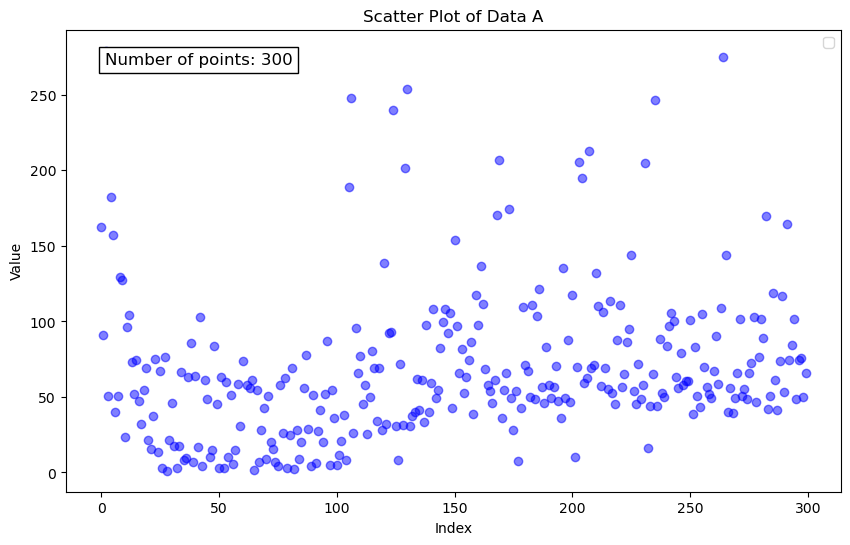

In [8]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(300, 1)


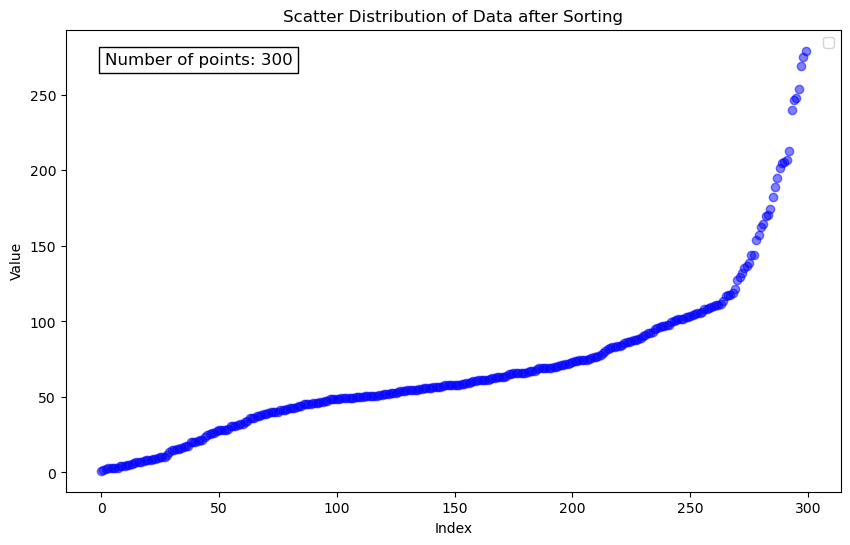

In [9]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.0004481850302001684, 0.0004146950018881605, 0.0004960675116553978, 0.00045278913660481556, 0.00045092852491221045, 0.0004129053832536286, 0.0004540901049072598, 0.0005131716279776311, 0.00047882622021955365, 0.40616223553898895]
Error u of fuhe active learning(LHS sampling): 4.102839e-02
[0.00013635545460903757, 0.0001285424572155964, 0.0001488264334566101, 0.0001406396471499675, 0.0001369161025266589, 0.00012864186261567724, 0.00013979904349165407, 0.00015420920004619265, 0.00014417523089357514, 0.10456242442887156]
MAE of fuhe active learning(LHS sampling): 1.058205e-02
[4.2258257590242514e-08, 3.6545613202867065e-08, 5.134192854844752e-08, 4.33529581049235e-08, 4.243190714794155e-08, 3.691559750647881e-08, 4.344904280005271e-08, 5.446059366798134e-08, 4.7891010756995745e-08, 0.033734832272190124]
MSE of fuhe active learning(LHS sampling): 3.373523e-03
[0.005327477, 0.004244929, 0.0001399676, 0.1984022, 0.0001627829, 0.00012056661, 9.838217e-05, 1.1009458e-05, 0.0029939068, 0.0007

[0.0004481850302001684, 0.0004146950018881605, 0.0004960675116553978, 0.00045278913660481556, 0.00045092852491221045, 0.0004129053832536286, 0.0004540901049072598, 0.0005131716279776311, 0.00047882622021955365, 0.40616223553898895]
mean Error u: 4.102839e-02
Variance Error u: 1.481364e-02


/tmp/ipykernel_294723/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


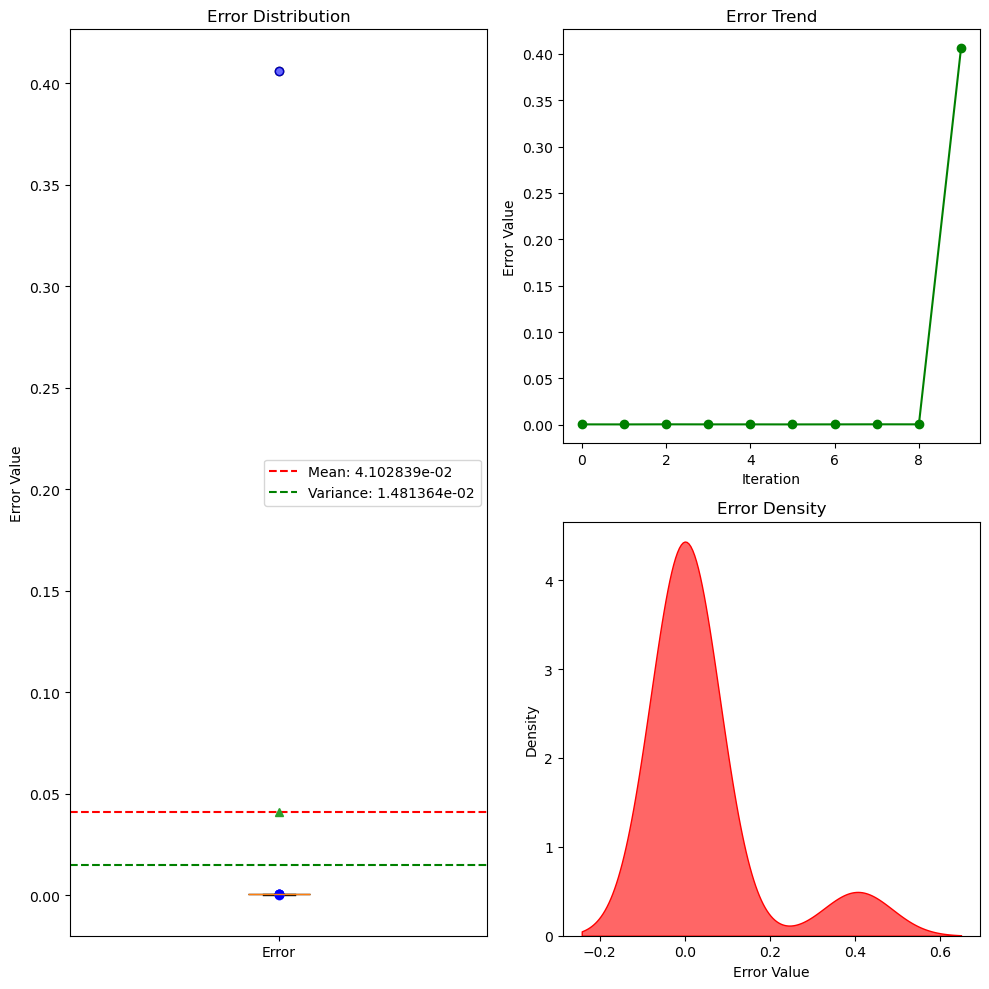

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00013635545460903757, 0.0001285424572155964, 0.0001488264334566101, 0.0001406396471499675, 0.0001369161025266589, 0.00012864186261567724, 0.00013979904349165407, 0.00015420920004619265, 0.00014417523089357514, 0.10456242442887156]
mean MAE: 1.058205e-02
Variance MAE: 9.813679e-04


/tmp/ipykernel_294723/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


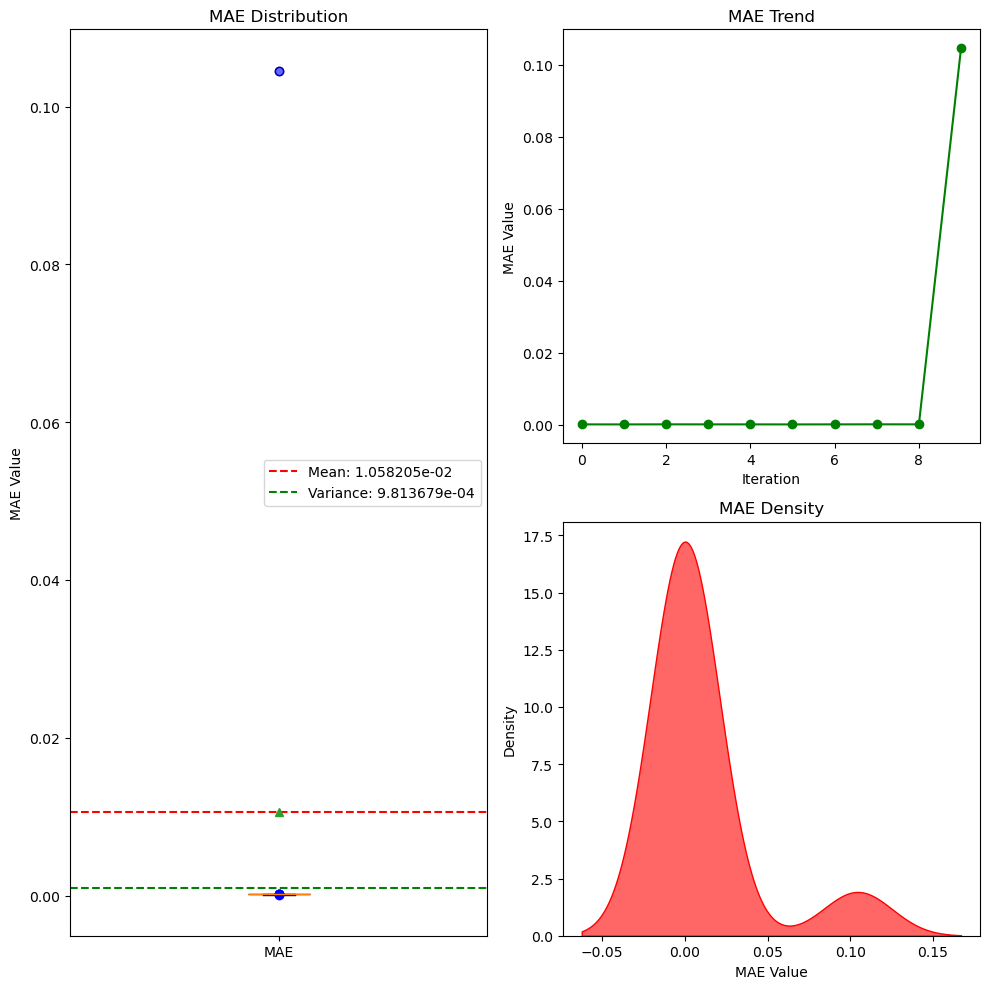

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[4.2258257590242514e-08, 3.6545613202867065e-08, 5.134192854844752e-08, 4.33529581049235e-08, 4.243190714794155e-08, 3.691559750647881e-08, 4.344904280005271e-08, 5.446059366798134e-08, 4.7891010756995745e-08, 0.033734832272190124]
mean MSE: 3.373523e-03
Variance MSE: 1.024232e-04


/tmp/ipykernel_294723/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


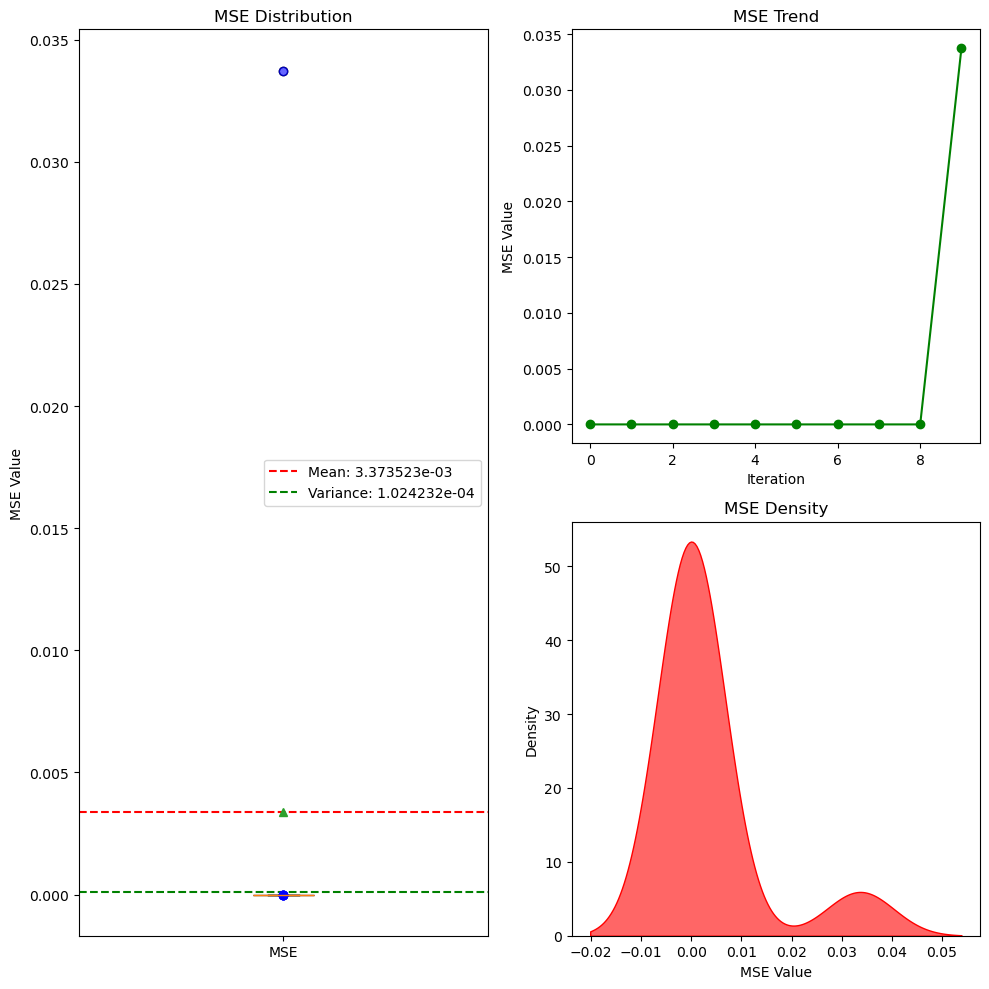

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.005327477, 0.004244929, 0.0001399676, 0.1984022, 0.0001627829, 0.00012056661, 9.838217e-05, 1.1009458e-05, 0.0029939068, 0.00078555313]
mean CHAOS: 2.122868e-02
Variance CHAOS: 3.491292e-03


/tmp/ipykernel_294723/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


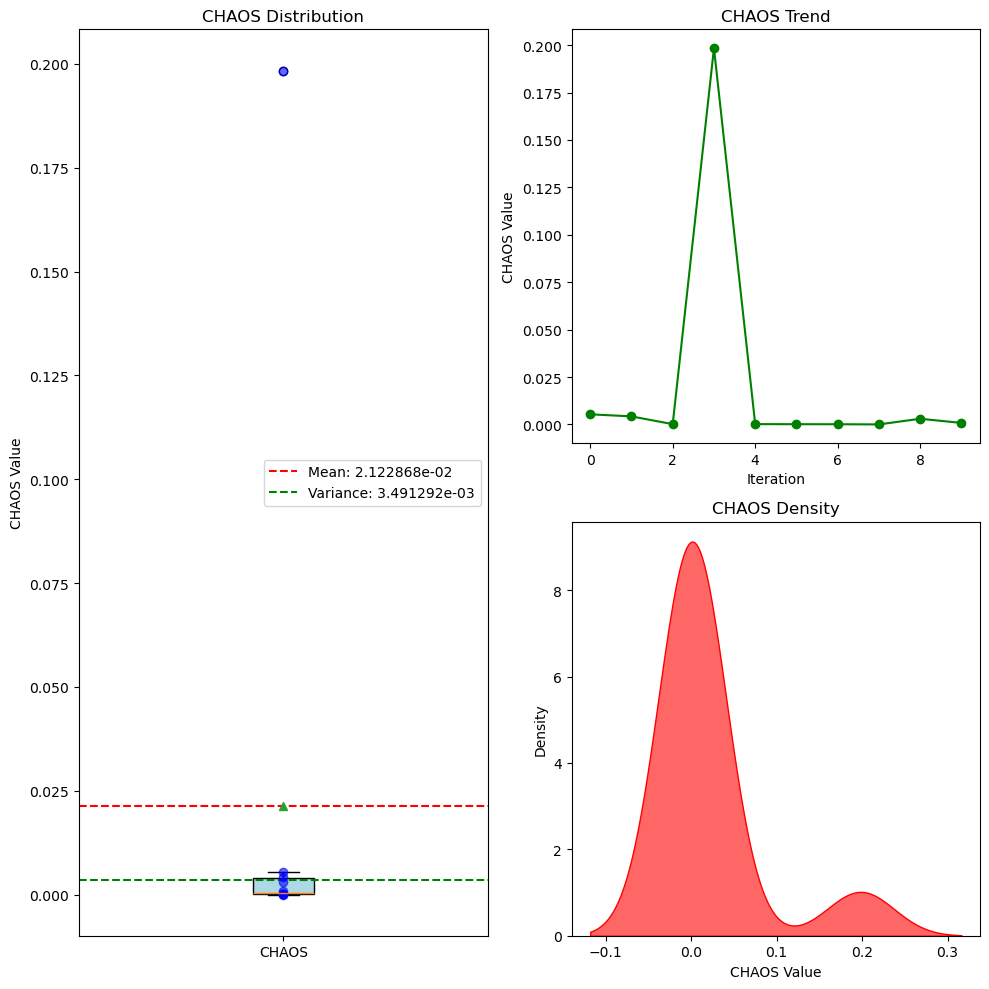

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[5.2345445e-07, 4.6342643e-07, 4.2669194e-07, 5.093473e-07, 4.2887086e-07, 4.252954e-07, 4.2123725e-07, 4.4585124e-07, 4.980502e-07, 6.777118e-07]
mean RESIDUAL: 4.819937e-07
Variance RESIDUAL: 5.546798e-15


/tmp/ipykernel_294723/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


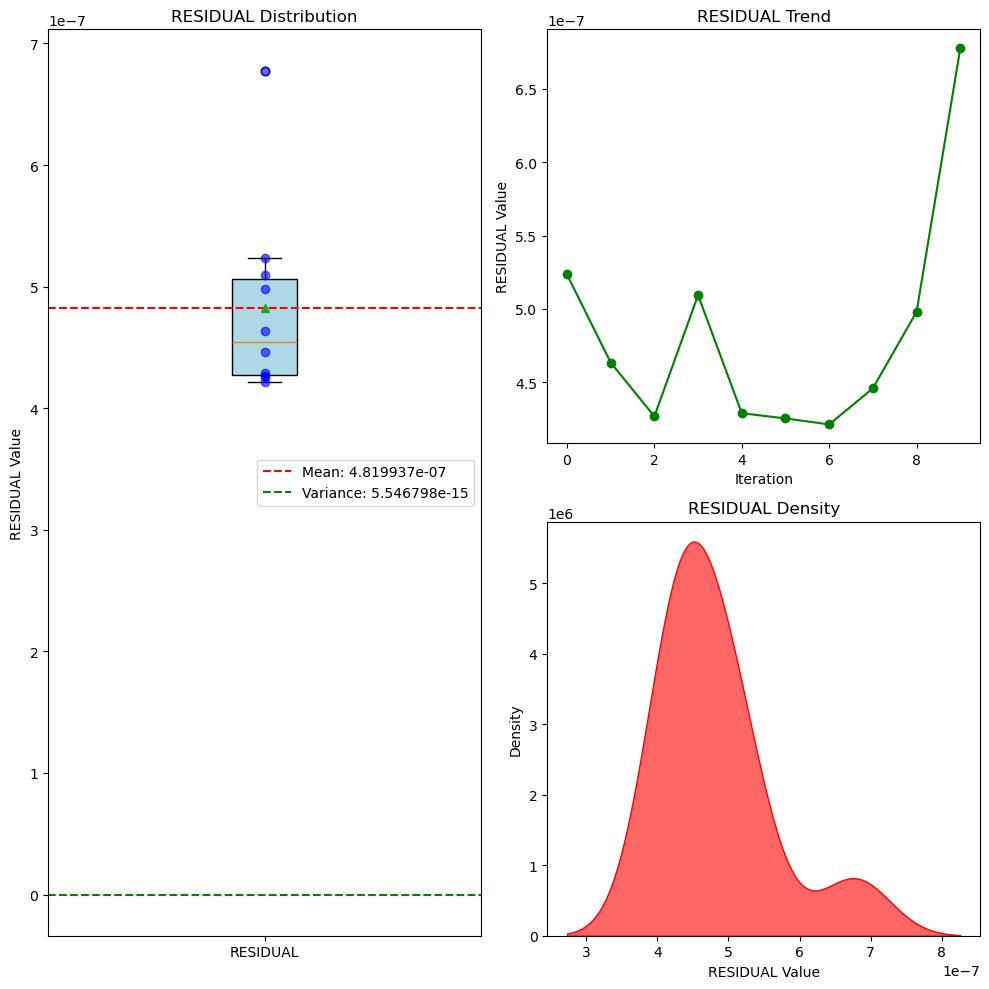

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

150000
[1.9416101e-01 1.6383828e-01 1.3566074e-01 ... 1.6065853e-05 1.6065749e-05
 1.6065651e-05]


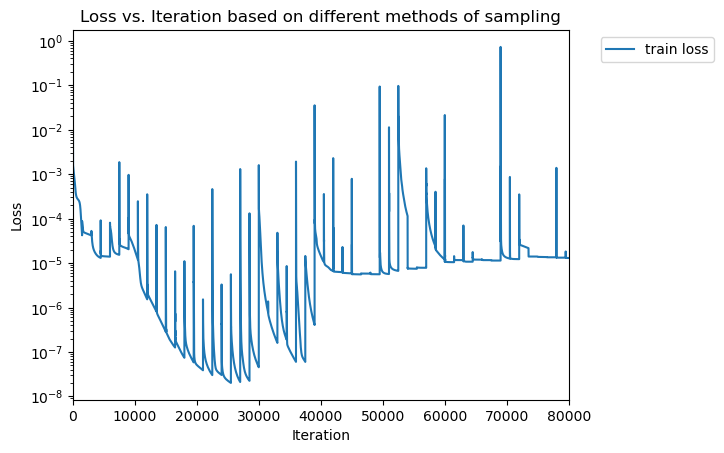

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,80000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

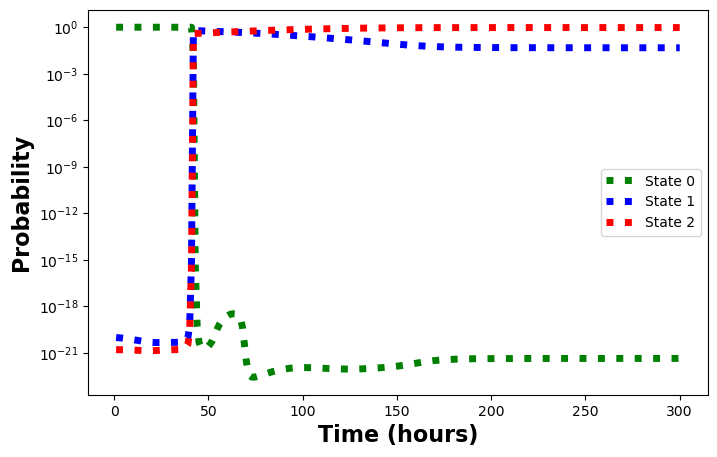

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

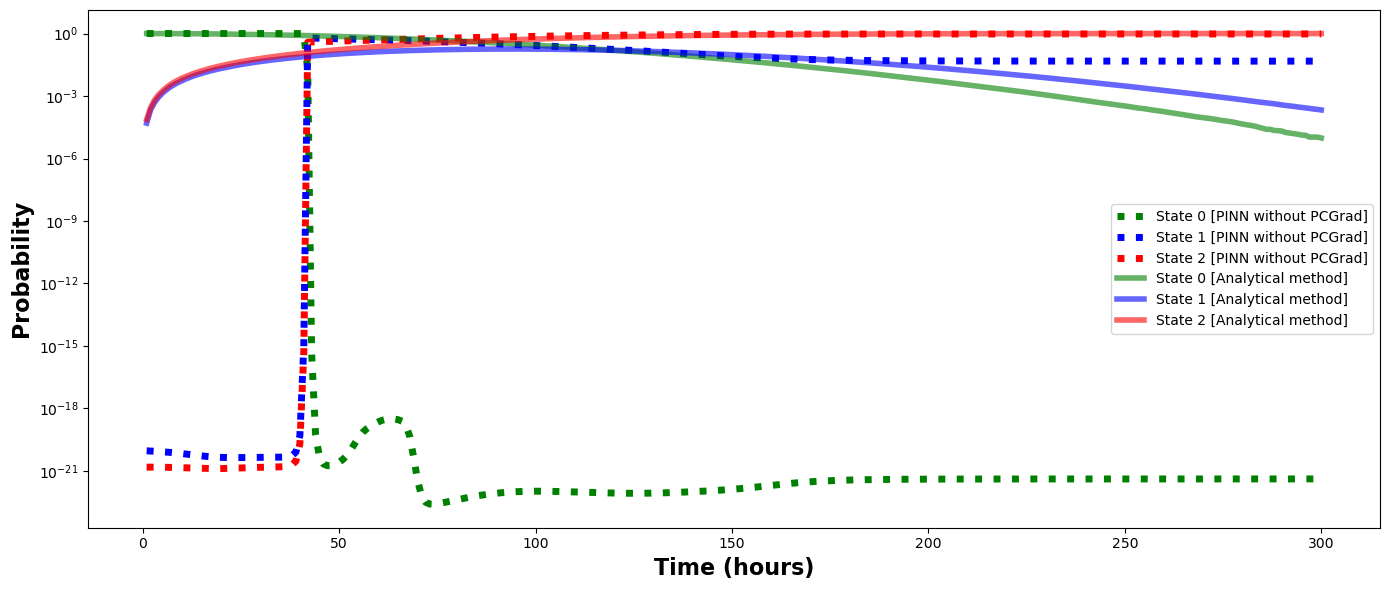

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

   state_0       state_1       state_2
0      1.0  9.242822e-21  1.523220e-21
1      1.0  9.049883e-21  1.522709e-21
2      1.0  8.835995e-21  1.520266e-21
3      1.0  8.600841e-21  1.515633e-21
4      1.0  8.344334e-21  1.508561e-21
          state_0   state_1   state_2
295  4.138638e-22  0.047242  0.952758
296  4.138707e-22  0.047241  0.952759
297  4.138743e-22  0.047240  0.952760
298  4.138811e-22  0.047239  0.952761
299  4.138879e-22  0.047238  0.952762


In [21]:
y_diff_no_pcgrad_MCS = MCS_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_MCS['mse'] = y_diff_no_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_MCS['rmse'] = y_diff_no_pcgrad_MCS['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_MCS['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.1980805837907211
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.1980805837907211
RMSE between PINN without PCGrad and the analytical solution after 60000 is nan


### 计算混沌度和残差

In [24]:
x_star.shape

(300, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(0, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[6.3850888e-04 6.4833142e-04 6.6079968e-04 6.7416794e-04 6.8598153e-04
 6.9179112e-04 6.9469167e-04 6.7827327e-04 6.1438186e-04 4.5451312e-04
 1.8849332e-04 9.5873751e-05 2.2846616e-04 1.9902733e-04 1.1571498e-04
 4.6156747e-05 6.5864871e-05 9.8261495e-05 1.1300728e-04 9.7345175e-05
 7.3731338e-05 6.2374798e-05 6.0376129e-05 6.7813300e-05 7.4146708e-05
 8.5293417e-05 8.8829787e-05 9.2900198e-05 9.6907628e-05 9.7236865e-05
 9.4084658e-05 8.9203153e-05 8.8547953e-05 8.2396029e-05 8.1069833e-05
 7.5500204e-05 7.4209755e-05 7.5436204e-05 8.4146253e-05 6.9913520e-05
 4.4466477e-05 4.6364663e-04 9.0659451e-04 5.1344647e-05 6.3179323e-05
 5.4015109e-05 5.6343171e-05 5.9056310e-05 5.7350248e-05 6.7461740e-05
 1.1197064e-04 1.7818825e-04 2.3230427e-04 2.8774459e-04 5.9740595e-04
 3.9038341e-04 4.5212475e-04 5.6258973e-04 6.0380046e-04 5.9374736e-04
 5.6397030e-04 5.2033039e-04 4.8694247e-04 4.7212807e-04 4.7549049e-04
 4.9537548e-04 5.6959526e-04 6.3141144e-04 2.6374508e-04 9.7374694e-05
 8.615

Text(0.5, 1.0, 'Chaos of x_star')

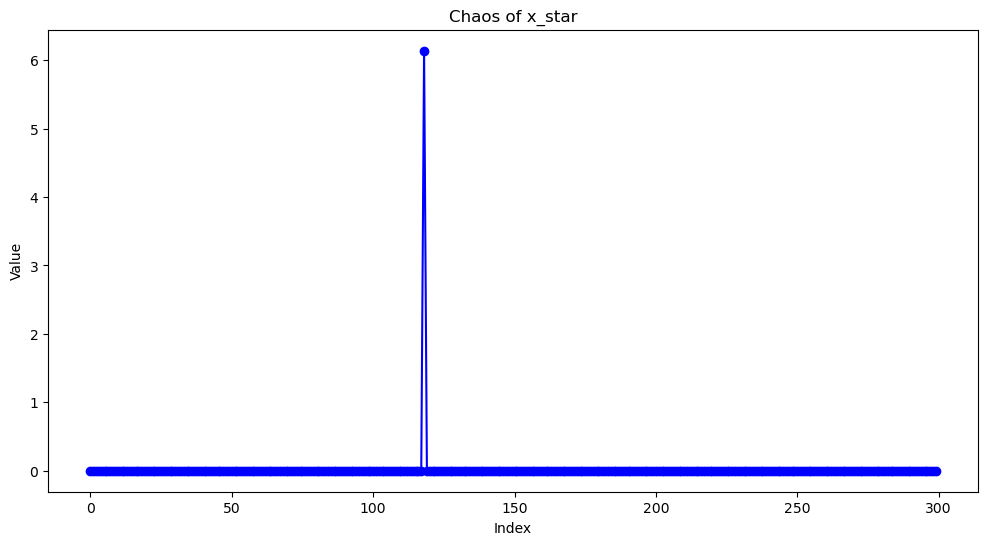

In [26]:
data = chaju
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Chaos of x_star')


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[ 0.0000000e+00  0.0000000e+00  5.8207661e-11  0.0000000e+00
  0.0000000e+00  1.1641532e-10  0.0000000e+00  0.0000000e+00
  2.3283064e-10 -1.1641532e-10  0.0000000e+00  2.3283064e-10
  1.1641532e-10  2.3283064e-10  0.0000000e+00  0.0000000e+00
  0.0000000e+00  4.6566129e-10 -2.3283064e-10  0.0000000e+00
  2.3283064e-10  0.0000000e+00  2.3283064e-10  4.6566129e-10
  0.0000000e+00  2.3283064e-10  4.6566129e-10  0.0000000e+00
  4.6566129e-10  0.0000000e+00  4.6566129e-10  0.0000000e+00
 -4.6566129e-10  4.6566129e-10  0.0000000e+00  9.3132257e-10
  4.6566129e-10 -4.6566129e-10  4.6566129e-10  0.0000000e+00
  4.6566129e-10  8.9406967e-08  2.2025779e-07  6.6589564e-08
 -4.7031790e-08  2.3283064e-09  0.0000000e+00  0.0000000e+00
 -2.7939677e-09 -5.5879354e-09 -1.1175871e-08  3.7252903e-09
  0.0000000e+00  7.4505806e-09  1.8160790e-08  0.0000000e+00
  0.0000000e+00  6.9849193e-09  0.0000000e+00  3.7252903e-09
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -1.8626451e-09 -3.72529

Text(0.5, 1.0, 'Residual of x_star')

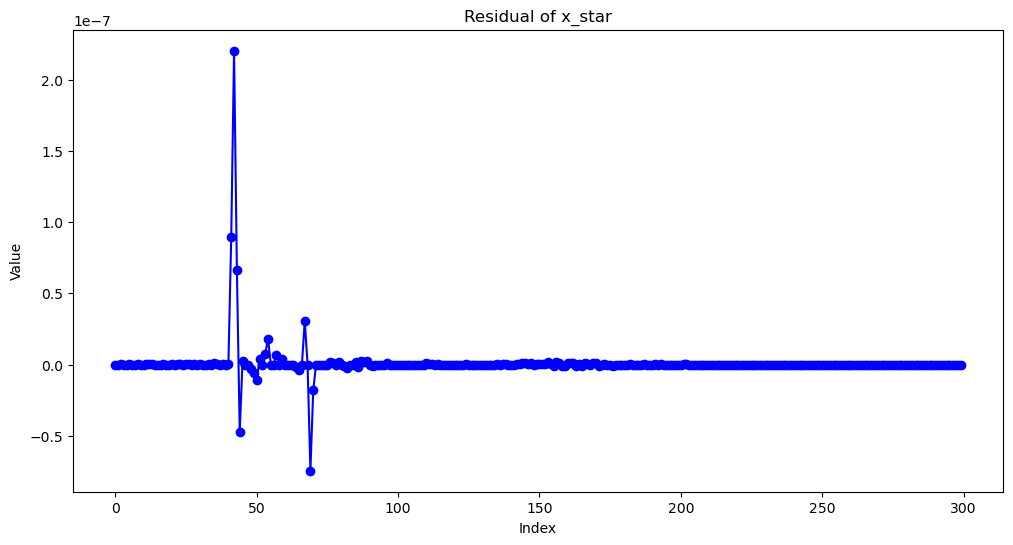

In [28]:
data = residual
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Residual of x_star')
